# Measurement noise assessment

In this notebook, we illustrate how to use pyABC with different noise models. For simplicity, we use a simple ODE model of a conversion reaction. For simplicity, we consider a single parameter:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc
import time
import os
import tempfile
%matplotlib inline

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

init = np.array([1, 0])

def f(y, t0, theta1, theta2=np.exp(-2)):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2

theta1_true = np.exp(-2.5)
theta_true = {'theta1': theta1_true}

theta_min, theta_max = 0.05, 0.15
prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", theta_min, theta_max-theta_min))

n_time = 10
measurement_times = np.linspace(0, 10, n_time)

In [2]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)


eps_list=[5, 3, 2, 1, 0.75, 0.5, 0.33, 0.25]
#eps = pyabc.ListEpsilon(eps_list)
eps=pyabc.MedianEpsilon(500, median_multiplier=0.8)
min_eps=0.2
pop_size = 500
noise_factor=0.025
iters=100

We assume that the underlying dynamics of our observations follow the following model:

In [3]:
def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],))
    return {'X_2': sol[:,1]}

true_trajectory = model(theta_true)

However, we assume that our measurements are subject to additive Gaussian noise:

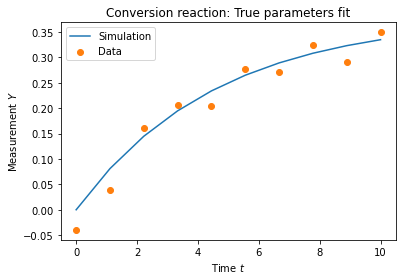

In [4]:
sigma = 0.02

def model_noisy(pars):
    sim = model(pars)
    return {'X_2': sim['X_2'] + sigma * np.random.randn(n_time)}

measured_data = model_noisy(theta_true)

# plot data
plt.plot(measurement_times, true_trajectory['X_2'], color="C0",
         label='Simulation')
plt.scatter(measurement_times, measured_data['X_2'],
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

## Ignoring noise

In the notebook "Ordinary Differential Equations: Conversion Reaction", this model is used without accounting for a noise model, which is strictly speaking not correct. In this case, we get the following result:

In [5]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

abc = pyabc.ABCSMC(models=model, 
                   parameter_priors=prior,
                   distance_function=distance,
                   sampler=redis_sampler)

abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(minimum_epsilon = min_eps, max_nr_populations=10)

INFO:History:Start <ABCSMC(id=5, start_time=2020-11-10 11:28:13.974761, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.6316549716848571
INFO:ABC:t: 0, eps: 0.6316549716848571.


Start Duration:  0.0037467479705810547
Preliminary accepted: 0
Acceptance Duration:  0.04276251792907715
Maybe Next Gen Duration:  2.384185791015625e-07
Wait time:  0.0004496574401855469
Preliminary discarded:  0
Collection Duration:  0.0003898143768310547
Rest Duration:  0.0006878376007080078
Time passed until sampling starts for generation 0 :  0.0077991485595703125
Start Duration:  0.004655599594116211
Preliminary accepted: 0
Acceptance Duration:  0.07224798202514648
Maybe Next Gen Duration:  0.013292074203491211
Wait time:  0.00035119056701660156
Preliminary discarded:  0
Collection Duration:  0.007750749588012695
Rest Duration:  0.0014505386352539062
Duration of sampling for generation 0 :  0.10046744346618652


INFO:ABC:Acceptance rate: 100 / 180 = 5.5556e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38729038013749867.


History Duration:  0.1451725959777832
PrepNext Duration:  0.06611990928649902
Time passed until sampling starts for generation 1 :  0.25103139877319336
Start Duration:  0.008652925491333008
Preliminary accepted: 100
Acceptance Duration:  0.06908535957336426
Maybe Next Gen Duration:  0.012885570526123047
Wait time:  0.0007412433624267578


INFO:ABC:Acceptance rate: 100 / 304 = 3.2895e-01, ESS=9.8521e+01.
INFO:ABC:t: 2, eps: 0.2613329624071623.


Preliminary discarded:  30
Collection Duration:  0.06998944282531738
Rest Duration:  0.0013768672943115234
Duration of sampling for generation 1 :  0.16368818283081055
History Duration:  0.11529231071472168
PrepNext Duration:  0.04958367347717285
Time passed until sampling starts for generation 2 :  0.2030949592590332
Start Duration:  0.008291244506835938
Preliminary accepted: 100
Acceptance Duration:  0.07302355766296387
Maybe Next Gen Duration:  0.011839628219604492
Wait time:  0.0001614093780517578
Preliminary discarded:  53
Collection Duration:  0.07111787796020508
Rest Duration:  0.0013670921325683594
Duration of sampling for generation 2 :  0.1676647663116455


INFO:ABC:Acceptance rate: 100 / 364 = 2.7473e-01, ESS=9.7285e+01.
INFO:ABC:t: 3, eps: 0.23060153090502977.


History Duration:  0.184326171875
PrepNext Duration:  0.052686452865600586
Time passed until sampling starts for generation 3 :  0.27705860137939453
Start Duration:  0.010360002517700195
Preliminary accepted: 100
Acceptance Duration:  0.09555673599243164
Maybe Next Gen Duration:  0.014482259750366211
Wait time:  0.0008158683776855469
Preliminary discarded:  79
Collection Duration:  0.12660455703735352
Rest Duration:  0.0014317035675048828
Duration of sampling for generation 3 :  0.25070643424987793


INFO:ABC:Acceptance rate: 100 / 506 = 1.9763e-01, ESS=9.9125e+01.
INFO:ABC:t: 4, eps: 0.22360335970771256.


History Duration:  0.1931765079498291
PrepNext Duration:  0.05129814147949219
Time passed until sampling starts for generation 4 :  0.2828338146209717
Start Duration:  0.012398958206176758
Preliminary accepted: 100
Acceptance Duration:  0.08190155029296875
Maybe Next Gen Duration:  0.01964569091796875
Wait time:  0.003038644790649414
Preliminary discarded:  131
Collection Duration:  0.1698896884918213
Rest Duration:  0.001341104507446289
Duration of sampling for generation 4 :  0.2895798683166504


INFO:ABC:Acceptance rate: 100 / 591 = 1.6920e-01, ESS=9.8066e+01.
INFO:ABC:t: 5, eps: 0.2200643428408764.


History Duration:  0.20604395866394043
PrepNext Duration:  0.04894709587097168
Time passed until sampling starts for generation 5 :  0.29262447357177734
Start Duration:  0.009709596633911133
Preliminary accepted: 100
Acceptance Duration:  0.06272387504577637
Maybe Next Gen Duration:  0.012874603271484375
Wait time:  0.0003604888916015625
Preliminary discarded:  214
Collection Duration:  0.2602357864379883
Rest Duration:  0.0014050006866455078
Duration of sampling for generation 5 :  0.3496537208557129


INFO:ABC:Acceptance rate: 100 / 633 = 1.5798e-01, ESS=9.9860e+01.
INFO:ABC:t: 6, eps: 0.2175209285358577.


History Duration:  0.27280735969543457
PrepNext Duration:  0.047002553939819336
Time passed until sampling starts for generation 6 :  0.35453152656555176
Start Duration:  0.007385730743408203
Preliminary accepted: 100
Acceptance Duration:  0.08223342895507812
Maybe Next Gen Duration:  0.012709379196166992
Wait time:  0.002877473831176758


INFO:ABC:Acceptance rate: 100 / 844 = 1.1848e-01, ESS=9.8590e+01.


Preliminary discarded:  274
Collection Duration:  0.3004276752471924
Rest Duration:  0.0014393329620361328
Duration of sampling for generation 6 :  0.4088866710662842
History Duration:  0.19185280799865723


INFO:ABC:t: 7, eps: 0.21655966142292926.


PrepNext Duration:  0.0590357780456543
Time passed until sampling starts for generation 7 :  0.28763532638549805
Start Duration:  0.01242828369140625
Preliminary accepted: 100
Acceptance Duration:  0.07367920875549316
Maybe Next Gen Duration:  0.013355255126953125
Wait time:  0.0007097721099853516
Preliminary discarded:  283
Collection Duration:  0.3504598140716553
Rest Duration:  0.0016846656799316406
Duration of sampling for generation 7 :  0.45432186126708984


INFO:ABC:Acceptance rate: 100 / 811 = 1.2330e-01, ESS=9.6563e+01.
INFO:ABC:t: 8, eps: 0.21605912660237087.


History Duration:  0.2037043571472168
PrepNext Duration:  0.06027364730834961
Time passed until sampling starts for generation 8 :  0.31468915939331055
Start Duration:  0.009239912033081055
Preliminary accepted: 100
Acceptance Duration:  0.08375072479248047
Maybe Next Gen Duration:  0.015462636947631836
Wait time:  0.0012881755828857422


INFO:ABC:Acceptance rate: 100 / 831 = 1.2034e-01, ESS=9.9933e+01.


Preliminary discarded:  234
Collection Duration:  0.32232189178466797
Rest Duration:  0.0009312629699707031
Duration of sampling for generation 8 :  0.4364142417907715
History Duration:  0.17496442794799805


INFO:ABC:t: 9, eps: 0.21589764659771912.


PrepNext Duration:  0.04886054992675781
Time passed until sampling starts for generation 9 :  0.2561173439025879
Start Duration:  0.007819652557373047
Preliminary accepted: 100
Acceptance Duration:  0.07922029495239258
Maybe Next Gen Duration:  0.00628209114074707
Wait time:  0.0003056526184082031


INFO:ABC:Acceptance rate: 100 / 762 = 1.3123e-01, ESS=9.9978e+01.
INFO:History:Done <ABCSMC(id=5, start_time=2020-11-10 11:28:13.974761, end_time=2020-11-10 11:28:19.628113)>


Preliminary discarded:  237
Collection Duration:  0.15470671653747559
Rest Duration:  0.0009570121765136719
Duration of sampling for generation 9 :  0.25131702423095703
History Duration:  0.08353233337402344
PrepNext Duration:  0.02649831771850586


As one can see in the below plot, this converges to a point estimate as $\varepsilon\rightarrow 0$, and does not correctly represent the posterior. In particular, in general this point estimate will not capture the correct parameter value (indicated by the grey line).

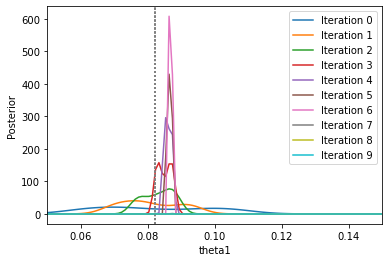

In [6]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta1", t=t, refval=theta_true, refval_color='grey',
        xmin=theta_min, xmax=theta_max, numx=100, ax=ax, label=f"Iteration {t}")
ax.legend()
plt.show()

## Add noise to the model output

To correctly account for noise, there are essentially two possibilities: Firstly, we can use the noisified model output:

In [7]:
abc = pyabc.ABCSMC(models=model_noisy, 
                   parameter_priors=prior,
                   distance_function=distance,
                   sampler=redis_sampler)

abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_noisy_output = abc.run(minimum_epsilon=min_eps, max_nr_populations=10)

INFO:History:Start <ABCSMC(id=6, start_time=2020-11-10 11:28:20.010190, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Start Duration:  0.007506608963012695
Preliminary accepted: 0
Acceptance Duration:  0.04488110542297363
Maybe Next Gen Duration:  4.76837158203125e-07
Wait time:  0.10105443000793457
Preliminary discarded:  0
Collection Duration:  0.000644683837890625
Rest Duration:  0.001552581787109375
Time passed until sampling starts for generation 0 :  0.007773399353027344
Start Duration:  0.004339933395385742
Preliminary accepted: 0
Acceptance Duration:  0.07898807525634766
Maybe Next Gen Duration:  0.012451648712158203
Wait time:  0.0004229545593261719
Preliminary discarded:  0
Collection Duration:  0.0035986900329589844
Rest Duration:  0.0008246898651123047
Duration of sampling for generation 0 :  0.1013038158416748


INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3595929538597835.


History Duration:  0.2605266571044922
PrepNext Duration:  0.058768272399902344
Time passed until sampling starts for generation 1 :  0.364776611328125
Start Duration:  0.007859468460083008
Preliminary accepted: 100
Acceptance Duration:  0.08878469467163086
Maybe Next Gen Duration:  0.01989126205444336
Wait time:  0.00016379356384277344
Preliminary discarded:  97
Collection Duration:  0.13747143745422363
Rest Duration:  0.0011925697326660156
Duration of sampling for generation 1 :  0.25691723823547363


INFO:ABC:Acceptance rate: 100 / 538 = 1.8587e-01, ESS=9.6318e+01.
INFO:ABC:t: 2, eps: 0.29431792481809177.


History Duration:  0.15027856826782227
PrepNext Duration:  0.06051826477050781
Time passed until sampling starts for generation 2 :  0.24620628356933594
Start Duration:  0.011384248733520508
Preliminary accepted: 100
Acceptance Duration:  0.08824992179870605
Maybe Next Gen Duration:  0.019861698150634766
Wait time:  0.0006723403930664062
Preliminary discarded:  79
Collection Duration:  0.1534280776977539
Rest Duration:  0.0011000633239746094
Duration of sampling for generation 2 :  0.27617692947387695


INFO:ABC:Acceptance rate: 100 / 504 = 1.9841e-01, ESS=9.1597e+01.
INFO:ABC:t: 3, eps: 0.2584587683226922.


History Duration:  0.16260385513305664
PrepNext Duration:  0.05495142936706543
Time passed until sampling starts for generation 3 :  0.2544288635253906
Start Duration:  0.009647130966186523
Preliminary accepted: 85
Acceptance Duration:  0.13618040084838867
Maybe Next Gen Duration:  0.016726016998291016
Wait time:  0.0009448528289794922
Preliminary discarded:  0
Collection Duration:  0.014383077621459961
Rest Duration:  0.0015838146209716797
Duration of sampling for generation 3 :  0.18448519706726074


INFO:ABC:Acceptance rate: 100 / 520 = 1.9231e-01, ESS=9.5245e+01.
INFO:ABC:t: 4, eps: 0.2374798060389286.


History Duration:  0.18588709831237793
PrepNext Duration:  0.0598599910736084
Time passed until sampling starts for generation 4 :  0.2857651710510254
Start Duration:  0.013942480087280273
Preliminary accepted: 65
Acceptance Duration:  0.158980131149292
Maybe Next Gen Duration:  0.014319896697998047
Wait time:  0.0005779266357421875
Preliminary discarded:  0
Collection Duration:  0.0034813880920410156
Rest Duration:  0.0012793540954589844
Duration of sampling for generation 4 :  0.19374942779541016


INFO:ABC:Acceptance rate: 100 / 603 = 1.6584e-01, ESS=7.9849e+01.
INFO:ABC:t: 5, eps: 0.21052566931055458.


History Duration:  0.21357464790344238
PrepNext Duration:  0.0640418529510498
Time passed until sampling starts for generation 5 :  0.3233823776245117
Start Duration:  0.014917612075805664


INFO:ABC:Acceptance rate: 100 / 1204 = 8.3056e-02, ESS=8.9877e+01.


Preliminary accepted: 33
Acceptance Duration:  0.365741491317749
Maybe Next Gen Duration:  0.01194000244140625
Wait time:  0.0001926422119140625
Preliminary discarded:  0
Collection Duration:  0.0007531642913818359
Rest Duration:  0.0008397102355957031
Duration of sampling for generation 5 :  0.39636707305908203
History Duration:  0.16615772247314453


INFO:ABC:t: 6, eps: 0.19176557781805836.


PrepNext Duration:  0.05019187927246094
Time passed until sampling starts for generation 6 :  0.2588973045349121
Start Duration:  0.00899362564086914


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2059 = 4.8567e-02, ESS=8.5422e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=6, start_time=2020-11-10 11:28:20.010190, end_time=2020-11-10 11:28:24.137155)>


Preliminary accepted: 12
Acceptance Duration:  0.6282711029052734
Maybe Next Gen Duration:  0.006928205490112305
Wait time:  0.00030922889709472656
Preliminary discarded:  0
Collection Duration:  0.00025081634521484375
Rest Duration:  0.0007677078247070312
Duration of sampling for generation 6 :  0.6465504169464111
History Duration:  0.0854640007019043
PrepNext Duration:  0.02438044548034668


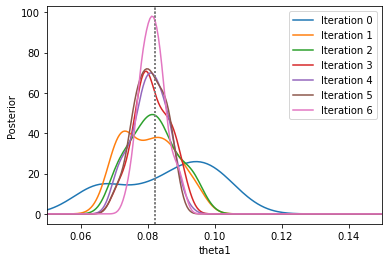

In [8]:
_, ax = plt.subplots()
for t in range(history_noisy_output.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_noisy_output, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=theta_min, xmax=theta_max, ax=ax, numx=200, label=f"Iteration {t}")
ax.legend()

This curve is much broader and, as one can show, closer to the correct posterior.

INFO:History:Start <ABCSMC(id=7, start_time=2020-11-10 11:28:24.439793, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.009935855865478516
Start Duration:  0.004973888397216797
Preliminary accepted: 0
Acceptance Duration:  0.0771331787109375
Maybe Next Gen Duration:  0.012471437454223633
Wait time:  0.0036766529083251953
Preliminary discarded:  0
Collection Duration:  0.0019104480743408203
Rest Duration:  0.0022547245025634766
Duration of sampling for generation 0 :  0.10380959510803223


INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3693029340243901.


History Duration:  0.2650485038757324
PrepNext Duration:  0.042558908462524414
Time passed until sampling starts for generation 1 :  0.3387162685394287
Start Duration:  0.011128902435302734
Preliminary accepted: 100
Acceptance Duration:  0.06508779525756836
Maybe Next Gen Duration:  0.012286901473999023
Wait time:  0.0005121231079101562


INFO:ABC:Acceptance rate: 100 / 522 = 1.9157e-01, ESS=9.8867e+01.


Preliminary discarded:  114
Collection Duration:  0.1645042896270752
Rest Duration:  0.0011250972747802734
Duration of sampling for generation 1 :  0.2564563751220703
History Duration:  0.16219139099121094


INFO:ABC:t: 2, eps: 0.28664448797343506.


PrepNext Duration:  0.04916071891784668
Time passed until sampling starts for generation 2 :  0.24393987655639648
Start Duration:  0.008901834487915039
Preliminary accepted: 100
Acceptance Duration:  0.09360027313232422
Maybe Next Gen Duration:  0.01185464859008789
Wait time:  0.00021886825561523438


INFO:ABC:Acceptance rate: 100 / 668 = 1.4970e-01, ESS=9.7774e+01.


Preliminary discarded:  100
Collection Duration:  0.19823932647705078
Rest Duration:  0.001049041748046875
Duration of sampling for generation 2 :  0.3158557415008545
History Duration:  0.18630290031433105


INFO:ABC:t: 3, eps: 0.25581506600397735.


PrepNext Duration:  0.062001943588256836
Time passed until sampling starts for generation 3 :  0.2854890823364258
Start Duration:  0.00843048095703125
Preliminary accepted: 100
Acceptance Duration:  0.09194183349609375
Maybe Next Gen Duration:  0.012595891952514648
Wait time:  0.00397944450378418


INFO:ABC:Acceptance rate: 100 / 721 = 1.3870e-01, ESS=8.9270e+01.


Preliminary discarded:  96
Collection Duration:  0.16462349891662598
Rest Duration:  0.0011112689971923828
Duration of sampling for generation 3 :  0.2841048240661621
History Duration:  0.17656517028808594


INFO:ABC:t: 4, eps: 0.2290354187553223.


PrepNext Duration:  0.05525326728820801
Time passed until sampling starts for generation 4 :  0.2715473175048828
Start Duration:  0.011834144592285156
Preliminary accepted: 84
Acceptance Duration:  0.18906593322753906
Maybe Next Gen Duration:  0.01695871353149414
Wait time:  0.0044634342193603516
Preliminary discarded:  0
Collection Duration:  0.0182955265045166
Rest Duration:  0.0013561248779296875
Duration of sampling for generation 4 :  0.24298787117004395


INFO:ABC:Acceptance rate: 100 / 840 = 1.1905e-01, ESS=9.6849e+01.
INFO:ABC:t: 5, eps: 0.20752495120541373.


History Duration:  0.17811894416809082
PrepNext Duration:  0.04998588562011719
Time passed until sampling starts for generation 5 :  0.26077818870544434
Start Duration:  0.011212825775146484


INFO:ABC:Acceptance rate: 100 / 1003 = 9.9701e-02, ESS=5.6473e+01.


Preliminary accepted: 40
Acceptance Duration:  0.24393463134765625
Maybe Next Gen Duration:  0.013529300689697266
Wait time:  0.0002243518829345703
Preliminary discarded:  0
Collection Duration:  0.002074003219604492
Rest Duration:  0.001401662826538086
Duration of sampling for generation 5 :  0.273545503616333
History Duration:  0.17080473899841309


INFO:ABC:t: 6, eps: 0.19215335700804811.


PrepNext Duration:  0.04604744911193848
Time passed until sampling starts for generation 6 :  0.25051259994506836
Start Duration:  0.010884761810302734


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2148 = 4.6555e-02, ESS=9.7017e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=7, start_time=2020-11-10 11:28:24.439793, end_time=2020-11-10 11:28:28.340100)>
INFO:History:Start <ABCSMC(id=8, start_time=2020-11-10 11:28:28.353214, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.580629825592041
Maybe Next Gen Duration:  0.006237983703613281
Wait time:  0.0003230571746826172
Preliminary discarded:  0
Collection Duration:  0.0005998611450195312
Rest Duration:  0.0012395381927490234
Duration of sampling for generation 6 :  0.600656270980835
History Duration:  0.09237074851989746
PrepNext Duration:  0.02956986427307129
Time passed until sampling starts for generation 0 :  0.012676715850830078
Start Duration:  0.007290363311767578
Preliminary accepted: 0
Acceptance Duration:  0.07803201675415039
Maybe Next Gen Duration:  0.014365434646606445
Wait time:  0.001140594482421875
Preliminary discarded:  0
Collection Duration:  0.0016858577728271484
Rest Duration:  0.0019109249114990234
Duration of sampling for generation 0 :  0.1056966781616211


INFO:ABC:Acceptance rate: 100 / 209 = 4.7847e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.34566742897251174.


History Duration:  0.2353975772857666
PrepNext Duration:  0.052881479263305664
Time passed until sampling starts for generation 1 :  0.3271503448486328
Start Duration:  0.009462833404541016
Preliminary accepted: 100
Acceptance Duration:  0.07650494575500488
Maybe Next Gen Duration:  0.017960548400878906
Wait time:  0.0006868839263916016


INFO:ABC:Acceptance rate: 100 / 491 = 2.0367e-01, ESS=9.8443e+01.


Preliminary discarded:  82
Collection Duration:  0.15143775939941406
Rest Duration:  0.0010881423950195312
Duration of sampling for generation 1 :  0.25969886779785156
History Duration:  0.18171238899230957


INFO:ABC:t: 2, eps: 0.2888086665153636.


PrepNext Duration:  0.04803299903869629
Time passed until sampling starts for generation 2 :  0.2659111022949219
Start Duration:  0.008534669876098633
Preliminary accepted: 100
Acceptance Duration:  0.07947731018066406
Maybe Next Gen Duration:  0.011611700057983398
Wait time:  0.0006902217864990234


INFO:ABC:Acceptance rate: 100 / 662 = 1.5106e-01, ESS=9.6991e+01.


Preliminary discarded:  119
Collection Duration:  0.19542479515075684
Rest Duration:  0.0012340545654296875
Duration of sampling for generation 2 :  0.29876232147216797
History Duration:  0.16590595245361328


INFO:ABC:t: 3, eps: 0.25090166168346834.


PrepNext Duration:  0.0481867790222168
Time passed until sampling starts for generation 3 :  0.24445533752441406
Start Duration:  0.008291006088256836
Preliminary accepted: 100
Acceptance Duration:  0.09865283966064453
Maybe Next Gen Duration:  0.012340068817138672
Wait time:  0.00415802001953125


INFO:ABC:Acceptance rate: 100 / 798 = 1.2531e-01, ESS=9.8583e+01.


Preliminary discarded:  73
Collection Duration:  0.2540895938873291
Rest Duration:  0.002801179885864258
Duration of sampling for generation 3 :  0.38193678855895996
History Duration:  0.18247652053833008


INFO:ABC:t: 4, eps: 0.22283810108568772.


PrepNext Duration:  0.050588130950927734
Time passed until sampling starts for generation 4 :  0.2723729610443115
Start Duration:  0.013915061950683594
Preliminary accepted: 95
Acceptance Duration:  0.22795486450195312
Maybe Next Gen Duration:  0.014220952987670898
Wait time:  0.0003924369812011719
Preliminary discarded:  0
Collection Duration:  0.02922677993774414
Rest Duration:  0.0015892982482910156
Duration of sampling for generation 4 :  0.28839588165283203


INFO:ABC:Acceptance rate: 100 / 1075 = 9.3023e-02, ESS=9.5297e+01.
INFO:ABC:t: 5, eps: 0.19874490385019467.


History Duration:  0.1856236457824707
PrepNext Duration:  0.04713106155395508
Time passed until sampling starts for generation 5 :  0.26416015625
Start Duration:  0.00887298583984375


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1474 = 6.7843e-02, ESS=9.6844e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=8, start_time=2020-11-10 11:28:28.353214, end_time=2020-11-10 11:28:31.621481)>
INFO:History:Start <ABCSMC(id=9, start_time=2020-11-10 11:28:31.633171, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.3710298538208008
Maybe Next Gen Duration:  0.006339550018310547
Wait time:  9.107589721679688e-05
Preliminary discarded:  0
Collection Duration:  0.0003879070281982422
Rest Duration:  0.0006902217864990234
Duration of sampling for generation 5 :  0.38793516159057617
History Duration:  0.08240437507629395
PrepNext Duration:  0.025020360946655273
Time passed until sampling starts for generation 0 :  0.009396553039550781
Start Duration:  0.003744363784790039


INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06900596618652344
Maybe Next Gen Duration:  0.01236104965209961
Wait time:  0.0033462047576904297
Preliminary discarded:  0
Collection Duration:  0.001795053482055664
Rest Duration:  0.0017802715301513672
Duration of sampling for generation 0 :  0.09313130378723145
History Duration:  0.17238783836364746


INFO:ABC:t: 1, eps: 0.333795940135028.


PrepNext Duration:  0.06388330459594727
Time passed until sampling starts for generation 1 :  0.2778019905090332
Start Duration:  0.007925271987915039
Preliminary accepted: 100
Acceptance Duration:  0.06777477264404297
Maybe Next Gen Duration:  0.01800847053527832
Wait time:  0.0005176067352294922


INFO:ABC:Acceptance rate: 100 / 488 = 2.0492e-01, ESS=9.9265e+01.


Preliminary discarded:  78
Collection Duration:  0.1238546371459961
Rest Duration:  0.001508474349975586
Duration of sampling for generation 1 :  0.2209022045135498
History Duration:  0.16074466705322266


INFO:ABC:t: 2, eps: 0.2750824968667893.


PrepNext Duration:  0.0531306266784668
Time passed until sampling starts for generation 2 :  0.24917340278625488
Start Duration:  0.010365009307861328
Preliminary accepted: 100
Acceptance Duration:  0.11048316955566406
Maybe Next Gen Duration:  0.017531633377075195
Wait time:  0.00039839744567871094


INFO:ABC:Acceptance rate: 100 / 698 = 1.4327e-01, ESS=9.3141e+01.


Preliminary discarded:  68
Collection Duration:  0.1396167278289795
Rest Duration:  0.0011529922485351562
Duration of sampling for generation 2 :  0.2810792922973633
History Duration:  0.1663343906402588


INFO:ABC:t: 3, eps: 0.23606135509848652.


PrepNext Duration:  0.0628359317779541
Time passed until sampling starts for generation 3 :  0.2690153121948242
Start Duration:  0.01030278205871582
Preliminary accepted: 100
Acceptance Duration:  0.18114662170410156
Maybe Next Gen Duration:  0.013784170150756836
Wait time:  0.00018358230590820312
Preliminary discarded:  5
Collection Duration:  0.04113316535949707
Rest Duration:  0.0013799667358398438
Duration of sampling for generation 3 :  0.24907636642456055


INFO:ABC:Acceptance rate: 100 / 874 = 1.1442e-01, ESS=9.7991e+01.
INFO:ABC:t: 4, eps: 0.21627761694894682.


History Duration:  0.1727585792541504
PrepNext Duration:  0.04629039764404297
Time passed until sampling starts for generation 4 :  0.2600893974304199
Start Duration:  0.01064610481262207


INFO:ABC:Acceptance rate: 100 / 856 = 1.1682e-01, ESS=9.0121e+01.


Preliminary accepted: 51
Acceptance Duration:  0.17442965507507324
Maybe Next Gen Duration:  0.012514352798461914
Wait time:  0.0006430149078369141
Preliminary discarded:  0
Collection Duration:  0.0008504390716552734
Rest Duration:  0.0011909008026123047
Duration of sampling for generation 4 :  0.2010819911956787
History Duration:  0.17175006866455078


INFO:ABC:t: 5, eps: 0.1974750631010316.


PrepNext Duration:  0.043460845947265625
Time passed until sampling starts for generation 5 :  0.24963879585266113
Start Duration:  0.010132074356079102


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1465 = 6.8259e-02, ESS=8.3339e+01.


Preliminary accepted: 29
Acceptance Duration:  0.37028002738952637
Maybe Next Gen Duration:  0.006360530853271484
Wait time:  0.0006990432739257812
Preliminary discarded:  0
Collection Duration:  0.0009517669677734375
Rest Duration:  0.0009477138519287109
Duration of sampling for generation 5 :  0.38994622230529785
History Duration:  0.15719842910766602
PrepNext Duration:  0.031099796295166016


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=9, start_time=2020-11-10 11:28:31.633171, end_time=2020-11-10 11:28:34.610976)>
INFO:History:Start <ABCSMC(id=10, start_time=2020-11-10 11:28:34.625498, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.007011890411376953
Start Duration:  0.0041751861572265625
Preliminary accepted: 0
Acceptance Duration:  0.06798529624938965
Maybe Next Gen Duration:  0.013663291931152344
Wait time:  0.0005977153778076172
Preliminary discarded:  0
Collection Duration:  0.001768350601196289
Rest Duration:  0.0010001659393310547
Duration of sampling for generation 0 :  0.08984208106994629


INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37765802734188114.


History Duration:  0.17997121810913086
PrepNext Duration:  0.06252622604370117
Time passed until sampling starts for generation 1 :  0.2821369171142578
Start Duration:  0.010801076889038086
Preliminary accepted: 100
Acceptance Duration:  0.06755232810974121
Maybe Next Gen Duration:  0.01189565658569336
Wait time:  0.0005218982696533203


INFO:ABC:Acceptance rate: 100 / 496 = 2.0161e-01, ESS=9.9628e+01.


Preliminary discarded:  105
Collection Duration:  0.13619303703308105
Rest Duration:  0.0015082359313964844
Duration of sampling for generation 1 :  0.2297830581665039
History Duration:  0.1698143482208252


INFO:ABC:t: 2, eps: 0.3016724191260204.


PrepNext Duration:  0.04909944534301758
Time passed until sampling starts for generation 2 :  0.25398850440979004
Start Duration:  0.008319377899169922
Preliminary accepted: 100
Acceptance Duration:  0.0729215145111084
Maybe Next Gen Duration:  0.011963367462158203
Wait time:  0.0003724098205566406


INFO:ABC:Acceptance rate: 100 / 660 = 1.5152e-01, ESS=9.5180e+01.


Preliminary discarded:  130
Collection Duration:  0.17563199996948242
Rest Duration:  0.0014495849609375
Duration of sampling for generation 2 :  0.2721266746520996
History Duration:  0.17063236236572266


INFO:ABC:t: 3, eps: 0.26691904095167185.


PrepNext Duration:  0.05403900146484375
Time passed until sampling starts for generation 3 :  0.26022839546203613
Start Duration:  0.008408546447753906
Preliminary accepted: 100
Acceptance Duration:  0.08063483238220215
Maybe Next Gen Duration:  0.012202739715576172
Wait time:  0.0001652240753173828


INFO:ABC:Acceptance rate: 100 / 756 = 1.3228e-01, ESS=9.2463e+01.


Preliminary discarded:  116
Collection Duration:  0.19017696380615234
Rest Duration:  0.0014882087707519531
Duration of sampling for generation 3 :  0.2947413921356201
History Duration:  0.16285276412963867


INFO:ABC:t: 4, eps: 0.2332124277261342.


PrepNext Duration:  0.04836082458496094
Time passed until sampling starts for generation 4 :  0.246429443359375
Start Duration:  0.01110529899597168
Preliminary accepted: 100
Acceptance Duration:  0.16492462158203125
Maybe Next Gen Duration:  0.011997222900390625
Wait time:  0.00019359588623046875
Preliminary discarded:  19
Collection Duration:  0.0824277400970459
Rest Duration:  0.0009071826934814453
Duration of sampling for generation 4 :  0.2733151912689209


INFO:ABC:Acceptance rate: 100 / 921 = 1.0858e-01, ESS=7.5771e+01.
INFO:ABC:t: 5, eps: 0.21163597283194674.


History Duration:  0.17339086532592773
PrepNext Duration:  0.051683902740478516
Time passed until sampling starts for generation 5 :  0.2587008476257324
Start Duration:  0.009007453918457031


INFO:ABC:Acceptance rate: 100 / 1165 = 8.5837e-02, ESS=9.1265e+01.


Preliminary accepted: 43
Acceptance Duration:  0.2830953598022461
Maybe Next Gen Duration:  0.013777017593383789
Wait time:  0.004384040832519531
Preliminary discarded:  0
Collection Duration:  0.0016493797302246094
Rest Duration:  0.0008883476257324219
Duration of sampling for generation 5 :  0.3145754337310791
History Duration:  0.16318845748901367


INFO:ABC:t: 6, eps: 0.19517071674066436.


PrepNext Duration:  0.05208110809326172
Time passed until sampling starts for generation 6 :  0.246964693069458
Start Duration:  0.008196592330932617


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1918 = 5.2138e-02, ESS=8.7564e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=10, start_time=2020-11-10 11:28:34.625498, end_time=2020-11-10 11:28:38.378019)>
INFO:History:Start <ABCSMC(id=11, start_time=2020-11-10 11:28:38.389735, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 24
Acceptance Duration:  0.5415735244750977
Maybe Next Gen Duration:  0.006666421890258789
Wait time:  0.0003452301025390625
Preliminary discarded:  0
Collection Duration:  0.0012633800506591797
Rest Duration:  0.0013244152069091797
Duration of sampling for generation 6 :  0.560084342956543
History Duration:  0.08857226371765137
PrepNext Duration:  0.026067018508911133
Time passed until sampling starts for generation 0 :  0.007388591766357422
Start Duration:  0.003694295883178711
Preliminary accepted: 0
Acceptance Duration:  0.07607626914978027
Maybe Next Gen Duration:  0.012981414794921875
Wait time:  0.00043392181396484375
Preliminary discarded:  0
Collection Duration:  0.003802776336669922
Rest Duration:  0.0017211437225341797
Duration of sampling for generation 0 :  0.09935927391052246


INFO:ABC:Acceptance rate: 100 / 222 = 4.5045e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.39171868654900377.


History Duration:  0.30309295654296875
PrepNext Duration:  0.048763275146484375
Time passed until sampling starts for generation 1 :  0.38687562942504883
Start Duration:  0.009153366088867188
Preliminary accepted: 100
Acceptance Duration:  0.06323623657226562
Maybe Next Gen Duration:  0.01215362548828125
Wait time:  0.0007007122039794922


INFO:ABC:Acceptance rate: 100 / 646 = 1.5480e-01, ESS=9.9816e+01.


Preliminary discarded:  178
Collection Duration:  0.21814370155334473
Rest Duration:  0.0014095306396484375
Duration of sampling for generation 1 :  0.3063819408416748
History Duration:  0.1671609878540039


INFO:ABC:t: 2, eps: 0.30860217950492463.


PrepNext Duration:  0.049424171447753906
Time passed until sampling starts for generation 2 :  0.24799060821533203
Start Duration:  0.008371591567993164
Preliminary accepted: 100
Acceptance Duration:  0.06514668464660645
Maybe Next Gen Duration:  0.013585329055786133
Wait time:  0.00035858154296875


INFO:ABC:Acceptance rate: 100 / 759 = 1.3175e-01, ESS=9.2258e+01.


Preliminary discarded:  239
Collection Duration:  0.28959083557128906
Rest Duration:  0.0016973018646240234
Duration of sampling for generation 2 :  0.3806769847869873
History Duration:  0.1866316795349121


INFO:ABC:t: 3, eps: 0.258384394910132.


PrepNext Duration:  0.050824642181396484
Time passed until sampling starts for generation 3 :  0.27231621742248535
Start Duration:  0.009906291961669922
Preliminary accepted: 100
Acceptance Duration:  0.11091947555541992
Maybe Next Gen Duration:  0.013002634048461914
Wait time:  0.00037288665771484375


INFO:ABC:Acceptance rate: 100 / 934 = 1.0707e-01, ESS=8.4540e+01.


Preliminary discarded:  129
Collection Duration:  0.2486128807067871
Rest Duration:  0.0014464855194091797
Duration of sampling for generation 3 :  0.3858625888824463
History Duration:  0.18068623542785645


INFO:ABC:t: 4, eps: 0.2299284068804803.


PrepNext Duration:  0.052001237869262695
Time passed until sampling starts for generation 4 :  0.2725257873535156
Start Duration:  0.013325929641723633
Preliminary accepted: 100
Acceptance Duration:  0.15958023071289062
Maybe Next Gen Duration:  0.012980937957763672
Wait time:  0.00022268295288085938
Preliminary discarded:  30
Collection Duration:  0.10285305976867676
Rest Duration:  0.0009033679962158203
Duration of sampling for generation 4 :  0.2925999164581299


INFO:ABC:Acceptance rate: 100 / 1013 = 9.8717e-02, ESS=6.0682e+01.
INFO:ABC:t: 5, eps: 0.21158713883718322.


History Duration:  0.16727328300476074
PrepNext Duration:  0.047235727310180664
Time passed until sampling starts for generation 5 :  0.24962258338928223
Start Duration:  0.00862574577331543
Preliminary accepted: 44
Acceptance Duration:  0.2439558506011963
Maybe Next Gen Duration:  0.012576103210449219
Wait time:  0.0005292892456054688
Preliminary discarded:  0
Collection Duration:  0.0006341934204101562
Rest Duration:  0.002115488052368164
Duration of sampling for generation 5 :  0.27290844917297363


INFO:ABC:Acceptance rate: 100 / 1124 = 8.8968e-02, ESS=9.6085e+01.
INFO:ABC:t: 6, eps: 0.19378875114003227.


History Duration:  0.18976044654846191
PrepNext Duration:  0.05354189872741699
Time passed until sampling starts for generation 6 :  0.2771437168121338
Start Duration:  0.009281635284423828


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1988 = 5.0302e-02, ESS=6.6821e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=11, start_time=2020-11-10 11:28:38.389735, end_time=2020-11-10 11:28:42.552105)>
INFO:History:Start <ABCSMC(id=12, start_time=2020-11-10 11:28:42.564397, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.5334105491638184
Maybe Next Gen Duration:  0.00668644905090332
Wait time:  0.00035262107849121094
Preliminary discarded:  0
Collection Duration:  0.0004482269287109375
Rest Duration:  0.0008804798126220703
Duration of sampling for generation 6 :  0.5516684055328369
History Duration:  0.0911095142364502
PrepNext Duration:  0.02937030792236328
Time passed until sampling starts for generation 0 :  0.007630348205566406
Start Duration:  0.003779888153076172


INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07234692573547363
Maybe Next Gen Duration:  0.012077808380126953
Wait time:  0.0007545948028564453
Preliminary discarded:  0
Collection Duration:  0.003913402557373047
Rest Duration:  0.00205230712890625
Duration of sampling for generation 0 :  0.0956876277923584
History Duration:  0.16982173919677734


INFO:ABC:t: 1, eps: 0.3546923728299073.


PrepNext Duration:  0.04838848114013672
Time passed until sampling starts for generation 1 :  0.2594418525695801
Start Duration:  0.010009288787841797
Preliminary accepted: 100
Acceptance Duration:  0.06225228309631348
Maybe Next Gen Duration:  0.012392520904541016
Wait time:  0.0009670257568359375
Preliminary discarded:  73
Collection Duration:  0.11603331565856934
Rest Duration:  0.0011539459228515625
Duration of sampling for generation 1 :  0.20432257652282715


INFO:ABC:Acceptance rate: 100 / 480 = 2.0833e-01, ESS=9.9422e+01.
INFO:ABC:t: 2, eps: 0.2948498459752483.


History Duration:  0.26611804962158203
PrepNext Duration:  0.0430755615234375
Time passed until sampling starts for generation 2 :  0.3466331958770752
Start Duration:  0.010046005249023438
Preliminary accepted: 100
Acceptance Duration:  0.07379937171936035
Maybe Next Gen Duration:  0.012087345123291016
Wait time:  0.004225969314575195


INFO:ABC:Acceptance rate: 100 / 766 = 1.3055e-01, ESS=9.4284e+01.


Preliminary discarded:  191
Collection Duration:  0.29023075103759766
Rest Duration:  0.001058340072631836
Duration of sampling for generation 2 :  0.393817663192749
History Duration:  0.18602943420410156


INFO:ABC:t: 3, eps: 0.2590067308430914.


PrepNext Duration:  0.061673879623413086
Time passed until sampling starts for generation 3 :  0.28746604919433594
Start Duration:  0.01099085807800293
Preliminary accepted: 100
Acceptance Duration:  0.09830403327941895
Maybe Next Gen Duration:  0.013109445571899414
Wait time:  0.0007216930389404297
Preliminary discarded:  104
Collection Duration:  0.2458488941192627
Rest Duration:  0.0012714862823486328
Duration of sampling for generation 3 :  0.37149739265441895


INFO:ABC:Acceptance rate: 100 / 947 = 1.0560e-01, ESS=7.1200e+01.
INFO:ABC:t: 4, eps: 0.22995962773583067.


History Duration:  0.24230003356933594
PrepNext Duration:  0.06569385528564453
Time passed until sampling starts for generation 4 :  0.3477315902709961
Start Duration:  0.010870218276977539
Preliminary accepted: 100
Acceptance Duration:  0.1662464141845703
Maybe Next Gen Duration:  0.01178431510925293
Wait time:  0.00047850608825683594
Preliminary discarded:  28
Collection Duration:  0.14714717864990234
Rest Duration:  0.0012555122375488281
Duration of sampling for generation 4 :  0.3390469551086426


INFO:ABC:Acceptance rate: 100 / 1121 = 8.9206e-02, ESS=7.2185e+01.
INFO:ABC:t: 5, eps: 0.2100455315514025.


History Duration:  0.16409730911254883
PrepNext Duration:  0.06000494956970215
Time passed until sampling starts for generation 5 :  0.25960612297058105
Start Duration:  0.008188247680664062


INFO:ABC:Acceptance rate: 100 / 1346 = 7.4294e-02, ESS=7.8702e+01.


Preliminary accepted: 44
Acceptance Duration:  0.29600095748901367
Maybe Next Gen Duration:  0.013009786605834961
Wait time:  0.0006761550903320312
Preliminary discarded:  0
Collection Duration:  0.0008196830749511719
Rest Duration:  0.0016644001007080078
Duration of sampling for generation 5 :  0.32106614112854004
History Duration:  0.16367435455322266


INFO:ABC:t: 6, eps: 0.19472085504242048.


PrepNext Duration:  0.05384087562561035
Time passed until sampling starts for generation 6 :  0.24851655960083008
Start Duration:  0.006044864654541016


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1762 = 5.6754e-02, ESS=2.2975e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=12, start_time=2020-11-10 11:28:42.564397, end_time=2020-11-10 11:28:46.700561)>
INFO:History:Start <ABCSMC(id=13, start_time=2020-11-10 11:28:46.712516, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.48338842391967773
Maybe Next Gen Duration:  0.00627446174621582
Wait time:  0.0002777576446533203
Preliminary discarded:  0
Collection Duration:  0.00047397613525390625
Rest Duration:  0.0007216930389404297
Duration of sampling for generation 6 :  0.49767398834228516
History Duration:  0.09087872505187988
PrepNext Duration:  0.026542186737060547
Time passed until sampling starts for generation 0 :  0.007103919982910156
Start Duration:  0.004451274871826172


INFO:ABC:Acceptance rate: 100 / 221 = 4.5249e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07565164566040039
Maybe Next Gen Duration:  0.013828754425048828
Wait time:  0.0003085136413574219
Preliminary discarded:  0
Collection Duration:  0.003050088882446289
Rest Duration:  0.0007359981536865234
Duration of sampling for generation 0 :  0.09937548637390137
History Duration:  0.18413329124450684


INFO:ABC:t: 1, eps: 0.37609112549165097.


PrepNext Duration:  0.04950094223022461
Time passed until sampling starts for generation 1 :  0.26556944847106934
Start Duration:  0.01208043098449707
Preliminary accepted: 100
Acceptance Duration:  0.0611109733581543
Maybe Next Gen Duration:  0.012613534927368164
Wait time:  0.0006959438323974609


INFO:ABC:Acceptance rate: 100 / 480 = 2.0833e-01, ESS=9.8696e+01.


Preliminary discarded:  89
Collection Duration:  0.11567878723144531
Rest Duration:  0.0014078617095947266
Duration of sampling for generation 1 :  0.20514631271362305
History Duration:  0.1632380485534668


INFO:ABC:t: 2, eps: 0.30037913288328183.


PrepNext Duration:  0.04854226112365723
Time passed until sampling starts for generation 2 :  0.24716758728027344
Start Duration:  0.008131265640258789
Preliminary accepted: 100
Acceptance Duration:  0.08036017417907715
Maybe Next Gen Duration:  0.013539314270019531
Wait time:  0.0003495216369628906
Preliminary discarded:  129
Collection Duration:  0.1852104663848877
Rest Duration:  0.0013382434844970703
Duration of sampling for generation 2 :  0.29072117805480957


INFO:ABC:Acceptance rate: 100 / 633 = 1.5798e-01, ESS=9.6223e+01.
INFO:ABC:t: 3, eps: 0.2612202562721539.


History Duration:  0.26326870918273926
PrepNext Duration:  0.06119799613952637
Time passed until sampling starts for generation 3 :  0.3655383586883545
Start Duration:  0.010254144668579102
Preliminary accepted: 100
Acceptance Duration:  0.07455945014953613
Maybe Next Gen Duration:  0.01613783836364746
Wait time:  0.0008647441864013672


INFO:ABC:Acceptance rate: 100 / 885 = 1.1299e-01, ESS=9.5919e+01.


Preliminary discarded:  134
Collection Duration:  0.2626030445098877
Rest Duration:  0.001035451889038086
Duration of sampling for generation 3 :  0.36779284477233887
History Duration:  0.1837475299835205


INFO:ABC:t: 4, eps: 0.23447877208448153.


PrepNext Duration:  0.0509495735168457
Time passed until sampling starts for generation 4 :  0.2739138603210449
Start Duration:  0.010628223419189453
Preliminary accepted: 100
Acceptance Duration:  0.1327650547027588
Maybe Next Gen Duration:  0.012122392654418945
Wait time:  0.0008845329284667969
Preliminary discarded:  51
Collection Duration:  0.1327066421508789
Rest Duration:  0.0010449886322021484
Duration of sampling for generation 4 :  0.30110764503479004


INFO:ABC:Acceptance rate: 100 / 1023 = 9.7752e-02, ESS=7.2897e+01.
INFO:ABC:t: 5, eps: 0.20345230774965906.


History Duration:  0.16192913055419922
PrepNext Duration:  0.04741406440734863
Time passed until sampling starts for generation 5 :  0.24413466453552246
Start Duration:  0.007669687271118164
Preliminary accepted: 37
Acceptance Duration:  0.3029348850250244
Maybe Next Gen Duration:  0.011803388595581055
Wait time:  0.0012505054473876953
Preliminary discarded:  0
Collection Duration:  0.0010845661163330078
Rest Duration:  0.001753091812133789
Duration of sampling for generation 5 :  0.32929205894470215


INFO:ABC:Acceptance rate: 100 / 1316 = 7.5988e-02, ESS=8.0342e+01.
INFO:ABC:t: 6, eps: 0.1824223245121724.


History Duration:  0.22903203964233398
PrepNext Duration:  0.0501861572265625
Time passed until sampling starts for generation 6 :  0.3200695514678955
Start Duration:  0.008373498916625977


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3233 = 3.0931e-02, ESS=1.6218e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=13, start_time=2020-11-10 11:28:46.712516, end_time=2020-11-10 11:28:51.088319)>
INFO:History:Start <ABCSMC(id=14, start_time=2020-11-10 11:28:51.104311, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.8869526386260986
Maybe Next Gen Duration:  0.006349086761474609
Wait time:  0.0002925395965576172
Preliminary discarded:  0
Collection Duration:  0.00017762184143066406
Rest Duration:  0.0006186962127685547
Duration of sampling for generation 6 :  0.9032599925994873
History Duration:  0.08561968803405762
PrepNext Duration:  0.027570247650146484
Time passed until sampling starts for generation 0 :  0.009113311767578125
Start Duration:  0.005775928497314453
Preliminary accepted: 0
Acceptance Duration:  0.06664872169494629
Maybe Next Gen Duration:  0.012601852416992188
Wait time:  0.00045418739318847656
Preliminary discarded:  0
Collection Duration:  0.0023293495178222656
Rest Duration:  0.0016188621520996094
Duration of sampling for generation 0 :  0.09023785591125488


INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3676678295691604.


History Duration:  0.18976569175720215
PrepNext Duration:  0.0474395751953125
Time passed until sampling starts for generation 1 :  0.2717556953430176
Start Duration:  0.00853729248046875
Preliminary accepted: 100
Acceptance Duration:  0.05903267860412598
Maybe Next Gen Duration:  0.012716293334960938
Wait time:  0.0041730403900146484


INFO:ABC:Acceptance rate: 100 / 464 = 2.1552e-01, ESS=9.9665e+01.


Preliminary discarded:  93
Collection Duration:  0.10556697845458984
Rest Duration:  0.0011622905731201172
Duration of sampling for generation 1 :  0.19261407852172852
History Duration:  0.1652390956878662


INFO:ABC:t: 2, eps: 0.2972275601873953.


PrepNext Duration:  0.04996371269226074
Time passed until sampling starts for generation 2 :  0.2511477470397949
Start Duration:  0.015248537063598633
Preliminary accepted: 100
Acceptance Duration:  0.06936216354370117
Maybe Next Gen Duration:  0.011826276779174805
Wait time:  0.0022830963134765625
Preliminary discarded:  134
Collection Duration:  0.20211148262023926
Rest Duration:  0.0020296573638916016
Duration of sampling for generation 2 :  0.30460572242736816


INFO:ABC:Acceptance rate: 100 / 625 = 1.6000e-01, ESS=9.7595e+01.
INFO:ABC:t: 3, eps: 0.2606904649626683.


History Duration:  0.2187337875366211
PrepNext Duration:  0.05619025230407715
Time passed until sampling starts for generation 3 :  0.31248044967651367
Start Duration:  0.010524272918701172
Preliminary accepted: 100
Acceptance Duration:  0.0939781665802002
Maybe Next Gen Duration:  0.013203859329223633
Wait time:  0.0007998943328857422


INFO:ABC:Acceptance rate: 100 / 851 = 1.1751e-01, ESS=8.8518e+01.


Preliminary discarded:  140
Collection Duration:  0.25570130348205566
Rest Duration:  0.0015306472778320312
Duration of sampling for generation 3 :  0.3775289058685303
History Duration:  0.16304636001586914


INFO:ABC:t: 4, eps: 0.234016488031636.


PrepNext Duration:  0.052206993103027344
Time passed until sampling starts for generation 4 :  0.2515547275543213
Start Duration:  0.010606765747070312
Preliminary accepted: 100
Acceptance Duration:  0.16509628295898438
Maybe Next Gen Duration:  0.02243185043334961
Wait time:  0.004261970520019531
Preliminary discarded:  26
Collection Duration:  0.11495852470397949
Rest Duration:  0.0013015270233154297
Duration of sampling for generation 4 :  0.319979190826416


INFO:ABC:Acceptance rate: 100 / 909 = 1.1001e-01, ESS=7.6905e+01.
INFO:ABC:t: 5, eps: 0.21375953059591243.


History Duration:  0.30141520500183105
PrepNext Duration:  0.06678915023803711
Time passed until sampling starts for generation 5 :  0.40579843521118164
Start Duration:  0.010498523712158203
Preliminary accepted: 66
Acceptance Duration:  0.19913625717163086
Maybe Next Gen Duration:  0.013010025024414062
Wait time:  0.0006964206695556641
Preliminary discarded:  0
Collection Duration:  0.0041103363037109375
Rest Duration:  0.0015420913696289062
Duration of sampling for generation 5 :  0.2298145294189453


INFO:ABC:Acceptance rate: 100 / 1031 = 9.6993e-02, ESS=9.0671e+01.
INFO:ABC:t: 6, eps: 0.19394488247306024.


History Duration:  0.19404006004333496
PrepNext Duration:  0.06360220909118652
Time passed until sampling starts for generation 6 :  0.2868962287902832
Start Duration:  0.007235527038574219


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2230 = 4.4843e-02, ESS=8.6782e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=14, start_time=2020-11-10 11:28:51.104311, end_time=2020-11-10 11:28:55.229075)>
INFO:History:Start <ABCSMC(id=15, start_time=2020-11-10 11:28:55.241887, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 16
Acceptance Duration:  0.6181905269622803
Maybe Next Gen Duration:  0.007268190383911133
Wait time:  0.0004677772521972656
Preliminary discarded:  0
Collection Duration:  0.0005013942718505859
Rest Duration:  0.0009088516235351562
Duration of sampling for generation 6 :  0.6350760459899902
History Duration:  0.08907508850097656
PrepNext Duration:  0.03554511070251465
Time passed until sampling starts for generation 0 :  0.007364988327026367
Start Duration:  0.004232168197631836
Preliminary accepted: 0
Acceptance Duration:  0.06681251525878906
Maybe Next Gen Duration:  0.012296438217163086
Wait time:  0.001329183578491211
Preliminary discarded:  0
Collection Duration:  0.0022881031036376953
Rest Duration:  0.0009076595306396484
Duration of sampling for generation 0 :  0.08907961845397949


INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38025425583615424.


History Duration:  0.19748854637145996
PrepNext Duration:  0.06627130508422852
Time passed until sampling starts for generation 1 :  0.30507636070251465
Start Duration:  0.01078486442565918
Preliminary accepted: 100
Acceptance Duration:  0.059638261795043945
Maybe Next Gen Duration:  0.01310420036315918
Wait time:  0.00017571449279785156


INFO:ABC:Acceptance rate: 100 / 526 = 1.9011e-01, ESS=9.9767e+01.


Preliminary discarded:  160
Collection Duration:  0.19266557693481445
Rest Duration:  0.0017168521881103516
Duration of sampling for generation 1 :  0.28113555908203125
History Duration:  0.1682744026184082


INFO:ABC:t: 2, eps: 0.28989180524924013.


PrepNext Duration:  0.0637974739074707
Time passed until sampling starts for generation 2 :  0.2699239253997803
Start Duration:  0.009141921997070312
Preliminary accepted: 100
Acceptance Duration:  0.06457853317260742
Maybe Next Gen Duration:  0.012847900390625
Wait time:  0.0004024505615234375


INFO:ABC:Acceptance rate: 100 / 777 = 1.2870e-01, ESS=9.6930e+01.


Preliminary discarded:  197
Collection Duration:  0.28102779388427734
Rest Duration:  0.0013549327850341797
Duration of sampling for generation 2 :  0.3714754581451416
History Duration:  0.1725482940673828


INFO:ABC:t: 3, eps: 0.25917171291698143.


PrepNext Duration:  0.07450222969055176
Time passed until sampling starts for generation 3 :  0.2887301445007324
Start Duration:  0.013416051864624023
Preliminary accepted: 100
Acceptance Duration:  0.09606432914733887
Maybe Next Gen Duration:  0.013037919998168945
Wait time:  0.004244565963745117


INFO:ABC:Acceptance rate: 100 / 959 = 1.0428e-01, ESS=9.1486e+01.


Preliminary discarded:  180
Collection Duration:  0.30713582038879395
Rest Duration:  0.006179332733154297
Duration of sampling for generation 3 :  0.44219970703125
History Duration:  0.17916059494018555


INFO:ABC:t: 4, eps: 0.2289903754032284.


PrepNext Duration:  0.05079483985900879
Time passed until sampling starts for generation 4 :  0.26366662979125977
Start Duration:  0.008870840072631836
Preliminary accepted: 100
Acceptance Duration:  0.17605805397033691
Maybe Next Gen Duration:  0.012526512145996094
Wait time:  0.004189252853393555
Preliminary discarded:  39
Collection Duration:  0.11151409149169922
Rest Duration:  0.0009577274322509766
Duration of sampling for generation 4 :  0.3159971237182617


INFO:ABC:Acceptance rate: 100 / 1085 = 9.2166e-02, ESS=9.0812e+01.
INFO:ABC:t: 5, eps: 0.20669149952473587.


History Duration:  0.17482471466064453
PrepNext Duration:  0.05286836624145508
Time passed until sampling starts for generation 5 :  0.26976966857910156
Start Duration:  0.010868072509765625
Preliminary accepted: 51
Acceptance Duration:  0.2118818759918213
Maybe Next Gen Duration:  0.01260828971862793
Wait time:  0.0008511543273925781
Preliminary discarded:  0
Collection Duration:  0.0008599758148193359
Rest Duration:  0.001986265182495117
Duration of sampling for generation 5 :  0.24077939987182617


INFO:ABC:Acceptance rate: 100 / 1061 = 9.4251e-02, ESS=8.0645e+01.
INFO:ABC:t: 6, eps: 0.19028539442205072.


History Duration:  0.19209647178649902
PrepNext Duration:  0.05267953872680664
Time passed until sampling starts for generation 6 :  0.29547977447509766
Start Duration:  0.011946916580200195


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2188 = 4.5704e-02, ESS=8.9510e+01.
INFO:pyabc.util:Stopping: minimum epsilon.


Preliminary accepted: 21
Acceptance Duration:  0.5800478458404541
Maybe Next Gen Duration:  0.005946159362792969
Wait time:  0.0002923011779785156
Preliminary discarded:  0
Collection Duration:  0.0002086162567138672
Rest Duration:  0.0007104873657226562
Duration of sampling for generation 6 :  0.5998058319091797
History Duration:  0.1523427963256836
PrepNext Duration:  0.02647876739501953


INFO:History:Done <ABCSMC(id=15, start_time=2020-11-10 11:28:55.241887, end_time=2020-11-10 11:28:59.500828)>
INFO:History:Start <ABCSMC(id=16, start_time=2020-11-10 11:28:59.521287, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.006490468978881836
Start Duration:  0.0040242671966552734
Preliminary accepted: 0
Acceptance Duration:  0.07069993019104004
Maybe Next Gen Duration:  0.013689994812011719
Wait time:  0.002433300018310547
Preliminary discarded:  0
Collection Duration:  0.0023946762084960938
Rest Duration:  0.0018105506896972656
Duration of sampling for generation 0 :  0.09596705436706543


INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36063065192113186.


History Duration:  0.1686546802520752
PrepNext Duration:  0.05073046684265137
Time passed until sampling starts for generation 1 :  0.2505631446838379
Start Duration:  0.010865926742553711
Preliminary accepted: 100
Acceptance Duration:  0.053784847259521484
Maybe Next Gen Duration:  0.012547492980957031
Wait time:  0.0042989253997802734


INFO:ABC:Acceptance rate: 100 / 434 = 2.3041e-01, ESS=9.7425e+01.


Preliminary discarded:  91
Collection Duration:  0.12087345123291016
Rest Duration:  0.0012989044189453125
Duration of sampling for generation 1 :  0.20513463020324707
History Duration:  0.1678788661956787


INFO:ABC:t: 2, eps: 0.2927058697287963.


PrepNext Duration:  0.05956387519836426
Time passed until sampling starts for generation 2 :  0.2629678249359131
Start Duration:  0.010325431823730469
Preliminary accepted: 100
Acceptance Duration:  0.06526756286621094
Maybe Next Gen Duration:  0.01243901252746582
Wait time:  0.0004456043243408203


INFO:ABC:Acceptance rate: 100 / 648 = 1.5432e-01, ESS=9.8235e+01.


Preliminary discarded:  150
Collection Duration:  0.18813228607177734
Rest Duration:  0.0012502670288085938
Duration of sampling for generation 2 :  0.2795219421386719
History Duration:  0.1702885627746582


INFO:ABC:t: 3, eps: 0.25498844283738703.


PrepNext Duration:  0.0657949447631836
Time passed until sampling starts for generation 3 :  0.27469396591186523
Start Duration:  0.008315563201904297
Preliminary accepted: 100
Acceptance Duration:  0.11210799217224121
Maybe Next Gen Duration:  0.012392044067382812
Wait time:  0.0007011890411376953


INFO:ABC:Acceptance rate: 100 / 841 = 1.1891e-01, ESS=9.1768e+01.


Preliminary discarded:  73
Collection Duration:  0.16550445556640625
Rest Duration:  0.0013189315795898438
Duration of sampling for generation 3 :  0.30154848098754883
History Duration:  0.16743993759155273


INFO:ABC:t: 4, eps: 0.23403197453261498.


PrepNext Duration:  0.055080413818359375
Time passed until sampling starts for generation 4 :  0.2582247257232666
Start Duration:  0.010664224624633789
Preliminary accepted: 100
Acceptance Duration:  0.14076781272888184
Maybe Next Gen Duration:  0.012219667434692383
Wait time:  0.00015664100646972656
Preliminary discarded:  5
Collection Duration:  0.03577876091003418
Rest Duration:  0.0013017654418945312
Duration of sampling for generation 4 :  0.2020258903503418


INFO:ABC:Acceptance rate: 100 / 848 = 1.1792e-01, ESS=8.7559e+01.
INFO:ABC:t: 5, eps: 0.21255721254211038.


History Duration:  0.2041325569152832
PrepNext Duration:  0.05050230026245117
Time passed until sampling starts for generation 5 :  0.2897818088531494
Start Duration:  0.008319854736328125
Preliminary accepted: 40
Acceptance Duration:  0.2287914752960205
Maybe Next Gen Duration:  0.013324260711669922
Wait time:  0.0005524158477783203
Preliminary discarded:  0
Collection Duration:  0.0020678043365478516
Rest Duration:  0.001447916030883789
Duration of sampling for generation 5 :  0.25571584701538086


INFO:ABC:Acceptance rate: 100 / 1038 = 9.6339e-02, ESS=9.0268e+01.
INFO:ABC:t: 6, eps: 0.19368416528086763.


History Duration:  0.20827293395996094
PrepNext Duration:  0.0634911060333252
Time passed until sampling starts for generation 6 :  0.31172919273376465
Start Duration:  0.006777524948120117


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1760 = 5.6818e-02, ESS=7.6996e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=16, start_time=2020-11-10 11:28:59.521287, end_time=2020-11-10 11:29:03.149295)>
INFO:History:Start <ABCSMC(id=17, start_time=2020-11-10 11:29:03.166132, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 24
Acceptance Duration:  0.4549140930175781
Maybe Next Gen Duration:  0.006958723068237305
Wait time:  0.00033473968505859375
Preliminary discarded:  0
Collection Duration:  0.0004277229309082031
Rest Duration:  0.0005555152893066406
Duration of sampling for generation 6 :  0.4712808132171631
History Duration:  0.08742189407348633
PrepNext Duration:  0.02692890167236328
Time passed until sampling starts for generation 0 :  0.006970882415771484
Start Duration:  0.004125833511352539


INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07478547096252441
Maybe Next Gen Duration:  0.013225078582763672
Wait time:  0.0012657642364501953
Preliminary discarded:  0
Collection Duration:  0.00211334228515625
Rest Duration:  0.0015218257904052734
Duration of sampling for generation 0 :  0.09769964218139648
History Duration:  0.16973304748535156


INFO:ABC:t: 1, eps: 0.36595931401939064.


PrepNext Duration:  0.0625312328338623
Time passed until sampling starts for generation 1 :  0.26751232147216797
Start Duration:  0.011008024215698242
Preliminary accepted: 100
Acceptance Duration:  0.07033252716064453
Maybe Next Gen Duration:  0.01157236099243164
Wait time:  0.004010915756225586


INFO:ABC:Acceptance rate: 100 / 499 = 2.0040e-01, ESS=9.9892e+01.


Preliminary discarded:  99
Collection Duration:  0.13062310218811035
Rest Duration:  0.0013298988342285156
Duration of sampling for generation 1 :  0.23053336143493652
History Duration:  0.16895794868469238


INFO:ABC:t: 2, eps: 0.29780059782324886.


PrepNext Duration:  0.15716266632080078
Time passed until sampling starts for generation 2 :  0.3587050437927246
Start Duration:  0.00908517837524414
Preliminary accepted: 100
Acceptance Duration:  0.07058215141296387
Maybe Next Gen Duration:  0.011548519134521484
Wait time:  0.00036454200744628906


INFO:ABC:Acceptance rate: 100 / 804 = 1.2438e-01, ESS=9.2253e+01.


Preliminary discarded:  215
Collection Duration:  0.3014822006225586
Rest Duration:  0.0011744499206542969
Duration of sampling for generation 2 :  0.39598774909973145
History Duration:  0.16800951957702637


INFO:ABC:t: 3, eps: 0.25821236800789543.


PrepNext Duration:  0.05062437057495117
Time passed until sampling starts for generation 3 :  0.2503800392150879
Start Duration:  0.005720853805541992
Preliminary accepted: 100
Acceptance Duration:  0.09814023971557617
Maybe Next Gen Duration:  0.012305021286010742
Wait time:  0.000701904296875


INFO:ABC:Acceptance rate: 100 / 916 = 1.0917e-01, ESS=9.1156e+01.


Preliminary discarded:  95
Collection Duration:  0.22435545921325684
Rest Duration:  0.0013759136199951172
Duration of sampling for generation 3 :  0.3439183235168457
History Duration:  0.1909193992614746


INFO:ABC:t: 4, eps: 0.22892270330762826.


PrepNext Duration:  0.07063436508178711
Time passed until sampling starts for generation 4 :  0.2966578006744385
Start Duration:  0.009214401245117188
Preliminary accepted: 100
Acceptance Duration:  0.15871286392211914
Maybe Next Gen Duration:  0.013619422912597656
Wait time:  0.0005023479461669922
Preliminary discarded:  28
Collection Duration:  0.09875178337097168
Rest Duration:  0.0008807182312011719
Duration of sampling for generation 4 :  0.2838168144226074


INFO:ABC:Acceptance rate: 100 / 988 = 1.0121e-01, ESS=8.5774e+01.
INFO:ABC:t: 5, eps: 0.21250750223027873.


History Duration:  0.1712045669555664
PrepNext Duration:  0.05559897422790527
Time passed until sampling starts for generation 5 :  0.26650428771972656
Start Duration:  0.008295774459838867
Preliminary accepted: 51
Acceptance Duration:  0.19537353515625
Maybe Next Gen Duration:  0.012233257293701172
Wait time:  0.0005192756652832031
Preliminary discarded:  0
Collection Duration:  0.0011067390441894531
Rest Duration:  0.0016832351684570312
Duration of sampling for generation 5 :  0.22171974182128906


INFO:ABC:Acceptance rate: 100 / 971 = 1.0299e-01, ESS=8.6404e+01.
INFO:ABC:t: 6, eps: 0.19268653033216615.


History Duration:  0.20952582359313965
PrepNext Duration:  0.06592702865600586
Time passed until sampling starts for generation 6 :  0.3058586120605469
Start Duration:  0.008125543594360352


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2048 = 4.8828e-02, ESS=5.8311e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=17, start_time=2020-11-10 11:29:03.166132, end_time=2020-11-10 11:29:07.211528)>
INFO:History:Start <ABCSMC(id=18, start_time=2020-11-10 11:29:07.223842, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.5396764278411865
Maybe Next Gen Duration:  0.00802302360534668
Wait time:  8.678436279296875e-05
Preliminary discarded:  0
Collection Duration:  0.0007648468017578125
Rest Duration:  0.0006186962127685547
Duration of sampling for generation 6 :  0.557807207107544
History Duration:  0.09642314910888672
PrepNext Duration:  0.02622532844543457
Time passed until sampling starts for generation 0 :  0.006478071212768555
Start Duration:  0.00395965576171875


INFO:ABC:Acceptance rate: 100 / 210 = 4.7619e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.0710439682006836
Maybe Next Gen Duration:  0.012852668762207031
Wait time:  0.0023555755615234375
Preliminary discarded:  0
Collection Duration:  0.003335237503051758
Rest Duration:  0.001810312271118164
Duration of sampling for generation 0 :  0.09730100631713867
History Duration:  0.17214226722717285


INFO:ABC:t: 1, eps: 0.37152880101364677.


PrepNext Duration:  0.04818129539489746
Time passed until sampling starts for generation 1 :  0.2573704719543457
Start Duration:  0.009170055389404297
Preliminary accepted: 100
Acceptance Duration:  0.061110734939575195
Maybe Next Gen Duration:  0.012443065643310547
Wait time:  0.0006058216094970703
Preliminary discarded:  91
Collection Duration:  0.1202082633972168
Rest Duration:  0.0013780593872070312
Duration of sampling for generation 1 :  0.20650768280029297


INFO:ABC:Acceptance rate: 100 / 458 = 2.1834e-01, ESS=9.6946e+01.
INFO:ABC:t: 2, eps: 0.2718539817949359.


History Duration:  0.2785685062408447
PrepNext Duration:  0.049732208251953125
Time passed until sampling starts for generation 2 :  0.3659508228302002
Start Duration:  0.01209568977355957
Preliminary accepted: 100
Acceptance Duration:  0.1094200611114502
Maybe Next Gen Duration:  0.012467145919799805
Wait time:  0.00037550926208496094


INFO:ABC:Acceptance rate: 100 / 848 = 1.1792e-01, ESS=8.4314e+01.


Preliminary discarded:  133
Collection Duration:  0.2427821159362793
Rest Duration:  0.0015022754669189453
Duration of sampling for generation 2 :  0.3809702396392822
History Duration:  0.18472623825073242


INFO:ABC:t: 3, eps: 0.2414556397617384.


PrepNext Duration:  0.05731534957885742
Time passed until sampling starts for generation 3 :  0.28737545013427734
Start Duration:  0.012216567993164062
Preliminary accepted: 100
Acceptance Duration:  0.1699833869934082
Maybe Next Gen Duration:  0.013106346130371094
Wait time:  0.0011029243469238281
Preliminary discarded:  27
Collection Duration:  0.10170555114746094
Rest Duration:  0.001354217529296875
Duration of sampling for generation 3 :  0.30065488815307617


INFO:ABC:Acceptance rate: 100 / 928 = 1.0776e-01, ESS=9.4547e+01.
INFO:ABC:t: 4, eps: 0.2179842737522472.


History Duration:  0.17931318283081055
PrepNext Duration:  0.04998350143432617
Time passed until sampling starts for generation 4 :  0.2614316940307617
Start Duration:  0.008026123046875


INFO:ABC:Acceptance rate: 100 / 953 = 1.0493e-01, ESS=9.3958e+01.


Preliminary accepted: 48
Acceptance Duration:  0.23670291900634766
Maybe Next Gen Duration:  0.014519929885864258
Wait time:  0.0011830329895019531
Preliminary discarded:  0
Collection Duration:  0.0009448528289794922
Rest Duration:  0.0011641979217529297
Duration of sampling for generation 4 :  0.2638061046600342
History Duration:  0.17792677879333496


INFO:ABC:t: 5, eps: 0.201777234396646.


PrepNext Duration:  0.06905555725097656
Time passed until sampling starts for generation 5 :  0.2876553535461426
Start Duration:  0.011340618133544922


INFO:ABC:Acceptance rate: 100 / 1631 = 6.1312e-02, ESS=8.1377e+01.


Preliminary accepted: 29
Acceptance Duration:  0.4127836227416992
Maybe Next Gen Duration:  0.011452198028564453
Wait time:  0.003991365432739258
Preliminary discarded:  0
Collection Duration:  0.0016052722930908203
Rest Duration:  0.0016169548034667969
Duration of sampling for generation 5 :  0.4438011646270752
History Duration:  0.16458845138549805


INFO:ABC:t: 6, eps: 0.1864149770641661.


PrepNext Duration:  0.05460190773010254
Time passed until sampling starts for generation 6 :  0.25199079513549805
Start Duration:  0.008321285247802734


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3062 = 3.2658e-02, ESS=9.7544e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=18, start_time=2020-11-10 11:29:07.223842, end_time=2020-11-10 11:29:11.665092)>
INFO:History:Start <ABCSMC(id=19, start_time=2020-11-10 11:29:11.678338, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.8631591796875
Maybe Next Gen Duration:  0.00647282600402832
Wait time:  0.00033402442932128906
Preliminary discarded:  0
Collection Duration:  0.00020956993103027344
Rest Duration:  0.0009446144104003906
Duration of sampling for generation 6 :  0.8799502849578857
History Duration:  0.08541345596313477
PrepNext Duration:  0.0270688533782959
Time passed until sampling starts for generation 0 :  0.01300048828125
Start Duration:  0.004027366638183594


INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06963348388671875
Maybe Next Gen Duration:  0.01255941390991211
Wait time:  0.0009729862213134766
Preliminary discarded:  0
Collection Duration:  0.004377603530883789
Rest Duration:  0.002105236053466797
Duration of sampling for generation 0 :  0.09450840950012207
History Duration:  0.16650056838989258


INFO:ABC:t: 1, eps: 0.38034848729874526.


PrepNext Duration:  0.05242490768432617
Time passed until sampling starts for generation 1 :  0.25184011459350586
Start Duration:  0.008660554885864258
Preliminary accepted: 100
Acceptance Duration:  0.0749962329864502
Maybe Next Gen Duration:  0.01957988739013672
Wait time:  0.00041747093200683594


INFO:ABC:Acceptance rate: 100 / 449 = 2.2272e-01, ESS=9.9669e+01.


Preliminary discarded:  84
Collection Duration:  0.11102151870727539
Rest Duration:  0.0014379024505615234
Duration of sampling for generation 1 :  0.21742796897888184
History Duration:  0.17029404640197754


INFO:ABC:t: 2, eps: 0.3022702094516908.


PrepNext Duration:  0.05151724815368652
Time passed until sampling starts for generation 2 :  0.2571728229522705
Start Duration:  0.008627891540527344
Preliminary accepted: 100
Acceptance Duration:  0.06268024444580078
Maybe Next Gen Duration:  0.012233734130859375
Wait time:  0.0006990432739257812


INFO:ABC:Acceptance rate: 100 / 617 = 1.6207e-01, ESS=9.7641e+01.


Preliminary discarded:  148
Collection Duration:  0.18362879753112793
Rest Duration:  0.002095460891723633
Duration of sampling for generation 2 :  0.27144360542297363
History Duration:  0.16197848320007324


INFO:ABC:t: 3, eps: 0.25970957660808086.


PrepNext Duration:  0.05555582046508789
Time passed until sampling starts for generation 3 :  0.2541077136993408
Start Duration:  0.012303829193115234
Preliminary accepted: 100
Acceptance Duration:  0.10743308067321777
Maybe Next Gen Duration:  0.012404203414916992
Wait time:  0.00040912628173828125


INFO:ABC:Acceptance rate: 100 / 796 = 1.2563e-01, ESS=9.3529e+01.


Preliminary discarded:  79
Collection Duration:  0.17324209213256836
Rest Duration:  0.001504659652709961
Duration of sampling for generation 3 :  0.3091542720794678
History Duration:  0.16428852081298828


INFO:ABC:t: 4, eps: 0.22936244803345715.


PrepNext Duration:  0.058147430419921875
Time passed until sampling starts for generation 4 :  0.2570357322692871
Start Duration:  0.008246898651123047
Preliminary accepted: 100
Acceptance Duration:  0.1641387939453125
Maybe Next Gen Duration:  0.014445066452026367
Wait time:  0.0008840560913085938
Preliminary discarded:  5
Collection Duration:  0.04447507858276367
Rest Duration:  0.0013501644134521484
Duration of sampling for generation 4 :  0.23466086387634277


INFO:ABC:Acceptance rate: 100 / 912 = 1.0965e-01, ESS=8.3666e+01.
INFO:ABC:t: 5, eps: 0.21100206434618868.


History Duration:  0.2845494747161865
PrepNext Duration:  0.05068469047546387
Time passed until sampling starts for generation 5 :  0.3690669536590576
Start Duration:  0.010327577590942383
Preliminary accepted: 50
Acceptance Duration:  0.23860454559326172
Maybe Next Gen Duration:  0.01263117790222168
Wait time:  0.0007631778717041016
Preliminary discarded:  0
Collection Duration:  0.0023403167724609375
Rest Duration:  0.002408742904663086
Duration of sampling for generation 5 :  0.26790809631347656


INFO:ABC:Acceptance rate: 100 / 1140 = 8.7719e-02, ESS=8.8313e+01.
INFO:ABC:t: 6, eps: 0.19208299514105753.


History Duration:  0.1979217529296875
PrepNext Duration:  0.07175803184509277
Time passed until sampling starts for generation 6 :  0.31034207344055176
Start Duration:  0.010206222534179688


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1923 = 5.2002e-02, ESS=6.3287e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=19, start_time=2020-11-10 11:29:11.678338, end_time=2020-11-10 11:29:15.487386)>
INFO:History:Start <ABCSMC(id=20, start_time=2020-11-10 11:29:15.500863, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.5227248668670654
Maybe Next Gen Duration:  0.0065844058990478516
Wait time:  0.00035119056701660156
Preliminary discarded:  0
Collection Duration:  0.0004935264587402344
Rest Duration:  0.0005946159362792969
Duration of sampling for generation 6 :  0.5417823791503906
History Duration:  0.08681344985961914
PrepNext Duration:  0.027375459671020508
Time passed until sampling starts for generation 0 :  0.008115768432617188
Start Duration:  0.003876209259033203


INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07237744331359863
Maybe Next Gen Duration:  0.013453006744384766
Wait time:  0.0005354881286621094
Preliminary discarded:  0
Collection Duration:  0.0023496150970458984
Rest Duration:  0.0014617443084716797
Duration of sampling for generation 0 :  0.09519457817077637
History Duration:  0.1768507957458496


INFO:ABC:t: 1, eps: 0.38175427848775667.


PrepNext Duration:  0.051610708236694336
Time passed until sampling starts for generation 1 :  0.2646496295928955
Start Duration:  0.010847091674804688
Preliminary accepted: 100
Acceptance Duration:  0.07388830184936523
Maybe Next Gen Duration:  0.014611005783081055
Wait time:  0.00018072128295898438


INFO:ABC:Acceptance rate: 100 / 461 = 2.1692e-01, ESS=9.9155e+01.


Preliminary discarded:  78
Collection Duration:  0.11465787887573242
Rest Duration:  0.001325845718383789
Duration of sampling for generation 1 :  0.21690106391906738
History Duration:  0.1635143756866455


INFO:ABC:t: 2, eps: 0.29778834158121653.


PrepNext Duration:  0.06365036964416504
Time passed until sampling starts for generation 2 :  0.2734701633453369
Start Duration:  0.010313272476196289
Preliminary accepted: 100
Acceptance Duration:  0.08180522918701172
Maybe Next Gen Duration:  0.01576972007751465
Wait time:  0.0005371570587158203
Preliminary discarded:  131
Collection Duration:  0.1704244613647461
Rest Duration:  0.0013861656188964844
Duration of sampling for generation 2 :  0.28281569480895996
History Duration:  0.19502592086791992


INFO:ABC:Acceptance rate: 100 / 683 = 1.4641e-01, ESS=9.4147e+01.
INFO:ABC:t: 3, eps: 0.2576373436728329.


PrepNext Duration:  0.06063556671142578
Time passed until sampling starts for generation 3 :  0.28303050994873047
Start Duration:  0.008202791213989258
Preliminary accepted: 100
Acceptance Duration:  0.08860278129577637
Maybe Next Gen Duration:  0.012904644012451172
Wait time:  0.0007739067077636719


INFO:ABC:Acceptance rate: 100 / 771 = 1.2970e-01, ESS=8.8296e+01.


Preliminary discarded:  86
Collection Duration:  0.18023180961608887
Rest Duration:  0.0017135143280029297
Duration of sampling for generation 3 :  0.2938704490661621
History Duration:  0.18203020095825195


INFO:ABC:t: 4, eps: 0.23428801713729275.


PrepNext Duration:  0.058539390563964844
Time passed until sampling starts for generation 4 :  0.2801094055175781
Start Duration:  0.010745525360107422
Preliminary accepted: 100
Acceptance Duration:  0.16781377792358398
Maybe Next Gen Duration:  0.013271093368530273
Wait time:  0.0001823902130126953
Preliminary discarded:  7
Collection Duration:  0.04090285301208496
Rest Duration:  0.0014226436614990234
Duration of sampling for generation 4 :  0.23535394668579102


INFO:ABC:Acceptance rate: 100 / 895 = 1.1173e-01, ESS=9.0723e+01.
INFO:ABC:t: 5, eps: 0.21174075096059597.


History Duration:  0.16707873344421387
PrepNext Duration:  0.05047202110290527
Time passed until sampling starts for generation 5 :  0.2559840679168701
Start Duration:  0.012371540069580078
Preliminary accepted: 39
Acceptance Duration:  0.26009631156921387
Maybe Next Gen Duration:  0.012861013412475586
Wait time:  0.0009272098541259766
Preliminary discarded:  0
Collection Duration:  0.0009329319000244141
Rest Duration:  0.0023374557495117188
Duration of sampling for generation 5 :  0.290541410446167


INFO:ABC:Acceptance rate: 100 / 1093 = 9.1491e-02, ESS=7.7592e+01.
INFO:ABC:t: 6, eps: 0.19599637095750022.


History Duration:  0.22978878021240234
PrepNext Duration:  0.05243372917175293
Time passed until sampling starts for generation 6 :  0.315310001373291
Start Duration:  0.008286714553833008


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2331 = 4.2900e-02, ESS=9.4650e+01.


Preliminary accepted: 20
Acceptance Duration:  0.6220555305480957
Maybe Next Gen Duration:  0.005885601043701172
Wait time:  0.00013303756713867188
Preliminary discarded:  0
Collection Duration:  0.00039649009704589844
Rest Duration:  0.0007014274597167969
Duration of sampling for generation 6 :  0.6380147933959961
History Duration:  0.09002423286437988


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=20, start_time=2020-11-10 11:29:15.500863, end_time=2020-11-10 11:29:19.471653)>
INFO:History:Start <ABCSMC(id=21, start_time=2020-11-10 11:29:19.489213, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.10861492156982422
Time passed until sampling starts for generation 0 :  0.0068590641021728516
Start Duration:  0.0036628246307373047
Preliminary accepted: 0
Acceptance Duration:  0.07019662857055664
Maybe Next Gen Duration:  0.012832164764404297
Wait time:  0.0007450580596923828
Preliminary discarded:  0
Collection Duration:  0.004500865936279297
Rest Duration:  0.0015673637390136719
Duration of sampling for generation 0 :  0.09485626220703125


INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36133990564612484.


History Duration:  0.17403030395507812
PrepNext Duration:  0.050939321517944336
Time passed until sampling starts for generation 1 :  0.26079654693603516
Start Duration:  0.012446165084838867
Preliminary accepted: 100
Acceptance Duration:  0.06938290596008301
Maybe Next Gen Duration:  0.012271642684936523
Wait time:  0.0003933906555175781


INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=9.9278e+01.


Preliminary discarded:  92
Collection Duration:  0.12470531463623047
Rest Duration:  0.001783132553100586
Duration of sampling for generation 1 :  0.22235465049743652
History Duration:  0.17055916786193848


INFO:ABC:t: 2, eps: 0.2914010873194439.


PrepNext Duration:  0.055147647857666016
Time passed until sampling starts for generation 2 :  0.26098132133483887
Start Duration:  0.008309602737426758
Preliminary accepted: 100
Acceptance Duration:  0.07506060600280762
Maybe Next Gen Duration:  0.017234086990356445
Wait time:  0.0001513957977294922


INFO:ABC:Acceptance rate: 100 / 649 = 1.5408e-01, ESS=9.5573e+01.


Preliminary discarded:  140
Collection Duration:  0.15967273712158203
Rest Duration:  0.0013031959533691406
Duration of sampling for generation 2 :  0.263181209564209
History Duration:  0.16517162322998047


INFO:ABC:t: 3, eps: 0.24716010371941896.


PrepNext Duration:  0.04750537872314453
Time passed until sampling starts for generation 3 :  0.24206066131591797
Start Duration:  0.012372732162475586
Preliminary accepted: 100
Acceptance Duration:  0.11436057090759277
Maybe Next Gen Duration:  0.012951374053955078
Wait time:  0.0002009868621826172


INFO:ABC:Acceptance rate: 100 / 730 = 1.3699e-01, ESS=8.0497e+01.


Preliminary discarded:  44
Collection Duration:  0.11523842811584473
Rest Duration:  0.0013918876647949219
Duration of sampling for generation 3 :  0.25775599479675293
History Duration:  0.16921162605285645


INFO:ABC:t: 4, eps: 0.22314366637876618.


PrepNext Duration:  0.05213618278503418
Time passed until sampling starts for generation 4 :  0.253497838973999
Start Duration:  0.008392572402954102
Preliminary accepted: 69
Acceptance Duration:  0.1553514003753662


INFO:ABC:Acceptance rate: 100 / 834 = 1.1990e-01, ESS=8.4690e+01.


Maybe Next Gen Duration:  0.015220165252685547
Wait time:  0.0002899169921875
Preliminary discarded:  0
Collection Duration:  0.0060884952545166016
Rest Duration:  0.001451253890991211
Duration of sampling for generation 4 :  0.18874526023864746
History Duration:  0.1771836280822754


INFO:ABC:t: 5, eps: 0.20581561722134162.


PrepNext Duration:  0.05258965492248535
Time passed until sampling starts for generation 5 :  0.26609373092651367
Start Duration:  0.009807348251342773


INFO:ABC:Acceptance rate: 100 / 1255 = 7.9681e-02, ESS=8.0864e+01.


Preliminary accepted: 28
Acceptance Duration:  0.31356072425842285
Maybe Next Gen Duration:  0.013660192489624023
Wait time:  0.00030493736267089844
Preliminary discarded:  0
Collection Duration:  0.003309965133666992
Rest Duration:  0.001922607421875
Duration of sampling for generation 5 :  0.3433997631072998
History Duration:  0.16534948348999023


INFO:ABC:t: 6, eps: 0.19229425764484034.


PrepNext Duration:  0.05076956748962402
Time passed until sampling starts for generation 6 :  0.24718451499938965
Start Duration:  0.01646256446838379


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1862 = 5.3706e-02, ESS=8.3667e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=21, start_time=2020-11-10 11:29:19.489213, end_time=2020-11-10 11:29:23.087258)>
INFO:History:Start <ABCSMC(id=22, start_time=2020-11-10 11:29:23.101586, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 15
Acceptance Duration:  0.5165917873382568
Maybe Next Gen Duration:  0.006262302398681641
Wait time:  0.0001423358917236328
Preliminary discarded:  0
Collection Duration:  0.0008769035339355469
Rest Duration:  0.0014770030975341797
Duration of sampling for generation 6 :  0.5428566932678223
History Duration:  0.08179044723510742
PrepNext Duration:  0.027612686157226562
Time passed until sampling starts for generation 0 :  0.007193088531494141
Start Duration:  0.004044294357299805


INFO:ABC:Acceptance rate: 100 / 237 = 4.2194e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07806086540222168
Maybe Next Gen Duration:  0.013231992721557617
Wait time:  0.00048089027404785156
Preliminary discarded:  0
Collection Duration:  0.0024454593658447266
Rest Duration:  0.0017991065979003906
Duration of sampling for generation 0 :  0.10092401504516602
History Duration:  0.17479586601257324


INFO:ABC:t: 1, eps: 0.3980870756455099.


PrepNext Duration:  0.06539535522460938
Time passed until sampling starts for generation 1 :  0.2732365131378174
Start Duration:  0.010147809982299805
Preliminary accepted: 100
Acceptance Duration:  0.059880971908569336
Maybe Next Gen Duration:  0.012594938278198242
Wait time:  0.0007114410400390625
Preliminary discarded:  121
Collection Duration:  0.14415812492370605
Rest Duration:  0.0008668899536132812
Duration of sampling for generation 1 :  0.23019695281982422


INFO:ABC:Acceptance rate: 100 / 469 = 2.1322e-01, ESS=9.9330e+01.
INFO:ABC:t: 2, eps: 0.309136935495271.


History Duration:  0.2651050090789795
PrepNext Duration:  0.04985475540161133
Time passed until sampling starts for generation 2 :  0.3503725528717041
Start Duration:  0.00827169418334961
Preliminary accepted: 100
Acceptance Duration:  0.06532454490661621
Maybe Next Gen Duration:  0.013109445571899414
Wait time:  0.00040411949157714844


INFO:ABC:Acceptance rate: 100 / 771 = 1.2970e-01, ESS=9.0074e+01.


Preliminary discarded:  230
Collection Duration:  0.2805147171020508
Rest Duration:  0.001669168472290039
Duration of sampling for generation 2 :  0.37129902839660645
History Duration:  0.19535446166992188


INFO:ABC:t: 3, eps: 0.2672680146064054.


PrepNext Duration:  0.06189560890197754
Time passed until sampling starts for generation 3 :  0.3015444278717041
Start Duration:  0.01182413101196289
Preliminary accepted: 100
Acceptance Duration:  0.11308932304382324
Maybe Next Gen Duration:  0.013043880462646484
Wait time:  0.0006287097930908203


INFO:ABC:Acceptance rate: 100 / 977 = 1.0235e-01, ESS=9.7537e+01.


Preliminary discarded:  120
Collection Duration:  0.2655782699584961
Rest Duration:  0.0016782283782958984
Duration of sampling for generation 3 :  0.40754055976867676
History Duration:  0.18605279922485352


INFO:ABC:t: 4, eps: 0.24212907215417565.


PrepNext Duration:  0.05696725845336914
Time passed until sampling starts for generation 4 :  0.27992677688598633
Start Duration:  0.009039163589477539
Preliminary accepted: 100
Acceptance Duration:  0.12302732467651367
Maybe Next Gen Duration:  0.013376712799072266
Wait time:  0.0003345012664794922


INFO:ABC:Acceptance rate: 100 / 870 = 1.1494e-01, ESS=9.5783e+01.


Preliminary discarded:  71
Collection Duration:  0.16734671592712402
Rest Duration:  0.0010280609130859375
Duration of sampling for generation 4 :  0.31676650047302246
History Duration:  0.18031001091003418


INFO:ABC:t: 5, eps: 0.21912478325801135.


PrepNext Duration:  0.05651044845581055
Time passed until sampling starts for generation 5 :  0.2731657028198242
Start Duration:  0.00819087028503418


INFO:ABC:Acceptance rate: 100 / 893 = 1.1198e-01, ESS=8.7454e+01.


Preliminary accepted: 66
Acceptance Duration:  0.17354893684387207
Maybe Next Gen Duration:  0.012654781341552734
Wait time:  0.0005869865417480469
Preliminary discarded:  0
Collection Duration:  0.0038862228393554688
Rest Duration:  0.0014047622680664062
Duration of sampling for generation 5 :  0.2012472152709961
History Duration:  0.16775941848754883


INFO:ABC:t: 6, eps: 0.1992431334674902.


PrepNext Duration:  0.057190656661987305
Time passed until sampling starts for generation 6 :  0.25963664054870605
Start Duration:  0.009213685989379883


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1465 = 6.8259e-02, ESS=9.4463e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=22, start_time=2020-11-10 11:29:23.101586, end_time=2020-11-10 11:29:27.034020)>
INFO:History:Start <ABCSMC(id=23, start_time=2020-11-10 11:29:27.046143, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 22
Acceptance Duration:  0.3884270191192627
Maybe Next Gen Duration:  0.006459712982177734
Wait time:  0.0003256797790527344
Preliminary discarded:  0
Collection Duration:  0.0004322528839111328
Rest Duration:  0.0008165836334228516
Duration of sampling for generation 6 :  0.4062485694885254
History Duration:  0.08337831497192383
PrepNext Duration:  0.02906489372253418
Time passed until sampling starts for generation 0 :  0.00872039794921875
Start Duration:  0.0045278072357177734


INFO:ABC:Acceptance rate: 100 / 205 = 4.8780e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07630205154418945
Maybe Next Gen Duration:  0.013098001480102539
Wait time:  0.0001811981201171875
Preliminary discarded:  0
Collection Duration:  0.002685546875
Rest Duration:  0.0024585723876953125
Duration of sampling for generation 0 :  0.10086464881896973
History Duration:  0.18255305290222168


INFO:ABC:t: 1, eps: 0.3716181750820315.


PrepNext Duration:  0.05527329444885254
Time passed until sampling starts for generation 1 :  0.2697262763977051
Start Duration:  0.00852656364440918
Preliminary accepted: 100
Acceptance Duration:  0.06986474990844727
Maybe Next Gen Duration:  0.012022018432617188
Wait time:  0.0009257793426513672


INFO:ABC:Acceptance rate: 100 / 472 = 2.1186e-01, ESS=9.9107e+01.


Preliminary discarded:  105
Collection Duration:  0.1240701675415039
Rest Duration:  0.0012769699096679688
Duration of sampling for generation 1 :  0.21809172630310059
History Duration:  0.18315720558166504


INFO:ABC:t: 2, eps: 0.3033992800472292.


PrepNext Duration:  0.05735468864440918
Time passed until sampling starts for generation 2 :  0.2734229564666748
Start Duration:  0.008626461029052734
Preliminary accepted: 100
Acceptance Duration:  0.06309270858764648
Maybe Next Gen Duration:  0.012097835540771484
Wait time:  0.0039520263671875


INFO:ABC:Acceptance rate: 100 / 660 = 1.5152e-01, ESS=8.9309e+01.


Preliminary discarded:  186
Collection Duration:  0.35654401779174805
Rest Duration:  0.0014505386352539062
Duration of sampling for generation 2 :  0.4477047920227051
History Duration:  0.17101693153381348


INFO:ABC:t: 3, eps: 0.26649946745508657.


PrepNext Duration:  0.05704331398010254
Time passed until sampling starts for generation 3 :  0.26496434211730957
Start Duration:  0.011195898056030273
Preliminary accepted: 100
Acceptance Duration:  0.10153460502624512
Maybe Next Gen Duration:  0.020200014114379883
Wait time:  0.004251241683959961


INFO:ABC:Acceptance rate: 100 / 1019 = 9.8135e-02, ESS=8.9341e+01.


Preliminary discarded:  205
Collection Duration:  0.3247368335723877
Rest Duration:  0.001279592514038086
Duration of sampling for generation 3 :  0.4651458263397217
History Duration:  0.18410611152648926


INFO:ABC:t: 4, eps: 0.23360932092719147.


PrepNext Duration:  0.06752991676330566
Time passed until sampling starts for generation 4 :  0.2960665225982666
Start Duration:  0.00978994369506836
Preliminary accepted: 100
Acceptance Duration:  0.17380714416503906
Maybe Next Gen Duration:  0.012555122375488281
Wait time:  0.0003952980041503906
Preliminary discarded:  39
Collection Duration:  0.15785431861877441
Rest Duration:  0.0008168220520019531
Duration of sampling for generation 4 :  0.35627245903015137


INFO:ABC:Acceptance rate: 100 / 1195 = 8.3682e-02, ESS=9.6285e+01.
INFO:ABC:t: 5, eps: 0.20828687005389157.


History Duration:  0.20681309700012207
PrepNext Duration:  0.06464099884033203
Time passed until sampling starts for generation 5 :  0.3111560344696045
Start Duration:  0.01026153564453125
Preliminary accepted: 80
Acceptance Duration:  0.208024263381958
Maybe Next Gen Duration:  0.01266789436340332
Wait time:  0.0003657341003417969
Preliminary discarded:  0
Collection Duration:  0.008259773254394531
Rest Duration:  0.0015802383422851562
Duration of sampling for generation 5 :  0.24239110946655273


INFO:ABC:Acceptance rate: 100 / 1136 = 8.8028e-02, ESS=9.2193e+01.
INFO:ABC:t: 6, eps: 0.1920309502871092.


History Duration:  0.21017861366271973
PrepNext Duration:  0.06784749031066895
Time passed until sampling starts for generation 6 :  0.31694674491882324
Start Duration:  0.010878562927246094


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1925 = 5.1948e-02, ESS=7.9257e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=23, start_time=2020-11-10 11:29:27.046143, end_time=2020-11-10 11:29:31.277831)>
INFO:History:Start <ABCSMC(id=24, start_time=2020-11-10 11:29:31.290347, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.47417497634887695
Maybe Next Gen Duration:  0.006884574890136719
Wait time:  0.00036072731018066406
Preliminary discarded:  0
Collection Duration:  0.0007479190826416016
Rest Duration:  0.0009636878967285156
Duration of sampling for generation 6 :  0.4949605464935303
History Duration:  0.0867147445678711
PrepNext Duration:  0.03389573097229004
Time passed until sampling starts for generation 0 :  0.007811784744262695
Start Duration:  0.0056569576263427734
Preliminary accepted: 0
Acceptance Duration:  0.07065010070800781
Maybe Next Gen Duration:  0.013343572616577148
Wait time:  0.004143953323364258
Preliminary discarded:  0
Collection Duration:  0.0021033287048339844
Rest Duration:  0.0012326240539550781
Duration of sampling for generation 0 :  0.09816884994506836


INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3668279189557561.


History Duration:  0.21007633209228516
PrepNext Duration:  0.05221080780029297
Time passed until sampling starts for generation 1 :  0.3036313056945801
Start Duration:  0.010810613632202148
Preliminary accepted: 100
Acceptance Duration:  0.07185053825378418
Maybe Next Gen Duration:  0.019741535186767578
Wait time:  0.00035071372985839844
Preliminary discarded:  142
Collection Duration:  0.17068171501159668
Rest Duration:  0.0012912750244140625
Duration of sampling for generation 1 :  0.2767798900604248


INFO:ABC:Acceptance rate: 100 / 560 = 1.7857e-01, ESS=9.9215e+01.
INFO:ABC:t: 2, eps: 0.2969626879527838.


History Duration:  0.2231600284576416
PrepNext Duration:  0.07413196563720703
Time passed until sampling starts for generation 2 :  0.34611034393310547
Start Duration:  0.011804580688476562
Preliminary accepted: 100
Acceptance Duration:  0.08123326301574707
Maybe Next Gen Duration:  0.016071319580078125
Wait time:  0.004609823226928711


INFO:ABC:Acceptance rate: 100 / 822 = 1.2165e-01, ESS=9.6358e+01.


Preliminary discarded:  228
Collection Duration:  0.3092982769012451
Rest Duration:  0.0009222030639648438
Duration of sampling for generation 2 :  0.4260115623474121
History Duration:  0.16760945320129395


INFO:ABC:t: 3, eps: 0.2510357280326764.


PrepNext Duration:  0.048313140869140625
Time passed until sampling starts for generation 3 :  0.2585132122039795
Start Duration:  0.010404586791992188
Preliminary accepted: 100
Acceptance Duration:  0.11067652702331543
Maybe Next Gen Duration:  0.012951135635375977
Wait time:  0.0003895759582519531


INFO:ABC:Acceptance rate: 100 / 979 = 1.0215e-01, ESS=9.4854e+01.


Preliminary discarded:  116
Collection Duration:  0.2704026699066162
Rest Duration:  0.005574464797973633
Duration of sampling for generation 3 :  0.4125847816467285
History Duration:  0.16206121444702148


INFO:ABC:t: 4, eps: 0.2254807702460289.


PrepNext Duration:  0.06707048416137695
Time passed until sampling starts for generation 4 :  0.27172279357910156
Start Duration:  0.008033037185668945
Preliminary accepted: 100
Acceptance Duration:  0.14829349517822266
Maybe Next Gen Duration:  0.01408696174621582
Wait time:  0.0007238388061523438
Preliminary discarded:  30
Collection Duration:  0.10968184471130371
Rest Duration:  0.0008196830749511719
Duration of sampling for generation 4 :  0.28394126892089844


INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=8.8234e+01.
INFO:ABC:t: 5, eps: 0.2026609532741864.


History Duration:  0.2848062515258789
PrepNext Duration:  0.06136679649353027
Time passed until sampling starts for generation 5 :  0.38544464111328125
Start Duration:  0.010607481002807617


INFO:ABC:Acceptance rate: 100 / 1383 = 7.2307e-02, ESS=8.6459e+01.


Preliminary accepted: 55
Acceptance Duration:  0.2658672332763672
Maybe Next Gen Duration:  0.013161420822143555
Wait time:  0.00039267539978027344
Preliminary discarded:  0
Collection Duration:  0.006306171417236328
Rest Duration:  0.0026979446411132812
Duration of sampling for generation 5 :  0.29978179931640625
History Duration:  0.17186689376831055


INFO:ABC:t: 6, eps: 0.1809397106183926.


PrepNext Duration:  0.05238151550292969
Time passed until sampling starts for generation 6 :  0.2618997097015381
Start Duration:  0.008061408996582031


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3276 = 3.0525e-02, ESS=5.1136e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=24, start_time=2020-11-10 11:29:31.290347, end_time=2020-11-10 11:29:35.989800)>
INFO:History:Start <ABCSMC(id=25, start_time=2020-11-10 11:29:36.002014, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 10
Acceptance Duration:  0.8802945613861084
Maybe Next Gen Duration:  0.006364583969116211
Wait time:  0.0007054805755615234
Preliminary discarded:  0
Collection Duration:  0.000453948974609375
Rest Duration:  0.0009450912475585938
Duration of sampling for generation 6 :  0.8974108695983887
History Duration:  0.10146021842956543
PrepNext Duration:  0.027606725692749023
Time passed until sampling starts for generation 0 :  0.007473945617675781
Start Duration:  0.003948211669921875


INFO:ABC:Acceptance rate: 100 / 188 = 5.3191e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06912016868591309
Maybe Next Gen Duration:  0.014117002487182617
Wait time:  0.0021715164184570312
Preliminary discarded:  0
Collection Duration:  0.0021975040435791016
Rest Duration:  0.0009958744049072266
Duration of sampling for generation 0 :  0.09371614456176758
History Duration:  0.1686103343963623


INFO:ABC:t: 1, eps: 0.3761610808688015.


PrepNext Duration:  0.052771806716918945
Time passed until sampling starts for generation 1 :  0.2616398334503174
Start Duration:  0.01056981086730957
Preliminary accepted: 100
Acceptance Duration:  0.07152605056762695
Maybe Next Gen Duration:  0.018123865127563477
Wait time:  0.00035262107849121094


INFO:ABC:Acceptance rate: 100 / 481 = 2.0790e-01, ESS=9.8971e+01.


Preliminary discarded:  98
Collection Duration:  0.1394026279449463
Rest Duration:  0.0014405250549316406
Duration of sampling for generation 1 :  0.2432386875152588
History Duration:  0.1733393669128418


INFO:ABC:t: 2, eps: 0.30158275707169113.


PrepNext Duration:  0.06914782524108887
Time passed until sampling starts for generation 2 :  0.28334784507751465
Start Duration:  0.010438919067382812
Preliminary accepted: 100
Acceptance Duration:  0.07625102996826172
Maybe Next Gen Duration:  0.013300180435180664
Wait time:  0.0004050731658935547


INFO:ABC:Acceptance rate: 100 / 733 = 1.3643e-01, ESS=9.8565e+01.


Preliminary discarded:  170
Collection Duration:  0.2197723388671875
Rest Duration:  0.00141143798828125
Duration of sampling for generation 2 :  0.3233051300048828
History Duration:  0.164947509765625


INFO:ABC:t: 3, eps: 0.26254837307665096.


PrepNext Duration:  0.0751643180847168
Time passed until sampling starts for generation 3 :  0.28743529319763184
Start Duration:  0.013239622116088867
Preliminary accepted: 100
Acceptance Duration:  0.10210537910461426
Maybe Next Gen Duration:  0.013506174087524414
Wait time:  0.0007500648498535156


INFO:ABC:Acceptance rate: 100 / 862 = 1.1601e-01, ESS=1.4441e+01.


Preliminary discarded:  129
Collection Duration:  0.25695061683654785
Rest Duration:  0.0018537044525146484
Duration of sampling for generation 3 :  0.39017271995544434
History Duration:  0.17103338241577148


INFO:ABC:t: 4, eps: 0.24622287431910853.


PrepNext Duration:  0.0652761459350586
Time passed until sampling starts for generation 4 :  0.2783539295196533
Start Duration:  0.010326147079467773
Preliminary accepted: 100
Acceptance Duration:  0.1536877155303955
Maybe Next Gen Duration:  0.012577056884765625
Wait time:  0.0005140304565429688
Preliminary discarded:  48
Collection Duration:  0.13533282279968262
Rest Duration:  0.0012962818145751953
Duration of sampling for generation 4 :  0.31536293029785156


INFO:ABC:Acceptance rate: 100 / 1059 = 9.4429e-02, ESS=9.2144e+01.
INFO:ABC:t: 5, eps: 0.22184496035084922.


History Duration:  0.2109220027923584
PrepNext Duration:  0.05601906776428223
Time passed until sampling starts for generation 5 :  0.30314207077026367
Start Duration:  0.00955510139465332
Preliminary accepted: 81
Acceptance Duration:  0.1788790225982666
Maybe Next Gen Duration:  0.013237714767456055
Wait time:  0.0003719329833984375
Preliminary discarded:  0
Collection Duration:  0.00907135009765625
Rest Duration:  0.0013453960418701172
Duration of sampling for generation 5 :  0.2135171890258789


INFO:ABC:Acceptance rate: 100 / 996 = 1.0040e-01, ESS=9.1194e+01.
INFO:ABC:t: 6, eps: 0.205252509069005.


History Duration:  0.1833193302154541
PrepNext Duration:  0.05505037307739258
Time passed until sampling starts for generation 6 :  0.27240633964538574
Start Duration:  0.008088827133178711


INFO:ABC:Acceptance rate: 100 / 1373 = 7.2833e-02, ESS=8.7887e+01.


Preliminary accepted: 33
Acceptance Duration:  0.33104825019836426
Maybe Next Gen Duration:  0.013300657272338867
Wait time:  0.000469207763671875
Preliminary discarded:  0
Collection Duration:  0.0008738040924072266
Rest Duration:  0.0012362003326416016
Duration of sampling for generation 6 :  0.3560147285461426
History Duration:  0.18428611755371094


INFO:ABC:t: 7, eps: 0.1891397238289214.


PrepNext Duration:  0.06563711166381836
Time passed until sampling starts for generation 7 :  0.2895803451538086
Start Duration:  0.009887933731079102


INFO:ABC:Acceptance rate: 100 / 2626 = 3.8081e-02, ESS=8.8568e+01.


Preliminary accepted: 15
Acceptance Duration:  0.7090027332305908
Maybe Next Gen Duration:  0.0064373016357421875
Wait time:  0.00019407272338867188
Preliminary discarded:  0
Collection Duration:  0.0001857280731201172
Rest Duration:  0.0006394386291503906
Duration of sampling for generation 7 :  0.7275440692901611
History Duration:  0.16503071784973145
PrepNext Duration:  0.029952526092529297


INFO:History:Done <ABCSMC(id=25, start_time=2020-11-10 11:29:36.002014, end_time=2020-11-10 11:29:40.883350)>
INFO:History:Start <ABCSMC(id=26, start_time=2020-11-10 11:29:40.897372, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.008688926696777344
Start Duration:  0.005347251892089844
Preliminary accepted: 0
Acceptance Duration:  0.06772089004516602
Maybe Next Gen Duration:  0.013059377670288086
Wait time:  0.0004324913024902344
Preliminary discarded:  0
Collection Duration:  0.0019855499267578125
Rest Duration:  0.0011162757873535156
Duration of sampling for generation 0 :  0.09062647819519043


INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.42154901538991607.


History Duration:  0.21667051315307617
PrepNext Duration:  0.06586408615112305
Time passed until sampling starts for generation 1 :  0.3212587833404541
Start Duration:  0.010270833969116211
Preliminary accepted: 100
Acceptance Duration:  0.06931900978088379
Maybe Next Gen Duration:  0.013509988784790039
Wait time:  0.0010814666748046875


INFO:ABC:Acceptance rate: 100 / 511 = 1.9569e-01, ESS=9.7799e+01.


Preliminary discarded:  127
Collection Duration:  0.15735125541687012
Rest Duration:  0.001363992691040039
Duration of sampling for generation 1 :  0.2546732425689697
History Duration:  0.17530131340026855


INFO:ABC:t: 2, eps: 0.32085921095641456.


PrepNext Duration:  0.05576205253601074
Time passed until sampling starts for generation 2 :  0.271071195602417
Start Duration:  0.0112762451171875
Preliminary accepted: 100
Acceptance Duration:  0.06919670104980469
Maybe Next Gen Duration:  0.0203244686126709
Wait time:  0.004509449005126953
Preliminary discarded:  173
Collection Duration:  0.20435690879821777
Rest Duration:  0.0018312931060791016
Duration of sampling for generation 2 :  0.3142707347869873


INFO:ABC:Acceptance rate: 100 / 596 = 1.6779e-01, ESS=9.8528e+01.
INFO:ABC:t: 3, eps: 0.2668027018412741.


History Duration:  0.21021628379821777
PrepNext Duration:  0.05173635482788086
Time passed until sampling starts for generation 3 :  0.30005908012390137
Start Duration:  0.010741472244262695
Preliminary accepted: 100
Acceptance Duration:  0.08885478973388672
Maybe Next Gen Duration:  0.012243270874023438
Wait time:  0.0006678104400634766


INFO:ABC:Acceptance rate: 100 / 801 = 1.2484e-01, ESS=7.6250e+01.


Preliminary discarded:  128
Collection Duration:  0.25195932388305664
Rest Duration:  0.0015411376953125
Duration of sampling for generation 3 :  0.36757469177246094
History Duration:  0.19177460670471191


INFO:ABC:t: 4, eps: 0.23207362262236525.


PrepNext Duration:  0.0571904182434082
Time passed until sampling starts for generation 4 :  0.2910277843475342
Start Duration:  0.011420011520385742
Preliminary accepted: 100
Acceptance Duration:  0.21224737167358398
Maybe Next Gen Duration:  0.01617431640625
Wait time:  0.004640817642211914
Preliminary discarded:  6
Collection Duration:  0.0620427131652832
Rest Duration:  0.002164125442504883
Duration of sampling for generation 4 :  0.3101186752319336


INFO:ABC:Acceptance rate: 100 / 998 = 1.0020e-01, ESS=8.1062e+01.
INFO:ABC:t: 5, eps: 0.21466534176085406.


History Duration:  0.2257843017578125
PrepNext Duration:  0.057016849517822266
Time passed until sampling starts for generation 5 :  0.3139162063598633
Start Duration:  0.008415937423706055
Preliminary accepted: 51
Acceptance Duration:  0.1884312629699707
Maybe Next Gen Duration:  0.012266874313354492
Wait time:  0.0005152225494384766
Preliminary discarded:  0
Collection Duration:  0.0004658699035644531
Rest Duration:  0.0013108253479003906
Duration of sampling for generation 5 :  0.21212100982666016


INFO:ABC:Acceptance rate: 100 / 996 = 1.0040e-01, ESS=8.7541e+01.
INFO:ABC:t: 6, eps: 0.19498699916702997.


History Duration:  0.20077824592590332
PrepNext Duration:  0.050740718841552734
Time passed until sampling starts for generation 6 :  0.28522181510925293
Start Duration:  0.009973287582397461


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1350 = 7.4074e-02, ESS=9.4702e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=26, start_time=2020-11-10 11:29:40.897372, end_time=2020-11-10 11:29:44.792260)>
INFO:History:Start <ABCSMC(id=27, start_time=2020-11-10 11:29:44.804973, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 29
Acceptance Duration:  0.3597714900970459
Maybe Next Gen Duration:  0.007748842239379883
Wait time:  0.0003933906555175781
Preliminary discarded:  0
Collection Duration:  0.0005459785461425781
Rest Duration:  0.0009744167327880859
Duration of sampling for generation 6 :  0.3804905414581299
History Duration:  0.10383224487304688
PrepNext Duration:  0.0318455696105957
Time passed until sampling starts for generation 0 :  0.007140398025512695
Start Duration:  0.004385709762573242
Preliminary accepted: 0
Acceptance Duration:  0.06894183158874512
Maybe Next Gen Duration:  0.011469841003417969
Wait time:  0.0018634796142578125
Preliminary discarded:  0
Collection Duration:  0.0030107498168945312
Rest Duration:  0.002752542495727539
Duration of sampling for generation 0 :  0.09360623359680176


INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.39554029523615214.


History Duration:  0.17693471908569336
PrepNext Duration:  0.05176138877868652
Time passed until sampling starts for generation 1 :  0.2591564655303955
Start Duration:  0.007565498352050781
Preliminary accepted: 100
Acceptance Duration:  0.06875824928283691
Maybe Next Gen Duration:  0.011861562728881836
Wait time:  0.0007274150848388672


INFO:ABC:Acceptance rate: 100 / 460 = 2.1739e-01, ESS=9.9884e+01.


Preliminary discarded:  85
Collection Duration:  0.12148094177246094
Rest Duration:  0.003134012222290039
Duration of sampling for generation 1 :  0.21485066413879395
History Duration:  0.17633557319641113


INFO:ABC:t: 2, eps: 0.3007075784276804.


PrepNext Duration:  0.062279701232910156
Time passed until sampling starts for generation 2 :  0.2768697738647461
Start Duration:  0.0155792236328125
Preliminary accepted: 100
Acceptance Duration:  0.07044649124145508
Maybe Next Gen Duration:  0.013948678970336914
Wait time:  0.0007271766662597656


INFO:ABC:Acceptance rate: 100 / 648 = 1.5432e-01, ESS=9.5083e+01.


Preliminary discarded:  181
Collection Duration:  0.23756933212280273
Rest Duration:  0.0015039443969726562
Duration of sampling for generation 2 :  0.3416144847869873
History Duration:  0.1662120819091797


INFO:ABC:t: 3, eps: 0.2677726514508033.


PrepNext Duration:  0.05656290054321289
Time passed until sampling starts for generation 3 :  0.25593018531799316
Start Duration:  0.008229970932006836
Preliminary accepted: 100
Acceptance Duration:  0.09548282623291016
Maybe Next Gen Duration:  0.01346278190612793
Wait time:  0.00039887428283691406
Preliminary discarded:  115
Collection Duration:  0.20833873748779297
Rest Duration:  0.004644155502319336
Duration of sampling for generation 3 :  0.331956148147583


INFO:ABC:Acceptance rate: 100 / 822 = 1.2165e-01, ESS=8.9021e+01.
INFO:ABC:t: 4, eps: 0.24036833768377802.


History Duration:  0.30713582038879395
PrepNext Duration:  0.058005332946777344
Time passed until sampling starts for generation 4 :  0.3995931148529053
Start Duration:  0.007025003433227539
Preliminary accepted: 100
Acceptance Duration:  0.1592092514038086
Maybe Next Gen Duration:  0.012932538986206055
Wait time:  0.0002663135528564453
Preliminary discarded:  65
Collection Duration:  0.18268799781799316
Rest Duration:  0.0013432502746582031
Duration of sampling for generation 4 :  0.3647184371948242


INFO:ABC:Acceptance rate: 100 / 1048 = 9.5420e-02, ESS=9.4024e+01.
INFO:ABC:t: 5, eps: 0.2175233103057841.


History Duration:  0.1722278594970703
PrepNext Duration:  0.0524752140045166
Time passed until sampling starts for generation 5 :  0.26082539558410645
Start Duration:  0.00829005241394043
Preliminary accepted: 81
Acceptance Duration:  0.1925194263458252
Maybe Next Gen Duration:  0.011880874633789062
Wait time:  0.0005621910095214844
Preliminary discarded:  0
Collection Duration:  0.00704193115234375
Rest Duration:  0.0013043880462646484
Duration of sampling for generation 5 :  0.22271442413330078


INFO:ABC:Acceptance rate: 100 / 1053 = 9.4967e-02, ESS=9.1503e+01.
INFO:ABC:t: 6, eps: 0.2027383741811195.


History Duration:  0.1842498779296875
PrepNext Duration:  0.0508878231048584
Time passed until sampling starts for generation 6 :  0.2689638137817383
Start Duration:  0.009836435317993164
Preliminary accepted: 21
Acceptance Duration:  0.3786325454711914
Maybe Next Gen Duration:  0.013051986694335938
Wait time:  0.00046181678771972656
Preliminary discarded:  0
Collection Duration:  0.000335693359375
Rest Duration:  0.0026273727416992188
Duration of sampling for generation 6 :  0.4056839942932129


INFO:ABC:Acceptance rate: 100 / 1469 = 6.8074e-02, ESS=9.3716e+01.
INFO:ABC:t: 7, eps: 0.18494523634558327.


History Duration:  0.2084825038909912
PrepNext Duration:  0.07028961181640625
Time passed until sampling starts for generation 7 :  0.3136637210845947
Start Duration:  0.010703086853027344


INFO:ABC:Acceptance rate: 100 / 2492 = 4.0128e-02, ESS=8.9266e+01.
INFO:History:Done <ABCSMC(id=27, start_time=2020-11-10 11:29:44.804973, end_time=2020-11-10 11:29:49.638118)>
INFO:History:Start <ABCSMC(id=28, start_time=2020-11-10 11:29:49.650837, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 19
Acceptance Duration:  0.6408340930938721
Maybe Next Gen Duration:  0.005599260330200195
Wait time:  0.00016260147094726562
Preliminary discarded:  0
Collection Duration:  0.00016689300537109375
Rest Duration:  0.0006237030029296875
Duration of sampling for generation 7 :  0.6586153507232666
History Duration:  0.08839225769042969
PrepNext Duration:  0.0313413143157959
Time passed until sampling starts for generation 0 :  0.008050680160522461
Start Duration:  0.004381656646728516


INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07225203514099121
Maybe Next Gen Duration:  0.013852596282958984
Wait time:  0.002803325653076172
Preliminary discarded:  0
Collection Duration:  0.0016825199127197266
Rest Duration:  0.001251220703125
Duration of sampling for generation 0 :  0.0968770980834961
History Duration:  0.17000532150268555


INFO:ABC:t: 1, eps: 0.3488437935037471.


PrepNext Duration:  0.06782388687133789
Time passed until sampling starts for generation 1 :  0.26744651794433594
Start Duration:  0.005827188491821289
Preliminary accepted: 100
Acceptance Duration:  0.08045244216918945
Maybe Next Gen Duration:  0.01763129234313965
Wait time:  0.00017595291137695312


INFO:ABC:Acceptance rate: 100 / 489 = 2.0450e-01, ESS=9.8207e+01.


Preliminary discarded:  87
Collection Duration:  0.1246180534362793
Rest Duration:  0.0012612342834472656
Duration of sampling for generation 1 :  0.2314157485961914
History Duration:  0.17452073097229004


INFO:ABC:t: 2, eps: 0.28732842730584895.


PrepNext Duration:  0.06362700462341309
Time passed until sampling starts for generation 2 :  0.266498327255249
Start Duration:  0.00657343864440918
Preliminary accepted: 100
Acceptance Duration:  0.07454109191894531
Maybe Next Gen Duration:  0.0166318416595459
Wait time:  0.00018262863159179688


INFO:ABC:Acceptance rate: 100 / 667 = 1.4993e-01, ESS=9.3438e+01.


Preliminary discarded:  141
Collection Duration:  0.2012770175933838
Rest Duration:  0.0009326934814453125
Duration of sampling for generation 2 :  0.30543065071105957
History Duration:  0.16878843307495117


INFO:ABC:t: 3, eps: 0.25339337918894145.


PrepNext Duration:  0.06457877159118652
Time passed until sampling starts for generation 3 :  0.2701592445373535
Start Duration:  0.008713722229003906
Preliminary accepted: 100
Acceptance Duration:  0.11378693580627441
Maybe Next Gen Duration:  0.012199163436889648
Wait time:  0.0040035247802734375


INFO:ABC:Acceptance rate: 100 / 850 = 1.1765e-01, ESS=9.2302e+01.


Preliminary discarded:  66
Collection Duration:  0.13959789276123047
Rest Duration:  0.0012750625610351562
Duration of sampling for generation 3 :  0.2808263301849365
History Duration:  0.17665982246398926


INFO:ABC:t: 4, eps: 0.22550981347819637.


PrepNext Duration:  0.05760931968688965
Time passed until sampling starts for generation 4 :  0.2741994857788086
Start Duration:  0.010888099670410156
Preliminary accepted: 95
Acceptance Duration:  0.17427396774291992
Maybe Next Gen Duration:  0.012524843215942383
Wait time:  0.0041997432708740234
Preliminary discarded:  0
Collection Duration:  0.017323017120361328
Rest Duration:  0.005455493927001953
Duration of sampling for generation 4 :  0.2257218360900879


INFO:ABC:Acceptance rate: 100 / 913 = 1.0953e-01, ESS=9.0835e+01.
INFO:ABC:t: 5, eps: 0.20393574203373457.


History Duration:  0.31851673126220703
PrepNext Duration:  0.0577085018157959
Time passed until sampling starts for generation 5 :  0.40956997871398926
Start Duration:  0.008417129516601562


INFO:ABC:Acceptance rate: 100 / 1321 = 7.5700e-02, ESS=8.5463e+01.


Preliminary accepted: 45
Acceptance Duration:  0.2803800106048584
Maybe Next Gen Duration:  0.012856721878051758
Wait time:  0.0012938976287841797
Preliminary discarded:  0
Collection Duration:  0.0024170875549316406
Rest Duration:  0.0024743080139160156
Duration of sampling for generation 5 :  0.3111536502838135
History Duration:  0.17204761505126953


INFO:ABC:t: 6, eps: 0.1875638387229826.


PrepNext Duration:  0.05417442321777344
Time passed until sampling starts for generation 6 :  0.2648792266845703
Start Duration:  0.011667251586914062


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2170 = 4.6083e-02, ESS=1.3914e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=28, start_time=2020-11-10 11:29:49.650837, end_time=2020-11-10 11:29:53.629406)>
INFO:History:Start <ABCSMC(id=29, start_time=2020-11-10 11:29:53.642061, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 22
Acceptance Duration:  0.5798251628875732
Maybe Next Gen Duration:  0.006606340408325195
Wait time:  0.0003273487091064453
Preliminary discarded:  0
Collection Duration:  0.000461578369140625
Rest Duration:  0.0007793903350830078
Duration of sampling for generation 6 :  0.6002240180969238
History Duration:  0.0946497917175293
PrepNext Duration:  0.028790712356567383
Time passed until sampling starts for generation 0 :  0.007879257202148438
Start Duration:  0.003966331481933594


INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.0771181583404541
Maybe Next Gen Duration:  0.01312565803527832
Wait time:  0.000232696533203125
Preliminary discarded:  0
Collection Duration:  0.006539344787597656
Rest Duration:  0.0017344951629638672
Duration of sampling for generation 0 :  0.10351204872131348
History Duration:  0.16953325271606445


INFO:ABC:t: 1, eps: 0.367155498290524.


PrepNext Duration:  0.059288978576660156
Time passed until sampling starts for generation 1 :  0.2641880512237549
Start Duration:  0.012049436569213867
Preliminary accepted: 100
Acceptance Duration:  0.05338644981384277
Maybe Next Gen Duration:  0.013248205184936523
Wait time:  0.0004172325134277344


INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=9.9167e+01.


Preliminary discarded:  88
Collection Duration:  0.13808321952819824
Rest Duration:  0.005411386489868164
Duration of sampling for generation 1 :  0.2243499755859375
History Duration:  0.1646111011505127


INFO:ABC:t: 2, eps: 0.3049683928598796.


PrepNext Duration:  0.05648469924926758
Time passed until sampling starts for generation 2 :  0.255718469619751
Start Duration:  0.008648395538330078
Preliminary accepted: 100
Acceptance Duration:  0.06308174133300781
Maybe Next Gen Duration:  0.013584136962890625
Wait time:  0.00041985511779785156


INFO:ABC:Acceptance rate: 100 / 655 = 1.5267e-01, ESS=9.5635e+01.


Preliminary discarded:  168
Collection Duration:  0.19387435913085938
Rest Duration:  0.0012962818145751953
Duration of sampling for generation 2 :  0.28266215324401855
History Duration:  0.17670011520385742


INFO:ABC:t: 3, eps: 0.26074169099957295.


PrepNext Duration:  0.055971622467041016
Time passed until sampling starts for generation 3 :  0.26665616035461426
Start Duration:  0.008332014083862305
Preliminary accepted: 100
Acceptance Duration:  0.07803702354431152
Maybe Next Gen Duration:  0.01336979866027832
Wait time:  0.0003571510314941406


INFO:ABC:Acceptance rate: 100 / 775 = 1.2903e-01, ESS=9.5197e+01.


Preliminary discarded:  134
Collection Duration:  0.22804570198059082
Rest Duration:  0.0008707046508789062
Duration of sampling for generation 3 :  0.3310563564300537
History Duration:  0.16599178314208984


INFO:ABC:t: 4, eps: 0.2350119207990138.


PrepNext Duration:  0.06906747817993164
Time passed until sampling starts for generation 4 :  0.27553319931030273
Start Duration:  0.010172843933105469
Preliminary accepted: 100
Acceptance Duration:  0.1487104892730713
Maybe Next Gen Duration:  0.014399290084838867
Wait time:  0.00027108192443847656
Preliminary discarded:  34
Collection Duration:  0.10303020477294922
Rest Duration:  0.0015840530395507812
Duration of sampling for generation 4 :  0.27983593940734863


INFO:ABC:Acceptance rate: 100 / 955 = 1.0471e-01, ESS=9.0566e+01.
INFO:ABC:t: 5, eps: 0.21822784305710474.


History Duration:  0.19314837455749512
PrepNext Duration:  0.05415487289428711
Time passed until sampling starts for generation 5 :  0.2819802761077881
Start Duration:  0.008140087127685547


INFO:ABC:Acceptance rate: 100 / 1039 = 9.6246e-02, ESS=6.9880e+01.


Preliminary accepted: 62
Acceptance Duration:  0.1956021785736084
Maybe Next Gen Duration:  0.01666569709777832
Wait time:  0.00016641616821289062
Preliminary discarded:  0
Collection Duration:  0.0033426284790039062
Rest Duration:  0.0016405582427978516
Duration of sampling for generation 5 :  0.22662711143493652
History Duration:  0.17270445823669434


INFO:ABC:t: 6, eps: 0.20013933150558955.


PrepNext Duration:  0.07683658599853516
Time passed until sampling starts for generation 6 :  0.28708338737487793
Start Duration:  0.01006174087524414


INFO:ABC:Acceptance rate: 100 / 1715 = 5.8309e-02, ESS=9.4480e+01.


Preliminary accepted: 29
Acceptance Duration:  0.4383699893951416
Maybe Next Gen Duration:  0.012017011642456055
Wait time:  0.0022554397583007812
Preliminary discarded:  0
Collection Duration:  0.0013573169708251953
Rest Duration:  0.0008790493011474609
Duration of sampling for generation 6 :  0.46715402603149414
History Duration:  0.16988086700439453


INFO:ABC:t: 7, eps: 0.18159978226884385.


PrepNext Duration:  0.053548574447631836
Time passed until sampling starts for generation 7 :  0.25938940048217773
Start Duration:  0.012412309646606445


INFO:ABC:Acceptance rate: 100 / 2737 = 3.6536e-02, ESS=7.2427e+01.


Preliminary accepted: 16
Acceptance Duration:  0.8046066761016846
Maybe Next Gen Duration:  0.0058863162994384766
Wait time:  0.00025200843811035156
Preliminary discarded:  0
Collection Duration:  0.0002117156982421875
Rest Duration:  0.0006861686706542969
Duration of sampling for generation 7 :  0.8245937824249268
History Duration:  0.1626894474029541


INFO:History:Done <ABCSMC(id=29, start_time=2020-11-10 11:29:53.642061, end_time=2020-11-10 11:29:58.511512)>
INFO:History:Start <ABCSMC(id=30, start_time=2020-11-10 11:29:58.524266, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.030498504638671875
Time passed until sampling starts for generation 0 :  0.006858110427856445
Start Duration:  0.008766651153564453
Preliminary accepted: 0
Acceptance Duration:  0.06873464584350586
Maybe Next Gen Duration:  0.014822959899902344
Wait time:  0.0005125999450683594
Preliminary discarded:  0
Collection Duration:  0.001653909683227539
Rest Duration:  0.001608133316040039
Duration of sampling for generation 0 :  0.09852862358093262


INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.35405796649920473.


History Duration:  0.17313551902770996
PrepNext Duration:  0.05958700180053711
Time passed until sampling starts for generation 1 :  0.2749025821685791
Start Duration:  0.012914180755615234
Preliminary accepted: 100
Acceptance Duration:  0.07272052764892578
Maybe Next Gen Duration:  0.01626420021057129
Wait time:  0.0054852962493896484
Preliminary discarded:  70
Collection Duration:  0.10213732719421387
Rest Duration:  0.0016283988952636719
Duration of sampling for generation 1 :  0.21256303787231445


INFO:ABC:Acceptance rate: 100 / 427 = 2.3419e-01, ESS=9.8971e+01.
INFO:ABC:t: 2, eps: 0.29427549405536446.


History Duration:  0.1966714859008789
PrepNext Duration:  0.05959892272949219
Time passed until sampling starts for generation 2 :  0.2940526008605957
Start Duration:  0.009319782257080078
Preliminary accepted: 100
Acceptance Duration:  0.08550214767456055
Maybe Next Gen Duration:  0.017365455627441406
Wait time:  0.0028564929962158203
Preliminary discarded:  119
Collection Duration:  0.19669795036315918


INFO:ABC:Acceptance rate: 100 / 606 = 1.6502e-01, ESS=9.7029e+01.


Rest Duration:  0.0037932395935058594
Duration of sampling for generation 2 :  0.31763339042663574
History Duration:  0.18067717552185059


INFO:ABC:t: 3, eps: 0.24532863391139528.


PrepNext Duration:  0.052239418029785156
Time passed until sampling starts for generation 3 :  0.26590704917907715
Start Duration:  0.008167028427124023
Preliminary accepted: 100
Acceptance Duration:  0.1091310977935791
Maybe Next Gen Duration:  0.013799667358398438
Wait time:  0.0001747608184814453


INFO:ABC:Acceptance rate: 100 / 815 = 1.2270e-01, ESS=7.8230e+01.


Preliminary discarded:  59
Collection Duration:  0.1442399024963379
Rest Duration:  0.0011701583862304688
Duration of sampling for generation 3 :  0.2780344486236572
History Duration:  0.18347549438476562


INFO:ABC:t: 4, eps: 0.22569046655439715.


PrepNext Duration:  0.06212472915649414
Time passed until sampling starts for generation 4 :  0.28993773460388184
Start Duration:  0.01099705696105957
Preliminary accepted: 80
Acceptance Duration:  0.15090084075927734
Maybe Next Gen Duration:  0.014333248138427734
Wait time:  0.00044274330139160156
Preliminary discarded:  0
Collection Duration:  0.01132512092590332
Rest Duration:  0.001329183578491211
Duration of sampling for generation 4 :  0.19090628623962402


INFO:ABC:Acceptance rate: 100 / 882 = 1.1338e-01, ESS=8.7616e+01.
INFO:ABC:t: 5, eps: 0.19974463495954936.


History Duration:  0.19298744201660156
PrepNext Duration:  0.0527348518371582
Time passed until sampling starts for generation 5 :  0.2803471088409424
Start Duration:  0.01280665397644043


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1296 = 7.7160e-02, ESS=9.1721e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=30, start_time=2020-11-10 11:29:58.524266, end_time=2020-11-10 11:30:01.523218)>
INFO:History:Start <ABCSMC(id=31, start_time=2020-11-10 11:30:01.535476, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 26
Acceptance Duration:  0.3088209629058838
Maybe Next Gen Duration:  0.007263660430908203
Wait time:  0.00016188621520996094
Preliminary discarded:  0
Collection Duration:  0.0010895729064941406
Rest Duration:  0.001081228256225586
Duration of sampling for generation 5 :  0.3321800231933594
History Duration:  0.08953213691711426
PrepNext Duration:  0.02991342544555664
Time passed until sampling starts for generation 0 :  0.008359909057617188
Start Duration:  0.004241943359375


INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06822681427001953
Maybe Next Gen Duration:  0.014029979705810547
Wait time:  0.0005030632019042969
Preliminary discarded:  0
Collection Duration:  0.0018625259399414062
Rest Duration:  0.001626729965209961
Duration of sampling for generation 0 :  0.09143328666687012
History Duration:  0.17222380638122559


INFO:ABC:t: 1, eps: 0.41300627988910543.


PrepNext Duration:  0.05316734313964844
Time passed until sampling starts for generation 1 :  0.2566523551940918
Start Duration:  0.008306264877319336
Preliminary accepted: 100
Acceptance Duration:  0.05946207046508789
Maybe Next Gen Duration:  0.013252973556518555
Wait time:  0.0006818771362304688
Preliminary discarded:  95
Collection Duration:  0.12485551834106445
Rest Duration:  0.0016715526580810547
Duration of sampling for generation 1 :  0.21010327339172363


INFO:ABC:Acceptance rate: 100 / 428 = 2.3364e-01, ESS=9.9760e+01.
INFO:ABC:t: 2, eps: 0.3034782905313161.


History Duration:  0.28615641593933105
PrepNext Duration:  0.05774402618408203
Time passed until sampling starts for generation 2 :  0.379375696182251
Start Duration:  0.008551359176635742
Preliminary accepted: 100
Acceptance Duration:  0.06923723220825195
Maybe Next Gen Duration:  0.012125968933105469
Wait time:  0.00026226043701171875


INFO:ABC:Acceptance rate: 100 / 818 = 1.2225e-01, ESS=9.9528e+01.


Preliminary discarded:  233
Collection Duration:  0.3195607662200928
Rest Duration:  0.0010306835174560547
Duration of sampling for generation 2 :  0.4131741523742676
History Duration:  0.16452908515930176


INFO:ABC:t: 3, eps: 0.25344567878501406.


PrepNext Duration:  0.061541080474853516
Time passed until sampling starts for generation 3 :  0.2661936283111572
Start Duration:  0.01064300537109375
Preliminary accepted: 100
Acceptance Duration:  0.11296844482421875
Maybe Next Gen Duration:  0.012814998626708984
Wait time:  0.0003867149353027344


INFO:ABC:Acceptance rate: 100 / 1060 = 9.4340e-02, ESS=8.0263e+01.


Preliminary discarded:  160
Collection Duration:  0.2875993251800537
Rest Duration:  0.001384735107421875
Duration of sampling for generation 3 :  0.42754435539245605
History Duration:  0.1706531047821045


INFO:ABC:t: 4, eps: 0.22900745428797326.


PrepNext Duration:  0.051339149475097656
Time passed until sampling starts for generation 4 :  0.26369237899780273
Start Duration:  0.009821653366088867
Preliminary accepted: 100
Acceptance Duration:  0.18658232688903809
Maybe Next Gen Duration:  0.018590450286865234
Wait time:  0.00020813941955566406
Preliminary discarded:  32
Collection Duration:  0.1152963638305664
Rest Duration:  0.0009169578552246094
Duration of sampling for generation 4 :  0.3330061435699463


INFO:ABC:Acceptance rate: 100 / 1141 = 8.7642e-02, ESS=8.6794e+01.
INFO:ABC:t: 5, eps: 0.20507111874591233.


History Duration:  0.17793798446655273
PrepNext Duration:  0.07297277450561523
Time passed until sampling starts for generation 5 :  0.2864680290222168
Start Duration:  0.008211612701416016


INFO:ABC:Acceptance rate: 100 / 1206 = 8.2919e-02, ESS=9.0347e+01.


Preliminary accepted: 44
Acceptance Duration:  0.24527382850646973
Maybe Next Gen Duration:  0.013209819793701172
Wait time:  0.00027251243591308594
Preliminary discarded:  0
Collection Duration:  0.0003211498260498047
Rest Duration:  0.002148866653442383
Duration of sampling for generation 5 :  0.27034902572631836
History Duration:  0.1688249111175537


INFO:ABC:t: 6, eps: 0.18887903598747993.


PrepNext Duration:  0.05842781066894531
Time passed until sampling starts for generation 6 :  0.25995755195617676
Start Duration:  0.008136987686157227


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2291 = 4.3649e-02, ESS=8.9921e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=31, start_time=2020-11-10 11:30:01.535476, end_time=2020-11-10 11:30:05.802232)>
INFO:History:Start <ABCSMC(id=32, start_time=2020-11-10 11:30:05.821391, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.6126432418823242
Maybe Next Gen Duration:  0.006499767303466797
Wait time:  0.00033020973205566406
Preliminary discarded:  0
Collection Duration:  0.00021910667419433594
Rest Duration:  0.0008184909820556641
Duration of sampling for generation 6 :  0.6296265125274658
History Duration:  0.0970766544342041
PrepNext Duration:  0.028652429580688477
Time passed until sampling starts for generation 0 :  0.00797724723815918
Start Duration:  0.004171609878540039
Preliminary accepted: 0
Acceptance Duration:  0.064971923828125
Maybe Next Gen Duration:  0.013274192810058594
Wait time:  0.0004899501800537109
Preliminary discarded:  0
Collection Duration:  0.0016825199127197266
Rest Duration:  0.0018603801727294922
Duration of sampling for generation 0 :  0.08723974227905273


INFO:ABC:Acceptance rate: 100 / 189 = 5.2910e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.35368889943687154.


History Duration:  0.19622588157653809
PrepNext Duration:  0.06813549995422363
Time passed until sampling starts for generation 1 :  0.306607723236084
Start Duration:  0.010578632354736328
Preliminary accepted: 100
Acceptance Duration:  0.07499885559082031
Maybe Next Gen Duration:  0.01340484619140625
Wait time:  0.0006282329559326172
Preliminary discarded:  107
Collection Duration:  0.1582810878753662
Rest Duration:  0.001447439193725586
Duration of sampling for generation 1 :  0.2609367370605469


INFO:ABC:Acceptance rate: 100 / 546 = 1.8315e-01, ESS=9.9780e+01.
INFO:ABC:t: 2, eps: 0.285798226463835.


History Duration:  0.1749863624572754
PrepNext Duration:  0.06679129600524902
Time passed until sampling starts for generation 2 :  0.2803785800933838
Start Duration:  0.009914636611938477
Preliminary accepted: 100
Acceptance Duration:  0.07589125633239746
Maybe Next Gen Duration:  0.0120391845703125
Wait time:  0.00034499168395996094


INFO:ABC:Acceptance rate: 100 / 738 = 1.3550e-01, ESS=9.3878e+01.


Preliminary discarded:  136
Collection Duration:  0.21599316596984863
Rest Duration:  0.0013229846954345703
Duration of sampling for generation 2 :  0.31775712966918945
History Duration:  0.17322325706481934


INFO:ABC:t: 3, eps: 0.25476028474532.


PrepNext Duration:  0.06777238845825195
Time passed until sampling starts for generation 3 :  0.2802619934082031
Start Duration:  0.011096954345703125
Preliminary accepted: 100
Acceptance Duration:  0.10770106315612793
Maybe Next Gen Duration:  0.012937545776367188
Wait time:  0.0004353523254394531


INFO:ABC:Acceptance rate: 100 / 909 = 1.1001e-01, ESS=9.6047e+01.


Preliminary discarded:  97
Collection Duration:  0.18998384475708008
Rest Duration:  0.0008561611175537109
Duration of sampling for generation 3 :  0.325023889541626
History Duration:  0.1646103858947754


INFO:ABC:t: 4, eps: 0.22608301353385446.


PrepNext Duration:  0.05834674835205078
Time passed until sampling starts for generation 4 :  0.2586183547973633
Start Duration:  0.008227348327636719
Preliminary accepted: 79
Acceptance Duration:  0.19751715660095215
Maybe Next Gen Duration:  0.01379251480102539
Wait time:  0.00044846534729003906
Preliminary discarded:  0
Collection Duration:  0.02024364471435547
Rest Duration:  0.0012760162353515625
Duration of sampling for generation 4 :  0.24267125129699707


INFO:ABC:Acceptance rate: 100 / 1041 = 9.6061e-02, ESS=6.5693e+01.
INFO:ABC:t: 5, eps: 0.2096312377699389.


History Duration:  0.2872011661529541
PrepNext Duration:  0.051336050033569336
Time passed until sampling starts for generation 5 :  0.3698899745941162
Start Duration:  0.010259628295898438


INFO:ABC:Acceptance rate: 100 / 1064 = 9.3985e-02, ESS=9.1315e+01.


Preliminary accepted: 51
Acceptance Duration:  0.20827341079711914
Maybe Next Gen Duration:  0.012006759643554688
Wait time:  0.002214193344116211
Preliminary discarded:  0
Collection Duration:  0.0008647441864013672
Rest Duration:  0.0016622543334960938
Duration of sampling for generation 5 :  0.23609685897827148
History Duration:  0.17146015167236328


INFO:ABC:t: 6, eps: 0.19134757154274645.


PrepNext Duration:  0.05723881721496582
Time passed until sampling starts for generation 6 :  0.2679140567779541
Start Duration:  0.008816003799438477


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2166 = 4.6168e-02, ESS=1.1210e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=32, start_time=2020-11-10 11:30:05.821391, end_time=2020-11-10 11:30:09.807721)>
INFO:History:Start <ABCSMC(id=33, start_time=2020-11-10 11:30:09.819678, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.5700924396514893
Maybe Next Gen Duration:  0.006713151931762695
Wait time:  0.0003440380096435547
Preliminary discarded:  0
Collection Duration:  0.000431060791015625
Rest Duration:  0.0007026195526123047
Duration of sampling for generation 6 :  0.5876071453094482
History Duration:  0.08661770820617676
PrepNext Duration:  0.03090381622314453
Time passed until sampling starts for generation 0 :  0.011707067489624023
Start Duration:  0.0064928531646728516
Preliminary accepted: 0
Acceptance Duration:  0.06179642677307129
Maybe Next Gen Duration:  0.012563943862915039
Wait time:  0.0005762577056884766
Preliminary discarded:  0
Collection Duration:  0.006193637847900391
Rest Duration:  0.0019741058349609375
Duration of sampling for generation 0 :  0.09879875183105469


INFO:ABC:Acceptance rate: 100 / 187 = 5.3476e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36675765909415153.


History Duration:  0.16758489608764648
PrepNext Duration:  0.052962303161621094
Time passed until sampling starts for generation 1 :  0.25641894340515137
Start Duration:  0.007982492446899414
Preliminary accepted: 100
Acceptance Duration:  0.06398248672485352
Maybe Next Gen Duration:  0.012853384017944336
Wait time:  0.003709077835083008


INFO:ABC:Acceptance rate: 100 / 450 = 2.2222e-01, ESS=9.4374e+01.


Preliminary discarded:  70
Collection Duration:  0.09302854537963867
Rest Duration:  0.0013849735260009766
Duration of sampling for generation 1 :  0.18473553657531738
History Duration:  0.17035293579101562


INFO:ABC:t: 2, eps: 0.3047568205437633.


PrepNext Duration:  0.06651687622070312
Time passed until sampling starts for generation 2 :  0.26900362968444824
Start Duration:  0.008483171463012695
Preliminary accepted: 100
Acceptance Duration:  0.06879520416259766
Maybe Next Gen Duration:  0.01768660545349121
Wait time:  0.0005686283111572266


INFO:ABC:Acceptance rate: 100 / 596 = 1.6779e-01, ESS=9.5735e+01.


Preliminary discarded:  166
Collection Duration:  0.21424221992492676
Rest Duration:  0.0012714862823486328
Duration of sampling for generation 2 :  0.3128511905670166
History Duration:  0.1773052215576172


INFO:ABC:t: 3, eps: 0.26743039927715834.


PrepNext Duration:  0.05827927589416504
Time passed until sampling starts for generation 3 :  0.28112292289733887
Start Duration:  0.013408422470092773
Preliminary accepted: 100
Acceptance Duration:  0.11609673500061035
Maybe Next Gen Duration:  0.014784097671508789
Wait time:  0.004414796829223633


INFO:ABC:Acceptance rate: 100 / 862 = 1.1601e-01, ESS=9.2775e+01.


Preliminary discarded:  139
Collection Duration:  0.24170684814453125
Rest Duration:  0.0013623237609863281
Duration of sampling for generation 3 :  0.39354395866394043
History Duration:  0.17587995529174805


INFO:ABC:t: 4, eps: 0.23935405030325516.


PrepNext Duration:  0.06166195869445801
Time passed until sampling starts for generation 4 :  0.2750585079193115
Start Duration:  0.009363651275634766
Preliminary accepted: 100
Acceptance Duration:  0.1463146209716797
Maybe Next Gen Duration:  0.013411998748779297
Wait time:  0.0004985332489013672
Preliminary discarded:  40
Collection Duration:  0.13496732711791992
Rest Duration:  0.0009131431579589844
Duration of sampling for generation 4 :  0.3069610595703125


INFO:ABC:Acceptance rate: 100 / 996 = 1.0040e-01, ESS=7.7296e+01.
INFO:ABC:t: 5, eps: 0.21584200088750635.


History Duration:  0.17547130584716797
PrepNext Duration:  0.05330204963684082
Time passed until sampling starts for generation 5 :  0.26009321212768555
Start Duration:  0.008409261703491211


INFO:ABC:Acceptance rate: 100 / 981 = 1.0194e-01, ESS=8.6117e+01.


Preliminary accepted: 66
Acceptance Duration:  0.18785500526428223
Maybe Next Gen Duration:  0.013211727142333984
Wait time:  0.003505229949951172
Preliminary discarded:  0
Collection Duration:  0.0050811767578125
Rest Duration:  0.0014829635620117188
Duration of sampling for generation 5 :  0.22073888778686523
History Duration:  0.1723613739013672


INFO:ABC:t: 6, eps: 0.2001176682247088.


PrepNext Duration:  0.052469730377197266
Time passed until sampling starts for generation 6 :  0.26049041748046875
Start Duration:  0.012219905853271484
Preliminary accepted: 33
Acceptance Duration:  0.360792875289917
Maybe Next Gen Duration:  0.013490915298461914
Wait time:  0.004656076431274414
Preliminary discarded:  0
Collection Duration:  0.0015420913696289062
Rest Duration:  0.0008411407470703125
Duration of sampling for generation 6 :  0.3948483467102051


INFO:ABC:Acceptance rate: 100 / 1362 = 7.3421e-02, ESS=9.2049e+01.
INFO:ABC:t: 7, eps: 0.1822325851455462.


History Duration:  0.2980804443359375
PrepNext Duration:  0.05967068672180176
Time passed until sampling starts for generation 7 :  0.39551806449890137
Start Duration:  0.008740425109863281


INFO:ABC:Acceptance rate: 100 / 3592 = 2.7840e-02, ESS=6.6229e+01.
INFO:History:Done <ABCSMC(id=33, start_time=2020-11-10 11:30:09.819678, end_time=2020-11-10 11:30:14.901698)>
INFO:History:Start <ABCSMC(id=34, start_time=2020-11-10 11:30:14.913462, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 14
Acceptance Duration:  0.9716260433197021
Maybe Next Gen Duration:  0.0061686038970947266
Wait time:  0.0001595020294189453
Preliminary discarded:  0
Collection Duration:  0.00016760826110839844
Rest Duration:  0.0005970001220703125
Duration of sampling for generation 7 :  0.9926202297210693
History Duration:  0.08919262886047363
PrepNext Duration:  0.04030323028564453
Time passed until sampling starts for generation 0 :  0.0067822933197021484
Start Duration:  0.0038301944732666016


INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07144284248352051
Maybe Next Gen Duration:  0.013471603393554688
Wait time:  0.0006296634674072266
Preliminary discarded:  0
Collection Duration:  0.0015366077423095703
Rest Duration:  0.001432657241821289
Duration of sampling for generation 0 :  0.09321022033691406
History Duration:  0.18112897872924805


INFO:ABC:t: 1, eps: 0.3579730192210519.


PrepNext Duration:  0.054544687271118164
Time passed until sampling starts for generation 1 :  0.2695460319519043
Start Duration:  0.008551597595214844
Preliminary accepted: 100
Acceptance Duration:  0.06915640830993652
Maybe Next Gen Duration:  0.012801170349121094
Wait time:  0.0001804828643798828


INFO:ABC:Acceptance rate: 100 / 476 = 2.1008e-01, ESS=9.9739e+01.


Preliminary discarded:  78
Collection Duration:  0.10724949836730957
Rest Duration:  0.0021843910217285156
Duration of sampling for generation 1 :  0.20136594772338867
History Duration:  0.16933560371398926


INFO:ABC:t: 2, eps: 0.2898965718009039.


PrepNext Duration:  0.05503225326538086
Time passed until sampling starts for generation 2 :  0.2610280513763428
Start Duration:  0.010327339172363281
Preliminary accepted: 100
Acceptance Duration:  0.07548022270202637
Maybe Next Gen Duration:  0.012359142303466797
Wait time:  0.0002875328063964844


INFO:ABC:Acceptance rate: 100 / 634 = 1.5773e-01, ESS=9.5630e+01.


Preliminary discarded:  126
Collection Duration:  0.16932010650634766
Rest Duration:  0.0008318424224853516
Duration of sampling for generation 2 :  0.2705690860748291
History Duration:  0.16142559051513672


INFO:ABC:t: 3, eps: 0.25529487876019885.


PrepNext Duration:  0.05588507652282715
Time passed until sampling starts for generation 3 :  0.25010156631469727
Start Duration:  0.009249687194824219
Preliminary accepted: 100
Acceptance Duration:  0.09614062309265137
Maybe Next Gen Duration:  0.012239217758178711
Wait time:  0.0005936622619628906


INFO:ABC:Acceptance rate: 100 / 755 = 1.3245e-01, ESS=8.9796e+01.


Preliminary discarded:  68
Collection Duration:  0.14512181282043457
Rest Duration:  0.0014102458953857422
Duration of sampling for generation 3 :  0.26603055000305176
History Duration:  0.14334678649902344


INFO:ABC:t: 4, eps: 0.2279271991979957.


PrepNext Duration:  0.07014131546020508
Time passed until sampling starts for generation 4 :  0.2537257671356201
Start Duration:  0.0062139034271240234
Preliminary accepted: 93
Acceptance Duration:  0.18437838554382324
Maybe Next Gen Duration:  0.013358116149902344
Wait time:  0.0002357959747314453
Preliminary discarded:  0
Collection Duration:  0.025274038314819336
Rest Duration:  0.0008251667022705078
Duration of sampling for generation 4 :  0.2354743480682373


INFO:ABC:Acceptance rate: 100 / 912 = 1.0965e-01, ESS=9.4995e+01.
INFO:ABC:t: 5, eps: 0.2048331433331106.


History Duration:  0.17647099494934082
PrepNext Duration:  0.05538201332092285
Time passed until sampling starts for generation 5 :  0.2724030017852783
Start Duration:  0.008121252059936523
Preliminary accepted: 41
Acceptance Duration:  0.27584123611450195
Maybe Next Gen Duration:  0.01345062255859375
Wait time:  0.0008296966552734375
Preliminary discarded:  0
Collection Duration:  0.0036573410034179688
Rest Duration:  0.0015459060668945312
Duration of sampling for generation 5 :  0.3044288158416748


INFO:ABC:Acceptance rate: 100 / 1195 = 8.3682e-02, ESS=9.2161e+01.
INFO:ABC:t: 6, eps: 0.18143199868577137.


History Duration:  0.21101784706115723
PrepNext Duration:  0.06476712226867676
Time passed until sampling starts for generation 6 :  0.3148810863494873
Start Duration:  0.008342981338500977


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3006 = 3.3267e-02, ESS=8.2258e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=34, start_time=2020-11-10 11:30:14.913462, end_time=2020-11-10 11:30:18.900641)>
INFO:History:Start <ABCSMC(id=35, start_time=2020-11-10 11:30:18.913827, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 19
Acceptance Duration:  0.8117339611053467
Maybe Next Gen Duration:  0.007004261016845703
Wait time:  8.511543273925781e-05
Preliminary discarded:  0
Collection Duration:  0.0004830360412597656
Rest Duration:  0.0008764266967773438
Duration of sampling for generation 6 :  0.8290777206420898
History Duration:  0.0905752182006836
PrepNext Duration:  0.0289151668548584
Time passed until sampling starts for generation 0 :  0.0073566436767578125
Start Duration:  0.0038847923278808594
Preliminary accepted: 0
Acceptance Duration:  0.07469344139099121
Maybe Next Gen Duration:  0.016252517700195312
Wait time:  0.0010046958923339844
Preliminary discarded:  0
Collection Duration:  0.0027358531951904297
Rest Duration:  0.0021352767944335938
Duration of sampling for generation 0 :  0.10199761390686035


INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3745173060093997.


History Duration:  0.3608417510986328
PrepNext Duration:  0.07138252258300781
Time passed until sampling starts for generation 1 :  0.46892333030700684
Start Duration:  0.012287139892578125
Preliminary accepted: 100
Acceptance Duration:  0.08336997032165527
Maybe Next Gen Duration:  0.01669478416442871
Wait time:  0.0011739730834960938
Preliminary discarded:  167
Collection Duration:  0.2107546329498291
Rest Duration:  0.0016810894012451172
Duration of sampling for generation 1 :  0.32842087745666504


INFO:ABC:Acceptance rate: 100 / 682 = 1.4663e-01, ESS=9.9844e+01.
INFO:ABC:t: 2, eps: 0.2993894939844348.


History Duration:  0.20835328102111816
PrepNext Duration:  0.05231785774230957
Time passed until sampling starts for generation 2 :  0.2955183982849121
Start Duration:  0.007681846618652344
Preliminary accepted: 100
Acceptance Duration:  0.07333588600158691
Maybe Next Gen Duration:  0.012112617492675781
Wait time:  0.0004215240478515625


INFO:ABC:Acceptance rate: 100 / 707 = 1.4144e-01, ESS=9.7412e+01.


Preliminary discarded:  154
Collection Duration:  0.24752593040466309
Rest Duration:  0.001413106918334961
Duration of sampling for generation 2 :  0.3447995185852051
History Duration:  0.16857051849365234


INFO:ABC:t: 3, eps: 0.2548270692245236.


PrepNext Duration:  0.054322004318237305
Time passed until sampling starts for generation 3 :  0.2593700885772705
Start Duration:  0.008219242095947266
Preliminary accepted: 100
Acceptance Duration:  0.09583401679992676
Maybe Next Gen Duration:  0.013053417205810547
Wait time:  0.004149436950683594


INFO:ABC:Acceptance rate: 100 / 798 = 1.2531e-01, ESS=8.9913e+01.


Preliminary discarded:  79
Collection Duration:  0.18485116958618164
Rest Duration:  0.0012595653533935547
Duration of sampling for generation 3 :  0.30916881561279297
History Duration:  0.1693286895751953


INFO:ABC:t: 4, eps: 0.2286069912018022.


PrepNext Duration:  0.057308197021484375
Time passed until sampling starts for generation 4 :  0.2588047981262207
Start Duration:  0.008334159851074219
Preliminary accepted: 93
Acceptance Duration:  0.18048858642578125
Maybe Next Gen Duration:  0.012966156005859375
Wait time:  0.00046253204345703125
Preliminary discarded:  0
Collection Duration:  0.021518707275390625
Rest Duration:  0.001310586929321289
Duration of sampling for generation 4 :  0.2262115478515625
History Duration:  0.16858863830566406


INFO:ABC:Acceptance rate: 100 / 980 = 1.0204e-01, ESS=9.7620e+01.
INFO:ABC:t: 5, eps: 0.20823286554897288.


PrepNext Duration:  0.05343961715698242
Time passed until sampling starts for generation 5 :  0.2533078193664551
Start Duration:  0.00904703140258789


INFO:ABC:Acceptance rate: 100 / 1079 = 9.2678e-02, ESS=8.7644e+01.


Preliminary accepted: 44
Acceptance Duration:  0.25212693214416504
Maybe Next Gen Duration:  0.012169837951660156
Wait time:  0.003863096237182617
Preliminary discarded:  0
Collection Duration:  0.0007190704345703125
Rest Duration:  0.0039310455322265625
Duration of sampling for generation 5 :  0.2826199531555176
History Duration:  0.1740875244140625


INFO:ABC:t: 6, eps: 0.19120549958201677.


PrepNext Duration:  0.054424285888671875
Time passed until sampling starts for generation 6 :  0.26821088790893555
Start Duration:  0.010264873504638672


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2015 = 4.9628e-02, ESS=6.6381e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=35, start_time=2020-11-10 11:30:18.913827, end_time=2020-11-10 11:30:23.033390)>
INFO:History:Start <ABCSMC(id=36, start_time=2020-11-10 11:30:23.048519, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 19
Acceptance Duration:  0.53761887550354
Maybe Next Gen Duration:  0.006623029708862305
Wait time:  0.0002796649932861328
Preliminary discarded:  0
Collection Duration:  0.00018215179443359375
Rest Duration:  0.0006422996520996094
Duration of sampling for generation 6 :  0.5566165447235107
History Duration:  0.08884263038635254
PrepNext Duration:  0.02981114387512207
Time passed until sampling starts for generation 0 :  0.011864900588989258
Start Duration:  0.004107475280761719
Preliminary accepted: 0
Acceptance Duration:  0.07033824920654297
Maybe Next Gen Duration:  0.013823747634887695
Wait time:  0.0008976459503173828
Preliminary discarded:  0
Collection Duration:  0.001894235610961914
Rest Duration:  0.0020608901977539062
Duration of sampling for generation 0 :  0.09403538703918457


INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3907370986276142.


History Duration:  0.18945860862731934
PrepNext Duration:  0.0539548397064209
Time passed until sampling starts for generation 1 :  0.27897119522094727
Start Duration:  0.010601282119750977
Preliminary accepted: 100
Acceptance Duration:  0.05499720573425293
Maybe Next Gen Duration:  0.013011932373046875
Wait time:  0.0004057884216308594


INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=9.8242e+01.


Preliminary discarded:  109
Collection Duration:  0.1182708740234375
Rest Duration:  0.0011932849884033203
Duration of sampling for generation 1 :  0.20041370391845703
History Duration:  0.16647768020629883


INFO:ABC:t: 2, eps: 0.30440144575548006.


PrepNext Duration:  0.05777335166931152
Time passed until sampling starts for generation 2 :  0.2611539363861084
Start Duration:  0.011013031005859375
Preliminary accepted: 100
Acceptance Duration:  0.07191777229309082
Maybe Next Gen Duration:  0.012745141983032227
Wait time:  0.0008215904235839844


INFO:ABC:Acceptance rate: 100 / 632 = 1.5823e-01, ESS=9.6402e+01.


Preliminary discarded:  165
Collection Duration:  0.21241545677185059
Rest Duration:  0.0014274120330810547
Duration of sampling for generation 2 :  0.312164306640625
History Duration:  0.16865897178649902


INFO:ABC:t: 3, eps: 0.26207470203132227.


PrepNext Duration:  0.05943465232849121
Time passed until sampling starts for generation 3 :  0.26198840141296387
Start Duration:  0.009721994400024414
Preliminary accepted: 100
Acceptance Duration:  0.09919261932373047
Maybe Next Gen Duration:  0.012022733688354492
Wait time:  0.0004189014434814453
Preliminary discarded:  105
Collection Duration:  0.20251154899597168
Rest Duration:  0.0012660026550292969
Duration of sampling for generation 3 :  0.32653093338012695


INFO:ABC:Acceptance rate: 100 / 832 = 1.2019e-01, ESS=8.5665e+01.
INFO:ABC:t: 4, eps: 0.24096489715732886.


History Duration:  0.28139615058898926
PrepNext Duration:  0.05403780937194824
Time passed until sampling starts for generation 4 :  0.3784167766571045
Start Duration:  0.00988459587097168
Preliminary accepted: 100
Acceptance Duration:  0.12627935409545898
Maybe Next Gen Duration:  0.013381242752075195
Wait time:  0.0003962516784667969


INFO:ABC:Acceptance rate: 100 / 1031 = 9.6993e-02, ESS=7.6105e+01.


Preliminary discarded:  75
Collection Duration:  0.20346999168395996
Rest Duration:  0.0010368824005126953
Duration of sampling for generation 4 :  0.3562617301940918
History Duration:  0.17262721061706543


INFO:ABC:t: 5, eps: 0.2210799662975284.


PrepNext Duration:  0.059357404708862305
Time passed until sampling starts for generation 5 :  0.265042781829834
Start Duration:  0.008263587951660156
Preliminary accepted: 81
Acceptance Duration:  0.19851088523864746
Maybe Next Gen Duration:  0.020417451858520508
Wait time:  0.00038170814514160156
Preliminary discarded:  0
Collection Duration:  0.011442184448242188
Rest Duration:  0.001195669174194336
Duration of sampling for generation 5 :  0.24230170249938965


INFO:ABC:Acceptance rate: 100 / 987 = 1.0132e-01, ESS=8.9934e+01.
INFO:ABC:t: 6, eps: 0.202460715348059.


History Duration:  0.20959877967834473
PrepNext Duration:  0.07038211822509766
Time passed until sampling starts for generation 6 :  0.31076502799987793
Start Duration:  0.010400056838989258


INFO:ABC:Acceptance rate: 100 / 1212 = 8.2508e-02, ESS=9.1548e+01.


Preliminary accepted: 44
Acceptance Duration:  0.2721266746520996
Maybe Next Gen Duration:  0.013178825378417969
Wait time:  0.0005867481231689453
Preliminary discarded:  0
Collection Duration:  0.0011403560638427734
Rest Duration:  0.0016148090362548828
Duration of sampling for generation 6 :  0.29982423782348633
History Duration:  0.1711869239807129


INFO:ABC:t: 7, eps: 0.18719001427238752.


PrepNext Duration:  0.04960060119628906
Time passed until sampling starts for generation 7 :  0.2532949447631836
Start Duration:  0.011776924133300781


INFO:ABC:Acceptance rate: 100 / 2382 = 4.1982e-02, ESS=7.7601e+01.
INFO:History:Done <ABCSMC(id=36, start_time=2020-11-10 11:30:23.048519, end_time=2020-11-10 11:30:27.730307)>
INFO:History:Start <ABCSMC(id=37, start_time=2020-11-10 11:30:27.742589, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 14
Acceptance Duration:  0.6484143733978271
Maybe Next Gen Duration:  0.006174802780151367
Wait time:  0.00017571449279785156
Preliminary discarded:  0
Collection Duration:  0.0005364418029785156
Rest Duration:  0.0006353855133056641
Duration of sampling for generation 7 :  0.6684465408325195
History Duration:  0.08623719215393066
PrepNext Duration:  0.03493523597717285
Time passed until sampling starts for generation 0 :  0.01106715202331543
Start Duration:  0.005649566650390625


INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07120466232299805
Maybe Next Gen Duration:  0.014151573181152344
Wait time:  0.0005452632904052734
Preliminary discarded:  0
Collection Duration:  0.0014955997467041016
Rest Duration:  0.0014913082122802734
Duration of sampling for generation 0 :  0.0957486629486084
History Duration:  0.17316436767578125


INFO:ABC:t: 1, eps: 0.3732823650795079.


PrepNext Duration:  0.06108903884887695
Time passed until sampling starts for generation 1 :  0.2669968605041504
Start Duration:  0.011255979537963867
Preliminary accepted: 100
Acceptance Duration:  0.06388044357299805
Maybe Next Gen Duration:  0.013732194900512695
Wait time:  0.00017762184143066406


INFO:ABC:Acceptance rate: 100 / 467 = 2.1413e-01, ESS=9.9442e+01.


Preliminary discarded:  111
Collection Duration:  0.14910173416137695
Rest Duration:  0.0014002323150634766
Duration of sampling for generation 1 :  0.24100899696350098
History Duration:  0.16846013069152832


INFO:ABC:t: 2, eps: 0.29724139227833557.


PrepNext Duration:  0.05715346336364746
Time passed until sampling starts for generation 2 :  0.26178789138793945
Start Duration:  0.012934684753417969
Preliminary accepted: 100
Acceptance Duration:  0.07179045677185059
Maybe Next Gen Duration:  0.012890100479125977
Wait time:  0.004049062728881836


INFO:ABC:Acceptance rate: 100 / 693 = 1.4430e-01, ESS=9.8391e+01.


Preliminary discarded:  151
Collection Duration:  0.2247169017791748
Rest Duration:  0.0012595653533935547
Duration of sampling for generation 2 :  0.32927894592285156
History Duration:  0.16669511795043945


INFO:ABC:t: 3, eps: 0.2565634861390087.


PrepNext Duration:  0.05474042892456055
Time passed until sampling starts for generation 3 :  0.2572817802429199
Start Duration:  0.012659549713134766
Preliminary accepted: 100
Acceptance Duration:  0.11129379272460938
Maybe Next Gen Duration:  0.013174772262573242
Wait time:  0.0007090568542480469
Preliminary discarded:  100
Collection Duration:  0.20583772659301758
Rest Duration:  0.001184225082397461
Duration of sampling for generation 3 :  0.3472568988800049


INFO:ABC:Acceptance rate: 100 / 830 = 1.2048e-01, ESS=8.1891e+01.
INFO:ABC:t: 4, eps: 0.23109354716941624.


History Duration:  0.3016366958618164
PrepNext Duration:  0.06645488739013672
Time passed until sampling starts for generation 4 :  0.41304588317871094
Start Duration:  0.011672735214233398
Preliminary accepted: 100
Acceptance Duration:  0.15641021728515625
Maybe Next Gen Duration:  0.012610435485839844
Wait time:  0.00043773651123046875
Preliminary discarded:  55
Collection Duration:  0.16327714920043945
Rest Duration:  0.001237630844116211
Duration of sampling for generation 4 :  0.3468470573425293


INFO:ABC:Acceptance rate: 100 / 1054 = 9.4877e-02, ESS=9.2064e+01.
INFO:ABC:t: 5, eps: 0.21119045951443044.


History Duration:  0.17426562309265137
PrepNext Duration:  0.046741485595703125
Time passed until sampling starts for generation 5 :  0.2583804130554199
Start Duration:  0.008742570877075195


INFO:ABC:Acceptance rate: 100 / 1001 = 9.9900e-02, ESS=4.5395e+01.


Preliminary accepted: 66
Acceptance Duration:  0.18430304527282715
Maybe Next Gen Duration:  0.01209115982055664
Wait time:  0.00041294097900390625
Preliminary discarded:  0
Collection Duration:  0.00613713264465332
Rest Duration:  0.0018565654754638672
Duration of sampling for generation 5 :  0.2146754264831543
History Duration:  0.17098236083984375


INFO:ABC:t: 6, eps: 0.18878920025758303.


PrepNext Duration:  0.0538935661315918
Time passed until sampling starts for generation 6 :  0.26020073890686035
Start Duration:  0.009437084197998047


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2326 = 4.2992e-02, ESS=9.0828e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=37, start_time=2020-11-10 11:30:27.742589, end_time=2020-11-10 11:30:31.847948)>
INFO:History:Start <ABCSMC(id=38, start_time=2020-11-10 11:30:31.860441, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.6227171421051025
Maybe Next Gen Duration:  0.007045745849609375
Wait time:  0.0003323554992675781
Preliminary discarded:  0
Collection Duration:  0.00019693374633789062
Rest Duration:  0.0006792545318603516
Duration of sampling for generation 6 :  0.6409766674041748
History Duration:  0.09129858016967773
PrepNext Duration:  0.031734466552734375
Time passed until sampling starts for generation 0 :  0.0072021484375
Start Duration:  0.004181623458862305


INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06970643997192383
Maybe Next Gen Duration:  0.011530160903930664
Wait time:  0.0004086494445800781
Preliminary discarded:  0
Collection Duration:  0.0011181831359863281
Rest Duration:  0.0020134449005126953
Duration of sampling for generation 0 :  0.09399199485778809
History Duration:  0.17478418350219727


INFO:ABC:t: 1, eps: 0.36576534774173086.


PrepNext Duration:  0.05711555480957031
Time passed until sampling starts for generation 1 :  0.2666049003601074
Start Duration:  0.010606765747070312
Preliminary accepted: 100
Acceptance Duration:  0.07459783554077148
Maybe Next Gen Duration:  0.016547679901123047
Wait time:  0.00038552284240722656


INFO:ABC:Acceptance rate: 100 / 484 = 2.0661e-01, ESS=9.9733e+01.


Preliminary discarded:  73
Collection Duration:  0.12013912200927734
Rest Duration:  0.0015425682067871094
Duration of sampling for generation 1 :  0.22534537315368652
History Duration:  0.17197465896606445


INFO:ABC:t: 2, eps: 0.2959134275478291.


PrepNext Duration:  0.06184506416320801
Time passed until sampling starts for generation 2 :  0.2694251537322998
Start Duration:  0.007860422134399414
Preliminary accepted: 100
Acceptance Duration:  0.07269644737243652
Maybe Next Gen Duration:  0.019203901290893555
Wait time:  0.004135847091674805


INFO:ABC:Acceptance rate: 100 / 646 = 1.5480e-01, ESS=9.2601e+01.


Preliminary discarded:  169
Collection Duration:  0.20841193199157715
Rest Duration:  0.0012314319610595703
Duration of sampling for generation 2 :  0.31537723541259766
History Duration:  0.1730804443359375


INFO:ABC:t: 3, eps: 0.25033322448146794.


PrepNext Duration:  0.05704927444458008
Time passed until sampling starts for generation 3 :  0.2639944553375244
Start Duration:  0.008262395858764648
Preliminary accepted: 100
Acceptance Duration:  0.1066434383392334
Maybe Next Gen Duration:  0.014990091323852539
Wait time:  0.0011708736419677734


INFO:ABC:Acceptance rate: 100 / 852 = 1.1737e-01, ESS=8.4137e+01.


Preliminary discarded:  85
Collection Duration:  0.18164372444152832
Rest Duration:  0.00089263916015625
Duration of sampling for generation 3 :  0.31572747230529785
History Duration:  0.17699956893920898


INFO:ABC:t: 4, eps: 0.22149645853849703.


PrepNext Duration:  0.054375410079956055
Time passed until sampling starts for generation 4 :  0.265718936920166
Start Duration:  0.008223295211791992


INFO:ABC:Acceptance rate: 100 / 981 = 1.0194e-01, ESS=9.0014e+01.


Preliminary accepted: 78
Acceptance Duration:  0.1847679615020752
Maybe Next Gen Duration:  0.012491941452026367
Wait time:  0.0001761913299560547
Preliminary discarded:  0
Collection Duration:  0.016209840774536133
Rest Duration:  0.0013420581817626953
Duration of sampling for generation 4 :  0.22397446632385254
History Duration:  0.171433687210083


INFO:ABC:t: 5, eps: 0.20239438653869987.


PrepNext Duration:  0.059975385665893555
Time passed until sampling starts for generation 5 :  0.26905131340026855
Start Duration:  0.008260011672973633


INFO:ABC:Acceptance rate: 100 / 1570 = 6.3694e-02, ESS=4.2948e+01.


Preliminary accepted: 21
Acceptance Duration:  0.4071972370147705
Maybe Next Gen Duration:  0.012580156326293945
Wait time:  0.001035451889038086
Preliminary discarded:  0
Collection Duration:  0.0006849765777587891
Rest Duration:  0.0016601085662841797
Duration of sampling for generation 5 :  0.4324014186859131
History Duration:  0.166672945022583


INFO:ABC:t: 6, eps: 0.1845137078114419.


PrepNext Duration:  0.051445960998535156
Time passed until sampling starts for generation 6 :  0.25365185737609863
Start Duration:  0.010357856750488281


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3532 = 2.8313e-02, ESS=9.1477e+01.


Preliminary accepted: 11
Acceptance Duration:  1.001575231552124
Maybe Next Gen Duration:  0.006821632385253906
Wait time:  0.00011515617370605469
Preliminary discarded:  0
Collection Duration:  0.00042891502380371094
Rest Duration:  0.0007190704345703125
Duration of sampling for generation 6 :  1.0205438137054443
History Duration:  0.16994738578796387


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=38, start_time=2020-11-10 11:30:31.860441, end_time=2020-11-10 11:30:36.326681)>
INFO:History:Start <ABCSMC(id=39, start_time=2020-11-10 11:30:36.345272, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.033318519592285156
Time passed until sampling starts for generation 0 :  0.012523412704467773
Start Duration:  0.0038208961486816406
Preliminary accepted: 0
Acceptance Duration:  0.0647125244140625
Maybe Next Gen Duration:  0.01260685920715332
Wait time:  0.0005357265472412109
Preliminary discarded:  0
Collection Duration:  0.0025374889373779297
Rest Duration:  0.0016105175018310547
Duration of sampling for generation 0 :  0.08653640747070312


INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3656224749697317.


History Duration:  0.2108018398284912
PrepNext Duration:  0.05811119079589844
Time passed until sampling starts for generation 1 :  0.30090856552124023
Start Duration:  0.01233816146850586
Preliminary accepted: 100
Acceptance Duration:  0.06902956962585449
Maybe Next Gen Duration:  0.01447749137878418
Wait time:  0.0007135868072509766


INFO:ABC:Acceptance rate: 100 / 536 = 1.8657e-01, ESS=9.9584e+01.


Preliminary discarded:  127
Collection Duration:  0.16016745567321777
Rest Duration:  0.0014331340789794922
Duration of sampling for generation 1 :  0.260408878326416
History Duration:  0.17163681983947754


INFO:ABC:t: 2, eps: 0.29077501087950347.


PrepNext Duration:  0.054784297943115234
Time passed until sampling starts for generation 2 :  0.2680041790008545
Start Duration:  0.010755062103271484
Preliminary accepted: 100
Acceptance Duration:  0.0776224136352539
Maybe Next Gen Duration:  0.013187646865844727
Wait time:  0.00027251243591308594


INFO:ABC:Acceptance rate: 100 / 731 = 1.3680e-01, ESS=9.1393e+01.


Preliminary discarded:  168
Collection Duration:  0.22740507125854492
Rest Duration:  0.0014677047729492188
Duration of sampling for generation 2 :  0.33307909965515137
History Duration:  0.16478967666625977


INFO:ABC:t: 3, eps: 0.2466603207564489.


PrepNext Duration:  0.06021595001220703
Time passed until sampling starts for generation 3 :  0.2570180892944336
Start Duration:  0.010380744934082031
Preliminary accepted: 100
Acceptance Duration:  0.13434982299804688
Maybe Next Gen Duration:  0.013165712356567383
Wait time:  0.0039179325103759766


INFO:ABC:Acceptance rate: 100 / 934 = 1.0707e-01, ESS=9.4197e+01.


Preliminary discarded:  42
Collection Duration:  0.1331768035888672
Rest Duration:  0.0013217926025390625
Duration of sampling for generation 3 :  0.2978694438934326
History Duration:  0.17479872703552246


INFO:ABC:t: 4, eps: 0.21971217666483472.


PrepNext Duration:  0.07295680046081543
Time passed until sampling starts for generation 4 :  0.29271602630615234
Start Duration:  0.011178731918334961
Preliminary accepted: 75
Acceptance Duration:  0.1724696159362793
Maybe Next Gen Duration:  0.013152599334716797
Wait time:  0.004076480865478516
Preliminary discarded:  0
Collection Duration:  0.00936269760131836
Rest Duration:  0.0012824535369873047
Duration of sampling for generation 4 :  0.21250557899475098


INFO:ABC:Acceptance rate: 100 / 987 = 1.0132e-01, ESS=8.8187e+01.
INFO:ABC:t: 5, eps: 0.20257037622797106.


History Duration:  0.1810619831085205
PrepNext Duration:  0.054993391036987305
Time passed until sampling starts for generation 5 :  0.26676464080810547
Start Duration:  0.010619878768920898
Preliminary accepted: 26
Acceptance Duration:  0.3231818675994873
Maybe Next Gen Duration:  0.015125513076782227
Wait time:  0.0007886886596679688
Preliminary discarded:  0
Collection Duration:  0.0008454322814941406
Rest Duration:  0.002363443374633789
Duration of sampling for generation 5 :  0.35399365425109863
History Duration:  0.18292617797851562


INFO:ABC:Acceptance rate: 100 / 1278 = 7.8247e-02, ESS=7.3026e+01.
INFO:ABC:t: 6, eps: 0.18800573189484432.


PrepNext Duration:  0.057724952697753906
Time passed until sampling starts for generation 6 :  0.2762582302093506
Start Duration:  0.009721994400024414


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2190 = 4.5662e-02, ESS=8.1158e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=39, start_time=2020-11-10 11:30:36.345272, end_time=2020-11-10 11:30:40.360910)>
INFO:History:Start <ABCSMC(id=40, start_time=2020-11-10 11:30:40.374016, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.6074807643890381
Maybe Next Gen Duration:  0.00654292106628418
Wait time:  0.0002892017364501953
Preliminary discarded:  0
Collection Duration:  0.00018358230590820312
Rest Duration:  0.0006470680236816406
Duration of sampling for generation 6 :  0.6253604888916016
History Duration:  0.08624553680419922
PrepNext Duration:  0.031429290771484375
Time passed until sampling starts for generation 0 :  0.008075952529907227
Start Duration:  0.004208564758300781
Preliminary accepted: 0
Acceptance Duration:  0.07454586029052734
Maybe Next Gen Duration:  0.014142990112304688
Wait time:  0.0005288124084472656
Preliminary discarded:  0
Collection Duration:  0.0016827583312988281
Rest Duration:  0.0016853809356689453
Duration of sampling for generation 0 :  0.09841513633728027


INFO:ABC:Acceptance rate: 100 / 187 = 5.3476e-01, ESS=1.0000e+02.


History Duration:  0.2300112247467041
PrepNext Duration:  0.1913745403289795


INFO:ABC:t: 1, eps: 0.3710229835093746.


Time passed until sampling starts for generation 1 :  0.4540894031524658
Start Duration:  0.008812904357910156
Preliminary accepted: 100
Acceptance Duration:  0.06740498542785645
Maybe Next Gen Duration:  0.012107372283935547
Wait time:  0.0006725788116455078


INFO:ABC:Acceptance rate: 100 / 724 = 1.3812e-01, ESS=9.8899e+01.


Preliminary discarded:  217
Collection Duration:  0.25211668014526367
Rest Duration:  0.0014340877532958984
Duration of sampling for generation 1 :  0.34474778175354004
History Duration:  0.17358088493347168


INFO:ABC:t: 2, eps: 0.2900284842217418.


PrepNext Duration:  0.05582070350646973
Time passed until sampling starts for generation 2 :  0.266704797744751
Start Duration:  0.013956308364868164
Preliminary accepted: 100
Acceptance Duration:  0.08113312721252441
Maybe Next Gen Duration:  0.012854814529418945
Wait time:  0.0007045269012451172


INFO:ABC:Acceptance rate: 100 / 872 = 1.1468e-01, ESS=9.9752e+01.


Preliminary discarded:  178
Collection Duration:  0.2784271240234375
Rest Duration:  0.005480289459228516
Duration of sampling for generation 2 :  0.39457011222839355
History Duration:  0.16597366333007812


INFO:ABC:t: 3, eps: 0.24814758163741643.


PrepNext Duration:  0.05538010597229004
Time passed until sampling starts for generation 3 :  0.26061201095581055
Start Duration:  0.00833272933959961
Preliminary accepted: 100
Acceptance Duration:  0.09783339500427246
Maybe Next Gen Duration:  0.012174844741821289
Wait time:  0.00035452842712402344


INFO:ABC:Acceptance rate: 100 / 904 = 1.1062e-01, ESS=9.3537e+01.


Preliminary discarded:  89
Collection Duration:  0.21927118301391602
Rest Duration:  0.0014870166778564453
Duration of sampling for generation 3 :  0.3408350944519043
History Duration:  0.19098806381225586


INFO:ABC:t: 4, eps: 0.22558704782457262.


PrepNext Duration:  0.056688547134399414
Time passed until sampling starts for generation 4 :  0.28360986709594727
Start Duration:  0.010597705841064453


INFO:ABC:Acceptance rate: 100 / 1005 = 9.9502e-02, ESS=8.7630e+01.


Preliminary accepted: 100
Acceptance Duration:  0.2030951976776123
Maybe Next Gen Duration:  0.012609243392944336
Wait time:  0.0004761219024658203
Preliminary discarded:  3
Collection Duration:  0.023684024810791016
Rest Duration:  0.0010035037994384766
Duration of sampling for generation 4 :  0.252626895904541
History Duration:  0.13872551918029785


INFO:ABC:t: 5, eps: 0.20384575259866522.


PrepNext Duration:  0.061530351638793945
Time passed until sampling starts for generation 5 :  0.2321183681488037
Start Duration:  0.008815765380859375


INFO:ABC:Acceptance rate: 100 / 1333 = 7.5019e-02, ESS=9.1857e+01.


Preliminary accepted: 26
Acceptance Duration:  0.35085272789001465
Maybe Next Gen Duration:  0.011595487594604492
Wait time:  0.0003628730773925781
Preliminary discarded:  0
Collection Duration:  0.004307270050048828
Rest Duration:  0.001495361328125
Duration of sampling for generation 5 :  0.37848377227783203
History Duration:  0.16756653785705566


INFO:ABC:t: 6, eps: 0.189168863527862.


PrepNext Duration:  0.0724022388458252
Time passed until sampling starts for generation 6 :  0.2782120704650879
Start Duration:  0.0052127838134765625


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2282 = 4.3821e-02, ESS=8.0726e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=40, start_time=2020-11-10 11:30:40.374016, end_time=2020-11-10 11:30:44.743309)>
INFO:History:Start <ABCSMC(id=41, start_time=2020-11-10 11:30:44.756286, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.6085531711578369
Maybe Next Gen Duration:  0.006813526153564453
Wait time:  0.00029850006103515625
Preliminary discarded:  0
Collection Duration:  0.0002396106719970703
Rest Duration:  0.000850677490234375
Duration of sampling for generation 6 :  0.6224818229675293
History Duration:  0.08345627784729004
PrepNext Duration:  0.030744552612304688
Time passed until sampling starts for generation 0 :  0.009132146835327148
Start Duration:  0.0042438507080078125


INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.0731363296508789
Maybe Next Gen Duration:  0.012452840805053711
Wait time:  0.00032258033752441406
Preliminary discarded:  0
Collection Duration:  0.002826213836669922
Rest Duration:  0.00182342529296875
Duration of sampling for generation 0 :  0.09778261184692383
History Duration:  0.1686546802520752


INFO:ABC:t: 1, eps: 0.3609784908495052.


PrepNext Duration:  0.060495615005493164
Time passed until sampling starts for generation 1 :  0.25945377349853516
Start Duration:  0.0219419002532959
Preliminary accepted: 100
Acceptance Duration:  0.06920790672302246
Maybe Next Gen Duration:  0.012471199035644531
Wait time:  0.0002758502960205078


INFO:ABC:Acceptance rate: 100 / 479 = 2.0877e-01, ESS=9.9814e+01.


Preliminary discarded:  91
Collection Duration:  0.13605761528015137
Rest Duration:  0.0016312599182128906
Duration of sampling for generation 1 :  0.24330520629882812
History Duration:  0.1750805377960205


INFO:ABC:t: 2, eps: 0.30149262651306485.


PrepNext Duration:  0.06670856475830078
Time passed until sampling starts for generation 2 :  0.27327847480773926
Start Duration:  0.013932943344116211
Preliminary accepted: 100
Acceptance Duration:  0.07326102256774902
Maybe Next Gen Duration:  0.014540433883666992
Wait time:  0.0036716461181640625


INFO:ABC:Acceptance rate: 100 / 591 = 1.6920e-01, ESS=9.4058e+01.


Preliminary discarded:  138
Collection Duration:  0.16208696365356445
Rest Duration:  0.0014891624450683594
Duration of sampling for generation 2 :  0.2715790271759033
History Duration:  0.16603875160217285


INFO:ABC:t: 3, eps: 0.26181097410102944.


PrepNext Duration:  0.07219767570495605
Time passed until sampling starts for generation 3 :  0.2665867805480957
Start Duration:  0.005720615386962891
Preliminary accepted: 100
Acceptance Duration:  0.10963749885559082
Maybe Next Gen Duration:  0.012806892395019531
Wait time:  0.0005958080291748047


INFO:ABC:Acceptance rate: 100 / 749 = 1.3351e-01, ESS=9.6312e+01.


Preliminary discarded:  74
Collection Duration:  0.1704723834991455
Rest Duration:  0.0050792694091796875
Duration of sampling for generation 3 :  0.3059670925140381
History Duration:  0.17551851272583008


INFO:ABC:t: 4, eps: 0.2331666887798898.


PrepNext Duration:  0.18561530113220215
Time passed until sampling starts for generation 4 :  0.39724302291870117
Start Duration:  0.01027226448059082
Preliminary accepted: 100
Acceptance Duration:  0.1275920867919922
Maybe Next Gen Duration:  0.012749910354614258
Wait time:  0.0003895759582519531


INFO:ABC:Acceptance rate: 100 / 1039 = 9.6246e-02, ESS=5.6429e+01.


Preliminary discarded:  70
Collection Duration:  0.23469805717468262
Rest Duration:  0.0008203983306884766
Duration of sampling for generation 4 :  0.3876831531524658
History Duration:  0.1734449863433838


INFO:ABC:t: 5, eps: 0.21444659125706367.


PrepNext Duration:  0.058823347091674805
Time passed until sampling starts for generation 5 :  0.26424455642700195
Start Duration:  0.008017539978027344
Preliminary accepted: 78
Acceptance Duration:  0.2041630744934082
Maybe Next Gen Duration:  0.012424945831298828
Wait time:  0.00042748451232910156
Preliminary discarded:  0
Collection Duration:  0.010369062423706055
Rest Duration:  0.0014567375183105469
Duration of sampling for generation 5 :  0.23903274536132812


INFO:ABC:Acceptance rate: 100 / 1134 = 8.8183e-02, ESS=8.8642e+01.
INFO:ABC:t: 6, eps: 0.19771464891897098.


History Duration:  0.2015986442565918
PrepNext Duration:  0.07545304298400879
Time passed until sampling starts for generation 6 :  0.30943918228149414
Start Duration:  0.008404731750488281


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1465 = 6.8259e-02, ESS=6.8574e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=41, start_time=2020-11-10 11:30:44.756286, end_time=2020-11-10 11:30:48.634122)>
INFO:History:Start <ABCSMC(id=42, start_time=2020-11-10 11:30:48.666074, end_time=None)>


Preliminary accepted: 34
Acceptance Duration:  0.36511969566345215
Maybe Next Gen Duration:  0.007146358489990234
Wait time:  0.00030922889709472656
Preliminary discarded:  0
Collection Duration:  0.0006353855133056641
Rest Duration:  0.0018436908721923828
Duration of sampling for generation 6 :  0.38498497009277344
History Duration:  0.09218096733093262
PrepNext Duration:  0.03130984306335449


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.008158683776855469
Start Duration:  0.004546642303466797
Preliminary accepted: 0
Acceptance Duration:  0.07515978813171387
Maybe Next Gen Duration:  0.01283574104309082
Wait time:  0.003167867660522461
Preliminary discarded:  0
Collection Duration:  0.004537820816040039
Rest Duration:  0.0019421577453613281
Duration of sampling for generation 0 :  0.1030571460723877


INFO:ABC:Acceptance rate: 100 / 215 = 4.6512e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36609455314078987.


History Duration:  0.1786973476409912
PrepNext Duration:  0.06718921661376953
Time passed until sampling starts for generation 1 :  0.2869119644165039
Start Duration:  0.009682655334472656
Preliminary accepted: 100
Acceptance Duration:  0.059740543365478516
Maybe Next Gen Duration:  0.012061834335327148
Wait time:  0.0005536079406738281


INFO:ABC:Acceptance rate: 100 / 506 = 1.9763e-01, ESS=9.9115e+01.


Preliminary discarded:  124
Collection Duration:  0.17203712463378906
Rest Duration:  0.001293182373046875
Duration of sampling for generation 1 :  0.2583458423614502
History Duration:  0.1711139678955078


INFO:ABC:t: 2, eps: 0.2865956220181124.


PrepNext Duration:  0.07549786567687988
Time passed until sampling starts for generation 2 :  0.2855195999145508
Start Duration:  0.008004426956176758
Preliminary accepted: 100
Acceptance Duration:  0.0790557861328125
Maybe Next Gen Duration:  0.01287221908569336
Wait time:  0.00037980079650878906


INFO:ABC:Acceptance rate: 100 / 794 = 1.2594e-01, ESS=9.3576e+01.


Preliminary discarded:  214
Collection Duration:  0.27692246437072754
Rest Duration:  0.0013511180877685547
Duration of sampling for generation 2 :  0.38053321838378906
History Duration:  0.16552448272705078


INFO:ABC:t: 3, eps: 0.25656191672210416.


PrepNext Duration:  0.06660866737365723
Time passed until sampling starts for generation 3 :  0.2636885643005371
Start Duration:  0.022004365921020508
Preliminary accepted: 100
Acceptance Duration:  0.08668327331542969
Maybe Next Gen Duration:  0.012182235717773438
Wait time:  0.0003638267517089844


INFO:ABC:Acceptance rate: 100 / 953 = 1.0493e-01, ESS=8.0042e+01.


Preliminary discarded:  149
Collection Duration:  0.30109477043151855
Rest Duration:  0.0015254020690917969
Duration of sampling for generation 3 :  0.4257328510284424
History Duration:  0.1512739658355713


INFO:ABC:t: 4, eps: 0.2363612724606683.


PrepNext Duration:  0.05675697326660156
Time passed until sampling starts for generation 4 :  0.25429725646972656
Start Duration:  0.011324644088745117
Preliminary accepted: 100
Acceptance Duration:  0.18195486068725586
Maybe Next Gen Duration:  0.0185091495513916
Wait time:  0.0007364749908447266
Preliminary discarded:  28
Collection Duration:  0.09891748428344727
Rest Duration:  0.0009605884552001953
Duration of sampling for generation 4 :  0.31444525718688965


INFO:ABC:Acceptance rate: 100 / 1094 = 9.1408e-02, ESS=7.4790e+01.
INFO:ABC:t: 5, eps: 0.2155436969879391.


History Duration:  0.19512462615966797
PrepNext Duration:  0.0629415512084961
Time passed until sampling starts for generation 5 :  0.2938876152038574
Start Duration:  0.010416746139526367


INFO:ABC:Acceptance rate: 100 / 932 = 1.0730e-01, ESS=8.9250e+01.


Preliminary accepted: 49
Acceptance Duration:  0.19147467613220215
Maybe Next Gen Duration:  0.01118779182434082
Wait time:  0.00024318695068359375
Preliminary discarded:  0
Collection Duration:  0.0037946701049804688
Rest Duration:  0.0012543201446533203
Duration of sampling for generation 5 :  0.2198343276977539
History Duration:  0.12472724914550781
PrepNext Duration:  0.054970502853393555


INFO:ABC:t: 6, eps: 0.1984220322146601.


Time passed until sampling starts for generation 6 :  0.21177387237548828
Start Duration:  0.008430242538452148


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1769 = 5.6529e-02, ESS=6.6407e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=42, start_time=2020-11-10 11:30:48.666074, end_time=2020-11-10 11:30:52.633989)>
INFO:History:Start <ABCSMC(id=43, start_time=2020-11-10 11:30:52.653496, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 16
Acceptance Duration:  0.47647643089294434
Maybe Next Gen Duration:  0.005853891372680664
Wait time:  0.00028514862060546875
Preliminary discarded:  0
Collection Duration:  0.00017380714416503906
Rest Duration:  0.0006427764892578125
Duration of sampling for generation 6 :  0.4924163818359375
History Duration:  0.09517455101013184
PrepNext Duration:  0.030071258544921875
Time passed until sampling starts for generation 0 :  0.009033203125
Start Duration:  0.004716634750366211
Preliminary accepted: 0
Acceptance Duration:  0.06917262077331543
Maybe Next Gen Duration:  0.014691352844238281
Wait time:  0.0004940032958984375
Preliminary discarded:  0
Collection Duration:  0.0011909008026123047
Rest Duration:  0.0007345676422119141
Duration of sampling for generation 0 :  0.0918271541595459


INFO:ABC:Acceptance rate: 100 / 183 = 5.4645e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4091331826829293.


History Duration:  0.3029608726501465
PrepNext Duration:  0.05523228645324707
Time passed until sampling starts for generation 1 :  0.3912315368652344
Start Duration:  0.008276224136352539
Preliminary accepted: 100
Acceptance Duration:  0.06381630897521973
Maybe Next Gen Duration:  0.015301942825317383
Wait time:  0.0011022090911865234


INFO:ABC:Acceptance rate: 100 / 626 = 1.5974e-01, ESS=9.9915e+01.


Preliminary discarded:  197
Collection Duration:  0.23009634017944336
Rest Duration:  0.0015418529510498047
Duration of sampling for generation 1 :  0.3220689296722412
History Duration:  0.16944003105163574


INFO:ABC:t: 2, eps: 0.3001109724179393.


PrepNext Duration:  0.052913665771484375
Time passed until sampling starts for generation 2 :  0.25839948654174805
Start Duration:  0.009521007537841797
Preliminary accepted: 100
Acceptance Duration:  0.07268238067626953
Maybe Next Gen Duration:  0.01475071907043457
Wait time:  0.0004553794860839844


INFO:ABC:Acceptance rate: 100 / 787 = 1.2706e-01, ESS=9.8626e+01.


Preliminary discarded:  219
Collection Duration:  0.3230457305908203
Rest Duration:  0.0013852119445800781
Duration of sampling for generation 2 :  0.4243285655975342
History Duration:  0.17353057861328125


INFO:ABC:t: 3, eps: 0.2651141275852294.


PrepNext Duration:  0.05723977088928223
Time passed until sampling starts for generation 3 :  0.26891279220581055
Start Duration:  0.008528470993041992
Preliminary accepted: 100
Acceptance Duration:  0.09224748611450195
Maybe Next Gen Duration:  0.01298069953918457
Wait time:  0.00038743019104003906


INFO:ABC:Acceptance rate: 100 / 986 = 1.0142e-01, ESS=8.7737e+01.


Preliminary discarded:  175
Collection Duration:  0.31208062171936035
Rest Duration:  0.0014407634735107422
Duration of sampling for generation 3 :  0.42966651916503906
History Duration:  0.16913700103759766


INFO:ABC:t: 4, eps: 0.2406047271252651.


PrepNext Duration:  0.07228541374206543
Time passed until sampling starts for generation 4 :  0.2813243865966797
Start Duration:  0.009886980056762695
Preliminary accepted: 100
Acceptance Duration:  0.11479711532592773
Maybe Next Gen Duration:  0.013164281845092773
Wait time:  0.00415492057800293
Preliminary discarded:  71
Collection Duration:  0.22037410736083984
Rest Duration:  0.0014319419860839844
Duration of sampling for generation 4 :  0.3655736446380615


INFO:ABC:Acceptance rate: 100 / 1060 = 9.4340e-02, ESS=9.3306e+01.
INFO:ABC:t: 5, eps: 0.22429609302166204.


History Duration:  0.20775938034057617
PrepNext Duration:  0.07148241996765137
Time passed until sampling starts for generation 5 :  0.314633846282959
Start Duration:  0.008507251739501953
Preliminary accepted: 100
Acceptance Duration:  0.18901515007019043
Maybe Next Gen Duration:  0.012171506881713867
Wait time:  0.000148773193359375
Preliminary discarded:  3
Collection Duration:  0.04193687438964844
Rest Duration:  0.0013957023620605469
Duration of sampling for generation 5 :  0.25412702560424805


INFO:ABC:Acceptance rate: 100 / 1134 = 8.8183e-02, ESS=9.1820e+01.
INFO:ABC:t: 6, eps: 0.20669326181142786.


History Duration:  0.17163515090942383
PrepNext Duration:  0.055075883865356445
Time passed until sampling starts for generation 6 :  0.2603456974029541
Start Duration:  0.008295297622680664


INFO:ABC:Acceptance rate: 100 / 1179 = 8.4818e-02, ESS=8.5237e+01.


Preliminary accepted: 41
Acceptance Duration:  0.26926088333129883
Maybe Next Gen Duration:  0.012481689453125
Wait time:  0.0041277408599853516
Preliminary discarded:  0
Collection Duration:  0.002229928970336914
Rest Duration:  0.002025127410888672
Duration of sampling for generation 6 :  0.29932570457458496
History Duration:  0.17313051223754883


INFO:ABC:t: 7, eps: 0.18957708116064192.


PrepNext Duration:  0.07113885879516602
Time passed until sampling starts for generation 7 :  0.2869601249694824
Start Duration:  0.012526273727416992


INFO:ABC:Acceptance rate: 100 / 2727 = 3.6670e-02, ESS=8.5132e+01.
INFO:History:Done <ABCSMC(id=43, start_time=2020-11-10 11:30:52.653496, end_time=2020-11-10 11:30:57.808777)>
INFO:History:Start <ABCSMC(id=44, start_time=2020-11-10 11:30:57.821083, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 16
Acceptance Duration:  0.7195849418640137
Maybe Next Gen Duration:  0.006379842758178711
Wait time:  0.0001614093780517578
Preliminary discarded:  0
Collection Duration:  0.000370025634765625
Rest Duration:  0.0005967617034912109
Duration of sampling for generation 7 :  0.7401111125946045
History Duration:  0.08811306953430176
PrepNext Duration:  0.03171849250793457
Time passed until sampling starts for generation 0 :  0.006467342376708984
Start Duration:  0.004002571105957031
Preliminary accepted: 0
Acceptance Duration:  0.07894659042358398
Maybe Next Gen Duration:  0.01278996467590332
Wait time:  0.0004436969757080078
Preliminary discarded:  0
Collection Duration:  0.006296396255493164
Rest Duration:  0.0029578208923339844
Duration of sampling for generation 0 :  0.10680365562438965


INFO:ABC:Acceptance rate: 100 / 227 = 4.4053e-01, ESS=1.0000e+02.


History Duration:  0.18405532836914062
PrepNext Duration:  0.18265485763549805


INFO:ABC:t: 1, eps: 0.38332822303431024.


Time passed until sampling starts for generation 1 :  0.4022786617279053
Start Duration:  0.012349367141723633
Preliminary accepted: 100
Acceptance Duration:  0.058634281158447266
Maybe Next Gen Duration:  0.012178897857666016
Wait time:  0.0005817413330078125


INFO:ABC:Acceptance rate: 100 / 664 = 1.5060e-01, ESS=9.8529e+01.


Preliminary discarded:  221
Collection Duration:  0.2672746181488037
Rest Duration:  0.0014696121215820312
Duration of sampling for generation 1 :  0.35535192489624023
History Duration:  0.1903681755065918


INFO:ABC:t: 2, eps: 0.28715162583144577.


PrepNext Duration:  0.060991764068603516
Time passed until sampling starts for generation 2 :  0.28374767303466797
Start Duration:  0.008180379867553711
Preliminary accepted: 100
Acceptance Duration:  0.08028674125671387
Maybe Next Gen Duration:  0.012978315353393555
Wait time:  0.0005238056182861328


INFO:ABC:Acceptance rate: 100 / 914 = 1.0941e-01, ESS=9.4021e+01.


Preliminary discarded:  219
Collection Duration:  0.3173644542694092
Rest Duration:  0.0014185905456542969
Duration of sampling for generation 2 :  0.422609806060791
History Duration:  0.1488783359527588


INFO:ABC:t: 3, eps: 0.2473760521784107.


PrepNext Duration:  0.07547497749328613
Time passed until sampling starts for generation 3 :  0.26604461669921875
Start Duration:  0.010962247848510742
Preliminary accepted: 100
Acceptance Duration:  0.09107565879821777
Maybe Next Gen Duration:  0.012929439544677734
Wait time:  0.00042629241943359375


INFO:ABC:Acceptance rate: 100 / 1029 = 9.7182e-02, ESS=9.1286e+01.


Preliminary discarded:  106
Collection Duration:  0.24016952514648438
Rest Duration:  0.0013275146484375
Duration of sampling for generation 3 :  0.358290433883667
History Duration:  0.1752161979675293


INFO:ABC:t: 4, eps: 0.21949354802030946.


PrepNext Duration:  0.05594611167907715
Time passed until sampling starts for generation 4 :  0.2628664970397949
Start Duration:  0.00836038589477539
Preliminary accepted: 88
Acceptance Duration:  0.19582247734069824
Maybe Next Gen Duration:  0.012740612030029297
Wait time:  0.00043487548828125
Preliminary discarded:  0
Collection Duration:  0.011932849884033203
Rest Duration:  0.0014071464538574219
Duration of sampling for generation 4 :  0.23190641403198242


INFO:ABC:Acceptance rate: 100 / 1102 = 9.0744e-02, ESS=9.2015e+01.
INFO:ABC:t: 5, eps: 0.19933924795783914.


History Duration:  0.23591208457946777
PrepNext Duration:  0.05543828010559082
Time passed until sampling starts for generation 5 :  0.3230774402618408
Start Duration:  0.009382247924804688


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1205 = 8.2988e-02, ESS=4.9618e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=44, start_time=2020-11-10 11:30:57.821083, end_time=2020-11-10 11:31:01.319643)>
INFO:History:Start <ABCSMC(id=45, start_time=2020-11-10 11:31:01.339764, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 39
Acceptance Duration:  0.2927205562591553
Maybe Next Gen Duration:  0.007643461227416992
Wait time:  0.0010628700256347656
Preliminary discarded:  0
Collection Duration:  0.0010526180267333984
Rest Duration:  0.0009610652923583984
Duration of sampling for generation 5 :  0.31342625617980957
History Duration:  0.09227228164672852
PrepNext Duration:  0.03345203399658203
Time passed until sampling starts for generation 0 :  0.008224010467529297
Start Duration:  0.0063037872314453125
Preliminary accepted: 0
Acceptance Duration:  0.07962751388549805
Maybe Next Gen Duration:  0.01350092887878418
Wait time:  0.0002627372741699219
Preliminary discarded:  0
Collection Duration:  0.0049741268157958984
Rest Duration:  0.0025315284729003906
Duration of sampling for generation 0 :  0.10829043388366699


INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3791586237026316.


History Duration:  0.21271538734436035
PrepNext Duration:  0.07340335845947266
Time passed until sampling starts for generation 1 :  0.32088232040405273
Start Duration:  0.011179924011230469
Preliminary accepted: 100
Acceptance Duration:  0.07110381126403809
Maybe Next Gen Duration:  0.012628555297851562
Wait time:  0.00020742416381835938
Preliminary discarded:  118
Collection Duration:  0.14999151229858398
Rest Duration:  0.0013880729675292969
Duration of sampling for generation 1 :  0.24795961380004883


INFO:ABC:Acceptance rate: 100 / 515 = 1.9417e-01, ESS=9.9271e+01.
INFO:ABC:t: 2, eps: 0.29256688947415455.


History Duration:  0.17716670036315918
PrepNext Duration:  0.06913924217224121
Time passed until sampling starts for generation 2 :  0.2946288585662842
Start Duration:  0.009042501449584961
Preliminary accepted: 100
Acceptance Duration:  0.08415579795837402
Maybe Next Gen Duration:  0.01576852798461914
Wait time:  0.0007889270782470703


INFO:ABC:Acceptance rate: 100 / 716 = 1.3966e-01, ESS=9.8501e+01.


Preliminary discarded:  142
Collection Duration:  0.24755501747131348
Rest Duration:  0.00101470947265625
Duration of sampling for generation 2 :  0.36089420318603516
History Duration:  0.1746959686279297


INFO:ABC:t: 3, eps: 0.2582431673264758.


PrepNext Duration:  0.06341171264648438
Time passed until sampling starts for generation 3 :  0.27396678924560547
Start Duration:  0.008387565612792969
Preliminary accepted: 100
Acceptance Duration:  0.09392213821411133
Maybe Next Gen Duration:  0.012605667114257812
Wait time:  0.00039958953857421875
Preliminary discarded:  142
Collection Duration:  0.24357080459594727
Rest Duration:  0.001974821090698242
Duration of sampling for generation 3 :  0.3626081943511963


INFO:ABC:Acceptance rate: 100 / 894 = 1.1186e-01, ESS=9.0890e+01.
INFO:ABC:t: 4, eps: 0.2304664804722689.


History Duration:  0.3266615867614746
PrepNext Duration:  0.05774497985839844
Time passed until sampling starts for generation 4 :  0.4169433116912842
Start Duration:  0.010998725891113281
Preliminary accepted: 100
Acceptance Duration:  0.1542806625366211
Maybe Next Gen Duration:  0.012566089630126953
Wait time:  0.0003123283386230469


INFO:ABC:Acceptance rate: 100 / 1179 = 8.4818e-02, ESS=8.8183e+01.


Preliminary discarded:  62
Collection Duration:  0.20844769477844238
Rest Duration:  0.0013709068298339844
Duration of sampling for generation 4 :  0.3894951343536377
History Duration:  0.17699074745178223


INFO:ABC:t: 5, eps: 0.20808474697768253.


PrepNext Duration:  0.06432437896728516
Time passed until sampling starts for generation 5 :  0.2679750919342041
Start Duration:  0.005979299545288086


INFO:ABC:Acceptance rate: 100 / 1069 = 9.3545e-02, ESS=8.7988e+01.


Preliminary accepted: 72
Acceptance Duration:  0.18431878089904785
Maybe Next Gen Duration:  0.014715433120727539
Wait time:  0.004003286361694336
Preliminary discarded:  0
Collection Duration:  0.004468679428100586
Rest Duration:  0.0014688968658447266
Duration of sampling for generation 5 :  0.2157740592956543
History Duration:  0.17792320251464844


INFO:ABC:t: 6, eps: 0.19163507670656726.


PrepNext Duration:  0.06789803504943848
Time passed until sampling starts for generation 6 :  0.2799201011657715
Start Duration:  0.009926557540893555


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1970 = 5.0761e-02, ESS=8.4142e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=45, start_time=2020-11-10 11:31:01.339764, end_time=2020-11-10 11:31:05.574433)>
INFO:History:Start <ABCSMC(id=46, start_time=2020-11-10 11:31:05.589604, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 27
Acceptance Duration:  0.5083067417144775
Maybe Next Gen Duration:  0.006641387939453125
Wait time:  0.0003323554992675781
Preliminary discarded:  0
Collection Duration:  0.00021958351135253906
Rest Duration:  0.0008342266082763672
Duration of sampling for generation 6 :  0.5271542072296143
History Duration:  0.08695411682128906
PrepNext Duration:  0.03159618377685547
Time passed until sampling starts for generation 0 :  0.0071868896484375
Start Duration:  0.0040035247802734375


INFO:ABC:Acceptance rate: 100 / 181 = 5.5249e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.0698843002319336
Maybe Next Gen Duration:  0.013600587844848633
Wait time:  0.0003733634948730469
Preliminary discarded:  0
Collection Duration:  0.0027425289154052734
Rest Duration:  0.0011012554168701172
Duration of sampling for generation 0 :  0.09290671348571777
History Duration:  0.16801071166992188


INFO:ABC:t: 1, eps: 0.3994594417938077.


PrepNext Duration:  0.07431793212890625
Time passed until sampling starts for generation 1 :  0.28037381172180176
Start Duration:  0.00831294059753418
Preliminary accepted: 100
Acceptance Duration:  0.06635546684265137
Maybe Next Gen Duration:  0.012701988220214844
Wait time:  0.00041294097900390625


INFO:ABC:Acceptance rate: 100 / 495 = 2.0202e-01, ESS=9.9124e+01.


Preliminary discarded:  119
Collection Duration:  0.16176676750183105
Rest Duration:  0.0015277862548828125
Duration of sampling for generation 1 :  0.25298261642456055
History Duration:  0.16990923881530762


INFO:ABC:t: 2, eps: 0.30811453612037903.


PrepNext Duration:  0.0564570426940918
Time passed until sampling starts for generation 2 :  0.2605552673339844
Start Duration:  0.008646726608276367
Preliminary accepted: 100
Acceptance Duration:  0.06690835952758789
Maybe Next Gen Duration:  0.013329744338989258
Wait time:  0.0004169940948486328


INFO:ABC:Acceptance rate: 100 / 687 = 1.4556e-01, ESS=9.6921e+01.


Preliminary discarded:  178
Collection Duration:  0.22839832305908203
Rest Duration:  0.003524303436279297
Duration of sampling for generation 2 :  0.32332396507263184
History Duration:  0.18509769439697266


INFO:ABC:t: 3, eps: 0.2750329699426477.


PrepNext Duration:  0.06123185157775879
Time passed until sampling starts for generation 3 :  0.27827978134155273
Start Duration:  0.010503768920898438
Preliminary accepted: 100
Acceptance Duration:  0.0894320011138916
Maybe Next Gen Duration:  0.015822172164916992
Wait time:  0.00044083595275878906


INFO:ABC:Acceptance rate: 100 / 865 = 1.1561e-01, ESS=9.1981e+01.


Preliminary discarded:  191
Collection Duration:  0.2791101932525635
Rest Duration:  0.0012745857238769531
Duration of sampling for generation 3 :  0.39871883392333984
History Duration:  0.17095541954040527


INFO:ABC:t: 4, eps: 0.2444407821785697.


PrepNext Duration:  0.07419228553771973
Time passed until sampling starts for generation 4 :  0.2864665985107422
Start Duration:  0.010438919067382812
Preliminary accepted: 100
Acceptance Duration:  0.12176823616027832
Maybe Next Gen Duration:  0.012115001678466797
Wait time:  0.0007519721984863281
Preliminary discarded:  102
Collection Duration:  0.2628803253173828
Rest Duration:  0.0014710426330566406
Duration of sampling for generation 4 :  0.4115011692047119


INFO:ABC:Acceptance rate: 100 / 1031 = 9.6993e-02, ESS=9.4373e+01.
INFO:ABC:t: 5, eps: 0.22320298444666883.


History Duration:  0.21752238273620605
PrepNext Duration:  0.05519247055053711
Time passed until sampling starts for generation 5 :  0.3043076992034912
Start Duration:  0.00848245620727539
Preliminary accepted: 100
Acceptance Duration:  0.16317415237426758
Maybe Next Gen Duration:  0.0127105712890625
Wait time:  0.0004353523254394531
Preliminary discarded:  28
Collection Duration:  0.1058034896850586
Rest Duration:  0.0015532970428466797
Duration of sampling for generation 5 :  0.29349279403686523


INFO:ABC:Acceptance rate: 100 / 1104 = 9.0580e-02, ESS=9.1523e+01.
INFO:ABC:t: 6, eps: 0.20067112892787412.


History Duration:  0.18447494506835938
PrepNext Duration:  0.05654263496398926
Time passed until sampling starts for generation 6 :  0.2734653949737549
Start Duration:  0.009294986724853516
Preliminary accepted: 34
Acceptance Duration:  0.3301537036895752
Maybe Next Gen Duration:  0.013242483139038086
Wait time:  0.0003285408020019531
Preliminary discarded:  0
Collection Duration:  0.00028133392333984375
Rest Duration:  0.0008828639984130859
Duration of sampling for generation 6 :  0.35515856742858887


INFO:ABC:Acceptance rate: 100 / 1437 = 6.9589e-02, ESS=4.1634e+01.
INFO:ABC:t: 7, eps: 0.1846973775245527.


History Duration:  0.3589804172515869
PrepNext Duration:  0.06650018692016602
Time passed until sampling starts for generation 7 :  0.4581785202026367
Start Duration:  0.009165287017822266


INFO:ABC:Acceptance rate: 100 / 3469 = 2.8827e-02, ESS=9.4903e+01.
INFO:History:Done <ABCSMC(id=46, start_time=2020-11-10 11:31:05.589604, end_time=2020-11-10 11:31:10.948010)>
INFO:History:Start <ABCSMC(id=47, start_time=2020-11-10 11:31:10.960340, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 14
Acceptance Duration:  0.9029796123504639
Maybe Next Gen Duration:  0.005638599395751953
Wait time:  0.0002543926239013672
Preliminary discarded:  0
Collection Duration:  0.0003917217254638672
Rest Duration:  0.0006477832794189453
Duration of sampling for generation 7 :  0.9198970794677734
History Duration:  0.08133482933044434
PrepNext Duration:  0.03774571418762207
Time passed until sampling starts for generation 0 :  0.011472225189208984
Start Duration:  0.004504680633544922


INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07384324073791504
Maybe Next Gen Duration:  0.012287139892578125
Wait time:  0.002233743667602539
Preliminary discarded:  0
Collection Duration:  0.0025548934936523438
Rest Duration:  0.001184701919555664
Duration of sampling for generation 0 :  0.09732270240783691
History Duration:  0.16924810409545898


INFO:ABC:t: 1, eps: 0.38058628438386033.


PrepNext Duration:  0.07509160041809082
Time passed until sampling starts for generation 1 :  0.28482818603515625
Start Duration:  0.00988912582397461
Preliminary accepted: 100
Acceptance Duration:  0.06270122528076172
Maybe Next Gen Duration:  0.019349098205566406
Wait time:  0.004141807556152344


INFO:ABC:Acceptance rate: 100 / 471 = 2.1231e-01, ESS=9.8704e+01.


Preliminary discarded:  119
Collection Duration:  0.1556415557861328
Rest Duration:  0.0013873577117919922
Duration of sampling for generation 1 :  0.2546823024749756
History Duration:  0.1717538833618164


INFO:ABC:t: 2, eps: 0.3027993680632096.


PrepNext Duration:  0.05668473243713379
Time passed until sampling starts for generation 2 :  0.2591845989227295
Start Duration:  0.009243488311767578
Preliminary accepted: 100
Acceptance Duration:  0.05123472213745117
Maybe Next Gen Duration:  0.013393878936767578
Wait time:  0.004339933395385742


INFO:ABC:Acceptance rate: 100 / 660 = 1.5152e-01, ESS=9.8014e+01.


Preliminary discarded:  171
Collection Duration:  0.2391982078552246
Rest Duration:  0.0015594959259033203
Duration of sampling for generation 2 :  0.3212122917175293
History Duration:  0.18537235260009766


INFO:ABC:t: 3, eps: 0.26015350533274434.


PrepNext Duration:  0.07939720153808594
Time passed until sampling starts for generation 3 :  0.3034234046936035
Start Duration:  0.010714530944824219
Preliminary accepted: 100
Acceptance Duration:  0.08409357070922852
Maybe Next Gen Duration:  0.012200355529785156
Wait time:  0.0005207061767578125


INFO:ABC:Acceptance rate: 100 / 934 = 1.0707e-01, ESS=8.9147e+01.


Preliminary discarded:  165
Collection Duration:  0.2863163948059082
Rest Duration:  0.0018374919891357422
Duration of sampling for generation 3 :  0.3975210189819336
History Duration:  0.16787290573120117


INFO:ABC:t: 4, eps: 0.2285124790840411.


PrepNext Duration:  0.07297968864440918
Time passed until sampling starts for generation 4 :  0.28118205070495605
Start Duration:  0.00979304313659668
Preliminary accepted: 100
Acceptance Duration:  0.17212891578674316
Maybe Next Gen Duration:  0.013347387313842773
Wait time:  0.004128932952880859
Preliminary discarded:  18
Collection Duration:  0.08485889434814453
Rest Duration:  0.0012407302856445312
Duration of sampling for generation 4 :  0.2867884635925293


INFO:ABC:Acceptance rate: 100 / 1120 = 8.9286e-02, ESS=9.3817e+01.
INFO:ABC:t: 5, eps: 0.20770631500327158.


History Duration:  0.17230868339538574
PrepNext Duration:  0.07309532165527344
Time passed until sampling starts for generation 5 :  0.28632616996765137
Start Duration:  0.011464834213256836


INFO:ABC:Acceptance rate: 100 / 1041 = 9.6061e-02, ESS=8.7630e+01.


Preliminary accepted: 48
Acceptance Duration:  0.20299506187438965
Maybe Next Gen Duration:  0.011643409729003906
Wait time:  0.0005335807800292969
Preliminary discarded:  0
Collection Duration:  0.004116535186767578
Rest Duration:  0.001300811767578125
Duration of sampling for generation 5 :  0.23319697380065918
History Duration:  0.16916990280151367


INFO:ABC:t: 6, eps: 0.1894853807359258.


PrepNext Duration:  0.07128262519836426
Time passed until sampling starts for generation 6 :  0.2827479839324951
Start Duration:  0.010141849517822266


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2195 = 4.5558e-02, ESS=9.4732e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=47, start_time=2020-11-10 11:31:10.960340, end_time=2020-11-10 11:31:15.036482)>
INFO:History:Start <ABCSMC(id=48, start_time=2020-11-10 11:31:15.049838, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 16
Acceptance Duration:  0.588320255279541
Maybe Next Gen Duration:  0.006851673126220703
Wait time:  0.00033211708068847656
Preliminary discarded:  0
Collection Duration:  0.0004086494445800781
Rest Duration:  0.0008389949798583984
Duration of sampling for generation 6 :  0.6075212955474854
History Duration:  0.08942508697509766
PrepNext Duration:  0.03613781929016113
Time passed until sampling starts for generation 0 :  0.008037328720092773
Start Duration:  0.005016803741455078
Preliminary accepted: 0
Acceptance Duration:  0.06871891021728516
Maybe Next Gen Duration:  0.012545347213745117
Wait time:  0.0004973411560058594
Preliminary discarded:  0
Collection Duration:  0.0035429000854492188
Rest Duration:  0.0015459060668945312
Duration of sampling for generation 0 :  0.09392666816711426


INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37568020606103675.


History Duration:  0.20026278495788574
PrepNext Duration:  0.07498598098754883
Time passed until sampling starts for generation 1 :  0.3163125514984131
Start Duration:  0.010584115982055664
Preliminary accepted: 100
Acceptance Duration:  0.058759212493896484
Maybe Next Gen Duration:  0.011954069137573242
Wait time:  0.004235506057739258
Preliminary discarded:  142
Collection Duration:  0.15814757347106934
Rest Duration:  0.0012505054473876953
Duration of sampling for generation 1 :  0.2469184398651123


INFO:ABC:Acceptance rate: 100 / 546 = 1.8315e-01, ESS=9.9676e+01.
INFO:ABC:t: 2, eps: 0.3150824862019367.


History Duration:  0.3218224048614502
PrepNext Duration:  0.046488285064697266
Time passed until sampling starts for generation 2 :  0.4022397994995117
Start Duration:  0.010761260986328125
Preliminary accepted: 100
Acceptance Duration:  0.06988096237182617
Maybe Next Gen Duration:  0.012058258056640625
Wait time:  0.0039043426513671875
Preliminary discarded:  305
Collection Duration:  0.36847424507141113
Rest Duration:  0.0015132427215576172
Duration of sampling for generation 2 :  0.47152256965637207


INFO:ABC:Acceptance rate: 100 / 891 = 1.1223e-01, ESS=9.9132e+01.
INFO:ABC:t: 3, eps: 0.26754403579341285.


History Duration:  0.20981073379516602
PrepNext Duration:  0.0534520149230957
Time passed until sampling starts for generation 3 :  0.3014492988586426
Start Duration:  0.008491754531860352
Preliminary accepted: 100
Acceptance Duration:  0.09479737281799316
Maybe Next Gen Duration:  0.013003826141357422
Wait time:  0.0006706714630126953
Preliminary discarded:  240
Collection Duration:  0.37349677085876465
Rest Duration:  0.0016841888427734375
Duration of sampling for generation 3 :  0.49475669860839844


INFO:ABC:Acceptance rate: 100 / 1106 = 9.0416e-02, ESS=6.9999e+01.
INFO:ABC:t: 4, eps: 0.23977276560039704.


History Duration:  0.20525121688842773
PrepNext Duration:  0.04669475555419922
Time passed until sampling starts for generation 4 :  0.2781243324279785
Start Duration:  0.007411479949951172
Preliminary accepted: 100
Acceptance Duration:  0.17665410041809082
Maybe Next Gen Duration:  0.0214996337890625
Wait time:  0.0003197193145751953
Preliminary discarded:  51
Collection Duration:  0.15815305709838867
Rest Duration:  0.0053863525390625
Duration of sampling for generation 4 :  0.3706791400909424


INFO:ABC:Acceptance rate: 100 / 1030 = 9.7087e-02, ESS=7.4289e+01.
INFO:ABC:t: 5, eps: 0.22370505917575378.


History Duration:  0.17561817169189453
PrepNext Duration:  0.060735464096069336
Time passed until sampling starts for generation 5 :  0.2685391902923584
Start Duration:  0.010246515274047852
Preliminary accepted: 75
Acceptance Duration:  0.1797184944152832
Maybe Next Gen Duration:  0.01251077651977539
Wait time:  0.004021644592285156
Preliminary discarded:  0
Collection Duration:  0.006928920745849609
Rest Duration:  0.002630949020385742
Duration of sampling for generation 5 :  0.21686267852783203


INFO:ABC:Acceptance rate: 100 / 982 = 1.0183e-01, ESS=9.1323e+01.
INFO:ABC:t: 6, eps: 0.20511054689665423.


History Duration:  0.1806316375732422
PrepNext Duration:  0.07198047637939453
Time passed until sampling starts for generation 6 :  0.29679083824157715
Start Duration:  0.01439976692199707
Preliminary accepted: 32
Acceptance Duration:  0.33213233947753906
Maybe Next Gen Duration:  0.012290477752685547
Wait time:  0.0007038116455078125
Preliminary discarded:  0
Collection Duration:  0.0016794204711914062
Rest Duration:  0.0023674964904785156
Duration of sampling for generation 6 :  0.3646059036254883


INFO:ABC:Acceptance rate: 100 / 1319 = 7.5815e-02, ESS=8.9256e+01.
INFO:ABC:t: 7, eps: 0.18592794412328784.


History Duration:  0.23095130920410156
PrepNext Duration:  0.07683324813842773
Time passed until sampling starts for generation 7 :  0.3525431156158447
Start Duration:  0.010165214538574219


INFO:ABC:Acceptance rate: 100 / 2550 = 3.9216e-02, ESS=8.2689e+01.
INFO:History:Done <ABCSMC(id=48, start_time=2020-11-10 11:31:15.049838, end_time=2020-11-10 11:31:20.376775)>
INFO:History:Start <ABCSMC(id=49, start_time=2020-11-10 11:31:20.389467, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.6666619777679443
Maybe Next Gen Duration:  0.006192207336425781
Wait time:  0.0001590251922607422
Preliminary discarded:  0
Collection Duration:  0.0003712177276611328
Rest Duration:  0.0006082057952880859
Duration of sampling for generation 7 :  0.6848065853118896
History Duration:  0.08203005790710449
PrepNext Duration:  0.035424232482910156
Time passed until sampling starts for generation 0 :  0.007808685302734375
Start Duration:  0.00465703010559082


INFO:ABC:Acceptance rate: 100 / 176 = 5.6818e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06702065467834473
Maybe Next Gen Duration:  0.01263880729675293
Wait time:  0.0007121562957763672
Preliminary discarded:  0
Collection Duration:  0.0033974647521972656
Rest Duration:  0.0007960796356201172
Duration of sampling for generation 0 :  0.09041166305541992
History Duration:  0.17157983779907227


INFO:ABC:t: 1, eps: 0.35466479017301994.


PrepNext Duration:  0.06045055389404297
Time passed until sampling starts for generation 1 :  0.26299071311950684
Start Duration:  0.010169029235839844
Preliminary accepted: 100
Acceptance Duration:  0.07152080535888672
Maybe Next Gen Duration:  0.022700786590576172
Wait time:  0.0038535594940185547


INFO:ABC:Acceptance rate: 100 / 460 = 2.1739e-01, ESS=9.9817e+01.


Preliminary discarded:  61
Collection Duration:  0.09644627571105957
Rest Duration:  0.0013320446014404297
Duration of sampling for generation 1 :  0.20739078521728516
History Duration:  0.17201590538024902


INFO:ABC:t: 2, eps: 0.2825273702089202.


PrepNext Duration:  0.0747225284576416
Time passed until sampling starts for generation 2 :  0.2865927219390869
Start Duration:  0.010930538177490234
Preliminary accepted: 100
Acceptance Duration:  0.08075594902038574
Maybe Next Gen Duration:  0.013494253158569336
Wait time:  0.003993511199951172
Preliminary discarded:  134
Collection Duration:  0.21068882942199707
Rest Duration:  0.0034613609313964844
Duration of sampling for generation 2 :  0.3253211975097656


INFO:ABC:Acceptance rate: 100 / 672 = 1.4881e-01, ESS=9.1265e+01.
INFO:ABC:t: 3, eps: 0.2420763407564014.


History Duration:  0.21426033973693848
PrepNext Duration:  0.06214785575866699
Time passed until sampling starts for generation 3 :  0.30932044982910156
Start Duration:  0.005650520324707031
Preliminary accepted: 100
Acceptance Duration:  0.11867475509643555
Maybe Next Gen Duration:  0.018379688262939453
Wait time:  0.0006747245788574219


INFO:ABC:Acceptance rate: 100 / 988 = 1.0121e-01, ESS=9.4405e+01.


Preliminary discarded:  76
Collection Duration:  0.2096235752105713
Rest Duration:  0.0036602020263671875
Duration of sampling for generation 3 :  0.3585853576660156
History Duration:  0.1733098030090332


INFO:ABC:t: 4, eps: 0.2195031488637413.


PrepNext Duration:  0.17980027198791504
Time passed until sampling starts for generation 4 :  0.38823843002319336
Start Duration:  0.008580207824707031
Preliminary accepted: 100
Acceptance Duration:  0.2235410213470459
Maybe Next Gen Duration:  0.01621103286743164
Wait time:  0.00025653839111328125
Preliminary discarded:  6
Collection Duration:  0.053763389587402344
Rest Duration:  0.0017001628875732422
Duration of sampling for generation 4 :  0.30526065826416016


INFO:ABC:Acceptance rate: 100 / 1252 = 7.9872e-02, ESS=7.9748e+01.
INFO:ABC:t: 5, eps: 0.19826514570661738.


History Duration:  0.2016599178314209
PrepNext Duration:  0.06367111206054688
Time passed until sampling starts for generation 5 :  0.29725027084350586
Start Duration:  0.008422374725341797


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1663 = 6.0132e-02, ESS=9.1928e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=49, start_time=2020-11-10 11:31:20.389467, end_time=2020-11-10 11:31:23.804837)>
INFO:History:Start <ABCSMC(id=50, start_time=2020-11-10 11:31:23.817581, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 30
Acceptance Duration:  0.4015662670135498
Maybe Next Gen Duration:  0.006880044937133789
Wait time:  0.00033783912658691406
Preliminary discarded:  0
Collection Duration:  0.000213623046875
Rest Duration:  0.0007131099700927734
Duration of sampling for generation 5 :  0.41868138313293457
History Duration:  0.08720040321350098
PrepNext Duration:  0.03361153602600098
Time passed until sampling starts for generation 0 :  0.007559061050415039
Start Duration:  0.005079030990600586


INFO:ABC:Acceptance rate: 100 / 219 = 4.5662e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07683205604553223
Maybe Next Gen Duration:  0.012699365615844727
Wait time:  0.0013718605041503906
Preliminary discarded:  0
Collection Duration:  0.0017514228820800781
Rest Duration:  0.0016596317291259766
Duration of sampling for generation 0 :  0.10032868385314941
History Duration:  0.18053460121154785


INFO:ABC:t: 1, eps: 0.3643314969108522.


PrepNext Duration:  0.05951356887817383
Time passed until sampling starts for generation 1 :  0.2718684673309326
Start Duration:  0.009122371673583984
Preliminary accepted: 100
Acceptance Duration:  0.06364965438842773
Maybe Next Gen Duration:  0.012231111526489258
Wait time:  0.004014015197753906


INFO:ABC:Acceptance rate: 100 / 487 = 2.0534e-01, ESS=9.9028e+01.


Preliminary discarded:  105
Collection Duration:  0.11960101127624512
Rest Duration:  0.0011112689971923828
Duration of sampling for generation 1 :  0.2114861011505127
History Duration:  0.17122721672058105


INFO:ABC:t: 2, eps: 0.29359906873756786.


PrepNext Duration:  0.061715126037597656
Time passed until sampling starts for generation 2 :  0.2646474838256836
Start Duration:  0.012378215789794922
Preliminary accepted: 100
Acceptance Duration:  0.07756829261779785
Maybe Next Gen Duration:  0.011931657791137695
Wait time:  0.00055694580078125


INFO:ABC:Acceptance rate: 100 / 667 = 1.4993e-01, ESS=9.8885e+01.


Preliminary discarded:  133
Collection Duration:  0.2009873390197754
Rest Duration:  0.0014836788177490234
Duration of sampling for generation 2 :  0.30651307106018066
History Duration:  0.17342853546142578


INFO:ABC:t: 3, eps: 0.25381249118449994.


PrepNext Duration:  0.06023454666137695
Time passed until sampling starts for generation 3 :  0.26386189460754395
Start Duration:  0.011613845825195312
Preliminary accepted: 100
Acceptance Duration:  0.1140129566192627
Maybe Next Gen Duration:  0.01305842399597168
Wait time:  0.0003769397735595703


INFO:ABC:Acceptance rate: 100 / 838 = 1.1933e-01, ESS=9.8529e+01.


Preliminary discarded:  62
Collection Duration:  0.17659354209899902
Rest Duration:  0.0019216537475585938
Duration of sampling for generation 3 :  0.3194546699523926
History Duration:  0.1845569610595703


INFO:ABC:t: 4, eps: 0.2211427425774736.


PrepNext Duration:  0.06831717491149902
Time passed until sampling starts for generation 4 :  0.2937169075012207
Start Duration:  0.010658502578735352
Preliminary accepted: 76
Acceptance Duration:  0.20617985725402832
Maybe Next Gen Duration:  0.01957988739013672
Wait time:  0.0010657310485839844
Preliminary discarded:  0
Collection Duration:  0.01108551025390625
Rest Duration:  0.0016279220581054688
Duration of sampling for generation 4 :  0.2526736259460449


INFO:ABC:Acceptance rate: 100 / 947 = 1.0560e-01, ESS=8.8376e+01.
INFO:ABC:t: 5, eps: 0.20283798868508734.


History Duration:  0.24896454811096191
PrepNext Duration:  0.05652666091918945
Time passed until sampling starts for generation 5 :  0.3404533863067627
Start Duration:  0.00802755355834961


INFO:ABC:Acceptance rate: 100 / 1198 = 8.3472e-02, ESS=9.3488e+01.


Preliminary accepted: 34
Acceptance Duration:  0.26074910163879395
Maybe Next Gen Duration:  0.012539386749267578
Wait time:  0.0002484321594238281
Preliminary discarded:  0
Collection Duration:  0.001035928726196289
Rest Duration:  0.0009059906005859375
Duration of sampling for generation 5 :  0.28558874130249023
History Duration:  0.16801929473876953


INFO:ABC:t: 6, eps: 0.19139089803032291.


PrepNext Duration:  0.058174848556518555
Time passed until sampling starts for generation 6 :  0.2649726867675781
Start Duration:  0.010325431823730469


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1921 = 5.2056e-02, ESS=8.2043e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=50, start_time=2020-11-10 11:31:23.817581, end_time=2020-11-10 11:31:27.715621)>
INFO:History:Start <ABCSMC(id=51, start_time=2020-11-10 11:31:27.730282, end_time=None)>


Preliminary accepted: 19
Acceptance Duration:  0.5126018524169922
Maybe Next Gen Duration:  0.007435321807861328
Wait time:  0.0003170967102050781
Preliminary discarded:  0
Collection Duration:  0.00021791458129882812
Rest Duration:  0.0007503032684326172
Duration of sampling for generation 6 :  0.5322411060333252
History Duration:  0.10317373275756836
PrepNext Duration:  0.036638736724853516


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.008510828018188477
Start Duration:  0.005295276641845703
Preliminary accepted: 0
Acceptance Duration:  0.07559013366699219
Maybe Next Gen Duration:  0.014235973358154297
Wait time:  0.0044367313385009766
Preliminary discarded:  0
Collection Duration:  0.001994609832763672
Rest Duration:  0.0013244152069091797
Duration of sampling for generation 0 :  0.1038522720336914


INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3888096051344036.


History Duration:  0.29499363899230957
PrepNext Duration:  0.05791521072387695
Time passed until sampling starts for generation 1 :  0.38623833656311035
Start Duration:  0.008234500885009766
Preliminary accepted: 100
Acceptance Duration:  0.06177115440368652
Maybe Next Gen Duration:  0.012333154678344727
Wait time:  0.004319667816162109
Preliminary discarded:  192
Collection Duration:  0.22237277030944824
Rest Duration:  0.0012950897216796875
Duration of sampling for generation 1 :  0.31194257736206055


INFO:ABC:Acceptance rate: 100 / 620 = 1.6129e-01, ESS=9.8635e+01.
INFO:ABC:t: 2, eps: 0.3000669416362558.


History Duration:  0.20122861862182617
PrepNext Duration:  0.07319211959838867
Time passed until sampling starts for generation 2 :  0.31530213356018066
Start Duration:  0.016936063766479492
Preliminary accepted: 100
Acceptance Duration:  0.06078934669494629
Maybe Next Gen Duration:  0.013356924057006836
Wait time:  0.0043642520904541016


INFO:ABC:Acceptance rate: 100 / 906 = 1.1038e-01, ESS=9.9429e+01.


Preliminary discarded:  237
Collection Duration:  0.3462843894958496
Rest Duration:  0.0014111995697021484
Duration of sampling for generation 2 :  0.4451277256011963
History Duration:  0.1675417423248291


INFO:ABC:t: 3, eps: 0.25776869784993306.


PrepNext Duration:  0.06421232223510742
Time passed until sampling starts for generation 3 :  0.27434349060058594
Start Duration:  0.009853601455688477
Preliminary accepted: 100
Acceptance Duration:  0.09497666358947754
Maybe Next Gen Duration:  0.013189554214477539
Wait time:  0.0005247592926025391


INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=8.4415e+01.


Preliminary discarded:  167
Collection Duration:  0.3105430603027344
Rest Duration:  0.0017039775848388672
Duration of sampling for generation 3 :  0.4326515197753906
History Duration:  0.18767929077148438


INFO:ABC:t: 4, eps: 0.23103008508552647.


PrepNext Duration:  0.05738663673400879
Time passed until sampling starts for generation 4 :  0.2821693420410156
Start Duration:  0.011824607849121094
Preliminary accepted: 100
Acceptance Duration:  0.16715264320373535
Maybe Next Gen Duration:  0.02040886878967285
Wait time:  0.0006422996520996094
Preliminary discarded:  27
Collection Duration:  0.14042282104492188
Rest Duration:  0.0013217926025390625
Duration of sampling for generation 4 :  0.3434412479400635


INFO:ABC:Acceptance rate: 100 / 1138 = 8.7873e-02, ESS=9.0992e+01.
INFO:ABC:t: 5, eps: 0.2117347628991613.


History Duration:  0.16502881050109863
PrepNext Duration:  0.06904458999633789
Time passed until sampling starts for generation 5 :  0.2694888114929199
Start Duration:  0.010439634323120117
Preliminary accepted: 65
Acceptance Duration:  0.2006394863128662
Maybe Next Gen Duration:  0.013512849807739258
Wait time:  0.0003612041473388672
Preliminary discarded:  0
Collection Duration:  0.007276773452758789
Rest Duration:  0.0013537406921386719
Duration of sampling for generation 5 :  0.23581624031066895


INFO:ABC:Acceptance rate: 100 / 1061 = 9.4251e-02, ESS=8.3116e+01.
INFO:ABC:t: 6, eps: 0.1945116540027303.


History Duration:  0.2174057960510254
PrepNext Duration:  0.07587528228759766
Time passed until sampling starts for generation 6 :  0.331021785736084
Start Duration:  0.00998830795288086


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1999 = 5.0025e-02, ESS=9.6855e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=51, start_time=2020-11-10 11:31:27.730282, end_time=2020-11-10 11:31:32.171532)>
INFO:History:Start <ABCSMC(id=52, start_time=2020-11-10 11:31:32.185879, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.5008718967437744
Maybe Next Gen Duration:  0.006719112396240234
Wait time:  0.0002994537353515625
Preliminary discarded:  0
Collection Duration:  0.0006945133209228516
Rest Duration:  0.0012633800506591797
Duration of sampling for generation 6 :  0.5203776359558105
History Duration:  0.09989333152770996
PrepNext Duration:  0.03280973434448242
Time passed until sampling starts for generation 0 :  0.00865030288696289
Start Duration:  0.007245063781738281
Preliminary accepted: 0
Acceptance Duration:  0.07137227058410645
Maybe Next Gen Duration:  0.011418581008911133
Wait time:  0.0004405975341796875
Preliminary discarded:  0
Collection Duration:  0.0022575855255126953
Rest Duration:  0.0019049644470214844
Duration of sampling for generation 0 :  0.09560799598693848


INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38864821502225033.


History Duration:  0.18569636344909668
PrepNext Duration:  0.07178139686584473
Time passed until sampling starts for generation 1 :  0.2914721965789795
Start Duration:  0.00823831558227539
Preliminary accepted: 100
Acceptance Duration:  0.0675344467163086
Maybe Next Gen Duration:  0.012578248977661133
Wait time:  0.0011730194091796875


INFO:ABC:Acceptance rate: 100 / 509 = 1.9646e-01, ESS=9.9283e+01.


Preliminary discarded:  110
Collection Duration:  0.13927984237670898
Rest Duration:  0.0012204647064208984
Duration of sampling for generation 1 :  0.23156070709228516
History Duration:  0.17076325416564941


INFO:ABC:t: 2, eps: 0.3030022730742383.


PrepNext Duration:  0.05725812911987305
Time passed until sampling starts for generation 2 :  0.26201343536376953
Start Duration:  0.01186227798461914
Preliminary accepted: 100
Acceptance Duration:  0.06997370719909668
Maybe Next Gen Duration:  0.01400136947631836
Wait time:  0.0007193088531494141
Preliminary discarded:  149
Collection Duration:  0.22653818130493164
Rest Duration:  0.001013040542602539
Duration of sampling for generation 2 :  0.32625317573547363


INFO:ABC:Acceptance rate: 100 / 677 = 1.4771e-01, ESS=9.9106e+01.
INFO:ABC:t: 3, eps: 0.25901932571799696.


History Duration:  0.3272857666015625
PrepNext Duration:  0.07066798210144043
Time passed until sampling starts for generation 3 :  0.43373584747314453
Start Duration:  0.00812530517578125
Preliminary accepted: 100
Acceptance Duration:  0.12707042694091797
Maybe Next Gen Duration:  0.012729644775390625
Wait time:  0.0003609657287597656


INFO:ABC:Acceptance rate: 100 / 1000 = 1.0000e-01, ESS=9.1010e+01.


Preliminary discarded:  110
Collection Duration:  0.22762012481689453
Rest Duration:  0.0014677047729492188
Duration of sampling for generation 3 :  0.37886810302734375
History Duration:  0.17916083335876465


INFO:ABC:t: 4, eps: 0.2320258686672444.


PrepNext Duration:  0.05536937713623047
Time passed until sampling starts for generation 4 :  0.2743875980377197
Start Duration:  0.009996414184570312
Preliminary accepted: 100
Acceptance Duration:  0.1621859073638916
Maybe Next Gen Duration:  0.01993584632873535
Wait time:  0.004507780075073242
Preliminary discarded:  43
Collection Duration:  0.1149904727935791
Rest Duration:  0.001256704330444336
Duration of sampling for generation 4 :  0.31406641006469727


INFO:ABC:Acceptance rate: 100 / 1036 = 9.6525e-02, ESS=9.5917e+01.
INFO:ABC:t: 5, eps: 0.20586589829541804.


History Duration:  0.1742246150970459
PrepNext Duration:  0.05710601806640625
Time passed until sampling starts for generation 5 :  0.2664170265197754
Start Duration:  0.008419990539550781


INFO:ABC:Acceptance rate: 100 / 1297 = 7.7101e-02, ESS=8.6618e+01.


Preliminary accepted: 41
Acceptance Duration:  0.27285170555114746
Maybe Next Gen Duration:  0.013134956359863281
Wait time:  0.0005640983581542969
Preliminary discarded:  0
Collection Duration:  0.0014693737030029297
Rest Duration:  0.0014386177062988281
Duration of sampling for generation 5 :  0.2986464500427246
History Duration:  0.17085504531860352


INFO:ABC:t: 6, eps: 0.18175301521900625.


PrepNext Duration:  0.05548977851867676
Time passed until sampling starts for generation 6 :  0.25839757919311523
Start Duration:  0.01029205322265625


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3070 = 3.2573e-02, ESS=8.4041e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=52, start_time=2020-11-10 11:31:32.185879, end_time=2020-11-10 11:31:36.679398)>
INFO:History:Start <ABCSMC(id=53, start_time=2020-11-10 11:31:36.691883, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.8714573383331299
Maybe Next Gen Duration:  0.007379055023193359
Wait time:  0.0003294944763183594
Preliminary discarded:  0
Collection Duration:  0.00021648406982421875
Rest Duration:  0.0007345676422119141
Duration of sampling for generation 6 :  0.8913114070892334
History Duration:  0.0916740894317627
PrepNext Duration:  0.03083181381225586
Time passed until sampling starts for generation 0 :  0.007332563400268555
Start Duration:  0.004313230514526367
Preliminary accepted: 0
Acceptance Duration:  0.0804588794708252
Maybe Next Gen Duration:  0.014374494552612305
Wait time:  0.004538059234619141
Preliminary discarded:  0
Collection Duration:  0.0024890899658203125
Rest Duration:  0.002195119857788086
Duration of sampling for generation 0 :  0.11036348342895508


INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37600039027473264.


History Duration:  0.2411360740661621
PrepNext Duration:  0.07094144821166992
Time passed until sampling starts for generation 1 :  0.3481607437133789
Start Duration:  0.010864973068237305
Preliminary accepted: 100
Acceptance Duration:  0.07557106018066406
Maybe Next Gen Duration:  0.02308177947998047
Wait time:  0.00027751922607421875
Preliminary discarded:  106
Collection Duration:  0.1747608184814453
Rest Duration:  0.001209259033203125
Duration of sampling for generation 1 :  0.2875676155090332


INFO:ABC:Acceptance rate: 100 / 540 = 1.8519e-01, ESS=9.9746e+01.
INFO:ABC:t: 2, eps: 0.30441330748652606.


History Duration:  0.1942300796508789
PrepNext Duration:  0.07492947578430176
Time passed until sampling starts for generation 2 :  0.31159353256225586
Start Duration:  0.01070094108581543
Preliminary accepted: 100
Acceptance Duration:  0.07056021690368652
Maybe Next Gen Duration:  0.012981414794921875
Wait time:  0.0006020069122314453


INFO:ABC:Acceptance rate: 100 / 765 = 1.3072e-01, ESS=9.2253e+01.


Preliminary discarded:  189
Collection Duration:  0.2502717971801758
Rest Duration:  0.0011682510375976562
Duration of sampling for generation 2 :  0.3482074737548828
History Duration:  0.16883468627929688


INFO:ABC:t: 3, eps: 0.26062908475028157.


PrepNext Duration:  0.06837320327758789
Time passed until sampling starts for generation 3 :  0.2744898796081543
Start Duration:  0.00872182846069336
Preliminary accepted: 100
Acceptance Duration:  0.11118912696838379
Maybe Next Gen Duration:  0.014295816421508789
Wait time:  0.0004756450653076172
Preliminary discarded:  133
Collection Duration:  0.24641728401184082
Rest Duration:  0.0013251304626464844
Duration of sampling for generation 3 :  0.38394665718078613


INFO:ABC:Acceptance rate: 100 / 881 = 1.1351e-01, ESS=9.0669e+01.
INFO:ABC:t: 4, eps: 0.23446387412647987.


History Duration:  0.2947196960449219
PrepNext Duration:  0.05764341354370117
Time passed until sampling starts for generation 4 :  0.386749267578125
Start Duration:  0.008233308792114258
Preliminary accepted: 100
Acceptance Duration:  0.12051677703857422
Maybe Next Gen Duration:  0.013479232788085938
Wait time:  0.0006573200225830078


INFO:ABC:Acceptance rate: 100 / 1119 = 8.9366e-02, ESS=5.2829e+01.


Preliminary discarded:  88
Collection Duration:  0.251300573348999
Rest Duration:  0.0014069080352783203
Duration of sampling for generation 4 :  0.39704203605651855
History Duration:  0.1699228286743164


INFO:ABC:t: 5, eps: 0.21714036928814748.


PrepNext Duration:  0.06691312789916992
Time passed until sampling starts for generation 5 :  0.27457475662231445
Start Duration:  0.010289192199707031
Preliminary accepted: 75
Acceptance Duration:  0.2200603485107422
Maybe Next Gen Duration:  0.012053728103637695
Wait time:  0.0004951953887939453
Preliminary discarded:  0
Collection Duration:  0.010819435119628906
Rest Duration:  0.0017538070678710938
Duration of sampling for generation 5 :  0.2567133903503418


INFO:ABC:Acceptance rate: 100 / 1219 = 8.2034e-02, ESS=9.0848e+01.
INFO:ABC:t: 6, eps: 0.2005329458425702.


History Duration:  0.19966626167297363
PrepNext Duration:  0.05807161331176758
Time passed until sampling starts for generation 6 :  0.2927052974700928
Start Duration:  0.008521318435668945
Preliminary accepted: 38
Acceptance Duration:  0.3107442855834961
Maybe Next Gen Duration:  0.012216329574584961
Wait time:  0.0004088878631591797
Preliminary discarded:  0
Collection Duration:  0.0014100074768066406
Rest Duration:  0.0017480850219726562
Duration of sampling for generation 6 :  0.3358163833618164


INFO:ABC:Acceptance rate: 100 / 1328 = 7.5301e-02, ESS=8.8385e+01.
INFO:ABC:t: 7, eps: 0.1847736516360627.


History Duration:  0.19056200981140137
PrepNext Duration:  0.06786131858825684
Time passed until sampling starts for generation 7 :  0.29120826721191406
Start Duration:  0.009487390518188477


INFO:ABC:Acceptance rate: 100 / 2673 = 3.7411e-02, ESS=8.2286e+01.
INFO:History:Done <ABCSMC(id=53, start_time=2020-11-10 11:31:36.691883, end_time=2020-11-10 11:31:41.873019)>
INFO:History:Start <ABCSMC(id=54, start_time=2020-11-10 11:31:41.885818, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 16
Acceptance Duration:  0.6997256278991699
Maybe Next Gen Duration:  0.005616664886474609
Wait time:  0.0001766681671142578
Preliminary discarded:  0
Collection Duration:  0.00016832351684570312
Rest Duration:  0.0008268356323242188
Duration of sampling for generation 7 :  0.7164859771728516
History Duration:  0.08696174621582031
PrepNext Duration:  0.03327131271362305
Time passed until sampling starts for generation 0 :  0.012129545211791992
Start Duration:  0.006899356842041016
Preliminary accepted: 0
Acceptance Duration:  0.07415628433227539
Maybe Next Gen Duration:  0.014013528823852539
Wait time:  0.0013201236724853516
Preliminary discarded:  0
Collection Duration:  0.0024137496948242188
Rest Duration:  0.0021867752075195312
Duration of sampling for generation 0 :  0.10200309753417969


INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3912105151943696.


History Duration:  0.1934804916381836
PrepNext Duration:  0.06135272979736328
Time passed until sampling starts for generation 1 :  0.2922968864440918
Start Duration:  0.008239030838012695
Preliminary accepted: 100
Acceptance Duration:  0.07420086860656738
Maybe Next Gen Duration:  0.017522573471069336
Wait time:  0.00048279762268066406


INFO:ABC:Acceptance rate: 100 / 484 = 2.0661e-01, ESS=9.8154e+01.


Preliminary discarded:  93
Collection Duration:  0.1110219955444336
Rest Duration:  0.0011250972747802734
Duration of sampling for generation 1 :  0.21399402618408203
History Duration:  0.16209936141967773


INFO:ABC:t: 2, eps: 0.30507574082809547.


PrepNext Duration:  0.06352090835571289
Time passed until sampling starts for generation 2 :  0.26360297203063965
Start Duration:  0.008594989776611328
Preliminary accepted: 100
Acceptance Duration:  0.06461834907531738
Maybe Next Gen Duration:  0.013005733489990234
Wait time:  0.0006694793701171875


INFO:ABC:Acceptance rate: 100 / 623 = 1.6051e-01, ESS=9.7836e+01.


Preliminary discarded:  161
Collection Duration:  0.19685959815979004
Rest Duration:  0.0016300678253173828
Duration of sampling for generation 2 :  0.2870042324066162
History Duration:  0.16956734657287598


INFO:ABC:t: 3, eps: 0.2640003469442711.


PrepNext Duration:  0.05861210823059082
Time passed until sampling starts for generation 3 :  0.2621653079986572
Start Duration:  0.010712146759033203
Preliminary accepted: 100
Acceptance Duration:  0.09081578254699707
Maybe Next Gen Duration:  0.01295924186706543
Wait time:  0.0007193088531494141
Preliminary discarded:  131
Collection Duration:  0.20022058486938477
Rest Duration:  0.0012485980987548828
Duration of sampling for generation 3 :  0.31886935234069824


INFO:ABC:Acceptance rate: 100 / 802 = 1.2469e-01, ESS=8.6658e+01.
INFO:ABC:t: 4, eps: 0.23225320746099198.


History Duration:  0.20526409149169922
PrepNext Duration:  0.06405425071716309
Time passed until sampling starts for generation 4 :  0.3053004741668701
Start Duration:  0.010907888412475586
Preliminary accepted: 100
Acceptance Duration:  0.16364669799804688
Maybe Next Gen Duration:  0.012779474258422852
Wait time:  0.0005540847778320312
Preliminary discarded:  11
Collection Duration:  0.0764319896697998
Rest Duration:  0.0013856887817382812
Duration of sampling for generation 4 :  0.26728177070617676


INFO:ABC:Acceptance rate: 100 / 1043 = 9.5877e-02, ESS=9.5017e+01.
INFO:ABC:t: 5, eps: 0.21280775235192992.


History Duration:  0.19623303413391113
PrepNext Duration:  0.07505178451538086
Time passed until sampling starts for generation 5 :  0.31095361709594727
Start Duration:  0.007210254669189453
Preliminary accepted: 75
Acceptance Duration:  0.17449402809143066
Maybe Next Gen Duration:  0.013025522232055664
Wait time:  0.004088401794433594
Preliminary discarded:  0
Collection Duration:  0.008063077926635742
Rest Duration:  0.0012080669403076172
Duration of sampling for generation 5 :  0.20892691612243652


INFO:ABC:Acceptance rate: 100 / 927 = 1.0787e-01, ESS=8.6052e+01.


History Duration:  0.17873287200927734


INFO:ABC:t: 6, eps: 0.19598437291079654.


PrepNext Duration:  0.21805620193481445
Time passed until sampling starts for generation 6 :  0.43192553520202637
Start Duration:  0.011067867279052734


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1725 = 5.7971e-02, ESS=7.7695e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=54, start_time=2020-11-10 11:31:41.885818, end_time=2020-11-10 11:31:45.734385)>
INFO:History:Start <ABCSMC(id=55, start_time=2020-11-10 11:31:45.747494, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 34
Acceptance Duration:  0.38335180282592773
Maybe Next Gen Duration:  0.006742000579833984
Wait time:  0.0004153251647949219
Preliminary discarded:  0
Collection Duration:  0.00029206275939941406
Rest Duration:  0.001279592514038086
Duration of sampling for generation 6 :  0.4041159152984619
History Duration:  0.09244060516357422
PrepNext Duration:  0.03571295738220215
Time passed until sampling starts for generation 0 :  0.008351564407348633
Start Duration:  0.0043582916259765625
Preliminary accepted: 0
Acceptance Duration:  0.06882452964782715
Maybe Next Gen Duration:  0.012802839279174805
Wait time:  0.0009369850158691406
Preliminary discarded:  0
Collection Duration:  0.0032384395599365234
Rest Duration:  0.0035567283630371094
Duration of sampling for generation 0 :  0.09469985961914062


INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.42368077774413304.


History Duration:  0.17981529235839844
PrepNext Duration:  0.06045985221862793
Time passed until sampling starts for generation 1 :  0.2716038227081299
Start Duration:  0.009751558303833008
Preliminary accepted: 100
Acceptance Duration:  0.05913567543029785
Maybe Next Gen Duration:  0.013120412826538086
Wait time:  0.0040509700775146484


INFO:ABC:Acceptance rate: 100 / 475 = 2.1053e-01, ESS=9.9873e+01.


Preliminary discarded:  116
Collection Duration:  0.14479470252990723
Rest Duration:  0.0013341903686523438
Duration of sampling for generation 1 :  0.23395705223083496
History Duration:  0.18552494049072266


INFO:ABC:t: 2, eps: 0.31786385058027755.


PrepNext Duration:  0.0768134593963623
Time passed until sampling starts for generation 2 :  0.30228400230407715
Start Duration:  0.009685993194580078
Preliminary accepted: 100
Acceptance Duration:  0.059290409088134766
Maybe Next Gen Duration:  0.011986017227172852
Wait time:  0.00038242340087890625


INFO:ABC:Acceptance rate: 100 / 737 = 1.3569e-01, ESS=9.6595e+01.


Preliminary discarded:  254
Collection Duration:  0.26021862030029297
Rest Duration:  0.00164794921875
Duration of sampling for generation 2 :  0.34639644622802734
History Duration:  0.19165682792663574


INFO:ABC:t: 3, eps: 0.26424315176072166.


PrepNext Duration:  0.07546401023864746
Time passed until sampling starts for generation 3 :  0.2990443706512451
Start Duration:  0.00812673568725586
Preliminary accepted: 100
Acceptance Duration:  0.08520865440368652
Maybe Next Gen Duration:  0.016658306121826172
Wait time:  0.0007398128509521484


INFO:ABC:Acceptance rate: 100 / 942 = 1.0616e-01, ESS=8.5569e+01.


Preliminary discarded:  173
Collection Duration:  0.29466962814331055
Rest Duration:  0.0013194084167480469
Duration of sampling for generation 3 :  0.4085502624511719
History Duration:  0.1703472137451172


INFO:ABC:t: 4, eps: 0.23301548679516426.


PrepNext Duration:  0.05661773681640625
Time passed until sampling starts for generation 4 :  0.26315832138061523
Start Duration:  0.010367870330810547
Preliminary accepted: 100
Acceptance Duration:  0.15151047706604004
Maybe Next Gen Duration:  0.013431072235107422
Wait time:  0.00016546249389648438
Preliminary discarded:  43
Collection Duration:  0.15952086448669434
Rest Duration:  0.0013527870178222656
Duration of sampling for generation 4 :  0.33743882179260254


INFO:ABC:Acceptance rate: 100 / 1046 = 9.5602e-02, ESS=9.1010e+01.
INFO:ABC:t: 5, eps: 0.21609549309576956.


History Duration:  0.16736078262329102
PrepNext Duration:  0.05792856216430664
Time passed until sampling starts for generation 5 :  0.25945401191711426
Start Duration:  0.008509159088134766


INFO:ABC:Acceptance rate: 100 / 1004 = 9.9602e-02, ESS=8.1977e+01.


Preliminary accepted: 78
Acceptance Duration:  0.18806672096252441
Maybe Next Gen Duration:  0.012362003326416016
Wait time:  0.0040035247802734375
Preliminary discarded:  0
Collection Duration:  0.009355306625366211
Rest Duration:  0.001402139663696289
Duration of sampling for generation 5 :  0.22458600997924805
History Duration:  0.16612982749938965


INFO:ABC:t: 6, eps: 0.19716903597437824.


PrepNext Duration:  0.07490873336791992
Time passed until sampling starts for generation 6 :  0.28137969970703125
Start Duration:  0.009991884231567383


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1814 = 5.5127e-02, ESS=7.0808e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=55, start_time=2020-11-10 11:31:45.747494, end_time=2020-11-10 11:31:49.840742)>
INFO:History:Start <ABCSMC(id=56, start_time=2020-11-10 11:31:49.853815, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 23
Acceptance Duration:  0.5613710880279541
Maybe Next Gen Duration:  0.008624553680419922
Wait time:  0.00039076805114746094
Preliminary discarded:  0
Collection Duration:  0.00024890899658203125
Rest Duration:  0.0008728504180908203
Duration of sampling for generation 6 :  0.5822575092315674
History Duration:  0.09915423393249512
PrepNext Duration:  0.0337526798248291
Time passed until sampling starts for generation 0 :  0.007860898971557617
Start Duration:  0.005917549133300781
Preliminary accepted: 0
Acceptance Duration:  0.08036303520202637
Maybe Next Gen Duration:  0.013654947280883789
Wait time:  0.0008559226989746094
Preliminary discarded:  0
Collection Duration:  0.003748655319213867
Rest Duration:  0.0016722679138183594
Duration of sampling for generation 0 :  0.10694146156311035


INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3746706963402361.


History Duration:  0.17298245429992676
PrepNext Duration:  0.06363391876220703
Time passed until sampling starts for generation 1 :  0.2778744697570801
Start Duration:  0.010622978210449219
Preliminary accepted: 100
Acceptance Duration:  0.07277750968933105
Maybe Next Gen Duration:  0.01383829116821289
Wait time:  0.0009717941284179688
Preliminary discarded:  67
Collection Duration:  0.11471080780029297
Rest Duration:  0.0014262199401855469
Duration of sampling for generation 1 :  0.21572589874267578


INFO:ABC:Acceptance rate: 100 / 415 = 2.4096e-01, ESS=9.9941e+01.
INFO:ABC:t: 2, eps: 0.3099046908922487.


History Duration:  0.20394420623779297
PrepNext Duration:  0.063568115234375
Time passed until sampling starts for generation 2 :  0.30205607414245605
Start Duration:  0.011266708374023438
Preliminary accepted: 100
Acceptance Duration:  0.07043886184692383
Maybe Next Gen Duration:  0.012445926666259766
Wait time:  0.0007162094116210938


INFO:ABC:Acceptance rate: 100 / 616 = 1.6234e-01, ESS=9.4629e+01.


Preliminary discarded:  171
Collection Duration:  0.19528841972351074
Rest Duration:  0.0017740726470947266
Duration of sampling for generation 2 :  0.29410791397094727
History Duration:  0.17016935348510742


INFO:ABC:t: 3, eps: 0.2663398960624655.


PrepNext Duration:  0.06333422660827637
Time passed until sampling starts for generation 3 :  0.27035093307495117
Start Duration:  0.010736227035522461
Preliminary accepted: 100
Acceptance Duration:  0.09459424018859863
Maybe Next Gen Duration:  0.1175384521484375
Wait time:  0.0014903545379638672


INFO:ABC:Acceptance rate: 100 / 825 = 1.2121e-01, ESS=9.4969e+01.


Preliminary discarded:  118
Collection Duration:  0.2525663375854492
Rest Duration:  0.0013260841369628906
Duration of sampling for generation 3 :  0.48086094856262207
History Duration:  0.1496744155883789


INFO:ABC:t: 4, eps: 0.23346584172386298.


PrepNext Duration:  0.07433342933654785
Time passed until sampling starts for generation 4 :  0.26521754264831543
Start Duration:  0.010211944580078125
Preliminary accepted: 100
Acceptance Duration:  0.1660768985748291
Maybe Next Gen Duration:  0.013735771179199219
Wait time:  0.0007674694061279297
Preliminary discarded:  24
Collection Duration:  0.06497359275817871
Rest Duration:  0.0013203620910644531
Duration of sampling for generation 4 :  0.25891852378845215


INFO:ABC:Acceptance rate: 100 / 1004 = 9.9602e-02, ESS=8.8451e+01.
INFO:ABC:t: 5, eps: 0.21050467693196243.


History Duration:  0.18252062797546387
PrepNext Duration:  0.061270952224731445
Time passed until sampling starts for generation 5 :  0.27852296829223633
Start Duration:  0.009527444839477539


INFO:ABC:Acceptance rate: 100 / 895 = 1.1173e-01, ESS=8.3785e+01.


Preliminary accepted: 52
Acceptance Duration:  0.17824983596801758
Maybe Next Gen Duration:  0.011749029159545898
Wait time:  0.00417637825012207
Preliminary discarded:  0
Collection Duration:  0.0015206336975097656
Rest Duration:  0.0008978843688964844
Duration of sampling for generation 5 :  0.2068643569946289
History Duration:  0.17011237144470215


INFO:ABC:t: 6, eps: 0.1899471158024691.


PrepNext Duration:  0.07171225547790527
Time passed until sampling starts for generation 6 :  0.27965784072875977
Start Duration:  0.008426427841186523


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1896 = 5.2743e-02, ESS=9.3018e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=56, start_time=2020-11-10 11:31:49.853815, end_time=2020-11-10 11:31:53.771595)>
INFO:History:Start <ABCSMC(id=57, start_time=2020-11-10 11:31:53.787090, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 24
Acceptance Duration:  0.4831564426422119
Maybe Next Gen Duration:  0.007867813110351562
Wait time:  0.00038313865661621094
Preliminary discarded:  0
Collection Duration:  0.0002703666687011719
Rest Duration:  0.0008258819580078125
Duration of sampling for generation 6 :  0.5014598369598389
History Duration:  0.09146475791931152
PrepNext Duration:  0.03248476982116699
Time passed until sampling starts for generation 0 :  0.008233070373535156
Start Duration:  0.004669189453125
Preliminary accepted: 0
Acceptance Duration:  0.0710592269897461
Maybe Next Gen Duration:  0.013181209564208984
Wait time:  0.0007445812225341797
Preliminary discarded:  0
Collection Duration:  0.003836393356323242
Rest Duration:  0.002369403839111328
Duration of sampling for generation 0 :  0.09700703620910645


INFO:ABC:Acceptance rate: 100 / 221 = 4.5249e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3744905506353146.


History Duration:  0.19872426986694336
PrepNext Duration:  0.05068087577819824
Time passed until sampling starts for generation 1 :  0.2795267105102539
Start Duration:  0.005509376525878906
Preliminary accepted: 100
Acceptance Duration:  0.0672006607055664
Maybe Next Gen Duration:  0.017333984375
Wait time:  0.0036249160766601562


INFO:ABC:Acceptance rate: 100 / 471 = 2.1231e-01, ESS=9.9286e+01.


Preliminary discarded:  103
Collection Duration:  0.12527251243591309
Rest Duration:  0.0009777545928955078
Duration of sampling for generation 1 :  0.2226879596710205
History Duration:  0.16718387603759766


INFO:ABC:t: 2, eps: 0.3012995760256426.


PrepNext Duration:  0.05835080146789551
Time passed until sampling starts for generation 2 :  0.25968146324157715
Start Duration:  0.011690855026245117
Preliminary accepted: 100
Acceptance Duration:  0.06833004951477051
Maybe Next Gen Duration:  0.012195587158203125
Wait time:  0.00017833709716796875


INFO:ABC:Acceptance rate: 100 / 641 = 1.5601e-01, ESS=8.8364e+01.


Preliminary discarded:  164
Collection Duration:  0.18558549880981445
Rest Duration:  0.0013496875762939453
Duration of sampling for generation 2 :  0.2809872627258301
History Duration:  0.16385841369628906


INFO:ABC:t: 3, eps: 0.2645024783394846.


PrepNext Duration:  0.07076859474182129
Time passed until sampling starts for generation 3 :  0.2681295871734619
Start Duration:  0.009184122085571289
Preliminary accepted: 100
Acceptance Duration:  0.0879061222076416
Maybe Next Gen Duration:  0.01581573486328125
Wait time:  0.0005984306335449219
Preliminary discarded:  99
Collection Duration:  0.21466350555419922
Rest Duration:  0.001631021499633789
Duration of sampling for generation 3 :  0.33164262771606445


INFO:ABC:Acceptance rate: 100 / 791 = 1.2642e-01, ESS=9.4373e+01.
INFO:ABC:t: 4, eps: 0.23932627794116185.


History Duration:  0.22560477256774902
PrepNext Duration:  0.07316803932189941
Time passed until sampling starts for generation 4 :  0.3336656093597412
Start Duration:  0.009287118911743164
Preliminary accepted: 100
Acceptance Duration:  0.1492598056793213
Maybe Next Gen Duration:  0.015491247177124023
Wait time:  0.0004038810729980469
Preliminary discarded:  52
Collection Duration:  0.16046547889709473
Rest Duration:  0.0010571479797363281
Duration of sampling for generation 4 :  0.3378605842590332


INFO:ABC:Acceptance rate: 100 / 896 = 1.1161e-01, ESS=8.1135e+01.
INFO:ABC:t: 5, eps: 0.22079024946948048.


History Duration:  0.30408620834350586
PrepNext Duration:  0.07709383964538574
Time passed until sampling starts for generation 5 :  0.42063117027282715
Start Duration:  0.008455276489257812
Preliminary accepted: 98
Acceptance Duration:  0.18476510047912598
Maybe Next Gen Duration:  0.012815237045288086
Wait time:  0.00040793418884277344
Preliminary discarded:  0
Collection Duration:  0.02067399024963379
Rest Duration:  0.0013141632080078125
Duration of sampling for generation 5 :  0.2296462059020996


INFO:ABC:Acceptance rate: 100 / 1088 = 9.1912e-02, ESS=9.4059e+01.
INFO:ABC:t: 6, eps: 0.19970406180940145.


History Duration:  0.17752456665039062
PrepNext Duration:  0.07698464393615723
Time passed until sampling starts for generation 6 :  0.29442477226257324
Start Duration:  0.010200977325439453


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1223 = 8.1766e-02, ESS=8.5134e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=57, start_time=2020-11-10 11:31:53.787090, end_time=2020-11-10 11:31:57.612562)>
INFO:History:Start <ABCSMC(id=58, start_time=2020-11-10 11:31:57.625960, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 34
Acceptance Duration:  0.27798032760620117
Maybe Next Gen Duration:  0.0067119598388671875
Wait time:  0.0003085136413574219
Preliminary discarded:  0
Collection Duration:  0.0003845691680908203
Rest Duration:  0.0006508827209472656
Duration of sampling for generation 6 :  0.29682278633117676
History Duration:  0.08662939071655273
PrepNext Duration:  0.03528881072998047
Time passed until sampling starts for generation 0 :  0.0078582763671875
Start Duration:  0.00438237190246582
Preliminary accepted: 0
Acceptance Duration:  0.07370162010192871
Maybe Next Gen Duration:  0.014068365097045898
Wait time:  0.004517555236816406
Preliminary discarded:  0
Collection Duration:  0.0015254020690917969
Rest Duration:  0.0013270378112792969
Duration of sampling for generation 0 :  0.10024809837341309


INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37936703300882463.


History Duration:  0.19023799896240234
PrepNext Duration:  0.07870030403137207
Time passed until sampling starts for generation 1 :  0.3100409507751465
Start Duration:  0.010285615921020508
Preliminary accepted: 100
Acceptance Duration:  0.07741570472717285
Maybe Next Gen Duration:  0.019187450408935547
Wait time:  0.0004968643188476562
Preliminary discarded:  142
Collection Duration:  0.1619272232055664
Rest Duration:  0.0011038780212402344
Duration of sampling for generation 1 :  0.27264976501464844


INFO:ABC:Acceptance rate: 100 / 562 = 1.7794e-01, ESS=9.9550e+01.
INFO:ABC:t: 2, eps: 0.31323577655544704.


History Duration:  0.2112717628479004
PrepNext Duration:  0.054826974868774414
Time passed until sampling starts for generation 2 :  0.2985823154449463
Start Duration:  0.006064414978027344
Preliminary accepted: 100
Acceptance Duration:  0.06046891212463379
Maybe Next Gen Duration:  0.0123748779296875
Wait time:  0.004230022430419922


INFO:ABC:Acceptance rate: 100 / 743 = 1.3459e-01, ESS=9.7129e+01.


Preliminary discarded:  226
Collection Duration:  0.28253984451293945
Rest Duration:  0.0008640289306640625
Duration of sampling for generation 2 :  0.36896228790283203
History Duration:  0.1670060157775879


INFO:ABC:t: 3, eps: 0.27426612603536715.


PrepNext Duration:  0.0750882625579834
Time passed until sampling starts for generation 3 :  0.2829408645629883
Start Duration:  0.010985851287841797
Preliminary accepted: 100
Acceptance Duration:  0.08376002311706543
Maybe Next Gen Duration:  0.012032508850097656
Wait time:  0.000202178955078125


INFO:ABC:Acceptance rate: 100 / 972 = 1.0288e-01, ESS=9.5646e+01.


Preliminary discarded:  219
Collection Duration:  0.3275125026702881
Rest Duration:  0.0014028549194335938
Duration of sampling for generation 3 :  0.4379723072052002
History Duration:  0.17038869857788086


INFO:ABC:t: 4, eps: 0.23903242194057353.


PrepNext Duration:  0.05803370475769043
Time passed until sampling starts for generation 4 :  0.26008057594299316
Start Duration:  0.011954307556152344
Preliminary accepted: 100
Acceptance Duration:  0.13040614128112793
Maybe Next Gen Duration:  0.013682365417480469
Wait time:  0.00039696693420410156


INFO:ABC:Acceptance rate: 100 / 1085 = 9.2166e-02, ESS=8.5273e+01.


Preliminary discarded:  92
Collection Duration:  0.22415757179260254
Rest Duration:  0.0013663768768310547
Duration of sampling for generation 4 :  0.38353919982910156
History Duration:  0.1739037036895752


INFO:ABC:t: 5, eps: 0.2174963092866285.


PrepNext Duration:  0.06141161918640137
Time passed until sampling starts for generation 5 :  0.2720637321472168
Start Duration:  0.007698774337768555
Preliminary accepted: 77
Acceptance Duration:  0.1911928653717041
Maybe Next Gen Duration:  0.012906312942504883
Wait time:  0.00028443336486816406
Preliminary discarded:  0
Collection Duration:  0.019740819931030273
Rest Duration:  0.00115966796875
Duration of sampling for generation 5 :  0.23624253273010254


INFO:ABC:Acceptance rate: 100 / 1099 = 9.0992e-02, ESS=8.2143e+01.
INFO:ABC:t: 6, eps: 0.19613128172708458.


History Duration:  0.2036898136138916
PrepNext Duration:  0.05704903602600098
Time passed until sampling starts for generation 6 :  0.298382043838501
Start Duration:  0.011518478393554688


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1593 = 6.2775e-02, ESS=5.4530e+01.


Preliminary accepted: 27
Acceptance Duration:  0.38410258293151855
Maybe Next Gen Duration:  0.006577491760253906
Wait time:  0.0012209415435791016
Preliminary discarded:  0
Collection Duration:  0.0003631114959716797
Rest Duration:  0.0006966590881347656
Duration of sampling for generation 6 :  0.4054226875305176
History Duration:  0.17992353439331055


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=58, start_time=2020-11-10 11:31:57.625960, end_time=2020-11-10 11:32:01.816501)>
INFO:History:Start <ABCSMC(id=59, start_time=2020-11-10 11:32:01.831399, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.035611867904663086
Time passed until sampling starts for generation 0 :  0.008237838745117188
Start Duration:  0.0035386085510253906
Preliminary accepted: 0
Acceptance Duration:  0.07316374778747559
Maybe Next Gen Duration:  0.014046907424926758
Wait time:  0.0002110004425048828
Preliminary discarded:  0
Collection Duration:  0.0024652481079101562
Rest Duration:  0.0016515254974365234
Duration of sampling for generation 0 :  0.09632587432861328


INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3782370923076659.


History Duration:  0.1701817512512207
PrepNext Duration:  0.05842423439025879
Time passed until sampling starts for generation 1 :  0.2596616744995117
Start Duration:  0.008373260498046875
Preliminary accepted: 100
Acceptance Duration:  0.0627753734588623
Maybe Next Gen Duration:  0.017466068267822266
Wait time:  0.0006949901580810547
Preliminary discarded:  90
Collection Duration:  0.12187623977661133
Rest Duration:  0.0014312267303466797
Duration of sampling for generation 1 :  0.2146005630493164


INFO:ABC:Acceptance rate: 100 / 432 = 2.3148e-01, ESS=9.9758e+01.
INFO:ABC:t: 2, eps: 0.2954637348185838.


History Duration:  0.19919109344482422
PrepNext Duration:  0.05784463882446289
Time passed until sampling starts for generation 2 :  0.28922247886657715
Start Duration:  0.012623786926269531
Preliminary accepted: 100
Acceptance Duration:  0.08223223686218262
Maybe Next Gen Duration:  0.01345372200012207
Wait time:  0.0003533363342285156


INFO:ABC:Acceptance rate: 100 / 709 = 1.4104e-01, ESS=9.8476e+01.


Preliminary discarded:  142
Collection Duration:  0.19417309761047363
Rest Duration:  0.0042340755462646484
Duration of sampling for generation 2 :  0.3086545467376709
History Duration:  0.17059040069580078


INFO:ABC:t: 3, eps: 0.2541808051127086.


PrepNext Duration:  0.075836181640625
Time passed until sampling starts for generation 3 :  0.2831149101257324
Start Duration:  0.007338523864746094
Preliminary accepted: 100
Acceptance Duration:  0.10270452499389648
Maybe Next Gen Duration:  0.013401508331298828
Wait time:  0.00035881996154785156


INFO:ABC:Acceptance rate: 100 / 868 = 1.1521e-01, ESS=9.3012e+01.


Preliminary discarded:  104
Collection Duration:  0.22207951545715332
Rest Duration:  0.0008182525634765625
Duration of sampling for generation 3 :  0.3480339050292969
History Duration:  0.16799712181091309


INFO:ABC:t: 4, eps: 0.2303529635344876.


PrepNext Duration:  0.06168794631958008
Time passed until sampling starts for generation 4 :  0.2755765914916992
Start Duration:  0.010723352432250977
Preliminary accepted: 100
Acceptance Duration:  0.16373133659362793
Maybe Next Gen Duration:  0.014662981033325195
Wait time:  0.0006396770477294922
Preliminary discarded:  23
Collection Duration:  0.0805656909942627
Rest Duration:  0.0009145736694335938
Duration of sampling for generation 4 :  0.2731795310974121


INFO:ABC:Acceptance rate: 100 / 1000 = 1.0000e-01, ESS=5.5594e+01.
INFO:ABC:t: 5, eps: 0.20950264533566293.


History Duration:  0.1759471893310547
PrepNext Duration:  0.06019115447998047
Time passed until sampling starts for generation 5 :  0.26833605766296387
Start Duration:  0.008346080780029297


INFO:ABC:Acceptance rate: 100 / 1312 = 7.6220e-02, ESS=9.3480e+01.


Preliminary accepted: 39
Acceptance Duration:  0.2965428829193115
Maybe Next Gen Duration:  0.012303590774536133
Wait time:  0.0007090568542480469
Preliminary discarded:  0
Collection Duration:  0.0021789073944091797
Rest Duration:  0.0013976097106933594
Duration of sampling for generation 5 :  0.3227682113647461
History Duration:  0.1689767837524414


INFO:ABC:t: 6, eps: 0.1913917886393355.


PrepNext Duration:  0.06379485130310059
Time passed until sampling starts for generation 6 :  0.26514601707458496
Start Duration:  0.00862264633178711


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1819 = 5.4975e-02, ESS=8.1181e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=59, start_time=2020-11-10 11:32:01.831399, end_time=2020-11-10 11:32:05.794079)>


Preliminary accepted: 27
Acceptance Duration:  0.5402204990386963
Maybe Next Gen Duration:  0.007231712341308594
Wait time:  0.00039315223693847656
Preliminary discarded:  0
Collection Duration:  0.0011525154113769531
Rest Duration:  0.0014979839324951172
Duration of sampling for generation 6 :  0.5600109100341797
History Duration:  0.10134124755859375
PrepNext Duration:  0.04273056983947754


INFO:History:Start <ABCSMC(id=60, start_time=2020-11-10 11:32:05.818132, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.010681867599487305
Start Duration:  0.008365631103515625
Preliminary accepted: 0
Acceptance Duration:  0.06881308555603027
Maybe Next Gen Duration:  0.012312173843383789
Wait time:  0.0011403560638427734
Preliminary discarded:  0
Collection Duration:  0.0044803619384765625
Rest Duration:  0.0021364688873291016
Duration of sampling for generation 0 :  0.09886670112609863


INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37636704206707805.


History Duration:  0.1855790615081787
PrepNext Duration:  0.059281349182128906
Time passed until sampling starts for generation 1 :  0.2889728546142578
Start Duration:  0.010338068008422852
Preliminary accepted: 100
Acceptance Duration:  0.07197070121765137
Maybe Next Gen Duration:  0.012673377990722656
Wait time:  0.0008571147918701172


INFO:ABC:Acceptance rate: 100 / 520 = 1.9231e-01, ESS=9.8832e+01.


Preliminary discarded:  110
Collection Duration:  0.14722037315368652
Rest Duration:  0.0014317035675048828
Duration of sampling for generation 1 :  0.24640536308288574
History Duration:  0.18044471740722656


INFO:ABC:t: 2, eps: 0.2922819521340072.


PrepNext Duration:  0.0741724967956543
Time passed until sampling starts for generation 2 :  0.29857921600341797
Start Duration:  0.010822057723999023
Preliminary accepted: 100
Acceptance Duration:  0.06743407249450684
Maybe Next Gen Duration:  0.012336254119873047
Wait time:  0.0004987716674804688


INFO:ABC:Acceptance rate: 100 / 724 = 1.3812e-01, ESS=9.0278e+01.


Preliminary discarded:  194
Collection Duration:  0.2437436580657959
Rest Duration:  0.0012660026550292969
Duration of sampling for generation 2 :  0.33834266662597656
History Duration:  0.17343783378601074


INFO:ABC:t: 3, eps: 0.25147277042587335.


PrepNext Duration:  0.19283223152160645
Time passed until sampling starts for generation 3 :  0.40254640579223633
Start Duration:  0.012404441833496094
Preliminary accepted: 100
Acceptance Duration:  0.11170434951782227
Maybe Next Gen Duration:  0.012733697891235352
Wait time:  0.0006945133209228516


INFO:ABC:Acceptance rate: 100 / 1103 = 9.0662e-02, ESS=9.1602e+01.


Preliminary discarded:  153
Collection Duration:  0.2805674076080322
Rest Duration:  0.001491546630859375
Duration of sampling for generation 3 :  0.4212973117828369
History Duration:  0.1684575080871582


INFO:ABC:t: 4, eps: 0.22694206530882918.


PrepNext Duration:  0.05870962142944336
Time passed until sampling starts for generation 4 :  0.26335668563842773
Start Duration:  0.008623838424682617
Preliminary accepted: 100
Acceptance Duration:  0.16723895072937012
Maybe Next Gen Duration:  0.013728857040405273
Wait time:  0.00019550323486328125
Preliminary discarded:  31
Collection Duration:  0.10982728004455566
Rest Duration:  0.0013480186462402344
Duration of sampling for generation 4 :  0.30202388763427734


INFO:ABC:Acceptance rate: 100 / 1067 = 9.3721e-02, ESS=9.2447e+01.
INFO:ABC:t: 5, eps: 0.20815660430889066.


History Duration:  0.21241998672485352
PrepNext Duration:  0.05885481834411621
Time passed until sampling starts for generation 5 :  0.3078281879425049
Start Duration:  0.007334470748901367


INFO:ABC:Acceptance rate: 100 / 1173 = 8.5251e-02, ESS=8.7642e+01.


Preliminary accepted: 49
Acceptance Duration:  0.2192671298980713
Maybe Next Gen Duration:  0.012445926666259766
Wait time:  0.0006561279296875
Preliminary discarded:  0
Collection Duration:  0.00040459632873535156
Rest Duration:  0.0018429756164550781
Duration of sampling for generation 5 :  0.24375486373901367
History Duration:  0.16552233695983887


INFO:ABC:t: 6, eps: 0.19228815744378885.


PrepNext Duration:  0.060240745544433594
Time passed until sampling starts for generation 6 :  0.25643253326416016
Start Duration:  0.009836435317993164


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1874 = 5.3362e-02, ESS=6.7119e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=60, start_time=2020-11-10 11:32:05.818132, end_time=2020-11-10 11:32:09.984045)>
INFO:History:Start <ABCSMC(id=61, start_time=2020-11-10 11:32:09.997716, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 28
Acceptance Duration:  0.4882216453552246
Maybe Next Gen Duration:  0.0071108341217041016
Wait time:  0.00028443336486816406
Preliminary discarded:  0
Collection Duration:  0.0005080699920654297
Rest Duration:  0.0007779598236083984
Duration of sampling for generation 6 :  0.5073211193084717
History Duration:  0.10014820098876953
PrepNext Duration:  0.03386974334716797
Time passed until sampling starts for generation 0 :  0.010303974151611328
Start Duration:  0.0066013336181640625
Preliminary accepted: 0
Acceptance Duration:  0.06653928756713867
Maybe Next Gen Duration:  0.014723539352416992
Wait time:  0.0039637088775634766
Preliminary discarded:  0
Collection Duration:  0.0026650428771972656
Rest Duration:  0.0010695457458496094
Duration of sampling for generation 0 :  0.09650230407714844


INFO:ABC:Acceptance rate: 100 / 182 = 5.4945e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.33716722202311694.


History Duration:  0.18752098083496094
PrepNext Duration:  0.07823491096496582
Time passed until sampling starts for generation 1 :  0.2978048324584961
Start Duration:  0.010147333145141602
Preliminary accepted: 100
Acceptance Duration:  0.06882858276367188
Maybe Next Gen Duration:  0.011976957321166992
Wait time:  0.00043582916259765625
Preliminary discarded:  84
Collection Duration:  0.13863730430603027
Rest Duration:  0.0008311271667480469
Duration of sampling for generation 1 :  0.23328852653503418


INFO:ABC:Acceptance rate: 100 / 539 = 1.8553e-01, ESS=9.9028e+01.
INFO:ABC:t: 2, eps: 0.2810363181995867.


History Duration:  0.17227745056152344
PrepNext Duration:  0.05977320671081543
Time passed until sampling starts for generation 2 :  0.2650942802429199
Start Duration:  0.009620189666748047
Preliminary accepted: 100
Acceptance Duration:  0.0645148754119873
Maybe Next Gen Duration:  0.01251530647277832
Wait time:  0.0007956027984619141


INFO:ABC:Acceptance rate: 100 / 662 = 1.5106e-01, ESS=9.4928e+01.


Preliminary discarded:  151
Collection Duration:  0.20348620414733887
Rest Duration:  0.001210927963256836
Duration of sampling for generation 2 :  0.294238805770874
History Duration:  0.1701831817626953


INFO:ABC:t: 3, eps: 0.2500975451627275.


PrepNext Duration:  0.061594247817993164
Time passed until sampling starts for generation 3 :  0.26714324951171875
Start Duration:  0.010880231857299805
Preliminary accepted: 100
Acceptance Duration:  0.10434985160827637
Maybe Next Gen Duration:  0.012761116027832031
Wait time:  0.00035119056701660156


INFO:ABC:Acceptance rate: 100 / 822 = 1.2165e-01, ESS=6.9755e+01.


Preliminary discarded:  81
Collection Duration:  0.18187308311462402
Rest Duration:  0.0013561248779296875
Duration of sampling for generation 3 :  0.31311678886413574
History Duration:  0.16762208938598633


INFO:ABC:t: 4, eps: 0.22534947719774412.


PrepNext Duration:  0.059911489486694336
Time passed until sampling starts for generation 4 :  0.26714491844177246
Start Duration:  0.010385990142822266
Preliminary accepted: 86
Acceptance Duration:  0.19044232368469238
Maybe Next Gen Duration:  0.01955723762512207
Wait time:  0.000164031982421875
Preliminary discarded:  0
Collection Duration:  0.022502422332763672
Rest Duration:  0.0014462471008300781
Duration of sampling for generation 4 :  0.24602246284484863


INFO:ABC:Acceptance rate: 100 / 973 = 1.0277e-01, ESS=9.5586e+01.
INFO:ABC:t: 5, eps: 0.20668184309842996.


History Duration:  0.1829681396484375
PrepNext Duration:  0.06861138343811035
Time passed until sampling starts for generation 5 :  0.284726619720459
Start Duration:  0.012864112854003906
Preliminary accepted: 40
Acceptance Duration:  0.26313257217407227
Maybe Next Gen Duration:  0.013532638549804688
Wait time:  0.0011432170867919922
Preliminary discarded:  0
Collection Duration:  0.0005521774291992188
Rest Duration:  0.001997709274291992
Duration of sampling for generation 5 :  0.2945287227630615


INFO:ABC:Acceptance rate: 100 / 1160 = 8.6207e-02, ESS=6.8177e+01.
INFO:ABC:t: 6, eps: 0.19012556725599697.


History Duration:  0.29828715324401855
PrepNext Duration:  0.058174848556518555
Time passed until sampling starts for generation 6 :  0.3987438678741455
Start Duration:  0.010937690734863281


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1990 = 5.0251e-02, ESS=8.5301e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=61, start_time=2020-11-10 11:32:09.997716, end_time=2020-11-10 11:32:13.919662)>
INFO:History:Start <ABCSMC(id=62, start_time=2020-11-10 11:32:13.933378, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 29
Acceptance Duration:  0.46273159980773926
Maybe Next Gen Duration:  0.006413698196411133
Wait time:  0.00028252601623535156
Preliminary discarded:  0
Collection Duration:  0.0005483627319335938
Rest Duration:  0.0006411075592041016
Duration of sampling for generation 6 :  0.4821343421936035
History Duration:  0.09177756309509277
PrepNext Duration:  0.03409147262573242
Time passed until sampling starts for generation 0 :  0.0069904327392578125
Start Duration:  0.0042819976806640625


INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07421422004699707
Maybe Next Gen Duration:  0.013555049896240234
Wait time:  0.0003228187561035156
Preliminary discarded:  0
Collection Duration:  0.007692098617553711
Rest Duration:  0.0013208389282226562
Duration of sampling for generation 0 :  0.10246896743774414
History Duration:  0.17150259017944336


INFO:ABC:t: 1, eps: 0.36283928150089245.


PrepNext Duration:  0.0591738224029541
Time passed until sampling starts for generation 1 :  0.2704949378967285
Start Duration:  0.008049488067626953
Preliminary accepted: 100
Acceptance Duration:  0.05542778968811035
Maybe Next Gen Duration:  0.021162748336791992
Wait time:  0.00017833709716796875
Preliminary discarded:  114
Collection Duration:  0.12752962112426758
Rest Duration:  0.0009715557098388672
Duration of sampling for generation 1 :  0.21462321281433105


INFO:ABC:Acceptance rate: 100 / 463 = 2.1598e-01, ESS=9.8021e+01.
INFO:ABC:t: 2, eps: 0.29461078590350503.


History Duration:  0.21136116981506348
PrepNext Duration:  0.07800722122192383
Time passed until sampling starts for generation 2 :  0.3286018371582031
Start Duration:  0.011483907699584961
Preliminary accepted: 100
Acceptance Duration:  0.07279801368713379
Maybe Next Gen Duration:  0.018102169036865234
Wait time:  0.0040819644927978516


INFO:ABC:Acceptance rate: 100 / 767 = 1.3038e-01, ESS=9.8627e+01.


Preliminary discarded:  192
Collection Duration:  0.2727632522583008
Rest Duration:  0.001451253890991211
Duration of sampling for generation 2 :  0.38306212425231934
History Duration:  0.1697535514831543


INFO:ABC:t: 3, eps: 0.248968513345651.


PrepNext Duration:  0.05667829513549805
Time passed until sampling starts for generation 3 :  0.2614157199859619
Start Duration:  0.009374141693115234
Preliminary accepted: 100
Acceptance Duration:  0.13050341606140137
Maybe Next Gen Duration:  0.013268232345581055
Wait time:  0.0036325454711914062


INFO:ABC:Acceptance rate: 100 / 999 = 1.0010e-01, ESS=9.1191e+01.


Preliminary discarded:  89
Collection Duration:  0.21156907081604004
Rest Duration:  0.0012652873992919922
Duration of sampling for generation 3 :  0.37136268615722656
History Duration:  0.17007064819335938


INFO:ABC:t: 4, eps: 0.21737487586611712.


PrepNext Duration:  0.06563425064086914
Time passed until sampling starts for generation 4 :  0.26941347122192383
Start Duration:  0.008441925048828125


INFO:ABC:Acceptance rate: 100 / 1024 = 9.7656e-02, ESS=8.6792e+01.


Preliminary accepted: 82
Acceptance Duration:  0.18397188186645508
Maybe Next Gen Duration:  0.01751542091369629
Wait time:  0.0005664825439453125
Preliminary discarded:  0
Collection Duration:  0.009911060333251953
Rest Duration:  0.0014536380767822266
Duration of sampling for generation 4 :  0.22353863716125488
History Duration:  0.16878461837768555


INFO:ABC:t: 5, eps: 0.19839736663544658.


PrepNext Duration:  0.04696011543273926
Time passed until sampling starts for generation 5 :  0.24222373962402344
Start Duration:  0.005959033966064453


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1610 = 6.2112e-02, ESS=7.8942e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=62, start_time=2020-11-10 11:32:13.933378, end_time=2020-11-10 11:32:17.222305)>
INFO:History:Start <ABCSMC(id=63, start_time=2020-11-10 11:32:17.235811, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862


Preliminary accepted: 22
Acceptance Duration:  0.4279482364654541
Maybe Next Gen Duration:  0.006528615951538086
Wait time:  0.0002970695495605469
Preliminary discarded:  0
Collection Duration:  0.00019621849060058594
Rest Duration:  0.0009739398956298828
Duration of sampling for generation 5 :  0.44269418716430664
History Duration:  0.09862375259399414
PrepNext Duration:  0.034563541412353516


INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.010839700698852539
Start Duration:  0.003988504409790039
Preliminary accepted: 0
Acceptance Duration:  0.07183337211608887
Maybe Next Gen Duration:  0.012673377990722656
Wait time:  0.0004429817199707031
Preliminary discarded:  0
Collection Duration:  0.004007816314697266
Rest Duration:  0.0022678375244140625
Duration of sampling for generation 0 :  0.0962982177734375


INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3540808934043587.


History Duration:  0.19136738777160645
PrepNext Duration:  0.06342220306396484
Time passed until sampling starts for generation 1 :  0.2976236343383789
Start Duration:  0.010617494583129883
Preliminary accepted: 100
Acceptance Duration:  0.07714462280273438
Maybe Next Gen Duration:  0.021645069122314453
Wait time:  0.0023293495178222656
Preliminary discarded:  95
Collection Duration:  0.13626956939697266
Rest Duration:  0.0011665821075439453
Duration of sampling for generation 1 :  0.25110483169555664


INFO:ABC:Acceptance rate: 100 / 547 = 1.8282e-01, ESS=9.9653e+01.
INFO:ABC:t: 2, eps: 0.2819353072423187.


History Duration:  0.17696881294250488
PrepNext Duration:  0.060292959213256836
Time passed until sampling starts for generation 2 :  0.27333498001098633
Start Duration:  0.008443117141723633
Preliminary accepted: 100
Acceptance Duration:  0.08403491973876953
Maybe Next Gen Duration:  0.013442516326904297
Wait time:  0.00017523765563964844
Preliminary discarded:  116
Collection Duration:  0.1786959171295166
Rest Duration:  0.0017306804656982422
Duration of sampling for generation 2 :  0.28792262077331543


INFO:ABC:Acceptance rate: 100 / 704 = 1.4205e-01, ESS=9.4754e+01.
INFO:ABC:t: 3, eps: 0.250575308108199.


History Duration:  0.37421727180480957
PrepNext Duration:  0.0657808780670166
Time passed until sampling starts for generation 3 :  0.48495030403137207
Start Duration:  0.010947704315185547
Preliminary accepted: 100
Acceptance Duration:  0.1182405948638916
Maybe Next Gen Duration:  0.012542486190795898
Wait time:  0.0003635883331298828


INFO:ABC:Acceptance rate: 100 / 1064 = 9.3985e-02, ESS=8.1668e+01.


Preliminary discarded:  109
Collection Duration:  0.2730703353881836
Rest Duration:  0.0013380050659179688
Duration of sampling for generation 3 :  0.4178781509399414
History Duration:  0.17501473426818848


INFO:ABC:t: 4, eps: 0.2255922676566555.


PrepNext Duration:  0.06212735176086426
Time passed until sampling starts for generation 4 :  0.2711174488067627
Start Duration:  0.008678197860717773


INFO:ABC:Acceptance rate: 100 / 1157 = 8.6430e-02, ESS=8.7008e+01.


Preliminary accepted: 99
Acceptance Duration:  0.20870637893676758
Maybe Next Gen Duration:  0.012058258056640625
Wait time:  0.0007042884826660156
Preliminary discarded:  0
Collection Duration:  0.015434503555297852
Rest Duration:  0.001428365707397461
Duration of sampling for generation 4 :  0.24799299240112305
History Duration:  0.1570415496826172


INFO:ABC:t: 5, eps: 0.2034666333974928.


PrepNext Duration:  0.074371337890625
Time passed until sampling starts for generation 5 :  0.26339292526245117
Start Duration:  0.008122444152832031


INFO:ABC:Acceptance rate: 100 / 1350 = 7.4074e-02, ESS=9.2567e+01.


Preliminary accepted: 27
Acceptance Duration:  0.39155125617980957
Maybe Next Gen Duration:  0.013769388198852539
Wait time:  0.0004971027374267578
Preliminary discarded:  0
Collection Duration:  0.0009009838104248047
Rest Duration:  0.0008339881896972656
Duration of sampling for generation 5 :  0.42145514488220215
History Duration:  0.1696453094482422


INFO:ABC:t: 6, eps: 0.18978427438309445.


PrepNext Duration:  0.05780434608459473
Time passed until sampling starts for generation 6 :  0.26568007469177246
Start Duration:  0.01246500015258789


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2149 = 4.6533e-02, ESS=8.8570e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=63, start_time=2020-11-10 11:32:17.235811, end_time=2020-11-10 11:32:21.684459)>
INFO:History:Start <ABCSMC(id=64, start_time=2020-11-10 11:32:21.703698, end_time=None)>


Preliminary accepted: 18
Acceptance Duration:  0.6488912105560303
Maybe Next Gen Duration:  0.007043123245239258
Wait time:  0.0012536048889160156
Preliminary discarded:  0
Collection Duration:  0.0002589225769042969
Rest Duration:  0.0007946491241455078
Duration of sampling for generation 6 :  0.6713368892669678
History Duration:  0.09807515144348145
PrepNext Duration:  0.037564992904663086


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.007345914840698242
Start Duration:  0.004352092742919922
Preliminary accepted: 0
Acceptance Duration:  0.07090115547180176
Maybe Next Gen Duration:  0.013408660888671875
Wait time:  0.0038247108459472656
Preliminary discarded:  0
Collection Duration:  0.0022895336151123047
Rest Duration:  0.0017478466033935547
Duration of sampling for generation 0 :  0.09726357460021973


INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3900542683894738.


History Duration:  0.17745399475097656
PrepNext Duration:  0.05570530891418457
Time passed until sampling starts for generation 1 :  0.27400922775268555
Start Duration:  0.010210990905761719
Preliminary accepted: 100
Acceptance Duration:  0.07430410385131836
Maybe Next Gen Duration:  0.01592874526977539
Wait time:  0.0002124309539794922
Preliminary discarded:  95
Collection Duration:  0.1363544464111328
Rest Duration:  0.0013859272003173828
Duration of sampling for generation 1 :  0.24088168144226074


INFO:ABC:Acceptance rate: 100 / 486 = 2.0576e-01, ESS=9.9730e+01.
INFO:ABC:t: 2, eps: 0.30553757295192735.


History Duration:  0.20841240882873535
PrepNext Duration:  0.060552120208740234
Time passed until sampling starts for generation 2 :  0.30704379081726074
Start Duration:  0.010712862014770508
Preliminary accepted: 100
Acceptance Duration:  0.06932306289672852
Maybe Next Gen Duration:  0.014297723770141602
Wait time:  0.0005536079406738281


INFO:ABC:Acceptance rate: 100 / 726 = 1.3774e-01, ESS=9.5544e+01.


Preliminary discarded:  214
Collection Duration:  0.2958693504333496
Rest Duration:  0.0015058517456054688
Duration of sampling for generation 2 :  0.39470553398132324
History Duration:  0.1887226104736328


INFO:ABC:t: 3, eps: 0.26696058547538437.


PrepNext Duration:  0.06868433952331543
Time passed until sampling starts for generation 3 :  0.30055975914001465
Start Duration:  0.00867152214050293
Preliminary accepted: 100
Acceptance Duration:  0.09247517585754395
Maybe Next Gen Duration:  0.01372981071472168
Wait time:  0.0003418922424316406
Preliminary discarded:  134
Collection Duration:  0.25064778327941895
Rest Duration:  0.0015072822570800781
Duration of sampling for generation 3 :  0.36919212341308594


INFO:ABC:Acceptance rate: 100 / 864 = 1.1574e-01, ESS=9.1344e+01.
INFO:ABC:t: 4, eps: 0.23551425791380176.


History Duration:  0.2166578769683838
PrepNext Duration:  0.0785822868347168
Time passed until sampling starts for generation 4 :  0.33753132820129395
Start Duration:  0.010577201843261719
Preliminary accepted: 100
Acceptance Duration:  0.15435409545898438
Maybe Next Gen Duration:  0.013143301010131836
Wait time:  0.004117727279663086
Preliminary discarded:  53
Collection Duration:  0.1884312629699707


INFO:ABC:Acceptance rate: 100 / 1134 = 8.8183e-02, ESS=8.9339e+01.


Rest Duration:  0.001425027847290039
Duration of sampling for generation 4 :  0.37509870529174805
History Duration:  0.15919899940490723


INFO:ABC:t: 5, eps: 0.213480673126641.


PrepNext Duration:  0.06344270706176758
Time passed until sampling starts for generation 5 :  0.25524210929870605
Start Duration:  0.008472204208374023
Preliminary accepted: 69
Acceptance Duration:  0.19460821151733398
Maybe Next Gen Duration:  0.012387514114379883
Wait time:  0.0004181861877441406
Preliminary discarded:  0
Collection Duration:  0.0046465396881103516
Rest Duration:  0.0012145042419433594
Duration of sampling for generation 5 :  0.2225019931793213


INFO:ABC:Acceptance rate: 100 / 1054 = 9.4877e-02, ESS=7.4400e+01.
INFO:ABC:t: 6, eps: 0.19542863274307043.


History Duration:  0.3578834533691406
PrepNext Duration:  0.060690879821777344
Time passed until sampling starts for generation 6 :  0.45253920555114746
Start Duration:  0.014308929443359375


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2075 = 4.8193e-02, ESS=9.5049e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=64, start_time=2020-11-10 11:32:21.703698, end_time=2020-11-10 11:32:25.996457)>
INFO:History:Start <ABCSMC(id=65, start_time=2020-11-10 11:32:26.010428, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 36
Acceptance Duration:  0.4649960994720459
Maybe Next Gen Duration:  0.006325960159301758
Wait time:  0.0003135204315185547
Preliminary discarded:  0
Collection Duration:  0.00040721893310546875
Rest Duration:  0.0006835460662841797
Duration of sampling for generation 6 :  0.4878544807434082
History Duration:  0.08857965469360352
PrepNext Duration:  0.03550434112548828
Time passed until sampling starts for generation 0 :  0.012269020080566406
Start Duration:  0.004469394683837891
Preliminary accepted: 0
Acceptance Duration:  0.07165408134460449
Maybe Next Gen Duration:  0.014349222183227539
Wait time:  0.0004792213439941406
Preliminary discarded:  0
Collection Duration:  0.003052949905395508
Rest Duration:  0.0015647411346435547
Duration of sampling for generation 0 :  0.09706687927246094


INFO:ABC:Acceptance rate: 100 / 205 = 4.8780e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3686201150199374.


History Duration:  0.18040013313293457
PrepNext Duration:  0.07887625694274902
Time passed until sampling starts for generation 1 :  0.29992175102233887
Start Duration:  0.011509180068969727
Preliminary accepted: 100
Acceptance Duration:  0.07101750373840332
Maybe Next Gen Duration:  0.016516447067260742
Wait time:  0.0004057884216308594
Preliminary discarded:  94
Collection Duration:  0.12808632850646973
Rest Duration:  0.0013828277587890625
Duration of sampling for generation 1 :  0.23049426078796387


INFO:ABC:Acceptance rate: 100 / 536 = 1.8657e-01, ESS=9.8411e+01.
INFO:ABC:t: 2, eps: 0.2802441824704667.


History Duration:  0.1710820198059082
PrepNext Duration:  0.0601656436920166
Time passed until sampling starts for generation 2 :  0.26218605041503906
Start Duration:  0.007941007614135742
Preliminary accepted: 100
Acceptance Duration:  0.08191609382629395
Maybe Next Gen Duration:  0.012118339538574219
Wait time:  0.00067138671875


INFO:ABC:Acceptance rate: 100 / 651 = 1.5361e-01, ESS=9.1321e+01.


Preliminary discarded:  114
Collection Duration:  0.16783809661865234
Rest Duration:  0.001409292221069336
Duration of sampling for generation 2 :  0.2738018035888672
History Duration:  0.14588117599487305


INFO:ABC:t: 3, eps: 0.24120640873943286.


PrepNext Duration:  0.06174731254577637
Time passed until sampling starts for generation 3 :  0.2447192668914795
Start Duration:  0.008441686630249023
Preliminary accepted: 100
Acceptance Duration:  0.1434650421142578
Maybe Next Gen Duration:  0.012607097625732422
Wait time:  0.0003859996795654297


INFO:ABC:Acceptance rate: 100 / 832 = 1.2019e-01, ESS=8.2631e+01.


Preliminary discarded:  17
Collection Duration:  0.05778622627258301
Rest Duration:  0.001270294189453125
Duration of sampling for generation 3 :  0.22520995140075684
History Duration:  0.1711268424987793


INFO:ABC:t: 4, eps: 0.2190161128011808.


PrepNext Duration:  0.06379866600036621
Time passed until sampling starts for generation 4 :  0.26756882667541504
Start Duration:  0.009509801864624023


INFO:ABC:Acceptance rate: 100 / 901 = 1.1099e-01, ESS=8.0456e+01.


Preliminary accepted: 56
Acceptance Duration:  0.1740419864654541
Maybe Next Gen Duration:  0.012101173400878906
Wait time:  0.0015883445739746094
Preliminary discarded:  0
Collection Duration:  0.0012822151184082031
Rest Duration:  0.0023157596588134766
Duration of sampling for generation 4 :  0.20198464393615723
History Duration:  0.17367839813232422


INFO:ABC:t: 5, eps: 0.19807406207340497.


PrepNext Duration:  0.06045055389404297
Time passed until sampling starts for generation 5 :  0.27069973945617676
Start Duration:  0.007784843444824219


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1637 = 6.1087e-02, ESS=9.6709e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=65, start_time=2020-11-10 11:32:26.010428, end_time=2020-11-10 11:32:29.002276)>
INFO:History:Start <ABCSMC(id=66, start_time=2020-11-10 11:32:29.015623, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 15
Acceptance Duration:  0.4247136116027832
Maybe Next Gen Duration:  0.006179094314575195
Wait time:  0.00028705596923828125
Preliminary discarded:  0
Collection Duration:  0.000171661376953125
Rest Duration:  0.0006198883056640625
Duration of sampling for generation 5 :  0.4404308795928955
History Duration:  0.08536171913146973
PrepNext Duration:  0.03547787666320801
Time passed until sampling starts for generation 0 :  0.01179051399230957
Start Duration:  0.003966808319091797


INFO:ABC:Acceptance rate: 100 / 206 = 4.8544e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07076621055603027
Maybe Next Gen Duration:  0.012261629104614258
Wait time:  0.0018794536590576172
Preliminary discarded:  0
Collection Duration:  0.0026388168334960938
Rest Duration:  0.0020475387573242188
Duration of sampling for generation 0 :  0.09432625770568848
History Duration:  0.17738032341003418


INFO:ABC:t: 1, eps: 0.35332283091519895.


PrepNext Duration:  0.06589365005493164
Time passed until sampling starts for generation 1 :  0.27780699729919434
Start Duration:  0.011913776397705078
Preliminary accepted: 100
Acceptance Duration:  0.06744599342346191
Maybe Next Gen Duration:  0.011932134628295898
Wait time:  0.0007669925689697266


INFO:ABC:Acceptance rate: 100 / 485 = 2.0619e-01, ESS=9.9637e+01.


Preliminary discarded:  91
Collection Duration:  0.11972975730895996
Rest Duration:  0.0013995170593261719
Duration of sampling for generation 1 :  0.21493220329284668
History Duration:  0.17210960388183594


INFO:ABC:t: 2, eps: 0.2817501709910686.


PrepNext Duration:  0.07589578628540039
Time passed until sampling starts for generation 2 :  0.290846586227417
Start Duration:  0.011086463928222656
Preliminary accepted: 100
Acceptance Duration:  0.08207011222839355
Maybe Next Gen Duration:  0.013119697570800781
Wait time:  0.0003800392150878906
Preliminary discarded:  130
Collection Duration:  0.1907637119293213
Rest Duration:  0.0014078617095947266
Duration of sampling for generation 2 :  0.30069971084594727


INFO:ABC:Acceptance rate: 100 / 709 = 1.4104e-01, ESS=9.9352e+01.
INFO:ABC:t: 3, eps: 0.24594559584947243.


History Duration:  0.29134035110473633
PrepNext Duration:  0.0548553466796875
Time passed until sampling starts for generation 3 :  0.38266563415527344
Start Duration:  0.011183500289916992
Preliminary accepted: 100
Acceptance Duration:  0.11261892318725586
Maybe Next Gen Duration:  0.014369010925292969
Wait time:  0.0007767677307128906


INFO:ABC:Acceptance rate: 100 / 977 = 1.0235e-01, ESS=9.2410e+01.


Preliminary discarded:  87
Collection Duration:  0.20907235145568848
Rest Duration:  0.0008978843688964844
Duration of sampling for generation 3 :  0.3508427143096924
History Duration:  0.16998624801635742


INFO:ABC:t: 4, eps: 0.21953111752832574.


PrepNext Duration:  0.06780147552490234
Time passed until sampling starts for generation 4 :  0.27042245864868164
Start Duration:  0.00970005989074707
Preliminary accepted: 96
Acceptance Duration:  0.1835005283355713
Maybe Next Gen Duration:  0.012572050094604492
Wait time:  0.004019737243652344
Preliminary discarded:  0
Collection Duration:  0.018660545349121094
Rest Duration:  0.0012040138244628906
Duration of sampling for generation 4 :  0.2308499813079834


INFO:ABC:Acceptance rate: 100 / 1005 = 9.9502e-02, ESS=8.5410e+01.
INFO:ABC:t: 5, eps: 0.19879589190005761.


History Duration:  0.1900484561920166
PrepNext Duration:  0.06595158576965332
Time passed until sampling starts for generation 5 :  0.2908751964569092
Start Duration:  0.012431859970092773


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1684 = 5.9382e-02, ESS=9.2389e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=66, start_time=2020-11-10 11:32:29.015623, end_time=2020-11-10 11:32:32.336079)>
INFO:History:Start <ABCSMC(id=67, start_time=2020-11-10 11:32:32.349261, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 23
Acceptance Duration:  0.41745591163635254
Maybe Next Gen Duration:  0.007150173187255859
Wait time:  0.00026416778564453125
Preliminary discarded:  0
Collection Duration:  0.00038909912109375
Rest Duration:  0.0006279945373535156
Duration of sampling for generation 5 :  0.43903470039367676
History Duration:  0.08777737617492676
PrepNext Duration:  0.034258365631103516
Time passed until sampling starts for generation 0 :  0.012506723403930664
Start Duration:  0.004235267639160156


INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.0669105052947998
Maybe Next Gen Duration:  0.014230012893676758
Wait time:  0.0003383159637451172
Preliminary discarded:  0
Collection Duration:  0.004024028778076172
Rest Duration:  0.0016632080078125
Duration of sampling for generation 0 :  0.09336495399475098
History Duration:  0.17351722717285156


INFO:ABC:t: 1, eps: 0.3591800076984312.


PrepNext Duration:  0.05553412437438965
Time passed until sampling starts for generation 1 :  0.26538777351379395
Start Duration:  0.01081538200378418
Preliminary accepted: 100
Acceptance Duration:  0.07755613327026367
Maybe Next Gen Duration:  0.013273954391479492
Wait time:  0.0006988048553466797


INFO:ABC:Acceptance rate: 100 / 486 = 2.0576e-01, ESS=9.8690e+01.


Preliminary discarded:  66
Collection Duration:  0.11737251281738281
Rest Duration:  0.0012586116790771484
Duration of sampling for generation 1 :  0.2227632999420166
History Duration:  0.16887426376342773


INFO:ABC:t: 2, eps: 0.29686314242856165.


PrepNext Duration:  0.06336474418640137
Time passed until sampling starts for generation 2 :  0.2713890075683594
Start Duration:  0.00843358039855957
Preliminary accepted: 100
Acceptance Duration:  0.06392550468444824
Maybe Next Gen Duration:  0.01325225830078125
Wait time:  0.0007510185241699219
Preliminary discarded:  145
Collection Duration:  0.22405624389648438
Rest Duration:  0.00150299072265625
Duration of sampling for generation 2 :  0.3138120174407959


INFO:ABC:Acceptance rate: 100 / 647 = 1.5456e-01, ESS=9.8059e+01.
INFO:ABC:t: 3, eps: 0.2618488513743897.


History Duration:  0.20770883560180664
PrepNext Duration:  0.06024289131164551
Time passed until sampling starts for generation 3 :  0.3055880069732666
Start Duration:  0.0077631473541259766
Preliminary accepted: 100
Acceptance Duration:  0.08570384979248047
Maybe Next Gen Duration:  0.013987302780151367
Wait time:  0.00425267219543457


INFO:ABC:Acceptance rate: 100 / 915 = 1.0929e-01, ESS=9.3696e+01.


Preliminary discarded:  152
Collection Duration:  0.2601735591888428
Rest Duration:  0.00148773193359375
Duration of sampling for generation 3 :  0.3752918243408203
History Duration:  0.1669752597808838


INFO:ABC:t: 4, eps: 0.23638888877481892.


PrepNext Duration:  0.0609128475189209
Time passed until sampling starts for generation 4 :  0.25537633895874023
Start Duration:  0.009191036224365234
Preliminary accepted: 100
Acceptance Duration:  0.1240694522857666
Maybe Next Gen Duration:  0.012446403503417969
Wait time:  0.004193544387817383


INFO:ABC:Acceptance rate: 100 / 920 = 1.0870e-01, ESS=9.0204e+01.


Preliminary discarded:  46
Collection Duration:  0.1370987892150879
Rest Duration:  0.0009028911590576172
Duration of sampling for generation 4 :  0.28956127166748047
History Duration:  0.19089961051940918


INFO:ABC:t: 5, eps: 0.21726212089032723.


PrepNext Duration:  0.06851434707641602
Time passed until sampling starts for generation 5 :  0.3005788326263428
Start Duration:  0.012743473052978516
Preliminary accepted: 70
Acceptance Duration:  0.18994975090026855
Maybe Next Gen Duration:  0.01236581802368164
Wait time:  0.0002422332763671875
Preliminary discarded:  0
Collection Duration:  0.006788492202758789
Rest Duration:  0.0020101070404052734
Duration of sampling for generation 5 :  0.22600317001342773


INFO:ABC:Acceptance rate: 100 / 1018 = 9.8232e-02, ESS=7.5054e+01.
INFO:ABC:t: 6, eps: 0.1996629816457057.


History Duration:  0.34416961669921875
PrepNext Duration:  0.0623016357421875
Time passed until sampling starts for generation 6 :  0.4418976306915283
Start Duration:  0.00911855697631836


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1385 = 7.2202e-02, ESS=5.1397e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=67, start_time=2020-11-10 11:32:32.349261, end_time=2020-11-10 11:32:36.192895)>
INFO:History:Start <ABCSMC(id=68, start_time=2020-11-10 11:32:36.206882, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 45
Acceptance Duration:  0.2863495349884033
Maybe Next Gen Duration:  0.006506919860839844
Wait time:  0.0003170967102050781
Preliminary discarded:  0
Collection Duration:  0.000255584716796875
Rest Duration:  0.0008435249328613281
Duration of sampling for generation 6 :  0.30423688888549805
History Duration:  0.09259319305419922
PrepNext Duration:  0.03465747833251953
Time passed until sampling starts for generation 0 :  0.007477521896362305
Start Duration:  0.0036449432373046875
Preliminary accepted: 0
Acceptance Duration:  0.07100844383239746
Maybe Next Gen Duration:  0.01448678970336914
Wait time:  0.0003936290740966797
Preliminary discarded:  0
Collection Duration:  0.002219676971435547
Rest Duration:  0.0008203983306884766
Duration of sampling for generation 0 :  0.09332990646362305


INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3750362792326655.


History Duration:  0.22104954719543457
PrepNext Duration:  0.05747652053833008
Time passed until sampling starts for generation 1 :  0.3056933879852295
Start Duration:  0.00829458236694336
Preliminary accepted: 100
Acceptance Duration:  0.0659646987915039
Maybe Next Gen Duration:  0.012055158615112305
Wait time:  0.0003826618194580078


INFO:ABC:Acceptance rate: 100 / 521 = 1.9194e-01, ESS=9.9522e+01.


Preliminary discarded:  125
Collection Duration:  0.14202642440795898
Rest Duration:  0.0013415813446044922
Duration of sampling for generation 1 :  0.23149394989013672
History Duration:  0.17325234413146973


INFO:ABC:t: 2, eps: 0.29394247146935315.


PrepNext Duration:  0.06342434883117676
Time passed until sampling starts for generation 2 :  0.27037906646728516
Start Duration:  0.008373498916625977
Preliminary accepted: 100
Acceptance Duration:  0.07793831825256348
Maybe Next Gen Duration:  0.013856172561645508
Wait time:  0.0033111572265625


INFO:ABC:Acceptance rate: 100 / 669 = 1.4948e-01, ESS=9.0270e+01.


Preliminary discarded:  149
Collection Duration:  0.19398260116577148
Rest Duration:  0.0014545917510986328
Duration of sampling for generation 2 :  0.3006253242492676
History Duration:  0.17688488960266113


INFO:ABC:t: 3, eps: 0.261386142859307.


PrepNext Duration:  0.05923867225646973
Time passed until sampling starts for generation 3 :  0.2718076705932617
Start Duration:  0.012283086776733398
Preliminary accepted: 100
Acceptance Duration:  0.1043696403503418
Maybe Next Gen Duration:  0.012107610702514648
Wait time:  0.00020575523376464844


INFO:ABC:Acceptance rate: 100 / 691 = 1.4472e-01, ESS=9.1051e+01.


Preliminary discarded:  72
Collection Duration:  0.12526702880859375
Rest Duration:  0.0008730888366699219
Duration of sampling for generation 3 :  0.25684356689453125
History Duration:  0.16558623313903809


INFO:ABC:t: 4, eps: 0.23841812721971972.


PrepNext Duration:  0.06242823600769043
Time passed until sampling starts for generation 4 :  0.26061058044433594
Start Duration:  0.007740497589111328
Preliminary accepted: 100
Acceptance Duration:  0.14307117462158203
Maybe Next Gen Duration:  0.012465476989746094
Wait time:  0.003915309906005859


INFO:ABC:Acceptance rate: 100 / 821 = 1.2180e-01, ESS=9.3353e+01.


Preliminary discarded:  7
Collection Duration:  0.027660846710205078
Rest Duration:  0.0009648799896240234
Duration of sampling for generation 4 :  0.19849371910095215
History Duration:  0.16777801513671875


INFO:ABC:t: 5, eps: 0.2168100905686586.


PrepNext Duration:  0.05831742286682129
Time passed until sampling starts for generation 5 :  0.26077866554260254
Start Duration:  0.008288860321044922
Preliminary accepted: 57
Acceptance Duration:  0.1387941837310791
Maybe Next Gen Duration:  0.01197361946105957
Wait time:  0.0011377334594726562
Preliminary discarded:  0
Collection Duration:  0.0014336109161376953
Rest Duration:  0.0017521381378173828
Duration of sampling for generation 5 :  0.1648557186126709


INFO:ABC:Acceptance rate: 100 / 726 = 1.3774e-01, ESS=7.0947e+01.
INFO:ABC:t: 6, eps: 0.20317465868117818.


History Duration:  0.17305231094360352
PrepNext Duration:  0.05881857872009277
Time passed until sampling starts for generation 6 :  0.2675623893737793
Start Duration:  0.006743192672729492
Preliminary accepted: 33
Acceptance Duration:  0.31868457794189453
Maybe Next Gen Duration:  0.012428760528564453
Wait time:  0.0007760524749755859
Preliminary discarded:  0
Collection Duration:  0.0022084712982177734
Rest Duration:  0.0015802383422851562
Duration of sampling for generation 6 :  0.3440895080566406


INFO:ABC:Acceptance rate: 100 / 1235 = 8.0972e-02, ESS=9.1905e+01.
INFO:ABC:t: 7, eps: 0.1862918836469572.


History Duration:  0.19164681434631348
PrepNext Duration:  0.07554292678833008
Time passed until sampling starts for generation 7 :  0.30817246437072754
Start Duration:  0.01022648811340332


INFO:ABC:Acceptance rate: 100 / 2401 = 4.1649e-02, ESS=7.0065e+01.


Preliminary accepted: 19
Acceptance Duration:  0.6368269920349121
Maybe Next Gen Duration:  0.006026029586791992
Wait time:  0.00019788742065429688
Preliminary discarded:  0
Collection Duration:  0.00019097328186035156
Rest Duration:  0.0006482601165771484
Duration of sampling for generation 7 :  0.6548573970794678
History Duration:  0.17055821418762207


INFO:History:Done <ABCSMC(id=68, start_time=2020-11-10 11:32:36.206882, end_time=2020-11-10 11:32:40.657547)>
INFO:History:Start <ABCSMC(id=69, start_time=2020-11-10 11:32:40.671460, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.03746485710144043
Time passed until sampling starts for generation 0 :  0.007973194122314453
Start Duration:  0.00396275520324707
Preliminary accepted: 0
Acceptance Duration:  0.06774020195007324
Maybe Next Gen Duration:  0.011770009994506836
Wait time:  0.0005049705505371094
Preliminary discarded:  0
Collection Duration:  0.0029108524322509766
Rest Duration:  0.0013570785522460938
Duration of sampling for generation 0 :  0.09084010124206543


INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3963821404338638.


History Duration:  0.16272568702697754
PrepNext Duration:  0.05942130088806152
Time passed until sampling starts for generation 1 :  0.2613654136657715
Start Duration:  0.01019144058227539
Preliminary accepted: 100
Acceptance Duration:  0.06802010536193848
Maybe Next Gen Duration:  0.013243436813354492
Wait time:  0.00036263465881347656


INFO:ABC:Acceptance rate: 100 / 456 = 2.1930e-01, ESS=9.9750e+01.


Preliminary discarded:  96
Collection Duration:  0.1259927749633789
Rest Duration:  0.001819610595703125
Duration of sampling for generation 1 :  0.2216014862060547
History Duration:  0.17556214332580566


INFO:ABC:t: 2, eps: 0.30477913891340674.


PrepNext Duration:  0.06215548515319824
Time passed until sampling starts for generation 2 :  0.2743558883666992
Start Duration:  0.013794660568237305
Preliminary accepted: 100
Acceptance Duration:  0.07713150978088379
Maybe Next Gen Duration:  0.011902809143066406
Wait time:  0.0007779598236083984


INFO:ABC:Acceptance rate: 100 / 701 = 1.4265e-01, ESS=9.8932e+01.


Preliminary discarded:  149
Collection Duration:  0.21108531951904297
Rest Duration:  0.005007743835449219
Duration of sampling for generation 2 :  0.321901798248291
History Duration:  0.15308737754821777


INFO:ABC:t: 3, eps: 0.2651791025530096.


PrepNext Duration:  0.06369495391845703
Time passed until sampling starts for generation 3 :  0.25241875648498535
Start Duration:  0.008201360702514648
Preliminary accepted: 100
Acceptance Duration:  0.08011984825134277
Maybe Next Gen Duration:  0.012213468551635742
Wait time:  0.0006783008575439453


INFO:ABC:Acceptance rate: 100 / 770 = 1.2987e-01, ESS=8.4896e+01.


Preliminary discarded:  135
Collection Duration:  0.2303924560546875
Rest Duration:  0.001398324966430664
Duration of sampling for generation 3 :  0.3348100185394287
History Duration:  0.1656653881072998


INFO:ABC:t: 4, eps: 0.23564909820800012.


PrepNext Duration:  0.08291244506835938
Time passed until sampling starts for generation 4 :  0.28754425048828125
Start Duration:  0.00639033317565918
Preliminary accepted: 100
Acceptance Duration:  0.13998746871948242
Maybe Next Gen Duration:  0.015633344650268555
Wait time:  0.0008378028869628906


INFO:ABC:Acceptance rate: 100 / 938 = 1.0661e-01, ESS=7.5101e+01.


Preliminary discarded:  54
Collection Duration:  0.18608951568603516
Rest Duration:  0.0016429424285888672
Duration of sampling for generation 4 :  0.3518376350402832
History Duration:  0.1768970489501953


INFO:ABC:t: 5, eps: 0.21461860352768022.


PrepNext Duration:  0.06078767776489258
Time passed until sampling starts for generation 5 :  0.2733759880065918
Start Duration:  0.008181333541870117
Preliminary accepted: 68
Acceptance Duration:  0.1899101734161377
Maybe Next Gen Duration:  0.013352394104003906
Wait time:  0.00035834312438964844
Preliminary discarded:  0
Collection Duration:  0.009343147277832031
Rest Duration:  0.005434989929199219
Duration of sampling for generation 5 :  0.22767329216003418


INFO:ABC:Acceptance rate: 100 / 1029 = 9.7182e-02, ESS=8.9452e+01.
INFO:ABC:t: 6, eps: 0.1986476536304247.


History Duration:  0.17689013481140137
PrepNext Duration:  0.07243776321411133
Time passed until sampling starts for generation 6 :  0.29358816146850586
Start Duration:  0.009645462036132812


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1588 = 6.2972e-02, ESS=8.9075e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=69, start_time=2020-11-10 11:32:40.671460, end_time=2020-11-10 11:32:44.476018)>
INFO:History:Start <ABCSMC(id=70, start_time=2020-11-10 11:32:44.489285, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.4167180061340332
Maybe Next Gen Duration:  0.006010293960571289
Wait time:  0.0002770423889160156
Preliminary discarded:  0
Collection Duration:  0.00019550323486328125
Rest Duration:  0.0007593631744384766
Duration of sampling for generation 6 :  0.4341740608215332
History Duration:  0.09360671043395996
PrepNext Duration:  0.03464794158935547
Time passed until sampling starts for generation 0 :  0.009865999221801758
Start Duration:  0.003958940505981445
Preliminary accepted: 0
Acceptance Duration:  0.0739438533782959
Maybe Next Gen Duration:  0.010991334915161133
Wait time:  0.004599571228027344
Preliminary discarded:  0
Collection Duration:  0.0011768341064453125
Rest Duration:  0.0022394657135009766
Duration of sampling for generation 0 :  0.09810495376586914
History Duration:  0.17509174346923828


INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38658141428894127.


PrepNext Duration:  0.06582975387573242
Time passed until sampling starts for generation 1 :  0.27448558807373047
Start Duration:  0.008493661880493164
Preliminary accepted: 100
Acceptance Duration:  0.07061052322387695
Maybe Next Gen Duration:  0.012332916259765625
Wait time:  0.0007052421569824219
Preliminary discarded:  103
Collection Duration:  0.08135223388671875


INFO:ABC:Acceptance rate: 100 / 478 = 2.0921e-01, ESS=9.9909e+01.


Rest Duration:  0.0010371208190917969
Duration of sampling for generation 1 :  0.1758894920349121
History Duration:  0.1651172637939453


INFO:ABC:t: 2, eps: 0.28724228664146595.


PrepNext Duration:  0.06813216209411621
Time passed until sampling starts for generation 2 :  0.2659146785736084
Start Duration:  0.008506059646606445
Preliminary accepted: 100
Acceptance Duration:  0.08602285385131836
Maybe Next Gen Duration:  0.012226104736328125
Wait time:  0.0003905296325683594


INFO:ABC:Acceptance rate: 100 / 602 = 1.6611e-01, ESS=9.6475e+01.


Preliminary discarded:  81
Collection Duration:  0.15169429779052734
Rest Duration:  0.0015883445739746094
Duration of sampling for generation 2 :  0.26218080520629883
History Duration:  0.15252327919006348


INFO:ABC:t: 3, eps: 0.24964993490953252.


PrepNext Duration:  0.07825660705566406
Time passed until sampling starts for generation 3 :  0.26750707626342773
Start Duration:  0.010058403015136719
Preliminary accepted: 100
Acceptance Duration:  0.11220049858093262
Maybe Next Gen Duration:  0.013509511947631836
Wait time:  0.0003688335418701172


INFO:ABC:Acceptance rate: 100 / 770 = 1.2987e-01, ESS=8.1024e+01.


Preliminary discarded:  51
Collection Duration:  0.1521129608154297
Rest Duration:  0.0015110969543457031
Duration of sampling for generation 3 :  0.29126667976379395
History Duration:  0.16868114471435547


INFO:ABC:t: 4, eps: 0.2258883335190136.


PrepNext Duration:  0.1997051239013672
Time passed until sampling starts for generation 4 :  0.4054393768310547
Start Duration:  0.012157201766967773
Preliminary accepted: 100
Acceptance Duration:  0.19164800643920898
Maybe Next Gen Duration:  0.013219833374023438
Wait time:  0.0001647472381591797
Preliminary discarded:  7
Collection Duration:  0.050644874572753906
Rest Duration:  0.0013384819030761719
Duration of sampling for generation 4 :  0.2703719139099121


INFO:ABC:Acceptance rate: 100 / 1164 = 8.5911e-02, ESS=7.2912e+01.
INFO:ABC:t: 5, eps: 0.20624141145080868.


History Duration:  0.1809070110321045
PrepNext Duration:  0.06291604042053223
Time passed until sampling starts for generation 5 :  0.28188633918762207
Start Duration:  0.010358572006225586


INFO:ABC:Acceptance rate: 100 / 1067 = 9.3721e-02, ESS=9.1106e+01.


Preliminary accepted: 42
Acceptance Duration:  0.22212600708007812
Maybe Next Gen Duration:  0.01366114616394043
Wait time:  0.004091501235961914
Preliminary discarded:  0
Collection Duration:  0.0018131732940673828
Rest Duration:  0.001691579818725586
Duration of sampling for generation 5 :  0.2546398639678955
History Duration:  0.16963839530944824


INFO:ABC:t: 6, eps: 0.18683393184636116.


PrepNext Duration:  0.07322168350219727
Time passed until sampling starts for generation 6 :  0.27602672576904297
Start Duration:  0.008425474166870117


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2500 = 4.0000e-02, ESS=8.5144e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=70, start_time=2020-11-10 11:32:44.489285, end_time=2020-11-10 11:32:48.464941)>
INFO:History:Start <ABCSMC(id=71, start_time=2020-11-10 11:32:48.478126, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 18
Acceptance Duration:  0.6589858531951904
Maybe Next Gen Duration:  0.006338357925415039
Wait time:  0.00019121170043945312
Preliminary discarded:  0
Collection Duration:  0.0008027553558349609
Rest Duration:  0.0010325908660888672
Duration of sampling for generation 6 :  0.6763684749603271
History Duration:  0.08990240097045898
PrepNext Duration:  0.03696775436401367
Time passed until sampling starts for generation 0 :  0.0075113773345947266
Start Duration:  0.003871440887451172


INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07731986045837402
Maybe Next Gen Duration:  0.012852191925048828
Wait time:  0.0002338886260986328
Preliminary discarded:  0
Collection Duration:  0.0035490989685058594
Rest Duration:  0.002348661422729492
Duration of sampling for generation 0 :  0.10098958015441895
History Duration:  0.17679953575134277


INFO:ABC:t: 1, eps: 0.3937818448361655.


PrepNext Duration:  0.06285834312438965
Time passed until sampling starts for generation 1 :  0.2737610340118408
Start Duration:  0.008530139923095703
Preliminary accepted: 100
Acceptance Duration:  0.06299304962158203
Maybe Next Gen Duration:  0.012509822845458984
Wait time:  0.0003879070281982422


INFO:ABC:Acceptance rate: 100 / 481 = 2.0790e-01, ESS=9.9497e+01.


Preliminary discarded:  124
Collection Duration:  0.15184259414672852
Rest Duration:  0.0014748573303222656
Duration of sampling for generation 1 :  0.2399427890777588
History Duration:  0.16159987449645996


INFO:ABC:t: 2, eps: 0.30997605036448617.


PrepNext Duration:  0.06980466842651367
Time passed until sampling starts for generation 2 :  0.2655167579650879
Start Duration:  0.012052774429321289
Preliminary accepted: 100
Acceptance Duration:  0.07166576385498047
Maybe Next Gen Duration:  0.012396574020385742
Wait time:  0.0003566741943359375


INFO:ABC:Acceptance rate: 100 / 726 = 1.3774e-01, ESS=9.3751e+01.


Preliminary discarded:  196
Collection Duration:  0.2510251998901367
Rest Duration:  0.0013508796691894531
Duration of sampling for generation 2 :  0.3509693145751953
History Duration:  0.17933011054992676


INFO:ABC:t: 3, eps: 0.26664409638831343.


PrepNext Duration:  0.0666189193725586
Time passed until sampling starts for generation 3 :  0.2777836322784424
Start Duration:  0.008469820022583008
Preliminary accepted: 100
Acceptance Duration:  0.09141969680786133
Maybe Next Gen Duration:  0.013967514038085938
Wait time:  0.000171661376953125


INFO:ABC:Acceptance rate: 100 / 887 = 1.1274e-01, ESS=9.7527e+01.


Preliminary discarded:  138
Collection Duration:  0.24933695793151855
Rest Duration:  0.0013756752014160156
Duration of sampling for generation 3 :  0.3662683963775635
History Duration:  0.17136883735656738


INFO:ABC:t: 4, eps: 0.23809383206009155.


PrepNext Duration:  0.060105323791503906
Time passed until sampling starts for generation 4 :  0.268263578414917
Start Duration:  0.01061105728149414
Preliminary accepted: 100
Acceptance Duration:  0.1404116153717041
Maybe Next Gen Duration:  0.012611865997314453
Wait time:  0.00037980079650878906


INFO:ABC:Acceptance rate: 100 / 1003 = 9.9701e-02, ESS=8.6889e+01.


Preliminary discarded:  56
Collection Duration:  0.1611015796661377
Rest Duration:  0.0013790130615234375
Duration of sampling for generation 4 :  0.3277163505554199
History Duration:  0.17418956756591797


INFO:ABC:t: 5, eps: 0.21498192668725616.


PrepNext Duration:  0.06626081466674805
Time passed until sampling starts for generation 5 :  0.2834792137145996
Start Duration:  0.01215052604675293
Preliminary accepted: 64
Acceptance Duration:  0.21612787246704102
Maybe Next Gen Duration:  0.013036251068115234
Wait time:  0.00015306472778320312
Preliminary discarded:  0
Collection Duration:  0.017218828201293945
Rest Duration:  0.0012955665588378906
Duration of sampling for generation 5 :  0.26095104217529297


INFO:ABC:Acceptance rate: 100 / 1117 = 8.9526e-02, ESS=8.3561e+01.
INFO:ABC:t: 6, eps: 0.19620395740007113.


History Duration:  0.3158714771270752
PrepNext Duration:  0.0791921615600586
Time passed until sampling starts for generation 6 :  0.43495702743530273
Start Duration:  0.009986400604248047


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1928 = 5.1867e-02, ESS=8.7630e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=71, start_time=2020-11-10 11:32:48.478126, end_time=2020-11-10 11:32:52.560452)>
INFO:History:Start <ABCSMC(id=72, start_time=2020-11-10 11:32:52.573813, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 34
Acceptance Duration:  0.43691110610961914
Maybe Next Gen Duration:  0.006867170333862305
Wait time:  0.0003139972686767578
Preliminary discarded:  0
Collection Duration:  0.00022363662719726562
Rest Duration:  0.0010836124420166016
Duration of sampling for generation 6 :  0.4561779499053955
History Duration:  0.08820152282714844
PrepNext Duration:  0.03895831108093262
Time passed until sampling starts for generation 0 :  0.007891416549682617
Start Duration:  0.004086971282958984


INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07445335388183594
Maybe Next Gen Duration:  0.012987852096557617
Wait time:  0.0034728050231933594
Preliminary discarded:  0
Collection Duration:  0.003469705581665039
Rest Duration:  0.0012352466583251953
Duration of sampling for generation 0 :  0.1006767749786377
History Duration:  0.17629575729370117


INFO:ABC:t: 1, eps: 0.38099968993252614.


PrepNext Duration:  0.06633234024047852
Time passed until sampling starts for generation 1 :  0.27449870109558105
Start Duration:  0.010103225708007812
Preliminary accepted: 100
Acceptance Duration:  0.06235456466674805
Maybe Next Gen Duration:  0.013402223587036133
Wait time:  0.003737926483154297


INFO:ABC:Acceptance rate: 100 / 474 = 2.1097e-01, ESS=9.9638e+01.


Preliminary discarded:  99
Collection Duration:  0.14352107048034668
Rest Duration:  0.00128936767578125
Duration of sampling for generation 1 :  0.2360527515411377
History Duration:  0.1739368438720703


INFO:ABC:t: 2, eps: 0.3040366280684281.


PrepNext Duration:  0.07105636596679688
Time passed until sampling starts for generation 2 :  0.2842540740966797
Start Duration:  0.012401103973388672
Preliminary accepted: 100
Acceptance Duration:  0.0863490104675293
Maybe Next Gen Duration:  0.013199090957641602
Wait time:  0.0005528926849365234


INFO:ABC:Acceptance rate: 100 / 637 = 1.5699e-01, ESS=9.7257e+01.


Preliminary discarded:  135
Collection Duration:  0.20050930976867676
Rest Duration:  0.00145721435546875
Duration of sampling for generation 2 :  0.3161189556121826
History Duration:  0.19247937202453613


INFO:ABC:t: 3, eps: 0.2663860940891054.


PrepNext Duration:  0.09534406661987305
Time passed until sampling starts for generation 3 :  0.3250412940979004
Start Duration:  0.00766301155090332
Preliminary accepted: 100
Acceptance Duration:  0.09358739852905273
Maybe Next Gen Duration:  0.013353109359741211
Wait time:  0.0004050731658935547
Preliminary discarded:  173
Collection Duration:  0.26878786087036133
Rest Duration:  0.0013759136199951172
Duration of sampling for generation 3 :  0.3870515823364258


INFO:ABC:Acceptance rate: 100 / 878 = 1.1390e-01, ESS=9.4808e+01.
INFO:ABC:t: 4, eps: 0.23373293274059082.


History Duration:  0.2174072265625
PrepNext Duration:  0.09180903434753418
Time passed until sampling starts for generation 4 :  0.3525116443634033
Start Duration:  0.012146949768066406
Preliminary accepted: 100
Acceptance Duration:  0.14777731895446777
Maybe Next Gen Duration:  0.01333475112915039
Wait time:  0.0004248619079589844


INFO:ABC:Acceptance rate: 100 / 1151 = 8.6881e-02, ESS=8.9346e+01.


Preliminary discarded:  91
Collection Duration:  0.23738670349121094
Rest Duration:  0.0013387203216552734
Duration of sampling for generation 4 :  0.4138028621673584
History Duration:  0.16745638847351074


INFO:ABC:t: 5, eps: 0.20983668705560632.


PrepNext Duration:  0.0654904842376709
Time passed until sampling starts for generation 5 :  0.26527929306030273
Start Duration:  0.012562036514282227
Preliminary accepted: 82
Acceptance Duration:  0.2141880989074707
Maybe Next Gen Duration:  0.013334035873413086
Wait time:  0.0007545948028564453
Preliminary discarded:  0
Collection Duration:  0.006325721740722656
Rest Duration:  0.0020503997802734375
Duration of sampling for generation 5 :  0.2505912780761719


INFO:ABC:Acceptance rate: 100 / 1206 = 8.2919e-02, ESS=8.3366e+01.
INFO:ABC:t: 6, eps: 0.1886816736544606.


History Duration:  0.208207368850708
PrepNext Duration:  0.062317848205566406
Time passed until sampling starts for generation 6 :  0.30960893630981445
Start Duration:  0.008035421371459961


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2168 = 4.6125e-02, ESS=7.9302e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=72, start_time=2020-11-10 11:32:52.573813, end_time=2020-11-10 11:32:56.859696)>
INFO:History:Start <ABCSMC(id=73, start_time=2020-11-10 11:32:56.879725, end_time=None)>


Preliminary accepted: 23
Acceptance Duration:  0.5702817440032959
Maybe Next Gen Duration:  0.006265401840209961
Wait time:  0.0002703666687011719
Preliminary discarded:  0
Collection Duration:  0.00022935867309570312
Rest Duration:  0.0007162094116210938
Duration of sampling for generation 6 :  0.5863535404205322
History Duration:  0.09717702865600586
PrepNext Duration:  0.03727102279663086


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.009576797485351562
Start Duration:  0.00462651252746582
Preliminary accepted: 0
Acceptance Duration:  0.06960701942443848
Maybe Next Gen Duration:  0.013726472854614258
Wait time:  0.0007691383361816406
Preliminary discarded:  0
Collection Duration:  0.0021424293518066406
Rest Duration:  0.0010380744934082031
Duration of sampling for generation 0 :  0.09357810020446777


INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36047875577608834.


History Duration:  0.17377948760986328
PrepNext Duration:  0.06178617477416992
Time passed until sampling starts for generation 1 :  0.2701113224029541
Start Duration:  0.00845956802368164
Preliminary accepted: 100
Acceptance Duration:  0.06459617614746094
Maybe Next Gen Duration:  0.012105226516723633
Wait time:  0.0011363029479980469
Preliminary discarded:  84
Collection Duration:  0.13889336585998535
Rest Duration:  0.0046498775482177734
Duration of sampling for generation 1 :  0.2317790985107422


INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=9.8327e+01.
INFO:ABC:t: 2, eps: 0.28307031900664925.


History Duration:  0.317119836807251
PrepNext Duration:  0.0678853988647461
Time passed until sampling starts for generation 2 :  0.42905735969543457
Start Duration:  0.013778448104858398
Preliminary accepted: 100
Acceptance Duration:  0.1057579517364502
Maybe Next Gen Duration:  0.015323162078857422
Wait time:  0.00016617774963378906


INFO:ABC:Acceptance rate: 100 / 933 = 1.0718e-01, ESS=9.5181e+01.


Preliminary discarded:  190
Collection Duration:  0.31092095375061035
Rest Duration:  0.0013942718505859375
Duration of sampling for generation 2 :  0.449199914932251
History Duration:  0.16900253295898438


INFO:ABC:t: 3, eps: 0.25003752597086293.


PrepNext Duration:  0.06302976608276367
Time passed until sampling starts for generation 3 :  0.2639920711517334
Start Duration:  0.007970809936523438
Preliminary accepted: 100
Acceptance Duration:  0.11847209930419922
Maybe Next Gen Duration:  0.012288093566894531
Wait time:  0.0006577968597412109
Preliminary discarded:  60
Collection Duration:  0.18958234786987305
Rest Duration:  0.0014028549194335938
Duration of sampling for generation 3 :  0.3320319652557373
History Duration:  0.19641399383544922


INFO:ABC:Acceptance rate: 100 / 986 = 1.0142e-01, ESS=7.6985e+01.
INFO:ABC:t: 4, eps: 0.2262699288320892.


PrepNext Duration:  0.06321024894714355
Time passed until sampling starts for generation 4 :  0.2922630310058594
Start Duration:  0.011955022811889648
Preliminary accepted: 84
Acceptance Duration:  0.15130257606506348


INFO:ABC:Acceptance rate: 100 / 912 = 1.0965e-01, ESS=8.9465e+01.


Maybe Next Gen Duration:  0.01329803466796875
Wait time:  0.0006685256958007812
Preliminary discarded:  0
Collection Duration:  0.015475034713745117
Rest Duration:  0.0010900497436523438
Duration of sampling for generation 4 :  0.1947460174560547
History Duration:  0.14195775985717773


INFO:ABC:t: 5, eps: 0.203630737116169.


PrepNext Duration:  0.06531214714050293
Time passed until sampling starts for generation 5 :  0.24226856231689453
Start Duration:  0.005017757415771484


INFO:ABC:Acceptance rate: 100 / 1361 = 7.3475e-02, ESS=7.6430e+01.


Preliminary accepted: 21
Acceptance Duration:  0.3593721389770508
Maybe Next Gen Duration:  0.011636734008789062
Wait time:  0.0005826950073242188
Preliminary discarded:  0
Collection Duration:  0.000720977783203125
Rest Duration:  0.0016632080078125
Duration of sampling for generation 5 :  0.3798258304595947
History Duration:  0.17366528511047363


INFO:ABC:t: 6, eps: 0.18681432497102296.


PrepNext Duration:  0.06291913986206055
Time passed until sampling starts for generation 6 :  0.2741997241973877
Start Duration:  0.007958412170410156


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2524 = 3.9620e-02, ESS=8.3333e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=73, start_time=2020-11-10 11:32:56.879725, end_time=2020-11-10 11:33:01.211268)>
INFO:History:Start <ABCSMC(id=74, start_time=2020-11-10 11:33:01.225618, end_time=None)>


Preliminary accepted: 9
Acceptance Duration:  0.6785407066345215
Maybe Next Gen Duration:  0.007688283920288086
Wait time:  0.00033664703369140625
Preliminary discarded:  0
Collection Duration:  0.0003952980041503906
Rest Duration:  0.0011622905731201172
Duration of sampling for generation 6 :  0.6970076560974121
History Duration:  0.09007716178894043
PrepNext Duration:  0.04277348518371582


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.009753227233886719
Start Duration:  0.004617929458618164
Preliminary accepted: 0
Acceptance Duration:  0.07183146476745605
Maybe Next Gen Duration:  0.01232457160949707
Wait time:  0.0004649162292480469
Preliminary discarded:  0
Collection Duration:  0.003305196762084961
Rest Duration:  0.0019040107727050781
Duration of sampling for generation 0 :  0.09537506103515625


INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37309281008504813.


History Duration:  0.18604254722595215
PrepNext Duration:  0.05863475799560547
Time passed until sampling starts for generation 1 :  0.2741081714630127
Start Duration:  0.00970458984375
Preliminary accepted: 100
Acceptance Duration:  0.061708688735961914
Maybe Next Gen Duration:  0.012232065200805664
Wait time:  0.0004951953887939453


INFO:ABC:Acceptance rate: 100 / 457 = 2.1882e-01, ESS=9.8453e+01.


Preliminary discarded:  90
Collection Duration:  0.10697555541992188
Rest Duration:  0.0007920265197753906
Duration of sampling for generation 1 :  0.1938483715057373
History Duration:  0.16470980644226074


INFO:ABC:t: 2, eps: 0.3003230729993707.


PrepNext Duration:  0.06373023986816406
Time passed until sampling starts for generation 2 :  0.26150989532470703
Start Duration:  0.008375167846679688
Preliminary accepted: 100
Acceptance Duration:  0.06331276893615723
Maybe Next Gen Duration:  0.015635251998901367
Wait time:  0.00017762184143066406


INFO:ABC:Acceptance rate: 100 / 611 = 1.6367e-01, ESS=9.5307e+01.


Preliminary discarded:  148
Collection Duration:  0.19643402099609375
Rest Duration:  0.0017764568328857422
Duration of sampling for generation 2 :  0.28766465187072754
History Duration:  0.17062807083129883


INFO:ABC:t: 3, eps: 0.25972031316556154.


PrepNext Duration:  0.06214094161987305
Time passed until sampling starts for generation 3 :  0.2677493095397949
Start Duration:  0.008158206939697266
Preliminary accepted: 100
Acceptance Duration:  0.08342266082763672
Maybe Next Gen Duration:  0.013638019561767578
Wait time:  0.004095792770385742


INFO:ABC:Acceptance rate: 100 / 793 = 1.2610e-01, ESS=9.4089e+01.


Preliminary discarded:  103
Collection Duration:  0.19716572761535645
Rest Duration:  0.0013935565948486328
Duration of sampling for generation 3 :  0.30933213233947754
History Duration:  0.1718285083770752


INFO:ABC:t: 4, eps: 0.23057562843775223.


PrepNext Duration:  0.07727742195129395
Time passed until sampling starts for generation 4 :  0.29024767875671387
Start Duration:  0.010258913040161133
Preliminary accepted: 100
Acceptance Duration:  0.17505526542663574
Maybe Next Gen Duration:  0.012499094009399414
Wait time:  0.003911733627319336
Preliminary discarded:  2
Collection Duration:  0.025542020797729492
Rest Duration:  0.0013201236724853516
Duration of sampling for generation 4 :  0.22992348670959473


INFO:ABC:Acceptance rate: 100 / 1034 = 9.6712e-02, ESS=5.9978e+01.
INFO:ABC:t: 5, eps: 0.2133978820181523.


History Duration:  0.2941732406616211
PrepNext Duration:  0.06658101081848145
Time passed until sampling starts for generation 5 :  0.3947484493255615
Start Duration:  0.008098840713500977
Preliminary accepted: 53
Acceptance Duration:  0.190535306930542
Maybe Next Gen Duration:  0.013904333114624023
Wait time:  0.0005230903625488281
Preliminary discarded:  0
Collection Duration:  0.0020821094512939453
Rest Duration:  0.0018589496612548828
Duration of sampling for generation 5 :  0.22208547592163086
History Duration:  0.18044328689575195


INFO:ABC:Acceptance rate: 100 / 1021 = 9.7943e-02, ESS=8.6851e+01.
INFO:ABC:t: 6, eps: 0.1957167712532279.


PrepNext Duration:  0.08226895332336426
Time passed until sampling starts for generation 6 :  0.3054327964782715
Start Duration:  0.0104522705078125


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1582 = 6.3211e-02, ESS=9.3876e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=74, start_time=2020-11-10 11:33:01.225618, end_time=2020-11-10 11:33:04.930424)>
INFO:History:Start <ABCSMC(id=75, start_time=2020-11-10 11:33:04.949205, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 34
Acceptance Duration:  0.3774545192718506
Maybe Next Gen Duration:  0.006800174713134766
Wait time:  0.0002799034118652344
Preliminary discarded:  0
Collection Duration:  0.0004546642303466797
Rest Duration:  0.0005400180816650391
Duration of sampling for generation 6 :  0.39679884910583496
History Duration:  0.08613228797912598
PrepNext Duration:  0.03609895706176758
Time passed until sampling starts for generation 0 :  0.0073468685150146484
Start Duration:  0.003780841827392578
Preliminary accepted: 0
Acceptance Duration:  0.07377338409423828
Maybe Next Gen Duration:  0.014361381530761719
Wait time:  0.00022149085998535156
Preliminary discarded:  0
Collection Duration:  0.006562709808349609
Rest Duration:  0.0012509822845458984
Duration of sampling for generation 0 :  0.10070037841796875


INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3852463211500203.


History Duration:  0.2102360725402832
PrepNext Duration:  0.06280016899108887
Time passed until sampling starts for generation 1 :  0.30405449867248535
Start Duration:  0.008113384246826172
Preliminary accepted: 100
Acceptance Duration:  0.06327700614929199
Maybe Next Gen Duration:  0.01259469985961914
Wait time:  0.0005471706390380859
Preliminary discarded:  125
Collection Duration:  0.15097665786743164
Rest Duration:  0.0016164779663085938
Duration of sampling for generation 1 :  0.23938441276550293


INFO:ABC:Acceptance rate: 100 / 521 = 1.9194e-01, ESS=9.7535e+01.
INFO:ABC:t: 2, eps: 0.3094669984947982.


History Duration:  0.20099258422851562
PrepNext Duration:  0.08446741104125977
Time passed until sampling starts for generation 2 :  0.3322737216949463
Start Duration:  0.009787797927856445
Preliminary accepted: 100
Acceptance Duration:  0.06778907775878906
Maybe Next Gen Duration:  0.013971328735351562
Wait time:  0.004234790802001953
Preliminary discarded:  274
Collection Duration:  0.2989811897277832
Rest Duration:  0.0012695789337158203
Duration of sampling for generation 2 :  0.3981974124908447


INFO:ABC:Acceptance rate: 100 / 803 = 1.2453e-01, ESS=9.3418e+01.
INFO:ABC:t: 3, eps: 0.26764909476173165.


History Duration:  0.19854950904846191
PrepNext Duration:  0.08462023735046387
Time passed until sampling starts for generation 3 :  0.32530736923217773
Start Duration:  0.010726451873779297
Preliminary accepted: 100
Acceptance Duration:  0.09775924682617188
Maybe Next Gen Duration:  0.0181272029876709
Wait time:  0.0009248256683349609


INFO:ABC:Acceptance rate: 100 / 1011 = 9.8912e-02, ESS=9.3738e+01.


Preliminary discarded:  189
Collection Duration:  0.33117246627807617
Rest Duration:  0.0014302730560302734
Duration of sampling for generation 3 :  0.4625387191772461
History Duration:  0.16655516624450684


INFO:ABC:t: 4, eps: 0.2401389540319521.


PrepNext Duration:  0.06108379364013672
Time passed until sampling starts for generation 4 :  0.2578907012939453
Start Duration:  0.008919000625610352
Preliminary accepted: 100
Acceptance Duration:  0.11478042602539062
Maybe Next Gen Duration:  0.017125844955444336
Wait time:  0.00045013427734375


INFO:ABC:Acceptance rate: 100 / 980 = 1.0204e-01, ESS=6.4024e+01.


Preliminary discarded:  95
Collection Duration:  0.18839573860168457
Rest Duration:  0.0011789798736572266
Duration of sampling for generation 4 :  0.33264732360839844
History Duration:  0.1668834686279297


INFO:ABC:t: 5, eps: 0.22248372082865478.


PrepNext Duration:  0.06214022636413574
Time passed until sampling starts for generation 5 :  0.2608671188354492
Start Duration:  0.010442256927490234
Preliminary accepted: 91
Acceptance Duration:  0.17843103408813477
Maybe Next Gen Duration:  0.012416839599609375
Wait time:  0.0001709461212158203
Preliminary discarded:  0
Collection Duration:  0.028533220291137695
Rest Duration:  0.0014393329620361328
Duration of sampling for generation 5 :  0.2324354648590088


INFO:ABC:Acceptance rate: 100 / 917 = 1.0905e-01, ESS=9.3579e+01.
INFO:ABC:t: 6, eps: 0.2037552017594065.


History Duration:  0.17575621604919434
PrepNext Duration:  0.07748961448669434
Time passed until sampling starts for generation 6 :  0.28637003898620605
Start Duration:  0.008387088775634766


INFO:ABC:Acceptance rate: 100 / 1018 = 9.8232e-02, ESS=8.8873e+01.


Preliminary accepted: 49
Acceptance Duration:  0.2180616855621338
Maybe Next Gen Duration:  0.013580799102783203
Wait time:  0.0004940032958984375
Preliminary discarded:  0
Collection Duration:  0.0010833740234375
Rest Duration:  0.0013926029205322266
Duration of sampling for generation 6 :  0.2440814971923828
History Duration:  0.16980934143066406


INFO:ABC:t: 7, eps: 0.18490419865476437.


PrepNext Duration:  0.0684359073638916
Time passed until sampling starts for generation 7 :  0.27070093154907227
Start Duration:  0.011465311050415039


INFO:ABC:Acceptance rate: 100 / 2403 = 4.1615e-02, ESS=7.7836e+01.
INFO:History:Done <ABCSMC(id=75, start_time=2020-11-10 11:33:04.949205, end_time=2020-11-10 11:33:09.938657)>
INFO:History:Start <ABCSMC(id=76, start_time=2020-11-10 11:33:09.952502, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 24
Acceptance Duration:  0.7410228252410889
Maybe Next Gen Duration:  0.0061016082763671875
Wait time:  0.00016498565673828125
Preliminary discarded:  0
Collection Duration:  0.00018835067749023438
Rest Duration:  0.0006577968597412109
Duration of sampling for generation 7 :  0.7601490020751953
History Duration:  0.09286093711853027
PrepNext Duration:  0.037209272384643555
Time passed until sampling starts for generation 0 :  0.008499860763549805
Start Duration:  0.008231163024902344
Preliminary accepted: 0
Acceptance Duration:  0.06761717796325684
Maybe Next Gen Duration:  0.013363361358642578
Wait time:  0.0037076473236083984
Preliminary discarded:  0
Collection Duration:  0.002670764923095703
Rest Duration:  0.0017349720001220703
Duration of sampling for generation 0 :  0.09862089157104492


INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.39763112376512266.


History Duration:  0.30041980743408203
PrepNext Duration:  0.0670008659362793
Time passed until sampling starts for generation 1 :  0.39965081214904785
Start Duration:  0.007853984832763672
Preliminary accepted: 100
Acceptance Duration:  0.06946730613708496
Maybe Next Gen Duration:  0.012430906295776367
Wait time:  0.0042650699615478516


INFO:ABC:Acceptance rate: 100 / 659 = 1.5175e-01, ESS=9.9878e+01.


Preliminary discarded:  202
Collection Duration:  0.24222016334533691
Rest Duration:  0.0012586116790771484
Duration of sampling for generation 1 :  0.33936405181884766
History Duration:  0.17032861709594727


INFO:ABC:t: 2, eps: 0.3001930421259097.


PrepNext Duration:  0.06300139427185059
Time passed until sampling starts for generation 2 :  0.2680208683013916
Start Duration:  0.006939411163330078
Preliminary accepted: 100
Acceptance Duration:  0.06638765335083008
Maybe Next Gen Duration:  0.011907577514648438
Wait time:  0.0003864765167236328
Preliminary discarded:  246
Collection Duration:  0.3371894359588623
Rest Duration:  0.0017163753509521484
Duration of sampling for generation 2 :  0.4271979331970215


INFO:ABC:Acceptance rate: 100 / 835 = 1.1976e-01, ESS=9.2993e+01.
INFO:ABC:t: 3, eps: 0.2629291184669364.


History Duration:  0.2060565948486328
PrepNext Duration:  0.0815889835357666
Time passed until sampling starts for generation 3 :  0.33342432975769043
Start Duration:  0.010457754135131836
Preliminary accepted: 100
Acceptance Duration:  0.1020658016204834
Maybe Next Gen Duration:  0.013337850570678711
Wait time:  0.0006911754608154297


INFO:ABC:Acceptance rate: 100 / 1189 = 8.4104e-02, ESS=8.4945e+01.


Preliminary discarded:  218
Collection Duration:  0.3906683921813965
Rest Duration:  0.0013017654418945312
Duration of sampling for generation 3 :  0.5204761028289795
History Duration:  0.1712498664855957


INFO:ABC:t: 4, eps: 0.23552681329581626.


PrepNext Duration:  0.06291890144348145
Time passed until sampling starts for generation 4 :  0.26924777030944824
Start Duration:  0.009387016296386719
Preliminary accepted: 100
Acceptance Duration:  0.15662121772766113
Maybe Next Gen Duration:  0.013043403625488281
Wait time:  0.0003769397735595703


INFO:ABC:Acceptance rate: 100 / 1225 = 8.1633e-02, ESS=8.8817e+01.


Preliminary discarded:  70
Collection Duration:  0.24764776229858398
Rest Duration:  0.0012204647064208984
Duration of sampling for generation 4 :  0.42997097969055176
History Duration:  0.19061899185180664


INFO:ABC:t: 5, eps: 0.21449483181367113.


PrepNext Duration:  0.06266093254089355
Time passed until sampling starts for generation 5 :  0.2900402545928955
Start Duration:  0.007957935333251953


INFO:ABC:Acceptance rate: 100 / 1162 = 8.6059e-02, ESS=9.1893e+01.


Preliminary accepted: 85
Acceptance Duration:  0.2172544002532959
Maybe Next Gen Duration:  0.012789487838745117
Wait time:  0.0004665851593017578
Preliminary discarded:  0
Collection Duration:  0.006781578063964844
Rest Duration:  0.0010976791381835938
Duration of sampling for generation 5 :  0.24798965454101562
History Duration:  0.17563247680664062


INFO:ABC:t: 6, eps: 0.19600030075193148.


PrepNext Duration:  0.06385231018066406
Time passed until sampling starts for generation 6 :  0.27497053146362305
Start Duration:  0.008158206939697266


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1510 = 6.6225e-02, ESS=7.4108e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=76, start_time=2020-11-10 11:33:09.952502, end_time=2020-11-10 11:33:14.449665)>
INFO:History:Start <ABCSMC(id=77, start_time=2020-11-10 11:33:14.464673, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 35
Acceptance Duration:  0.39435672760009766
Maybe Next Gen Duration:  0.007102012634277344
Wait time:  0.00029778480529785156
Preliminary discarded:  0
Collection Duration:  0.00020551681518554688
Rest Duration:  0.0006625652313232422
Duration of sampling for generation 6 :  0.41158556938171387
History Duration:  0.0947425365447998
PrepNext Duration:  0.03893542289733887
Time passed until sampling starts for generation 0 :  0.008016586303710938
Start Duration:  0.0047075748443603516
Preliminary accepted: 0
Acceptance Duration:  0.06775426864624023
Maybe Next Gen Duration:  0.011886119842529297
Wait time:  0.00047707557678222656
Preliminary discarded:  0
Collection Duration:  0.001750946044921875
Rest Duration:  0.001190185546875
Duration of sampling for generation 0 :  0.08850622177124023


INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3619700146643257.


History Duration:  0.1963813304901123
PrepNext Duration:  0.06187868118286133
Time passed until sampling starts for generation 1 :  0.29468631744384766
Start Duration:  0.012424707412719727
Preliminary accepted: 100
Acceptance Duration:  0.07015442848205566
Maybe Next Gen Duration:  0.01629781723022461
Wait time:  0.0006501674652099609


INFO:ABC:Acceptance rate: 100 / 537 = 1.8622e-01, ESS=9.9360e+01.


Preliminary discarded:  125
Collection Duration:  0.14251255989074707
Rest Duration:  0.001369476318359375
Duration of sampling for generation 1 :  0.24497056007385254
History Duration:  0.16687631607055664


INFO:ABC:t: 2, eps: 0.2925662403434654.


PrepNext Duration:  0.08597707748413086
Time passed until sampling starts for generation 2 :  0.29262781143188477
Start Duration:  0.009429693222045898
Preliminary accepted: 100
Acceptance Duration:  0.07297062873840332
Maybe Next Gen Duration:  0.01291799545288086
Wait time:  0.004240274429321289


INFO:ABC:Acceptance rate: 100 / 727 = 1.3755e-01, ESS=9.5128e+01.


Preliminary discarded:  155
Collection Duration:  0.21411585807800293
Rest Duration:  0.00098419189453125
Duration of sampling for generation 2 :  0.3167579174041748
History Duration:  0.17639636993408203


INFO:ABC:t: 3, eps: 0.2646025519268797.


PrepNext Duration:  0.07129287719726562
Time passed until sampling starts for generation 3 :  0.2829592227935791
Start Duration:  0.01005411148071289
Preliminary accepted: 100
Acceptance Duration:  0.08642148971557617
Maybe Next Gen Duration:  0.012902021408081055
Wait time:  0.003960609436035156
Preliminary discarded:  138
Collection Duration:  0.24678468704223633
Rest Duration:  0.001369476318359375
Duration of sampling for generation 3 :  0.3642432689666748


INFO:ABC:Acceptance rate: 100 / 830 = 1.2048e-01, ESS=9.6326e+01.
INFO:ABC:t: 4, eps: 0.2339574627494607.


History Duration:  0.21383237838745117
PrepNext Duration:  0.09136819839477539
Time passed until sampling starts for generation 4 :  0.34577274322509766
Start Duration:  0.009711980819702148
Preliminary accepted: 100
Acceptance Duration:  0.15485310554504395
Maybe Next Gen Duration:  0.012956380844116211
Wait time:  0.0003941059112548828
Preliminary discarded:  74
Collection Duration:  0.2184581756591797
Rest Duration:  0.0014302730560302734
Duration of sampling for generation 4 :  0.3999366760253906


INFO:ABC:Acceptance rate: 100 / 1148 = 8.7108e-02, ESS=6.2423e+01.
INFO:ABC:t: 5, eps: 0.209573503247347.


History Duration:  0.29737305641174316
PrepNext Duration:  0.0606226921081543
Time passed until sampling starts for generation 5 :  0.3927748203277588
Start Duration:  0.008154630661010742
Preliminary accepted: 71
Acceptance Duration:  0.24918580055236816
Maybe Next Gen Duration:  0.012576103210449219
Wait time:  0.0001766681671142578
Preliminary discarded:  0
Collection Duration:  0.011639595031738281
Rest Duration:  0.0011203289031982422
Duration of sampling for generation 5 :  0.28548431396484375


INFO:ABC:Acceptance rate: 100 / 1368 = 7.3099e-02, ESS=9.3836e+01.
INFO:ABC:t: 6, eps: 0.19427607584268827.


History Duration:  0.21114516258239746
PrepNext Duration:  0.080352783203125
Time passed until sampling starts for generation 6 :  0.33383965492248535
Start Duration:  0.010356903076171875


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1927 = 5.1894e-02, ESS=2.9327e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=77, start_time=2020-11-10 11:33:14.464673, end_time=2020-11-10 11:33:18.770005)>
INFO:History:Start <ABCSMC(id=78, start_time=2020-11-10 11:33:18.783263, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 22
Acceptance Duration:  0.46901440620422363
Maybe Next Gen Duration:  0.008015632629394531
Wait time:  0.0001423358917236328
Preliminary discarded:  0
Collection Duration:  0.0004513263702392578
Rest Duration:  0.0007319450378417969
Duration of sampling for generation 6 :  0.4893977642059326
History Duration:  0.08955812454223633
PrepNext Duration:  0.03484606742858887
Time passed until sampling starts for generation 0 :  0.010914087295532227
Start Duration:  0.008678913116455078
Preliminary accepted: 0
Acceptance Duration:  0.06984424591064453
Maybe Next Gen Duration:  0.013008356094360352
Wait time:  0.0013489723205566406
Preliminary discarded:  0
Collection Duration:  0.003923892974853516
Rest Duration:  0.004547119140625
Duration of sampling for generation 0 :  0.10247397422790527


INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3668342383062535.


History Duration:  0.17696213722229004
PrepNext Duration:  0.06936144828796387
Time passed until sampling starts for generation 1 :  0.27825069427490234
Start Duration:  0.008383989334106445
Preliminary accepted: 100
Acceptance Duration:  0.07532215118408203
Maybe Next Gen Duration:  0.012819051742553711
Wait time:  0.0004467964172363281


INFO:ABC:Acceptance rate: 100 / 502 = 1.9920e-01, ESS=9.9783e+01.


Preliminary discarded:  94
Collection Duration:  0.11831378936767578
Rest Duration:  0.0012204647064208984
Duration of sampling for generation 1 :  0.2198503017425537
History Duration:  0.16977524757385254


INFO:ABC:t: 2, eps: 0.2996185243282441.


PrepNext Duration:  0.06553936004638672
Time passed until sampling starts for generation 2 :  0.26903724670410156
Start Duration:  0.008344411849975586
Preliminary accepted: 100
Acceptance Duration:  0.07252931594848633
Maybe Next Gen Duration:  0.012822151184082031
Wait time:  0.00036454200744628906


INFO:ABC:Acceptance rate: 100 / 653 = 1.5314e-01, ESS=9.4579e+01.


Preliminary discarded:  150
Collection Duration:  0.2451324462890625
Rest Duration:  0.0008609294891357422
Duration of sampling for generation 2 :  0.34189558029174805
History Duration:  0.15259075164794922


INFO:ABC:t: 3, eps: 0.2619659517131413.


PrepNext Duration:  0.07452726364135742
Time passed until sampling starts for generation 3 :  0.25859785079956055
Start Duration:  0.008123397827148438
Preliminary accepted: 100
Acceptance Duration:  0.09647941589355469
Maybe Next Gen Duration:  0.013446807861328125
Wait time:  0.000545501708984375


INFO:ABC:Acceptance rate: 100 / 889 = 1.1249e-01, ESS=9.4565e+01.


Preliminary discarded:  132
Collection Duration:  0.23589062690734863
Rest Duration:  0.0014073848724365234
Duration of sampling for generation 3 :  0.35743117332458496
History Duration:  0.16895818710327148


INFO:ABC:t: 4, eps: 0.23598909213074007.


PrepNext Duration:  0.06794595718383789
Time passed until sampling starts for generation 4 :  0.2719399929046631
Start Duration:  0.012308835983276367
Preliminary accepted: 100
Acceptance Duration:  0.13925409317016602
Maybe Next Gen Duration:  0.01238703727722168
Wait time:  0.0003428459167480469


INFO:ABC:Acceptance rate: 100 / 988 = 1.0121e-01, ESS=3.8011e+01.


Preliminary discarded:  47
Collection Duration:  0.13763189315795898
Rest Duration:  0.0013172626495361328
Duration of sampling for generation 4 :  0.30470919609069824
History Duration:  0.16793203353881836


INFO:ABC:t: 5, eps: 0.20903957223087052.


PrepNext Duration:  0.06281065940856934
Time passed until sampling starts for generation 5 :  0.2651240825653076
Start Duration:  0.010175943374633789
Preliminary accepted: 51
Acceptance Duration:  0.3082468509674072
Maybe Next Gen Duration:  0.01282954216003418
Wait time:  0.0011837482452392578
Preliminary discarded:  0
Collection Duration:  0.0010499954223632812
Rest Duration:  0.0016739368438720703
Duration of sampling for generation 5 :  0.33620762825012207


INFO:ABC:Acceptance rate: 100 / 1432 = 6.9832e-02, ESS=9.1353e+01.
INFO:ABC:t: 6, eps: 0.18697826138703244.


History Duration:  0.29990649223327637
PrepNext Duration:  0.06094932556152344
Time passed until sampling starts for generation 6 :  0.3986823558807373
Start Duration:  0.010540485382080078


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2278 = 4.3898e-02, ESS=8.7647e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=78, start_time=2020-11-10 11:33:18.783263, end_time=2020-11-10 11:33:22.989622)>


Preliminary accepted: 22
Acceptance Duration:  0.5801734924316406
Maybe Next Gen Duration:  0.0066912174224853516
Wait time:  0.0002753734588623047
Preliminary discarded:  0
Collection Duration:  0.0007119178771972656
Rest Duration:  0.0009083747863769531
Duration of sampling for generation 6 :  0.6001315116882324
History Duration:  0.09971904754638672
PrepNext Duration:  0.0417172908782959


INFO:History:Start <ABCSMC(id=79, start_time=2020-11-10 11:33:23.007638, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.007574796676635742
Start Duration:  0.0046176910400390625
Preliminary accepted: 0
Acceptance Duration:  0.07397627830505371
Maybe Next Gen Duration:  0.015252828598022461
Wait time:  0.0004184246063232422
Preliminary discarded:  0
Collection Duration:  0.004733562469482422
Rest Duration:  0.001800537109375
Duration of sampling for generation 0 :  0.1028282642364502


INFO:ABC:Acceptance rate: 100 / 204 = 4.9020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3672681591204922.


History Duration:  0.19270920753479004
PrepNext Duration:  0.060271501541137695
Time passed until sampling starts for generation 1 :  0.2921905517578125
Start Duration:  0.013634443283081055
Preliminary accepted: 100
Acceptance Duration:  0.0914161205291748
Maybe Next Gen Duration:  0.018288850784301758
Wait time:  0.0036089420318603516
Preliminary discarded:  69
Collection Duration:  0.10143184661865234
Rest Duration:  0.0016944408416748047
Duration of sampling for generation 1 :  0.23163700103759766


INFO:ABC:Acceptance rate: 100 / 482 = 2.0747e-01, ESS=9.9907e+01.
INFO:ABC:t: 2, eps: 0.2898646197398085.


History Duration:  0.20471906661987305
PrepNext Duration:  0.06861162185668945
Time passed until sampling starts for generation 2 :  0.30556774139404297
Start Duration:  0.009912967681884766
Preliminary accepted: 100
Acceptance Duration:  0.09497714042663574
Maybe Next Gen Duration:  0.014604806900024414
Wait time:  0.00041866302490234375
Preliminary discarded:  109
Collection Duration:  0.15929341316223145
Rest Duration:  0.0013048648834228516
Duration of sampling for generation 2 :  0.282090425491333


INFO:ABC:Acceptance rate: 100 / 640 = 1.5625e-01, ESS=9.4398e+01.
INFO:ABC:t: 3, eps: 0.26327918043635457.


History Duration:  0.17892193794250488
PrepNext Duration:  0.06758689880371094
Time passed until sampling starts for generation 3 :  0.27971863746643066
Start Duration:  0.00834512710571289
Preliminary accepted: 100
Acceptance Duration:  0.10349631309509277
Maybe Next Gen Duration:  0.014115571975708008
Wait time:  0.004212379455566406
Preliminary discarded:  101
Collection Duration:  0.17818951606750488
Rest Duration:  0.0012714862823486328
Duration of sampling for generation 3 :  0.31108975410461426


INFO:ABC:Acceptance rate: 100 / 789 = 1.2674e-01, ESS=9.4632e+01.
INFO:ABC:t: 4, eps: 0.2288156455409762.


History Duration:  0.17023015022277832
PrepNext Duration:  0.06130242347717285
Time passed until sampling starts for generation 4 :  0.2745990753173828
Start Duration:  0.014323234558105469
Preliminary accepted: 100
Acceptance Duration:  0.2013111114501953
Maybe Next Gen Duration:  0.01888251304626465
Wait time:  0.0004019737243652344
Preliminary discarded:  4
Collection Duration:  0.030617475509643555
Rest Duration:  0.004559516906738281
Duration of sampling for generation 4 :  0.2717468738555908


INFO:ABC:Acceptance rate: 100 / 962 = 1.0395e-01, ESS=9.1593e+01.
INFO:ABC:t: 5, eps: 0.2055939193468698.


History Duration:  0.20826506614685059
PrepNext Duration:  0.06426453590393066
Time passed until sampling starts for generation 5 :  0.3090674877166748
Start Duration:  0.010523080825805664


INFO:ABC:Acceptance rate: 100 / 1286 = 7.7760e-02, ESS=9.1724e+01.


Preliminary accepted: 32
Acceptance Duration:  0.3215973377227783
Maybe Next Gen Duration:  0.012290000915527344
Wait time:  0.0005359649658203125
Preliminary discarded:  0
Collection Duration:  0.001821756362915039
Rest Duration:  0.0012297630310058594
Duration of sampling for generation 5 :  0.34929418563842773
History Duration:  0.17235565185546875


INFO:ABC:t: 6, eps: 0.18785643371831476.


PrepNext Duration:  0.08102536201477051
Time passed until sampling starts for generation 6 :  0.2917366027832031
Start Duration:  0.01070547103881836


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2597 = 3.8506e-02, ESS=7.4599e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=79, start_time=2020-11-10 11:33:23.007638, end_time=2020-11-10 11:33:27.192430)>
INFO:History:Start <ABCSMC(id=80, start_time=2020-11-10 11:33:27.205924, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 18
Acceptance Duration:  0.6910712718963623
Maybe Next Gen Duration:  0.006309032440185547
Wait time:  0.00028395652770996094
Preliminary discarded:  0
Collection Duration:  0.0004963874816894531
Rest Duration:  0.0007352828979492188
Duration of sampling for generation 6 :  0.7102088928222656
History Duration:  0.08551263809204102
PrepNext Duration:  0.037962913513183594
Time passed until sampling starts for generation 0 :  0.007603168487548828
Start Duration:  0.004221677780151367
Preliminary accepted: 0
Acceptance Duration:  0.07156252861022949
Maybe Next Gen Duration:  0.014357328414916992
Wait time:  0.0006155967712402344
Preliminary discarded:  0
Collection Duration:  0.0028429031372070312
Rest Duration:  0.0011630058288574219
Duration of sampling for generation 0 :  0.09598278999328613


INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3693675473390421.


History Duration:  0.22249126434326172
PrepNext Duration:  0.07237839698791504
Time passed until sampling starts for generation 1 :  0.32985401153564453
Start Duration:  0.010083198547363281
Preliminary accepted: 100
Acceptance Duration:  0.07590055465698242
Maybe Next Gen Duration:  0.015235662460327148
Wait time:  0.0005185604095458984
Preliminary discarded:  131
Collection Duration:  0.1866302490234375
Rest Duration:  0.0012698173522949219
Duration of sampling for generation 1 :  0.29164862632751465


INFO:ABC:Acceptance rate: 100 / 566 = 1.7668e-01, ESS=9.9424e+01.
INFO:ABC:t: 2, eps: 0.29027273812673693.


History Duration:  0.18393731117248535
PrepNext Duration:  0.04955410957336426
Time passed until sampling starts for generation 2 :  0.2689187526702881
Start Duration:  0.01062774658203125
Preliminary accepted: 100
Acceptance Duration:  0.08974027633666992
Maybe Next Gen Duration:  0.01334834098815918
Wait time:  0.0003719329833984375
Preliminary discarded:  148
Collection Duration:  0.21105146408081055
Rest Duration:  0.00095367431640625
Duration of sampling for generation 2 :  0.3282623291015625


INFO:ABC:Acceptance rate: 100 / 796 = 1.2563e-01, ESS=9.8989e+01.
INFO:ABC:t: 3, eps: 0.25551214486118673.


History Duration:  0.3054683208465576
PrepNext Duration:  0.07405424118041992
Time passed until sampling starts for generation 3 :  0.4127669334411621
Start Duration:  0.008642435073852539
Preliminary accepted: 100
Acceptance Duration:  0.12474513053894043
Maybe Next Gen Duration:  0.015675783157348633
Wait time:  0.0007226467132568359


INFO:ABC:Acceptance rate: 100 / 946 = 1.0571e-01, ESS=8.7620e+01.


Preliminary discarded:  132
Collection Duration:  0.24743199348449707
Rest Duration:  0.0014264583587646484
Duration of sampling for generation 3 :  0.4012105464935303
History Duration:  0.12345767021179199
PrepNext Duration:  0.06506013870239258


INFO:ABC:t: 4, eps: 0.22758207860751822.


Time passed until sampling starts for generation 4 :  0.22722601890563965
Start Duration:  0.010791778564453125
Preliminary accepted: 100
Acceptance Duration:  0.15534377098083496
Maybe Next Gen Duration:  0.018991470336914062
Wait time:  0.0001709461212158203
Preliminary discarded:  18
Collection Duration:  0.06733202934265137
Rest Duration:  0.001600503921508789
Duration of sampling for generation 4 :  0.2561016082763672


INFO:ABC:Acceptance rate: 100 / 961 = 1.0406e-01, ESS=9.5239e+01.
INFO:ABC:t: 5, eps: 0.2022251850933469.


History Duration:  0.21774601936340332
PrepNext Duration:  0.0649569034576416
Time passed until sampling starts for generation 5 :  0.3194084167480469
Start Duration:  0.009314537048339844


INFO:ABC:Acceptance rate: 100 / 1191 = 8.3963e-02, ESS=8.5577e+01.


Preliminary accepted: 49
Acceptance Duration:  0.24422788619995117
Maybe Next Gen Duration:  0.013340234756469727
Wait time:  0.00029850006103515625
Preliminary discarded:  0
Collection Duration:  0.001714468002319336
Rest Duration:  0.0015130043029785156
Duration of sampling for generation 5 :  0.27135801315307617
History Duration:  0.1760725975036621


INFO:ABC:t: 6, eps: 0.18851020574228894.


PrepNext Duration:  0.0761876106262207
Time passed until sampling starts for generation 6 :  0.2918412685394287
Start Duration:  0.010020971298217773


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2255 = 4.4346e-02, ESS=6.5639e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=80, start_time=2020-11-10 11:33:27.205924, end_time=2020-11-10 11:33:31.472889)>
INFO:History:Start <ABCSMC(id=81, start_time=2020-11-10 11:33:31.486371, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.5831563472747803
Maybe Next Gen Duration:  0.006389141082763672
Wait time:  0.00028443336486816406
Preliminary discarded:  0
Collection Duration:  0.00017786026000976562
Rest Duration:  0.0006661415100097656
Duration of sampling for generation 6 :  0.6012039184570312
History Duration:  0.0845801830291748
PrepNext Duration:  0.03898310661315918
Time passed until sampling starts for generation 0 :  0.0077931880950927734
Start Duration:  0.0036585330963134766
Preliminary accepted: 0
Acceptance Duration:  0.07348251342773438
Maybe Next Gen Duration:  0.012712717056274414
Wait time:  0.0006659030914306641
Preliminary discarded:  0
Collection Duration:  0.0025162696838378906
Rest Duration:  0.0016448497772216797
Duration of sampling for generation 0 :  0.09591817855834961


INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38352028461474524.


History Duration:  0.1982250213623047
PrepNext Duration:  0.08280539512634277
Time passed until sampling starts for generation 1 :  0.3146359920501709
Start Duration:  0.008263587951660156
Preliminary accepted: 100
Acceptance Duration:  0.0620274543762207
Maybe Next Gen Duration:  0.012930870056152344
Wait time:  0.0006375312805175781
Preliminary discarded:  151
Collection Duration:  0.18688416481018066
Rest Duration:  0.0014414787292480469
Duration of sampling for generation 1 :  0.2738006114959717


INFO:ABC:Acceptance rate: 100 / 538 = 1.8587e-01, ESS=9.9924e+01.
INFO:ABC:t: 2, eps: 0.29967929933627413.


History Duration:  0.19872784614562988
PrepNext Duration:  0.07542538642883301
Time passed until sampling starts for generation 2 :  0.3132598400115967
Start Duration:  0.0125274658203125
Preliminary accepted: 100
Acceptance Duration:  0.0633249282836914
Maybe Next Gen Duration:  0.01236581802368164
Wait time:  0.00038814544677734375


INFO:ABC:Acceptance rate: 100 / 712 = 1.4045e-01, ESS=8.9729e+01.


Preliminary discarded:  183
Collection Duration:  0.22711563110351562
Rest Duration:  0.0011413097381591797
Duration of sampling for generation 2 :  0.31867265701293945
History Duration:  0.1600019931793213


INFO:ABC:t: 3, eps: 0.2488822499622991.


PrepNext Duration:  0.06930923461914062
Time passed until sampling starts for generation 3 :  0.2646908760070801
Start Duration:  0.008136749267578125
Preliminary accepted: 100
Acceptance Duration:  0.15255260467529297
Maybe Next Gen Duration:  0.014069080352783203
Wait time:  0.0010089874267578125
Preliminary discarded:  29
Collection Duration:  0.11129164695739746
Rest Duration:  0.001466989517211914
Duration of sampling for generation 3 :  0.29001641273498535


INFO:ABC:Acceptance rate: 100 / 867 = 1.1534e-01, ESS=8.6078e+01.
INFO:ABC:t: 4, eps: 0.22849273576172963.


History Duration:  0.19710803031921387
PrepNext Duration:  0.09882044792175293
Time passed until sampling starts for generation 4 :  0.34018516540527344
Start Duration:  0.012173891067504883
Preliminary accepted: 99
Acceptance Duration:  0.17927217483520508
Maybe Next Gen Duration:  0.014177560806274414
Wait time:  0.0008709430694580078
Preliminary discarded:  0
Collection Duration:  0.021205663681030273
Rest Duration:  0.0015521049499511719
Duration of sampling for generation 4 :  0.2307569980621338


INFO:ABC:Acceptance rate: 100 / 852 = 1.1737e-01, ESS=9.1782e+01.
INFO:ABC:t: 5, eps: 0.20319426161037357.


History Duration:  0.20122551918029785
PrepNext Duration:  0.07352590560913086
Time passed until sampling starts for generation 5 :  0.31290316581726074
Start Duration:  0.007237434387207031


INFO:ABC:Acceptance rate: 100 / 1181 = 8.4674e-02, ESS=8.6252e+01.


Preliminary accepted: 31
Acceptance Duration:  0.31820011138916016
Maybe Next Gen Duration:  0.01382303237915039
Wait time:  0.0002493858337402344
Preliminary discarded:  0
Collection Duration:  0.0012164115905761719
Rest Duration:  0.0009710788726806641
Duration of sampling for generation 5 :  0.34315013885498047
History Duration:  0.1677837371826172


INFO:ABC:t: 6, eps: 0.1898268261869666.


PrepNext Duration:  0.06260275840759277
Time passed until sampling starts for generation 6 :  0.2616539001464844
Start Duration:  0.010212182998657227


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2240 = 4.4643e-02, ESS=6.3154e+01.


Preliminary accepted: 18
Acceptance Duration:  0.6014325618743896
Maybe Next Gen Duration:  0.00662684440612793
Wait time:  0.0002865791320800781
Preliminary discarded:  0
Collection Duration:  0.00018596649169921875
Rest Duration:  0.0006759166717529297
Duration of sampling for generation 6 :  0.619924783706665
History Duration:  0.17595505714416504


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=81, start_time=2020-11-10 11:33:31.486371, end_time=2020-11-10 11:33:35.731402)>
INFO:History:Start <ABCSMC(id=82, start_time=2020-11-10 11:33:35.752577, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.03561234474182129
Time passed until sampling starts for generation 0 :  0.00815439224243164
Start Duration:  0.004499912261962891
Preliminary accepted: 0
Acceptance Duration:  0.08242630958557129
Maybe Next Gen Duration:  0.015793800354003906
Wait time:  0.002129077911376953
Preliminary discarded:  0
Collection Duration:  0.004420042037963867
Rest Duration:  0.0018095970153808594
Duration of sampling for generation 0 :  0.11210274696350098


INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.383243267876695.


History Duration:  0.2161397933959961
PrepNext Duration:  0.07469511032104492
Time passed until sampling starts for generation 1 :  0.3309502601623535
Start Duration:  0.008877038955688477
Preliminary accepted: 100
Acceptance Duration:  0.06697440147399902
Maybe Next Gen Duration:  0.014659643173217773
Wait time:  0.0008854866027832031
Preliminary discarded:  105
Collection Duration:  0.14682817459106445
Rest Duration:  0.0014743804931640625
Duration of sampling for generation 1 :  0.2424027919769287


INFO:ABC:Acceptance rate: 100 / 498 = 2.0080e-01, ESS=9.7697e+01.
INFO:ABC:t: 2, eps: 0.3074013021117916.


History Duration:  0.19771933555603027
PrepNext Duration:  0.07050013542175293
Time passed until sampling starts for generation 2 :  0.3029208183288574
Start Duration:  0.009298086166381836
Preliminary accepted: 100
Acceptance Duration:  0.08588838577270508
Maybe Next Gen Duration:  0.01694631576538086
Wait time:  0.0048253536224365234


INFO:ABC:Acceptance rate: 100 / 655 = 1.5267e-01, ESS=9.9152e+01.


Preliminary discarded:  139
Collection Duration:  0.20474028587341309
Rest Duration:  0.0015397071838378906
Duration of sampling for generation 2 :  0.3249192237854004
History Duration:  0.17269372940063477


INFO:ABC:t: 3, eps: 0.27769300835320093.


PrepNext Duration:  0.06186246871948242
Time passed until sampling starts for generation 3 :  0.26747894287109375
Start Duration:  0.010154485702514648
Preliminary accepted: 100
Acceptance Duration:  0.06575894355773926
Maybe Next Gen Duration:  0.02092742919921875
Wait time:  0.0008978843688964844


INFO:ABC:Acceptance rate: 100 / 712 = 1.4045e-01, ESS=7.9522e+01.


Preliminary discarded:  177
Collection Duration:  0.22413182258605957
Rest Duration:  0.001459360122680664
Duration of sampling for generation 3 :  0.32537126541137695
History Duration:  0.17011785507202148


INFO:ABC:t: 4, eps: 0.2414215404680207.


PrepNext Duration:  0.06841588020324707
Time passed until sampling starts for generation 4 :  0.2701303958892822
Start Duration:  0.013531208038330078
Preliminary accepted: 100
Acceptance Duration:  0.14272546768188477
Maybe Next Gen Duration:  0.012725353240966797
Wait time:  0.0003764629364013672


INFO:ABC:Acceptance rate: 100 / 967 = 1.0341e-01, ESS=9.5583e+01.


Preliminary discarded:  42
Collection Duration:  0.08849954605102539
Rest Duration:  0.0009715557098388672
Duration of sampling for generation 4 :  0.25985026359558105
History Duration:  0.16603302955627441


INFO:ABC:t: 5, eps: 0.2185825487368456.


PrepNext Duration:  0.06385326385498047
Time passed until sampling starts for generation 5 :  0.2705824375152588
Start Duration:  0.010031700134277344


INFO:ABC:Acceptance rate: 100 / 950 = 1.0526e-01, ESS=8.5536e+01.


Preliminary accepted: 66
Acceptance Duration:  0.19559264183044434
Maybe Next Gen Duration:  0.013611078262329102
Wait time:  0.0003311634063720703
Preliminary discarded:  0
Collection Duration:  0.013045787811279297
Rest Duration:  0.0012831687927246094
Duration of sampling for generation 5 :  0.2360217571258545
History Duration:  0.1724085807800293


INFO:ABC:t: 6, eps: 0.20084610526863642.


PrepNext Duration:  0.06464529037475586
Time passed until sampling starts for generation 6 :  0.2754795551300049
Start Duration:  0.00974130630493164


INFO:ABC:Acceptance rate: 100 / 1299 = 7.6982e-02, ESS=8.6295e+01.


Preliminary accepted: 30
Acceptance Duration:  0.3078889846801758
Maybe Next Gen Duration:  0.012581348419189453
Wait time:  0.0005080699920654297
Preliminary discarded:  0
Collection Duration:  0.0004227161407470703
Rest Duration:  0.0018076896667480469
Duration of sampling for generation 6 :  0.33397865295410156
History Duration:  0.18294143676757812


INFO:ABC:t: 7, eps: 0.18385255791031108.


PrepNext Duration:  0.09566283226013184
Time passed until sampling starts for generation 7 :  0.32328200340270996
Start Duration:  0.011127471923828125


INFO:ABC:Acceptance rate: 100 / 2626 = 3.8081e-02, ESS=6.3608e+01.
INFO:History:Done <ABCSMC(id=82, start_time=2020-11-10 11:33:35.752577, end_time=2020-11-10 11:33:40.512625)>
INFO:History:Start <ABCSMC(id=83, start_time=2020-11-10 11:33:40.525380, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 10
Acceptance Duration:  0.6935312747955322
Maybe Next Gen Duration:  0.005697011947631836
Wait time:  0.00016760826110839844
Preliminary discarded:  0
Collection Duration:  0.00017404556274414062
Rest Duration:  0.0006437301635742188
Duration of sampling for generation 7 :  0.7124471664428711
History Duration:  0.08486461639404297
PrepNext Duration:  0.04003000259399414
Time passed until sampling starts for generation 0 :  0.009318828582763672
Start Duration:  0.004447221755981445
Preliminary accepted: 0
Acceptance Duration:  0.07634687423706055
Maybe Next Gen Duration:  0.013378381729125977
Wait time:  0.0002846717834472656
Preliminary discarded:  0
Collection Duration:  0.005041599273681641
Rest Duration:  0.0023572444915771484
Duration of sampling for generation 0 :  0.10260295867919922


INFO:ABC:Acceptance rate: 100 / 219 = 4.5662e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36555342107874333.


History Duration:  0.2986626625061035
PrepNext Duration:  0.07026004791259766
Time passed until sampling starts for generation 1 :  0.407351016998291
Start Duration:  0.012750625610351562
Preliminary accepted: 100
Acceptance Duration:  0.06760144233703613
Maybe Next Gen Duration:  0.019132137298583984
Wait time:  0.0006208419799804688


INFO:ABC:Acceptance rate: 100 / 678 = 1.4749e-01, ESS=9.8578e+01.


Preliminary discarded:  177
Collection Duration:  0.2514631748199463
Rest Duration:  0.0014083385467529297
Duration of sampling for generation 1 :  0.36033082008361816
History Duration:  0.17734146118164062


INFO:ABC:t: 2, eps: 0.28542776779999385.


PrepNext Duration:  0.06991410255432129
Time passed until sampling starts for generation 2 :  0.282102108001709
Start Duration:  0.01111912727355957
Preliminary accepted: 100
Acceptance Duration:  0.09506082534790039
Maybe Next Gen Duration:  0.013761043548583984
Wait time:  0.00046443939208984375


INFO:ABC:Acceptance rate: 100 / 769 = 1.3004e-01, ESS=9.7025e+01.


Preliminary discarded:  153
Collection Duration:  0.2336444854736328
Rest Duration:  0.0014257431030273438
Duration of sampling for generation 2 :  0.3575911521911621
History Duration:  0.17223238945007324


INFO:ABC:t: 3, eps: 0.24835742259052634.


PrepNext Duration:  0.06494760513305664
Time passed until sampling starts for generation 3 :  0.2702064514160156
Start Duration:  0.02612161636352539
Preliminary accepted: 100
Acceptance Duration:  0.11665010452270508
Maybe Next Gen Duration:  0.012749910354614258
Wait time:  0.0006902217864990234


INFO:ABC:Acceptance rate: 100 / 931 = 1.0741e-01, ESS=9.6123e+01.


Preliminary discarded:  88
Collection Duration:  0.19024133682250977
Rest Duration:  0.0009646415710449219
Duration of sampling for generation 3 :  0.349520206451416
History Duration:  0.1650533676147461


INFO:ABC:t: 4, eps: 0.22243201798178683.


PrepNext Duration:  0.06080150604248047
Time passed until sampling starts for generation 4 :  0.2525036334991455
Start Duration:  0.005964517593383789
Preliminary accepted: 88
Acceptance Duration:  0.14127469062805176
Maybe Next Gen Duration:  0.012456893920898438
Wait time:  0.0005259513854980469
Preliminary discarded:  0
Collection Duration:  0.006608009338378906
Rest Duration:  0.0014314651489257812
Duration of sampling for generation 4 :  0.16911578178405762


INFO:ABC:Acceptance rate: 100 / 891 = 1.1223e-01, ESS=8.6955e+01.
INFO:ABC:t: 5, eps: 0.20529277872686647.


History Duration:  0.20424842834472656
PrepNext Duration:  0.06417274475097656
Time passed until sampling starts for generation 5 :  0.30432915687561035
Start Duration:  0.007831335067749023
Preliminary accepted: 29
Acceptance Duration:  0.3359856605529785
Maybe Next Gen Duration:  0.012573957443237305
Wait time:  0.0004482269287109375
Preliminary discarded:  0
Collection Duration:  0.0005731582641601562
Rest Duration:  0.002035379409790039
Duration of sampling for generation 5 :  0.36104559898376465


INFO:ABC:Acceptance rate: 100 / 1394 = 7.1736e-02, ESS=9.2972e+01.
INFO:ABC:t: 6, eps: 0.1891823361244577.


History Duration:  0.21611571311950684
PrepNext Duration:  0.0657815933227539
Time passed until sampling starts for generation 6 :  0.3210763931274414
Start Duration:  0.01021122932434082


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2127 = 4.7015e-02, ESS=7.6875e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=83, start_time=2020-11-10 11:33:40.525380, end_time=2020-11-10 11:33:44.791536)>
INFO:History:Start <ABCSMC(id=84, start_time=2020-11-10 11:33:44.812598, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 27
Acceptance Duration:  0.5362005233764648
Maybe Next Gen Duration:  0.007189750671386719
Wait time:  0.00014448165893554688
Preliminary discarded:  0
Collection Duration:  0.0010862350463867188
Rest Duration:  0.001203775405883789
Duration of sampling for generation 6 :  0.5567150115966797
History Duration:  0.08352088928222656
PrepNext Duration:  0.03708219528198242
Time passed until sampling starts for generation 0 :  0.008452177047729492
Start Duration:  0.0048258304595947266
Preliminary accepted: 0
Acceptance Duration:  0.06982421875
Maybe Next Gen Duration:  0.013805150985717773
Wait time:  0.000865936279296875
Preliminary discarded:  0
Collection Duration:  0.004333019256591797
Rest Duration:  0.0018181800842285156
Duration of sampling for generation 0 :  0.09648895263671875


INFO:ABC:Acceptance rate: 100 / 180 = 5.5556e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3586275741833657.


History Duration:  0.18636298179626465
PrepNext Duration:  0.06862831115722656
Time passed until sampling starts for generation 1 :  0.2899012565612793
Start Duration:  0.016862154006958008
Preliminary accepted: 100
Acceptance Duration:  0.06496787071228027
Maybe Next Gen Duration:  0.013427257537841797
Wait time:  0.0045318603515625
Preliminary discarded:  88
Collection Duration:  0.12730169296264648
Rest Duration:  0.0013222694396972656
Duration of sampling for generation 1 :  0.2298290729522705


INFO:ABC:Acceptance rate: 100 / 482 = 2.0747e-01, ESS=9.9856e+01.
INFO:ABC:t: 2, eps: 0.2966532862435074.


History Duration:  0.1823258399963379
PrepNext Duration:  0.07667088508605957
Time passed until sampling starts for generation 2 :  0.2924652099609375
Start Duration:  0.011032819747924805
Preliminary accepted: 100
Acceptance Duration:  0.07607269287109375
Maybe Next Gen Duration:  0.014498710632324219
Wait time:  0.0010197162628173828
Preliminary discarded:  171
Collection Duration:  0.22527217864990234
Rest Duration:  0.0009868144989013672
Duration of sampling for generation 2 :  0.33118605613708496


INFO:ABC:Acceptance rate: 100 / 719 = 1.3908e-01, ESS=9.4424e+01.
INFO:ABC:t: 3, eps: 0.26178087566700114.


History Duration:  0.27973437309265137
PrepNext Duration:  0.06587338447570801
Time passed until sampling starts for generation 3 :  0.3780355453491211
Start Duration:  0.008363962173461914
Preliminary accepted: 100
Acceptance Duration:  0.0915381908416748
Maybe Next Gen Duration:  0.020853519439697266
Wait time:  0.004141330718994141


INFO:ABC:Acceptance rate: 100 / 976 = 1.0246e-01, ESS=9.1391e+01.


Preliminary discarded:  163
Collection Duration:  0.3108947277069092
Rest Duration:  0.0016222000122070312
Duration of sampling for generation 3 :  0.4392240047454834
History Duration:  0.17990684509277344


INFO:ABC:t: 4, eps: 0.23197546137838135.


PrepNext Duration:  0.06424999237060547
Time passed until sampling starts for generation 4 :  0.27622532844543457
Start Duration:  0.008144855499267578
Preliminary accepted: 100
Acceptance Duration:  0.1421802043914795
Maybe Next Gen Duration:  0.016672372817993164
Wait time:  0.00019121170043945312


INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=9.2748e+01.


Preliminary discarded:  47
Collection Duration:  0.160919189453125
Rest Duration:  0.0010986328125
Duration of sampling for generation 4 :  0.3309202194213867
History Duration:  0.17768216133117676


INFO:ABC:t: 5, eps: 0.20879187288672257.


PrepNext Duration:  0.08069586753845215
Time passed until sampling starts for generation 5 :  0.2924015522003174
Start Duration:  0.010657072067260742
Preliminary accepted: 72
Acceptance Duration:  0.23736906051635742
Maybe Next Gen Duration:  0.014493942260742188
Wait time:  0.0001900196075439453
Preliminary discarded:  0
Collection Duration:  0.015428781509399414
Rest Duration:  0.0012576580047607422
Duration of sampling for generation 5 :  0.2805311679840088


INFO:ABC:Acceptance rate: 100 / 1173 = 8.5251e-02, ESS=8.0714e+01.
INFO:ABC:t: 6, eps: 0.19244718297087832.


History Duration:  0.18161725997924805
PrepNext Duration:  0.06476092338562012
Time passed until sampling starts for generation 6 :  0.27848196029663086
Start Duration:  0.008087158203125


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1940 = 5.1546e-02, ESS=9.0954e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=84, start_time=2020-11-10 11:33:44.812598, end_time=2020-11-10 11:33:49.049002)>


Preliminary accepted: 14
Acceptance Duration:  0.5065524578094482
Maybe Next Gen Duration:  0.007325649261474609
Wait time:  0.000362396240234375
Preliminary discarded:  0
Collection Duration:  0.0004639625549316406
Rest Duration:  0.0009851455688476562
Duration of sampling for generation 6 :  0.5243589878082275
History Duration:  0.10290765762329102
PrepNext Duration:  0.04173421859741211


INFO:History:Start <ABCSMC(id=85, start_time=2020-11-10 11:33:49.070466, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.00886082649230957
Start Duration:  0.004784345626831055
Preliminary accepted: 0
Acceptance Duration:  0.07125639915466309
Maybe Next Gen Duration:  0.013404369354248047
Wait time:  0.002730846405029297
Preliminary discarded:  0
Collection Duration:  0.0016663074493408203
Rest Duration:  0.001665353775024414
Duration of sampling for generation 0 :  0.09710478782653809


INFO:ABC:Acceptance rate: 100 / 201 = 4.9751e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36839684955554136.


History Duration:  0.17743134498596191
PrepNext Duration:  0.07319521903991699
Time passed until sampling starts for generation 1 :  0.28336453437805176
Start Duration:  0.009270191192626953
Preliminary accepted: 100
Acceptance Duration:  0.06813311576843262
Maybe Next Gen Duration:  0.012899637222290039
Wait time:  0.00014281272888183594


INFO:ABC:Acceptance rate: 100 / 491 = 2.0367e-01, ESS=9.9611e+01.


Preliminary discarded:  108
Collection Duration:  0.12136197090148926
Rest Duration:  0.0013778209686279297
Duration of sampling for generation 1 :  0.21468305587768555
History Duration:  0.16792798042297363


INFO:ABC:t: 2, eps: 0.29069590413689855.


PrepNext Duration:  0.06313109397888184
Time passed until sampling starts for generation 2 :  0.26620030403137207
Start Duration:  0.011013269424438477
Preliminary accepted: 100
Acceptance Duration:  0.07627654075622559
Maybe Next Gen Duration:  0.011975526809692383
Wait time:  0.0003783702850341797
Preliminary discarded:  139
Collection Duration:  0.1907668113708496
Rest Duration:  0.004897594451904297
Duration of sampling for generation 2 :  0.2972233295440674


INFO:ABC:Acceptance rate: 100 / 651 = 1.5361e-01, ESS=9.8256e+01.
INFO:ABC:t: 3, eps: 0.25484566395624486.


History Duration:  0.2244095802307129
PrepNext Duration:  0.05998945236206055
Time passed until sampling starts for generation 3 :  0.31883668899536133
Start Duration:  0.008184432983398438
Preliminary accepted: 100
Acceptance Duration:  0.11037135124206543
Maybe Next Gen Duration:  0.022255897521972656
Wait time:  0.0022270679473876953
Preliminary discarded:  126
Collection Duration:  0.22921490669250488
Rest Duration:  0.0017483234405517578
Duration of sampling for generation 3 :  0.37595391273498535


INFO:ABC:Acceptance rate: 100 / 892 = 1.1211e-01, ESS=7.9189e+01.
INFO:ABC:t: 4, eps: 0.2265180179335777.


History Duration:  0.2098557949066162
PrepNext Duration:  0.0663599967956543
Time passed until sampling starts for generation 4 :  0.3179655075073242
Start Duration:  0.01076364517211914
Preliminary accepted: 100
Acceptance Duration:  0.19054508209228516
Maybe Next Gen Duration:  0.011716127395629883
Wait time:  0.0002675056457519531
Preliminary discarded:  6
Collection Duration:  0.05376625061035156
Rest Duration:  0.001287698745727539
Duration of sampling for generation 4 :  0.2696404457092285


INFO:ABC:Acceptance rate: 100 / 1106 = 9.0416e-02, ESS=9.2181e+01.
INFO:ABC:t: 5, eps: 0.21011963520233554.


History Duration:  0.30367374420166016
PrepNext Duration:  0.07896995544433594
Time passed until sampling starts for generation 5 :  0.41828274726867676
Start Duration:  0.013292074203491211


INFO:ABC:Acceptance rate: 100 / 1146 = 8.7260e-02, ESS=7.8236e+01.


Preliminary accepted: 67
Acceptance Duration:  0.20952701568603516
Maybe Next Gen Duration:  0.012729644775390625
Wait time:  0.004139423370361328
Preliminary discarded:  0
Collection Duration:  0.004221200942993164
Rest Duration:  0.0019559860229492188
Duration of sampling for generation 5 :  0.2466742992401123
History Duration:  0.17089629173278809


INFO:ABC:t: 6, eps: 0.18954429999506542.


PrepNext Duration:  0.06085062026977539
Time passed until sampling starts for generation 6 :  0.2648782730102539
Start Duration:  0.008095026016235352


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2661 = 3.7580e-02, ESS=9.3304e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=85, start_time=2020-11-10 11:33:49.070466, end_time=2020-11-10 11:33:53.348117)>
INFO:History:Start <ABCSMC(id=86, start_time=2020-11-10 11:33:53.361585, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.7113349437713623
Maybe Next Gen Duration:  0.006777763366699219
Wait time:  0.0003542900085449219
Preliminary discarded:  0
Collection Duration:  0.0004775524139404297
Rest Duration:  0.00084686279296875
Duration of sampling for generation 6 :  0.7284059524536133
History Duration:  0.0856010913848877
PrepNext Duration:  0.037508487701416016
Time passed until sampling starts for generation 0 :  0.007264375686645508
Start Duration:  0.004160881042480469


INFO:ABC:Acceptance rate: 100 / 171 = 5.8480e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.06810307502746582
Maybe Next Gen Duration:  0.012859582901000977
Wait time:  0.0003604888916015625
Preliminary discarded:  0
Collection Duration:  0.005598306655883789
Rest Duration:  0.0011942386627197266
Duration of sampling for generation 0 :  0.09319901466369629
History Duration:  0.17719101905822754


INFO:ABC:t: 1, eps: 0.3600888737149427.


PrepNext Duration:  0.07482028007507324
Time passed until sampling starts for generation 1 :  0.28441381454467773
Start Duration:  0.02565765380859375
Preliminary accepted: 100
Acceptance Duration:  0.07468843460083008
Maybe Next Gen Duration:  0.012904167175292969
Wait time:  0.00047707557678222656


INFO:ABC:Acceptance rate: 100 / 551 = 1.8149e-01, ESS=9.9551e+01.


Preliminary discarded:  84
Collection Duration:  0.15213847160339355
Rest Duration:  0.001482248306274414
Duration of sampling for generation 1 :  0.2687363624572754
History Duration:  0.16704487800598145


INFO:ABC:t: 2, eps: 0.29152876806081857.


PrepNext Duration:  0.06290364265441895
Time passed until sampling starts for generation 2 :  0.2614161968231201
Start Duration:  0.008409976959228516
Preliminary accepted: 100
Acceptance Duration:  0.07837080955505371
Maybe Next Gen Duration:  0.013273954391479492
Wait time:  0.0005099773406982422


INFO:ABC:Acceptance rate: 100 / 692 = 1.4451e-01, ESS=9.9521e+01.


Preliminary discarded:  147
Collection Duration:  0.19605016708374023
Rest Duration:  0.0012981891632080078
Duration of sampling for generation 2 :  0.2995598316192627
History Duration:  0.1733872890472412


INFO:ABC:t: 3, eps: 0.2497665752775416.


PrepNext Duration:  0.06589984893798828
Time passed until sampling starts for generation 3 :  0.2750399112701416
Start Duration:  0.010441303253173828
Preliminary accepted: 100
Acceptance Duration:  0.11802029609680176
Maybe Next Gen Duration:  0.012933015823364258
Wait time:  0.0003685951232910156


INFO:ABC:Acceptance rate: 100 / 885 = 1.1299e-01, ESS=8.8136e+01.


Preliminary discarded:  77
Collection Duration:  0.20289111137390137
Rest Duration:  0.0010042190551757812
Duration of sampling for generation 3 :  0.34777259826660156
History Duration:  0.18363094329833984


INFO:ABC:t: 4, eps: 0.22403596401705075.


PrepNext Duration:  0.07180094718933105
Time passed until sampling starts for generation 4 :  0.29207301139831543
Start Duration:  0.010384559631347656
Preliminary accepted: 100
Acceptance Duration:  0.18690705299377441
Maybe Next Gen Duration:  0.013865232467651367
Wait time:  0.0042188167572021484
Preliminary discarded:  11
Collection Duration:  0.05150294303894043
Rest Duration:  0.0013055801391601562
Duration of sampling for generation 4 :  0.2694277763366699


INFO:ABC:Acceptance rate: 100 / 1058 = 9.4518e-02, ESS=8.2196e+01.
INFO:ABC:t: 5, eps: 0.2080551707166129.


History Duration:  0.18221759796142578
PrepNext Duration:  0.08285164833068848
Time passed until sampling starts for generation 5 :  0.30426979064941406
Start Duration:  0.010392189025878906


INFO:ABC:Acceptance rate: 100 / 1236 = 8.0906e-02, ESS=9.1694e+01.


Preliminary accepted: 40
Acceptance Duration:  0.27135658264160156
Maybe Next Gen Duration:  0.013204336166381836
Wait time:  0.0018012523651123047
Preliminary discarded:  0
Collection Duration:  0.0009036064147949219
Rest Duration:  0.0008771419525146484
Duration of sampling for generation 5 :  0.2995107173919678
History Duration:  0.15277719497680664


INFO:ABC:t: 6, eps: 0.19009154881167273.


PrepNext Duration:  0.06929945945739746
Time passed until sampling starts for generation 6 :  0.2564697265625
Start Duration:  0.00845193862915039


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1841 = 5.4318e-02, ESS=7.4863e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=86, start_time=2020-11-10 11:33:53.361585, end_time=2020-11-10 11:33:57.317951)>


Preliminary accepted: 27
Acceptance Duration:  0.48309755325317383
Maybe Next Gen Duration:  0.006285429000854492
Wait time:  0.0002701282501220703
Preliminary discarded:  0
Collection Duration:  0.00021696090698242188
Rest Duration:  0.0008175373077392578
Duration of sampling for generation 6 :  0.499798059463501
History Duration:  0.11202669143676758
PrepNext Duration:  0.03871965408325195


INFO:History:Start <ABCSMC(id=87, start_time=2020-11-10 11:33:57.331757, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.012935638427734375
Start Duration:  0.0040645599365234375
Preliminary accepted: 0
Acceptance Duration:  0.07805132865905762
Maybe Next Gen Duration:  0.014012813568115234
Wait time:  0.0004968643188476562
Preliminary discarded:  0
Collection Duration:  0.003359556198120117
Rest Duration:  0.0016901493072509766
Duration of sampling for generation 0 :  0.10248398780822754


INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4027883471047719.


History Duration:  0.30243587493896484
PrepNext Duration:  0.06508231163024902
Time passed until sampling starts for generation 1 :  0.4007246494293213
Start Duration:  0.007922649383544922
Preliminary accepted: 100
Acceptance Duration:  0.06071758270263672
Maybe Next Gen Duration:  0.011887311935424805
Wait time:  0.0003781318664550781
Preliminary discarded:  203
Collection Duration:  0.22661161422729492
Rest Duration:  0.0014345645904541016
Duration of sampling for generation 1 :  0.31113457679748535
History Duration:  0.1943190097808838


INFO:ABC:Acceptance rate: 100 / 591 = 1.6920e-01, ESS=9.9624e+01.
INFO:ABC:t: 2, eps: 0.3099956288179625.


PrepNext Duration:  0.06658601760864258
Time passed until sampling starts for generation 2 :  0.2991781234741211
Start Duration:  0.008732080459594727
Preliminary accepted: 100
Acceptance Duration:  0.07271003723144531
Maybe Next Gen Duration:  0.014454126358032227
Wait time:  0.002985239028930664


INFO:ABC:Acceptance rate: 100 / 846 = 1.1820e-01, ESS=9.8212e+01.


Preliminary discarded:  249
Collection Duration:  0.28969907760620117
Rest Duration:  0.0013439655303955078
Duration of sampling for generation 2 :  0.39356231689453125
History Duration:  0.16929936408996582


INFO:ABC:t: 3, eps: 0.2637437195063006.


PrepNext Duration:  0.065338134765625
Time passed until sampling starts for generation 3 :  0.27068424224853516
Start Duration:  0.008409500122070312
Preliminary accepted: 100
Acceptance Duration:  0.09735393524169922
Maybe Next Gen Duration:  0.012952089309692383
Wait time:  0.00038909912109375


INFO:ABC:Acceptance rate: 100 / 917 = 1.0905e-01, ESS=9.7293e+01.


Preliminary discarded:  136
Collection Duration:  0.26142048835754395
Rest Duration:  0.0013120174407958984
Duration of sampling for generation 3 :  0.38334202766418457
History Duration:  0.1636507511138916


INFO:ABC:t: 4, eps: 0.23577726078875408.


PrepNext Duration:  0.06507611274719238
Time passed until sampling starts for generation 4 :  0.26041460037231445
Start Duration:  0.00808405876159668
Preliminary accepted: 100
Acceptance Duration:  0.13479065895080566
Maybe Next Gen Duration:  0.013055801391601562
Wait time:  0.003682851791381836


INFO:ABC:Acceptance rate: 100 / 961 = 1.0406e-01, ESS=9.4502e+01.


Preliminary discarded:  58
Collection Duration:  0.15122652053833008
Rest Duration:  0.0046651363372802734
Duration of sampling for generation 4 :  0.3169276714324951
History Duration:  0.17384767532348633


INFO:ABC:t: 5, eps: 0.21135905866436044.


PrepNext Duration:  0.07674050331115723
Time passed until sampling starts for generation 5 :  0.2921772003173828
Start Duration:  0.010933637619018555


INFO:ABC:Acceptance rate: 100 / 1218 = 8.2102e-02, ESS=9.6137e+01.


Preliminary accepted: 67
Acceptance Duration:  0.22917938232421875
Maybe Next Gen Duration:  0.013661861419677734
Wait time:  0.0005304813385009766
Preliminary discarded:  0
Collection Duration:  0.005751848220825195
Rest Duration:  0.0009083747863769531
Duration of sampling for generation 5 :  0.26236963272094727
History Duration:  0.16984963417053223


INFO:ABC:t: 6, eps: 0.19194871742777456.


PrepNext Duration:  0.0667884349822998
Time passed until sampling starts for generation 6 :  0.2712666988372803
Start Duration:  0.01222538948059082


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2128 = 4.6992e-02, ESS=6.4582e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=87, start_time=2020-11-10 11:33:57.331757, end_time=2020-11-10 11:34:01.666890)>
INFO:History:Start <ABCSMC(id=88, start_time=2020-11-10 11:34:01.691645, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862


Preliminary accepted: 17
Acceptance Duration:  0.5636289119720459
Maybe Next Gen Duration:  0.006655454635620117
Wait time:  0.0002987384796142578
Preliminary discarded:  0
Collection Duration:  0.0003333091735839844
Rest Duration:  0.0011470317840576172
Duration of sampling for generation 6 :  0.5853898525238037
History Duration:  0.0898442268371582
PrepNext Duration:  0.03685617446899414


INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.00889730453491211
Start Duration:  0.004498720169067383
Preliminary accepted: 0
Acceptance Duration:  0.07216024398803711
Maybe Next Gen Duration:  0.013120174407958984
Wait time:  0.0005285739898681641
Preliminary discarded:  0
Collection Duration:  0.00398707389831543
Rest Duration:  0.0010190010070800781
Duration of sampling for generation 0 :  0.09775996208190918


INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3712181054027488.


History Duration:  0.18007779121398926
PrepNext Duration:  0.07635498046875
Time passed until sampling starts for generation 1 :  0.2915222644805908
Start Duration:  0.008542537689208984
Preliminary accepted: 100
Acceptance Duration:  0.06940579414367676
Maybe Next Gen Duration:  0.011932611465454102
Wait time:  0.0004336833953857422


INFO:ABC:Acceptance rate: 100 / 522 = 1.9157e-01, ESS=9.8336e+01.


Preliminary discarded:  106
Collection Duration:  0.12798690795898438
Rest Duration:  0.0012824535369873047
Duration of sampling for generation 1 :  0.2209780216217041
History Duration:  0.1712801456451416


INFO:ABC:t: 2, eps: 0.29767167478445594.


PrepNext Duration:  0.05877876281738281
Time passed until sampling starts for generation 2 :  0.27282261848449707
Start Duration:  0.010629653930664062
Preliminary accepted: 100
Acceptance Duration:  0.07184886932373047
Maybe Next Gen Duration:  0.01580023765563965
Wait time:  0.0002884864807128906
Preliminary discarded:  158
Collection Duration:  0.1939547061920166
Rest Duration:  0.0014541149139404297
Duration of sampling for generation 2 :  0.295762300491333


INFO:ABC:Acceptance rate: 100 / 644 = 1.5528e-01, ESS=9.7922e+01.
INFO:ABC:t: 3, eps: 0.2582907146905794.


History Duration:  0.29648256301879883
PrepNext Duration:  0.06496238708496094
Time passed until sampling starts for generation 3 :  0.39150309562683105
Start Duration:  0.008551359176635742
Preliminary accepted: 100
Acceptance Duration:  0.09688782691955566
Maybe Next Gen Duration:  0.014142990112304688
Wait time:  0.00414729118347168


INFO:ABC:Acceptance rate: 100 / 986 = 1.0142e-01, ESS=9.5786e+01.


Preliminary discarded:  136
Collection Duration:  0.24938750267028809
Rest Duration:  0.0016810894012451172
Duration of sampling for generation 3 :  0.3765225410461426
History Duration:  0.17032122611999512


INFO:ABC:t: 4, eps: 0.2326035720655513.


PrepNext Duration:  0.06961560249328613
Time passed until sampling starts for generation 4 :  0.2739529609680176
Start Duration:  0.008366107940673828
Preliminary accepted: 100
Acceptance Duration:  0.15058279037475586
Maybe Next Gen Duration:  0.012000799179077148
Wait time:  0.0032782554626464844
Preliminary discarded:  27
Collection Duration:  0.10635781288146973
Rest Duration:  0.0012793540954589844
Duration of sampling for generation 4 :  0.2829933166503906


INFO:ABC:Acceptance rate: 100 / 990 = 1.0101e-01, ESS=9.7599e+01.
INFO:ABC:t: 5, eps: 0.2104815946279038.


History Duration:  0.1826038360595703
PrepNext Duration:  0.06617999076843262
Time passed until sampling starts for generation 5 :  0.2838418483734131
Start Duration:  0.008375406265258789


INFO:ABC:Acceptance rate: 100 / 1002 = 9.9800e-02, ESS=8.5657e+01.


Preliminary accepted: 65
Acceptance Duration:  0.19537973403930664
Maybe Next Gen Duration:  0.012482643127441406
Wait time:  0.0002999305725097656
Preliminary discarded:  0
Collection Duration:  0.0024073123931884766
Rest Duration:  0.0022711753845214844
Duration of sampling for generation 5 :  0.2219524383544922
History Duration:  0.1636815071105957


INFO:ABC:t: 6, eps: 0.19293547304492473.


PrepNext Duration:  0.06837701797485352
Time passed until sampling starts for generation 6 :  0.2733752727508545
Start Duration:  0.010125160217285156


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1635 = 6.1162e-02, ESS=6.1806e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=88, start_time=2020-11-10 11:34:01.691645, end_time=2020-11-10 11:34:05.613753)>
INFO:History:Start <ABCSMC(id=89, start_time=2020-11-10 11:34:05.630772, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 25
Acceptance Duration:  0.4397728443145752
Maybe Next Gen Duration:  0.006618499755859375
Wait time:  0.00032973289489746094
Preliminary discarded:  0
Collection Duration:  0.0004343986511230469
Rest Duration:  0.0008733272552490234
Duration of sampling for generation 6 :  0.45877623558044434
History Duration:  0.0900266170501709
PrepNext Duration:  0.03865313529968262
Time passed until sampling starts for generation 0 :  0.0075495243072509766
Start Duration:  0.004607677459716797
Preliminary accepted: 0
Acceptance Duration:  0.07100772857666016
Maybe Next Gen Duration:  0.013284683227539062
Wait time:  0.002068758010864258
Preliminary discarded:  0
Collection Duration:  0.0020008087158203125
Rest Duration:  0.0015017986297607422
Duration of sampling for generation 0 :  0.09549236297607422


INFO:ABC:Acceptance rate: 100 / 192 = 5.2083e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36174425316070047.


History Duration:  0.1702890396118164
PrepNext Duration:  0.07044839859008789
Time passed until sampling starts for generation 1 :  0.2799532413482666
Start Duration:  0.00837254524230957
Preliminary accepted: 100
Acceptance Duration:  0.07060575485229492
Maybe Next Gen Duration:  0.013254165649414062
Wait time:  0.0006642341613769531
Preliminary discarded:  84
Collection Duration:  0.1209726333618164
Rest Duration:  0.0014014244079589844
Duration of sampling for generation 1 :  0.21679472923278809


INFO:ABC:Acceptance rate: 100 / 491 = 2.0367e-01, ESS=9.9740e+01.
INFO:ABC:t: 2, eps: 0.287727420379441.


History Duration:  0.19712448120117188
PrepNext Duration:  0.08648133277893066
Time passed until sampling starts for generation 2 :  0.32724976539611816
Start Duration:  0.010059118270874023
Preliminary accepted: 100
Acceptance Duration:  0.08940720558166504
Maybe Next Gen Duration:  0.016315221786499023
Wait time:  0.00392913818359375


INFO:ABC:Acceptance rate: 100 / 764 = 1.3089e-01, ESS=9.0096e+01.


Preliminary discarded:  180
Collection Duration:  0.2511715888977051
Rest Duration:  0.0009286403656005859
Duration of sampling for generation 2 :  0.3741645812988281
History Duration:  0.17842459678649902


INFO:ABC:t: 3, eps: 0.2530977684192648.


PrepNext Duration:  0.09081673622131348
Time passed until sampling starts for generation 3 :  0.30829691886901855
Start Duration:  0.011451959609985352
Preliminary accepted: 100
Acceptance Duration:  0.12937259674072266
Maybe Next Gen Duration:  0.013107061386108398
Wait time:  0.003188610076904297


INFO:ABC:Acceptance rate: 100 / 1019 = 9.8135e-02, ESS=9.3568e+01.


Preliminary discarded:  103
Collection Duration:  0.213653564453125
Rest Duration:  0.0013277530670166016
Duration of sampling for generation 3 :  0.37370753288269043
History Duration:  0.16379427909851074


INFO:ABC:t: 4, eps: 0.23083263102761645.


PrepNext Duration:  0.06746792793273926
Time passed until sampling starts for generation 4 :  0.27317023277282715
Start Duration:  0.010440349578857422
Preliminary accepted: 100
Acceptance Duration:  0.14407825469970703
Maybe Next Gen Duration:  0.020407915115356445
Wait time:  0.00018453598022460938
Preliminary discarded:  13
Collection Duration:  0.06479001045227051
Rest Duration:  0.0011668205261230469
Duration of sampling for generation 4 :  0.24230360984802246


INFO:ABC:Acceptance rate: 100 / 937 = 1.0672e-01, ESS=9.7436e+01.
INFO:ABC:t: 5, eps: 0.21355091645525515.


History Duration:  0.1660327911376953
PrepNext Duration:  0.07471585273742676
Time passed until sampling starts for generation 5 :  0.27612924575805664
Start Duration:  0.009341716766357422
Preliminary accepted: 50
Acceptance Duration:  0.2142794132232666
Maybe Next Gen Duration:  0.012476682662963867
Wait time:  0.0036339759826660156
Preliminary discarded:  0
Collection Duration:  0.0015902519226074219
Rest Duration:  0.0013279914855957031
Duration of sampling for generation 5 :  0.2436368465423584


INFO:ABC:Acceptance rate: 100 / 1026 = 9.7466e-02, ESS=8.2572e+01.
INFO:ABC:t: 6, eps: 0.19267326564826165.


History Duration:  0.218580961227417
PrepNext Duration:  0.061246633529663086
Time passed until sampling starts for generation 6 :  0.31221938133239746
Start Duration:  0.011993885040283203


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1823 = 5.4855e-02, ESS=8.1528e+01.


Preliminary accepted: 22
Acceptance Duration:  0.46181464195251465
Maybe Next Gen Duration:  0.09301877021789551
Wait time:  0.0003407001495361328
Preliminary discarded:  0
Collection Duration:  0.00022149085998535156
Rest Duration:  0.0007736682891845703
Duration of sampling for generation 6 :  0.5687112808227539
History Duration:  0.08930134773254395


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=89, start_time=2020-11-10 11:34:05.630772, end_time=2020-11-10 11:34:09.705332)>
INFO:History:Start <ABCSMC(id=90, start_time=2020-11-10 11:34:09.719059, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.04467916488647461
Time passed until sampling starts for generation 0 :  0.007380485534667969
Start Duration:  0.004469871520996094
Preliminary accepted: 0
Acceptance Duration:  0.07057929039001465
Maybe Next Gen Duration:  0.01557159423828125
Wait time:  0.0006639957427978516
Preliminary discarded:  0
Collection Duration:  0.0036568641662597656
Rest Duration:  0.002019166946411133
Duration of sampling for generation 0 :  0.09779977798461914


INFO:ABC:Acceptance rate: 100 / 181 = 5.5249e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36052013191391064.


History Duration:  0.19568514823913574
PrepNext Duration:  0.0660552978515625
Time passed until sampling starts for generation 1 :  0.2935030460357666
Start Duration:  0.012309074401855469
Preliminary accepted: 100
Acceptance Duration:  0.05897665023803711
Maybe Next Gen Duration:  0.011924982070922852
Wait time:  0.0006618499755859375


INFO:ABC:Acceptance rate: 100 / 487 = 2.0534e-01, ESS=9.9399e+01.


Preliminary discarded:  109
Collection Duration:  0.1561875343322754
Rest Duration:  0.0015566349029541016
Duration of sampling for generation 1 :  0.2435448169708252
History Duration:  0.14673948287963867


INFO:ABC:t: 2, eps: 0.28469989737377793.


PrepNext Duration:  0.053863525390625
Time passed until sampling starts for generation 2 :  0.23688507080078125
Start Duration:  0.015175819396972656
Preliminary accepted: 100
Acceptance Duration:  0.08033370971679688
Maybe Next Gen Duration:  0.012879133224487305
Wait time:  0.0007572174072265625


INFO:ABC:Acceptance rate: 100 / 679 = 1.4728e-01, ESS=9.2760e+01.


Preliminary discarded:  133
Collection Duration:  0.18890666961669922
Rest Duration:  0.0009064674377441406
Duration of sampling for generation 2 :  0.300797700881958
History Duration:  0.17957568168640137


INFO:ABC:t: 3, eps: 0.24630636925539415.


PrepNext Duration:  0.0709681510925293
Time passed until sampling starts for generation 3 :  0.29044222831726074
Start Duration:  0.008030414581298828
Preliminary accepted: 100
Acceptance Duration:  0.11482739448547363
Maybe Next Gen Duration:  0.01292872428894043
Wait time:  0.0005958080291748047


INFO:ABC:Acceptance rate: 100 / 890 = 1.1236e-01, ESS=8.7043e+01.


Preliminary discarded:  70
Collection Duration:  0.1663193702697754
Rest Duration:  0.00092315673828125
Duration of sampling for generation 3 :  0.3056752681732178
History Duration:  0.17165207862854004


INFO:ABC:t: 4, eps: 0.224614286357765.


PrepNext Duration:  0.06532430648803711
Time passed until sampling starts for generation 4 :  0.2755417823791504
Start Duration:  0.00928640365600586


INFO:ABC:Acceptance rate: 100 / 987 = 1.0132e-01, ESS=9.3706e+01.


Preliminary accepted: 80
Acceptance Duration:  0.18379831314086914
Maybe Next Gen Duration:  0.018796920776367188
Wait time:  0.0001323223114013672
Preliminary discarded:  0
Collection Duration:  0.008591651916503906
Rest Duration:  0.0018014907836914062
Duration of sampling for generation 4 :  0.22335410118103027
History Duration:  0.1735677719116211


INFO:ABC:t: 5, eps: 0.20700529329804468.


PrepNext Duration:  0.0707859992980957
Time passed until sampling starts for generation 5 :  0.279799222946167
Start Duration:  0.00838780403137207


INFO:ABC:Acceptance rate: 100 / 1111 = 9.0009e-02, ESS=9.1109e+01.


Preliminary accepted: 33
Acceptance Duration:  0.2602078914642334
Maybe Next Gen Duration:  0.012698173522949219
Wait time:  0.00029087066650390625
Preliminary discarded:  0
Collection Duration:  0.0013163089752197266
Rest Duration:  0.002447843551635742
Duration of sampling for generation 5 :  0.2881197929382324
History Duration:  0.17143988609313965


INFO:ABC:t: 6, eps: 0.19192555466999403.


PrepNext Duration:  0.07161617279052734
Time passed until sampling starts for generation 6 :  0.275712251663208
Start Duration:  0.007942438125610352


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1712 = 5.8411e-02, ESS=9.1402e+01.


Preliminary accepted: 24
Acceptance Duration:  0.46478772163391113
Maybe Next Gen Duration:  0.00697016716003418
Wait time:  0.0004520416259765625
Preliminary discarded:  0
Collection Duration:  0.0003464221954345703
Rest Duration:  0.0016677379608154297
Duration of sampling for generation 6 :  0.48317480087280273
History Duration:  0.09538888931274414


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=90, start_time=2020-11-10 11:34:09.719059, end_time=2020-11-10 11:34:13.649842)>
INFO:History:Start <ABCSMC(id=91, start_time=2020-11-10 11:34:13.663068, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


PrepNext Duration:  0.17756366729736328
Time passed until sampling starts for generation 0 :  0.014297723770141602
Start Duration:  0.004291534423828125
Preliminary accepted: 0
Acceptance Duration:  0.06461048126220703
Maybe Next Gen Duration:  0.013198375701904297
Wait time:  0.003976106643676758
Preliminary discarded:  0
Collection Duration:  0.0019659996032714844
Rest Duration:  0.0012218952178955078
Duration of sampling for generation 0 :  0.09045100212097168


INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3661545949776541.


History Duration:  0.16840672492980957
PrepNext Duration:  0.061556100845336914
Time passed until sampling starts for generation 1 :  0.26525402069091797
Start Duration:  0.01009511947631836
Preliminary accepted: 100
Acceptance Duration:  0.06854677200317383
Maybe Next Gen Duration:  0.020423173904418945
Wait time:  0.0005748271942138672


INFO:ABC:Acceptance rate: 100 / 450 = 2.2222e-01, ESS=9.8714e+01.


Preliminary discarded:  76
Collection Duration:  0.1065673828125
Rest Duration:  0.0013985633850097656
Duration of sampling for generation 1 :  0.20928096771240234
History Duration:  0.15952396392822266


INFO:ABC:t: 2, eps: 0.28729227928610224.


PrepNext Duration:  0.08075594902038574
Time passed until sampling starts for generation 2 :  0.27570343017578125
Start Duration:  0.008239507675170898
Preliminary accepted: 100
Acceptance Duration:  0.07285928726196289
Maybe Next Gen Duration:  0.012070178985595703
Wait time:  0.0002300739288330078


INFO:ABC:Acceptance rate: 100 / 636 = 1.5723e-01, ESS=8.6451e+01.


Preliminary discarded:  122
Collection Duration:  0.2009429931640625
Rest Duration:  0.0018229484558105469
Duration of sampling for generation 2 :  0.3023190498352051
History Duration:  0.16995596885681152


INFO:ABC:t: 3, eps: 0.260645312765667.


PrepNext Duration:  0.08460354804992676
Time passed until sampling starts for generation 3 :  0.2949235439300537
Start Duration:  0.009939908981323242
Preliminary accepted: 100
Acceptance Duration:  0.10440230369567871
Maybe Next Gen Duration:  0.013101339340209961
Wait time:  0.00037360191345214844


INFO:ABC:Acceptance rate: 100 / 911 = 1.0977e-01, ESS=9.5923e+01.


Preliminary discarded:  113
Collection Duration:  0.23329877853393555
Rest Duration:  0.0008590221405029297
Duration of sampling for generation 3 :  0.3643765449523926
History Duration:  0.17068123817443848


INFO:ABC:t: 4, eps: 0.2330867319009958.


PrepNext Duration:  0.0667572021484375
Time passed until sampling starts for generation 4 :  0.27349114418029785
Start Duration:  0.010679483413696289
Preliminary accepted: 100
Acceptance Duration:  0.1543595790863037
Maybe Next Gen Duration:  0.014646053314208984
Wait time:  0.0030813217163085938
Preliminary discarded:  47
Collection Duration:  0.13857173919677734
Rest Duration:  0.001295328140258789
Duration of sampling for generation 4 :  0.3242619037628174


INFO:ABC:Acceptance rate: 100 / 1045 = 9.5694e-02, ESS=7.9818e+01.
INFO:ABC:t: 5, eps: 0.2150179339075705.


History Duration:  0.17604541778564453
PrepNext Duration:  0.06004214286804199
Time passed until sampling starts for generation 5 :  0.2652709484100342
Start Duration:  0.007953166961669922


INFO:ABC:Acceptance rate: 100 / 1015 = 9.8522e-02, ESS=9.3803e+01.


Preliminary accepted: 65
Acceptance Duration:  0.19338750839233398
Maybe Next Gen Duration:  0.012121200561523438
Wait time:  0.0004482269287109375
Preliminary discarded:  0
Collection Duration:  0.0022306442260742188
Rest Duration:  0.0017783641815185547
Duration of sampling for generation 5 :  0.21866393089294434
History Duration:  0.17050623893737793


INFO:ABC:t: 6, eps: 0.19230677760920487.


PrepNext Duration:  0.06737995147705078
Time passed until sampling starts for generation 6 :  0.26979494094848633
Start Duration:  0.009797811508178711


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2305 = 4.3384e-02, ESS=6.6625e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=91, start_time=2020-11-10 11:34:13.663068, end_time=2020-11-10 11:34:17.635452)>
INFO:History:Start <ABCSMC(id=92, start_time=2020-11-10 11:34:17.649124, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 15
Acceptance Duration:  0.6183338165283203
Maybe Next Gen Duration:  0.006569862365722656
Wait time:  0.0003638267517089844
Preliminary discarded:  0
Collection Duration:  0.0005199909210205078
Rest Duration:  0.0007784366607666016
Duration of sampling for generation 6 :  0.637080192565918
History Duration:  0.08553099632263184
PrepNext Duration:  0.0384671688079834
Time passed until sampling starts for generation 0 :  0.007788181304931641
Start Duration:  0.004603862762451172
Preliminary accepted: 0
Acceptance Duration:  0.0694742202758789
Maybe Next Gen Duration:  0.012233495712280273
Wait time:  0.002154111862182617
Preliminary discarded:  0
Collection Duration:  0.0026264190673828125
Rest Duration:  0.0018122196197509766
Duration of sampling for generation 0 :  0.09418344497680664


INFO:ABC:Acceptance rate: 100 / 178 = 5.6180e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.36459359665369606.


History Duration:  0.19656658172607422
PrepNext Duration:  0.08962345123291016
Time passed until sampling starts for generation 1 :  0.3274567127227783
Start Duration:  0.011029720306396484
Preliminary accepted: 100
Acceptance Duration:  0.06884384155273438
Maybe Next Gen Duration:  0.012399911880493164
Wait time:  0.004183530807495117
Preliminary discarded:  127
Collection Duration:  0.16867399215698242
Rest Duration:  0.0013034343719482422
Duration of sampling for generation 1 :  0.26797008514404297


INFO:ABC:Acceptance rate: 100 / 578 = 1.7301e-01, ESS=9.9932e+01.


History Duration:  0.17757868766784668
PrepNext Duration:  0.18700933456420898


INFO:ABC:t: 2, eps: 0.2943953372872388.


Time passed until sampling starts for generation 2 :  0.4001438617706299
Start Duration:  0.007827281951904297
Preliminary accepted: 100
Acceptance Duration:  0.07743954658508301
Maybe Next Gen Duration:  0.014404058456420898
Wait time:  0.0007612705230712891


INFO:ABC:Acceptance rate: 100 / 913 = 1.0953e-01, ESS=9.6210e+01.


Preliminary discarded:  294
Collection Duration:  0.40374135971069336
Rest Duration:  0.001264810562133789
Duration of sampling for generation 2 :  0.5085976123809814
History Duration:  0.16782641410827637


INFO:ABC:t: 3, eps: 0.25568487128371187.


PrepNext Duration:  0.08491277694702148
Time passed until sampling starts for generation 3 :  0.29075098037719727
Start Duration:  0.008012056350708008
Preliminary accepted: 100
Acceptance Duration:  0.10065674781799316
Maybe Next Gen Duration:  0.012742042541503906
Wait time:  0.004063129425048828


INFO:ABC:Acceptance rate: 100 / 1092 = 9.1575e-02, ESS=8.6549e+01.


Preliminary discarded:  165
Collection Duration:  0.35498762130737305
Rest Duration:  0.0008645057678222656
Duration of sampling for generation 3 :  0.48347997665405273
History Duration:  0.16328191757202148


INFO:ABC:t: 4, eps: 0.22713831245001734.


PrepNext Duration:  0.08112001419067383
Time passed until sampling starts for generation 4 :  0.28490567207336426
Start Duration:  0.009528398513793945
Preliminary accepted: 100
Acceptance Duration:  0.18010497093200684
Maybe Next Gen Duration:  0.012813329696655273
Wait time:  0.00044918060302734375
Preliminary discarded:  19
Collection Duration:  0.11687564849853516
Rest Duration:  0.0008020401000976562
Duration of sampling for generation 4 :  0.323500394821167


INFO:ABC:Acceptance rate: 100 / 1125 = 8.8889e-02, ESS=9.3832e+01.
INFO:ABC:t: 5, eps: 0.20226464022831803.


History Duration:  0.16910457611083984
PrepNext Duration:  0.06810450553894043
Time passed until sampling starts for generation 5 :  0.27907395362854004
Start Duration:  0.0100860595703125
Preliminary accepted: 39
Acceptance Duration:  0.28322362899780273
Maybe Next Gen Duration:  0.01331782341003418
Wait time:  0.0003237724304199219
Preliminary discarded:  0
Collection Duration:  0.000804901123046875
Rest Duration:  0.0019762516021728516
Duration of sampling for generation 5 :  0.3126204013824463


INFO:ABC:Acceptance rate: 100 / 1168 = 8.5616e-02, ESS=5.9925e+01.
INFO:ABC:t: 6, eps: 0.18369951271969873.


History Duration:  0.20136594772338867
PrepNext Duration:  0.07655668258666992
Time passed until sampling starts for generation 6 :  0.31504034996032715
Start Duration:  0.00870370864868164


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2522 = 3.9651e-02, ESS=9.3179e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=92, start_time=2020-11-10 11:34:17.649124, end_time=2020-11-10 11:34:22.421653)>
INFO:History:Start <ABCSMC(id=93, start_time=2020-11-10 11:34:22.435450, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 12
Acceptance Duration:  0.6946775913238525
Maybe Next Gen Duration:  0.006481647491455078
Wait time:  0.0001270771026611328
Preliminary discarded:  0
Collection Duration:  0.0004012584686279297
Rest Duration:  0.0006895065307617188
Duration of sampling for generation 6 :  0.7116258144378662
History Duration:  0.08900141716003418
PrepNext Duration:  0.03563714027404785
Time passed until sampling starts for generation 0 :  0.009674787521362305
Start Duration:  0.0052258968353271484
Preliminary accepted: 0
Acceptance Duration:  0.0793159008026123
Maybe Next Gen Duration:  0.01470327377319336
Wait time:  0.0010066032409667969
Preliminary discarded:  0
Collection Duration:  0.004826784133911133
Rest Duration:  0.0015614032745361328
Duration of sampling for generation 0 :  0.10877799987792969


INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.35485036899521694.


History Duration:  0.20371079444885254
PrepNext Duration:  0.10004281997680664
Time passed until sampling starts for generation 1 :  0.34735584259033203
Start Duration:  0.011974573135375977
Preliminary accepted: 100
Acceptance Duration:  0.092620849609375
Maybe Next Gen Duration:  0.01509404182434082
Wait time:  0.00041365623474121094
Preliminary discarded:  82
Collection Duration:  0.15476322174072266
Rest Duration:  0.0015108585357666016
Duration of sampling for generation 1 :  0.27811551094055176


INFO:ABC:Acceptance rate: 100 / 553 = 1.8083e-01, ESS=9.9154e+01.
INFO:ABC:t: 2, eps: 0.285181204877461.


History Duration:  0.18284225463867188
PrepNext Duration:  0.06737947463989258
Time passed until sampling starts for generation 2 :  0.2933235168457031
Start Duration:  0.010548830032348633
Preliminary accepted: 100
Acceptance Duration:  0.08700060844421387
Maybe Next Gen Duration:  0.013881444931030273
Wait time:  0.0031261444091796875


INFO:ABC:Acceptance rate: 100 / 720 = 1.3889e-01, ESS=9.3313e+01.


Preliminary discarded:  124
Collection Duration:  0.20101022720336914
Rest Duration:  0.0014982223510742188
Duration of sampling for generation 2 :  0.3196370601654053
History Duration:  0.14853501319885254


INFO:ABC:t: 3, eps: 0.2483835338302373.


PrepNext Duration:  0.06470489501953125
Time passed until sampling starts for generation 3 :  0.2450401782989502
Start Duration:  0.006074190139770508
Preliminary accepted: 100
Acceptance Duration:  0.09523606300354004
Maybe Next Gen Duration:  0.013067483901977539
Wait time:  0.0003581047058105469
Preliminary discarded:  60
Collection Duration:  0.12978434562683105
Rest Duration:  0.0013360977172851562
Duration of sampling for generation 3 :  0.24717426300048828


INFO:ABC:Acceptance rate: 100 / 788 = 1.2690e-01, ESS=8.2731e+01.
INFO:ABC:t: 4, eps: 0.22030702193528537.


History Duration:  0.31514811515808105
PrepNext Duration:  0.06322693824768066
Time passed until sampling starts for generation 4 :  0.41039490699768066
Start Duration:  0.008292198181152344
Preliminary accepted: 90
Acceptance Duration:  0.2003650665283203
Maybe Next Gen Duration:  0.01679849624633789
Wait time:  0.00013971328735351562
Preliminary discarded:  0
Collection Duration:  0.024698495864868164
Rest Duration:  0.0013632774353027344
Duration of sampling for generation 4 :  0.25260138511657715


INFO:ABC:Acceptance rate: 100 / 1151 = 8.6881e-02, ESS=9.3556e+01.
INFO:ABC:t: 5, eps: 0.20154414519407737.


History Duration:  0.17447519302368164
PrepNext Duration:  0.06674075126647949
Time passed until sampling starts for generation 5 :  0.2737257480621338
Start Duration:  0.010118484497070312


INFO:ABC:Acceptance rate: 100 / 1552 = 6.4433e-02, ESS=8.6809e+01.


Preliminary accepted: 25
Acceptance Duration:  0.4077310562133789
Maybe Next Gen Duration:  0.01269984245300293
Wait time:  0.0002090930938720703
Preliminary discarded:  0
Collection Duration:  0.0004172325134277344
Rest Duration:  0.0008747577667236328
Duration of sampling for generation 5 :  0.4339425563812256
History Duration:  0.16800141334533691


INFO:ABC:t: 6, eps: 0.18181485172821849.


PrepNext Duration:  0.06936860084533691
Time passed until sampling starts for generation 6 :  0.2703056335449219
Start Duration:  0.01192164421081543


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3029 = 3.3014e-02, ESS=4.8652e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=93, start_time=2020-11-10 11:34:22.435450, end_time=2020-11-10 11:34:26.958328)>
INFO:History:Start <ABCSMC(id=94, start_time=2020-11-10 11:34:26.972895, end_time=None)>


Preliminary accepted: 13
Acceptance Duration:  0.8221499919891357
Maybe Next Gen Duration:  0.008194208145141602
Wait time:  0.0003135204315185547
Preliminary discarded:  0
Collection Duration:  0.0001938343048095703
Rest Duration:  0.000728607177734375
Duration of sampling for generation 6 :  0.8440797328948975
History Duration:  0.09867310523986816
PrepNext Duration:  0.045693397521972656


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.012337923049926758
Start Duration:  0.007384300231933594
Preliminary accepted: 0
Acceptance Duration:  0.0667715072631836
Maybe Next Gen Duration:  0.012791633605957031
Wait time:  0.0008187294006347656
Preliminary discarded:  0
Collection Duration:  0.002684354782104492
Rest Duration:  0.001678466796875
Duration of sampling for generation 0 :  0.09337329864501953


INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3473218602209392.


History Duration:  0.18941330909729004
PrepNext Duration:  0.07290935516357422
Time passed until sampling starts for generation 1 :  0.2977759838104248
Start Duration:  0.01076817512512207
Preliminary accepted: 100
Acceptance Duration:  0.07415986061096191
Maybe Next Gen Duration:  0.013132333755493164
Wait time:  0.0006709098815917969
Preliminary discarded:  121
Collection Duration:  0.1516869068145752
Rest Duration:  0.001329660415649414
Duration of sampling for generation 1 :  0.2575356960296631


INFO:ABC:Acceptance rate: 100 / 536 = 1.8657e-01, ESS=9.8332e+01.
INFO:ABC:t: 2, eps: 0.2965974573795423.


History Duration:  0.17582225799560547
PrepNext Duration:  0.07769012451171875
Time passed until sampling starts for generation 2 :  0.2805519104003906
Start Duration:  0.011397838592529297
Preliminary accepted: 100
Acceptance Duration:  0.06391119956970215
Maybe Next Gen Duration:  0.013349056243896484
Wait time:  0.0006995201110839844


INFO:ABC:Acceptance rate: 100 / 711 = 1.4065e-01, ESS=9.7838e+01.


Preliminary discarded:  198
Collection Duration:  0.2541353702545166
Rest Duration:  0.0012941360473632812
Duration of sampling for generation 2 :  0.34653544425964355
History Duration:  0.17218899726867676


INFO:ABC:t: 3, eps: 0.26244220811581004.


PrepNext Duration:  0.06659483909606934
Time passed until sampling starts for generation 3 :  0.27031755447387695
Start Duration:  0.008130550384521484
Preliminary accepted: 100
Acceptance Duration:  0.09210634231567383
Maybe Next Gen Duration:  0.013355493545532227
Wait time:  0.004152774810791016


INFO:ABC:Acceptance rate: 100 / 872 = 1.1468e-01, ESS=8.2590e+01.


Preliminary discarded:  166
Collection Duration:  0.28200483322143555
Rest Duration:  0.0012755393981933594
Duration of sampling for generation 3 :  0.4028432369232178
History Duration:  0.17199063301086426


INFO:ABC:t: 4, eps: 0.23968213070025948.


PrepNext Duration:  0.06738424301147461
Time passed until sampling starts for generation 4 :  0.27358174324035645
Start Duration:  0.007880210876464844
Preliminary accepted: 100
Acceptance Duration:  0.13259482383728027
Maybe Next Gen Duration:  0.015575885772705078
Wait time:  0.0009019374847412109
Preliminary discarded:  86
Collection Duration:  0.24562811851501465
Rest Duration:  0.0015439987182617188
Duration of sampling for generation 4 :  0.4097559452056885


INFO:ABC:Acceptance rate: 100 / 974 = 1.0267e-01, ESS=9.0693e+01.
INFO:ABC:t: 5, eps: 0.2170243320797303.


History Duration:  0.30373573303222656
PrepNext Duration:  0.06437849998474121
Time passed until sampling starts for generation 5 :  0.39931678771972656
Start Duration:  0.008836984634399414
Preliminary accepted: 85
Acceptance Duration:  0.21281695365905762
Maybe Next Gen Duration:  0.012455940246582031
Wait time:  0.0021109580993652344
Preliminary discarded:  0
Collection Duration:  0.017464876174926758
Rest Duration:  0.006459712982177734
Duration of sampling for generation 5 :  0.26148343086242676


INFO:ABC:Acceptance rate: 100 / 1146 = 8.7260e-02, ESS=1.3304e+01.
INFO:ABC:t: 6, eps: 0.1964330553491357.


History Duration:  0.1965939998626709
PrepNext Duration:  0.0705099105834961
Time passed until sampling starts for generation 6 :  0.3016085624694824
Start Duration:  0.009926080703735352


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2656 = 3.7651e-02, ESS=9.8148e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=94, start_time=2020-11-10 11:34:26.972895, end_time=2020-11-10 11:34:31.501613)>
INFO:History:Start <ABCSMC(id=95, start_time=2020-11-10 11:34:31.518272, end_time=None)>


Preliminary accepted: 18
Acceptance Duration:  0.729989767074585
Maybe Next Gen Duration:  0.00737762451171875
Wait time:  0.000110626220703125
Preliminary discarded:  0
Collection Duration:  0.0004544258117675781
Rest Duration:  0.00067138671875
Duration of sampling for generation 6 :  0.7492799758911133
History Duration:  0.0920565128326416
PrepNext Duration:  0.03760218620300293


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.008558273315429688
Start Duration:  0.0052492618560791016
Preliminary accepted: 0
Acceptance Duration:  0.08521556854248047
Maybe Next Gen Duration:  0.016425609588623047
Wait time:  0.0024080276489257812
Preliminary discarded:  0
Collection Duration:  0.0028672218322753906
Rest Duration:  0.0017421245574951172
Duration of sampling for generation 0 :  0.11475396156311035


INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3888448641275907.


History Duration:  0.1942446231842041
PrepNext Duration:  0.07817196846008301
Time passed until sampling starts for generation 1 :  0.30866146087646484
Start Duration:  0.0090789794921875
Preliminary accepted: 100
Acceptance Duration:  0.0673670768737793
Maybe Next Gen Duration:  0.014914512634277344
Wait time:  0.0003859996795654297
Preliminary discarded:  100
Collection Duration:  0.1545860767364502
Rest Duration:  0.001360177993774414
Duration of sampling for generation 1 :  0.25008201599121094


INFO:ABC:Acceptance rate: 100 / 451 = 2.2173e-01, ESS=9.9317e+01.
INFO:ABC:t: 2, eps: 0.295636355899912.


History Duration:  0.21201395988464355
PrepNext Duration:  0.08027172088623047
Time passed until sampling starts for generation 2 :  0.3359510898590088
Start Duration:  0.011813879013061523
Preliminary accepted: 100
Acceptance Duration:  0.08463096618652344
Maybe Next Gen Duration:  0.018253803253173828
Wait time:  0.00036215782165527344


INFO:ABC:Acceptance rate: 100 / 744 = 1.3441e-01, ESS=9.5789e+01.


Preliminary discarded:  167
Collection Duration:  0.20059537887573242
Rest Duration:  0.0020079612731933594
Duration of sampling for generation 2 :  0.3201134204864502
History Duration:  0.1763465404510498


INFO:ABC:t: 3, eps: 0.25593633340011135.


PrepNext Duration:  0.07600855827331543
Time passed until sampling starts for generation 3 :  0.28371310234069824
Start Duration:  0.012391805648803711
Preliminary accepted: 100
Acceptance Duration:  0.11627364158630371
Maybe Next Gen Duration:  0.013385295867919922
Wait time:  0.0005464553833007812


INFO:ABC:Acceptance rate: 100 / 863 = 1.1587e-01, ESS=8.8113e+01.


Preliminary discarded:  74
Collection Duration:  0.16927886009216309
Rest Duration:  0.0014986991882324219
Duration of sampling for generation 3 :  0.31499671936035156
History Duration:  0.16760993003845215


INFO:ABC:t: 4, eps: 0.2247952139293291.


PrepNext Duration:  0.06859755516052246
Time passed until sampling starts for generation 4 :  0.2701759338378906
Start Duration:  0.007761955261230469
Preliminary accepted: 100
Acceptance Duration:  0.16330862045288086
Maybe Next Gen Duration:  0.013383150100708008
Wait time:  0.0007269382476806641
Preliminary discarded:  0
Collection Duration:  0.022793292999267578
Rest Duration:  0.0015516281127929688
Duration of sampling for generation 4 :  0.2114708423614502


INFO:ABC:Acceptance rate: 100 / 921 = 1.0858e-01, ESS=9.2524e+01.
INFO:ABC:t: 5, eps: 0.2081023733618109.


History Duration:  0.1983652114868164
PrepNext Duration:  0.06809592247009277
Time passed until sampling starts for generation 5 :  0.3071722984313965
Start Duration:  0.010573625564575195


INFO:ABC:Acceptance rate: 100 / 1176 = 8.5034e-02, ESS=8.0268e+01.


Preliminary accepted: 39
Acceptance Duration:  0.28522777557373047
Maybe Next Gen Duration:  0.012480497360229492
Wait time:  0.00036406517028808594
Preliminary discarded:  0
Collection Duration:  0.0013892650604248047
Rest Duration:  0.001065969467163086
Duration of sampling for generation 5 :  0.3136863708496094
History Duration:  0.1642160415649414


INFO:ABC:t: 6, eps: 0.18289501906873182.


PrepNext Duration:  0.08181071281433105
Time passed until sampling starts for generation 6 :  0.2821531295776367
Start Duration:  0.010683536529541016


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3202 = 3.1230e-02, ESS=4.7906e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=95, start_time=2020-11-10 11:34:31.518272, end_time=2020-11-10 11:34:35.928851)>
INFO:History:Start <ABCSMC(id=96, start_time=2020-11-10 11:34:35.943468, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.888103723526001
Maybe Next Gen Duration:  0.0064945220947265625
Wait time:  0.00013136863708496094
Preliminary discarded:  0
Collection Duration:  0.0005419254302978516
Rest Duration:  0.0008497238159179688
Duration of sampling for generation 6 :  0.9073700904846191
History Duration:  0.09285402297973633
PrepNext Duration:  0.03805732727050781
Time passed until sampling starts for generation 0 :  0.00868678092956543
Start Duration:  0.005898475646972656
Preliminary accepted: 0
Acceptance Duration:  0.06965374946594238
Maybe Next Gen Duration:  0.012283086776733398
Wait time:  0.0005793571472167969
Preliminary discarded:  0
Collection Duration:  0.0028395652770996094
Rest Duration:  0.0015742778778076172
Duration of sampling for generation 0 :  0.09436321258544922


INFO:ABC:Acceptance rate: 100 / 181 = 5.5249e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.39581935800683865.


History Duration:  0.18237018585205078
PrepNext Duration:  0.06979155540466309
Time passed until sampling starts for generation 1 :  0.2873713970184326
Start Duration:  0.010447502136230469
Preliminary accepted: 100
Acceptance Duration:  0.07066679000854492
Maybe Next Gen Duration:  0.1022636890411377
Wait time:  0.00024080276489257812
Preliminary discarded:  115
Collection Duration:  0.1463489532470703
Rest Duration:  0.0010542869567871094
Duration of sampling for generation 1 :  0.3332803249359131


INFO:ABC:Acceptance rate: 100 / 495 = 2.0202e-01, ESS=9.9767e+01.
INFO:ABC:t: 2, eps: 0.31216948485225754.


History Duration:  0.1792464256286621
PrepNext Duration:  0.08558297157287598
Time passed until sampling starts for generation 2 :  0.30364489555358887
Start Duration:  0.011156797409057617
Preliminary accepted: 100
Acceptance Duration:  0.06826663017272949
Maybe Next Gen Duration:  0.014722824096679688
Wait time:  0.004214048385620117


INFO:ABC:Acceptance rate: 100 / 736 = 1.3587e-01, ESS=9.6672e+01.


Preliminary discarded:  212
Collection Duration:  0.2667500972747803
Rest Duration:  0.001508474349975586
Duration of sampling for generation 2 :  0.36908626556396484
History Duration:  0.1510779857635498


INFO:ABC:t: 3, eps: 0.26787849736026514.


PrepNext Duration:  0.06631112098693848
Time passed until sampling starts for generation 3 :  0.25649261474609375
Start Duration:  0.010392904281616211
Preliminary accepted: 100
Acceptance Duration:  0.09318876266479492
Maybe Next Gen Duration:  0.01293325424194336
Wait time:  0.00042891502380371094


INFO:ABC:Acceptance rate: 100 / 839 = 1.1919e-01, ESS=9.0819e+01.


Preliminary discarded:  169
Collection Duration:  0.2774693965911865
Rest Duration:  0.0016748905181884766
Duration of sampling for generation 3 :  0.3982243537902832
History Duration:  0.17899394035339355


INFO:ABC:t: 4, eps: 0.2367227548051006.


PrepNext Duration:  0.10751199722290039
Time passed until sampling starts for generation 4 :  0.32988905906677246
Start Duration:  0.009572267532348633
Preliminary accepted: 100
Acceptance Duration:  0.146559476852417
Maybe Next Gen Duration:  0.014467000961303711
Wait time:  0.00042939186096191406
Preliminary discarded:  69
Collection Duration:  0.1821436882019043
Rest Duration:  0.0013244152069091797
Duration of sampling for generation 4 :  0.3560600280761719


INFO:ABC:Acceptance rate: 100 / 1073 = 9.3197e-02, ESS=8.9967e+01.
INFO:ABC:t: 5, eps: 0.2162895252176334.


History Duration:  0.14450287818908691
PrepNext Duration:  0.06108355522155762
Time passed until sampling starts for generation 5 :  0.23145604133605957
Start Duration:  0.0058574676513671875
Preliminary accepted: 52
Acceptance Duration:  0.1911332607269287
Maybe Next Gen Duration:  0.012661218643188477
Wait time:  0.0005393028259277344
Preliminary discarded:  0
Collection Duration:  0.0016932487487792969
Rest Duration:  0.0008559226989746094
Duration of sampling for generation 5 :  0.21423077583312988


INFO:ABC:Acceptance rate: 100 / 942 = 1.0616e-01, ESS=9.4655e+01.
INFO:ABC:t: 6, eps: 0.199063358617817.


History Duration:  0.20432806015014648
PrepNext Duration:  0.1008906364440918
Time passed until sampling starts for generation 6 :  0.3487246036529541
Start Duration:  0.011065244674682617


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1304 = 7.6687e-02, ESS=9.3209e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=96, start_time=2020-11-10 11:34:35.943468, end_time=2020-11-10 11:34:39.984584)>
INFO:History:Start <ABCSMC(id=97, start_time=2020-11-10 11:34:39.998698, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 31
Acceptance Duration:  0.3113417625427246
Maybe Next Gen Duration:  0.008291482925415039
Wait time:  0.0001583099365234375
Preliminary discarded:  0
Collection Duration:  0.0011723041534423828
Rest Duration:  0.0009539127349853516
Duration of sampling for generation 6 :  0.3337094783782959
History Duration:  0.09175682067871094
PrepNext Duration:  0.03944826126098633
Time passed until sampling starts for generation 0 :  0.007561445236206055
Start Duration:  0.006021022796630859
Preliminary accepted: 0
Acceptance Duration:  0.07124066352844238
Maybe Next Gen Duration:  0.014469385147094727
Wait time:  0.0002961158752441406
Preliminary discarded:  0
Collection Duration:  0.0055692195892333984
Rest Duration:  0.0018405914306640625
Duration of sampling for generation 0 :  0.10052204132080078


INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3547226431760712.


History Duration:  0.16770100593566895
PrepNext Duration:  0.08523797988891602
Time passed until sampling starts for generation 1 :  0.2932302951812744
Start Duration:  0.010018587112426758
Preliminary accepted: 100
Acceptance Duration:  0.08272457122802734
Maybe Next Gen Duration:  0.013828754425048828
Wait time:  0.00406193733215332
Preliminary discarded:  93
Collection Duration:  0.11911797523498535
Rest Duration:  0.0012638568878173828
Duration of sampling for generation 1 :  0.2326488494873047


INFO:ABC:Acceptance rate: 100 / 529 = 1.8904e-01, ESS=9.9162e+01.
INFO:ABC:t: 2, eps: 0.276235662793784.


History Duration:  0.16334295272827148
PrepNext Duration:  0.08193087577819824
Time passed until sampling starts for generation 2 :  0.27915453910827637
Start Duration:  0.013988256454467773
Preliminary accepted: 100
Acceptance Duration:  0.10079097747802734
Maybe Next Gen Duration:  0.020006179809570312
Wait time:  0.0010943412780761719
Preliminary discarded:  121
Collection Duration:  0.2061312198638916
Rest Duration:  0.00146484375
Duration of sampling for generation 2 :  0.3453679084777832


INFO:ABC:Acceptance rate: 100 / 750 = 1.3333e-01, ESS=9.6057e+01.
INFO:ABC:t: 3, eps: 0.2435902373137811.


History Duration:  0.19736719131469727
PrepNext Duration:  0.06381011009216309
Time passed until sampling starts for generation 3 :  0.2923312187194824
Start Duration:  0.008020639419555664
Preliminary accepted: 100
Acceptance Duration:  0.12874388694763184
Maybe Next Gen Duration:  0.014678239822387695
Wait time:  0.00356292724609375
Preliminary discarded:  46
Collection Duration:  0.11704611778259277
Rest Duration:  0.001155853271484375
Duration of sampling for generation 3 :  0.27428245544433594


INFO:ABC:Acceptance rate: 100 / 846 = 1.1820e-01, ESS=8.4348e+01.
INFO:ABC:t: 4, eps: 0.21761574814083526.


History Duration:  0.19477248191833496
PrepNext Duration:  0.08864521980285645
Time passed until sampling starts for generation 4 :  0.3254833221435547
Start Duration:  0.0062408447265625
Preliminary accepted: 57
Acceptance Duration:  0.20046210289001465
Maybe Next Gen Duration:  0.012935638427734375
Wait time:  0.00024390220642089844
Preliminary discarded:  0
Collection Duration:  0.0001423358917236328
Rest Duration:  0.003938913345336914
Duration of sampling for generation 4 :  0.22464728355407715


INFO:ABC:Acceptance rate: 100 / 1041 = 9.6061e-02, ESS=8.1920e+01.
INFO:ABC:t: 5, eps: 0.20404323510538647.


History Duration:  0.3080153465270996
PrepNext Duration:  0.08346390724182129
Time passed until sampling starts for generation 5 :  0.4342000484466553
Start Duration:  0.01255035400390625


INFO:ABC:Acceptance rate: 100 / 1567 = 6.3816e-02, ESS=6.2102e+01.


Preliminary accepted: 37
Acceptance Duration:  0.3555774688720703
Maybe Next Gen Duration:  0.01250004768371582
Wait time:  0.00020885467529296875
Preliminary discarded:  0
Collection Duration:  0.0010955333709716797
Rest Duration:  0.0008594989776611328
Duration of sampling for generation 5 :  0.3845977783203125
History Duration:  0.16921758651733398


INFO:ABC:t: 6, eps: 0.18882625916167792.


PrepNext Duration:  0.07980823516845703
Time passed until sampling starts for generation 6 :  0.2802121639251709
Start Duration:  0.011815071105957031


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2894 = 3.4554e-02, ESS=9.2480e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=97, start_time=2020-11-10 11:34:39.998698, end_time=2020-11-10 11:34:44.484227)>
INFO:History:Start <ABCSMC(id=98, start_time=2020-11-10 11:34:44.497531, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 8
Acceptance Duration:  0.8207583427429199
Maybe Next Gen Duration:  0.007055044174194336
Wait time:  0.0004894733428955078
Preliminary discarded:  0
Collection Duration:  0.00048828125
Rest Duration:  0.0008287429809570312
Duration of sampling for generation 6 :  0.8421447277069092
History Duration:  0.08880472183227539
PrepNext Duration:  0.03741717338562012
Time passed until sampling starts for generation 0 :  0.010019063949584961
Start Duration:  0.0060770511627197266
Preliminary accepted: 0
Acceptance Duration:  0.07577705383300781
Maybe Next Gen Duration:  0.013943672180175781
Wait time:  0.0008895397186279297
Preliminary discarded:  0
Collection Duration:  0.003498554229736328
Rest Duration:  0.002352476119995117
Duration of sampling for generation 0 :  0.10379242897033691


INFO:ABC:Acceptance rate: 100 / 230 = 4.3478e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3453191880021794.


History Duration:  0.17673802375793457
PrepNext Duration:  0.08278179168701172
Time passed until sampling starts for generation 1 :  0.28777289390563965
Start Duration:  0.01045846939086914
Preliminary accepted: 100
Acceptance Duration:  0.07005882263183594
Maybe Next Gen Duration:  0.013071060180664062
Wait time:  0.0003185272216796875
Preliminary discarded:  79
Collection Duration:  0.10144281387329102
Rest Duration:  0.0008411407470703125
Duration of sampling for generation 1 :  0.19802618026733398


INFO:ABC:Acceptance rate: 100 / 519 = 1.9268e-01, ESS=9.9251e+01.
INFO:ABC:t: 2, eps: 0.28989560381154433.


History Duration:  0.17044663429260254
PrepNext Duration:  0.06648397445678711
Time passed until sampling starts for generation 2 :  0.27298974990844727
Start Duration:  0.010028600692749023
Preliminary accepted: 100
Acceptance Duration:  0.08672189712524414
Maybe Next Gen Duration:  0.014356374740600586
Wait time:  0.0010552406311035156
Preliminary discarded:  65
Collection Duration:  0.12442159652709961
Rest Duration:  0.0014667510986328125
Duration of sampling for generation 2 :  0.23975253105163574


INFO:ABC:Acceptance rate: 100 / 535 = 1.8692e-01, ESS=9.7255e+01.
INFO:ABC:t: 3, eps: 0.2503440038839644.


History Duration:  0.1965470314025879
PrepNext Duration:  0.07994222640991211
Time passed until sampling starts for generation 3 :  0.3090977668762207
Start Duration:  0.011315584182739258
Preliminary accepted: 100
Acceptance Duration:  0.09126019477844238
Maybe Next Gen Duration:  0.014240264892578125
Wait time:  0.0003464221954345703
Preliminary discarded:  30
Collection Duration:  0.08115458488464355
Rest Duration:  0.0015625953674316406
Duration of sampling for generation 3 :  0.20111298561096191


INFO:ABC:Acceptance rate: 100 / 620 = 1.6129e-01, ESS=9.6110e+01.
INFO:ABC:t: 4, eps: 0.2278261194780994.


History Duration:  0.16690683364868164
PrepNext Duration:  0.07125449180603027
Time passed until sampling starts for generation 4 :  0.2725229263305664
Start Duration:  0.01150369644165039


INFO:ABC:Acceptance rate: 100 / 741 = 1.3495e-01, ESS=8.2146e+01.


Preliminary accepted: 72
Acceptance Duration:  0.16671109199523926
Maybe Next Gen Duration:  0.011570453643798828
Wait time:  0.0003781318664550781
Preliminary discarded:  0
Collection Duration:  0.0071828365325927734
Rest Duration:  0.005849123001098633
Duration of sampling for generation 4 :  0.20464134216308594
History Duration:  0.16442036628723145


INFO:ABC:t: 5, eps: 0.20387840332617035.


PrepNext Duration:  0.07119297981262207
Time passed until sampling starts for generation 5 :  0.2700972557067871
Start Duration:  0.010390281677246094


INFO:ABC:Acceptance rate: 100 / 1250 = 8.0000e-02, ESS=8.0228e+01.


Preliminary accepted: 29
Acceptance Duration:  0.32907938957214355
Maybe Next Gen Duration:  0.014208078384399414
Wait time:  0.0005347728729248047
Preliminary discarded:  0
Collection Duration:  0.002885103225708008
Rest Duration:  0.0016400814056396484
Duration of sampling for generation 5 :  0.3596796989440918
History Duration:  0.16593408584594727


INFO:ABC:t: 6, eps: 0.18988836774893655.


PrepNext Duration:  0.06724834442138672
Time passed until sampling starts for generation 6 :  0.27147817611694336
Start Duration:  0.010198354721069336


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2480 = 4.0323e-02, ESS=8.0731e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=98, start_time=2020-11-10 11:34:44.497531, end_time=2020-11-10 11:34:48.400126)>
INFO:History:Start <ABCSMC(id=99, start_time=2020-11-10 11:34:48.418555, end_time=None)>


Preliminary accepted: 15
Acceptance Duration:  0.7031412124633789
Maybe Next Gen Duration:  0.006112098693847656
Wait time:  0.00010061264038085938
Preliminary discarded:  0
Collection Duration:  0.0006101131439208984
Rest Duration:  0.0008678436279296875
Duration of sampling for generation 6 :  0.7215535640716553
History Duration:  0.08986878395080566
PrepNext Duration:  0.04637289047241211


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.012323379516601562
Start Duration:  0.006055355072021484
Preliminary accepted: 0
Acceptance Duration:  0.07679915428161621
Maybe Next Gen Duration:  0.01319122314453125
Wait time:  0.0029425621032714844
Preliminary discarded:  0
Collection Duration:  0.002864837646484375
Rest Duration:  0.002389192581176758
Duration of sampling for generation 0 :  0.10523748397827148


INFO:ABC:Acceptance rate: 100 / 233 = 4.2918e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4172650138460159.


History Duration:  0.30529117584228516
PrepNext Duration:  0.06765580177307129
Time passed until sampling starts for generation 1 :  0.40419435501098633
Start Duration:  0.007961511611938477
Preliminary accepted: 100
Acceptance Duration:  0.05767393112182617
Maybe Next Gen Duration:  0.01319432258605957
Wait time:  0.0006823539733886719


INFO:ABC:Acceptance rate: 100 / 637 = 1.5699e-01, ESS=9.7666e+01.


Preliminary discarded:  233
Collection Duration:  0.25289011001586914
Rest Duration:  0.0014567375183105469
Duration of sampling for generation 1 :  0.3358330726623535
History Duration:  0.16917943954467773


INFO:ABC:t: 2, eps: 0.3141865581894656.


PrepNext Duration:  0.06923604011535645
Time passed until sampling starts for generation 2 :  0.2744772434234619
Start Duration:  0.01114344596862793
Preliminary accepted: 100
Acceptance Duration:  0.07584285736083984
Maybe Next Gen Duration:  0.012008190155029297
Wait time:  0.00017905235290527344


INFO:ABC:Acceptance rate: 100 / 803 = 1.2453e-01, ESS=9.9124e+01.


Preliminary discarded:  227
Collection Duration:  0.29265260696411133
Rest Duration:  0.0015785694122314453
Duration of sampling for generation 2 :  0.39557504653930664
History Duration:  0.17489194869995117


INFO:ABC:t: 3, eps: 0.2740931669576507.


PrepNext Duration:  0.09335088729858398
Time passed until sampling starts for generation 3 :  0.30925559997558594
Start Duration:  0.008327722549438477
Preliminary accepted: 100
Acceptance Duration:  0.09357523918151855
Maybe Next Gen Duration:  0.012877464294433594
Wait time:  0.0004913806915283203


INFO:ABC:Acceptance rate: 100 / 916 = 1.0917e-01, ESS=9.3191e+01.


Preliminary discarded:  217
Collection Duration:  0.24091601371765137
Rest Duration:  0.0015556812286376953
Duration of sampling for generation 3 :  0.3600320816040039
History Duration:  0.1894855499267578


INFO:ABC:t: 4, eps: 0.23847470548636018.


PrepNext Duration:  0.07447171211242676
Time passed until sampling starts for generation 4 :  0.2990074157714844
Start Duration:  0.008632421493530273
Preliminary accepted: 100
Acceptance Duration:  0.1258559226989746
Maybe Next Gen Duration:  0.012976884841918945
Wait time:  0.0004296302795410156


INFO:ABC:Acceptance rate: 100 / 920 = 1.0870e-01, ESS=9.1778e+01.


Preliminary discarded:  51
Collection Duration:  0.16959357261657715
Rest Duration:  0.0017693042755126953
Duration of sampling for generation 4 :  0.32143306732177734
History Duration:  0.1629939079284668


INFO:ABC:t: 5, eps: 0.21212164773117698.


PrepNext Duration:  0.06731653213500977
Time passed until sampling starts for generation 5 :  0.2584056854248047
Start Duration:  0.009761571884155273


INFO:ABC:Acceptance rate: 100 / 986 = 1.0142e-01, ESS=5.6365e+01.


Preliminary accepted: 50
Acceptance Duration:  0.18872833251953125
Maybe Next Gen Duration:  0.012409687042236328
Wait time:  0.00020122528076171875
Preliminary discarded:  0
Collection Duration:  0.002054452896118164
Rest Duration:  0.0012683868408203125
Duration of sampling for generation 5 :  0.2154834270477295
History Duration:  0.17899560928344727


INFO:ABC:t: 6, eps: 0.191786459035948.


PrepNext Duration:  0.08231830596923828
Time passed until sampling starts for generation 6 :  0.2974116802215576
Start Duration:  0.010144710540771484


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2274 = 4.3975e-02, ESS=9.2934e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=99, start_time=2020-11-10 11:34:48.418555, end_time=2020-11-10 11:34:52.836538)>
INFO:History:Start <ABCSMC(id=100, start_time=2020-11-10 11:34:52.850422, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 14
Acceptance Duration:  0.640965461730957
Maybe Next Gen Duration:  0.007230997085571289
Wait time:  0.0001316070556640625
Preliminary discarded:  0
Collection Duration:  0.0004317760467529297
Rest Duration:  0.0006761550903320312
Duration of sampling for generation 6 :  0.6601653099060059
History Duration:  0.08645415306091309
PrepNext Duration:  0.040689706802368164
Time passed until sampling starts for generation 0 :  0.009281396865844727
Start Duration:  0.004415988922119141
Preliminary accepted: 0
Acceptance Duration:  0.07371282577514648
Maybe Next Gen Duration:  0.01394963264465332
Wait time:  0.0004379749298095703
Preliminary discarded:  0
Collection Duration:  0.0038938522338867188
Rest Duration:  0.0007760524749755859
Duration of sampling for generation 0 :  0.0984187126159668


INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4087719311150401.


History Duration:  0.19717931747436523
PrepNext Duration:  0.07056927680969238
Time passed until sampling starts for generation 1 :  0.30016636848449707
Start Duration:  0.008463382720947266
Preliminary accepted: 100
Acceptance Duration:  0.062367916107177734
Maybe Next Gen Duration:  0.10054421424865723
Wait time:  0.0004799365997314453
Preliminary discarded:  133
Collection Duration:  0.15635442733764648
Rest Duration:  0.0012943744659423828
Duration of sampling for generation 1 :  0.3310084342956543


INFO:ABC:Acceptance rate: 100 / 510 = 1.9608e-01, ESS=9.7747e+01.
INFO:ABC:t: 2, eps: 0.31245779358004727.


History Duration:  0.17195892333984375
PrepNext Duration:  0.08593177795410156
Time passed until sampling starts for generation 2 :  0.29227542877197266
Start Duration:  0.008294343948364258
Preliminary accepted: 100
Acceptance Duration:  0.07091259956359863
Maybe Next Gen Duration:  0.01997661590576172
Wait time:  0.0001742839813232422


INFO:ABC:Acceptance rate: 100 / 708 = 1.4124e-01, ESS=9.7746e+01.


Preliminary discarded:  206
Collection Duration:  0.28285765647888184
Rest Duration:  0.0013720989227294922
Duration of sampling for generation 2 :  0.38564348220825195
History Duration:  0.17462825775146484


INFO:ABC:t: 3, eps: 0.27149007605141245.


PrepNext Duration:  0.06942868232727051
Time passed until sampling starts for generation 3 :  0.2800920009613037
Start Duration:  0.008839607238769531
Preliminary accepted: 100
Acceptance Duration:  0.08728694915771484
Maybe Next Gen Duration:  0.013131380081176758
Wait time:  0.0041463375091552734


INFO:ABC:Acceptance rate: 100 / 862 = 1.1601e-01, ESS=9.2532e+01.


Preliminary discarded:  156
Collection Duration:  0.2929394245147705
Rest Duration:  0.0016171932220458984
Duration of sampling for generation 3 :  0.41030120849609375
History Duration:  0.1880054473876953


INFO:ABC:t: 4, eps: 0.23115894806181786.


PrepNext Duration:  0.0688776969909668
Time passed until sampling starts for generation 4 :  0.29332733154296875
Start Duration:  0.012440919876098633
Preliminary accepted: 100
Acceptance Duration:  0.15445423126220703
Maybe Next Gen Duration:  0.012708187103271484
Wait time:  0.00014352798461914062
Preliminary discarded:  35
Collection Duration:  0.14101386070251465
Rest Duration:  0.0017838478088378906
Duration of sampling for generation 4 :  0.3245725631713867


INFO:ABC:Acceptance rate: 100 / 1041 = 9.6061e-02, ESS=7.6036e+01.
INFO:ABC:t: 5, eps: 0.21015059102113134.


History Duration:  0.24956893920898438
PrepNext Duration:  0.09024667739868164
Time passed until sampling starts for generation 5 :  0.3795442581176758
Start Duration:  0.008426666259765625


INFO:ABC:Acceptance rate: 100 / 1298 = 7.7042e-02, ESS=9.2334e+01.


Preliminary accepted: 59
Acceptance Duration:  0.24273371696472168
Maybe Next Gen Duration:  0.012275934219360352
Wait time:  0.00040078163146972656
Preliminary discarded:  0
Collection Duration:  0.0023756027221679688
Rest Duration:  0.0009593963623046875
Duration of sampling for generation 5 :  0.26811885833740234
History Duration:  0.15874314308166504


INFO:ABC:t: 6, eps: 0.19112066672053915.


PrepNext Duration:  0.07873177528381348
Time passed until sampling starts for generation 6 :  0.2766871452331543
Start Duration:  0.011861562728881836


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1971 = 5.0736e-02, ESS=8.3416e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=100, start_time=2020-11-10 11:34:52.850422, end_time=2020-11-10 11:34:57.241042)>
INFO:History:Start <ABCSMC(id=101, start_time=2020-11-10 11:34:57.255132, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 17
Acceptance Duration:  0.5475385189056396
Maybe Next Gen Duration:  0.0075931549072265625
Wait time:  0.00043320655822753906
Preliminary discarded:  0
Collection Duration:  0.0004949569702148438
Rest Duration:  0.0005545616149902344
Duration of sampling for generation 6 :  0.5692360401153564
History Duration:  0.08985137939453125
PrepNext Duration:  0.03981161117553711
Time passed until sampling starts for generation 0 :  0.010121583938598633
Start Duration:  0.005491971969604492
Preliminary accepted: 0
Acceptance Duration:  0.07212233543395996
Maybe Next Gen Duration:  0.01236271858215332
Wait time:  0.004351615905761719
Preliminary discarded:  0
Collection Duration:  0.003286123275756836
Rest Duration:  0.0019223690032958984
Duration of sampling for generation 0 :  0.10034418106079102


INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4179051447963463.


History Duration:  0.1685323715209961
PrepNext Duration:  0.08488750457763672
Time passed until sampling starts for generation 1 :  0.2911241054534912
Start Duration:  0.010708332061767578
Preliminary accepted: 100
Acceptance Duration:  0.06728601455688477
Maybe Next Gen Duration:  0.01658940315246582
Wait time:  0.0008549690246582031
Preliminary discarded:  133
Collection Duration:  0.16928315162658691
Rest Duration:  0.0014488697052001953
Duration of sampling for generation 1 :  0.26790356636047363


INFO:ABC:Acceptance rate: 100 / 516 = 1.9380e-01, ESS=9.9562e+01.
INFO:ABC:t: 2, eps: 0.324216869799221.


History Duration:  0.19180870056152344
PrepNext Duration:  0.09389185905456543
Time passed until sampling starts for generation 2 :  0.32163143157958984
Start Duration:  0.010558366775512695
Preliminary accepted: 100
Acceptance Duration:  0.06920123100280762
Maybe Next Gen Duration:  0.013741254806518555
Wait time:  0.004289865493774414


INFO:ABC:Acceptance rate: 100 / 748 = 1.3369e-01, ESS=9.8940e+01.


Preliminary discarded:  240
Collection Duration:  0.2857701778411865
Rest Duration:  0.0016841888427734375
Duration of sampling for generation 2 :  0.3875863552093506
History Duration:  0.19316363334655762


INFO:ABC:t: 3, eps: 0.2715766115264475.


PrepNext Duration:  0.07330203056335449
Time passed until sampling starts for generation 3 :  0.2987546920776367
Start Duration:  0.009862184524536133
Preliminary accepted: 100
Acceptance Duration:  0.09356880187988281
Maybe Next Gen Duration:  0.013273954391479492
Wait time:  0.004139900207519531


INFO:ABC:Acceptance rate: 100 / 937 = 1.0672e-01, ESS=8.7948e+01.


Preliminary discarded:  154
Collection Duration:  0.26878905296325684
Rest Duration:  0.0010669231414794922
Duration of sampling for generation 3 :  0.39307665824890137
History Duration:  0.17992448806762695


INFO:ABC:t: 4, eps: 0.23998793992286377.


PrepNext Duration:  0.20251846313476562
Time passed until sampling starts for generation 4 :  0.42699241638183594
Start Duration:  0.009811639785766602
Preliminary accepted: 100
Acceptance Duration:  0.13199949264526367
Maybe Next Gen Duration:  0.017983675003051758


INFO:ABC:Acceptance rate: 100 / 1156 = 8.6505e-02, ESS=8.9306e+01.


Wait time:  0.0005078315734863281
Preliminary discarded:  110
Collection Duration:  0.3005063533782959
Rest Duration:  0.0013484954833984375
Duration of sampling for generation 4 :  0.46383118629455566
History Duration:  0.164931058883667


INFO:ABC:t: 5, eps: 0.21904027225461872.


PrepNext Duration:  0.07133960723876953
Time passed until sampling starts for generation 5 :  0.26960229873657227
Start Duration:  0.008422136306762695
Preliminary accepted: 97
Acceptance Duration:  0.18159723281860352
Maybe Next Gen Duration:  0.019592761993408203
Wait time:  0.00020694732666015625
Preliminary discarded:  0
Collection Duration:  0.020874738693237305
Rest Duration:  0.001556396484375
Duration of sampling for generation 5 :  0.23384881019592285


INFO:ABC:Acceptance rate: 100 / 1043 = 9.5877e-02, ESS=8.6844e+01.
INFO:ABC:t: 6, eps: 0.2018066580540762.


History Duration:  0.20429086685180664
PrepNext Duration:  0.07873845100402832
Time passed until sampling starts for generation 6 :  0.3200993537902832
Start Duration:  0.011201143264770508
Preliminary accepted: 31
Acceptance Duration:  0.36188483238220215
Maybe Next Gen Duration:  0.01565408706665039
Wait time:  0.002694368362426758
Preliminary discarded:  0
Collection Duration:  0.0012848377227783203
Rest Duration:  0.0013172626495361328
Duration of sampling for generation 6 :  0.39504361152648926


INFO:ABC:Acceptance rate: 100 / 1278 = 7.8247e-02, ESS=1.2671e+01.
INFO:ABC:t: 7, eps: 0.17682788094862575.


History Duration:  0.18332862854003906
PrepNext Duration:  0.07009649276733398
Time passed until sampling starts for generation 7 :  0.28667449951171875
Start Duration:  0.009110212326049805


INFO:ABC:Acceptance rate: 100 / 6327 = 1.5805e-02, ESS=9.7944e+01.
INFO:History:Done <ABCSMC(id=101, start_time=2020-11-10 11:34:57.255132, end_time=2020-11-10 11:35:03.790863)>
INFO:History:Start <ABCSMC(id=102, start_time=2020-11-10 11:35:03.804316, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 3
Acceptance Duration:  1.885014533996582
Maybe Next Gen Duration:  0.006218671798706055
Wait time:  0.00028586387634277344
Preliminary discarded:  0
Collection Duration:  0.0002281665802001953
Rest Duration:  0.0007076263427734375
Duration of sampling for generation 7 :  1.9021639823913574
History Duration:  0.0879220962524414
PrepNext Duration:  0.03689908981323242
Time passed until sampling starts for generation 0 :  0.008736371994018555
Start Duration:  0.003775358200073242


INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.


Preliminary accepted: 0
Acceptance Duration:  0.07042479515075684
Maybe Next Gen Duration:  0.013289928436279297
Wait time:  0.0006945133209228516
Preliminary discarded:  0
Collection Duration:  0.0037322044372558594
Rest Duration:  0.002106189727783203
Duration of sampling for generation 0 :  0.09552383422851562
History Duration:  0.18104076385498047


INFO:ABC:t: 1, eps: 0.348468010832518.


PrepNext Duration:  0.0803828239440918
Time passed until sampling starts for generation 1 :  0.2982308864593506
Start Duration:  0.012411832809448242
Preliminary accepted: 100
Acceptance Duration:  0.06642031669616699
Maybe Next Gen Duration:  0.014197587966918945
Wait time:  0.00038623809814453125


INFO:ABC:Acceptance rate: 100 / 532 = 1.8797e-01, ESS=9.9319e+01.


Preliminary discarded:  105
Collection Duration:  0.17117905616760254
Rest Duration:  0.0014753341674804688
Duration of sampling for generation 1 :  0.2680997848510742
History Duration:  0.1883223056793213


INFO:ABC:t: 2, eps: 0.29324739963518853.


PrepNext Duration:  0.08169794082641602
Time passed until sampling starts for generation 2 :  0.31703662872314453
Start Duration:  0.01318812370300293
Preliminary accepted: 100
Acceptance Duration:  0.052765846252441406
Maybe Next Gen Duration:  0.012560367584228516
Wait time:  0.004020214080810547


INFO:ABC:Acceptance rate: 100 / 731 = 1.3680e-01, ESS=9.6632e+01.


Preliminary discarded:  180
Collection Duration:  0.289247989654541
Rest Duration:  0.0014662742614746094
Duration of sampling for generation 2 :  0.3755180835723877
History Duration:  0.18991780281066895


INFO:ABC:t: 3, eps: 0.26610686565429537.


PrepNext Duration:  0.06803178787231445
Time passed until sampling starts for generation 3 :  0.29003477096557617
Start Duration:  0.007924795150756836
Preliminary accepted: 100
Acceptance Duration:  0.09144115447998047
Maybe Next Gen Duration:  0.011913061141967773
Wait time:  0.004055023193359375


INFO:ABC:Acceptance rate: 100 / 917 = 1.0905e-01, ESS=8.6106e+01.


Preliminary discarded:  165
Collection Duration:  0.30472874641418457
Rest Duration:  0.0015249252319335938
Duration of sampling for generation 3 :  0.4241929054260254
History Duration:  0.18211102485656738


INFO:ABC:t: 4, eps: 0.23480823598649334.


PrepNext Duration:  0.0701141357421875
Time passed until sampling starts for generation 4 :  0.2831861972808838
Start Duration:  0.008290290832519531
Preliminary accepted: 100
Acceptance Duration:  0.1489570140838623
Maybe Next Gen Duration:  0.012711524963378906
Wait time:  0.004090309143066406
Preliminary discarded:  59
Collection Duration:  0.19376587867736816
Rest Duration:  0.0015230178833007812
Duration of sampling for generation 4 :  0.37061619758605957


INFO:ABC:Acceptance rate: 100 / 997 = 1.0030e-01, ESS=8.2938e+01.
INFO:ABC:t: 5, eps: 0.21267067959384775.


History Duration:  0.1846909523010254
PrepNext Duration:  0.06925082206726074
Time passed until sampling starts for generation 5 :  0.2903106212615967
Start Duration:  0.011609792709350586
Preliminary accepted: 68
Acceptance Duration:  0.20464205741882324
Maybe Next Gen Duration:  0.013436317443847656
Wait time:  0.00035881996154785156
Preliminary discarded:  0
Collection Duration:  0.005639553070068359
Rest Duration:  0.0010828971862792969
Duration of sampling for generation 5 :  0.23763465881347656


INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=5.5265e+01.
INFO:ABC:t: 6, eps: 0.18883449652193.


History Duration:  0.33360815048217773
PrepNext Duration:  0.09629988670349121
Time passed until sampling starts for generation 6 :  0.47525715827941895
Start Duration:  0.010188579559326172


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2230 = 4.4843e-02, ESS=9.1482e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=102, start_time=2020-11-10 11:35:03.804316, end_time=2020-11-10 11:35:08.300057)>
INFO:History:Start <ABCSMC(id=103, start_time=2020-11-10 11:35:08.313913, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 22
Acceptance Duration:  0.5753424167633057
Maybe Next Gen Duration:  0.006721973419189453
Wait time:  0.0004360675811767578
Preliminary discarded:  0
Collection Duration:  0.0005364418029785156
Rest Duration:  0.0009608268737792969
Duration of sampling for generation 6 :  0.5949671268463135
History Duration:  0.08793973922729492
PrepNext Duration:  0.039331912994384766
Time passed until sampling starts for generation 0 :  0.01137852668762207
Start Duration:  0.007444143295288086
Preliminary accepted: 0
Acceptance Duration:  0.07975935935974121
Maybe Next Gen Duration:  0.013486146926879883
Wait time:  0.0012357234954833984
Preliminary discarded:  0
Collection Duration:  0.004721164703369141
Rest Duration:  0.002410888671875
Duration of sampling for generation 0 :  0.11003708839416504


INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3792375401743324.


History Duration:  0.17810463905334473
PrepNext Duration:  0.07135200500488281
Time passed until sampling starts for generation 1 :  0.28336429595947266
Start Duration:  0.008313655853271484
Preliminary accepted: 100
Acceptance Duration:  0.06726193428039551
Maybe Next Gen Duration:  0.012055158615112305
Wait time:  0.0006840229034423828


INFO:ABC:Acceptance rate: 100 / 497 = 2.0121e-01, ESS=9.9496e+01.


Preliminary discarded:  111
Collection Duration:  0.1523129940032959
Rest Duration:  0.0012841224670410156
Duration of sampling for generation 1 :  0.2433609962463379
History Duration:  0.17752861976623535


INFO:ABC:t: 2, eps: 0.3061505387448104.


PrepNext Duration:  0.08008599281311035
Time passed until sampling starts for generation 2 :  0.2853579521179199
Start Duration:  0.009185075759887695
Preliminary accepted: 100
Acceptance Duration:  0.0734555721282959
Maybe Next Gen Duration:  0.011970758438110352
Wait time:  0.0004992485046386719


INFO:ABC:Acceptance rate: 100 / 665 = 1.5038e-01, ESS=9.5309e+01.


Preliminary discarded:  162
Collection Duration:  0.20839142799377441
Rest Duration:  0.001619100570678711
Duration of sampling for generation 2 :  0.30732011795043945
History Duration:  0.1897573471069336


INFO:ABC:t: 3, eps: 0.26464236010851455.


PrepNext Duration:  0.07408881187438965
Time passed until sampling starts for generation 3 :  0.2998802661895752
Start Duration:  0.010086774826049805
Preliminary accepted: 100
Acceptance Duration:  0.1036837100982666
Maybe Next Gen Duration:  0.013024568557739258
Wait time:  0.0004343986511230469


INFO:ABC:Acceptance rate: 100 / 819 = 1.2210e-01, ESS=9.0654e+01.


Preliminary discarded:  106
Collection Duration:  0.18192434310913086
Rest Duration:  0.0011963844299316406
Duration of sampling for generation 3 :  0.31242847442626953
History Duration:  0.16596364974975586


INFO:ABC:t: 4, eps: 0.23319335330103058.


PrepNext Duration:  0.08300018310546875
Time passed until sampling starts for generation 4 :  0.2883775234222412
Start Duration:  0.012983560562133789
Preliminary accepted: 100
Acceptance Duration:  0.17267656326293945
Maybe Next Gen Duration:  0.013204813003540039
Wait time:  0.0003829002380371094
Preliminary discarded:  13
Collection Duration:  0.06951594352722168
Rest Duration:  0.0012638568878173828
Duration of sampling for generation 4 :  0.27135491371154785


INFO:ABC:Acceptance rate: 100 / 894 = 1.1186e-01, ESS=9.1524e+01.
INFO:ABC:t: 5, eps: 0.21114698615505353.


History Duration:  0.17799139022827148
PrepNext Duration:  0.07784461975097656
Time passed until sampling starts for generation 5 :  0.2884078025817871
Start Duration:  0.01335287094116211


INFO:ABC:Acceptance rate: 100 / 1035 = 9.6618e-02, ESS=7.8074e+01.


Preliminary accepted: 48
Acceptance Duration:  0.22194457054138184
Maybe Next Gen Duration:  0.012346744537353516
Wait time:  0.00029754638671875
Preliminary discarded:  0
Collection Duration:  0.0010094642639160156
Rest Duration:  0.0010313987731933594
Duration of sampling for generation 5 :  0.25190067291259766
History Duration:  0.16762113571166992


INFO:ABC:t: 6, eps: 0.19793740263182003.


PrepNext Duration:  0.07407474517822266
Time passed until sampling starts for generation 6 :  0.27600765228271484
Start Duration:  0.011399269104003906


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 1841 = 5.4318e-02, ESS=8.8746e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=103, start_time=2020-11-10 11:35:08.313913, end_time=2020-11-10 11:35:12.283364)>


Preliminary accepted: 20
Acceptance Duration:  0.5333418846130371
Maybe Next Gen Duration:  0.007169246673583984
Wait time:  0.0001544952392578125
Preliminary discarded:  0
Collection Duration:  0.0006742477416992188
Rest Duration:  0.0008802413940429688
Duration of sampling for generation 6 :  0.5542247295379639
History Duration:  0.0917057991027832
PrepNext Duration:  0.046376943588256836


INFO:History:Start <ABCSMC(id=104, start_time=2020-11-10 11:35:12.305773, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.010523319244384766
Start Duration:  0.004491090774536133
Preliminary accepted: 0
Acceptance Duration:  0.07224607467651367
Maybe Next Gen Duration:  0.01275181770324707
Wait time:  0.004655599594116211
Preliminary discarded:  0
Collection Duration:  0.002165079116821289
Rest Duration:  0.002234935760498047
Duration of sampling for generation 0 :  0.09961676597595215


INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38463229579854896.


History Duration:  0.33029818534851074
PrepNext Duration:  0.07536602020263672
Time passed until sampling starts for generation 1 :  0.4388771057128906
Start Duration:  0.007868766784667969
Preliminary accepted: 100
Acceptance Duration:  0.07345986366271973
Maybe Next Gen Duration:  0.012566328048706055
Wait time:  0.0010027885437011719


INFO:ABC:Acceptance rate: 100 / 712 = 1.4045e-01, ESS=9.7432e+01.


Preliminary discarded:  236
Collection Duration:  0.2567787170410156
Rest Duration:  0.0013778209686279297
Duration of sampling for generation 1 :  0.35639023780822754
History Duration:  0.18109631538391113


INFO:ABC:t: 2, eps: 0.29506867586448143.


PrepNext Duration:  0.07161092758178711
Time passed until sampling starts for generation 2 :  0.2876322269439697
Start Duration:  0.007820367813110352
Preliminary accepted: 100
Acceptance Duration:  0.08750438690185547
Maybe Next Gen Duration:  0.012733221054077148
Wait time:  0.0004973411560058594


INFO:ABC:Acceptance rate: 100 / 816 = 1.2255e-01, ESS=9.8500e+01.


Preliminary discarded:  208
Collection Duration:  0.25150489807128906
Rest Duration:  0.0015034675598144531
Duration of sampling for generation 2 :  0.36368513107299805
History Duration:  0.18455886840820312


INFO:ABC:t: 3, eps: 0.2537547522628155.


PrepNext Duration:  0.06952118873596191
Time passed until sampling starts for generation 3 :  0.2896738052368164
Start Duration:  0.010263681411743164
Preliminary accepted: 100
Acceptance Duration:  0.12150263786315918
Maybe Next Gen Duration:  0.012414932250976562
Wait time:  0.00043129920959472656
Preliminary discarded:  93
Collection Duration:  0.20145702362060547
Rest Duration:  0.0054438114166259766
Duration of sampling for generation 3 :  0.3532426357269287


INFO:ABC:Acceptance rate: 100 / 908 = 1.1013e-01, ESS=8.4687e+01.
INFO:ABC:t: 4, eps: 0.22899652791645855.


History Duration:  0.21808362007141113
PrepNext Duration:  0.06447625160217285
Time passed until sampling starts for generation 4 :  0.32026219367980957
Start Duration:  0.012184381484985352
Preliminary accepted: 100
Acceptance Duration:  0.19389891624450684
Maybe Next Gen Duration:  0.012735605239868164
Wait time:  0.004080533981323242
Preliminary discarded:  18
Collection Duration:  0.06853318214416504
Rest Duration:  0.0014584064483642578
Duration of sampling for generation 4 :  0.29435300827026367


INFO:ABC:Acceptance rate: 100 / 1028 = 9.7276e-02, ESS=8.9154e+01.
INFO:ABC:t: 5, eps: 0.20957724932274394.


History Duration:  0.19057822227478027
PrepNext Duration:  0.08791971206665039
Time passed until sampling starts for generation 5 :  0.31037068367004395
Start Duration:  0.010710716247558594


INFO:ABC:Acceptance rate: 100 / 1037 = 9.6432e-02, ESS=8.3371e+01.


Preliminary accepted: 43
Acceptance Duration:  0.22292256355285645
Maybe Next Gen Duration:  0.01299905776977539
Wait time:  0.0009765625
Preliminary discarded:  0
Collection Duration:  0.0014467239379882812
Rest Duration:  0.0024433135986328125
Duration of sampling for generation 5 :  0.2525200843811035
History Duration:  0.16979026794433594


INFO:ABC:t: 6, eps: 0.18902743587598544.


PrepNext Duration:  0.06899523735046387
Time passed until sampling starts for generation 6 :  0.27860283851623535
Start Duration:  0.013856649398803711


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 3208 = 3.1172e-02, ESS=9.1083e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=104, start_time=2020-11-10 11:35:12.305773, end_time=2020-11-10 11:35:17.056969)>
INFO:History:Start <ABCSMC(id=105, start_time=2020-11-10 11:35:17.077662, end_time=None)>


Preliminary accepted: 11
Acceptance Duration:  0.8998334407806396
Maybe Next Gen Duration:  0.006563663482666016
Wait time:  0.00035643577575683594
Preliminary discarded:  0
Collection Duration:  0.00023102760314941406
Rest Duration:  0.0005593299865722656
Duration of sampling for generation 6 :  0.9222643375396729
History Duration:  0.09095525741577148
PrepNext Duration:  0.04111313819885254


INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Time passed until sampling starts for generation 0 :  0.007872343063354492
Start Duration:  0.00395655632019043
Preliminary accepted: 0
Acceptance Duration:  0.08659195899963379
Maybe Next Gen Duration:  0.014284849166870117
Wait time:  0.0005431175231933594
Preliminary discarded:  0
Collection Duration:  0.004752397537231445
Rest Duration:  0.001939535140991211
Duration of sampling for generation 0 :  0.11316323280334473


INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3964841648750393.


History Duration:  0.18060016632080078
PrepNext Duration:  0.07020807266235352
Time passed until sampling starts for generation 1 :  0.28331875801086426
Start Duration:  0.009608745574951172
Preliminary accepted: 100
Acceptance Duration:  0.06572437286376953
Maybe Next Gen Duration:  0.013208150863647461
Wait time:  0.004175662994384766


INFO:ABC:Acceptance rate: 100 / 389 = 2.5707e-01, ESS=9.9409e+01.


Preliminary discarded:  76
Collection Duration:  0.10399413108825684
Rest Duration:  0.001661539077758789
Duration of sampling for generation 1 :  0.19997787475585938
History Duration:  0.18233585357666016


INFO:ABC:t: 2, eps: 0.3073918343630594.


PrepNext Duration:  0.0710756778717041
Time passed until sampling starts for generation 2 :  0.28731656074523926
Start Duration:  0.01035761833190918
Preliminary accepted: 100
Acceptance Duration:  0.08150768280029297
Maybe Next Gen Duration:  0.013367891311645508
Wait time:  0.0005824565887451172


INFO:ABC:Acceptance rate: 100 / 602 = 1.6611e-01, ESS=9.8943e+01.


Preliminary discarded:  117
Collection Duration:  0.17754220962524414
Rest Duration:  0.001565694808959961
Duration of sampling for generation 2 :  0.2877390384674072
History Duration:  0.19167304039001465


INFO:ABC:t: 3, eps: 0.26817013073921186.


PrepNext Duration:  0.07381582260131836
Time passed until sampling starts for generation 3 :  0.30288124084472656
Start Duration:  0.010143280029296875
Preliminary accepted: 100
Acceptance Duration:  0.08306741714477539
Maybe Next Gen Duration:  0.012017011642456055
Wait time:  0.001806497573852539
Preliminary discarded:  130
Collection Duration:  0.18951892852783203
Rest Duration:  0.001138925552368164
Duration of sampling for generation 3 :  0.2996406555175781


INFO:ABC:Acceptance rate: 100 / 743 = 1.3459e-01, ESS=9.5648e+01.
INFO:ABC:t: 4, eps: 0.23245071010551768.


History Duration:  0.19644379615783691
PrepNext Duration:  0.07249331474304199
Time passed until sampling starts for generation 4 :  0.31636476516723633
Start Duration:  0.01133418083190918
Preliminary accepted: 100
Acceptance Duration:  0.16524147987365723
Maybe Next Gen Duration:  0.10123729705810547
Wait time:  0.0003609657287597656
Preliminary discarded:  12
Collection Duration:  0.06513071060180664
Rest Duration:  0.001538991928100586
Duration of sampling for generation 4 :  0.346407413482666


INFO:ABC:Acceptance rate: 100 / 933 = 1.0718e-01, ESS=9.1911e+01.
INFO:ABC:t: 5, eps: 0.20694717304259772.


History Duration:  0.2052769660949707
PrepNext Duration:  0.07614016532897949
Time passed until sampling starts for generation 5 :  0.32280564308166504
Start Duration:  0.010747432708740234
Preliminary accepted: 51
Acceptance Duration:  0.23078298568725586
Maybe Next Gen Duration:  0.013373374938964844
Wait time:  0.0007150173187255859
Preliminary discarded:  0
Collection Duration:  0.0005993843078613281
Rest Duration:  0.0007123947143554688
Duration of sampling for generation 5 :  0.25762200355529785


INFO:ABC:Acceptance rate: 100 / 1086 = 9.2081e-02, ESS=8.1342e+01.
INFO:ABC:t: 6, eps: 0.18945061622926304.


History Duration:  0.20184755325317383
PrepNext Duration:  0.08581948280334473
Time passed until sampling starts for generation 6 :  0.33359527587890625
Start Duration:  0.010902166366577148


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 100 / 2102 = 4.7574e-02, ESS=4.9478e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=105, start_time=2020-11-10 11:35:17.077662, end_time=2020-11-10 11:35:21.187226)>
INFO:History:Start <ABCSMC(id=106, start_time=2020-11-10 11:35:21.206992, end_time=None)>
INFO:Epsilon:initial epsilon is 0.611340146635862
INFO:ABC:t: 0, eps: 0.611340146635862.


Preliminary accepted: 20
Acceptance Duration:  0.5593221187591553
Maybe Next Gen Duration:  0.0066797733306884766
Wait time:  0.00010633468627929688
Preliminary discarded:  0
Collection Duration:  0.0004734992980957031
Rest Duration:  0.0007524490356445312
Duration of sampling for generation 6 :  0.5789003372192383
History Duration:  0.09256625175476074
PrepNext Duration:  0.039359331130981445
Time passed until sampling starts for generation 0 :  0.008287906646728516
Start Duration:  0.0046749114990234375
Preliminary accepted: 0
Acceptance Duration:  0.07471227645874023
Maybe Next Gen Duration:  0.01240992546081543
Wait time:  0.0005338191986083984
Preliminary discarded:  0
Collection Duration:  0.005346775054931641
Rest Duration:  0.0018155574798583984
Duration of sampling for generation 0 :  0.1004033088684082


INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4022368964082288.


History Duration:  0.18683457374572754
PrepNext Duration:  0.0683135986328125
Time passed until sampling starts for generation 1 :  0.2850003242492676
Start Duration:  0.0059773921966552734
Preliminary accepted: 100
Acceptance Duration:  0.06168937683105469
Maybe Next Gen Duration:  0.01349782943725586
Wait time:  0.0005042552947998047
Preliminary discarded:  111
Collection Duration:  0.15613174438476562
Rest Duration:  0.0014882087707519531
Duration of sampling for generation 1 :  0.24154376983642578


INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=9.9598e+01.
INFO:ABC:t: 2, eps: 0.30781660331140803.


History Duration:  0.19930028915405273
PrepNext Duration:  0.07911252975463867
Time passed until sampling starts for generation 2 :  0.3134589195251465
Start Duration:  0.009786844253540039
Preliminary accepted: 100
Acceptance Duration:  0.07127690315246582
Maybe Next Gen Duration:  0.022256851196289062
Wait time:  0.0008323192596435547


INFO:ABC:Acceptance rate: 100 / 711 = 1.4065e-01, ESS=9.8797e+01.


Preliminary discarded:  168
Collection Duration:  0.25663232803344727
Rest Duration:  0.0013964176177978516
Duration of sampling for generation 2 :  0.3641843795776367
History Duration:  0.16638469696044922


INFO:ABC:t: 3, eps: 0.26570260731126444.


PrepNext Duration:  0.07027697563171387
Time passed until sampling starts for generation 3 :  0.2711946964263916
Start Duration:  0.010521650314331055
Preliminary accepted: 100
Acceptance Duration:  0.0919346809387207
Maybe Next Gen Duration:  0.011655330657958984
Wait time:  0.0035936832427978516


INFO:ABC:Acceptance rate: 100 / 806 = 1.2407e-01, ESS=9.1980e+01.


Preliminary discarded:  123
Collection Duration:  0.22489190101623535
Rest Duration:  0.0013980865478515625
Duration of sampling for generation 3 :  0.34558892250061035
History Duration:  0.18581008911132812


INFO:ABC:t: 4, eps: 0.2381248911388112.


PrepNext Duration:  0.07465744018554688
Time passed until sampling starts for generation 4 :  0.29582905769348145
Start Duration:  0.013121843338012695
Preliminary accepted: 100
Acceptance Duration:  0.1188969612121582
Maybe Next Gen Duration:  0.012498617172241211
Wait time:  0.00017976760864257812


INFO:ABC:Acceptance rate: 100 / 877 = 1.1403e-01, ESS=3.5071e+01.


Preliminary discarded:  41
Collection Duration:  0.13381361961364746
Rest Duration:  0.0014393329620361328
Duration of sampling for generation 4 :  0.2812080383300781
History Duration:  0.19500231742858887


INFO:ABC:t: 5, eps: 0.22007555011999216.


PrepNext Duration:  0.08317112922668457
Time passed until sampling starts for generation 5 :  0.31803369522094727
Start Duration:  0.009357929229736328
Preliminary accepted: 59
Acceptance Duration:  0.19227313995361328
Maybe Next Gen Duration:  0.015530824661254883
Wait time:  0.00038433074951171875
Preliminary discarded:  0
Collection Duration:  0.002475261688232422
Rest Duration:  0.0007417201995849609
Duration of sampling for generation 5 :  0.22153806686401367


INFO:ABC:Acceptance rate: 100 / 995 = 1.0050e-01, ESS=8.6541e+01.
INFO:ABC:t: 6, eps: 0.2000661670618507.


History Duration:  0.3005244731903076
PrepNext Duration:  0.0751650333404541
Time passed until sampling starts for generation 6 :  0.41490697860717773
Start Duration:  0.01074075698852539


INFO:ABC:Acceptance rate: 100 / 1743 = 5.7372e-02, ESS=9.3007e+01.


Preliminary accepted: 32
Acceptance Duration:  0.442213773727417
Maybe Next Gen Duration:  0.01321268081665039
Wait time:  0.0001690387725830078
Preliminary discarded:  0
Collection Duration:  0.0009698867797851562
Rest Duration:  0.0011568069458007812
Duration of sampling for generation 6 :  0.46929240226745605
History Duration:  0.1703953742980957


INFO:ABC:t: 7, eps: 0.18631248769831574.


PrepNext Duration:  0.07770013809204102
Time passed until sampling starts for generation 7 :  0.286090612411499
Start Duration:  0.010544300079345703


INFO:ABC:Acceptance rate: 100 / 2586 = 3.8670e-02, ESS=2.8911e+01.
INFO:History:Done <ABCSMC(id=106, start_time=2020-11-10 11:35:21.206992, end_time=2020-11-10 11:35:26.338717)>


Preliminary accepted: 12
Acceptance Duration:  0.7320995330810547
Maybe Next Gen Duration:  0.005406618118286133
Wait time:  0.0002856254577636719
Preliminary discarded:  0
Collection Duration:  0.00047206878662109375
Rest Duration:  0.0007355213165283203
Duration of sampling for generation 7 :  0.7505335807800293
History Duration:  0.08425164222717285
PrepNext Duration:  0.03903341293334961


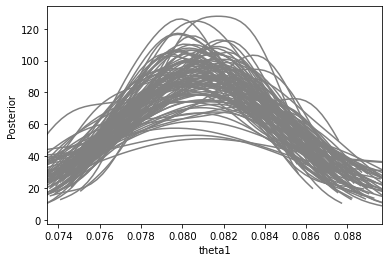

In [9]:
histories=[]
runtimes=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(pyabc.create_sqlite_db_id(), measured_data)
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories.append(h)
    runtimes[i]=endtime-starttime
    
    
    
tmax=histories[0].max_t
fig,ax = plt.subplots()
for i in range(iters):
    df,w = histories[i].get_distribution(m=0,t=histories[i].max_t)
    pyabc.visualization.plot_kde_1d(df,w, x='theta1',ax=ax, color='grey')

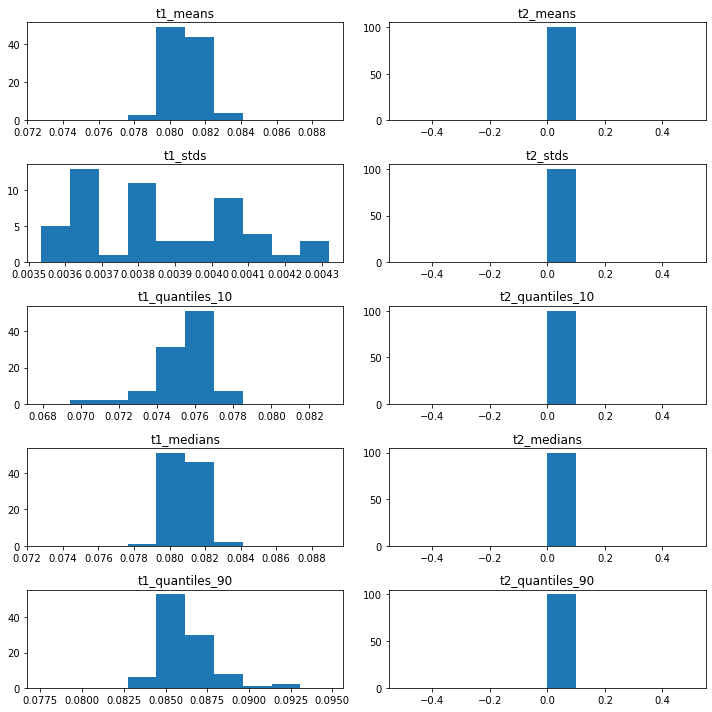

In [15]:
t1_quantiles_10 = np.zeros(iters)
t1_medians = np.zeros(iters)
t1_quantiles_90 = np.zeros(iters)
t1_means = np.zeros(iters)
t1_stds = np.zeros(iters)

t2_quantiles_10 = np.zeros(iters)
t2_medians = np.zeros(iters)
t2_quantiles_90 = np.zeros(iters)
t2_means = np.zeros(iters)
t2_stds = np.zeros(iters)



for i in range(iters):
    df,w= histories[i].get_distribution(m=0,t=histories[i].max_t)
    points = df['theta1'].values
    t1_quantiles_10[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.1)
    t1_medians[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.5)
    t1_quantiles_90[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.9)
    t1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    t1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    

allnames=[]
allnames.append("t1_means")
allnames.append("t2_means")
allnames.append("t1_stds")
allnames.append("t2_stds")
allnames.append("t1_quantiles_10")
allnames.append("t2_quantiles_10")
allnames.append("t1_medians")
allnames.append("t2_medians")
allnames.append("t1_quantiles_90")
allnames.append("t2_quantiles_90")

alldata = []
for i in range(len(allnames)):
    alldata.append(eval(allnames[i]))

    
    
fig = plt.figure(figsize=(10,10))
nx, ny=5, 2

for i in range(nx*ny):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata[i], bins = 10, range=(0.9*alldata[i].mean(), 1.1*alldata[i].mean()))
    ax.set_title(allnames[i])
    
fig.tight_layout()


In [16]:
t1_covs = np.zeros((5,5))

for i in range(nx):
    for j in range(nx):
        t1_covs[i,j]=np.cov(np.array(alldata[2*i]),np.array(alldata[2*j]))[0,1]

print(t1_covs)

[[ 6.55914823e-07  5.68124564e-08  7.56619535e-07  4.64537590e-07
   8.93264510e-07]
 [ 5.68124564e-08  4.23252608e-07 -5.85635837e-07  4.69975743e-08
   6.32006073e-07]
 [ 7.56619535e-07 -5.85635837e-07  2.14792342e-06  4.31064711e-07
   2.54573290e-07]
 [ 4.64537590e-07  4.69975743e-08  4.31064711e-07  4.33515016e-07
   5.67576926e-07]
 [ 8.93264510e-07  6.32006073e-07  2.54573290e-07  5.67576926e-07
   2.15468457e-06]]


## Modify the acceptance step

Secondly, we can alternatively use the non-noisy model, but adjust the acceptance step:

In [17]:
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()


abc = pyabc.ABCSMC(model, 
                   prior,
                   kernel,
                   sampler=redis_sampler,
                   eps=eps,
                   population_size=pop_size,
                   acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=107, start_time=2020-11-10 12:09:11.560095, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 19.499760137050632.


Start Duration:  0.002877950668334961
Preliminary accepted: 0
Acceptance Duration:  0.13686180114746094
Maybe Next Gen Duration:  2.384185791015625e-07
Wait time:  0.0004737377166748047
Preliminary discarded:  0
Collection Duration:  0.00036454200744628906
Rest Duration:  0.0016911029815673828
Time passed until sampling starts for generation 0 :  0.0068895816802978516
Start Duration:  0.0052945613861083984
Preliminary accepted: 0
Acceptance Duration:  0.49396800994873047
Maybe Next Gen Duration:  0.11243534088134766
Wait time:  0.0003609657287597656
Preliminary discarded:  0
Collection Duration:  0.001138925552368164
Rest Duration:  0.0041539669036865234
Duration of sampling for generation 0 :  0.6194643974304199


INFO:ABC:Acceptance rate: 500 / 1820 = 2.7473e-01, ESS=5.0000e+02.


History Duration:  0.9218025207519531


INFO:ABC:t: 1, eps: 2.1471449048420337.


PrepNext Duration:  4.220074415206909
Time passed until sampling starts for generation 1 :  5.177097797393799
Start Duration:  0.007770538330078125
Preliminary accepted: 500
Acceptance Duration:  0.6800892353057861
Maybe Next Gen Duration:  0.036286115646362305
Wait time:  0.00028443336486816406
Preliminary discarded:  1493
Collection Duration:  3.428617238998413
Rest Duration:  0.002733469009399414
Duration of sampling for generation 1 :  4.166612863540649


INFO:ABC:Acceptance rate: 500 / 7471 = 6.6925e-02, ESS=4.9652e+02.


History Duration:  0.8415110111236572


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5989665985107422
Time passed until sampling starts for generation 2 :  2.4817862510681152
Start Duration:  0.007302045822143555


INFO:pyabc.util:Stopping: minimum epsilon.


Preliminary accepted: 500
Acceptance Duration:  0.3798806667327881
Maybe Next Gen Duration:  0.028647422790527344
Wait time:  0.0003616809844970703
Preliminary discarded:  3828
Collection Duration:  2.272873878479004
Rest Duration:  0.0030112266540527344
Duration of sampling for generation 2 :  2.7014150619506836


INFO:ABC:Acceptance rate: 500 / 8518 = 5.8699e-02, ESS=4.5794e+02.


History Duration:  0.3411893844604492


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=107, start_time=2020-11-10 12:09:11.560095, end_time=2020-11-10 12:09:27.914079)>


PrepNext Duration:  0.626178503036499


We use a `pyabc.StochasticAcceptor` for the acceptor, replacing the default `pyabc.UniformAcceptor`, in order to accept when

$$\frac{\pi(D|y,\theta)}{c}\geq[0,1],$$
    
where $\pi(D|y,\theta)$ denotes the distribution of noisy data $D$ given non-noisy model output $y$ and parameters $\theta$. Here, we use a `pyabc.IndependentNormalKernel` in place of a `pyabc.Distance` to capture the normal noise $\pi(D|y,\theta)\sim\mathcal{N}(D|y,\theta,\sigma)$. Also other noise models are possible, including Laplace or binomial noise. In place of the `pyabc.Epsilon`, we employ a `pyabc.Temperature` which implements schemes to decrease a temperature $T\searrow 1$, s.t. in iteration $t$ we sample from

$$\pi(\theta,y|D) \propto \pi(D|y,\theta)^{1/T_t}p(y|\theta)\pi(\theta),$$

where $p(y|\theta)$ denotes the model output likelihood, and $\pi(\theta)$ the parameters prior.

Each of acceptor, kernel and temperature offers various configuration options, however the default parameters have shown to be quite stable already.

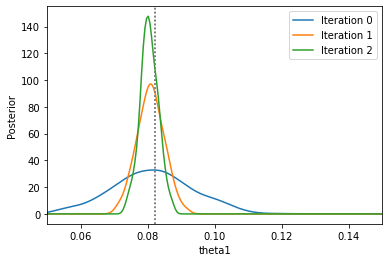

In [18]:
_, ax = plt.subplots()
for t in range(history_acceptor.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=theta_min, xmax=theta_max, ax=ax, numx=200, label=f"Iteration {t}")
ax.legend()
plt.show()

We see that we get essentially the same posterior distribution as with the noisy output (a bit more peaked, showing that the approximation error with the noisy output was not negligible yet), however at a much lower computational cost, as the below plot shows:

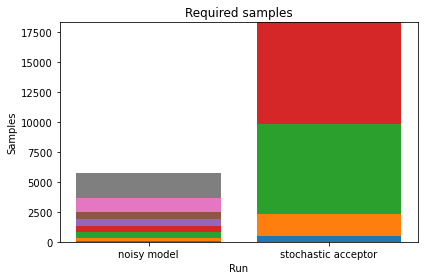

In [19]:
histories = [history_noisy_output, history_acceptor]
labels = ["noisy model", "stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)
plt.show()

Thus, the stochastic acceptor is the proposed method to use in practice. For further details consult the API documentation.

INFO:History:Start <ABCSMC(id=108, start_time=2020-11-10 12:10:28.464617, end_time=None)>
INFO:ABC:t: 0, eps: 19.503784933963573.


Time passed until sampling starts for generation 0 :  0.0070934295654296875
Start Duration:  0.003470897674560547
Preliminary accepted: 0
Acceptance Duration:  0.437227725982666
Maybe Next Gen Duration:  0.22954678535461426
Wait time:  0.002154111862182617
Preliminary discarded:  0
Collection Duration:  0.0015630722045898438
Rest Duration:  0.004089832305908203
Duration of sampling for generation 0 :  0.6804900169372559


INFO:ABC:Acceptance rate: 500 / 1696 = 2.9481e-01, ESS=5.0000e+02.


History Duration:  0.7707724571228027


INFO:ABC:t: 1, eps: 1.8121312771021854.


PrepNext Duration:  3.7308552265167236
Time passed until sampling starts for generation 1 :  4.5401811599731445
Start Duration:  0.0077478885650634766
Preliminary accepted: 500
Acceptance Duration:  0.6386802196502686
Maybe Next Gen Duration:  0.03560352325439453
Wait time:  0.0003237724304199219
Preliminary discarded:  1423
Collection Duration:  3.2958273887634277
Rest Duration:  0.0033273696899414062
Duration of sampling for generation 1 :  3.9926679134368896


INFO:ABC:Acceptance rate: 500 / 7260 = 6.8871e-02, ESS=4.9769e+02.


History Duration:  0.7019174098968506


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5489444732666016
Time passed until sampling starts for generation 2 :  2.284121036529541
Start Duration:  0.004791975021362305
Preliminary accepted: 500
Acceptance Duration:  0.35088419914245605
Maybe Next Gen Duration:  0.04459261894226074
Wait time:  0.0027735233306884766
Preliminary discarded:  4089
Collection Duration:  5.0609800815582275
Rest Duration:  0.004869699478149414
Duration of sampling for generation 2 :  5.484876871109009


INFO:ABC:Acceptance rate: 500 / 8148 = 6.1365e-02, ESS=4.4824e+02.


History Duration:  0.860058069229126


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6958763599395752
Time passed until sampling starts for generation 3 :  2.5948686599731445
Start Duration:  0.007359981536865234
Preliminary accepted: 500
Acceptance Duration:  0.341541051864624
Maybe Next Gen Duration:  0.03539085388183594
Wait time:  0.000255584716796875
Preliminary discarded:  6363
Collection Duration:  6.659844875335693
Rest Duration:  0.006785154342651367
Duration of sampling for generation 3 :  7.074293375015259


INFO:ABC:Acceptance rate: 500 / 10229 = 4.8881e-02, ESS=4.1434e+02.


History Duration:  0.714930534362793


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7238233089447021
Time passed until sampling starts for generation 4 :  2.473917007446289
Start Duration:  0.011935949325561523
Preliminary accepted: 500
Acceptance Duration:  0.3257181644439697
Maybe Next Gen Duration:  0.04034686088562012
Wait time:  0.0002624988555908203
Preliminary discarded:  8109
Collection Duration:  8.479642629623413
Rest Duration:  0.00777125358581543
Duration of sampling for generation 4 :  8.890536546707153


INFO:ABC:Acceptance rate: 500 / 12263 = 4.0773e-02, ESS=2.6046e+02.


History Duration:  0.7349822521209717


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6498003005981445
Time passed until sampling starts for generation 5 :  2.4236276149749756
Start Duration:  0.00749659538269043
Preliminary accepted: 500
Acceptance Duration:  0.33309054374694824
Maybe Next Gen Duration:  0.03397178649902344
Wait time:  0.00574803352355957
Preliminary discarded:  10164
Collection Duration:  10.858017921447754
Rest Duration:  0.009799003601074219
Duration of sampling for generation 5 :  11.286052465438843


INFO:ABC:Acceptance rate: 500 / 15441 = 3.2381e-02, ESS=3.2494e+02.


History Duration:  0.7715771198272705


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6771364212036133
Time passed until sampling starts for generation 6 :  2.4871692657470703
Start Duration:  0.012657403945922852
Preliminary accepted: 500
Acceptance Duration:  0.3708956241607666
Maybe Next Gen Duration:  0.03701639175415039
Wait time:  0.0032958984375
Preliminary discarded:  11733
Collection Duration:  12.08428168296814
Rest Duration:  0.008495807647705078
Duration of sampling for generation 6 :  12.557697057723999


INFO:ABC:Acceptance rate: 500 / 17848 = 2.8014e-02, ESS=3.9279e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8881642818450928
PrepNext Duration:  0.0803213119506836
Time passed until sampling starts for generation 7 :  1.0026955604553223
Start Duration:  0.011113882064819336
Preliminary accepted: 500
Acceptance Duration:  0.30437588691711426
Maybe Next Gen Duration:  0.0355374813079834
Wait time:  0.0002815723419189453
Preliminary discarded:  12811
Collection Duration:  6.017662048339844
Rest Duration:  0.005688667297363281
Duration of sampling for generation 7 :  6.402313709259033


INFO:ABC:Acceptance rate: 500 / 18750 = 2.6667e-02, ESS=3.5183e+02.
INFO:History:Done <ABCSMC(id=108, start_time=2020-11-10 12:10:28.464617, end_time=2020-11-10 12:11:43.111331)>
INFO:History:Start <ABCSMC(id=109, start_time=2020-11-10 12:11:43.125104, end_time=None)>
INFO:ABC:t: 0, eps: 19.50385186981276.


History Duration:  0.3430948257446289
PrepNext Duration:  0.04003262519836426
Time passed until sampling starts for generation 0 :  0.007006406784057617
Start Duration:  0.003162860870361328
Preliminary accepted: 0
Acceptance Duration:  0.39661526679992676
Maybe Next Gen Duration:  0.08234262466430664
Wait time:  0.0007531642913818359
Preliminary discarded:  0
Collection Duration:  0.0014450550079345703
Rest Duration:  0.0063440799713134766
Duration of sampling for generation 0 :  0.49234724044799805


INFO:ABC:Acceptance rate: 500 / 1602 = 3.1211e-01, ESS=5.0000e+02.


History Duration:  0.9113683700561523


INFO:ABC:t: 1, eps: 2.4807490150874587.


PrepNext Duration:  3.4256513118743896
Time passed until sampling starts for generation 1 :  4.375082492828369
Start Duration:  0.009736299514770508
Preliminary accepted: 500
Acceptance Duration:  0.5753951072692871
Maybe Next Gen Duration:  0.03733491897583008
Wait time:  0.0002512931823730469
Preliminary discarded:  1532
Collection Duration:  3.139732599258423
Rest Duration:  0.0033416748046875
Duration of sampling for generation 1 :  3.7758383750915527


INFO:ABC:Acceptance rate: 500 / 7383 = 6.7723e-02, ESS=4.9798e+02.


History Duration:  0.7227420806884766


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6209843158721924
Time passed until sampling starts for generation 2 :  2.3888802528381348
Start Duration:  0.008265018463134766
Preliminary accepted: 500
Acceptance Duration:  0.4169027805328369
Maybe Next Gen Duration:  0.14152169227600098
Wait time:  0.0007510185241699219
Preliminary discarded:  3775
Collection Duration:  4.767698764801025
Rest Duration:  0.0038192272186279297
Duration of sampling for generation 2 :  5.354738712310791


INFO:ABC:Acceptance rate: 500 / 8461 = 5.9095e-02, ESS=4.6194e+02.


History Duration:  0.8610591888427734


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5153493881225586
Time passed until sampling starts for generation 3 :  2.416628837585449
Start Duration:  0.006545066833496094
Preliminary accepted: 500
Acceptance Duration:  0.29540205001831055
Maybe Next Gen Duration:  0.03489947319030762
Wait time:  0.0004756450653076172
Preliminary discarded:  6567
Collection Duration:  6.755730867385864
Rest Duration:  0.005463123321533203
Duration of sampling for generation 3 :  7.121293306350708


INFO:ABC:Acceptance rate: 500 / 10522 = 4.7519e-02, ESS=4.2476e+02.


History Duration:  0.7033343315124512


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5649621486663818
Time passed until sampling starts for generation 4 :  2.30450177192688
Start Duration:  0.009483098983764648
Preliminary accepted: 500
Acceptance Duration:  0.3328239917755127
Maybe Next Gen Duration:  0.03695201873779297
Wait time:  0.0032706260681152344
Preliminary discarded:  8920
Collection Duration:  8.773017168045044
Rest Duration:  0.006384849548339844
Duration of sampling for generation 4 :  9.194663047790527


INFO:ABC:Acceptance rate: 500 / 13298 = 3.7600e-02, ESS=3.4135e+02.


History Duration:  0.6814520359039307


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6239597797393799
Time passed until sampling starts for generation 5 :  2.3502378463745117
Start Duration:  0.0067291259765625
Preliminary accepted: 500
Acceptance Duration:  0.3035285472869873
Maybe Next Gen Duration:  0.03418922424316406
Wait time:  0.0004508495330810547
Preliminary discarded:  10660
Collection Duration:  11.198909759521484
Rest Duration:  0.009109258651733398
Duration of sampling for generation 5 :  11.593950986862183


INFO:ABC:Acceptance rate: 500 / 15962 = 3.1324e-02, ESS=3.8735e+02.


History Duration:  0.6666665077209473


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5675466060638428
Time passed until sampling starts for generation 6 :  2.2743611335754395
Start Duration:  0.008626699447631836
Preliminary accepted: 500
Acceptance Duration:  0.3161342144012451
Maybe Next Gen Duration:  0.1506023406982422
Wait time:  0.0011360645294189453
Preliminary discarded:  12596
Collection Duration:  11.957029819488525
Rest Duration:  0.012524604797363281
Duration of sampling for generation 6 :  12.486537456512451


INFO:ABC:Acceptance rate: 500 / 18225 = 2.7435e-02, ESS=4.0778e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.852562427520752
PrepNext Duration:  0.0762178897857666
Time passed until sampling starts for generation 7 :  0.9681518077850342
Start Duration:  0.008407354354858398
Preliminary accepted: 500
Acceptance Duration:  0.31059718132019043
Maybe Next Gen Duration:  0.025781631469726562
Wait time:  0.0001800060272216797
Preliminary discarded:  13766
Collection Duration:  5.7469799518585205
Rest Duration:  0.0063436031341552734
Duration of sampling for generation 7 :  6.13100266456604


INFO:ABC:Acceptance rate: 500 / 19043 = 2.6256e-02, ESS=3.8980e+02.
INFO:History:Done <ABCSMC(id=109, start_time=2020-11-10 12:11:43.125104, end_time=2020-11-10 12:12:56.998856)>
INFO:History:Start <ABCSMC(id=110, start_time=2020-11-10 12:12:57.017201, end_time=None)>
INFO:ABC:t: 0, eps: 19.50385186981276.


History Duration:  0.5192296504974365
PrepNext Duration:  0.04027557373046875
Time passed until sampling starts for generation 0 :  0.006751060485839844
Start Duration:  0.0033915042877197266
Preliminary accepted: 0
Acceptance Duration:  0.46459221839904785
Maybe Next Gen Duration:  0.08974242210388184
Wait time:  0.0006976127624511719
Preliminary discarded:  0
Collection Duration:  0.002146005630493164
Rest Duration:  0.005261659622192383
Duration of sampling for generation 0 :  0.5679295063018799


INFO:ABC:Acceptance rate: 500 / 1727 = 2.8952e-01, ESS=5.0000e+02.


History Duration:  0.9258015155792236


INFO:ABC:t: 1, eps: 2.3085596708125253.


PrepNext Duration:  3.7212071418762207
Time passed until sampling starts for generation 1 :  4.6880927085876465
Start Duration:  0.00770258903503418
Preliminary accepted: 500
Acceptance Duration:  0.5524587631225586
Maybe Next Gen Duration:  0.033601999282836914
Wait time:  0.0017473697662353516
Preliminary discarded:  1632
Collection Duration:  3.425907850265503
Rest Duration:  0.003366231918334961
Duration of sampling for generation 1 :  4.036898851394653


INFO:ABC:Acceptance rate: 500 / 7807 = 6.4045e-02, ESS=4.9591e+02.


History Duration:  0.7184185981750488


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6029057502746582
Time passed until sampling starts for generation 2 :  2.3627564907073975
Start Duration:  0.007944107055664062
Preliminary accepted: 500
Acceptance Duration:  0.5003814697265625
Maybe Next Gen Duration:  0.03310418128967285
Wait time:  0.0002932548522949219
Preliminary discarded:  3870
Collection Duration:  5.089595317840576
Rest Duration:  0.0035386085510253906
Duration of sampling for generation 2 :  5.647885799407959


INFO:ABC:Acceptance rate: 500 / 9037 = 5.5328e-02, ESS=4.5803e+02.


History Duration:  0.8412151336669922


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.534841775894165
Time passed until sampling starts for generation 3 :  2.415822982788086
Start Duration:  0.010129690170288086
Preliminary accepted: 500
Acceptance Duration:  0.3218705654144287
Maybe Next Gen Duration:  0.03421282768249512
Wait time:  0.0004563331604003906
Preliminary discarded:  6982
Collection Duration:  7.275029182434082
Rest Duration:  0.006164073944091797
Duration of sampling for generation 3 :  7.671645164489746


INFO:ABC:Acceptance rate: 500 / 11281 = 4.4322e-02, ESS=3.6417e+02.


History Duration:  0.8379414081573486


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5733628273010254
Time passed until sampling starts for generation 4 :  2.4518561363220215
Start Duration:  0.008494138717651367
Preliminary accepted: 500
Acceptance Duration:  0.3016026020050049
Maybe Next Gen Duration:  0.03357505798339844
Wait time:  0.0003974437713623047
Preliminary discarded:  9318
Collection Duration:  9.264708995819092
Rest Duration:  0.007187366485595703
Duration of sampling for generation 4 :  9.645492792129517


INFO:ABC:Acceptance rate: 500 / 14441 = 3.4624e-02, ESS=3.9957e+02.


History Duration:  0.8781888484954834


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6274149417877197
Time passed until sampling starts for generation 5 :  2.539637327194214
Start Duration:  0.006756782531738281
Preliminary accepted: 500
Acceptance Duration:  0.2885551452636719
Maybe Next Gen Duration:  0.0348207950592041
Wait time:  0.0008077621459960938
Preliminary discarded:  11780
Collection Duration:  11.732008218765259
Rest Duration:  0.00854182243347168
Duration of sampling for generation 5 :  12.109579086303711


INFO:ABC:Acceptance rate: 500 / 17506 = 2.8562e-02, ESS=1.2723e+02.


History Duration:  0.716681718826294


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.574540376663208
Time passed until sampling starts for generation 6 :  2.336998701095581
Start Duration:  0.010228872299194336
Preliminary accepted: 500
Acceptance Duration:  0.35455989837646484
Maybe Next Gen Duration:  0.04033041000366211
Wait time:  0.0007956027984619141
Preliminary discarded:  12969
Collection Duration:  13.51898455619812
Rest Duration:  0.009334325790405273
Duration of sampling for generation 6 :  13.976662635803223


INFO:ABC:Acceptance rate: 500 / 20764 = 2.4080e-02, ESS=1.8995e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7067012786865234
PrepNext Duration:  0.06768679618835449
Time passed until sampling starts for generation 7 :  0.8093011379241943
Start Duration:  0.006276607513427734
Preliminary accepted: 500
Acceptance Duration:  0.3303823471069336
Maybe Next Gen Duration:  0.026431560516357422
Wait time:  0.0002193450927734375
Preliminary discarded:  12681
Collection Duration:  6.21428108215332
Rest Duration:  0.005730867385864258
Duration of sampling for generation 7 :  6.6116180419921875


INFO:ABC:Acceptance rate: 500 / 21193 = 2.3593e-02, ESS=3.9493e+02.
INFO:History:Done <ABCSMC(id=110, start_time=2020-11-10 12:12:57.017201, end_time=2020-11-10 12:14:15.479668)>
INFO:History:Start <ABCSMC(id=111, start_time=2020-11-10 12:14:15.494260, end_time=None)>
INFO:ABC:t: 0, eps: 19.50385186981276.


History Duration:  0.4646282196044922
PrepNext Duration:  0.048752546310424805
Time passed until sampling starts for generation 0 :  0.006553173065185547
Start Duration:  0.0032427310943603516
Preliminary accepted: 0
Acceptance Duration:  0.37918591499328613
Maybe Next Gen Duration:  0.08255386352539062
Wait time:  0.0007023811340332031
Preliminary discarded:  0
Collection Duration:  0.0017161369323730469
Rest Duration:  0.003918170928955078
Duration of sampling for generation 0 :  0.4732370376586914


INFO:ABC:Acceptance rate: 500 / 1538 = 3.2510e-01, ESS=5.0000e+02.


History Duration:  0.6633915901184082


INFO:ABC:t: 1, eps: 1.7168133342631944.


PrepNext Duration:  3.3121447563171387
Time passed until sampling starts for generation 1 :  4.0123138427734375
Start Duration:  0.006709098815917969
Preliminary accepted: 500
Acceptance Duration:  0.6652877330780029
Maybe Next Gen Duration:  0.14660072326660156
Wait time:  0.0005152225494384766
Preliminary discarded:  1211
Collection Duration:  2.8329005241394043
Rest Duration:  0.003285646438598633
Duration of sampling for generation 1 :  3.6661808490753174


INFO:ABC:Acceptance rate: 500 / 6835 = 7.3153e-02, ESS=4.9785e+02.


History Duration:  0.7473971843719482


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6014842987060547
Time passed until sampling starts for generation 2 :  2.393568992614746
Start Duration:  0.008002042770385742
Preliminary accepted: 500
Acceptance Duration:  0.3515632152557373
Maybe Next Gen Duration:  0.16084051132202148
Wait time:  0.00031495094299316406
Preliminary discarded:  4037
Collection Duration:  4.508710145950317
Rest Duration:  0.004395246505737305
Duration of sampling for generation 2 :  5.05098295211792


INFO:ABC:Acceptance rate: 500 / 7961 = 6.2806e-02, ESS=4.5021e+02.


History Duration:  0.8587508201599121


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.540118932723999
Time passed until sampling starts for generation 3 :  2.434356212615967
Start Duration:  0.010642290115356445
Preliminary accepted: 500
Acceptance Duration:  0.30905866622924805
Maybe Next Gen Duration:  0.035341739654541016
Wait time:  0.00042891502380371094
Preliminary discarded:  6516
Collection Duration:  6.459254741668701
Rest Duration:  0.005854129791259766
Duration of sampling for generation 3 :  6.848436594009399


INFO:ABC:Acceptance rate: 500 / 10376 = 4.8188e-02, ESS=1.1923e+02.


History Duration:  0.8600401878356934


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5855841636657715
Time passed until sampling starts for generation 4 :  2.4814858436584473
Start Duration:  0.006942033767700195
Preliminary accepted: 500
Acceptance Duration:  0.33106470108032227
Maybe Next Gen Duration:  0.03646087646484375
Wait time:  0.0004723072052001953
Preliminary discarded:  7642
Collection Duration:  8.53475570678711
Rest Duration:  0.006135225296020508
Duration of sampling for generation 4 :  8.94186019897461


INFO:ABC:Acceptance rate: 500 / 13264 = 3.7696e-02, ESS=2.5140e+00.


History Duration:  0.7149863243103027


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.613879919052124
Time passed until sampling starts for generation 5 :  2.3717312812805176
Start Duration:  0.008544921875
Preliminary accepted: 500
Acceptance Duration:  0.6638271808624268
Maybe Next Gen Duration:  0.03397870063781738
Wait time:  0.002796649932861328
Preliminary discarded:  3459
Collection Duration:  8.899305820465088
Rest Duration:  0.004072904586791992
Duration of sampling for generation 5 :  9.62811017036438


INFO:ABC:Acceptance rate: 500 / 16740 = 2.9869e-02, ESS=4.3826e+02.


History Duration:  0.7271783351898193


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.603156328201294
Time passed until sampling starts for generation 6 :  2.3605282306671143
Start Duration:  0.0065233707427978516
Preliminary accepted: 500
Acceptance Duration:  0.32863950729370117
Maybe Next Gen Duration:  0.13966012001037598
Wait time:  0.0003693103790283203
Preliminary discarded:  10206
Collection Duration:  10.750250816345215
Rest Duration:  0.00752711296081543
Duration of sampling for generation 6 :  11.267274856567383


INFO:ABC:Acceptance rate: 500 / 16825 = 2.9718e-02, ESS=4.0264e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8476202487945557
PrepNext Duration:  0.058379411697387695
Time passed until sampling starts for generation 7 :  0.9409732818603516
Start Duration:  0.0068359375
Preliminary accepted: 500
Acceptance Duration:  0.3305840492248535
Maybe Next Gen Duration:  0.026529788970947266
Wait time:  0.0002028942108154297
Preliminary discarded:  11087
Collection Duration:  4.988135099411011
Rest Duration:  0.00503993034362793
Duration of sampling for generation 7 :  5.381953239440918


INFO:ABC:Acceptance rate: 500 / 17336 = 2.8842e-02, ESS=3.9603e+02.
INFO:History:Done <ABCSMC(id=111, start_time=2020-11-10 12:14:15.494260, end_time=2020-11-10 12:15:24.330942)>
INFO:History:Start <ABCSMC(id=112, start_time=2020-11-10 12:15:24.344498, end_time=None)>
INFO:ABC:t: 0, eps: 19.50385191997988.


History Duration:  0.4626305103302002
PrepNext Duration:  0.04314923286437988
Time passed until sampling starts for generation 0 :  0.006696462631225586
Start Duration:  0.003203153610229492
Preliminary accepted: 0
Acceptance Duration:  0.4226830005645752
Maybe Next Gen Duration:  0.09235119819641113
Wait time:  0.0008640289306640625
Preliminary discarded:  0
Collection Duration:  0.005704641342163086
Rest Duration:  0.0032889842987060547
Duration of sampling for generation 0 :  0.5298683643341064


INFO:ABC:Acceptance rate: 500 / 1719 = 2.9087e-01, ESS=5.0000e+02.


History Duration:  0.8757848739624023


INFO:ABC:t: 1, eps: 1.975820232377043.


PrepNext Duration:  3.6474545001983643
Time passed until sampling starts for generation 1 :  4.558225870132446
Start Duration:  0.00701451301574707
Preliminary accepted: 500
Acceptance Duration:  0.5836336612701416
Maybe Next Gen Duration:  0.03545975685119629
Wait time:  0.0002884864807128906
Preliminary discarded:  1492
Collection Duration:  3.29777193069458
Rest Duration:  0.0033447742462158203
Duration of sampling for generation 1 :  3.943061113357544


INFO:ABC:Acceptance rate: 500 / 7651 = 6.5351e-02, ESS=4.9692e+02.


History Duration:  0.8841850757598877


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.586437463760376
Time passed until sampling starts for generation 2 :  2.5109879970550537
Start Duration:  0.010791778564453125
Preliminary accepted: 500
Acceptance Duration:  0.35361719131469727
Maybe Next Gen Duration:  0.03424978256225586
Wait time:  0.0048825740814208984
Preliminary discarded:  4297
Collection Duration:  5.310338973999023
Rest Duration:  0.0047724246978759766
Duration of sampling for generation 2 :  5.735783815383911


INFO:ABC:Acceptance rate: 500 / 8927 = 5.6010e-02, ESS=4.6660e+02.


History Duration:  0.7193231582641602


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5740549564361572
Time passed until sampling starts for generation 3 :  2.3335559368133545
Start Duration:  0.007252216339111328
Preliminary accepted: 500
Acceptance Duration:  0.3169729709625244
Maybe Next Gen Duration:  0.03403639793395996
Wait time:  0.0026962757110595703
Preliminary discarded:  7242
Collection Duration:  7.2831501960754395
Rest Duration:  0.006142854690551758
Duration of sampling for generation 3 :  7.676264762878418


INFO:ABC:Acceptance rate: 500 / 11439 = 4.3710e-02, ESS=2.6789e+02.


History Duration:  0.8211021423339844


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5536324977874756
Time passed until sampling starts for generation 4 :  2.407768487930298
Start Duration:  0.006894350051879883
Preliminary accepted: 500
Acceptance Duration:  0.30672359466552734
Maybe Next Gen Duration:  0.03497052192687988
Wait time:  0.002439260482788086
Preliminary discarded:  8903
Collection Duration:  9.40120816230774
Rest Duration:  0.006849050521850586
Duration of sampling for generation 4 :  9.789258241653442


INFO:ABC:Acceptance rate: 500 / 14369 = 3.4797e-02, ESS=3.5003e+02.


History Duration:  0.7015745639801025


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.609807014465332
Time passed until sampling starts for generation 5 :  2.3494629859924316
Start Duration:  0.006686210632324219
Preliminary accepted: 500
Acceptance Duration:  0.32839274406433105
Maybe Next Gen Duration:  0.03464174270629883
Wait time:  0.0004649162292480469
Preliminary discarded:  10663
Collection Duration:  11.522976398468018
Rest Duration:  0.007323265075683594
Duration of sampling for generation 5 :  11.937782526016235


INFO:ABC:Acceptance rate: 500 / 17478 = 2.8607e-02, ESS=4.2132e+02.


History Duration:  0.7082004547119141


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5282096862792969
Time passed until sampling starts for generation 6 :  2.276890516281128
Start Duration:  0.008681774139404297
Preliminary accepted: 500
Acceptance Duration:  0.3127269744873047
Maybe Next Gen Duration:  0.041654348373413086
Wait time:  0.000408172607421875
Preliminary discarded:  13585
Collection Duration:  13.49094820022583
Rest Duration:  0.0135650634765625
Duration of sampling for generation 6 :  13.91640305519104


INFO:ABC:Acceptance rate: 500 / 20152 = 2.4811e-02, ESS=3.4704e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8734822273254395
PrepNext Duration:  0.0856468677520752
Time passed until sampling starts for generation 7 :  0.9980442523956299
Start Duration:  0.006625175476074219
Preliminary accepted: 500
Acceptance Duration:  0.31036901473999023
Maybe Next Gen Duration:  0.026195049285888672
Wait time:  0.0001842975616455078
Preliminary discarded:  13495
Collection Duration:  5.881371259689331
Rest Duration:  0.005926847457885742
Duration of sampling for generation 7 :  6.26163387298584


INFO:ABC:Acceptance rate: 500 / 21016 = 2.3791e-02, ESS=3.9750e+02.
INFO:History:Done <ABCSMC(id=112, start_time=2020-11-10 12:15:24.344498, end_time=2020-11-10 12:16:42.041022)>
INFO:History:Start <ABCSMC(id=113, start_time=2020-11-10 12:16:42.055818, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.34966039657592773
PrepNext Duration:  0.043000221252441406
Time passed until sampling starts for generation 0 :  0.012735366821289062
Start Duration:  0.00394439697265625
Preliminary accepted: 0
Acceptance Duration:  0.47855424880981445
Maybe Next Gen Duration:  0.10589432716369629
Wait time:  0.0009844303131103516
Preliminary discarded:  0
Collection Duration:  0.0018570423126220703
Rest Duration:  0.0038471221923828125
Duration of sampling for generation 0 :  0.597966194152832


INFO:ABC:Acceptance rate: 500 / 1781 = 2.8074e-01, ESS=5.0000e+02.


History Duration:  0.9289958477020264


INFO:ABC:t: 1, eps: 1.864025589605576.


PrepNext Duration:  3.8547110557556152
Time passed until sampling starts for generation 1 :  4.822024822235107
Start Duration:  0.008549928665161133
Preliminary accepted: 500
Acceptance Duration:  0.5953867435455322
Maybe Next Gen Duration:  0.03478050231933594
Wait time:  0.0004627704620361328
Preliminary discarded:  1597
Collection Duration:  3.50687313079834
Rest Duration:  0.003961086273193359
Duration of sampling for generation 1 :  4.164678335189819


INFO:ABC:Acceptance rate: 500 / 7921 = 6.3123e-02, ESS=4.9801e+02.


History Duration:  0.8971703052520752


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6217882633209229
Time passed until sampling starts for generation 2 :  2.556316375732422
Start Duration:  0.006746530532836914
Preliminary accepted: 500
Acceptance Duration:  0.3547029495239258
Maybe Next Gen Duration:  0.03386950492858887
Wait time:  0.0005276203155517578
Preliminary discarded:  4640
Collection Duration:  5.446222543716431
Rest Duration:  0.0049495697021484375
Duration of sampling for generation 2 :  5.8660218715667725


INFO:ABC:Acceptance rate: 500 / 9409 = 5.3141e-02, ESS=4.6349e+02.


History Duration:  0.852802038192749


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6302709579467773
Time passed until sampling starts for generation 3 :  2.5180294513702393
Start Duration:  0.004907131195068359
Preliminary accepted: 500
Acceptance Duration:  0.32860851287841797
Maybe Next Gen Duration:  0.03406715393066406
Wait time:  0.0027742385864257812
Preliminary discarded:  7293
Collection Duration:  7.817769289016724
Rest Duration:  0.006682395935058594
Duration of sampling for generation 3 :  8.222361326217651


INFO:ABC:Acceptance rate: 500 / 11867 = 4.2134e-02, ESS=3.4644e+02.


History Duration:  0.8777544498443604


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5419244766235352
Time passed until sampling starts for generation 4 :  2.4639732837677
Start Duration:  0.007035493850708008
Preliminary accepted: 500
Acceptance Duration:  0.348771333694458
Maybe Next Gen Duration:  0.03549623489379883
Wait time:  0.0002875328063964844
Preliminary discarded:  9535
Collection Duration:  10.066246032714844
Rest Duration:  0.009331703186035156
Duration of sampling for generation 4 :  10.513452768325806


INFO:ABC:Acceptance rate: 500 / 15180 = 3.2938e-02, ESS=3.4425e+02.


History Duration:  0.7470207214355469


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.672999382019043
Time passed until sampling starts for generation 5 :  2.4578211307525635
Start Duration:  0.00696563720703125
Preliminary accepted: 500
Acceptance Duration:  0.31748414039611816
Maybe Next Gen Duration:  0.035315752029418945
Wait time:  0.0013861656188964844
Preliminary discarded:  11868
Collection Duration:  12.108309030532837
Rest Duration:  0.008608102798461914
Duration of sampling for generation 5 :  12.519180297851562


INFO:ABC:Acceptance rate: 500 / 18210 = 2.7457e-02, ESS=3.1937e+02.


History Duration:  0.7351212501525879


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6393601894378662
Time passed until sampling starts for generation 6 :  2.410926103591919
Start Duration:  0.0069200992584228516
Preliminary accepted: 500
Acceptance Duration:  0.3188140392303467
Maybe Next Gen Duration:  0.034247636795043945
Wait time:  0.006435871124267578
Preliminary discarded:  13801
Collection Duration:  14.472498893737793
Rest Duration:  0.00938105583190918
Duration of sampling for generation 6 :  14.89432406425476


INFO:ABC:Acceptance rate: 500 / 21065 = 2.3736e-02, ESS=3.1012e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.913022518157959
PrepNext Duration:  0.0828244686126709
Time passed until sampling starts for generation 7 :  1.040769338607788
Start Duration:  0.008728504180908203
Preliminary accepted: 500
Acceptance Duration:  0.33753013610839844
Maybe Next Gen Duration:  0.026360034942626953
Wait time:  0.0002269744873046875
Preliminary discarded:  14688
Collection Duration:  6.456165075302124
Rest Duration:  0.00682830810546875
Duration of sampling for generation 7 :  6.872720718383789


INFO:ABC:Acceptance rate: 500 / 22155 = 2.2568e-02, ESS=3.9873e+02.
INFO:History:Done <ABCSMC(id=113, start_time=2020-11-10 12:16:42.055818, end_time=2020-11-10 12:18:04.563320)>
INFO:History:Start <ABCSMC(id=114, start_time=2020-11-10 12:18:04.580731, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4367961883544922
PrepNext Duration:  0.05450582504272461
Time passed until sampling starts for generation 0 :  0.0074040889739990234
Start Duration:  0.0037069320678710938
Preliminary accepted: 0
Acceptance Duration:  0.4019200801849365
Maybe Next Gen Duration:  0.1909654140472412
Wait time:  0.00041937828063964844
Preliminary discarded:  0
Collection Duration:  0.001348733901977539
Rest Duration:  0.003497600555419922
Duration of sampling for generation 0 :  0.6052188873291016


INFO:ABC:Acceptance rate: 500 / 1622 = 3.0826e-01, ESS=5.0000e+02.


History Duration:  0.7595548629760742


INFO:ABC:t: 1, eps: 1.5129143849874485.


PrepNext Duration:  3.5642623901367188
Time passed until sampling starts for generation 1 :  4.359991550445557
Start Duration:  0.006986379623413086
Preliminary accepted: 500
Acceptance Duration:  0.6189734935760498
Maybe Next Gen Duration:  0.03514385223388672
Wait time:  0.000728607177734375
Preliminary discarded:  1273
Collection Duration:  3.2388548851013184
Rest Duration:  0.003335714340209961
Duration of sampling for generation 1 :  3.916226863861084


INFO:ABC:Acceptance rate: 500 / 7425 = 6.7340e-02, ESS=4.9516e+02.


History Duration:  0.7886123657226562


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5786612033843994
Time passed until sampling starts for generation 2 :  2.4127566814422607
Start Duration:  0.007805824279785156
Preliminary accepted: 500
Acceptance Duration:  0.3318789005279541
Maybe Next Gen Duration:  0.038306236267089844
Wait time:  0.00044035911560058594
Preliminary discarded:  4597
Collection Duration:  5.527833938598633
Rest Duration:  0.005099773406982422
Duration of sampling for generation 2 :  5.93039608001709


INFO:ABC:Acceptance rate: 500 / 8567 = 5.8363e-02, ESS=4.0979e+02.


History Duration:  0.6962742805480957


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6438407897949219
Time passed until sampling starts for generation 3 :  2.376836061477661
Start Duration:  0.006596803665161133
Preliminary accepted: 500
Acceptance Duration:  0.40178966522216797
Maybe Next Gen Duration:  0.034900665283203125
Wait time:  0.00026226043701171875
Preliminary discarded:  7151
Collection Duration:  7.247549533843994
Rest Duration:  0.006382465362548828
Duration of sampling for generation 3 :  7.7233147621154785


INFO:ABC:Acceptance rate: 500 / 11162 = 4.4795e-02, ESS=2.8991e+02.


History Duration:  0.6846098899841309


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6014635562896729
Time passed until sampling starts for generation 4 :  2.325913667678833
Start Duration:  0.005039215087890625
Preliminary accepted: 500
Acceptance Duration:  0.348696231842041
Maybe Next Gen Duration:  0.035169363021850586
Wait time:  0.002401590347290039
Preliminary discarded:  8207
Collection Duration:  9.323332071304321
Rest Duration:  0.0066242218017578125
Duration of sampling for generation 4 :  9.750916719436646


INFO:ABC:Acceptance rate: 500 / 14026 = 3.5648e-02, ESS=4.1808e+02.


History Duration:  0.7114992141723633


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6790952682495117
Time passed until sampling starts for generation 5 :  2.4291012287139893
Start Duration:  0.008878707885742188
Preliminary accepted: 500
Acceptance Duration:  0.321291446685791
Maybe Next Gen Duration:  0.035567522048950195
Wait time:  0.0005285739898681641
Preliminary discarded:  10823
Collection Duration:  11.616652488708496
Rest Duration:  0.008091926574707031
Duration of sampling for generation 5 :  12.028028726577759


INFO:ABC:Acceptance rate: 500 / 17110 = 2.9223e-02, ESS=4.0340e+02.


History Duration:  0.749913215637207


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5734429359436035
Time passed until sampling starts for generation 6 :  2.361259698867798
Start Duration:  0.0065593719482421875
Preliminary accepted: 500
Acceptance Duration:  0.3405752182006836
Maybe Next Gen Duration:  0.03495144844055176
Wait time:  0.0029289722442626953
Preliminary discarded:  12780
Collection Duration:  13.61598253250122
Rest Duration:  0.009302854537963867
Duration of sampling for generation 6 :  14.054070234298706


INFO:ABC:Acceptance rate: 500 / 20072 = 2.4910e-02, ESS=4.3929e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8764815330505371
PrepNext Duration:  0.09028840065002441
Time passed until sampling starts for generation 7 :  1.0025715827941895
Start Duration:  0.008574724197387695
Preliminary accepted: 500
Acceptance Duration:  0.33750271797180176
Maybe Next Gen Duration:  0.032048702239990234
Wait time:  0.0002925395965576172
Preliminary discarded:  13910
Collection Duration:  6.03998589515686
Rest Duration:  0.006087541580200195
Duration of sampling for generation 7 :  6.456744194030762


INFO:ABC:Acceptance rate: 500 / 21085 = 2.3714e-02, ESS=4.1862e+02.
INFO:History:Done <ABCSMC(id=114, start_time=2020-11-10 12:18:04.580731, end_time=2020-11-10 12:19:22.820431)>
INFO:History:Start <ABCSMC(id=115, start_time=2020-11-10 12:19:22.834756, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.37069153785705566
PrepNext Duration:  0.04495429992675781
Time passed until sampling starts for generation 0 :  0.006482839584350586
Start Duration:  0.003674030303955078
Preliminary accepted: 0
Acceptance Duration:  0.3995640277862549
Maybe Next Gen Duration:  0.21753382682800293
Wait time:  0.0005090236663818359
Preliminary discarded:  0
Collection Duration:  0.001447439193725586
Rest Duration:  0.003789186477661133
Duration of sampling for generation 0 :  0.6286978721618652


INFO:ABC:Acceptance rate: 500 / 1654 = 3.0230e-01, ESS=5.0000e+02.


History Duration:  0.717329740524292


INFO:ABC:t: 1, eps: 1.9738070824260243.


PrepNext Duration:  3.5349996089935303
Time passed until sampling starts for generation 1 :  4.2879345417022705
Start Duration:  0.006555795669555664
Preliminary accepted: 500
Acceptance Duration:  0.5650613307952881
Maybe Next Gen Duration:  0.03629422187805176
Wait time:  0.0002913475036621094
Preliminary discarded:  1385
Collection Duration:  3.3551251888275146
Rest Duration:  0.0037729740142822266
Duration of sampling for generation 1 :  3.97929048538208


INFO:ABC:Acceptance rate: 500 / 7179 = 6.9648e-02, ESS=4.9669e+02.


History Duration:  0.7038671970367432


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.627819299697876
Time passed until sampling starts for generation 2 :  2.3740339279174805
Start Duration:  0.008895158767700195
Preliminary accepted: 500
Acceptance Duration:  0.36870288848876953
Maybe Next Gen Duration:  0.035463571548461914
Wait time:  0.0013339519500732422
Preliminary discarded:  4105
Collection Duration:  5.216169118881226
Rest Duration:  0.005739688873291016
Duration of sampling for generation 2 :  5.656998157501221


INFO:ABC:Acceptance rate: 500 / 8719 = 5.7346e-02, ESS=4.6687e+02.


History Duration:  0.8971049785614014


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6044552326202393
Time passed until sampling starts for generation 3 :  2.5386016368865967
Start Duration:  0.01061701774597168
Preliminary accepted: 500
Acceptance Duration:  0.2933347225189209
Maybe Next Gen Duration:  0.0347895622253418
Wait time:  0.0038156509399414062
Preliminary discarded:  7265
Collection Duration:  7.586658477783203
Rest Duration:  0.006498575210571289
Duration of sampling for generation 3 :  7.9659717082977295


INFO:ABC:Acceptance rate: 500 / 11476 = 4.3569e-02, ESS=3.6027e+02.


History Duration:  0.7610301971435547


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5652050971984863
Time passed until sampling starts for generation 4 :  2.3625941276550293
Start Duration:  0.006731748580932617
Preliminary accepted: 500
Acceptance Duration:  0.31073451042175293
Maybe Next Gen Duration:  0.0348660945892334
Wait time:  0.00045371055603027344
Preliminary discarded:  9265
Collection Duration:  9.778887271881104
Rest Duration:  0.008475303649902344
Duration of sampling for generation 4 :  10.174949169158936


INFO:ABC:Acceptance rate: 500 / 14391 = 3.4744e-02, ESS=2.8596e+01.


History Duration:  0.7049698829650879


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6047642230987549
Time passed until sampling starts for generation 5 :  2.3481557369232178
Start Duration:  0.006735324859619141
Preliminary accepted: 500
Acceptance Duration:  0.36744189262390137
Maybe Next Gen Duration:  0.03494453430175781
Wait time:  0.0021944046020507812
Preliminary discarded:  8606
Collection Duration:  11.386722326278687
Rest Duration:  0.008487701416015625
Duration of sampling for generation 5 :  11.844037294387817


INFO:ABC:Acceptance rate: 500 / 17774 = 2.8131e-02, ESS=4.4036e+02.


History Duration:  0.7798430919647217


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6879916191101074
Time passed until sampling starts for generation 6 :  2.501612663269043
Start Duration:  0.0050144195556640625
Preliminary accepted: 500
Acceptance Duration:  0.35088562965393066
Maybe Next Gen Duration:  0.03722858428955078
Wait time:  0.006955862045288086
Preliminary discarded:  13390
Collection Duration:  13.83389925956726
Rest Duration:  0.009225845336914062
Duration of sampling for generation 6 :  14.288610219955444


INFO:ABC:Acceptance rate: 500 / 20052 = 2.4935e-02, ESS=3.3706e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7308790683746338
PrepNext Duration:  0.08507490158081055
Time passed until sampling starts for generation 7 :  0.8534479141235352
Start Duration:  0.007337808609008789
Preliminary accepted: 500
Acceptance Duration:  0.3189077377319336
Maybe Next Gen Duration:  0.030534029006958008
Wait time:  0.0003631114959716797
Preliminary discarded:  13437
Collection Duration:  6.261469125747681
Rest Duration:  0.005505084991455078
Duration of sampling for generation 7 :  6.654608249664307


INFO:ABC:Acceptance rate: 500 / 20678 = 2.4180e-02, ESS=2.3045e+02.
INFO:History:Done <ABCSMC(id=115, start_time=2020-11-10 12:19:22.834756, end_time=2020-11-10 12:20:41.894403)>
INFO:History:Start <ABCSMC(id=116, start_time=2020-11-10 12:20:41.908681, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4702451229095459
PrepNext Duration:  0.04601621627807617
Time passed until sampling starts for generation 0 :  0.011474132537841797
Start Duration:  0.0044443607330322266
Preliminary accepted: 0
Acceptance Duration:  0.44570064544677734
Maybe Next Gen Duration:  0.09969401359558105
Wait time:  0.0006082057952880859
Preliminary discarded:  0
Collection Duration:  0.0012850761413574219
Rest Duration:  0.0053827762603759766
Duration of sampling for generation 0 :  0.5595016479492188


INFO:ABC:Acceptance rate: 500 / 1648 = 3.0340e-01, ESS=5.0000e+02.


History Duration:  0.9516925811767578


INFO:ABC:t: 1, eps: 1.6648687119151884.


PrepNext Duration:  3.5993845462799072
Time passed until sampling starts for generation 1 :  4.589865446090698
Start Duration:  0.008508920669555664
Preliminary accepted: 500
Acceptance Duration:  0.6544084548950195
Maybe Next Gen Duration:  0.033753156661987305
Wait time:  0.0002911090850830078
Preliminary discarded:  1415
Collection Duration:  3.240743398666382
Rest Duration:  0.0037338733673095703
Duration of sampling for generation 1 :  3.9538137912750244


INFO:ABC:Acceptance rate: 500 / 7808 = 6.4037e-02, ESS=4.9707e+02.


History Duration:  0.6503183841705322


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6043708324432373
Time passed until sampling starts for generation 2 :  2.2932446002960205
Start Duration:  0.009352445602416992
Preliminary accepted: 500
Acceptance Duration:  0.35027384757995605
Maybe Next Gen Duration:  0.16296029090881348
Wait time:  0.002344846725463867
Preliminary discarded:  4109
Collection Duration:  4.854780673980713
Rest Duration:  0.004315376281738281
Duration of sampling for generation 2 :  5.4048216342926025


INFO:ABC:Acceptance rate: 500 / 8258 = 6.0547e-02, ESS=2.8754e+02.


History Duration:  0.8812603950500488


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5843558311462402
Time passed until sampling starts for generation 3 :  2.5020833015441895
Start Duration:  0.007058620452880859
Preliminary accepted: 500
Acceptance Duration:  0.3214683532714844
Maybe Next Gen Duration:  0.035340070724487305
Wait time:  0.0004391670227050781
Preliminary discarded:  6424
Collection Duration:  7.015215873718262
Rest Duration:  0.0055103302001953125
Duration of sampling for generation 3 :  7.409133195877075


INFO:ABC:Acceptance rate: 500 / 10993 = 4.5483e-02, ESS=3.8274e+02.


History Duration:  0.627880334854126


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5887110233306885
Time passed until sampling starts for generation 4 :  2.2568745613098145
Start Duration:  0.006790637969970703
Preliminary accepted: 500
Acceptance Duration:  0.30623793601989746
Maybe Next Gen Duration:  0.14177536964416504
Wait time:  0.0007193088531494141
Preliminary discarded:  8748
Collection Duration:  9.062607765197754
Rest Duration:  0.007176637649536133
Duration of sampling for generation 4 :  9.560108423233032


INFO:ABC:Acceptance rate: 500 / 13462 = 3.7142e-02, ESS=3.3326e+02.


History Duration:  0.7704179286956787


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6301631927490234
Time passed until sampling starts for generation 5 :  2.4382729530334473
Start Duration:  0.006887674331665039
Preliminary accepted: 500
Acceptance Duration:  0.31604671478271484
Maybe Next Gen Duration:  0.034897565841674805
Wait time:  0.003288745880126953
Preliminary discarded:  10893
Collection Duration:  11.229862928390503
Rest Duration:  0.008125066757202148
Duration of sampling for generation 5 :  11.636836290359497


INFO:ABC:Acceptance rate: 500 / 16827 = 2.9714e-02, ESS=4.1845e+02.


History Duration:  0.8885409832000732


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6224291324615479
Time passed until sampling starts for generation 6 :  2.551097869873047
Start Duration:  0.010502338409423828
Preliminary accepted: 500
Acceptance Duration:  0.28412365913391113
Maybe Next Gen Duration:  0.037969350814819336
Wait time:  0.0004444122314453125
Preliminary discarded:  13579
Collection Duration:  13.851858377456665
Rest Duration:  0.013157844543457031
Duration of sampling for generation 6 :  14.24317979812622


INFO:ABC:Acceptance rate: 500 / 19825 = 2.5221e-02, ESS=3.9017e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7481691837310791
PrepNext Duration:  0.08808755874633789
Time passed until sampling starts for generation 7 :  0.8803684711456299
Start Duration:  0.008687257766723633
Preliminary accepted: 500
Acceptance Duration:  0.3296351432800293
Maybe Next Gen Duration:  0.026859760284423828
Wait time:  0.00022220611572265625
Preliminary discarded:  14632
Collection Duration:  6.692759990692139
Rest Duration:  0.0063207149505615234
Duration of sampling for generation 7 :  7.096864223480225


INFO:ABC:Acceptance rate: 500 / 21290 = 2.3485e-02, ESS=3.3100e+02.
INFO:History:Done <ABCSMC(id=116, start_time=2020-11-10 12:20:41.908681, end_time=2020-11-10 12:21:59.958139)>
INFO:History:Start <ABCSMC(id=117, start_time=2020-11-10 12:21:59.974338, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.534163236618042
PrepNext Duration:  0.055669546127319336
Time passed until sampling starts for generation 0 :  0.007477760314941406
Start Duration:  0.0039594173431396484
Preliminary accepted: 0
Acceptance Duration:  0.42700672149658203
Maybe Next Gen Duration:  0.09061217308044434
Wait time:  0.0043315887451171875
Preliminary discarded:  0
Collection Duration:  0.0022478103637695312
Rest Duration:  0.003663778305053711
Duration of sampling for generation 0 :  0.5340855121612549


INFO:ABC:Acceptance rate: 500 / 1602 = 3.1211e-01, ESS=5.0000e+02.


History Duration:  0.905937671661377


INFO:ABC:t: 1, eps: 1.9313392802592133.


PrepNext Duration:  3.5767714977264404
Time passed until sampling starts for generation 1 :  4.518628835678101
Start Duration:  0.006840944290161133
Preliminary accepted: 500
Acceptance Duration:  0.628415584564209
Maybe Next Gen Duration:  0.034742116928100586
Wait time:  0.0004329681396484375
Preliminary discarded:  1454
Collection Duration:  3.119324207305908
Rest Duration:  0.0073969364166259766
Duration of sampling for generation 1 :  3.811878204345703


INFO:ABC:Acceptance rate: 500 / 7687 = 6.5045e-02, ESS=4.9806e+02.


History Duration:  0.8947505950927734


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5196197032928467
Time passed until sampling starts for generation 2 :  2.457515001296997
Start Duration:  0.006564140319824219
Preliminary accepted: 500
Acceptance Duration:  0.37624597549438477
Maybe Next Gen Duration:  0.03753662109375
Wait time:  0.0004611015319824219
Preliminary discarded:  4196
Collection Duration:  4.9705491065979
Rest Duration:  0.004692554473876953
Duration of sampling for generation 2 :  5.4156174659729


INFO:ABC:Acceptance rate: 500 / 8524 = 5.8658e-02, ESS=4.4250e+02.


History Duration:  0.8803067207336426


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6424248218536377
Time passed until sampling starts for generation 3 :  2.5624094009399414
Start Duration:  0.008397102355957031
Preliminary accepted: 500
Acceptance Duration:  0.3235785961151123
Maybe Next Gen Duration:  0.03531074523925781
Wait time:  0.0004630088806152344
Preliminary discarded:  7309
Collection Duration:  7.580522537231445
Rest Duration:  0.004645824432373047
Duration of sampling for generation 3 :  7.9754955768585205


INFO:ABC:Acceptance rate: 500 / 11238 = 4.4492e-02, ESS=3.5187e+02.


History Duration:  0.8415627479553223


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6371426582336426
Time passed until sampling starts for generation 4 :  2.5158493518829346
Start Duration:  0.006936788558959961
Preliminary accepted: 500
Acceptance Duration:  0.31807923316955566
Maybe Next Gen Duration:  0.03892874717712402
Wait time:  0.0005314350128173828
Preliminary discarded:  8757
Collection Duration:  8.970200061798096
Rest Duration:  0.006856203079223633
Duration of sampling for generation 4 :  9.368959665298462


INFO:ABC:Acceptance rate: 500 / 13907 = 3.5953e-02, ESS=3.8463e+02.


History Duration:  0.9616358280181885


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.5925498008728027
Time passed until sampling starts for generation 5 :  2.5956549644470215
Start Duration:  0.010737419128417969
Preliminary accepted: 500
Acceptance Duration:  0.2989370822906494
Maybe Next Gen Duration:  0.03665018081665039
Wait time:  0.00028586387634277344
Preliminary discarded:  10821
Collection Duration:  11.072824716567993
Rest Duration:  0.008093118667602539
Duration of sampling for generation 5 :  11.465064525604248


INFO:ABC:Acceptance rate: 500 / 16752 = 2.9847e-02, ESS=3.8475e+02.


History Duration:  0.8968379497528076


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.533857822418213
Time passed until sampling starts for generation 6 :  2.470719575881958
Start Duration:  0.007830381393432617
Preliminary accepted: 500
Acceptance Duration:  0.31158947944641113
Maybe Next Gen Duration:  0.0388944149017334
Wait time:  0.0006253719329833984
Preliminary discarded:  12819
Collection Duration:  13.464026927947998
Rest Duration:  0.008435487747192383
Duration of sampling for generation 6 :  13.874457597732544


INFO:ABC:Acceptance rate: 500 / 19558 = 2.5565e-02, ESS=4.1976e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.6769261360168457
PrepNext Duration:  0.09095215797424316
Time passed until sampling starts for generation 7 :  0.8085157871246338
Start Duration:  0.009195804595947266
Preliminary accepted: 500
Acceptance Duration:  0.31373047828674316
Maybe Next Gen Duration:  0.026919126510620117
Wait time:  0.00020575523376464844
Preliminary discarded:  13380
Collection Duration:  6.119497299194336
Rest Duration:  0.005936145782470703
Duration of sampling for generation 7 :  6.506594657897949


INFO:ABC:Acceptance rate: 500 / 20494 = 2.4397e-02, ESS=7.4823e+01.
INFO:History:Done <ABCSMC(id=117, start_time=2020-11-10 12:21:59.974338, end_time=2020-11-10 12:23:17.464165)>
INFO:History:Start <ABCSMC(id=118, start_time=2020-11-10 12:23:17.478454, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.47429466247558594
PrepNext Duration:  0.0468752384185791
Time passed until sampling starts for generation 0 :  0.00803232192993164
Start Duration:  0.0042035579681396484
Preliminary accepted: 0
Acceptance Duration:  0.46023988723754883
Maybe Next Gen Duration:  0.10027170181274414
Wait time:  0.0009987354278564453
Preliminary discarded:  0
Collection Duration:  0.0014371871948242188
Rest Duration:  0.007505178451538086
Duration of sampling for generation 0 :  0.576836347579956


INFO:ABC:Acceptance rate: 500 / 1675 = 2.9851e-01, ESS=5.0000e+02.


History Duration:  0.9085991382598877


INFO:ABC:t: 1, eps: 1.6187308379918592.


PrepNext Duration:  3.6384105682373047
Time passed until sampling starts for generation 1 :  4.587435007095337
Start Duration:  0.0060863494873046875
Preliminary accepted: 500
Acceptance Duration:  0.6483092308044434
Maybe Next Gen Duration:  0.03561568260192871
Wait time:  0.002876758575439453
Preliminary discarded:  1392
Collection Duration:  3.2627921104431152
Rest Duration:  0.0036847591400146484
Duration of sampling for generation 1 :  3.9716761112213135


INFO:ABC:Acceptance rate: 500 / 7697 = 6.4960e-02, ESS=4.9733e+02.


History Duration:  0.7318515777587891


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6532485485076904
Time passed until sampling starts for generation 2 :  2.421358823776245
Start Duration:  0.0068438053131103516
Preliminary accepted: 500
Acceptance Duration:  0.35344743728637695
Maybe Next Gen Duration:  0.03438258171081543
Wait time:  0.0005192756652832031
Preliminary discarded:  4544
Collection Duration:  5.039576530456543
Rest Duration:  0.005018711090087891
Duration of sampling for generation 2 :  5.45835542678833


INFO:ABC:Acceptance rate: 500 / 8640 = 5.7870e-02, ESS=4.4515e+02.


History Duration:  0.8489518165588379


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.643495798110962
Time passed until sampling starts for generation 3 :  2.53297758102417
Start Duration:  0.010639190673828125
Preliminary accepted: 500
Acceptance Duration:  0.2987496852874756
Maybe Next Gen Duration:  0.03399777412414551
Wait time:  0.0008132457733154297
Preliminary discarded:  7027
Collection Duration:  7.176392316818237
Rest Duration:  0.006090879440307617
Duration of sampling for generation 3 :  7.552733898162842


INFO:ABC:Acceptance rate: 500 / 11147 = 4.4855e-02, ESS=4.1330e+02.


History Duration:  0.8997664451599121


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5938153266906738
Time passed until sampling starts for generation 4 :  2.5316619873046875
Start Duration:  0.006454944610595703
Preliminary accepted: 500
Acceptance Duration:  0.3186373710632324
Maybe Next Gen Duration:  0.03497147560119629
Wait time:  0.0004363059997558594
Preliminary discarded:  9383
Collection Duration:  9.485231161117554
Rest Duration:  0.007590055465698242
Duration of sampling for generation 4 :  9.891152143478394


INFO:ABC:Acceptance rate: 500 / 14243 = 3.5105e-02, ESS=3.6407e+02.


History Duration:  0.7747476100921631


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.5331699848175049
Time passed until sampling starts for generation 5 :  2.3471288681030273
Start Duration:  0.008413076400756836
Preliminary accepted: 500
Acceptance Duration:  0.31194114685058594
Maybe Next Gen Duration:  0.03500628471374512
Wait time:  0.0003466606140136719
Preliminary discarded:  11368
Collection Duration:  11.725834846496582
Rest Duration:  0.008498907089233398
Duration of sampling for generation 5 :  12.128892183303833


INFO:ABC:Acceptance rate: 500 / 17116 = 2.9212e-02, ESS=2.5982e+01.


History Duration:  0.780097246170044


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7180495262145996
Time passed until sampling starts for generation 6 :  2.543027877807617
Start Duration:  0.008795022964477539
Preliminary accepted: 500
Acceptance Duration:  0.36714935302734375
Maybe Next Gen Duration:  0.034330129623413086
Wait time:  0.00820159912109375
Preliminary discarded:  10464
Collection Duration:  13.607075214385986
Rest Duration:  0.00824427604675293
Duration of sampling for generation 6 :  14.068587303161621


INFO:ABC:Acceptance rate: 500 / 20753 = 2.4093e-02, ESS=4.6664e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7089791297912598
PrepNext Duration:  0.08930444717407227
Time passed until sampling starts for generation 7 :  0.8345849514007568
Start Duration:  0.00558924674987793
Preliminary accepted: 500
Acceptance Duration:  0.3191864490509033
Maybe Next Gen Duration:  0.02663397789001465
Wait time:  0.00019288063049316406
Preliminary discarded:  13537
Collection Duration:  6.2819764614105225
Rest Duration:  0.005853891372680664
Duration of sampling for generation 7 :  6.669795989990234


INFO:ABC:Acceptance rate: 500 / 20399 = 2.4511e-02, ESS=2.5243e+02.
INFO:History:Done <ABCSMC(id=118, start_time=2020-11-10 12:23:17.478454, end_time=2020-11-10 12:24:36.179998)>
INFO:History:Start <ABCSMC(id=119, start_time=2020-11-10 12:24:36.194303, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4548919200897217
PrepNext Duration:  0.04738259315490723
Time passed until sampling starts for generation 0 :  0.006365776062011719
Start Duration:  0.0033774375915527344
Preliminary accepted: 0
Acceptance Duration:  0.42400026321411133
Maybe Next Gen Duration:  0.09194421768188477
Wait time:  0.0009031295776367188
Preliminary discarded:  0
Collection Duration:  0.00585174560546875
Rest Duration:  0.0043566226959228516
Duration of sampling for generation 0 :  0.5323293209075928


INFO:ABC:Acceptance rate: 500 / 1793 = 2.7886e-01, ESS=5.0000e+02.


History Duration:  0.902827262878418


INFO:ABC:t: 1, eps: 2.4465106479326693.


PrepNext Duration:  3.8328001499176025
Time passed until sampling starts for generation 1 :  4.778549432754517
Start Duration:  0.0066907405853271484
Preliminary accepted: 500
Acceptance Duration:  0.5875289440155029
Maybe Next Gen Duration:  0.03548741340637207
Wait time:  0.00045490264892578125
Preliminary discarded:  1748
Collection Duration:  3.7099969387054443
Rest Duration:  0.003429412841796875
Duration of sampling for generation 1 :  4.356854438781738


INFO:ABC:Acceptance rate: 500 / 8019 = 6.2352e-02, ESS=4.9793e+02.


History Duration:  0.8784630298614502


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5791652202606201
Time passed until sampling starts for generation 2 :  2.4938597679138184
Start Duration:  0.00916743278503418
Preliminary accepted: 500
Acceptance Duration:  0.4033830165863037
Maybe Next Gen Duration:  0.037774085998535156
Wait time:  0.0009415149688720703
Preliminary discarded:  4163
Collection Duration:  5.632230758666992
Rest Duration:  0.004282951354980469
Duration of sampling for generation 2 :  6.105803489685059


INFO:ABC:Acceptance rate: 500 / 9581 = 5.2187e-02, ESS=4.6840e+02.


History Duration:  0.8933050632476807


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5836305618286133
Time passed until sampling starts for generation 3 :  2.513415575027466
Start Duration:  0.007361173629760742
Preliminary accepted: 500
Acceptance Duration:  0.35081911087036133
Maybe Next Gen Duration:  0.04275250434875488
Wait time:  0.00033164024353027344
Preliminary discarded:  7528
Collection Duration:  7.763323783874512
Rest Duration:  0.005805253982543945
Duration of sampling for generation 3 :  8.197561502456665


INFO:ABC:Acceptance rate: 500 / 12061 = 4.1456e-02, ESS=2.0684e+02.


History Duration:  0.8363368511199951


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6036899089813232
Time passed until sampling starts for generation 4 :  2.4838342666625977
Start Duration:  0.008159399032592773
Preliminary accepted: 500
Acceptance Duration:  0.33153653144836426
Maybe Next Gen Duration:  0.036905527114868164
Wait time:  0.0013532638549804688
Preliminary discarded:  9144
Collection Duration:  9.907921314239502
Rest Duration:  0.0070607662200927734
Duration of sampling for generation 4 :  10.324851274490356


INFO:ABC:Acceptance rate: 500 / 14891 = 3.3577e-02, ESS=4.0689e+02.


History Duration:  0.7244658470153809


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6392686367034912
Time passed until sampling starts for generation 5 :  2.403059482574463
Start Duration:  0.007170677185058594
Preliminary accepted: 500
Acceptance Duration:  0.3068406581878662
Maybe Next Gen Duration:  0.033411502838134766
Wait time:  0.00031447410583496094
Preliminary discarded:  12024
Collection Duration:  12.204568862915039
Rest Duration:  0.011432170867919922
Duration of sampling for generation 5 :  12.61750316619873


INFO:ABC:Acceptance rate: 500 / 17796 = 2.8096e-02, ESS=3.8393e+02.


History Duration:  0.8241069316864014


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6575615406036377
Time passed until sampling starts for generation 6 :  2.5215039253234863
Start Duration:  0.006604433059692383
Preliminary accepted: 500
Acceptance Duration:  0.32433414459228516
Maybe Next Gen Duration:  0.04445385932922363
Wait time:  0.0005941390991210938
Preliminary discarded:  14309
Collection Duration:  14.485351324081421
Rest Duration:  0.009726285934448242
Duration of sampling for generation 6 :  14.921666145324707


INFO:ABC:Acceptance rate: 500 / 21154 = 2.3636e-02, ESS=3.2476e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8653078079223633
PrepNext Duration:  0.08817529678344727
Time passed until sampling starts for generation 7 :  1.0005550384521484
Start Duration:  0.008155584335327148
Preliminary accepted: 500
Acceptance Duration:  0.31635212898254395
Maybe Next Gen Duration:  0.026883602142333984
Wait time:  0.00019311904907226562
Preliminary discarded:  14254
Collection Duration:  6.589672803878784
Rest Duration:  0.006189823150634766
Duration of sampling for generation 7 :  6.980436325073242


INFO:ABC:Acceptance rate: 500 / 21954 = 2.2775e-02, ESS=4.1357e+02.
INFO:History:Done <ABCSMC(id=119, start_time=2020-11-10 12:24:36.194303, end_time=2020-11-10 12:25:58.949952)>
INFO:History:Start <ABCSMC(id=120, start_time=2020-11-10 12:25:58.970467, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.38243532180786133
PrepNext Duration:  0.05894351005554199
Time passed until sampling starts for generation 0 :  0.0075893402099609375
Start Duration:  0.003368377685546875
Preliminary accepted: 0
Acceptance Duration:  0.49280595779418945
Maybe Next Gen Duration:  0.09312772750854492
Wait time:  0.00046944618225097656
Preliminary discarded:  0
Collection Duration:  0.0006041526794433594
Rest Duration:  0.003643512725830078
Duration of sampling for generation 0 :  0.5959784984588623


INFO:ABC:Acceptance rate: 500 / 1703 = 2.9360e-01, ESS=5.0000e+02.


History Duration:  0.8171415328979492


INFO:ABC:t: 1, eps: 2.489740080813254.


PrepNext Duration:  3.75455641746521
Time passed until sampling starts for generation 1 :  4.622105121612549
Start Duration:  0.008252859115600586
Preliminary accepted: 500
Acceptance Duration:  0.5216166973114014
Maybe Next Gen Duration:  0.03390216827392578
Wait time:  0.0003476142883300781
Preliminary discarded:  1681
Collection Duration:  3.5519766807556152
Rest Duration:  0.003645181655883789
Duration of sampling for generation 1 :  4.134400367736816


INFO:ABC:Acceptance rate: 500 / 7474 = 6.6899e-02, ESS=4.9779e+02.


History Duration:  0.7086026668548584


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5980732440948486
Time passed until sampling starts for generation 2 :  2.346202850341797
Start Duration:  0.006711244583129883
Preliminary accepted: 500
Acceptance Duration:  0.39936304092407227
Maybe Next Gen Duration:  0.14228248596191406
Wait time:  0.0004813671112060547
Preliminary discarded:  3968
Collection Duration:  5.068415880203247
Rest Duration:  0.004833221435546875
Duration of sampling for generation 2 :  5.638973951339722


INFO:ABC:Acceptance rate: 500 / 9053 = 5.5230e-02, ESS=4.3194e+02.


History Duration:  0.9364030361175537


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6261367797851562
Time passed until sampling starts for generation 3 :  2.5988025665283203
Start Duration:  0.006846427917480469
Preliminary accepted: 500
Acceptance Duration:  0.3352017402648926
Maybe Next Gen Duration:  0.03470635414123535
Wait time:  0.0005388259887695312
Preliminary discarded:  7089
Collection Duration:  7.5808656215667725
Rest Duration:  0.00767064094543457
Duration of sampling for generation 3 :  7.998064994812012


INFO:ABC:Acceptance rate: 500 / 11436 = 4.3722e-02, ESS=3.9224e+02.


History Duration:  0.9073083400726318


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6398448944091797
Time passed until sampling starts for generation 4 :  2.588665246963501
Start Duration:  0.006880521774291992
Preliminary accepted: 500
Acceptance Duration:  0.30133748054504395
Maybe Next Gen Duration:  0.03841733932495117
Wait time:  0.0004878044128417969
Preliminary discarded:  9542
Collection Duration:  9.676650762557983
Rest Duration:  0.007462501525878906
Duration of sampling for generation 4 :  10.065964937210083


INFO:ABC:Acceptance rate: 500 / 14433 = 3.4643e-02, ESS=3.5617e+02.


History Duration:  0.8900141716003418


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6203081607818604
Time passed until sampling starts for generation 5 :  2.5470759868621826
Start Duration:  0.009186267852783203
Preliminary accepted: 500
Acceptance Duration:  0.3183939456939697
Maybe Next Gen Duration:  0.035980224609375
Wait time:  0.0008471012115478516
Preliminary discarded:  11258
Collection Duration:  11.612726211547852
Rest Duration:  0.008167743682861328
Duration of sampling for generation 5 :  12.024247407913208


INFO:ABC:Acceptance rate: 500 / 17754 = 2.8163e-02, ESS=4.0910e+02.


History Duration:  0.8894882202148438


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5797936916351318
Time passed until sampling starts for generation 6 :  2.504693031311035
Start Duration:  0.007013559341430664
Preliminary accepted: 500
Acceptance Duration:  0.30884408950805664
Maybe Next Gen Duration:  0.0343778133392334
Wait time:  0.0003018379211425781
Preliminary discarded:  13783
Collection Duration:  14.027485847473145
Rest Duration:  0.009627580642700195
Duration of sampling for generation 6 :  14.434331893920898


INFO:ABC:Acceptance rate: 500 / 20365 = 2.4552e-02, ESS=2.8184e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7124617099761963
PrepNext Duration:  0.09478068351745605
Time passed until sampling starts for generation 7 :  0.8445446491241455
Start Duration:  0.009026527404785156
Preliminary accepted: 500
Acceptance Duration:  0.3137180805206299
Maybe Next Gen Duration:  0.027407169342041016
Wait time:  0.000202178955078125
Preliminary discarded:  14512
Collection Duration:  6.168268918991089
Rest Duration:  0.006463527679443359
Duration of sampling for generation 7 :  6.558684587478638


INFO:ABC:Acceptance rate: 500 / 21395 = 2.3370e-02, ESS=4.3937e+02.
INFO:History:Done <ABCSMC(id=120, start_time=2020-11-10 12:25:58.970467, end_time=2020-11-10 12:27:19.074085)>
INFO:History:Start <ABCSMC(id=121, start_time=2020-11-10 12:27:19.089173, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.46465539932250977
PrepNext Duration:  0.048809051513671875
Time passed until sampling starts for generation 0 :  0.007752418518066406
Start Duration:  0.003816366195678711
Preliminary accepted: 0
Acceptance Duration:  0.4726371765136719
Maybe Next Gen Duration:  0.11176753044128418
Wait time:  0.0007922649383544922
Preliminary discarded:  0
Collection Duration:  0.0018682479858398438
Rest Duration:  0.00881195068359375
Duration of sampling for generation 0 :  0.6017591953277588


INFO:ABC:Acceptance rate: 500 / 1702 = 2.9377e-01, ESS=5.0000e+02.


History Duration:  0.9317886829376221


INFO:ABC:t: 1, eps: 1.6341795352955353.


PrepNext Duration:  3.8524951934814453
Time passed until sampling starts for generation 1 :  4.825526714324951
Start Duration:  0.006871461868286133
Preliminary accepted: 500
Acceptance Duration:  0.6196959018707275
Maybe Next Gen Duration:  0.03745245933532715
Wait time:  0.0003993511199951172
Preliminary discarded:  1511
Collection Duration:  3.4330615997314453
Rest Duration:  0.00336456298828125
Duration of sampling for generation 1 :  4.113013744354248


INFO:ABC:Acceptance rate: 500 / 8074 = 6.1927e-02, ESS=4.9751e+02.


History Duration:  0.8765172958374023


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6092112064361572
Time passed until sampling starts for generation 2 :  2.532195568084717
Start Duration:  0.008375406265258789
Preliminary accepted: 500
Acceptance Duration:  0.3687095642089844
Maybe Next Gen Duration:  0.03590679168701172
Wait time:  0.0028014183044433594
Preliminary discarded:  4653
Collection Duration:  5.499170780181885
Rest Duration:  0.005054473876953125
Duration of sampling for generation 2 :  5.943584203720093


INFO:ABC:Acceptance rate: 500 / 9149 = 5.4651e-02, ESS=4.5137e+02.


History Duration:  0.7314052581787109


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6126093864440918
Time passed until sampling starts for generation 3 :  2.37846302986145
Start Duration:  0.008037805557250977
Preliminary accepted: 500
Acceptance Duration:  0.31905245780944824
Maybe Next Gen Duration:  0.035053253173828125
Wait time:  0.0003185272216796875
Preliminary discarded:  7391
Collection Duration:  7.606720685958862
Rest Duration:  0.006412982940673828
Duration of sampling for generation 3 :  8.003029346466064


INFO:ABC:Acceptance rate: 500 / 11715 = 4.2680e-02, ESS=2.3129e+02.


History Duration:  0.892134428024292


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6133012771606445
Time passed until sampling starts for generation 4 :  2.541414737701416
Start Duration:  0.008603572845458984
Preliminary accepted: 500
Acceptance Duration:  0.37303900718688965
Maybe Next Gen Duration:  0.038584232330322266
Wait time:  0.00029015541076660156
Preliminary discarded:  9004
Collection Duration:  9.76524543762207
Rest Duration:  0.007699489593505859
Duration of sampling for generation 4 :  10.226956129074097


INFO:ABC:Acceptance rate: 500 / 14525 = 3.4423e-02, ESS=3.9123e+02.


History Duration:  1.0096721649169922


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6398284435272217
Time passed until sampling starts for generation 5 :  2.686750650405884
Start Duration:  0.009690999984741211
Preliminary accepted: 500
Acceptance Duration:  0.299527645111084
Maybe Next Gen Duration:  0.03842663764953613
Wait time:  0.0004506111145019531
Preliminary discarded:  11711
Collection Duration:  12.225547790527344
Rest Duration:  0.008522748947143555
Duration of sampling for generation 5 :  12.622343063354492


INFO:ABC:Acceptance rate: 500 / 18221 = 2.7441e-02, ESS=4.1646e+02.


History Duration:  0.7209146022796631


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6059460639953613
Time passed until sampling starts for generation 6 :  2.36757230758667
Start Duration:  0.006890058517456055
Preliminary accepted: 500
Acceptance Duration:  0.31578636169433594
Maybe Next Gen Duration:  0.03585481643676758
Wait time:  0.007082223892211914
Preliminary discarded:  14381
Collection Duration:  14.509316682815552
Rest Duration:  0.009540081024169922
Duration of sampling for generation 6 :  14.934669494628906


INFO:ABC:Acceptance rate: 500 / 20985 = 2.3827e-02, ESS=3.9536e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8937079906463623
PrepNext Duration:  0.10968542098999023
Time passed until sampling starts for generation 7 :  1.0474190711975098
Start Duration:  0.008561134338378906
Preliminary accepted: 500
Acceptance Duration:  0.3027341365814209
Maybe Next Gen Duration:  0.03546476364135742
Wait time:  0.0001895427703857422
Preliminary discarded:  14969
Collection Duration:  6.402645111083984
Rest Duration:  0.007409334182739258
Duration of sampling for generation 7 :  6.794264793395996


INFO:ABC:Acceptance rate: 500 / 21904 = 2.2827e-02, ESS=3.6689e+02.
INFO:History:Done <ABCSMC(id=121, start_time=2020-11-10 12:27:19.089173, end_time=2020-11-10 12:28:41.209711)>
INFO:History:Start <ABCSMC(id=122, start_time=2020-11-10 12:28:41.223591, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.36676907539367676
PrepNext Duration:  0.04977560043334961
Time passed until sampling starts for generation 0 :  0.00656437873840332
Start Duration:  0.0030465126037597656
Preliminary accepted: 0
Acceptance Duration:  0.46991801261901855
Maybe Next Gen Duration:  0.10759758949279785
Wait time:  0.0004947185516357422
Preliminary discarded:  0
Collection Duration:  0.0011553764343261719
Rest Duration:  0.003796815872192383
Duration of sampling for generation 0 :  0.588313102722168


INFO:ABC:Acceptance rate: 500 / 1762 = 2.8377e-01, ESS=5.0000e+02.


History Duration:  0.8792533874511719


INFO:ABC:t: 1, eps: 3.2021449398944415.


PrepNext Duration:  3.788653612136841
Time passed until sampling starts for generation 1 :  4.706320762634277
Start Duration:  0.010488510131835938
Preliminary accepted: 500
Acceptance Duration:  0.5436215400695801
Maybe Next Gen Duration:  0.03667640686035156
Wait time:  0.00022339820861816406
Preliminary discarded:  1855
Collection Duration:  3.5838239192962646
Rest Duration:  0.0035970211029052734
Duration of sampling for generation 1 :  4.191453218460083


INFO:ABC:Acceptance rate: 500 / 7884 = 6.3420e-02, ESS=4.9677e+02.


History Duration:  0.8235855102539062


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5362026691436768
Time passed until sampling starts for generation 2 :  2.3932061195373535
Start Duration:  0.007698535919189453
Preliminary accepted: 500
Acceptance Duration:  0.39563512802124023
Maybe Next Gen Duration:  0.03502511978149414
Wait time:  0.0002982616424560547
Preliminary discarded:  3732
Collection Duration:  5.272649049758911
Rest Duration:  0.004259347915649414
Duration of sampling for generation 2 :  5.731234312057495


INFO:ABC:Acceptance rate: 500 / 9067 = 5.5145e-02, ESS=4.8182e+02.


History Duration:  0.7158267498016357


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.648352861404419
Time passed until sampling starts for generation 3 :  2.4053266048431396
Start Duration:  0.009280920028686523
Preliminary accepted: 500
Acceptance Duration:  0.31146907806396484
Maybe Next Gen Duration:  0.037087202072143555
Wait time:  0.0007469654083251953
Preliminary discarded:  7359
Collection Duration:  7.5949530601501465
Rest Duration:  0.0075664520263671875
Duration of sampling for generation 3 :  7.994231939315796


INFO:ABC:Acceptance rate: 500 / 11461 = 4.3626e-02, ESS=3.3999e+02.


History Duration:  0.905785322189331


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5720858573913574
Time passed until sampling starts for generation 4 :  2.5199289321899414
Start Duration:  0.011038064956665039
Preliminary accepted: 500
Acceptance Duration:  0.30958104133605957
Maybe Next Gen Duration:  0.03794145584106445
Wait time:  0.0004432201385498047
Preliminary discarded:  9521
Collection Duration:  10.193392753601074
Rest Duration:  0.007727146148681641
Duration of sampling for generation 4 :  10.597937822341919


INFO:ABC:Acceptance rate: 500 / 14776 = 3.3839e-02, ESS=1.9548e+02.


History Duration:  0.7340149879455566


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6441950798034668
Time passed until sampling starts for generation 5 :  2.417984962463379
Start Duration:  0.010426759719848633
Preliminary accepted: 500
Acceptance Duration:  0.34809327125549316
Maybe Next Gen Duration:  0.03747057914733887
Wait time:  0.00054168701171875
Preliminary discarded:  10688
Collection Duration:  12.387484550476074
Rest Duration:  0.008068561553955078
Duration of sampling for generation 5 :  12.829453468322754


INFO:ABC:Acceptance rate: 500 / 18480 = 2.7056e-02, ESS=4.1049e+02.


History Duration:  0.7599921226501465


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6616873741149902
Time passed until sampling starts for generation 6 :  2.4660096168518066
Start Duration:  0.0070171356201171875
Preliminary accepted: 500
Acceptance Duration:  0.31525421142578125
Maybe Next Gen Duration:  0.03900957107543945
Wait time:  0.0005090236663818359
Preliminary discarded:  13813
Collection Duration:  14.528502464294434
Rest Duration:  0.009877443313598633
Duration of sampling for generation 6 :  14.95235538482666


INFO:ABC:Acceptance rate: 500 / 21468 = 2.3290e-02, ESS=4.0471e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7598841190338135
PrepNext Duration:  0.09481287002563477
Time passed until sampling starts for generation 7 :  0.8950841426849365
Start Duration:  0.006990671157836914
Preliminary accepted: 500
Acceptance Duration:  0.306455135345459
Maybe Next Gen Duration:  0.027559518814086914
Wait time:  0.00022602081298828125
Preliminary discarded:  15235
Collection Duration:  6.5420823097229
Rest Duration:  0.007157087326049805
Duration of sampling for generation 7 :  6.928574085235596


INFO:ABC:Acceptance rate: 500 / 22367 = 2.2354e-02, ESS=3.5848e+02.
INFO:History:Done <ABCSMC(id=122, start_time=2020-11-10 12:28:41.223591, end_time=2020-11-10 12:30:03.371292)>
INFO:History:Start <ABCSMC(id=123, start_time=2020-11-10 12:30:03.385373, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.3916032314300537
PrepNext Duration:  0.055986881256103516
Time passed until sampling starts for generation 0 :  0.011506795883178711
Start Duration:  0.0052947998046875
Preliminary accepted: 0
Acceptance Duration:  0.4101865291595459
Maybe Next Gen Duration:  0.08664274215698242
Wait time:  0.0008869171142578125
Preliminary discarded:  0
Collection Duration:  0.0016255378723144531
Rest Duration:  0.004733562469482422
Duration of sampling for generation 0 :  0.5112712383270264


INFO:ABC:Acceptance rate: 500 / 1709 = 2.9257e-01, ESS=5.0000e+02.


History Duration:  0.740941047668457


INFO:ABC:t: 1, eps: 2.3854806551835286.


PrepNext Duration:  3.636409282684326
Time passed until sampling starts for generation 1 :  4.416184663772583
Start Duration:  0.008217811584472656
Preliminary accepted: 500
Acceptance Duration:  0.6649777889251709
Maybe Next Gen Duration:  0.03801894187927246
Wait time:  0.0005028247833251953
Preliminary discarded:  1509
Collection Duration:  3.298823595046997
Rest Duration:  0.003554105758666992
Duration of sampling for generation 1 :  4.0265936851501465


INFO:ABC:Acceptance rate: 500 / 7400 = 6.7568e-02, ESS=4.9607e+02.


History Duration:  0.7648189067840576


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.545196533203125
Time passed until sampling starts for generation 2 :  2.35180926322937
Start Duration:  0.007360935211181641
Preliminary accepted: 500
Acceptance Duration:  0.38810229301452637
Maybe Next Gen Duration:  0.1445460319519043
Wait time:  0.006579875946044922
Preliminary discarded:  3967
Collection Duration:  4.949779033660889
Rest Duration:  0.004634380340576172
Duration of sampling for generation 2 :  5.517629384994507


INFO:ABC:Acceptance rate: 500 / 8659 = 5.7743e-02, ESS=4.5125e+02.


History Duration:  0.8958499431610107


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.639153242111206
Time passed until sampling starts for generation 3 :  2.5747809410095215
Start Duration:  0.006509304046630859
Preliminary accepted: 500
Acceptance Duration:  0.2753171920776367
Maybe Next Gen Duration:  0.03542470932006836
Wait time:  0.00047278404235839844
Preliminary discarded:  6663
Collection Duration:  6.843508005142212
Rest Duration:  0.006022214889526367
Duration of sampling for generation 3 :  7.192188024520874


INFO:ABC:Acceptance rate: 500 / 10550 = 4.7393e-02, ESS=3.8750e+02.


History Duration:  0.8573663234710693


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.663086175918579
Time passed until sampling starts for generation 4 :  2.560129165649414
Start Duration:  0.006743669509887695
Preliminary accepted: 500
Acceptance Duration:  0.3019256591796875
Maybe Next Gen Duration:  0.03581571578979492
Wait time:  0.00045371055603027344
Preliminary discarded:  9126
Collection Duration:  9.129181861877441
Rest Duration:  0.0071086883544921875
Duration of sampling for generation 4 :  9.518974781036377


INFO:ABC:Acceptance rate: 500 / 13737 = 3.6398e-02, ESS=4.4659e+02.


History Duration:  0.8884141445159912


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.642629861831665
Time passed until sampling starts for generation 5 :  2.5714845657348633
Start Duration:  0.009191751480102539
Preliminary accepted: 500
Acceptance Duration:  0.31346988677978516
Maybe Next Gen Duration:  0.03560328483581543
Wait time:  0.0004591941833496094
Preliminary discarded:  12046
Collection Duration:  11.750619888305664
Rest Duration:  0.00904536247253418
Duration of sampling for generation 5 :  12.160361051559448


INFO:ABC:Acceptance rate: 500 / 16997 = 2.9417e-02, ESS=3.1711e+02.


History Duration:  0.682532787322998


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6761534214019775
Time passed until sampling starts for generation 6 :  2.3956053256988525
Start Duration:  0.007338047027587891
Preliminary accepted: 500
Acceptance Duration:  0.3195466995239258
Maybe Next Gen Duration:  0.0384519100189209
Wait time:  0.0027191638946533203
Preliminary discarded:  13686
Collection Duration:  13.850896120071411
Rest Duration:  0.011024713516235352
Duration of sampling for generation 6 :  14.286436557769775


INFO:ABC:Acceptance rate: 500 / 20159 = 2.4803e-02, ESS=3.6421e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7025144100189209
PrepNext Duration:  0.12235450744628906
Time passed until sampling starts for generation 7 :  0.8668415546417236
Start Duration:  0.01178431510925293
Preliminary accepted: 500
Acceptance Duration:  0.3066291809082031
Maybe Next Gen Duration:  0.02832317352294922
Wait time:  0.0003008842468261719
Preliminary discarded:  14066
Collection Duration:  6.514429330825806
Rest Duration:  0.006268024444580078
Duration of sampling for generation 7 :  6.899213075637817


INFO:ABC:Acceptance rate: 500 / 21009 = 2.3799e-02, ESS=4.0122e+02.
INFO:History:Done <ABCSMC(id=123, start_time=2020-11-10 12:30:03.385373, end_time=2020-11-10 12:31:21.837386)>
INFO:History:Start <ABCSMC(id=124, start_time=2020-11-10 12:31:21.852064, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4619617462158203
PrepNext Duration:  0.06002449989318848
Time passed until sampling starts for generation 0 :  0.006600618362426758
Start Duration:  0.0030634403228759766
Preliminary accepted: 0
Acceptance Duration:  0.45545196533203125
Maybe Next Gen Duration:  0.09880805015563965
Wait time:  0.0005249977111816406
Preliminary discarded:  0
Collection Duration:  0.005980730056762695
Rest Duration:  0.0044667720794677734
Duration of sampling for generation 0 :  0.5709836483001709


INFO:ABC:Acceptance rate: 500 / 1713 = 2.9189e-01, ESS=5.0000e+02.


History Duration:  0.9489748477935791


INFO:ABC:t: 1, eps: 2.2569794029685313.


PrepNext Duration:  3.758002758026123
Time passed until sampling starts for generation 1 :  4.7427778244018555
Start Duration:  0.006852626800537109
Preliminary accepted: 500
Acceptance Duration:  0.5578818321228027
Maybe Next Gen Duration:  0.038800954818725586
Wait time:  0.0004703998565673828
Preliminary discarded:  1596
Collection Duration:  3.4056456089019775
Rest Duration:  0.0036284923553466797
Duration of sampling for generation 1 :  4.0262017250061035


INFO:ABC:Acceptance rate: 500 / 7833 = 6.3833e-02, ESS=4.9523e+02.


History Duration:  0.8956208229064941


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6682307720184326
Time passed until sampling starts for generation 2 :  2.601982355117798
Start Duration:  0.006656646728515625
Preliminary accepted: 500
Acceptance Duration:  0.35373640060424805
Maybe Next Gen Duration:  0.03467607498168945
Wait time:  0.0004658699035644531
Preliminary discarded:  4160
Collection Duration:  5.54293155670166
Rest Duration:  0.005973100662231445
Duration of sampling for generation 2 :  5.966203927993774


INFO:ABC:Acceptance rate: 500 / 9266 = 5.3961e-02, ESS=4.6284e+02.


History Duration:  0.779883623123169


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6541290283203125
Time passed until sampling starts for generation 3 :  2.471320629119873
Start Duration:  0.008757829666137695
Preliminary accepted: 500
Acceptance Duration:  0.31193995475769043
Maybe Next Gen Duration:  0.038118839263916016
Wait time:  0.0006327629089355469
Preliminary discarded:  7286
Collection Duration:  7.847249746322632
Rest Duration:  0.006997346878051758
Duration of sampling for generation 3 :  8.241151094436646


INFO:ABC:Acceptance rate: 500 / 12012 = 4.1625e-02, ESS=4.0026e+02.


History Duration:  0.8655009269714355


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6107990741729736
Time passed until sampling starts for generation 4 :  2.520500421524048
Start Duration:  0.0070073604583740234
Preliminary accepted: 500
Acceptance Duration:  0.3087127208709717
Maybe Next Gen Duration:  0.03395724296569824
Wait time:  0.002602100372314453
Preliminary discarded:  10125
Collection Duration:  10.335419178009033
Rest Duration:  0.007575511932373047
Duration of sampling for generation 4 :  10.730753183364868


INFO:ABC:Acceptance rate: 500 / 15154 = 3.2995e-02, ESS=3.8022e+02.


History Duration:  0.733212947845459


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6626462936401367
Time passed until sampling starts for generation 5 :  2.4385857582092285
Start Duration:  0.009270668029785156
Preliminary accepted: 500
Acceptance Duration:  0.3086428642272949
Maybe Next Gen Duration:  0.03657269477844238
Wait time:  0.00024056434631347656
Preliminary discarded:  12572
Collection Duration:  12.522894144058228
Rest Duration:  0.008963346481323242
Duration of sampling for generation 5 :  12.929543733596802


INFO:ABC:Acceptance rate: 500 / 18656 = 2.6801e-02, ESS=2.6654e+02.


History Duration:  0.7495017051696777


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6222310066223145
Time passed until sampling starts for generation 6 :  2.4109530448913574
Start Duration:  0.006772756576538086
Preliminary accepted: 500
Acceptance Duration:  0.34998416900634766
Maybe Next Gen Duration:  0.0481419563293457
Wait time:  0.0029604434967041016
Preliminary discarded:  13234
Collection Duration:  14.280401706695557
Rest Duration:  0.009177446365356445
Duration of sampling for generation 6 :  14.745701789855957


INFO:ABC:Acceptance rate: 500 / 21245 = 2.3535e-02, ESS=4.2842e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9062085151672363
PrepNext Duration:  0.09628748893737793
Time passed until sampling starts for generation 7 :  1.042402744293213
Start Duration:  0.0082550048828125
Preliminary accepted: 500
Acceptance Duration:  0.3054196834564209
Maybe Next Gen Duration:  0.027664899826049805
Wait time:  0.00019741058349609375
Preliminary discarded:  14858
Collection Duration:  6.485723495483398
Rest Duration:  0.006847858428955078
Duration of sampling for generation 7 :  6.872086048126221


INFO:ABC:Acceptance rate: 500 / 22148 = 2.2575e-02, ESS=2.6991e+02.
INFO:History:Done <ABCSMC(id=124, start_time=2020-11-10 12:31:21.852064, end_time=2020-11-10 12:32:44.716093)>
INFO:History:Start <ABCSMC(id=125, start_time=2020-11-10 12:32:44.730166, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.41869664192199707
PrepNext Duration:  0.05385398864746094
Time passed until sampling starts for generation 0 :  0.006537199020385742
Start Duration:  0.002910614013671875
Preliminary accepted: 0
Acceptance Duration:  0.4717850685119629
Maybe Next Gen Duration:  0.10483837127685547
Wait time:  0.0007297992706298828
Preliminary discarded:  0
Collection Duration:  0.0008971691131591797
Rest Duration:  0.003975868225097656
Duration of sampling for generation 0 :  0.5877580642700195


INFO:ABC:Acceptance rate: 500 / 1670 = 2.9940e-01, ESS=5.0000e+02.


History Duration:  0.8741323947906494


INFO:ABC:t: 1, eps: 1.7023362029147031.


PrepNext Duration:  3.650965929031372
Time passed until sampling starts for generation 1 :  4.561447858810425
Start Duration:  0.006426572799682617
Preliminary accepted: 500
Acceptance Duration:  0.5795955657958984
Maybe Next Gen Duration:  0.043822288513183594
Wait time:  0.0006945133209228516
Preliminary discarded:  1476
Collection Duration:  3.3379013538360596
Rest Duration:  0.003042936325073242
Duration of sampling for generation 1 :  3.984239339828491


INFO:ABC:Acceptance rate: 500 / 7644 = 6.5411e-02, ESS=4.9695e+02.


History Duration:  0.8888630867004395


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6344330310821533
Time passed until sampling starts for generation 2 :  2.567887306213379
Start Duration:  0.00820302963256836
Preliminary accepted: 500
Acceptance Duration:  0.35155224800109863
Maybe Next Gen Duration:  0.03719925880432129
Wait time:  0.00025081634521484375
Preliminary discarded:  4546
Collection Duration:  5.36967396736145
Rest Duration:  0.004879951477050781
Duration of sampling for generation 2 :  5.793954849243164


INFO:ABC:Acceptance rate: 500 / 9030 = 5.5371e-02, ESS=4.2280e+02.


History Duration:  0.8769955635070801


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5979177951812744
Time passed until sampling starts for generation 3 :  2.5187535285949707
Start Duration:  0.0050203800201416016
Preliminary accepted: 500
Acceptance Duration:  0.3325490951538086
Maybe Next Gen Duration:  0.0351557731628418
Wait time:  0.0007801055908203125
Preliminary discarded:  7107
Collection Duration:  7.635160684585571
Rest Duration:  0.006533145904541016
Duration of sampling for generation 3 :  8.042907238006592


INFO:ABC:Acceptance rate: 500 / 11754 = 4.2539e-02, ESS=4.0298e+02.


History Duration:  0.8684685230255127


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7149789333343506
Time passed until sampling starts for generation 4 :  2.620427131652832
Start Duration:  0.010708808898925781
Preliminary accepted: 500
Acceptance Duration:  0.28279948234558105
Maybe Next Gen Duration:  0.03517913818359375
Wait time:  0.0004494190216064453
Preliminary discarded:  9724
Collection Duration:  10.118631601333618
Rest Duration:  0.009271383285522461
Duration of sampling for generation 4 :  10.497840404510498


INFO:ABC:Acceptance rate: 500 / 14960 = 3.3422e-02, ESS=4.0854e+02.


History Duration:  0.7256724834442139


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6453452110290527
Time passed until sampling starts for generation 5 :  2.4114131927490234
Start Duration:  0.0068814754486083984
Preliminary accepted: 500
Acceptance Duration:  0.29463934898376465
Maybe Next Gen Duration:  0.035214900970458984
Wait time:  0.0004837512969970703
Preliminary discarded:  12247
Collection Duration:  12.406670331954956
Rest Duration:  0.012638568878173828
Duration of sampling for generation 5 :  12.799229383468628


INFO:ABC:Acceptance rate: 500 / 18112 = 2.7606e-02, ESS=1.1119e+02.


History Duration:  0.7268433570861816


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5752859115600586
Time passed until sampling starts for generation 6 :  2.3471922874450684
Start Duration:  0.009089469909667969
Preliminary accepted: 500
Acceptance Duration:  0.3316166400909424
Maybe Next Gen Duration:  0.035147666931152344
Wait time:  0.00044608116149902344
Preliminary discarded:  12319
Collection Duration:  14.211096286773682
Rest Duration:  0.00850534439086914
Duration of sampling for generation 6 :  14.637437105178833


INFO:ABC:Acceptance rate: 500 / 21283 = 2.3493e-02, ESS=3.8800e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8944869041442871
PrepNext Duration:  0.1059579849243164
Time passed until sampling starts for generation 7 :  1.039785385131836
Start Duration:  0.018401384353637695
Preliminary accepted: 500
Acceptance Duration:  0.3078916072845459
Maybe Next Gen Duration:  0.027233123779296875
Wait time:  0.00020956993103027344
Preliminary discarded:  14723
Collection Duration:  6.34429931640625
Rest Duration:  0.006165742874145508
Duration of sampling for generation 7 :  6.7380290031433105


INFO:ABC:Acceptance rate: 500 / 22101 = 2.2623e-02, ESS=3.8027e+02.
INFO:History:Done <ABCSMC(id=125, start_time=2020-11-10 12:32:44.730166, end_time=2020-11-10 12:34:06.406271)>
INFO:History:Start <ABCSMC(id=126, start_time=2020-11-10 12:34:06.422239, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.37743353843688965
PrepNext Duration:  0.06348633766174316
Time passed until sampling starts for generation 0 :  0.012720584869384766
Start Duration:  0.004104137420654297
Preliminary accepted: 0
Acceptance Duration:  0.4065091609954834
Maybe Next Gen Duration:  0.19769549369812012
Wait time:  0.0004241466522216797
Preliminary discarded:  0
Collection Duration:  0.002302408218383789
Rest Duration:  0.0034017562866210938
Duration of sampling for generation 0 :  0.6162238121032715


INFO:ABC:Acceptance rate: 500 / 1662 = 3.0084e-01, ESS=5.0000e+02.


History Duration:  0.7244598865509033


INFO:ABC:t: 1, eps: 2.302439823381414.


PrepNext Duration:  3.672377347946167
Time passed until sampling starts for generation 1 :  4.433331489562988
Start Duration:  0.00735020637512207
Preliminary accepted: 500
Acceptance Duration:  0.5487158298492432
Maybe Next Gen Duration:  0.03484392166137695
Wait time:  0.0004494190216064453
Preliminary discarded:  1577
Collection Duration:  3.483790159225464
Rest Duration:  0.003968238830566406
Duration of sampling for generation 1 :  4.095824480056763


INFO:ABC:Acceptance rate: 500 / 7537 = 6.6339e-02, ESS=4.9690e+02.


History Duration:  0.724959135055542


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.605057716369629
Time passed until sampling starts for generation 2 :  2.368065595626831
Start Duration:  0.008812665939331055
Preliminary accepted: 500
Acceptance Duration:  0.3891336917877197
Maybe Next Gen Duration:  0.03526663780212402
Wait time:  0.00036787986755371094
Preliminary discarded:  3782
Collection Duration:  5.2726991176605225
Rest Duration:  0.0042994022369384766
Duration of sampling for generation 2 :  5.727451324462891


INFO:ABC:Acceptance rate: 500 / 8966 = 5.5766e-02, ESS=4.6989e+02.


History Duration:  0.7168388366699219


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6180949211120605
Time passed until sampling starts for generation 3 :  2.375032663345337
Start Duration:  0.008330821990966797
Preliminary accepted: 500
Acceptance Duration:  0.2951548099517822
Maybe Next Gen Duration:  0.1437690258026123
Wait time:  0.0004901885986328125
Preliminary discarded:  6744
Collection Duration:  7.011210680007935
Rest Duration:  0.00613093376159668
Duration of sampling for generation 3 :  7.490648031234741


INFO:ABC:Acceptance rate: 500 / 10754 = 4.6494e-02, ESS=4.0617e+02.


History Duration:  0.7491037845611572


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5990917682647705
Time passed until sampling starts for generation 4 :  2.3873541355133057
Start Duration:  0.00651097297668457
Preliminary accepted: 500
Acceptance Duration:  0.30936574935913086
Maybe Next Gen Duration:  0.0352787971496582
Wait time:  0.00026488304138183594
Preliminary discarded:  9417
Collection Duration:  9.409409999847412
Rest Duration:  0.007503032684326172
Duration of sampling for generation 4 :  9.806291103363037


INFO:ABC:Acceptance rate: 500 / 13795 = 3.6245e-02, ESS=3.5349e+02.


History Duration:  0.7625467777252197


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.616389513015747
Time passed until sampling starts for generation 5 :  2.4119303226470947
Start Duration:  0.006623029708862305
Preliminary accepted: 500
Acceptance Duration:  0.32181477546691895
Maybe Next Gen Duration:  0.03435826301574707
Wait time:  0.0002970695495605469
Preliminary discarded:  11199
Collection Duration:  11.727912187576294
Rest Duration:  0.008555889129638672
Duration of sampling for generation 5 :  12.142985582351685


INFO:ABC:Acceptance rate: 500 / 17236 = 2.9009e-02, ESS=4.0186e+02.


History Duration:  0.7849373817443848


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.668074131011963
Time passed until sampling starts for generation 6 :  2.4968748092651367
Start Duration:  0.008545637130737305
Preliminary accepted: 500
Acceptance Duration:  0.34517407417297363
Maybe Next Gen Duration:  0.03487205505371094
Wait time:  0.0004611015319824219
Preliminary discarded:  13871
Collection Duration:  14.395001649856567
Rest Duration:  0.010922908782958984
Duration of sampling for generation 6 :  14.842357158660889


INFO:ABC:Acceptance rate: 500 / 20687 = 2.4170e-02, ESS=1.1173e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7696690559387207
PrepNext Duration:  0.10501503944396973
Time passed until sampling starts for generation 7 :  0.9186441898345947
Start Duration:  0.0071125030517578125
Preliminary accepted: 500
Acceptance Duration:  0.33570170402526855
Maybe Next Gen Duration:  0.025985002517700195
Wait time:  0.00020432472229003906
Preliminary discarded:  13033
Collection Duration:  6.289144277572632
Rest Duration:  0.005753993988037109
Duration of sampling for generation 7 :  6.6952805519104


INFO:ABC:Acceptance rate: 500 / 22087 = 2.2638e-02, ESS=3.8637e+02.
INFO:History:Done <ABCSMC(id=126, start_time=2020-11-10 12:34:06.422239, end_time=2020-11-10 12:35:25.749162)>
INFO:History:Start <ABCSMC(id=127, start_time=2020-11-10 12:35:25.763295, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.35471034049987793
PrepNext Duration:  0.06575822830200195
Time passed until sampling starts for generation 0 :  0.00709843635559082
Start Duration:  0.0035009384155273438
Preliminary accepted: 0
Acceptance Duration:  0.45734167098999023
Maybe Next Gen Duration:  0.0998690128326416
Wait time:  0.0009989738464355469
Preliminary discarded:  0
Collection Duration:  0.001798391342163086
Rest Duration:  0.004583597183227539
Duration of sampling for generation 0 :  0.5703873634338379


INFO:ABC:Acceptance rate: 500 / 1649 = 3.0321e-01, ESS=5.0000e+02.


History Duration:  0.8977327346801758


INFO:ABC:t: 1, eps: 1.356834854544428.


PrepNext Duration:  3.547231435775757
Time passed until sampling starts for generation 1 :  4.481194972991943
Start Duration:  0.006538867950439453
Preliminary accepted: 500
Acceptance Duration:  0.6463525295257568
Maybe Next Gen Duration:  0.035771846771240234
Wait time:  0.00040531158447265625
Preliminary discarded:  1224
Collection Duration:  2.971083879470825
Rest Duration:  0.003716707229614258
Duration of sampling for generation 1 :  3.6755619049072266


INFO:ABC:Acceptance rate: 500 / 7617 = 6.5643e-02, ESS=4.9533e+02.


History Duration:  0.8583168983459473


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5850658416748047
Time passed until sampling starts for generation 2 :  2.4903762340545654
Start Duration:  0.009006023406982422
Preliminary accepted: 500
Acceptance Duration:  0.3602631092071533
Maybe Next Gen Duration:  0.03998732566833496
Wait time:  0.00047516822814941406
Preliminary discarded:  4443
Collection Duration:  5.0142786502838135
Rest Duration:  0.00455784797668457
Duration of sampling for generation 2 :  5.447277545928955


INFO:ABC:Acceptance rate: 500 / 8305 = 6.0205e-02, ESS=4.1023e+02.


History Duration:  0.739368200302124


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6391642093658447
Time passed until sampling starts for generation 3 :  2.4178414344787598
Start Duration:  0.008930206298828125
Preliminary accepted: 500
Acceptance Duration:  0.31485772132873535
Maybe Next Gen Duration:  0.03908681869506836
Wait time:  0.0005550384521484375
Preliminary discarded:  6850
Collection Duration:  7.131069660186768
Rest Duration:  0.006262540817260742
Duration of sampling for generation 3 :  7.527238607406616


INFO:ABC:Acceptance rate: 500 / 10946 = 4.5679e-02, ESS=4.1642e+02.


History Duration:  0.9085278511047363


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6859948635101318
Time passed until sampling starts for generation 4 :  2.6304771900177
Start Duration:  0.00683903694152832
Preliminary accepted: 500
Acceptance Duration:  0.28957295417785645
Maybe Next Gen Duration:  0.037601470947265625
Wait time:  0.0003101825714111328
Preliminary discarded:  9379
Collection Duration:  9.627342224121094
Rest Duration:  0.007376909255981445
Duration of sampling for generation 4 :  10.002444982528687


INFO:ABC:Acceptance rate: 500 / 14037 = 3.5620e-02, ESS=3.2059e+02.


History Duration:  0.9245729446411133


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6943442821502686
Time passed until sampling starts for generation 5 :  2.656301259994507
Start Duration:  0.0074727535247802734
Preliminary accepted: 500
Acceptance Duration:  0.3322179317474365
Maybe Next Gen Duration:  0.03702855110168457
Wait time:  0.00030803680419921875
Preliminary discarded:  11036
Collection Duration:  11.637207984924316
Rest Duration:  0.008302927017211914
Duration of sampling for generation 5 :  12.060698747634888


INFO:ABC:Acceptance rate: 500 / 17626 = 2.8367e-02, ESS=3.8222e+02.


History Duration:  0.9101383686065674


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.637998104095459
Time passed until sampling starts for generation 6 :  2.592867374420166
Start Duration:  0.008176803588867188
Preliminary accepted: 500
Acceptance Duration:  0.3169379234313965
Maybe Next Gen Duration:  0.0355837345123291
Wait time:  0.0005407333374023438
Preliminary discarded:  12807
Collection Duration:  13.444576263427734
Rest Duration:  0.009116172790527344
Duration of sampling for generation 6 :  13.863189220428467


INFO:ABC:Acceptance rate: 500 / 19851 = 2.5188e-02, ESS=8.6168e+01.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7408208847045898
PrepNext Duration:  0.11064267158508301
Time passed until sampling starts for generation 7 :  0.8870046138763428
Start Duration:  0.0072443485260009766
Preliminary accepted: 500
Acceptance Duration:  0.3374826908111572
Maybe Next Gen Duration:  0.027569293975830078
Wait time:  0.00024580955505371094
Preliminary discarded:  12012
Collection Duration:  5.724834442138672
Rest Duration:  0.005465269088745117
Duration of sampling for generation 7 :  6.131066083908081


INFO:ABC:Acceptance rate: 500 / 20484 = 2.4409e-02, ESS=4.2485e+02.
INFO:History:Done <ABCSMC(id=127, start_time=2020-11-10 12:35:25.763295, end_time=2020-11-10 12:36:43.687504)>
INFO:History:Start <ABCSMC(id=128, start_time=2020-11-10 12:36:43.708222, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.3534433841705322
PrepNext Duration:  0.05923795700073242
Time passed until sampling starts for generation 0 :  0.006535768508911133
Start Duration:  0.0032072067260742188
Preliminary accepted: 0
Acceptance Duration:  0.4964437484741211
Maybe Next Gen Duration:  0.232513427734375
Wait time:  0.0004799365997314453
Preliminary discarded:  0
Collection Duration:  0.0007030963897705078
Rest Duration:  0.0037560462951660156
Duration of sampling for generation 0 :  0.7390258312225342


INFO:ABC:Acceptance rate: 500 / 1824 = 2.7412e-01, ESS=5.0000e+02.


History Duration:  0.7895243167877197


INFO:ABC:t: 1, eps: 1.6725783478580654.


PrepNext Duration:  4.0081727504730225
Time passed until sampling starts for generation 1 :  4.839022874832153
Start Duration:  0.008326530456542969
Preliminary accepted: 500
Acceptance Duration:  0.5955183506011963
Maybe Next Gen Duration:  0.03529214859008789
Wait time:  0.0003299713134765625
Preliminary discarded:  1584
Collection Duration:  3.784450054168701
Rest Duration:  0.00393223762512207
Duration of sampling for generation 1 :  4.44110369682312


INFO:ABC:Acceptance rate: 500 / 8090 = 6.1805e-02, ESS=4.9674e+02.


History Duration:  0.7083218097686768


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5975539684295654
Time passed until sampling starts for generation 2 :  2.3432605266571045
Start Duration:  0.006498813629150391
Preliminary accepted: 500
Acceptance Duration:  0.32971620559692383
Maybe Next Gen Duration:  0.03522896766662598
Wait time:  0.0006527900695800781
Preliminary discarded:  4825
Collection Duration:  5.808343410491943
Rest Duration:  0.004805564880371094
Duration of sampling for generation 2 :  6.205367088317871


INFO:ABC:Acceptance rate: 500 / 9279 = 5.3885e-02, ESS=4.1074e+02.


History Duration:  0.8812661170959473


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6230072975158691
Time passed until sampling starts for generation 3 :  2.546552896499634
Start Duration:  0.00664973258972168
Preliminary accepted: 500
Acceptance Duration:  0.30097389221191406
Maybe Next Gen Duration:  0.03526592254638672
Wait time:  0.0004553794860839844
Preliminary discarded:  7925
Collection Duration:  8.107776880264282
Rest Duration:  0.006628513336181641
Duration of sampling for generation 3 :  8.490768671035767


INFO:ABC:Acceptance rate: 500 / 12282 = 4.0710e-02, ESS=2.9264e+02.


History Duration:  0.7494802474975586


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6996393203735352
Time passed until sampling starts for generation 4 :  2.486232280731201
Start Duration:  0.0070040225982666016
Preliminary accepted: 500
Acceptance Duration:  0.3116910457611084
Maybe Next Gen Duration:  0.15381717681884766
Wait time:  0.0004608631134033203
Preliminary discarded:  9883
Collection Duration:  10.25357985496521
Rest Duration:  0.007861852645874023
Duration of sampling for generation 4 :  10.769834041595459


INFO:ABC:Acceptance rate: 500 / 15625 = 3.2000e-02, ESS=7.1869e+01.


History Duration:  0.9426498413085938


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7147083282470703
Time passed until sampling starts for generation 5 :  2.6983327865600586
Start Duration:  0.006981849670410156
Preliminary accepted: 500
Acceptance Duration:  0.33802103996276855
Maybe Next Gen Duration:  0.03556227684020996
Wait time:  0.0025348663330078125
Preliminary discarded:  10250
Collection Duration:  12.241328716278076
Rest Duration:  0.007609128952026367
Duration of sampling for generation 5 :  12.669431209564209


INFO:ABC:Acceptance rate: 500 / 18934 = 2.6408e-02, ESS=4.1751e+02.


History Duration:  0.8539876937866211


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6777012348175049
Time passed until sampling starts for generation 6 :  2.573753833770752
Start Duration:  0.010717391967773438
Preliminary accepted: 500
Acceptance Duration:  0.31796765327453613
Maybe Next Gen Duration:  0.04054832458496094
Wait time:  0.0005857944488525391
Preliminary discarded:  13316
Collection Duration:  14.390815019607544
Rest Duration:  0.009438753128051758
Duration of sampling for generation 6 :  14.815488576889038


INFO:ABC:Acceptance rate: 500 / 21318 = 2.3454e-02, ESS=4.1598e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7303519248962402
PrepNext Duration:  0.10157608985900879
Time passed until sampling starts for generation 7 :  0.8682136535644531
Start Duration:  0.0064618587493896484
Preliminary accepted: 500
Acceptance Duration:  0.30751991271972656
Maybe Next Gen Duration:  0.027246952056884766
Wait time:  0.0002002716064453125
Preliminary discarded:  14668
Collection Duration:  6.512922286987305
Rest Duration:  0.006287336349487305
Duration of sampling for generation 7 :  6.89475417137146


INFO:ABC:Acceptance rate: 500 / 22055 = 2.2671e-02, ESS=3.6922e+02.
INFO:History:Done <ABCSMC(id=128, start_time=2020-11-10 12:36:43.708222, end_time=2020-11-10 12:38:07.575156)>
INFO:History:Start <ABCSMC(id=129, start_time=2020-11-10 12:38:07.590028, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.356614351272583
PrepNext Duration:  0.055097103118896484
Time passed until sampling starts for generation 0 :  0.007161855697631836
Start Duration:  0.003565549850463867
Preliminary accepted: 0
Acceptance Duration:  0.46150779724121094
Maybe Next Gen Duration:  0.22727727890014648
Wait time:  0.000652313232421875
Preliminary discarded:  0
Collection Duration:  0.002973318099975586
Rest Duration:  0.004904508590698242
Duration of sampling for generation 0 :  0.7028346061706543


INFO:ABC:Acceptance rate: 500 / 1702 = 2.9377e-01, ESS=5.0000e+02.


History Duration:  0.705817461013794


INFO:ABC:t: 1, eps: 2.2468640621239437.


PrepNext Duration:  3.675915002822876
Time passed until sampling starts for generation 1 :  4.4172046184539795
Start Duration:  0.006369829177856445
Preliminary accepted: 500
Acceptance Duration:  0.5578579902648926
Maybe Next Gen Duration:  0.03416752815246582
Wait time:  0.0004508495330810547
Preliminary discarded:  1559
Collection Duration:  3.3277411460876465
Rest Duration:  0.003658294677734375
Duration of sampling for generation 1 :  3.942507266998291


INFO:ABC:Acceptance rate: 500 / 7440 = 6.7204e-02, ESS=4.9565e+02.


History Duration:  0.7450053691864014


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6064493656158447
Time passed until sampling starts for generation 2 :  2.3875246047973633
Start Duration:  0.006075382232666016
Preliminary accepted: 500
Acceptance Duration:  0.34992504119873047
Maybe Next Gen Duration:  0.035635948181152344
Wait time:  0.0004665851593017578
Preliminary discarded:  3885
Collection Duration:  5.357885360717773
Rest Duration:  0.004673957824707031
Duration of sampling for generation 2 :  5.773269414901733


INFO:ABC:Acceptance rate: 500 / 8730 = 5.7274e-02, ESS=4.6079e+02.


History Duration:  0.6994752883911133


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.624237060546875
Time passed until sampling starts for generation 3 :  2.361785411834717
Start Duration:  0.008381128311157227
Preliminary accepted: 500
Acceptance Duration:  0.3119335174560547
Maybe Next Gen Duration:  0.14679980278015137
Wait time:  0.0002620220184326172
Preliminary discarded:  6720
Collection Duration:  7.127014398574829
Rest Duration:  0.006459951400756836
Duration of sampling for generation 3 :  7.6272149085998535


INFO:ABC:Acceptance rate: 500 / 10955 = 4.5641e-02, ESS=3.8877e+02.


History Duration:  0.7284719944000244


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6416726112365723
Time passed until sampling starts for generation 4 :  2.410550117492676
Start Duration:  0.007280111312866211
Preliminary accepted: 500
Acceptance Duration:  0.3053314685821533
Maybe Next Gen Duration:  0.0365145206451416
Wait time:  0.00038909912109375
Preliminary discarded:  9083
Collection Duration:  9.577370405197144
Rest Duration:  0.007319927215576172
Duration of sampling for generation 4 :  9.970816135406494


INFO:ABC:Acceptance rate: 500 / 13955 = 3.5829e-02, ESS=3.5905e+02.


History Duration:  0.7122726440429688


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6642930507659912
Time passed until sampling starts for generation 5 :  2.4114153385162354
Start Duration:  0.008080720901489258
Preliminary accepted: 500
Acceptance Duration:  0.33193182945251465
Maybe Next Gen Duration:  0.03498530387878418
Wait time:  0.0002846717834472656
Preliminary discarded:  11420
Collection Duration:  11.885268211364746
Rest Duration:  0.00838780403137207
Duration of sampling for generation 5 :  12.308281898498535


INFO:ABC:Acceptance rate: 500 / 17572 = 2.8454e-02, ESS=3.8688e+02.


History Duration:  0.7187564373016357


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.582798719406128
Time passed until sampling starts for generation 6 :  2.3455073833465576
Start Duration:  0.00907588005065918
Preliminary accepted: 500
Acceptance Duration:  0.3243248462677002
Maybe Next Gen Duration:  0.034430503845214844
Wait time:  0.0004448890686035156
Preliminary discarded:  13263
Collection Duration:  14.102153539657593
Rest Duration:  0.008969306945800781
Duration of sampling for generation 6 :  14.529419660568237


INFO:ABC:Acceptance rate: 500 / 20580 = 2.4295e-02, ESS=3.2402e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7246136665344238
PrepNext Duration:  0.10389494895935059
Time passed until sampling starts for generation 7 :  0.8657865524291992
Start Duration:  0.011198282241821289
Preliminary accepted: 500
Acceptance Duration:  0.3104569911956787
Maybe Next Gen Duration:  0.03450608253479004
Wait time:  0.00020623207092285156
Preliminary discarded:  14542
Collection Duration:  6.753394365310669
Rest Duration:  0.006978034973144531
Duration of sampling for generation 7 :  7.153345823287964


INFO:ABC:Acceptance rate: 500 / 21745 = 2.2994e-02, ESS=4.1002e+02.
INFO:History:Done <ABCSMC(id=129, start_time=2020-11-10 12:38:07.590028, end_time=2020-11-10 12:39:27.311122)>
INFO:History:Start <ABCSMC(id=130, start_time=2020-11-10 12:39:27.325013, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.37180471420288086
PrepNext Duration:  0.0588834285736084
Time passed until sampling starts for generation 0 :  0.007090091705322266
Start Duration:  0.003264904022216797
Preliminary accepted: 0
Acceptance Duration:  0.394366979598999
Maybe Next Gen Duration:  0.08509254455566406
Wait time:  0.0005581378936767578
Preliminary discarded:  0
Collection Duration:  0.002193927764892578
Rest Duration:  0.0037741661071777344
Duration of sampling for generation 0 :  0.49134325981140137


INFO:ABC:Acceptance rate: 500 / 1631 = 3.0656e-01, ESS=5.0000e+02.


History Duration:  0.9178459644317627


INFO:ABC:t: 1, eps: 2.0960875933051017.


PrepNext Duration:  3.6047632694244385
Time passed until sampling starts for generation 1 :  4.558008909225464
Start Duration:  0.007041215896606445
Preliminary accepted: 500
Acceptance Duration:  0.5959568023681641
Maybe Next Gen Duration:  0.03606772422790527
Wait time:  0.00045013427734375
Preliminary discarded:  1528
Collection Duration:  3.2441136837005615
Rest Duration:  0.0035636425018310547
Duration of sampling for generation 1 :  3.899224042892456


INFO:ABC:Acceptance rate: 500 / 7660 = 6.5274e-02, ESS=4.9131e+02.


History Duration:  0.7120802402496338


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5666935443878174
Time passed until sampling starts for generation 2 :  2.312749147415161
Start Duration:  0.0076236724853515625
Preliminary accepted: 500
Acceptance Duration:  0.37722110748291016
Maybe Next Gen Duration:  0.035532236099243164
Wait time:  0.0015032291412353516
Preliminary discarded:  3883
Collection Duration:  5.096937417984009
Rest Duration:  0.004586935043334961
Duration of sampling for generation 2 :  5.540099859237671


INFO:ABC:Acceptance rate: 500 / 8588 = 5.8221e-02, ESS=4.6047e+02.


History Duration:  0.8683626651763916


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5611321926116943
Time passed until sampling starts for generation 3 :  2.4647538661956787
Start Duration:  0.006989479064941406
Preliminary accepted: 500
Acceptance Duration:  0.3143041133880615
Maybe Next Gen Duration:  0.03536057472229004
Wait time:  0.0005667209625244141
Preliminary discarded:  6872
Collection Duration:  7.394127607345581
Rest Duration:  0.006478071212768555
Duration of sampling for generation 3 :  7.784512519836426


INFO:ABC:Acceptance rate: 500 / 11299 = 4.4252e-02, ESS=3.6706e+02.


History Duration:  0.7461204528808594


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.660942792892456
Time passed until sampling starts for generation 4 :  2.4441254138946533
Start Duration:  0.007208824157714844
Preliminary accepted: 500
Acceptance Duration:  0.2997729778289795
Maybe Next Gen Duration:  0.03354668617248535
Wait time:  0.0008084774017333984
Preliminary discarded:  9337
Collection Duration:  9.765887975692749
Rest Duration:  0.007471799850463867
Duration of sampling for generation 4 :  10.14858865737915


INFO:ABC:Acceptance rate: 500 / 14410 = 3.4698e-02, ESS=3.1348e+02.


History Duration:  0.812143087387085


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6053335666656494
Time passed until sampling starts for generation 5 :  2.4552001953125
Start Duration:  0.006299257278442383
Preliminary accepted: 500
Acceptance Duration:  0.3211557865142822
Maybe Next Gen Duration:  0.03903818130493164
Wait time:  0.0007810592651367188
Preliminary discarded:  10950
Collection Duration:  12.144125938415527
Rest Duration:  0.007976055145263672
Duration of sampling for generation 5 :  12.557508945465088


INFO:ABC:Acceptance rate: 500 / 17718 = 2.8220e-02, ESS=3.8380e+02.


History Duration:  0.7422175407409668


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6010589599609375
Time passed until sampling starts for generation 6 :  2.37636661529541
Start Duration:  0.010880470275878906
Preliminary accepted: 500
Acceptance Duration:  0.3215360641479492
Maybe Next Gen Duration:  0.03877735137939453
Wait time:  0.0005393028259277344
Preliminary discarded:  12949
Collection Duration:  14.029860973358154
Rest Duration:  0.00991678237915039
Duration of sampling for generation 6 :  14.462098360061646


INFO:ABC:Acceptance rate: 500 / 20481 = 2.4413e-02, ESS=4.2375e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9022619724273682
PrepNext Duration:  0.11344194412231445
Time passed until sampling starts for generation 7 :  1.0505852699279785
Start Duration:  0.005224943161010742
Preliminary accepted: 500
Acceptance Duration:  0.3023247718811035
Maybe Next Gen Duration:  0.0271604061126709
Wait time:  0.00019407272338867188
Preliminary discarded:  15077
Collection Duration:  6.426772594451904
Rest Duration:  0.006498813629150391
Duration of sampling for generation 7 :  6.803299427032471


INFO:ABC:Acceptance rate: 500 / 21849 = 2.2884e-02, ESS=3.5328e+02.
INFO:History:Done <ABCSMC(id=130, start_time=2020-11-10 12:39:27.325013, end_time=2020-11-10 12:40:47.365440)>
INFO:History:Start <ABCSMC(id=131, start_time=2020-11-10 12:40:47.380375, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.5432343482971191
PrepNext Duration:  0.06577062606811523
Time passed until sampling starts for generation 0 :  0.006247282028198242
Start Duration:  0.0030477046966552734
Preliminary accepted: 0
Acceptance Duration:  0.39975452423095703
Maybe Next Gen Duration:  0.08400535583496094
Wait time:  0.0008814334869384766
Preliminary discarded:  0
Collection Duration:  0.001867532730102539
Rest Duration:  0.0053043365478515625
Duration of sampling for generation 0 :  0.49721527099609375


INFO:ABC:Acceptance rate: 500 / 1641 = 3.0469e-01, ESS=5.0000e+02.


History Duration:  0.892409086227417


INFO:ABC:t: 1, eps: 1.9339591923125619.


PrepNext Duration:  3.61771821975708
Time passed until sampling starts for generation 1 :  4.549952983856201
Start Duration:  0.0070950984954833984
Preliminary accepted: 500
Acceptance Duration:  0.6669673919677734
Maybe Next Gen Duration:  0.042302846908569336
Wait time:  0.0002880096435546875
Preliminary discarded:  1202
Collection Duration:  2.7101452350616455
Rest Duration:  0.003435373306274414
Duration of sampling for generation 1 :  3.4450626373291016


INFO:ABC:Acceptance rate: 500 / 6637 = 7.5335e-02, ESS=4.9770e+02.


History Duration:  0.9117927551269531


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6495611667633057
Time passed until sampling starts for generation 2 :  2.6014299392700195
Start Duration:  0.008947372436523438
Preliminary accepted: 500
Acceptance Duration:  0.3991074562072754
Maybe Next Gen Duration:  0.041205406188964844
Wait time:  0.005775928497314453
Preliminary discarded:  3790
Collection Duration:  4.945591926574707
Rest Duration:  0.0043718814849853516
Duration of sampling for generation 2 :  5.426146030426025


INFO:ABC:Acceptance rate: 500 / 7759 = 6.4441e-02, ESS=4.3803e+02.


History Duration:  0.9326560497283936


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.706120491027832
Time passed until sampling starts for generation 3 :  2.6756491661071777
Start Duration:  0.006934642791748047
Preliminary accepted: 500
Acceptance Duration:  0.3497803211212158
Maybe Next Gen Duration:  0.04618954658508301
Wait time:  0.0033228397369384766
Preliminary discarded:  5913
Collection Duration:  6.783207416534424
Rest Duration:  0.005631446838378906
Duration of sampling for generation 3 :  7.22361159324646


INFO:ABC:Acceptance rate: 500 / 9650 = 5.1813e-02, ESS=3.0254e+02.


History Duration:  0.9161741733551025


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6082563400268555
Time passed until sampling starts for generation 4 :  2.5565176010131836
Start Duration:  0.0047206878662109375
Preliminary accepted: 500
Acceptance Duration:  0.33264589309692383
Maybe Next Gen Duration:  0.03738665580749512
Wait time:  0.000682830810546875
Preliminary discarded:  7648
Collection Duration:  8.323026895523071
Rest Duration:  0.006530046463012695
Duration of sampling for generation 4 :  8.732911348342896


INFO:ABC:Acceptance rate: 500 / 12638 = 3.9563e-02, ESS=3.4692e+02.


History Duration:  0.8218460083007812


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6256487369537354
Time passed until sampling starts for generation 5 :  2.4954614639282227
Start Duration:  0.008448600769042969
Preliminary accepted: 500
Acceptance Duration:  0.44355130195617676
Maybe Next Gen Duration:  0.04127073287963867
Wait time:  0.0003330707550048828
Preliminary discarded:  9870
Collection Duration:  10.63245677947998
Rest Duration:  0.007740497589111328
Duration of sampling for generation 5 :  11.171950101852417


INFO:ABC:Acceptance rate: 500 / 15715 = 3.1817e-02, ESS=9.6540e+01.


History Duration:  0.9024412631988525


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6049211025238037
Time passed until sampling starts for generation 6 :  2.543839931488037
Start Duration:  0.006920337677001953
Preliminary accepted: 500
Acceptance Duration:  0.36513733863830566
Maybe Next Gen Duration:  0.04246068000793457
Wait time:  0.0014541149139404297
Preliminary discarded:  11218
Collection Duration:  12.672538995742798
Rest Duration:  0.008570194244384766
Duration of sampling for generation 6 :  13.143678665161133


INFO:ABC:Acceptance rate: 500 / 18947 = 2.6389e-02, ESS=4.0079e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9044032096862793
PrepNext Duration:  0.11268186569213867
Time passed until sampling starts for generation 7 :  1.053633451461792
Start Duration:  0.006207942962646484
Preliminary accepted: 500
Acceptance Duration:  0.28798365592956543
Maybe Next Gen Duration:  0.027181386947631836
Wait time:  0.0002224445343017578
Preliminary discarded:  12787
Collection Duration:  5.6948535442352295
Rest Duration:  0.005946159362792969
Duration of sampling for generation 7 :  6.056096792221069


INFO:ABC:Acceptance rate: 500 / 19771 = 2.5290e-02, ESS=4.2021e+02.
INFO:History:Done <ABCSMC(id=131, start_time=2020-11-10 12:40:47.380375, end_time=2020-11-10 12:42:02.178722)>
INFO:History:Start <ABCSMC(id=132, start_time=2020-11-10 12:42:02.194236, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4898555278778076
PrepNext Duration:  0.05713915824890137
Time passed until sampling starts for generation 0 :  0.007756710052490234
Start Duration:  0.0036306381225585938
Preliminary accepted: 0
Acceptance Duration:  0.44686460494995117
Maybe Next Gen Duration:  0.09612178802490234
Wait time:  0.0009405612945556641
Preliminary discarded:  0
Collection Duration:  0.0023317337036132812
Rest Duration:  0.004701375961303711
Duration of sampling for generation 0 :  0.5566849708557129


INFO:ABC:Acceptance rate: 500 / 1561 = 3.2031e-01, ESS=5.0000e+02.


History Duration:  0.9038052558898926


INFO:ABC:t: 1, eps: 1.5795730113521693.


PrepNext Duration:  3.4049465656280518
Time passed until sampling starts for generation 1 :  4.347779273986816
Start Duration:  0.008153438568115234
Preliminary accepted: 500
Acceptance Duration:  0.609368085861206
Maybe Next Gen Duration:  0.036922454833984375
Wait time:  0.0004363059997558594
Preliminary discarded:  1246
Collection Duration:  2.9722797870635986
Rest Duration:  0.005850315093994141
Duration of sampling for generation 1 :  3.645843505859375


INFO:ABC:Acceptance rate: 500 / 7267 = 6.8804e-02, ESS=4.9678e+02.


History Duration:  0.7497739791870117


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5724010467529297
Time passed until sampling starts for generation 2 :  2.3630311489105225
Start Duration:  0.0069866180419921875
Preliminary accepted: 500
Acceptance Duration:  0.3545107841491699
Maybe Next Gen Duration:  0.14572978019714355
Wait time:  0.0005116462707519531
Preliminary discarded:  4272
Collection Duration:  4.810279130935669
Rest Duration:  0.0045659542083740234
Duration of sampling for generation 2 :  5.340571641921997


INFO:ABC:Acceptance rate: 500 / 8052 = 6.2096e-02, ESS=4.0683e+02.


History Duration:  0.8989088535308838


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6706430912017822
Time passed until sampling starts for generation 3 :  2.606677770614624
Start Duration:  0.00613713264465332
Preliminary accepted: 500
Acceptance Duration:  0.3283109664916992
Maybe Next Gen Duration:  0.04181241989135742
Wait time:  0.00033020973205566406
Preliminary discarded:  6726
Collection Duration:  7.116284608840942
Rest Duration:  0.006112575531005859
Duration of sampling for generation 3 :  7.529837369918823


INFO:ABC:Acceptance rate: 500 / 10627 = 4.7050e-02, ESS=3.6335e+02.


History Duration:  0.7596299648284912


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6314213275909424
Time passed until sampling starts for generation 4 :  2.4441864490509033
Start Duration:  0.008963346481323242
Preliminary accepted: 500
Acceptance Duration:  0.3106722831726074
Maybe Next Gen Duration:  0.1415855884552002
Wait time:  0.0005517005920410156
Preliminary discarded:  9098
Collection Duration:  9.087743997573853
Rest Duration:  0.007357358932495117
Duration of sampling for generation 4 :  9.590519905090332


INFO:ABC:Acceptance rate: 500 / 13678 = 3.6555e-02, ESS=3.1695e+02.


History Duration:  0.7325842380523682


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7281677722930908
Time passed until sampling starts for generation 5 :  2.5016441345214844
Start Duration:  0.007742881774902344
Preliminary accepted: 500
Acceptance Duration:  0.31589841842651367
Maybe Next Gen Duration:  0.038564205169677734
Wait time:  0.0002980232238769531
Preliminary discarded:  11403
Collection Duration:  11.454734325408936
Rest Duration:  0.008347272872924805
Duration of sampling for generation 5 :  11.865629434585571


INFO:ABC:Acceptance rate: 500 / 16628 = 3.0070e-02, ESS=2.4905e+02.


History Duration:  0.9035782814025879


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6678833961486816
Time passed until sampling starts for generation 6 :  2.610074043273926
Start Duration:  0.007158756256103516
Preliminary accepted: 500
Acceptance Duration:  0.3437001705169678
Maybe Next Gen Duration:  0.04084134101867676
Wait time:  0.0006055831909179688
Preliminary discarded:  12940
Collection Duration:  13.776995420455933
Rest Duration:  0.009313583374023438
Duration of sampling for generation 6 :  14.227267503738403


INFO:ABC:Acceptance rate: 500 / 20219 = 2.4729e-02, ESS=4.1069e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.908555269241333
PrepNext Duration:  0.10358428955078125
Time passed until sampling starts for generation 7 :  1.0490095615386963
Start Duration:  0.006672859191894531
Preliminary accepted: 500
Acceptance Duration:  0.30634593963623047
Maybe Next Gen Duration:  0.02767038345336914
Wait time:  0.00021839141845703125
Preliminary discarded:  14467
Collection Duration:  6.545359373092651
Rest Duration:  0.006155729293823242
Duration of sampling for generation 7 :  6.925988674163818


INFO:ABC:Acceptance rate: 500 / 21329 = 2.3442e-02, ESS=1.2585e+02.
INFO:History:Done <ABCSMC(id=132, start_time=2020-11-10 12:42:02.194236, end_time=2020-11-10 12:43:20.303906)>
INFO:History:Start <ABCSMC(id=133, start_time=2020-11-10 12:43:20.320180, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.3567371368408203
PrepNext Duration:  0.05858659744262695
Time passed until sampling starts for generation 0 :  0.007805824279785156
Start Duration:  0.0039670467376708984
Preliminary accepted: 0
Acceptance Duration:  0.46212172508239746
Maybe Next Gen Duration:  0.2315537929534912
Wait time:  0.0013723373413085938
Preliminary discarded:  0
Collection Duration:  0.0010807514190673828
Rest Duration:  0.0036821365356445312
Duration of sampling for generation 0 :  0.7056491374969482


INFO:ABC:Acceptance rate: 500 / 1675 = 2.9851e-01, ESS=5.0000e+02.


History Duration:  0.7135212421417236


INFO:ABC:t: 1, eps: 2.565790665005104.


PrepNext Duration:  3.617474317550659
Time passed until sampling starts for generation 1 :  4.363314628601074
Start Duration:  0.006921529769897461
Preliminary accepted: 500
Acceptance Duration:  0.5807483196258545
Maybe Next Gen Duration:  0.035562992095947266
Wait time:  0.0005414485931396484
Preliminary discarded:  1565
Collection Duration:  3.356477975845337
Rest Duration:  0.0037670135498046875
Duration of sampling for generation 1 :  3.9969825744628906


INFO:ABC:Acceptance rate: 500 / 7436 = 6.7240e-02, ESS=4.9590e+02.


History Duration:  0.7550070285797119


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6682422161102295
Time passed until sampling starts for generation 2 :  2.4636008739471436
Start Duration:  0.006399869918823242
Preliminary accepted: 500
Acceptance Duration:  0.4039344787597656
Maybe Next Gen Duration:  0.032741546630859375
Wait time:  0.0003464221954345703
Preliminary discarded:  3793
Collection Duration:  5.254544973373413
Rest Duration:  0.0062940120697021484
Duration of sampling for generation 2 :  5.7268078327178955


INFO:ABC:Acceptance rate: 500 / 8846 = 5.6523e-02, ESS=4.6554e+02.


History Duration:  0.9492731094360352


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.633000373840332
Time passed until sampling starts for generation 3 :  2.6194043159484863
Start Duration:  0.007287263870239258
Preliminary accepted: 500
Acceptance Duration:  0.32991838455200195
Maybe Next Gen Duration:  0.03860783576965332
Wait time:  0.00032448768615722656
Preliminary discarded:  6875
Collection Duration:  7.578869342803955
Rest Duration:  0.005991458892822266
Duration of sampling for generation 3 :  7.98716139793396


INFO:ABC:Acceptance rate: 500 / 11566 = 4.3230e-02, ESS=3.9690e+02.


History Duration:  0.736849308013916


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6147654056549072
Time passed until sampling starts for generation 4 :  2.3899519443511963
Start Duration:  0.0062656402587890625
Preliminary accepted: 500
Acceptance Duration:  0.3089606761932373
Maybe Next Gen Duration:  0.03584122657775879
Wait time:  0.0007123947143554688
Preliminary discarded:  9370
Collection Duration:  9.752807378768921
Rest Duration:  0.007462024688720703
Duration of sampling for generation 4 :  10.151281356811523


INFO:ABC:Acceptance rate: 500 / 14504 = 3.4473e-02, ESS=3.4937e+02.


History Duration:  0.7614083290100098


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6801769733428955
Time passed until sampling starts for generation 5 :  2.481070041656494
Start Duration:  0.009015321731567383
Preliminary accepted: 500
Acceptance Duration:  0.3452475070953369
Maybe Next Gen Duration:  0.035585641860961914
Wait time:  0.0003902912139892578
Preliminary discarded:  11847
Collection Duration:  12.118506669998169
Rest Duration:  0.009882688522338867
Duration of sampling for generation 5 :  12.559904098510742


INFO:ABC:Acceptance rate: 500 / 17748 = 2.8172e-02, ESS=3.8666e+02.


History Duration:  0.7170796394348145


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6519873142242432
Time passed until sampling starts for generation 6 :  2.407945394515991
Start Duration:  0.007050514221191406
Preliminary accepted: 500
Acceptance Duration:  0.2959585189819336
Maybe Next Gen Duration:  0.03599143028259277
Wait time:  0.0003981590270996094
Preliminary discarded:  14143
Collection Duration:  14.640380620956421
Rest Duration:  0.009396553039550781
Duration of sampling for generation 6 :  15.037022352218628


INFO:ABC:Acceptance rate: 500 / 20853 = 2.3977e-02, ESS=4.7395e+01.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9322364330291748
PrepNext Duration:  0.11251497268676758
Time passed until sampling starts for generation 7 :  1.0823967456817627
Start Duration:  0.007020473480224609
Preliminary accepted: 500
Acceptance Duration:  0.3785061836242676
Maybe Next Gen Duration:  0.02686333656311035
Wait time:  0.00022554397583007812
Preliminary discarded:  11778
Collection Duration:  6.465078592300415
Rest Duration:  0.006199836730957031
Duration of sampling for generation 7 :  6.91524863243103


INFO:ABC:Acceptance rate: 500 / 21984 = 2.2744e-02, ESS=4.4164e+02.
INFO:History:Done <ABCSMC(id=133, start_time=2020-11-10 12:43:20.320180, end_time=2020-11-10 12:44:41.790860)>
INFO:History:Start <ABCSMC(id=134, start_time=2020-11-10 12:44:41.812550, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947031322.


History Duration:  0.4244344234466553
PrepNext Duration:  0.05853533744812012
Time passed until sampling starts for generation 0 :  0.011650323867797852
Start Duration:  0.005037069320678711
Preliminary accepted: 0
Acceptance Duration:  0.4546346664428711
Maybe Next Gen Duration:  0.19555068016052246
Wait time:  0.0009095668792724609
Preliminary discarded:  0
Collection Duration:  0.0009753704071044922
Rest Duration:  0.004046916961669922
Duration of sampling for generation 0 :  0.6645317077636719


INFO:ABC:Acceptance rate: 500 / 1683 = 2.9709e-01, ESS=5.0000e+02.


History Duration:  0.7130105495452881


INFO:ABC:t: 1, eps: 2.348687849613675.


PrepNext Duration:  3.5918304920196533
Time passed until sampling starts for generation 1 :  4.343218803405762
Start Duration:  0.008505105972290039
Preliminary accepted: 500
Acceptance Duration:  0.5618720054626465
Maybe Next Gen Duration:  0.034867286682128906
Wait time:  0.00033783912658691406
Preliminary discarded:  1519
Collection Duration:  3.5093648433685303
Rest Duration:  0.0067691802978515625
Duration of sampling for generation 1 :  4.137991905212402


INFO:ABC:Acceptance rate: 500 / 7266 = 6.8814e-02, ESS=4.9760e+02.


History Duration:  0.704838752746582


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6603658199310303
Time passed until sampling starts for generation 2 :  2.403428316116333
Start Duration:  0.006059408187866211
Preliminary accepted: 500
Acceptance Duration:  0.38794994354248047
Maybe Next Gen Duration:  0.035578012466430664
Wait time:  0.0003848075866699219
Preliminary discarded:  3924
Collection Duration:  5.205048084259033
Rest Duration:  0.004766225814819336
Duration of sampling for generation 2 :  5.6576313972473145


INFO:ABC:Acceptance rate: 500 / 9099 = 5.4951e-02, ESS=4.5802e+02.


History Duration:  0.8964741230010986


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5111243724822998
Time passed until sampling starts for generation 3 :  2.4480936527252197
Start Duration:  0.007103443145751953
Preliminary accepted: 500
Acceptance Duration:  0.31246471405029297
Maybe Next Gen Duration:  0.03815722465515137
Wait time:  0.0005044937133789062
Preliminary discarded:  7020
Collection Duration:  7.362746238708496
Rest Duration:  0.006301164627075195
Duration of sampling for generation 3 :  7.751803398132324


INFO:ABC:Acceptance rate: 500 / 11174 = 4.4747e-02, ESS=3.9872e+02.


History Duration:  0.8098256587982178


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.596660852432251
Time passed until sampling starts for generation 4 :  2.4423720836639404
Start Duration:  0.006944179534912109
Preliminary accepted: 500
Acceptance Duration:  0.31519103050231934
Maybe Next Gen Duration:  0.14563345909118652
Wait time:  0.0007982254028320312
Preliminary discarded:  9500
Collection Duration:  9.645021677017212
Rest Duration:  0.011265993118286133
Duration of sampling for generation 4 :  10.159836292266846


INFO:ABC:Acceptance rate: 500 / 14327 = 3.4899e-02, ESS=4.0967e+02.


History Duration:  0.7801871299743652


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6109843254089355
Time passed until sampling starts for generation 5 :  2.4238641262054443
Start Duration:  0.006580829620361328
Preliminary accepted: 500
Acceptance Duration:  0.4244081974029541
Maybe Next Gen Duration:  0.037723541259765625
Wait time:  0.0004038810729980469
Preliminary discarded:  11805
Collection Duration:  11.695826768875122
Rest Duration:  0.008759498596191406
Duration of sampling for generation 5 :  12.2142915725708


INFO:ABC:Acceptance rate: 500 / 17480 = 2.8604e-02, ESS=3.8392e+02.


History Duration:  0.8707153797149658


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6465973854064941
Time passed until sampling starts for generation 6 :  2.562871217727661
Start Duration:  0.008005619049072266
Preliminary accepted: 500
Acceptance Duration:  0.30947113037109375
Maybe Next Gen Duration:  0.03765392303466797
Wait time:  0.0005071163177490234
Preliminary discarded:  14040
Collection Duration:  14.126580715179443
Rest Duration:  0.007819652557373047
Duration of sampling for generation 6 :  14.533849716186523


INFO:ABC:Acceptance rate: 500 / 20411 = 2.4497e-02, ESS=2.9888e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9026803970336914
PrepNext Duration:  0.11820030212402344
Time passed until sampling starts for generation 7 :  1.0586161613464355
Start Duration:  0.00953984260559082
Preliminary accepted: 500
Acceptance Duration:  0.3436722755432129
Maybe Next Gen Duration:  0.026655197143554688
Wait time:  0.00021266937255859375
Preliminary discarded:  14492
Collection Duration:  6.668640613555908
Rest Duration:  0.006074666976928711
Duration of sampling for generation 7 :  7.091391086578369


INFO:ABC:Acceptance rate: 500 / 21653 = 2.3091e-02, ESS=3.4276e+02.
INFO:History:Done <ABCSMC(id=134, start_time=2020-11-10 12:44:41.812550, end_time=2020-11-10 12:46:02.208356)>
INFO:History:Start <ABCSMC(id=135, start_time=2020-11-10 12:46:02.223859, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.35536813735961914
PrepNext Duration:  0.060080766677856445
Time passed until sampling starts for generation 0 :  0.006523847579956055
Start Duration:  0.0032434463500976562
Preliminary accepted: 0
Acceptance Duration:  0.41169214248657227
Maybe Next Gen Duration:  0.22393226623535156
Wait time:  0.00075531005859375
Preliminary discarded:  0
Collection Duration:  0.0015637874603271484
Rest Duration:  0.006144285202026367
Duration of sampling for generation 0 :  0.649395227432251


INFO:ABC:Acceptance rate: 500 / 1691 = 2.9568e-01, ESS=5.0000e+02.


History Duration:  0.727832555770874


INFO:ABC:t: 1, eps: 2.33405696538136.


PrepNext Duration:  3.563720703125
Time passed until sampling starts for generation 1 :  4.329824686050415
Start Duration:  0.008441925048828125
Preliminary accepted: 500
Acceptance Duration:  0.5597825050354004
Maybe Next Gen Duration:  0.036545515060424805
Wait time:  0.0003037452697753906
Preliminary discarded:  1527
Collection Duration:  3.551464080810547
Rest Duration:  0.003754138946533203
Duration of sampling for generation 1 :  4.172806739807129


INFO:ABC:Acceptance rate: 500 / 7363 = 6.7907e-02, ESS=4.9769e+02.


History Duration:  0.7183582782745361


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.624110221862793
Time passed until sampling starts for generation 2 :  2.3859100341796875
Start Duration:  0.008234500885009766
Preliminary accepted: 500
Acceptance Duration:  0.39229822158813477
Maybe Next Gen Duration:  0.03527426719665527
Wait time:  0.0013141632080078125
Preliminary discarded:  3962
Collection Duration:  5.3745245933532715
Rest Duration:  0.004515171051025391
Duration of sampling for generation 2 :  5.834371566772461


INFO:ABC:Acceptance rate: 500 / 8885 = 5.6275e-02, ESS=4.6794e+02.


History Duration:  0.7196624279022217


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.618858814239502
Time passed until sampling starts for generation 3 :  2.3771982192993164
Start Duration:  0.00837850570678711
Preliminary accepted: 500
Acceptance Duration:  0.33158421516418457
Maybe Next Gen Duration:  0.142927885055542
Wait time:  0.0002963542938232422
Preliminary discarded:  6944
Collection Duration:  7.2672014236450195
Rest Duration:  0.006247043609619141
Duration of sampling for generation 3 :  7.783040761947632


INFO:ABC:Acceptance rate: 500 / 10838 = 4.6134e-02, ESS=3.9003e+02.


History Duration:  0.6753830909729004


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.5820295810699463
Time passed until sampling starts for generation 4 :  2.2939510345458984
Start Duration:  0.00843191146850586
Preliminary accepted: 500
Acceptance Duration:  0.32950496673583984
Maybe Next Gen Duration:  0.03720569610595703
Wait time:  0.006190299987792969
Preliminary discarded:  9287
Collection Duration:  9.397411108016968
Rest Duration:  0.007630109786987305
Duration of sampling for generation 4 :  9.824427366256714


INFO:ABC:Acceptance rate: 500 / 13762 = 3.6332e-02, ESS=3.4109e+02.


History Duration:  0.7366683483123779


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6349093914031982
Time passed until sampling starts for generation 5 :  2.4015026092529297
Start Duration:  0.005511283874511719
Preliminary accepted: 500
Acceptance Duration:  0.3005533218383789
Maybe Next Gen Duration:  0.034285545349121094
Wait time:  0.0004620552062988281
Preliminary discarded:  11056
Collection Duration:  11.734690427780151
Rest Duration:  0.008311986923217773
Duration of sampling for generation 5 :  12.126935005187988


INFO:ABC:Acceptance rate: 500 / 16983 = 2.9441e-02, ESS=4.2343e+02.


History Duration:  0.7267394065856934


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6934387683868408
Time passed until sampling starts for generation 6 :  2.4644100666046143
Start Duration:  0.006783008575439453
Preliminary accepted: 500
Acceptance Duration:  0.2982618808746338
Maybe Next Gen Duration:  0.03492927551269531
Wait time:  0.0004467964172363281
Preliminary discarded:  13926
Collection Duration:  14.168897867202759
Rest Duration:  0.009569406509399414
Duration of sampling for generation 6 :  14.570167541503906


INFO:ABC:Acceptance rate: 500 / 20488 = 2.4405e-02, ESS=3.3690e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8937337398529053
PrepNext Duration:  0.11984491348266602
Time passed until sampling starts for generation 7 :  1.050567865371704
Start Duration:  0.007426738739013672
Preliminary accepted: 500
Acceptance Duration:  0.31757235527038574
Maybe Next Gen Duration:  0.026713848114013672
Wait time:  0.00032401084899902344
Preliminary discarded:  14049
Collection Duration:  6.3914008140563965
Rest Duration:  0.00679326057434082
Duration of sampling for generation 7 :  6.786417722702026


INFO:ABC:Acceptance rate: 500 / 21699 = 2.3043e-02, ESS=3.9650e+02.
INFO:History:Done <ABCSMC(id=135, start_time=2020-11-10 12:46:02.223859, end_time=2020-11-10 12:47:21.824857)>
INFO:History:Start <ABCSMC(id=136, start_time=2020-11-10 12:47:21.840111, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.40967631340026855
PrepNext Duration:  0.060372352600097656
Time passed until sampling starts for generation 0 :  0.00742793083190918
Start Duration:  0.003790616989135742
Preliminary accepted: 0
Acceptance Duration:  0.4114549160003662
Maybe Next Gen Duration:  0.2018446922302246
Wait time:  0.001760244369506836
Preliminary discarded:  0
Collection Duration:  0.0010747909545898438
Rest Duration:  0.0034170150756835938
Duration of sampling for generation 0 :  0.6282081604003906


INFO:ABC:Acceptance rate: 500 / 1702 = 2.9377e-01, ESS=5.0000e+02.


History Duration:  0.6658685207366943


INFO:ABC:t: 1, eps: 2.5469751294625986.


PrepNext Duration:  3.660463809967041
Time passed until sampling starts for generation 1 :  4.361037015914917
Start Duration:  0.006487607955932617
Preliminary accepted: 500
Acceptance Duration:  0.5368094444274902
Maybe Next Gen Duration:  0.03337740898132324
Wait time:  0.0002758502960205078
Preliminary discarded:  1570
Collection Duration:  3.5451266765594482
Rest Duration:  0.0035486221313476562
Duration of sampling for generation 1 :  4.137652158737183


INFO:ABC:Acceptance rate: 500 / 7111 = 7.0314e-02, ESS=4.9848e+02.


History Duration:  0.708763599395752


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.637139081954956
Time passed until sampling starts for generation 2 :  2.384816884994507
Start Duration:  0.00619959831237793
Preliminary accepted: 500
Acceptance Duration:  0.37744951248168945
Maybe Next Gen Duration:  0.03548407554626465
Wait time:  0.006646633148193359
Preliminary discarded:  3844
Collection Duration:  5.296211242675781
Rest Duration:  0.005009889602661133
Duration of sampling for generation 2 :  5.748807907104492


INFO:ABC:Acceptance rate: 500 / 8740 = 5.7208e-02, ESS=4.6868e+02.


History Duration:  0.7334558963775635


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5886123180389404
Time passed until sampling starts for generation 3 :  2.3661649227142334
Start Duration:  0.008846759796142578
Preliminary accepted: 500
Acceptance Duration:  0.4333333969116211
Maybe Next Gen Duration:  0.03376030921936035
Wait time:  0.002845287322998047
Preliminary discarded:  7210
Collection Duration:  7.290504455566406
Rest Duration:  0.006429910659790039
Duration of sampling for generation 3 :  7.803241491317749


INFO:ABC:Acceptance rate: 500 / 11280 = 4.4326e-02, ESS=1.9903e+02.


History Duration:  0.7280545234680176


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6413524150848389
Time passed until sampling starts for generation 4 :  2.4064247608184814
Start Duration:  0.006835222244262695
Preliminary accepted: 500
Acceptance Duration:  0.34050607681274414
Maybe Next Gen Duration:  0.03571438789367676
Wait time:  0.0004661083221435547
Preliminary discarded:  8166
Collection Duration:  9.490382671356201
Rest Duration:  0.006915569305419922
Duration of sampling for generation 4 :  9.910709381103516


INFO:ABC:Acceptance rate: 500 / 14199 = 3.5214e-02, ESS=4.2767e+02.


History Duration:  0.7414956092834473


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6936120986938477
Time passed until sampling starts for generation 5 :  2.472395896911621
Start Duration:  0.005077362060546875
Preliminary accepted: 500
Acceptance Duration:  0.3235330581665039
Maybe Next Gen Duration:  0.03595376014709473
Wait time:  0.00038313865661621094
Preliminary discarded:  11571
Collection Duration:  11.98893427848816
Rest Duration:  0.00863957405090332
Duration of sampling for generation 5 :  12.403745174407959


INFO:ABC:Acceptance rate: 500 / 17230 = 2.9019e-02, ESS=3.0752e+02.


History Duration:  0.6966214179992676


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6620028018951416
Time passed until sampling starts for generation 6 :  2.3981130123138428
Start Duration:  0.008320331573486328
Preliminary accepted: 500
Acceptance Duration:  0.321636438369751
Maybe Next Gen Duration:  0.03396201133728027
Wait time:  0.0004532337188720703
Preliminary discarded:  13019
Collection Duration:  14.315348863601685
Rest Duration:  0.009499788284301758
Duration of sampling for generation 6 :  14.736619234085083


INFO:ABC:Acceptance rate: 500 / 20633 = 2.4233e-02, ESS=4.1881e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8980846405029297
PrepNext Duration:  0.11367440223693848
Time passed until sampling starts for generation 7 :  1.048914909362793
Start Duration:  0.006316184997558594
Preliminary accepted: 500
Acceptance Duration:  0.3179464340209961
Maybe Next Gen Duration:  0.03175616264343262
Wait time:  0.00044846534729003906
Preliminary discarded:  14232
Collection Duration:  6.312494277954102
Rest Duration:  0.010136604309082031
Duration of sampling for generation 7 :  6.712924242019653


INFO:ABC:Acceptance rate: 500 / 21224 = 2.3558e-02, ESS=3.8842e+02.
INFO:History:Done <ABCSMC(id=136, start_time=2020-11-10 12:47:21.840111, end_time=2020-11-10 12:48:41.994476)>
INFO:History:Start <ABCSMC(id=137, start_time=2020-11-10 12:48:42.009866, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.47531867027282715
PrepNext Duration:  0.0741877555847168
Time passed until sampling starts for generation 0 :  0.0077588558197021484
Start Duration:  0.003607511520385742
Preliminary accepted: 0
Acceptance Duration:  0.46803927421569824
Maybe Next Gen Duration:  0.08950495719909668
Wait time:  0.0006799697875976562
Preliminary discarded:  0
Collection Duration:  0.0026009082794189453
Rest Duration:  0.0052111148834228516
Duration of sampling for generation 0 :  0.5721375942230225


INFO:ABC:Acceptance rate: 500 / 1742 = 2.8703e-01, ESS=5.0000e+02.


History Duration:  0.9638440608978271


INFO:ABC:t: 1, eps: 1.6930368447433584.


PrepNext Duration:  3.7893218994140625
Time passed until sampling starts for generation 1 :  4.792281866073608
Start Duration:  0.006257534027099609
Preliminary accepted: 500
Acceptance Duration:  0.574265718460083
Maybe Next Gen Duration:  0.03489255905151367
Wait time:  0.0004131793975830078
Preliminary discarded:  1568
Collection Duration:  3.6036086082458496
Rest Duration:  0.003505229949951172
Duration of sampling for generation 1 :  4.236234188079834


INFO:ABC:Acceptance rate: 500 / 7914 = 6.3179e-02, ESS=4.9579e+02.


History Duration:  0.7602665424346924


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6458501815795898
Time passed until sampling starts for generation 2 :  2.454127073287964
Start Duration:  0.008853435516357422
Preliminary accepted: 500
Acceptance Duration:  0.3416018486022949
Maybe Next Gen Duration:  0.14215850830078125
Wait time:  0.0029630661010742188
Preliminary discarded:  4580
Collection Duration:  5.437343120574951
Rest Duration:  0.005284309387207031
Duration of sampling for generation 2 :  5.957881927490234


INFO:ABC:Acceptance rate: 500 / 9103 = 5.4927e-02, ESS=3.6828e+02.


History Duration:  0.8863365650177002


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6213672161102295
Time passed until sampling starts for generation 3 :  2.549555540084839
Start Duration:  0.007334232330322266
Preliminary accepted: 500
Acceptance Duration:  0.3525984287261963
Maybe Next Gen Duration:  0.0379490852355957
Wait time:  0.0002932548522949219
Preliminary discarded:  7014
Collection Duration:  7.620589733123779
Rest Duration:  0.005708932876586914
Duration of sampling for generation 3 :  8.05494236946106


INFO:ABC:Acceptance rate: 500 / 11612 = 4.3059e-02, ESS=4.0154e+02.


History Duration:  0.8784034252166748


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.634542465209961
Time passed until sampling starts for generation 4 :  2.5536978244781494
Start Duration:  0.006071329116821289
Preliminary accepted: 500
Acceptance Duration:  0.34114980697631836
Maybe Next Gen Duration:  0.034531593322753906
Wait time:  0.0030279159545898438
Preliminary discarded:  9641
Collection Duration:  10.045200109481812
Rest Duration:  0.006973743438720703
Duration of sampling for generation 4 :  10.471914291381836


INFO:ABC:Acceptance rate: 500 / 14642 = 3.4148e-02, ESS=3.5549e+02.


History Duration:  0.8856570720672607


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6710295677185059
Time passed until sampling starts for generation 5 :  2.594193696975708
Start Duration:  0.010626792907714844
Preliminary accepted: 500
Acceptance Duration:  0.3258507251739502
Maybe Next Gen Duration:  0.034494638442993164
Wait time:  0.0002923011779785156
Preliminary discarded:  12023
Collection Duration:  12.353238821029663
Rest Duration:  0.007752656936645508
Duration of sampling for generation 5 :  12.772498369216919


INFO:ABC:Acceptance rate: 500 / 18126 = 2.7585e-02, ESS=2.7892e+02.


History Duration:  0.7076504230499268


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.635911226272583
Time passed until sampling starts for generation 6 :  2.3791656494140625
Start Duration:  0.011609077453613281
Preliminary accepted: 500
Acceptance Duration:  0.3028602600097656
Maybe Next Gen Duration:  0.035529136657714844
Wait time:  0.004534721374511719
Preliminary discarded:  13578
Collection Duration:  14.57335877418518
Rest Duration:  0.011824369430541992
Duration of sampling for generation 6 :  14.987116575241089


INFO:ABC:Acceptance rate: 500 / 21094 = 2.3703e-02, ESS=4.1656e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9147994518280029
PrepNext Duration:  0.11517214775085449
Time passed until sampling starts for generation 7 :  1.072214126586914
Start Duration:  0.007091045379638672
Preliminary accepted: 500
Acceptance Duration:  0.30235719680786133
Maybe Next Gen Duration:  0.02777695655822754
Wait time:  0.00019884109497070312
Preliminary discarded:  14942
Collection Duration:  6.649787902832031
Rest Duration:  0.0063245296478271484
Duration of sampling for generation 7 :  7.027988433837891


INFO:ABC:Acceptance rate: 500 / 22289 = 2.2433e-02, ESS=4.0893e+02.
INFO:History:Done <ABCSMC(id=137, start_time=2020-11-10 12:48:42.009866, end_time=2020-11-10 12:50:05.036155)>
INFO:History:Start <ABCSMC(id=138, start_time=2020-11-10 12:50:05.056824, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3791508674621582
PrepNext Duration:  0.07550525665283203
Time passed until sampling starts for generation 0 :  0.0073299407958984375
Start Duration:  0.003293275833129883
Preliminary accepted: 0
Acceptance Duration:  0.5187227725982666
Maybe Next Gen Duration:  0.09479689598083496
Wait time:  0.0005857944488525391
Preliminary discarded:  0
Collection Duration:  0.0015745162963867188
Rest Duration:  0.0038814544677734375
Duration of sampling for generation 0 :  0.6248853206634521


INFO:ABC:Acceptance rate: 500 / 1749 = 2.8588e-01, ESS=5.0000e+02.


History Duration:  0.6791200637817383


INFO:ABC:t: 1, eps: 1.5923839418945795.


PrepNext Duration:  3.7559452056884766
Time passed until sampling starts for generation 1 :  4.478349924087524
Start Duration:  0.0066297054290771484
Preliminary accepted: 500
Acceptance Duration:  0.6367330551147461
Maybe Next Gen Duration:  0.03408527374267578
Wait time:  0.0023751258850097656
Preliminary discarded:  1406
Collection Duration:  3.3609542846679688
Rest Duration:  0.0037937164306640625
Duration of sampling for generation 1 :  4.061300277709961


INFO:ABC:Acceptance rate: 500 / 7630 = 6.5531e-02, ESS=4.9740e+02.


History Duration:  0.714848518371582


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6645498275756836
Time passed until sampling starts for generation 2 :  2.422593832015991
Start Duration:  0.008302450180053711
Preliminary accepted: 500
Acceptance Duration:  0.32067203521728516
Maybe Next Gen Duration:  0.03583550453186035
Wait time:  0.0004744529724121094
Preliminary discarded:  4541
Collection Duration:  5.33880352973938
Rest Duration:  0.0045795440673828125
Duration of sampling for generation 2 :  5.7302470207214355


INFO:ABC:Acceptance rate: 500 / 8505 = 5.8789e-02, ESS=4.2902e+02.


History Duration:  0.9295310974121094


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.650822401046753
Time passed until sampling starts for generation 3 :  2.6241283416748047
Start Duration:  0.006964206695556641
Preliminary accepted: 500
Acceptance Duration:  0.3208949565887451
Maybe Next Gen Duration:  0.03732156753540039
Wait time:  0.0004439353942871094
Preliminary discarded:  6653
Collection Duration:  7.041770696640015
Rest Duration:  0.0061533451080322266
Duration of sampling for generation 3 :  7.438582897186279


INFO:ABC:Acceptance rate: 500 / 10956 = 4.5637e-02, ESS=3.2872e+01.


History Duration:  0.7302243709564209


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6232481002807617
Time passed until sampling starts for generation 4 :  2.390787363052368
Start Duration:  0.00878453254699707
Preliminary accepted: 500
Acceptance Duration:  0.39908456802368164
Maybe Next Gen Duration:  0.03710818290710449
Wait time:  0.00032138824462890625
Preliminary discarded:  6616
Collection Duration:  8.906909942626953
Rest Duration:  0.0059070587158203125
Duration of sampling for generation 4 :  9.384592533111572


INFO:ABC:Acceptance rate: 500 / 13831 = 3.6151e-02, ESS=4.3537e+02.


History Duration:  0.8867654800415039


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6788063049316406
Time passed until sampling starts for generation 5 :  2.605020761489868
Start Duration:  0.008822202682495117
Preliminary accepted: 500
Acceptance Duration:  0.31766414642333984
Maybe Next Gen Duration:  0.03430938720703125
Wait time:  0.00043511390686035156
Preliminary discarded:  10781
Collection Duration:  11.23718786239624
Rest Duration:  0.00795745849609375
Duration of sampling for generation 5 :  11.644285917282104


INFO:ABC:Acceptance rate: 500 / 16569 = 3.0177e-02, ESS=2.9925e+02.


History Duration:  0.7355234622955322


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5946462154388428
Time passed until sampling starts for generation 6 :  2.366143226623535
Start Duration:  0.011507272720336914
Preliminary accepted: 500
Acceptance Duration:  0.3301568031311035
Maybe Next Gen Duration:  0.03541898727416992
Wait time:  0.00033926963806152344
Preliminary discarded:  12796
Collection Duration:  13.193431854248047
Rest Duration:  0.009384870529174805
Duration of sampling for generation 6 :  13.624938249588013


INFO:ABC:Acceptance rate: 500 / 19287 = 2.5924e-02, ESS=3.4211e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9227163791656494
PrepNext Duration:  0.1124422550201416
Time passed until sampling starts for generation 7 :  1.0728740692138672
Start Duration:  0.00849461555480957
Preliminary accepted: 500
Acceptance Duration:  0.31361985206604004
Maybe Next Gen Duration:  0.027257204055786133
Wait time:  0.0002014636993408203
Preliminary discarded:  14129
Collection Duration:  6.581780195236206
Rest Duration:  0.009443283081054688
Duration of sampling for generation 7 :  6.98303747177124


INFO:ABC:Acceptance rate: 500 / 20554 = 2.4326e-02, ESS=3.1498e+02.
INFO:History:Done <ABCSMC(id=138, start_time=2020-11-10 12:50:05.056824, end_time=2020-11-10 12:51:23.134615)>
INFO:History:Start <ABCSMC(id=139, start_time=2020-11-10 12:51:23.151466, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.46692442893981934
PrepNext Duration:  0.0702061653137207
Time passed until sampling starts for generation 0 :  0.0078125
Start Duration:  0.007078886032104492
Preliminary accepted: 0
Acceptance Duration:  0.48795127868652344
Maybe Next Gen Duration:  0.10835981369018555
Wait time:  0.006694316864013672
Preliminary discarded:  0
Collection Duration:  0.008529186248779297
Rest Duration:  0.004804372787475586
Duration of sampling for generation 0 :  0.6257610321044922


INFO:ABC:Acceptance rate: 500 / 1778 = 2.8121e-01, ESS=5.0000e+02.


History Duration:  0.9680640697479248


INFO:ABC:t: 1, eps: 2.028801279043263.


PrepNext Duration:  3.9163124561309814
Time passed until sampling starts for generation 1 :  4.922438144683838
Start Duration:  0.006184101104736328
Preliminary accepted: 500
Acceptance Duration:  0.5498759746551514
Maybe Next Gen Duration:  0.03467059135437012
Wait time:  0.0007076263427734375
Preliminary discarded:  1718
Collection Duration:  3.7138373851776123
Rest Duration:  0.003716707229614258
Duration of sampling for generation 1 :  4.326174736022949


INFO:ABC:Acceptance rate: 500 / 8075 = 6.1920e-02, ESS=4.9728e+02.


History Duration:  0.7345030307769775


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5933401584625244
Time passed until sampling starts for generation 2 :  2.3634283542633057
Start Duration:  0.006318092346191406
Preliminary accepted: 500
Acceptance Duration:  0.36283111572265625
Maybe Next Gen Duration:  0.15164971351623535
Wait time:  0.002524852752685547
Preliminary discarded:  4447
Collection Duration:  5.432096481323242
Rest Duration:  0.004839420318603516
Duration of sampling for generation 2 :  5.978896379470825


INFO:ABC:Acceptance rate: 500 / 9251 = 5.4048e-02, ESS=4.6265e+02.


History Duration:  0.8636550903320312


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.563107967376709
Time passed until sampling starts for generation 3 :  2.465604543685913
Start Duration:  0.008838653564453125
Preliminary accepted: 500
Acceptance Duration:  0.3170771598815918
Maybe Next Gen Duration:  0.03541731834411621
Wait time:  0.0004601478576660156
Preliminary discarded:  7296
Collection Duration:  7.575206518173218
Rest Duration:  0.006585597991943359
Duration of sampling for generation 3 :  7.972125768661499


INFO:ABC:Acceptance rate: 500 / 11656 = 4.2896e-02, ESS=3.9657e+02.


History Duration:  0.8908638954162598


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6202495098114014
Time passed until sampling starts for generation 4 :  2.554298162460327
Start Duration:  0.007697105407714844
Preliminary accepted: 500
Acceptance Duration:  0.3080251216888428
Maybe Next Gen Duration:  0.035772085189819336
Wait time:  0.0018894672393798828
Preliminary discarded:  9469
Collection Duration:  9.645837545394897
Rest Duration:  0.00751185417175293
Duration of sampling for generation 4 :  10.044779539108276


INFO:ABC:Acceptance rate: 500 / 14709 = 3.3993e-02, ESS=3.9454e+02.


History Duration:  0.927130937576294


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7311162948608398
Time passed until sampling starts for generation 5 :  2.7044503688812256
Start Duration:  0.008995771408081055
Preliminary accepted: 500
Acceptance Duration:  0.314680814743042
Maybe Next Gen Duration:  0.03942680358886719
Wait time:  0.0007984638214111328
Preliminary discarded:  11844
Collection Duration:  12.28866958618164
Rest Duration:  0.009252548217773438
Duration of sampling for generation 5 :  12.702507734298706


INFO:ABC:Acceptance rate: 500 / 17877 = 2.7969e-02, ESS=2.8084e+02.


History Duration:  0.743549108505249


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7235610485076904
Time passed until sampling starts for generation 6 :  2.5076417922973633
Start Duration:  0.009192943572998047
Preliminary accepted: 500
Acceptance Duration:  0.3229069709777832
Maybe Next Gen Duration:  0.03476142883300781
Wait time:  0.0077970027923583984
Preliminary discarded:  13529
Collection Duration:  13.926953554153442
Rest Duration:  0.008836507797241211
Duration of sampling for generation 6 :  14.355483293533325


INFO:ABC:Acceptance rate: 500 / 20635 = 2.4231e-02, ESS=2.5722e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.6874151229858398
PrepNext Duration:  0.1432352066040039
Time passed until sampling starts for generation 7 :  0.8676073551177979
Start Duration:  0.006630897521972656
Preliminary accepted: 500
Acceptance Duration:  0.3214681148529053
Maybe Next Gen Duration:  0.13860750198364258
Wait time:  0.000774383544921875
Preliminary discarded:  13662
Collection Duration:  6.249663591384888
Rest Duration:  0.006232738494873047
Duration of sampling for generation 7 :  6.7549827098846436


INFO:ABC:Acceptance rate: 500 / 21164 = 2.3625e-02, ESS=3.6867e+02.
INFO:History:Done <ABCSMC(id=139, start_time=2020-11-10 12:51:23.151466, end_time=2020-11-10 12:52:44.812905)>
INFO:History:Start <ABCSMC(id=140, start_time=2020-11-10 12:52:44.828602, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.354663610458374
PrepNext Duration:  0.06296610832214355
Time passed until sampling starts for generation 0 :  0.007866144180297852
Start Duration:  0.0036077499389648438
Preliminary accepted: 0
Acceptance Duration:  0.48114871978759766
Maybe Next Gen Duration:  0.10220527648925781
Wait time:  0.0008304119110107422
Preliminary discarded:  0
Collection Duration:  0.002906322479248047
Rest Duration:  0.00604557991027832
Duration of sampling for generation 0 :  0.5997025966644287


INFO:ABC:Acceptance rate: 500 / 1655 = 3.0211e-01, ESS=5.0000e+02.


History Duration:  0.9782817363739014


INFO:ABC:t: 1, eps: 1.7893567275291435.


PrepNext Duration:  3.5873942375183105
Time passed until sampling starts for generation 1 :  4.6137471199035645
Start Duration:  0.008420228958129883
Preliminary accepted: 500
Acceptance Duration:  0.599738359451294
Maybe Next Gen Duration:  0.03504037857055664
Wait time:  0.0003540515899658203
Preliminary discarded:  1495
Collection Duration:  3.2498292922973633
Rest Duration:  0.0031769275665283203
Duration of sampling for generation 1 :  3.9130547046661377


INFO:ABC:Acceptance rate: 500 / 7652 = 6.5342e-02, ESS=4.9649e+02.


History Duration:  0.7335329055786133


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.652036190032959
Time passed until sampling starts for generation 2 :  2.4235308170318604
Start Duration:  0.007163047790527344
Preliminary accepted: 500
Acceptance Duration:  0.45164942741394043
Maybe Next Gen Duration:  0.036376237869262695
Wait time:  0.0007271766662597656
Preliminary discarded:  4286
Collection Duration:  5.264939546585083
Rest Duration:  0.004988670349121094
Duration of sampling for generation 2 :  5.783268213272095


INFO:ABC:Acceptance rate: 500 / 8675 = 5.7637e-02, ESS=4.4781e+02.


History Duration:  0.8895847797393799


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5981919765472412
Time passed until sampling starts for generation 3 :  2.5276904106140137
Start Duration:  0.006710052490234375
Preliminary accepted: 500
Acceptance Duration:  0.31426334381103516
Maybe Next Gen Duration:  0.03482317924499512
Wait time:  0.0003037452697753906
Preliminary discarded:  7065
Collection Duration:  7.638836622238159
Rest Duration:  0.006283760070800781
Duration of sampling for generation 3 :  8.031421422958374


INFO:ABC:Acceptance rate: 500 / 11442 = 4.3699e-02, ESS=3.2973e+02.


History Duration:  0.9459981918334961


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7495315074920654
Time passed until sampling starts for generation 4 :  2.732053518295288
Start Duration:  0.006991147994995117
Preliminary accepted: 500
Acceptance Duration:  0.337998628616333
Maybe Next Gen Duration:  0.03869366645812988
Wait time:  0.0003437995910644531
Preliminary discarded:  9775
Collection Duration:  10.227783679962158
Rest Duration:  0.0077626705169677734
Duration of sampling for generation 4 :  10.65808367729187


INFO:ABC:Acceptance rate: 500 / 15155 = 3.2992e-02, ESS=4.1547e+02.


History Duration:  0.7436869144439697


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6759889125823975
Time passed until sampling starts for generation 5 :  2.4700052738189697
Start Duration:  0.008469104766845703
Preliminary accepted: 500
Acceptance Duration:  0.31650304794311523
Maybe Next Gen Duration:  0.03502821922302246
Wait time:  0.0002918243408203125
Preliminary discarded:  12754
Collection Duration:  12.661597728729248
Rest Duration:  0.008924007415771484
Duration of sampling for generation 5 :  13.076268434524536


INFO:ABC:Acceptance rate: 500 / 18365 = 2.7226e-02, ESS=3.7632e+02.


History Duration:  0.7448770999908447


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6827168464660645
Time passed until sampling starts for generation 6 :  2.4659676551818848
Start Duration:  0.006825447082519531
Preliminary accepted: 500
Acceptance Duration:  0.324537992477417
Maybe Next Gen Duration:  0.03912782669067383
Wait time:  0.0007474422454833984
Preliminary discarded:  14348
Collection Duration:  14.867049932479858
Rest Duration:  0.010071516036987305
Duration of sampling for generation 6 :  15.297218322753906


INFO:ABC:Acceptance rate: 500 / 21575 = 2.3175e-02, ESS=2.2435e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9029538631439209
PrepNext Duration:  0.12387895584106445
Time passed until sampling starts for generation 7 :  1.070146083831787
Start Duration:  0.00850367546081543
Preliminary accepted: 500
Acceptance Duration:  0.33920836448669434
Maybe Next Gen Duration:  0.02681255340576172
Wait time:  0.0003006458282470703
Preliminary discarded:  13991
Collection Duration:  6.672052383422852
Rest Duration:  0.006088972091674805
Duration of sampling for generation 7 :  7.086618661880493


INFO:ABC:Acceptance rate: 500 / 22840 = 2.1891e-02, ESS=3.9500e+02.
INFO:History:Done <ABCSMC(id=140, start_time=2020-11-10 12:52:44.828602, end_time=2020-11-10 12:54:08.104628)>
INFO:History:Start <ABCSMC(id=141, start_time=2020-11-10 12:54:08.119426, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.35991907119750977
PrepNext Duration:  0.07379698753356934
Time passed until sampling starts for generation 0 :  0.007906198501586914
Start Duration:  0.003779172897338867
Preliminary accepted: 0
Acceptance Duration:  0.48065781593322754
Maybe Next Gen Duration:  0.2195906639099121
Wait time:  0.000522613525390625
Preliminary discarded:  0
Collection Duration:  0.002115964889526367
Rest Duration:  0.0056018829345703125
Duration of sampling for generation 0 :  0.7144265174865723


INFO:ABC:Acceptance rate: 500 / 1677 = 2.9815e-01, ESS=5.0000e+02.


History Duration:  0.6877255439758301


INFO:ABC:t: 1, eps: 2.4291352846699446.


PrepNext Duration:  3.679767370223999
Time passed until sampling starts for generation 1 :  4.413485050201416
Start Duration:  0.008650779724121094
Preliminary accepted: 500
Acceptance Duration:  0.5403661727905273
Maybe Next Gen Duration:  0.03808188438415527
Wait time:  0.00037550926208496094
Preliminary discarded:  1531
Collection Duration:  3.338683605194092
Rest Duration:  0.003552675247192383
Duration of sampling for generation 1 :  3.9425621032714844


INFO:ABC:Acceptance rate: 500 / 7239 = 6.9070e-02, ESS=4.9632e+02.


History Duration:  0.7269682884216309


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.614330530166626
Time passed until sampling starts for generation 2 :  2.379103422164917
Start Duration:  0.00671076774597168
Preliminary accepted: 500
Acceptance Duration:  0.4002063274383545
Maybe Next Gen Duration:  0.04856443405151367
Wait time:  0.00030040740966796875
Preliminary discarded:  3768
Collection Duration:  5.219000577926636
Rest Duration:  0.004449367523193359
Duration of sampling for generation 2 :  5.6953136920928955


INFO:ABC:Acceptance rate: 500 / 8762 = 5.7065e-02, ESS=4.6409e+02.


History Duration:  0.9095156192779541


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6680676937103271
Time passed until sampling starts for generation 3 :  2.6157493591308594
Start Duration:  0.0078084468841552734
Preliminary accepted: 500
Acceptance Duration:  0.33901071548461914
Maybe Next Gen Duration:  0.03780317306518555
Wait time:  0.0008561611175537109
Preliminary discarded:  6607
Collection Duration:  7.1422669887542725
Rest Duration:  0.005747079849243164
Duration of sampling for generation 3 :  7.559074878692627


INFO:ABC:Acceptance rate: 500 / 11100 = 4.5045e-02, ESS=4.1662e+02.


History Duration:  0.7421138286590576


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.612865686416626
Time passed until sampling starts for generation 4 :  2.391907215118408
Start Duration:  0.008988618850708008
Preliminary accepted: 500
Acceptance Duration:  0.3166656494140625
Maybe Next Gen Duration:  0.042320966720581055
Wait time:  0.0027923583984375
Preliminary discarded:  8825
Collection Duration:  9.223078489303589
Rest Duration:  0.006741523742675781
Duration of sampling for generation 4 :  9.633037328720093


INFO:ABC:Acceptance rate: 500 / 13855 = 3.6088e-02, ESS=4.0509e+02.


History Duration:  0.7442450523376465


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6620962619781494
Time passed until sampling starts for generation 5 :  2.4448535442352295
Start Duration:  0.008804559707641602
Preliminary accepted: 500
Acceptance Duration:  0.3180074691772461
Maybe Next Gen Duration:  0.03542280197143555
Wait time:  0.0029549598693847656
Preliminary discarded:  11167
Collection Duration:  11.670248746871948
Rest Duration:  0.00844573974609375
Duration of sampling for generation 5 :  12.090145587921143


INFO:ABC:Acceptance rate: 500 / 16864 = 2.9649e-02, ESS=4.1891e+02.


History Duration:  0.740525484085083


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.827716588973999
Time passed until sampling starts for generation 6 :  2.599905252456665
Start Duration:  0.0058023929595947266
Preliminary accepted: 500
Acceptance Duration:  0.31424498558044434
Maybe Next Gen Duration:  0.035505056381225586
Wait time:  0.0004489421844482422
Preliminary discarded:  14043
Collection Duration:  14.042518138885498
Rest Duration:  0.009126901626586914
Duration of sampling for generation 6 :  14.454615354537964


INFO:ABC:Acceptance rate: 500 / 20506 = 2.4383e-02, ESS=3.4445e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7209165096282959
PrepNext Duration:  0.11809492111206055
Time passed until sampling starts for generation 7 :  0.8787119388580322
Start Duration:  0.006618499755859375
Preliminary accepted: 500
Acceptance Duration:  0.29274559020996094
Maybe Next Gen Duration:  0.027605533599853516
Wait time:  0.00019741058349609375
Preliminary discarded:  14129
Collection Duration:  6.419646739959717
Rest Duration:  0.005856037139892578
Duration of sampling for generation 7 :  6.785654067993164


INFO:ABC:Acceptance rate: 500 / 21432 = 2.3330e-02, ESS=3.4835e+02.
INFO:History:Done <ABCSMC(id=141, start_time=2020-11-10 12:54:08.119426, end_time=2020-11-10 12:55:27.355489)>
INFO:History:Start <ABCSMC(id=142, start_time=2020-11-10 12:55:27.370124, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.4724879264831543
PrepNext Duration:  0.06409358978271484
Time passed until sampling starts for generation 0 :  0.006628751754760742
Start Duration:  0.003058910369873047
Preliminary accepted: 0
Acceptance Duration:  0.414154052734375
Maybe Next Gen Duration:  0.09513616561889648
Wait time:  0.0005679130554199219
Preliminary discarded:  0
Collection Duration:  0.0014872550964355469
Rest Duration:  0.003950834274291992
Duration of sampling for generation 0 :  0.5203413963317871


INFO:ABC:Acceptance rate: 500 / 1741 = 2.8719e-01, ESS=5.0000e+02.


History Duration:  0.9192655086517334


INFO:ABC:t: 1, eps: 2.7331595317836603.


PrepNext Duration:  3.8496501445770264
Time passed until sampling starts for generation 1 :  4.808567762374878
Start Duration:  0.009974002838134766
Preliminary accepted: 500
Acceptance Duration:  0.6075484752655029
Maybe Next Gen Duration:  0.03436470031738281
Wait time:  0.0007505416870117188
Preliminary discarded:  1746
Collection Duration:  3.5904195308685303
Rest Duration:  0.00374603271484375
Duration of sampling for generation 1 :  4.259984016418457


INFO:ABC:Acceptance rate: 500 / 7898 = 6.3307e-02, ESS=4.9517e+02.


History Duration:  0.8943037986755371


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6179158687591553
Time passed until sampling starts for generation 2 :  2.553358793258667
Start Duration:  0.008553743362426758
Preliminary accepted: 500
Acceptance Duration:  0.39707469940185547
Maybe Next Gen Duration:  0.036202192306518555
Wait time:  0.0007653236389160156
Preliminary discarded:  4030
Collection Duration:  5.419122934341431
Rest Duration:  0.005276679992675781
Duration of sampling for generation 2 :  5.891350507736206


INFO:ABC:Acceptance rate: 500 / 9386 = 5.3271e-02, ESS=4.8208e+02.


History Duration:  0.9345016479492188


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7132890224456787
Time passed until sampling starts for generation 3 :  2.688293933868408
Start Duration:  0.006734371185302734
Preliminary accepted: 500
Acceptance Duration:  0.3105330467224121
Maybe Next Gen Duration:  0.039691925048828125
Wait time:  0.00031876564025878906
Preliminary discarded:  7615
Collection Duration:  7.836279392242432
Rest Duration:  0.006453752517700195
Duration of sampling for generation 3 :  8.23310899734497


INFO:ABC:Acceptance rate: 500 / 11861 = 4.2155e-02, ESS=3.1556e+02.


History Duration:  0.8505115509033203


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6881616115570068
Time passed until sampling starts for generation 4 :  2.5770857334136963
Start Duration:  0.00766301155090332
Preliminary accepted: 500
Acceptance Duration:  0.3466148376464844
Maybe Next Gen Duration:  0.04212164878845215
Wait time:  0.00029921531677246094
Preliminary discarded:  8966
Collection Duration:  10.157846450805664
Rest Duration:  0.007207393646240234
Duration of sampling for generation 4 :  10.593850135803223


INFO:ABC:Acceptance rate: 500 / 14994 = 3.3347e-02, ESS=4.1187e+02.


History Duration:  0.7771401405334473


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7335090637207031
Time passed until sampling starts for generation 5 :  2.5546014308929443
Start Duration:  0.009817123413085938
Preliminary accepted: 500
Acceptance Duration:  0.31906938552856445
Maybe Next Gen Duration:  0.03475832939147949
Wait time:  0.000446319580078125
Preliminary discarded:  11960
Collection Duration:  12.690369129180908
Rest Duration:  0.008098840713500977
Duration of sampling for generation 5 :  13.104078769683838


INFO:ABC:Acceptance rate: 500 / 18171 = 2.7516e-02, ESS=3.7021e+02.


History Duration:  0.6792147159576416


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6850767135620117
Time passed until sampling starts for generation 6 :  2.401028633117676
Start Duration:  0.006797313690185547
Preliminary accepted: 500
Acceptance Duration:  0.2977328300476074
Maybe Next Gen Duration:  0.03548455238342285
Wait time:  0.0004761219024658203
Preliminary discarded:  13693
Collection Duration:  13.860386371612549
Rest Duration:  0.010171651840209961
Duration of sampling for generation 6 :  14.256913185119629


INFO:ABC:Acceptance rate: 500 / 20404 = 2.4505e-02, ESS=3.4135e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9046947956085205
PrepNext Duration:  0.15340876579284668
Time passed until sampling starts for generation 7 :  1.1031296253204346
Start Duration:  0.008296012878417969
Preliminary accepted: 500
Acceptance Duration:  0.3273189067840576
Maybe Next Gen Duration:  0.026579856872558594
Wait time:  0.0003616809844970703
Preliminary discarded:  14131
Collection Duration:  6.440284252166748
Rest Duration:  0.006337881088256836
Duration of sampling for generation 7 :  6.842152118682861


INFO:ABC:Acceptance rate: 500 / 21598 = 2.3150e-02, ESS=4.3056e+02.
INFO:History:Done <ABCSMC(id=142, start_time=2020-11-10 12:55:27.370124, end_time=2020-11-10 12:56:50.258037)>
INFO:History:Start <ABCSMC(id=143, start_time=2020-11-10 12:56:50.272690, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3511481285095215
PrepNext Duration:  0.07085537910461426
Time passed until sampling starts for generation 0 :  0.012720108032226562
Start Duration:  0.003633260726928711
Preliminary accepted: 0
Acceptance Duration:  0.454315185546875
Maybe Next Gen Duration:  0.10041284561157227
Wait time:  0.0006835460662841797
Preliminary discarded:  0
Collection Duration:  0.006773948669433594
Rest Duration:  0.00451970100402832
Duration of sampling for generation 0 :  0.5723390579223633


INFO:ABC:Acceptance rate: 500 / 1629 = 3.0694e-01, ESS=5.0000e+02.


History Duration:  0.90090012550354


INFO:ABC:t: 1, eps: 2.1526545019760643.


PrepNext Duration:  3.5795376300811768
Time passed until sampling starts for generation 1 :  4.519915580749512
Start Duration:  0.006516456604003906
Preliminary accepted: 500
Acceptance Duration:  0.5620276927947998
Maybe Next Gen Duration:  0.034169912338256836
Wait time:  0.0002522468566894531
Preliminary discarded:  1585
Collection Duration:  3.4106171131134033
Rest Duration:  0.003538370132446289
Duration of sampling for generation 1 :  4.03331732749939


INFO:ABC:Acceptance rate: 500 / 7614 = 6.5669e-02, ESS=4.9867e+02.


History Duration:  0.8202526569366455


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6065928936004639
Time passed until sampling starts for generation 2 :  2.4676191806793213
Start Duration:  0.006554603576660156
Preliminary accepted: 500
Acceptance Duration:  0.3697240352630615
Maybe Next Gen Duration:  0.042528390884399414
Wait time:  0.0026471614837646484
Preliminary discarded:  4168
Collection Duration:  5.269071102142334
Rest Duration:  0.004591703414916992
Duration of sampling for generation 2 :  5.712982892990112


INFO:ABC:Acceptance rate: 500 / 8946 = 5.5891e-02, ESS=4.6626e+02.


History Duration:  0.7301931381225586


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.654820203781128
Time passed until sampling starts for generation 3 :  2.4236576557159424
Start Duration:  0.007085323333740234
Preliminary accepted: 500
Acceptance Duration:  0.31729912757873535
Maybe Next Gen Duration:  0.14121055603027344
Wait time:  0.0007007122039794922
Preliminary discarded:  7351
Collection Duration:  7.513769865036011
Rest Duration:  0.006457328796386719
Duration of sampling for generation 3 :  8.017738103866577


INFO:ABC:Acceptance rate: 500 / 11410 = 4.3821e-02, ESS=3.4755e+02.


History Duration:  0.7345967292785645


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6736047267913818
Time passed until sampling starts for generation 4 :  2.4445066452026367
Start Duration:  0.009683847427368164
Preliminary accepted: 500
Acceptance Duration:  0.3204052448272705
Maybe Next Gen Duration:  0.03848886489868164
Wait time:  0.0005133152008056641
Preliminary discarded:  9200
Collection Duration:  9.938684701919556
Rest Duration:  0.007391214370727539
Duration of sampling for generation 4 :  10.349674224853516


INFO:ABC:Acceptance rate: 500 / 14600 = 3.4247e-02, ESS=3.9539e+02.


History Duration:  0.7580056190490723


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6497423648834229
Time passed until sampling starts for generation 5 :  2.4449877738952637
Start Duration:  0.0066068172454833984
Preliminary accepted: 500
Acceptance Duration:  0.2999546527862549
Maybe Next Gen Duration:  0.03446340560913086
Wait time:  0.00047087669372558594
Preliminary discarded:  11900
Collection Duration:  12.324645280838013
Rest Duration:  0.008600711822509766
Duration of sampling for generation 5 :  12.716900825500488


INFO:ABC:Acceptance rate: 500 / 18047 = 2.7705e-02, ESS=4.1422e+02.


History Duration:  0.7227950096130371


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6347060203552246
Time passed until sampling starts for generation 6 :  2.394047498703003
Start Duration:  0.0074100494384765625
Preliminary accepted: 500
Acceptance Duration:  0.4110071659088135
Maybe Next Gen Duration:  0.03522515296936035
Wait time:  0.0005865097045898438
Preliminary discarded:  14952
Collection Duration:  14.621393918991089
Rest Duration:  0.011766672134399414
Duration of sampling for generation 6 :  15.145842552185059


INFO:ABC:Acceptance rate: 500 / 21237 = 2.3544e-02, ESS=3.9104e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7159745693206787
PrepNext Duration:  0.16714239120483398
Time passed until sampling starts for generation 7 :  0.9259257316589355
Start Duration:  0.005745649337768555
Preliminary accepted: 500
Acceptance Duration:  0.2972290515899658
Maybe Next Gen Duration:  0.026500463485717773
Wait time:  0.000720977783203125
Preliminary discarded:  15677
Collection Duration:  6.7015221118927
Rest Duration:  0.006670713424682617
Duration of sampling for generation 7 :  7.073909521102905


INFO:ABC:Acceptance rate: 500 / 22393 = 2.2328e-02, ESS=1.2360e+02.
INFO:History:Done <ABCSMC(id=143, start_time=2020-11-10 12:56:50.272690, end_time=2020-11-10 12:58:12.136608)>
INFO:History:Start <ABCSMC(id=144, start_time=2020-11-10 12:58:12.150963, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.45320796966552734
PrepNext Duration:  0.07702851295471191
Time passed until sampling starts for generation 0 :  0.006624460220336914
Start Duration:  0.002958536148071289
Preliminary accepted: 0
Acceptance Duration:  0.4000856876373291
Maybe Next Gen Duration:  0.08432602882385254
Wait time:  0.005280256271362305
Preliminary discarded:  0
Collection Duration:  0.0019080638885498047
Rest Duration:  0.006063699722290039
Duration of sampling for generation 0 :  0.5031194686889648


INFO:ABC:Acceptance rate: 500 / 1619 = 3.0883e-01, ESS=5.0000e+02.


History Duration:  0.9041283130645752


INFO:ABC:t: 1, eps: 1.571485813208545.


PrepNext Duration:  3.5095746517181396
Time passed until sampling starts for generation 1 :  4.449565172195435
Start Duration:  0.010228633880615234
Preliminary accepted: 500
Acceptance Duration:  0.574469804763794
Maybe Next Gen Duration:  0.03482651710510254
Wait time:  0.0002803802490234375
Preliminary discarded:  1420
Collection Duration:  3.3839640617370605
Rest Duration:  0.0036270618438720703
Duration of sampling for generation 1 :  4.0194785594940186


INFO:ABC:Acceptance rate: 500 / 7588 = 6.5894e-02, ESS=4.9700e+02.


History Duration:  0.8587751388549805


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6476492881774902
Time passed until sampling starts for generation 2 :  2.547837018966675
Start Duration:  0.010883569717407227
Preliminary accepted: 500
Acceptance Duration:  0.30123281478881836
Maybe Next Gen Duration:  0.03560066223144531
Wait time:  0.00030994415283203125
Preliminary discarded:  4517
Collection Duration:  5.416302680969238
Rest Duration:  0.008436918258666992
Duration of sampling for generation 2 :  5.791143417358398


INFO:ABC:Acceptance rate: 500 / 8379 = 5.9673e-02, ESS=4.0000e+02.


History Duration:  0.7044460773468018


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6654417514801025
Time passed until sampling starts for generation 3 :  2.4045310020446777
Start Duration:  0.006628751754760742
Preliminary accepted: 500
Acceptance Duration:  0.3236510753631592
Maybe Next Gen Duration:  0.03462338447570801
Wait time:  0.00036907196044921875
Preliminary discarded:  7271
Collection Duration:  7.909521818161011
Rest Duration:  0.006757259368896484
Duration of sampling for generation 3 :  8.309297561645508


INFO:ABC:Acceptance rate: 500 / 11601 = 4.3100e-02, ESS=4.0006e+02.


History Duration:  0.7356364727020264


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.651090383529663
Time passed until sampling starts for generation 4 :  2.4244654178619385
Start Duration:  0.006467342376708984
Preliminary accepted: 500
Acceptance Duration:  0.3021223545074463
Maybe Next Gen Duration:  0.035305023193359375
Wait time:  0.0004570484161376953
Preliminary discarded:  9629
Collection Duration:  10.241928815841675
Rest Duration:  0.008704900741577148
Duration of sampling for generation 4 :  10.634917974472046


INFO:ABC:Acceptance rate: 500 / 14988 = 3.3360e-02, ESS=4.0491e+02.


History Duration:  0.926753044128418


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.793259620666504
Time passed until sampling starts for generation 5 :  2.76338529586792
Start Duration:  0.007979631423950195
Preliminary accepted: 500
Acceptance Duration:  0.343369722366333
Maybe Next Gen Duration:  0.03469657897949219
Wait time:  0.0006747245788574219
Preliminary discarded:  11604
Collection Duration:  12.079179286956787
Rest Duration:  0.008909225463867188
Duration of sampling for generation 5 :  12.516034126281738


INFO:ABC:Acceptance rate: 500 / 17194 = 2.9080e-02, ESS=4.0349e+02.


History Duration:  0.7806141376495361


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7487461566925049
Time passed until sampling starts for generation 6 :  2.5733652114868164
Start Duration:  0.007173299789428711
Preliminary accepted: 500
Acceptance Duration:  0.35694265365600586
Maybe Next Gen Duration:  0.05222344398498535
Wait time:  0.0023539066314697266
Preliminary discarded:  14037
Collection Duration:  14.587220907211304
Rest Duration:  0.009706497192382812
Duration of sampling for generation 6 :  15.061839818954468


INFO:ABC:Acceptance rate: 500 / 20081 = 2.4899e-02, ESS=2.5322e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7041010856628418
PrepNext Duration:  0.12147140502929688
Time passed until sampling starts for generation 7 :  0.8630743026733398
Start Duration:  0.006476640701293945
Preliminary accepted: 500
Acceptance Duration:  0.28577733039855957
Maybe Next Gen Duration:  0.02784276008605957
Wait time:  0.00019598007202148438
Preliminary discarded:  13674
Collection Duration:  6.274174213409424
Rest Duration:  0.005743503570556641
Duration of sampling for generation 7 :  6.632068634033203


INFO:ABC:Acceptance rate: 500 / 20966 = 2.3848e-02, ESS=3.4828e+02.
INFO:History:Done <ABCSMC(id=144, start_time=2020-11-10 12:58:12.150963, end_time=2020-11-10 12:59:34.161019)>
INFO:History:Start <ABCSMC(id=145, start_time=2020-11-10 12:59:34.183570, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3495001792907715
PrepNext Duration:  0.06881880760192871
Time passed until sampling starts for generation 0 :  0.007903575897216797
Start Duration:  0.0038073062896728516
Preliminary accepted: 0
Acceptance Duration:  0.44599127769470215
Maybe Next Gen Duration:  0.08723664283752441
Wait time:  0.0008661746978759766
Preliminary discarded:  0
Collection Duration:  0.0018668174743652344
Rest Duration:  0.0052530765533447266
Duration of sampling for generation 0 :  0.5478305816650391


INFO:ABC:Acceptance rate: 500 / 1713 = 2.9189e-01, ESS=5.0000e+02.


History Duration:  0.8908271789550781


INFO:ABC:t: 1, eps: 1.9316289398592372.


PrepNext Duration:  3.664252519607544
Time passed until sampling starts for generation 1 :  4.595765829086304
Start Duration:  0.006550312042236328
Preliminary accepted: 500
Acceptance Duration:  0.5936222076416016
Maybe Next Gen Duration:  0.03425192832946777
Wait time:  0.00028634071350097656
Preliminary discarded:  1431
Collection Duration:  3.356964588165283
Rest Duration:  0.003305196762084961
Duration of sampling for generation 1 :  4.0069420337677


INFO:ABC:Acceptance rate: 500 / 7692 = 6.5003e-02, ESS=4.9740e+02.


History Duration:  0.8556129932403564


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.637665033340454
Time passed until sampling starts for generation 2 :  2.5389623641967773
Start Duration:  0.005042076110839844
Preliminary accepted: 500
Acceptance Duration:  0.35866832733154297
Maybe Next Gen Duration:  0.03515148162841797
Wait time:  0.0011913776397705078
Preliminary discarded:  4555
Collection Duration:  5.418227672576904
Rest Duration:  0.004235267639160156
Duration of sampling for generation 2 :  5.841428756713867


INFO:ABC:Acceptance rate: 500 / 8903 = 5.6161e-02, ESS=4.3013e+02.


History Duration:  0.7069182395935059


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.648282766342163
Time passed until sampling starts for generation 3 :  2.398155927658081
Start Duration:  0.01136016845703125
Preliminary accepted: 500
Acceptance Duration:  0.30729150772094727
Maybe Next Gen Duration:  0.03342938423156738
Wait time:  0.00047969818115234375
Preliminary discarded:  7194
Collection Duration:  7.599302768707275
Rest Duration:  0.010286569595336914
Duration of sampling for generation 3 :  7.989865303039551


INFO:ABC:Acceptance rate: 500 / 11546 = 4.3305e-02, ESS=3.5861e+02.


History Duration:  0.8890535831451416


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.657938003540039
Time passed until sampling starts for generation 4 :  2.5828607082366943
Start Duration:  0.006717205047607422
Preliminary accepted: 500
Acceptance Duration:  0.32652950286865234
Maybe Next Gen Duration:  0.035830020904541016
Wait time:  0.000453948974609375
Preliminary discarded:  9373
Collection Duration:  10.098354578018188
Rest Duration:  0.007304191589355469
Duration of sampling for generation 4 :  10.512506484985352


INFO:ABC:Acceptance rate: 500 / 14980 = 3.3378e-02, ESS=4.1765e+02.


History Duration:  0.7440261840820312


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.66640043258667
Time passed until sampling starts for generation 5 :  2.4538793563842773
Start Duration:  0.006802797317504883
Preliminary accepted: 500
Acceptance Duration:  0.31400394439697266
Maybe Next Gen Duration:  0.033371686935424805
Wait time:  0.0002856254577636719
Preliminary discarded:  12282
Collection Duration:  12.707708835601807
Rest Duration:  0.0088348388671875
Duration of sampling for generation 5 :  13.112880945205688


INFO:ABC:Acceptance rate: 500 / 18281 = 2.7351e-02, ESS=2.8871e+02.


History Duration:  0.6918094158172607


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6814868450164795
Time passed until sampling starts for generation 6 :  2.4094622135162354
Start Duration:  0.006806135177612305
Preliminary accepted: 500
Acceptance Duration:  0.32541871070861816
Maybe Next Gen Duration:  0.03421831130981445
Wait time:  0.0025980472564697266
Preliminary discarded:  13233
Collection Duration:  14.217633247375488
Rest Duration:  0.00939321517944336
Duration of sampling for generation 6 :  14.641907691955566


INFO:ABC:Acceptance rate: 500 / 21132 = 2.3661e-02, ESS=3.9774e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8654673099517822
PrepNext Duration:  0.12329530715942383
Time passed until sampling starts for generation 7 :  1.0336995124816895
Start Duration:  0.0072176456451416016
Preliminary accepted: 500
Acceptance Duration:  0.3298630714416504
Maybe Next Gen Duration:  0.027217626571655273
Wait time:  0.00020575523376464844
Preliminary discarded:  14686
Collection Duration:  6.490532875061035
Rest Duration:  0.006170511245727539
Duration of sampling for generation 7 :  6.8953857421875


INFO:ABC:Acceptance rate: 500 / 21858 = 2.2875e-02, ESS=3.9047e+02.
INFO:History:Done <ABCSMC(id=145, start_time=2020-11-10 12:59:34.183570, end_time=2020-11-10 13:00:56.259920)>
INFO:History:Start <ABCSMC(id=146, start_time=2020-11-10 13:00:56.280029, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.35491156578063965
PrepNext Duration:  0.06891942024230957
Time passed until sampling starts for generation 0 :  0.007298707962036133
Start Duration:  0.0037441253662109375
Preliminary accepted: 0
Acceptance Duration:  0.4824216365814209
Maybe Next Gen Duration:  0.23245835304260254
Wait time:  0.0006954669952392578
Preliminary discarded:  0
Collection Duration:  0.0026307106018066406
Rest Duration:  0.00606536865234375
Duration of sampling for generation 0 :  0.7301585674285889


INFO:ABC:Acceptance rate: 500 / 1781 = 2.8074e-01, ESS=5.0000e+02.


History Duration:  0.7439846992492676


INFO:ABC:t: 1, eps: 2.273851040162635.


PrepNext Duration:  3.9606075286865234
Time passed until sampling starts for generation 1 :  4.745431900024414
Start Duration:  0.006636857986450195
Preliminary accepted: 500
Acceptance Duration:  0.586296796798706
Maybe Next Gen Duration:  0.035170793533325195
Wait time:  0.0005331039428710938
Preliminary discarded:  1651
Collection Duration:  3.595902681350708
Rest Duration:  0.00356292724609375
Duration of sampling for generation 1 :  4.244696140289307


INFO:ABC:Acceptance rate: 500 / 7907 = 6.3235e-02, ESS=4.9453e+02.


History Duration:  0.7257077693939209


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5968682765960693
Time passed until sampling starts for generation 2 :  2.3626790046691895
Start Duration:  0.006803750991821289
Preliminary accepted: 500
Acceptance Duration:  0.35833263397216797
Maybe Next Gen Duration:  0.1463024616241455
Wait time:  0.000732421875
Preliminary discarded:  4092
Collection Duration:  5.282920837402344
Rest Duration:  0.004945039749145508
Duration of sampling for generation 2 :  5.817142486572266


INFO:ABC:Acceptance rate: 500 / 9019 = 5.5439e-02, ESS=4.5610e+02.


History Duration:  0.88838791847229


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6364357471466064
Time passed until sampling starts for generation 3 :  2.5632407665252686
Start Duration:  0.006150007247924805
Preliminary accepted: 500
Acceptance Duration:  0.3334391117095947
Maybe Next Gen Duration:  0.03371691703796387
Wait time:  0.0003314018249511719
Preliminary discarded:  7117
Collection Duration:  7.534123420715332
Rest Duration:  0.006502866744995117
Duration of sampling for generation 3 :  7.946685314178467


INFO:ABC:Acceptance rate: 500 / 11592 = 4.3133e-02, ESS=3.8886e+02.


History Duration:  0.7369461059570312


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6456756591796875
Time passed until sampling starts for generation 4 :  2.4170949459075928
Start Duration:  0.004880189895629883
Preliminary accepted: 500
Acceptance Duration:  0.2920498847961426
Maybe Next Gen Duration:  0.1566295623779297
Wait time:  0.00027108192443847656
Preliminary discarded:  9418
Collection Duration:  9.757300853729248
Rest Duration:  0.007452487945556641
Duration of sampling for generation 4 :  10.251960754394531


INFO:ABC:Acceptance rate: 500 / 14247 = 3.5095e-02, ESS=4.0698e+02.


History Duration:  0.701740026473999


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6986746788024902
Time passed until sampling starts for generation 5 :  2.4451630115509033
Start Duration:  0.008521318435668945
Preliminary accepted: 500
Acceptance Duration:  0.3034658432006836
Maybe Next Gen Duration:  0.14081668853759766
Wait time:  0.0035581588745117188
Preliminary discarded:  11782
Collection Duration:  11.884021997451782
Rest Duration:  0.007874250411987305
Duration of sampling for generation 5 :  12.388170957565308


INFO:ABC:Acceptance rate: 500 / 17534 = 2.8516e-02, ESS=4.2391e+02.


History Duration:  0.8865437507629395


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.678290605545044
Time passed until sampling starts for generation 6 :  2.602410316467285
Start Duration:  0.009736776351928711
Preliminary accepted: 500
Acceptance Duration:  0.2874276638031006
Maybe Next Gen Duration:  0.03883624076843262
Wait time:  0.0007958412170410156
Preliminary discarded:  14418
Collection Duration:  14.379612445831299
Rest Duration:  0.009706735610961914
Duration of sampling for generation 6 :  14.779622554779053


INFO:ABC:Acceptance rate: 500 / 20886 = 2.3939e-02, ESS=2.8292e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9365851879119873
PrepNext Duration:  0.15932154655456543
Time passed until sampling starts for generation 7 :  1.134169340133667
Start Duration:  0.006887912750244141
Preliminary accepted: 500
Acceptance Duration:  0.313734769821167
Maybe Next Gen Duration:  0.027095556259155273
Wait time:  0.00025963783264160156
Preliminary discarded:  14946
Collection Duration:  6.568940877914429
Rest Duration:  0.00977325439453125
Duration of sampling for generation 7 :  6.965494155883789


INFO:ABC:Acceptance rate: 500 / 22446 = 2.2276e-02, ESS=4.3503e+02.
INFO:History:Done <ABCSMC(id=146, start_time=2020-11-10 13:00:56.280029, end_time=2020-11-10 13:02:18.244227)>
INFO:History:Start <ABCSMC(id=147, start_time=2020-11-10 13:02:18.268137, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.412045955657959
PrepNext Duration:  0.06845617294311523
Time passed until sampling starts for generation 0 :  0.006348371505737305
Start Duration:  0.003047466278076172
Preliminary accepted: 0
Acceptance Duration:  0.4093942642211914
Maybe Next Gen Duration:  0.20025300979614258
Wait time:  0.0009222030639648438
Preliminary discarded:  0
Collection Duration:  0.0020897388458251953
Rest Duration:  0.005774021148681641
Duration of sampling for generation 0 :  0.6240193843841553


INFO:ABC:Acceptance rate: 500 / 1694 = 2.9516e-01, ESS=5.0000e+02.


History Duration:  0.6718697547912598


INFO:ABC:t: 1, eps: 2.3716339073257386.


PrepNext Duration:  3.7468080520629883
Time passed until sampling starts for generation 1 :  4.462746620178223
Start Duration:  0.007055044174194336
Preliminary accepted: 500
Acceptance Duration:  0.5786819458007812
Maybe Next Gen Duration:  0.04170942306518555
Wait time:  0.0003223419189453125
Preliminary discarded:  1301
Collection Duration:  3.0953404903411865
Rest Duration:  0.0030117034912109375
Duration of sampling for generation 1 :  3.7375481128692627


INFO:ABC:Acceptance rate: 500 / 6761 = 7.3954e-02, ESS=4.9696e+02.


History Duration:  0.7408528327941895


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.623628854751587
Time passed until sampling starts for generation 2 :  2.4116437435150146
Start Duration:  0.009334564208984375
Preliminary accepted: 500
Acceptance Duration:  0.3731358051300049
Maybe Next Gen Duration:  0.036013126373291016
Wait time:  0.0061299800872802734
Preliminary discarded:  3866
Collection Duration:  4.910543441772461
Rest Duration:  0.004550933837890625
Duration of sampling for generation 2 :  5.356315612792969


INFO:ABC:Acceptance rate: 500 / 8275 = 6.0423e-02, ESS=4.3990e+02.


History Duration:  0.8859593868255615


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6265573501586914
Time passed until sampling starts for generation 3 :  2.5517940521240234
Start Duration:  0.01004648208618164
Preliminary accepted: 500
Acceptance Duration:  0.3538341522216797
Maybe Next Gen Duration:  0.04080700874328613
Wait time:  0.0006575584411621094
Preliminary discarded:  6706
Collection Duration:  7.084883451461792
Rest Duration:  0.00605463981628418
Duration of sampling for generation 3 :  7.521868467330933


INFO:ABC:Acceptance rate: 500 / 11175 = 4.4743e-02, ESS=3.1574e+02.


History Duration:  0.7594566345214844


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6718318462371826
Time passed until sampling starts for generation 4 :  2.4747962951660156
Start Duration:  0.008196353912353516
Preliminary accepted: 500
Acceptance Duration:  0.3269474506378174
Maybe Next Gen Duration:  0.04006075859069824
Wait time:  0.0003097057342529297
Preliminary discarded:  8698
Collection Duration:  9.517774820327759
Rest Duration:  0.009370088577270508
Duration of sampling for generation 4 :  9.941856384277344


INFO:ABC:Acceptance rate: 500 / 14128 = 3.5391e-02, ESS=4.0733e+02.


History Duration:  0.7546541690826416


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6580822467803955
Time passed until sampling starts for generation 5 :  2.454829454421997
Start Duration:  0.006867647171020508
Preliminary accepted: 500
Acceptance Duration:  0.30750417709350586
Maybe Next Gen Duration:  0.03522324562072754
Wait time:  0.002008199691772461
Preliminary discarded:  11465
Collection Duration:  11.826677083969116
Rest Duration:  0.008421182632446289
Duration of sampling for generation 5 :  12.22787594795227


INFO:ABC:Acceptance rate: 500 / 17448 = 2.8657e-02, ESS=1.1959e+02.


History Duration:  0.7348885536193848


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6329267024993896
Time passed until sampling starts for generation 6 :  2.409536838531494
Start Duration:  0.008485555648803711
Preliminary accepted: 500
Acceptance Duration:  0.34564828872680664
Maybe Next Gen Duration:  0.0335087776184082
Wait time:  0.00030493736267089844
Preliminary discarded:  12142
Collection Duration:  14.001516342163086
Rest Duration:  0.011131763458251953
Duration of sampling for generation 6 :  14.453145027160645


INFO:ABC:Acceptance rate: 500 / 20620 = 2.4248e-02, ESS=4.3608e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9006054401397705
PrepNext Duration:  0.143235445022583
Time passed until sampling starts for generation 7 :  1.0824897289276123
Start Duration:  0.011499643325805664
Preliminary accepted: 500
Acceptance Duration:  0.30085158348083496
Maybe Next Gen Duration:  0.027635574340820312
Wait time:  0.00024247169494628906
Preliminary discarded:  14731
Collection Duration:  6.566678524017334
Rest Duration:  0.007279157638549805
Duration of sampling for generation 7 :  6.951683044433594


INFO:ABC:Acceptance rate: 500 / 21683 = 2.3060e-02, ESS=2.2347e+02.
INFO:History:Done <ABCSMC(id=147, start_time=2020-11-10 13:02:18.268137, end_time=2020-11-10 13:03:37.480631)>
INFO:History:Start <ABCSMC(id=148, start_time=2020-11-10 13:03:37.495171, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.40437817573547363
PrepNext Duration:  0.06935977935791016
Time passed until sampling starts for generation 0 :  0.0069849491119384766
Start Duration:  0.0034470558166503906
Preliminary accepted: 0
Acceptance Duration:  0.39708590507507324
Maybe Next Gen Duration:  0.09071826934814453
Wait time:  0.0005819797515869141
Preliminary discarded:  0
Collection Duration:  0.0016567707061767578
Rest Duration:  0.0038537979125976562
Duration of sampling for generation 0 :  0.4992256164550781


INFO:ABC:Acceptance rate: 500 / 1611 = 3.1037e-01, ESS=5.0000e+02.


History Duration:  0.9545438289642334


INFO:ABC:t: 1, eps: 1.8795232071721455.


PrepNext Duration:  3.5667197704315186
Time passed until sampling starts for generation 1 :  4.563398599624634
Start Duration:  0.00658106803894043
Preliminary accepted: 500
Acceptance Duration:  0.6354520320892334
Maybe Next Gen Duration:  0.03505992889404297
Wait time:  0.0004544258117675781
Preliminary discarded:  1454
Collection Duration:  3.3204634189605713
Rest Duration:  0.003116607666015625
Duration of sampling for generation 1 :  4.013149261474609


INFO:ABC:Acceptance rate: 500 / 7843 = 6.3751e-02, ESS=4.9638e+02.


History Duration:  0.901071310043335


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.622873306274414
Time passed until sampling starts for generation 2 :  2.564509391784668
Start Duration:  0.011548757553100586
Preliminary accepted: 500
Acceptance Duration:  0.3760850429534912
Maybe Next Gen Duration:  0.03378033638000488
Wait time:  0.0003371238708496094
Preliminary discarded:  4400
Collection Duration:  5.298061370849609
Rest Duration:  0.004761695861816406
Duration of sampling for generation 2 :  5.741619110107422


INFO:ABC:Acceptance rate: 500 / 8965 = 5.5772e-02, ESS=4.4917e+02.


History Duration:  0.8810200691223145


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6645216941833496
Time passed until sampling starts for generation 3 :  2.5859856605529785
Start Duration:  0.008035421371459961
Preliminary accepted: 500
Acceptance Duration:  0.311814546585083
Maybe Next Gen Duration:  0.035187482833862305
Wait time:  0.0005164146423339844
Preliminary discarded:  7378
Collection Duration:  7.601848840713501
Rest Duration:  0.006507158279418945
Duration of sampling for generation 3 :  7.991806507110596


INFO:ABC:Acceptance rate: 500 / 11643 = 4.2944e-02, ESS=4.4929e+02.


History Duration:  0.8770761489868164


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6714859008789062
Time passed until sampling starts for generation 4 :  2.588705062866211
Start Duration:  0.00840616226196289
Preliminary accepted: 500
Acceptance Duration:  0.3029191493988037
Maybe Next Gen Duration:  0.034811973571777344
Wait time:  0.003427743911743164
Preliminary discarded:  10430
Collection Duration:  10.088163375854492
Rest Duration:  0.007819414138793945
Duration of sampling for generation 4 :  10.482807159423828


INFO:ABC:Acceptance rate: 500 / 14834 = 3.3706e-02, ESS=3.8945e+02.


History Duration:  0.7341866493225098


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6024298667907715
Time passed until sampling starts for generation 5 :  2.376692771911621
Start Duration:  0.009939193725585938
Preliminary accepted: 500
Acceptance Duration:  0.3220548629760742
Maybe Next Gen Duration:  0.047575950622558594
Wait time:  0.006957292556762695
Preliminary discarded:  12301
Collection Duration:  12.29759693145752
Rest Duration:  0.010814666748046875
Duration of sampling for generation 5 :  12.745763778686523


INFO:ABC:Acceptance rate: 500 / 17864 = 2.7989e-02, ESS=3.9074e+02.


History Duration:  0.7537539005279541


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7351899147033691
Time passed until sampling starts for generation 6 :  2.5318803787231445
Start Duration:  0.009273529052734375
Preliminary accepted: 500
Acceptance Duration:  0.3281278610229492
Maybe Next Gen Duration:  0.03578519821166992
Wait time:  0.0008440017700195312
Preliminary discarded:  14927
Collection Duration:  14.545550346374512
Rest Duration:  0.010200977325439453
Duration of sampling for generation 6 :  14.983307600021362


INFO:ABC:Acceptance rate: 500 / 20989 = 2.3822e-02, ESS=3.6873e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9458534717559814
PrepNext Duration:  0.13108444213867188
Time passed until sampling starts for generation 7 :  1.1175165176391602
Start Duration:  0.0065364837646484375
Preliminary accepted: 500
Acceptance Duration:  0.32866477966308594
Maybe Next Gen Duration:  0.033418893814086914
Wait time:  0.00019097328186035156
Preliminary discarded:  15382
Collection Duration:  6.818728923797607
Rest Duration:  0.006158590316772461
Duration of sampling for generation 7 :  7.228517293930054


INFO:ABC:Acceptance rate: 500 / 22732 = 2.1995e-02, ESS=3.9570e+02.
INFO:History:Done <ABCSMC(id=148, start_time=2020-11-10 13:03:37.495171, end_time=2020-11-10 13:05:00.033399)>
INFO:History:Start <ABCSMC(id=149, start_time=2020-11-10 13:05:00.050664, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3489859104156494
PrepNext Duration:  0.08378958702087402
Time passed until sampling starts for generation 0 :  0.007631778717041016
Start Duration:  0.0035583972930908203
Preliminary accepted: 0
Acceptance Duration:  0.41448283195495605
Maybe Next Gen Duration:  0.22524142265319824
Wait time:  0.0007061958312988281
Preliminary discarded:  0
Collection Duration:  0.0015401840209960938
Rest Duration:  0.0034868717193603516
Duration of sampling for generation 0 :  0.650824785232544


INFO:ABC:Acceptance rate: 500 / 1703 = 2.9360e-01, ESS=5.0000e+02.


History Duration:  0.7088866233825684


INFO:ABC:t: 1, eps: 1.9033237402098744.


PrepNext Duration:  3.740689754486084
Time passed until sampling starts for generation 1 :  4.486647605895996
Start Duration:  0.006567716598510742
Preliminary accepted: 500
Acceptance Duration:  0.6021981239318848
Maybe Next Gen Duration:  0.03455185890197754
Wait time:  0.0004553794860839844
Preliminary discarded:  1487
Collection Duration:  3.5099236965179443
Rest Duration:  0.003573894500732422
Duration of sampling for generation 1 :  4.169363975524902


INFO:ABC:Acceptance rate: 500 / 7702 = 6.4918e-02, ESS=4.9613e+02.


History Duration:  0.7050633430480957


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5972177982330322
Time passed until sampling starts for generation 2 :  2.3463563919067383
Start Duration:  0.008865118026733398
Preliminary accepted: 500
Acceptance Duration:  0.38317251205444336
Maybe Next Gen Duration:  0.035103559494018555
Wait time:  0.0007917881011962891
Preliminary discarded:  4110
Collection Duration:  5.350810527801514
Rest Duration:  0.004870891571044922
Duration of sampling for generation 2 :  5.801800012588501


INFO:ABC:Acceptance rate: 500 / 8898 = 5.6192e-02, ESS=4.6860e+02.


History Duration:  0.7266013622283936


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6497890949249268
Time passed until sampling starts for generation 3 :  2.4125242233276367
Start Duration:  0.006975412368774414
Preliminary accepted: 500
Acceptance Duration:  0.31557583808898926
Maybe Next Gen Duration:  0.1469888687133789
Wait time:  0.0006604194641113281
Preliminary discarded:  7303
Collection Duration:  7.582495927810669
Rest Duration:  0.006359100341796875
Duration of sampling for generation 3 :  8.08650517463684


INFO:ABC:Acceptance rate: 500 / 11530 = 4.3365e-02, ESS=2.8353e+02.


History Duration:  0.740835428237915


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6795463562011719
Time passed until sampling starts for generation 4 :  2.4602177143096924
Start Duration:  0.008513927459716797
Preliminary accepted: 500
Acceptance Duration:  0.317732572555542
Maybe Next Gen Duration:  0.03542590141296387
Wait time:  0.002685070037841797
Preliminary discarded:  9212
Collection Duration:  9.978892803192139
Rest Duration:  0.007410287857055664
Duration of sampling for generation 4 :  10.38345980644226


INFO:ABC:Acceptance rate: 500 / 14688 = 3.4041e-02, ESS=3.7134e+02.


History Duration:  0.7205018997192383


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6873278617858887
Time passed until sampling starts for generation 5 :  2.448046922683716
Start Duration:  0.006716489791870117
Preliminary accepted: 500
Acceptance Duration:  0.33638954162597656
Maybe Next Gen Duration:  0.03950023651123047
Wait time:  0.0037670135498046875
Preliminary discarded:  11321
Collection Duration:  12.15182614326477
Rest Duration:  0.008722543716430664
Duration of sampling for generation 5 :  12.591622352600098


INFO:ABC:Acceptance rate: 500 / 17952 = 2.7852e-02, ESS=3.7268e+02.


History Duration:  0.80816650390625


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6644022464752197
Time passed until sampling starts for generation 6 :  2.5126793384552
Start Duration:  0.0073587894439697266
Preliminary accepted: 500
Acceptance Duration:  0.2986876964569092
Maybe Next Gen Duration:  0.03507232666015625
Wait time:  0.002943277359008789
Preliminary discarded:  14250
Collection Duration:  14.454485416412354
Rest Duration:  0.00978708267211914
Duration of sampling for generation 6 :  14.861138343811035


INFO:ABC:Acceptance rate: 500 / 21022 = 2.3785e-02, ESS=3.9623e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8913991451263428
PrepNext Duration:  0.12430214881896973
Time passed until sampling starts for generation 7 :  1.0472297668457031
Start Duration:  0.004616498947143555
Preliminary accepted: 500
Acceptance Duration:  0.3276937007904053
Maybe Next Gen Duration:  0.027620792388916016
Wait time:  0.00019049644470214844
Preliminary discarded:  15222
Collection Duration:  6.501468896865845
Rest Duration:  0.006348848342895508
Duration of sampling for generation 7 :  6.903018236160278


INFO:ABC:Acceptance rate: 500 / 22313 = 2.2408e-02, ESS=4.2518e+02.
INFO:History:Done <ABCSMC(id=149, start_time=2020-11-10 13:05:00.050664, end_time=2020-11-10 13:06:21.851916)>
INFO:History:Start <ABCSMC(id=150, start_time=2020-11-10 13:06:21.867239, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.4745762348175049
PrepNext Duration:  0.07223176956176758
Time passed until sampling starts for generation 0 :  0.011661529541015625
Start Duration:  0.0035219192504882812
Preliminary accepted: 0
Acceptance Duration:  0.4109151363372803
Maybe Next Gen Duration:  0.09027838706970215
Wait time:  0.0014853477478027344
Preliminary discarded:  0
Collection Duration:  0.003675699234008789
Rest Duration:  0.0034601688385009766
Duration of sampling for generation 0 :  0.5154812335968018


INFO:ABC:Acceptance rate: 500 / 1665 = 3.0030e-01, ESS=5.0000e+02.


History Duration:  0.8924369812011719


INFO:ABC:t: 1, eps: 1.7574485736207435.


PrepNext Duration:  3.617962598800659
Time passed until sampling starts for generation 1 :  4.5548646450042725
Start Duration:  0.006591081619262695
Preliminary accepted: 500
Acceptance Duration:  0.6171660423278809
Maybe Next Gen Duration:  0.03428006172180176
Wait time:  0.0031137466430664062
Preliminary discarded:  1357
Collection Duration:  3.2605292797088623
Rest Duration:  0.003276348114013672
Duration of sampling for generation 1 :  3.9400837421417236


INFO:ABC:Acceptance rate: 500 / 7666 = 6.5223e-02, ESS=4.9819e+02.


History Duration:  0.88608717918396


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6225101947784424
Time passed until sampling starts for generation 2 :  2.545809030532837
Start Duration:  0.0068743228912353516
Preliminary accepted: 500
Acceptance Duration:  0.3549473285675049
Maybe Next Gen Duration:  0.035593509674072266
Wait time:  0.0062596797943115234
Preliminary discarded:  4532
Collection Duration:  5.431785821914673
Rest Duration:  0.0047647953033447266
Duration of sampling for generation 2 :  5.863278388977051


INFO:ABC:Acceptance rate: 500 / 8795 = 5.6850e-02, ESS=4.4880e+02.


History Duration:  0.7501199245452881


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7122371196746826
Time passed until sampling starts for generation 3 :  2.499155044555664
Start Duration:  0.012259721755981445
Preliminary accepted: 500
Acceptance Duration:  0.2896871566772461
Maybe Next Gen Duration:  0.038846492767333984
Wait time:  0.0005736351013183594
Preliminary discarded:  7532
Collection Duration:  7.913512468338013
Rest Duration:  0.0067255496978759766
Duration of sampling for generation 3 :  8.290079116821289


INFO:ABC:Acceptance rate: 500 / 11647 = 4.2930e-02, ESS=3.4946e+02.


History Duration:  0.7605969905853271


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6588878631591797
Time passed until sampling starts for generation 4 :  2.4600682258605957
Start Duration:  0.006928443908691406
Preliminary accepted: 500
Acceptance Duration:  0.32599663734436035
Maybe Next Gen Duration:  0.03495025634765625
Wait time:  0.0005939006805419922
Preliminary discarded:  10045
Collection Duration:  10.323729276657104
Rest Duration:  0.010202169418334961
Duration of sampling for generation 4 :  10.748779535293579


INFO:ABC:Acceptance rate: 500 / 14912 = 3.3530e-02, ESS=2.7654e+02.


History Duration:  0.8548250198364258


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6322264671325684
Time passed until sampling starts for generation 5 :  2.532492160797119
Start Duration:  0.008373737335205078
Preliminary accepted: 500
Acceptance Duration:  0.3494987487792969
Maybe Next Gen Duration:  0.035222530364990234
Wait time:  0.0004508495330810547
Preliminary discarded:  11394
Collection Duration:  12.779972076416016
Rest Duration:  0.011225461959838867
Duration of sampling for generation 5 :  13.235699653625488


INFO:ABC:Acceptance rate: 500 / 18636 = 2.6830e-02, ESS=4.0866e+02.


History Duration:  0.6809959411621094


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.646308183670044
Time passed until sampling starts for generation 6 :  2.370504379272461
Start Duration:  0.0074307918548583984
Preliminary accepted: 500
Acceptance Duration:  0.3174266815185547
Maybe Next Gen Duration:  0.03448367118835449
Wait time:  0.0011293888092041016
Preliminary discarded:  14495
Collection Duration:  15.124325513839722
Rest Duration:  0.009404659271240234
Duration of sampling for generation 6 :  15.547330617904663


INFO:ABC:Acceptance rate: 500 / 21781 = 2.2956e-02, ESS=3.3808e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7740805149078369
PrepNext Duration:  0.13259506225585938
Time passed until sampling starts for generation 7 :  0.9508383274078369
Start Duration:  0.006432056427001953
Preliminary accepted: 500
Acceptance Duration:  0.31624746322631836
Maybe Next Gen Duration:  0.027286052703857422
Wait time:  0.0002048015594482422
Preliminary discarded:  15202
Collection Duration:  7.030174016952515
Rest Duration:  0.007155656814575195
Duration of sampling for generation 7 :  7.426344394683838


INFO:ABC:Acceptance rate: 500 / 23305 = 2.1455e-02, ESS=3.9994e+02.
INFO:History:Done <ABCSMC(id=150, start_time=2020-11-10 13:06:21.867239, end_time=2020-11-10 13:07:45.900632)>
INFO:History:Start <ABCSMC(id=151, start_time=2020-11-10 13:07:45.917431, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3933377265930176
PrepNext Duration:  0.07212495803833008
Time passed until sampling starts for generation 0 :  0.008024215698242188
Start Duration:  0.0034198760986328125
Preliminary accepted: 0
Acceptance Duration:  0.45893406867980957
Maybe Next Gen Duration:  0.2302381992340088
Wait time:  0.0029544830322265625
Preliminary discarded:  0
Collection Duration:  0.002501964569091797
Rest Duration:  0.005898237228393555
Duration of sampling for generation 0 :  0.7066714763641357


INFO:ABC:Acceptance rate: 500 / 1609 = 3.1075e-01, ESS=5.0000e+02.


History Duration:  0.743840217590332


INFO:ABC:t: 1, eps: 3.2128263035690448.


PrepNext Duration:  3.579618215560913
Time passed until sampling starts for generation 1 :  4.362498998641968
Start Duration:  0.008424520492553711
Preliminary accepted: 500
Acceptance Duration:  0.5644938945770264
Maybe Next Gen Duration:  0.03412914276123047
Wait time:  0.0004470348358154297
Preliminary discarded:  1542
Collection Duration:  3.128443717956543
Rest Duration:  0.0034973621368408203
Duration of sampling for generation 1 :  3.7541215419769287


INFO:ABC:Acceptance rate: 500 / 7287 = 6.8615e-02, ESS=4.9577e+02.


History Duration:  0.8966245651245117


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6534614562988281
Time passed until sampling starts for generation 2 :  2.590695381164551
Start Duration:  0.007965326309204102
Preliminary accepted: 500
Acceptance Duration:  0.4210548400878906
Maybe Next Gen Duration:  0.03821754455566406
Wait time:  0.0007784366607666016
Preliminary discarded:  3402
Collection Duration:  5.025274038314819
Rest Duration:  0.0033833980560302734
Duration of sampling for generation 2 :  5.512051582336426


INFO:ABC:Acceptance rate: 500 / 8924 = 5.6029e-02, ESS=4.8366e+02.


History Duration:  0.7230424880981445


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.65966796875
Time passed until sampling starts for generation 3 :  2.4214837551116943
Start Duration:  0.006314754486083984
Preliminary accepted: 500
Acceptance Duration:  0.30460596084594727
Maybe Next Gen Duration:  0.036669015884399414
Wait time:  0.00044727325439453125
Preliminary discarded:  6912
Collection Duration:  7.326881408691406
Rest Duration:  0.006359100341796875
Duration of sampling for generation 3 :  7.709799766540527


INFO:ABC:Acceptance rate: 500 / 11015 = 4.5393e-02, ESS=3.6129e+02.


History Duration:  0.7183117866516113


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6542341709136963
Time passed until sampling starts for generation 4 :  2.413316249847412
Start Duration:  0.008510589599609375
Preliminary accepted: 500
Acceptance Duration:  0.3223416805267334
Maybe Next Gen Duration:  0.04018998146057129
Wait time:  0.00046706199645996094
Preliminary discarded:  9091
Collection Duration:  9.89283275604248
Rest Duration:  0.006718158721923828
Duration of sampling for generation 4 :  10.308145523071289


INFO:ABC:Acceptance rate: 500 / 14322 = 3.4911e-02, ESS=3.8241e+02.


History Duration:  0.7042341232299805


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6488502025604248
Time passed until sampling starts for generation 5 :  2.3910024166107178
Start Duration:  0.007245540618896484
Preliminary accepted: 500
Acceptance Duration:  0.31631922721862793
Maybe Next Gen Duration:  0.035564422607421875
Wait time:  0.0005211830139160156
Preliminary discarded:  11468
Collection Duration:  12.037551403045654
Rest Duration:  0.008726119995117188
Duration of sampling for generation 5 :  12.450279712677002


INFO:ABC:Acceptance rate: 500 / 17157 = 2.9143e-02, ESS=4.0216e+02.


History Duration:  0.7421560287475586


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6614875793457031
Time passed until sampling starts for generation 6 :  2.4455597400665283
Start Duration:  0.006847381591796875
Preliminary accepted: 500
Acceptance Duration:  0.31062865257263184
Maybe Next Gen Duration:  0.042911529541015625
Wait time:  0.0004990100860595703
Preliminary discarded:  14628
Collection Duration:  14.536599397659302
Rest Duration:  0.010765790939331055
Duration of sampling for generation 6 :  14.958319664001465


INFO:ABC:Acceptance rate: 500 / 20947 = 2.3870e-02, ESS=3.9414e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8599429130554199
PrepNext Duration:  0.14392352104187012
Time passed until sampling starts for generation 7 :  1.053206205368042
Start Duration:  0.008865118026733398
Preliminary accepted: 500
Acceptance Duration:  0.29226231575012207
Maybe Next Gen Duration:  0.03696465492248535
Wait time:  0.0003800392150878906
Preliminary discarded:  15470
Collection Duration:  7.084005117416382
Rest Duration:  0.00659632682800293
Duration of sampling for generation 7 :  7.464512348175049


INFO:ABC:Acceptance rate: 500 / 22331 = 2.2390e-02, ESS=2.7906e+02.
INFO:History:Done <ABCSMC(id=151, start_time=2020-11-10 13:07:45.917431, end_time=2020-11-10 13:09:06.976739)>
INFO:History:Start <ABCSMC(id=152, start_time=2020-11-10 13:09:06.996768, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.3553335666656494
PrepNext Duration:  0.07255077362060547
Time passed until sampling starts for generation 0 :  0.00783991813659668
Start Duration:  0.0035729408264160156
Preliminary accepted: 0
Acceptance Duration:  0.4677107334136963
Maybe Next Gen Duration:  0.09658598899841309
Wait time:  0.0008895397186279297
Preliminary discarded:  0
Collection Duration:  0.0019588470458984375
Rest Duration:  0.00458836555480957
Duration of sampling for generation 0 :  0.5772871971130371


INFO:ABC:Acceptance rate: 500 / 1560 = 3.2051e-01, ESS=5.0000e+02.


History Duration:  0.7758285999298096


INFO:ABC:t: 1, eps: 1.6876484895160826.


PrepNext Duration:  3.428945541381836
Time passed until sampling starts for generation 1 :  4.239614486694336
Start Duration:  0.006178379058837891
Preliminary accepted: 500
Acceptance Duration:  0.7018704414367676
Maybe Next Gen Duration:  0.03449678421020508
Wait time:  0.00043773651123046875
Preliminary discarded:  1315
Collection Duration:  3.06233811378479
Rest Duration:  0.004586696624755859
Duration of sampling for generation 1 :  3.8248941898345947


INFO:ABC:Acceptance rate: 500 / 7157 = 6.9862e-02, ESS=4.9797e+02.


History Duration:  0.7323665618896484


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.610530138015747
Time passed until sampling starts for generation 2 :  2.3797214031219482
Start Duration:  0.006467342376708984
Preliminary accepted: 500
Acceptance Duration:  0.48043227195739746
Maybe Next Gen Duration:  0.03540396690368652
Wait time:  0.0003211498260498047
Preliminary discarded:  4366
Collection Duration:  5.048349857330322
Rest Duration:  0.0043947696685791016
Duration of sampling for generation 2 :  5.593189477920532


INFO:ABC:Acceptance rate: 500 / 8446 = 5.9200e-02, ESS=2.4972e+02.


History Duration:  0.8078291416168213


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6311523914337158
Time passed until sampling starts for generation 3 :  2.48223876953125
Start Duration:  0.006728410720825195
Preliminary accepted: 500
Acceptance Duration:  0.33597302436828613
Maybe Next Gen Duration:  0.03569507598876953
Wait time:  0.00044608116149902344
Preliminary discarded:  6634
Collection Duration:  7.34627103805542
Rest Duration:  0.006112337112426758
Duration of sampling for generation 3 :  7.761783599853516


INFO:ABC:Acceptance rate: 500 / 11292 = 4.4279e-02, ESS=1.7926e+02.


History Duration:  0.8756494522094727


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6277148723602295
Time passed until sampling starts for generation 4 :  2.5416359901428223
Start Duration:  0.006473064422607422
Preliminary accepted: 500
Acceptance Duration:  0.3585953712463379
Maybe Next Gen Duration:  0.0348820686340332
Wait time:  0.0025360584259033203
Preliminary discarded:  8619
Collection Duration:  9.663876295089722
Rest Duration:  0.00720977783203125
Duration of sampling for generation 4 :  10.105235815048218


INFO:ABC:Acceptance rate: 500 / 14561 = 3.4338e-02, ESS=3.8166e+02.


History Duration:  0.8731567859649658


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6274290084838867
Time passed until sampling starts for generation 5 :  2.5472371578216553
Start Duration:  0.007231712341308594
Preliminary accepted: 500
Acceptance Duration:  0.31906938552856445
Maybe Next Gen Duration:  0.03490400314331055
Wait time:  0.0029096603393554688
Preliminary discarded:  11319
Collection Duration:  11.868436813354492
Rest Duration:  0.008446931838989258
Duration of sampling for generation 5 :  12.280480861663818


INFO:ABC:Acceptance rate: 500 / 17731 = 2.8199e-02, ESS=2.5392e+02.


History Duration:  0.887260913848877


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6162471771240234
Time passed until sampling starts for generation 6 :  2.544546365737915
Start Duration:  0.008094310760498047
Preliminary accepted: 500
Acceptance Duration:  0.3208322525024414
Maybe Next Gen Duration:  0.03519940376281738
Wait time:  0.0029916763305664062
Preliminary discarded:  13040
Collection Duration:  14.257357597351074
Rest Duration:  0.012712478637695312
Duration of sampling for generation 6 :  14.682039260864258


INFO:ABC:Acceptance rate: 500 / 20689 = 2.4167e-02, ESS=3.7314e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7282359600067139
PrepNext Duration:  0.13419580459594727
Time passed until sampling starts for generation 7 :  0.9009547233581543
Start Duration:  0.006838560104370117
Preliminary accepted: 500
Acceptance Duration:  0.41736531257629395
Maybe Next Gen Duration:  0.027602434158325195
Wait time:  0.0003707408905029297
Preliminary discarded:  13802
Collection Duration:  6.553532361984253
Rest Duration:  0.006104707717895508
Duration of sampling for generation 7 :  7.046281337738037


INFO:ABC:Acceptance rate: 500 / 21947 = 2.2782e-02, ESS=4.2668e+02.
INFO:History:Done <ABCSMC(id=152, start_time=2020-11-10 13:09:06.996768, end_time=2020-11-10 13:10:27.021879)>
INFO:History:Start <ABCSMC(id=153, start_time=2020-11-10 13:10:27.036405, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851947973686.


History Duration:  0.34992337226867676
PrepNext Duration:  0.07257437705993652
Time passed until sampling starts for generation 0 :  0.0068950653076171875
Start Duration:  0.0031156539916992188
Preliminary accepted: 0
Acceptance Duration:  0.4284849166870117
Maybe Next Gen Duration:  0.08996272087097168
Wait time:  0.0024988651275634766
Preliminary discarded:  0
Collection Duration:  0.0033512115478515625
Rest Duration:  0.0036859512329101562
Duration of sampling for generation 0 :  0.5332982540130615


INFO:ABC:Acceptance rate: 500 / 1765 = 2.8329e-01, ESS=5.0000e+02.


History Duration:  0.9031305313110352


INFO:ABC:t: 1, eps: 1.7260939863179259.


PrepNext Duration:  3.7673699855804443
Time passed until sampling starts for generation 1 :  4.705091953277588
Start Duration:  0.006532430648803711
Preliminary accepted: 500
Acceptance Duration:  0.5902423858642578
Maybe Next Gen Duration:  0.035214900970458984
Wait time:  0.00031876564025878906
Preliminary discarded:  1493
Collection Duration:  3.4580256938934326
Rest Duration:  0.003543376922607422
Duration of sampling for generation 1 :  4.106536149978638


INFO:ABC:Acceptance rate: 500 / 7826 = 6.3890e-02, ESS=4.9569e+02.


History Duration:  0.9072141647338867


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6987571716308594
Time passed until sampling starts for generation 2 :  2.6451303958892822
Start Duration:  0.008035898208618164
Preliminary accepted: 500
Acceptance Duration:  0.35645174980163574
Maybe Next Gen Duration:  0.034520864486694336
Wait time:  0.0004608631134033203
Preliminary discarded:  4872
Collection Duration:  5.71635890007019
Rest Duration:  0.0041615962982177734
Duration of sampling for generation 2 :  6.143467664718628


INFO:ABC:Acceptance rate: 500 / 9282 = 5.3868e-02, ESS=4.2219e+02.


History Duration:  0.726036787033081


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.629584789276123
Time passed until sampling starts for generation 3 :  2.3995985984802246
Start Duration:  0.006997346878051758
Preliminary accepted: 500
Acceptance Duration:  0.317279577255249
Maybe Next Gen Duration:  0.03490281105041504
Wait time:  0.00045108795166015625
Preliminary discarded:  7232
Collection Duration:  8.097090721130371
Rest Duration:  0.006563663482666016
Duration of sampling for generation 3 :  8.490100145339966


INFO:ABC:Acceptance rate: 500 / 11964 = 4.1792e-02, ESS=1.5777e+02.


History Duration:  0.7365305423736572


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6965270042419434
Time passed until sampling starts for generation 4 :  2.4724273681640625
Start Duration:  0.007487058639526367
Preliminary accepted: 500
Acceptance Duration:  0.33988285064697266
Maybe Next Gen Duration:  0.03545856475830078
Wait time:  0.0004420280456542969
Preliminary discarded:  9310
Collection Duration:  9.851212739944458
Rest Duration:  0.007986783981323242
Duration of sampling for generation 4 :  10.277591466903687


INFO:ABC:Acceptance rate: 500 / 15330 = 3.2616e-02, ESS=3.5806e+02.


History Duration:  0.9346280097961426


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.656059741973877
Time passed until sampling starts for generation 5 :  2.6304664611816406
Start Duration:  0.004776716232299805
Preliminary accepted: 500
Acceptance Duration:  0.349057674407959
Maybe Next Gen Duration:  0.0394742488861084
Wait time:  0.000705718994140625
Preliminary discarded:  11178
Collection Duration:  12.082742929458618
Rest Duration:  0.008913516998291016
Duration of sampling for generation 5 :  12.526627779006958


INFO:ABC:Acceptance rate: 500 / 18030 = 2.7732e-02, ESS=4.2757e+02.


History Duration:  0.7519147396087646


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.672365427017212
Time passed until sampling starts for generation 6 :  2.464233160018921
Start Duration:  0.006700277328491211
Preliminary accepted: 500
Acceptance Duration:  0.2969646453857422
Maybe Next Gen Duration:  0.03536653518676758
Wait time:  0.0004470348358154297
Preliminary discarded:  14104
Collection Duration:  14.24872374534607
Rest Duration:  0.009991168975830078
Duration of sampling for generation 6 :  14.64745569229126


INFO:ABC:Acceptance rate: 500 / 20935 = 2.3883e-02, ESS=1.5214e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9106748104095459
PrepNext Duration:  0.1381511688232422
Time passed until sampling starts for generation 7 :  1.0932269096374512
Start Duration:  0.011352300643920898
Preliminary accepted: 500
Acceptance Duration:  0.3564610481262207
Maybe Next Gen Duration:  0.02695155143737793
Wait time:  0.0002503395080566406
Preliminary discarded:  13841
Collection Duration:  6.370721817016602
Rest Duration:  0.00626683235168457
Duration of sampling for generation 7 :  6.804403781890869


INFO:ABC:Acceptance rate: 500 / 22233 = 2.2489e-02, ESS=3.2595e+02.
INFO:History:Done <ABCSMC(id=153, start_time=2020-11-10 13:10:27.036405, end_time=2020-11-10 13:11:49.614735)>
INFO:History:Start <ABCSMC(id=154, start_time=2020-11-10 13:11:49.629499, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.4820728302001953
PrepNext Duration:  0.07288360595703125
Time passed until sampling starts for generation 0 :  0.0072400569915771484
Start Duration:  0.002934694290161133
Preliminary accepted: 0
Acceptance Duration:  0.4164614677429199
Maybe Next Gen Duration:  0.0880897045135498
Wait time:  0.0007655620574951172
Preliminary discarded:  0
Collection Duration:  0.001596212387084961
Rest Duration:  0.004583835601806641
Duration of sampling for generation 0 :  0.5164875984191895


INFO:ABC:Acceptance rate: 500 / 1684 = 2.9691e-01, ESS=5.0000e+02.


History Duration:  0.7370815277099609


INFO:ABC:t: 1, eps: 1.847253308219183.


PrepNext Duration:  3.78165864944458
Time passed until sampling starts for generation 1 :  4.5502095222473145
Start Duration:  0.0074160099029541016
Preliminary accepted: 500
Acceptance Duration:  0.610529899597168
Maybe Next Gen Duration:  0.04338335990905762
Wait time:  0.000858306884765625
Preliminary discarded:  1449
Collection Duration:  3.227066993713379
Rest Duration:  0.003513336181640625
Duration of sampling for generation 1 :  3.904823064804077


INFO:ABC:Acceptance rate: 500 / 7641 = 6.5436e-02, ESS=4.9424e+02.


History Duration:  0.9192156791687012


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6748745441436768
Time passed until sampling starts for generation 2 :  2.640289545059204
Start Duration:  0.012521982192993164
Preliminary accepted: 500
Acceptance Duration:  0.3404974937438965
Maybe Next Gen Duration:  0.03445291519165039
Wait time:  0.006392240524291992
Preliminary discarded:  4363
Collection Duration:  5.581248998641968
Rest Duration:  0.004740476608276367
Duration of sampling for generation 2 :  6.001906156539917


INFO:ABC:Acceptance rate: 500 / 8911 = 5.6110e-02, ESS=4.5644e+02.


History Duration:  0.916754961013794


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6708757877349854
Time passed until sampling starts for generation 3 :  2.6262996196746826
Start Duration:  0.006924629211425781
Preliminary accepted: 500
Acceptance Duration:  0.32500576972961426
Maybe Next Gen Duration:  0.03577899932861328
Wait time:  0.00030541419982910156
Preliminary discarded:  7742
Collection Duration:  8.074260234832764
Rest Duration:  0.006445407867431641
Duration of sampling for generation 3 :  8.478225231170654


INFO:ABC:Acceptance rate: 500 / 12191 = 4.1014e-02, ESS=4.0570e+02.


History Duration:  0.8870723247528076


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.697740077972412
Time passed until sampling starts for generation 4 :  2.6215498447418213
Start Duration:  0.0063059329986572266
Preliminary accepted: 500
Acceptance Duration:  0.3582026958465576
Maybe Next Gen Duration:  0.043387413024902344
Wait time:  0.0006248950958251953
Preliminary discarded:  10218
Collection Duration:  10.609786033630371
Rest Duration:  0.007695198059082031
Duration of sampling for generation 4 :  11.062905073165894


INFO:ABC:Acceptance rate: 500 / 15208 = 3.2877e-02, ESS=1.8771e+02.


History Duration:  0.723926305770874


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6462385654449463
Time passed until sampling starts for generation 5 :  2.407405376434326
Start Duration:  0.006837368011474609
Preliminary accepted: 500
Acceptance Duration:  0.31299281120300293
Maybe Next Gen Duration:  0.035614013671875
Wait time:  0.0026216506958007812
Preliminary discarded:  11349
Collection Duration:  12.407369375228882
Rest Duration:  0.008547067642211914
Duration of sampling for generation 5 :  12.813788175582886


INFO:ABC:Acceptance rate: 500 / 18509 = 2.7014e-02, ESS=3.6783e+02.


History Duration:  0.7321667671203613


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6889166831970215
Time passed until sampling starts for generation 6 :  2.4595134258270264
Start Duration:  0.0071184635162353516
Preliminary accepted: 500
Acceptance Duration:  0.3310511112213135
Maybe Next Gen Duration:  0.03473520278930664
Wait time:  0.00029158592224121094
Preliminary discarded:  14000
Collection Duration:  14.774499893188477
Rest Duration:  0.01326298713684082
Duration of sampling for generation 6 :  15.22640872001648


INFO:ABC:Acceptance rate: 500 / 21465 = 2.3294e-02, ESS=3.9162e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7519285678863525
PrepNext Duration:  0.13808655738830566
Time passed until sampling starts for generation 7 :  0.9271190166473389
Start Duration:  0.006662130355834961
Preliminary accepted: 500
Acceptance Duration:  0.32255005836486816
Maybe Next Gen Duration:  0.026629209518432617
Wait time:  0.00031256675720214844
Preliminary discarded:  15225
Collection Duration:  6.911909103393555
Rest Duration:  0.006486177444458008
Duration of sampling for generation 7 :  7.309557914733887


INFO:ABC:Acceptance rate: 500 / 22658 = 2.2067e-02, ESS=3.9399e+02.
INFO:History:Done <ABCSMC(id=154, start_time=2020-11-10 13:11:49.629499, end_time=2020-11-10 13:13:13.681254)>
INFO:History:Start <ABCSMC(id=155, start_time=2020-11-10 13:13:13.695788, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.354053258895874
PrepNext Duration:  0.07377362251281738
Time passed until sampling starts for generation 0 :  0.007316112518310547
Start Duration:  0.0036661624908447266
Preliminary accepted: 0
Acceptance Duration:  0.4091482162475586
Maybe Next Gen Duration:  0.08621740341186523
Wait time:  0.0008432865142822266
Preliminary discarded:  0
Collection Duration:  0.0013377666473388672
Rest Duration:  0.0056476593017578125
Duration of sampling for generation 0 :  0.5091736316680908


INFO:ABC:Acceptance rate: 500 / 1684 = 2.9691e-01, ESS=5.0000e+02.


History Duration:  0.9008157253265381


INFO:ABC:t: 1, eps: 1.9076099380680647.


PrepNext Duration:  3.6276462078094482
Time passed until sampling starts for generation 1 :  4.565366983413696
Start Duration:  0.006246328353881836
Preliminary accepted: 500
Acceptance Duration:  0.5886878967285156
Maybe Next Gen Duration:  0.03483867645263672
Wait time:  0.00027632713317871094
Preliminary discarded:  1564
Collection Duration:  3.357086181640625
Rest Duration:  0.0035049915313720703
Duration of sampling for generation 1 :  4.0033323764801025


INFO:ABC:Acceptance rate: 500 / 7704 = 6.4901e-02, ESS=4.9456e+02.


History Duration:  0.8800592422485352


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6359517574310303
Time passed until sampling starts for generation 2 :  2.5568840503692627
Start Duration:  0.006191730499267578
Preliminary accepted: 500
Acceptance Duration:  0.3673396110534668
Maybe Next Gen Duration:  0.03574204444885254
Wait time:  0.00031876564025878906
Preliminary discarded:  4257
Collection Duration:  5.404141187667847
Rest Duration:  0.007963418960571289
Duration of sampling for generation 2 :  5.842967510223389


INFO:ABC:Acceptance rate: 500 / 8968 = 5.5754e-02, ESS=4.4870e+02.


History Duration:  0.7816743850708008


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6582505702972412
Time passed until sampling starts for generation 3 :  2.4823567867279053
Start Duration:  0.007972240447998047
Preliminary accepted: 500
Acceptance Duration:  0.3156852722167969
Maybe Next Gen Duration:  0.03692054748535156
Wait time:  0.0004210472106933594
Preliminary discarded:  7264
Collection Duration:  7.498959064483643
Rest Duration:  0.006316184997558594
Duration of sampling for generation 3 :  7.89408278465271


INFO:ABC:Acceptance rate: 500 / 11626 = 4.3007e-02, ESS=4.0242e+02.


History Duration:  0.887061357498169


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7316110134124756
Time passed until sampling starts for generation 4 :  2.6536102294921875
Start Duration:  0.00643610954284668
Preliminary accepted: 500
Acceptance Duration:  0.3296537399291992
Maybe Next Gen Duration:  0.03568863868713379
Wait time:  0.00032901763916015625
Preliminary discarded:  9708
Collection Duration:  9.932482719421387
Rest Duration:  0.007807016372680664
Duration of sampling for generation 4 :  10.346849918365479


INFO:ABC:Acceptance rate: 500 / 14875 = 3.3613e-02, ESS=4.0591e+02.


History Duration:  0.7390310764312744


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.677269697189331
Time passed until sampling starts for generation 5 :  2.455764055252075
Start Duration:  0.00796365737915039
Preliminary accepted: 500
Acceptance Duration:  0.31943273544311523
Maybe Next Gen Duration:  0.034357309341430664
Wait time:  0.000354766845703125
Preliminary discarded:  12171
Collection Duration:  12.381465673446655
Rest Duration:  0.008720874786376953
Duration of sampling for generation 5 :  12.795833349227905


INFO:ABC:Acceptance rate: 500 / 18006 = 2.7769e-02, ESS=3.3897e+02.


History Duration:  0.731024980545044


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6314127445220947
Time passed until sampling starts for generation 6 :  2.399893283843994
Start Duration:  0.006683349609375
Preliminary accepted: 500
Acceptance Duration:  0.29163432121276855
Maybe Next Gen Duration:  0.03721189498901367
Wait time:  0.0028328895568847656
Preliminary discarded:  14572
Collection Duration:  15.076359510421753
Rest Duration:  0.010046958923339844
Duration of sampling for generation 6 :  15.478040933609009


INFO:ABC:Acceptance rate: 500 / 21308 = 2.3465e-02, ESS=2.8948e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.915297269821167
PrepNext Duration:  0.14951014518737793
Time passed until sampling starts for generation 7 :  1.1018061637878418
Start Duration:  0.01096963882446289
Preliminary accepted: 500
Acceptance Duration:  0.29587602615356445
Maybe Next Gen Duration:  0.02706766128540039
Wait time:  0.00019168853759765625
Preliminary discarded:  14198
Collection Duration:  6.722412347793579
Rest Duration:  0.006941080093383789
Duration of sampling for generation 7 :  7.102659225463867


INFO:ABC:Acceptance rate: 500 / 22009 = 2.2718e-02, ESS=2.8382e+02.
INFO:History:Done <ABCSMC(id=155, start_time=2020-11-10 13:13:13.695788, end_time=2020-11-10 13:14:36.453944)>
INFO:History:Start <ABCSMC(id=156, start_time=2020-11-10 13:14:36.469775, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.4003560543060303
PrepNext Duration:  0.08356308937072754
Time passed until sampling starts for generation 0 :  0.006552219390869141
Start Duration:  0.003145456314086914
Preliminary accepted: 0
Acceptance Duration:  0.4559910297393799
Maybe Next Gen Duration:  0.21162176132202148
Wait time:  0.0011265277862548828
Preliminary discarded:  0
Collection Duration:  0.0074310302734375
Rest Duration:  0.0037860870361328125
Duration of sampling for generation 0 :  0.6854679584503174


INFO:ABC:Acceptance rate: 500 / 1644 = 3.0414e-01, ESS=5.0000e+02.


History Duration:  0.725421667098999


INFO:ABC:t: 1, eps: 1.943465837450806.


PrepNext Duration:  3.5961177349090576
Time passed until sampling starts for generation 1 :  4.368408441543579
Start Duration:  0.00835561752319336
Preliminary accepted: 500
Acceptance Duration:  0.5887949466705322
Maybe Next Gen Duration:  0.03717160224914551
Wait time:  0.0005376338958740234
Preliminary discarded:  1375
Collection Duration:  3.204272747039795
Rest Duration:  0.0031914710998535156
Duration of sampling for generation 1 :  3.8538780212402344


INFO:ABC:Acceptance rate: 500 / 7354 = 6.7990e-02, ESS=4.9709e+02.


History Duration:  0.7127258777618408


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6397576332092285
Time passed until sampling starts for generation 2 :  2.3892674446105957
Start Duration:  0.0069544315338134766
Preliminary accepted: 500
Acceptance Duration:  0.3483893871307373
Maybe Next Gen Duration:  0.03561854362487793
Wait time:  0.002755403518676758
Preliminary discarded:  4049
Collection Duration:  5.146606206893921
Rest Duration:  0.00458836555480957
Duration of sampling for generation 2 :  5.56291127204895


INFO:ABC:Acceptance rate: 500 / 8561 = 5.8404e-02, ESS=4.2857e+02.


History Duration:  0.73628830909729


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6582646369934082
Time passed until sampling starts for generation 3 :  2.4315242767333984
Start Duration:  0.008967399597167969
Preliminary accepted: 500
Acceptance Duration:  0.3126523494720459
Maybe Next Gen Duration:  0.14702534675598145
Wait time:  0.0007293224334716797
Preliminary discarded:  6919
Collection Duration:  7.230164051055908
Rest Duration:  0.006148338317871094
Duration of sampling for generation 3 :  7.735466003417969


INFO:ABC:Acceptance rate: 500 / 11343 = 4.4080e-02, ESS=3.8402e+02.


History Duration:  0.7309508323669434


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6584386825561523
Time passed until sampling starts for generation 4 :  2.4315338134765625
Start Duration:  0.00674891471862793
Preliminary accepted: 500
Acceptance Duration:  0.31696105003356934
Maybe Next Gen Duration:  0.03472495079040527
Wait time:  0.00045490264892578125
Preliminary discarded:  8929
Collection Duration:  9.312516212463379
Rest Duration:  0.00664210319519043
Duration of sampling for generation 4 :  9.710647583007812


INFO:ABC:Acceptance rate: 500 / 14227 = 3.5144e-02, ESS=3.5022e+02.


History Duration:  0.8497874736785889


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6517014503479004
Time passed until sampling starts for generation 5 :  2.5483343601226807
Start Duration:  0.008610248565673828
Preliminary accepted: 500
Acceptance Duration:  0.31149888038635254
Maybe Next Gen Duration:  0.035750389099121094
Wait time:  0.00077056884765625
Preliminary discarded:  11267
Collection Duration:  11.731078147888184
Rest Duration:  0.008713006973266602
Duration of sampling for generation 5 :  12.136110305786133


INFO:ABC:Acceptance rate: 500 / 17155 = 2.9146e-02, ESS=3.9922e+02.


History Duration:  0.7438738346099854


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7249259948730469
Time passed until sampling starts for generation 6 :  2.510626792907715
Start Duration:  0.006994724273681641
Preliminary accepted: 500
Acceptance Duration:  0.3111534118652344
Maybe Next Gen Duration:  0.03772401809692383
Wait time:  0.0003139972686767578
Preliminary discarded:  13790
Collection Duration:  14.197202444076538
Rest Duration:  0.010335445404052734
Duration of sampling for generation 6 :  14.608896255493164


INFO:ABC:Acceptance rate: 500 / 20629 = 2.4238e-02, ESS=3.5055e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9188406467437744
PrepNext Duration:  0.15333962440490723
Time passed until sampling starts for generation 7 :  1.1112487316131592
Start Duration:  0.007675647735595703
Preliminary accepted: 500
Acceptance Duration:  0.31784868240356445
Maybe Next Gen Duration:  0.02694392204284668
Wait time:  0.0004992485046386719
Preliminary discarded:  14606
Collection Duration:  6.5343968868255615
Rest Duration:  0.0072481632232666016
Duration of sampling for generation 7 :  6.931938886642456


INFO:ABC:Acceptance rate: 500 / 22049 = 2.2677e-02, ESS=4.1533e+02.
INFO:History:Done <ABCSMC(id=156, start_time=2020-11-10 13:14:36.469775, end_time=2020-11-10 13:15:56.217869)>
INFO:History:Start <ABCSMC(id=157, start_time=2020-11-10 13:15:56.232956, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.5601975917816162
PrepNext Duration:  0.0851297378540039
Time passed until sampling starts for generation 0 :  0.015844345092773438
Start Duration:  0.0047817230224609375
Preliminary accepted: 0
Acceptance Duration:  0.40085864067077637
Maybe Next Gen Duration:  0.0843358039855957
Wait time:  0.0008993148803710938
Preliminary discarded:  0
Collection Duration:  0.003725290298461914
Rest Duration:  0.005398273468017578
Duration of sampling for generation 0 :  0.5024645328521729


INFO:ABC:Acceptance rate: 500 / 1667 = 2.9994e-01, ESS=5.0000e+02.


History Duration:  0.7745966911315918


INFO:ABC:t: 1, eps: 2.360132312763356.


PrepNext Duration:  3.6056337356567383
Time passed until sampling starts for generation 1 :  4.411460638046265
Start Duration:  0.006861686706542969
Preliminary accepted: 500
Acceptance Duration:  0.532604455947876
Maybe Next Gen Duration:  0.15681147575378418
Wait time:  0.0005166530609130859
Preliminary discarded:  1503
Collection Duration:  3.5686089992523193
Rest Duration:  0.002973318099975586
Duration of sampling for generation 1 :  4.280592441558838


INFO:ABC:Acceptance rate: 500 / 7434 = 6.7259e-02, ESS=4.9434e+02.


History Duration:  0.7262973785400391


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.632873773574829
Time passed until sampling starts for generation 2 :  2.3996357917785645
Start Duration:  0.008824825286865234
Preliminary accepted: 500
Acceptance Duration:  0.449493408203125
Maybe Next Gen Duration:  0.03542900085449219
Wait time:  0.00046133995056152344
Preliminary discarded:  4282
Collection Duration:  5.163758754730225
Rest Duration:  0.0047647953033447266
Duration of sampling for generation 2 :  5.6806275844573975


INFO:ABC:Acceptance rate: 500 / 9004 = 5.5531e-02, ESS=4.6136e+02.


History Duration:  0.882904052734375


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.676086664199829
Time passed until sampling starts for generation 3 :  2.599790334701538
Start Duration:  0.010728597640991211
Preliminary accepted: 500
Acceptance Duration:  0.30145764350891113
Maybe Next Gen Duration:  0.03590655326843262
Wait time:  0.0007312297821044922
Preliminary discarded:  7540
Collection Duration:  7.884552240371704
Rest Duration:  0.006443023681640625
Duration of sampling for generation 3 :  8.268083095550537


INFO:ABC:Acceptance rate: 500 / 11600 = 4.3103e-02, ESS=3.2509e+02.


History Duration:  0.8417136669158936


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6524319648742676
Time passed until sampling starts for generation 4 :  2.535827875137329
Start Duration:  0.006591081619262695
Preliminary accepted: 500
Acceptance Duration:  0.2949798107147217
Maybe Next Gen Duration:  0.03446507453918457
Wait time:  0.0002799034118652344
Preliminary discarded:  9262
Collection Duration:  9.75806212425232
Rest Duration:  0.0074994564056396484
Duration of sampling for generation 4 :  10.135590314865112


INFO:ABC:Acceptance rate: 500 / 14485 = 3.4518e-02, ESS=3.2365e+02.


History Duration:  0.7252800464630127


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6103367805480957
Time passed until sampling starts for generation 5 :  2.376316547393799
Start Duration:  0.006245851516723633
Preliminary accepted: 500
Acceptance Duration:  0.33673596382141113
Maybe Next Gen Duration:  0.03507590293884277
Wait time:  0.00026416778564453125
Preliminary discarded:  10801
Collection Duration:  11.741365432739258
Rest Duration:  0.008258342742919922
Duration of sampling for generation 5 :  12.165828704833984


INFO:ABC:Acceptance rate: 500 / 17456 = 2.8643e-02, ESS=3.8928e+02.


History Duration:  0.7327661514282227


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.619213581085205
Time passed until sampling starts for generation 6 :  2.3918190002441406
Start Duration:  0.00861811637878418
Preliminary accepted: 500
Acceptance Duration:  0.3166506290435791
Maybe Next Gen Duration:  0.03442788124084473
Wait time:  0.0004017353057861328
Preliminary discarded:  13000
Collection Duration:  13.930537700653076
Rest Duration:  0.013056278228759766
Duration of sampling for generation 6 :  14.348728895187378


INFO:ABC:Acceptance rate: 500 / 20517 = 2.4370e-02, ESS=4.1566e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8845958709716797
PrepNext Duration:  0.17282390594482422
Time passed until sampling starts for generation 7 :  1.096881628036499
Start Duration:  0.010249614715576172
Preliminary accepted: 500
Acceptance Duration:  0.31909632682800293
Maybe Next Gen Duration:  0.027666330337524414
Wait time:  0.00021505355834960938
Preliminary discarded:  14396
Collection Duration:  6.603431224822998
Rest Duration:  0.0061435699462890625
Duration of sampling for generation 7 :  7.000105142593384


INFO:ABC:Acceptance rate: 500 / 21784 = 2.2953e-02, ESS=3.9770e+02.
INFO:History:Done <ABCSMC(id=157, start_time=2020-11-10 13:15:56.232956, end_time=2020-11-10 13:17:16.967830)>
INFO:History:Start <ABCSMC(id=158, start_time=2020-11-10 13:17:16.987746, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.3770310878753662
PrepNext Duration:  0.0787961483001709
Time passed until sampling starts for generation 0 :  0.006539344787597656
Start Duration:  0.005283832550048828
Preliminary accepted: 0
Acceptance Duration:  0.3867049217224121
Maybe Next Gen Duration:  0.1941547393798828
Wait time:  0.0004467964172363281
Preliminary discarded:  0
Collection Duration:  0.0014202594757080078
Rest Duration:  0.00296783447265625
Duration of sampling for generation 0 :  0.5926990509033203


INFO:ABC:Acceptance rate: 500 / 1604 = 3.1172e-01, ESS=5.0000e+02.


History Duration:  0.7670528888702393


INFO:ABC:t: 1, eps: 2.1232285212220106.


PrepNext Duration:  3.5175986289978027
Time passed until sampling starts for generation 1 :  4.319590091705322
Start Duration:  0.006333351135253906
Preliminary accepted: 500
Acceptance Duration:  0.5723977088928223
Maybe Next Gen Duration:  0.03510093688964844
Wait time:  0.0007028579711914062
Preliminary discarded:  1401
Collection Duration:  3.3055126667022705
Rest Duration:  0.00350189208984375
Duration of sampling for generation 1 :  3.9354779720306396


INFO:ABC:Acceptance rate: 500 / 7358 = 6.7953e-02, ESS=4.9876e+02.


History Duration:  0.7118885517120361


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6350080966949463
Time passed until sampling starts for generation 2 :  2.384845495223999
Start Duration:  0.006809234619140625
Preliminary accepted: 500
Acceptance Duration:  0.35607004165649414
Maybe Next Gen Duration:  0.0379335880279541
Wait time:  0.0004329681396484375
Preliminary discarded:  4229
Collection Duration:  5.45436429977417
Rest Duration:  0.0037577152252197266
Duration of sampling for generation 2 :  5.874370813369751


INFO:ABC:Acceptance rate: 500 / 8729 = 5.7280e-02, ESS=4.4011e+02.


History Duration:  0.7314169406890869


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.709787130355835
Time passed until sampling starts for generation 3 :  2.475626230239868
Start Duration:  0.006783723831176758
Preliminary accepted: 500
Acceptance Duration:  0.4268474578857422
Maybe Next Gen Duration:  0.034702301025390625
Wait time:  0.0035943984985351562
Preliminary discarded:  7436
Collection Duration:  7.848342180252075
Rest Duration:  0.006700277328491211
Duration of sampling for generation 3 :  8.35503888130188


INFO:ABC:Acceptance rate: 500 / 11867 = 4.2134e-02, ESS=4.0638e+02.


History Duration:  0.7243287563323975


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6750237941741943
Time passed until sampling starts for generation 4 :  2.4379167556762695
Start Duration:  0.006679534912109375
Preliminary accepted: 500
Acceptance Duration:  0.3016684055328369
Maybe Next Gen Duration:  0.03499460220336914
Wait time:  0.00042891502380371094
Preliminary discarded:  10323
Collection Duration:  10.41631269454956
Rest Duration:  0.010081768035888672
Duration of sampling for generation 4 :  10.813930034637451


INFO:ABC:Acceptance rate: 500 / 15106 = 3.3099e-02, ESS=3.0847e+02.


History Duration:  0.7400188446044922


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7227942943572998
Time passed until sampling starts for generation 5 :  2.5055785179138184
Start Duration:  0.0067369937896728516
Preliminary accepted: 500
Acceptance Duration:  0.3304860591888428
Maybe Next Gen Duration:  0.03498435020446777
Wait time:  0.000457763671875
Preliminary discarded:  11806
Collection Duration:  12.560811281204224
Rest Duration:  0.008489847183227539
Duration of sampling for generation 5 :  12.987749814987183


INFO:ABC:Acceptance rate: 500 / 18829 = 2.6555e-02, ESS=3.9833e+02.


History Duration:  0.8902103900909424


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.699472427368164
Time passed until sampling starts for generation 6 :  2.6299383640289307
Start Duration:  0.010136127471923828
Preliminary accepted: 500
Acceptance Duration:  0.29113340377807617
Maybe Next Gen Duration:  0.03696084022521973
Wait time:  0.0005335807800292969
Preliminary discarded:  14902
Collection Duration:  15.446138858795166
Rest Duration:  0.010181188583374023
Duration of sampling for generation 6 :  15.844909191131592


INFO:ABC:Acceptance rate: 500 / 22008 = 2.2719e-02, ESS=3.5350e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7496685981750488
PrepNext Duration:  0.13852334022521973
Time passed until sampling starts for generation 7 :  0.928114652633667
Start Duration:  0.008585453033447266
Preliminary accepted: 500
Acceptance Duration:  0.32054710388183594
Maybe Next Gen Duration:  0.13443446159362793
Wait time:  0.00036597251892089844
Preliminary discarded:  14954
Collection Duration:  6.622145414352417
Rest Duration:  0.007357120513916016
Duration of sampling for generation 7 :  7.129291296005249


INFO:ABC:Acceptance rate: 500 / 22800 = 2.1930e-02, ESS=3.4757e+02.
INFO:History:Done <ABCSMC(id=158, start_time=2020-11-10 13:17:16.987746, end_time=2020-11-10 13:18:40.708259)>
INFO:History:Start <ABCSMC(id=159, start_time=2020-11-10 13:18:40.723009, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.353222131729126
PrepNext Duration:  0.07658791542053223
Time passed until sampling starts for generation 0 :  0.0067327022552490234
Start Duration:  0.0030586719512939453
Preliminary accepted: 0
Acceptance Duration:  0.45685315132141113
Maybe Next Gen Duration:  0.09787654876708984
Wait time:  0.0044803619384765625
Preliminary discarded:  0
Collection Duration:  0.0014505386352539062
Rest Duration:  0.0048143863677978516
Duration of sampling for generation 0 :  0.5706973075866699


INFO:ABC:Acceptance rate: 500 / 1630 = 3.0675e-01, ESS=5.0000e+02.


History Duration:  0.8734345436096191


INFO:ABC:t: 1, eps: 1.6456594285270845.


PrepNext Duration:  3.6468710899353027
Time passed until sampling starts for generation 1 :  4.562935829162598
Start Duration:  0.0067234039306640625
Preliminary accepted: 500
Acceptance Duration:  0.5950510501861572
Maybe Next Gen Duration:  0.0345463752746582
Wait time:  0.00046706199645996094
Preliminary discarded:  1414
Collection Duration:  3.2395079135894775
Rest Duration:  0.003251791000366211
Duration of sampling for generation 1 :  3.8909859657287598


INFO:ABC:Acceptance rate: 500 / 7613 = 6.5677e-02, ESS=4.9527e+02.


History Duration:  0.8656642436981201


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6442346572875977
Time passed until sampling starts for generation 2 :  2.5502936840057373
Start Duration:  0.011453390121459961
Preliminary accepted: 500
Acceptance Duration:  0.36508798599243164
Maybe Next Gen Duration:  0.03545641899108887
Wait time:  0.003762960433959961
Preliminary discarded:  4476
Collection Duration:  5.539176940917969
Rest Duration:  0.004697322845458984
Duration of sampling for generation 2 :  5.9816694259643555


INFO:ABC:Acceptance rate: 500 / 8923 = 5.6035e-02, ESS=4.2167e+02.


History Duration:  0.7320973873138428


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6578083038330078
Time passed until sampling starts for generation 3 :  2.4266929626464844
Start Duration:  0.00490260124206543
Preliminary accepted: 500
Acceptance Duration:  0.2552323341369629
Maybe Next Gen Duration:  0.03556346893310547
Wait time:  0.00048351287841796875
Preliminary discarded:  7462
Collection Duration:  7.7373130321502686
Rest Duration:  0.0063495635986328125
Duration of sampling for generation 3 :  8.067445278167725


INFO:ABC:Acceptance rate: 500 / 11900 = 4.2017e-02, ESS=1.3695e+02.


History Duration:  0.8603601455688477


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7009353637695312
Time passed until sampling starts for generation 4 :  2.599010705947876
Start Duration:  0.007588386535644531
Preliminary accepted: 500
Acceptance Duration:  0.3190641403198242
Maybe Next Gen Duration:  0.03493309020996094
Wait time:  0.0005517005920410156
Preliminary discarded:  9239
Collection Duration:  10.121184349060059
Rest Duration:  0.007272481918334961
Duration of sampling for generation 4 :  10.524204969406128


INFO:ABC:Acceptance rate: 500 / 14973 = 3.3393e-02, ESS=3.9990e+02.


History Duration:  0.7426140308380127


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6080749034881592
Time passed until sampling starts for generation 5 :  2.3880093097686768
Start Duration:  0.006615400314331055
Preliminary accepted: 500
Acceptance Duration:  0.3190796375274658
Maybe Next Gen Duration:  0.03472399711608887
Wait time:  0.0004680156707763672
Preliminary discarded:  11915
Collection Duration:  12.44808840751648
Rest Duration:  0.00864720344543457
Duration of sampling for generation 5 :  12.862423658370972


INFO:ABC:Acceptance rate: 500 / 18337 = 2.7267e-02, ESS=2.8088e+02.


History Duration:  0.7449831962585449


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.678664207458496
Time passed until sampling starts for generation 6 :  2.4692294597625732
Start Duration:  0.008858203887939453
Preliminary accepted: 500
Acceptance Duration:  0.3434302806854248
Maybe Next Gen Duration:  0.03518199920654297
Wait time:  0.0004634857177734375
Preliminary discarded:  13439
Collection Duration:  14.562932014465332
Rest Duration:  0.011812686920166016
Duration of sampling for generation 6 :  15.017221927642822


INFO:ABC:Acceptance rate: 500 / 21606 = 2.3142e-02, ESS=4.1757e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.897014856338501
PrepNext Duration:  0.1153862476348877
Time passed until sampling starts for generation 7 :  1.0510146617889404
Start Duration:  0.006581783294677734
Preliminary accepted: 500
Acceptance Duration:  0.2967057228088379
Maybe Next Gen Duration:  0.027325153350830078
Wait time:  0.00019216537475585938
Preliminary discarded:  15570
Collection Duration:  6.747185707092285
Rest Duration:  0.006801605224609375
Duration of sampling for generation 7 :  7.120875120162964


INFO:ABC:Acceptance rate: 500 / 22555 = 2.2168e-02, ESS=3.0510e+02.
INFO:History:Done <ABCSMC(id=159, start_time=2020-11-10 13:18:40.723009, end_time=2020-11-10 13:20:03.443696)>
INFO:History:Start <ABCSMC(id=160, start_time=2020-11-10 13:20:03.458792, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.4680612087249756
PrepNext Duration:  0.08501625061035156
Time passed until sampling starts for generation 0 :  0.006923675537109375
Start Duration:  0.003068685531616211
Preliminary accepted: 0
Acceptance Duration:  0.41640210151672363
Maybe Next Gen Duration:  0.09118342399597168
Wait time:  0.0009684562683105469
Preliminary discarded:  0
Collection Duration:  0.0017461776733398438
Rest Duration:  0.003931283950805664
Duration of sampling for generation 0 :  0.51930832862854


INFO:ABC:Acceptance rate: 500 / 1738 = 2.8769e-01, ESS=5.0000e+02.


History Duration:  0.7664885520935059


INFO:ABC:t: 1, eps: 1.684717566946214.


PrepNext Duration:  3.793046474456787
Time passed until sampling starts for generation 1 :  4.598069906234741
Start Duration:  0.008625268936157227
Preliminary accepted: 500
Acceptance Duration:  0.5795247554779053
Maybe Next Gen Duration:  0.14840221405029297
Wait time:  0.0034530162811279297
Preliminary discarded:  1514
Collection Duration:  3.538048505783081
Rest Duration:  0.003553152084350586
Duration of sampling for generation 1 :  4.294089317321777


INFO:ABC:Acceptance rate: 500 / 7843 = 6.3751e-02, ESS=4.9707e+02.


History Duration:  0.7342503070831299


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6302423477172852
Time passed until sampling starts for generation 2 :  2.403481960296631
Start Duration:  0.008809328079223633
Preliminary accepted: 500
Acceptance Duration:  0.3479654788970947
Maybe Next Gen Duration:  0.03491091728210449
Wait time:  0.0004673004150390625
Preliminary discarded:  4714
Collection Duration:  5.526319265365601
Rest Duration:  0.004732608795166016
Duration of sampling for generation 2 :  5.943316459655762


INFO:ABC:Acceptance rate: 500 / 9112 = 5.4873e-02, ESS=4.4759e+02.


History Duration:  0.9373323917388916


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.741649866104126
Time passed until sampling starts for generation 3 :  2.716432571411133
Start Duration:  0.0067615509033203125
Preliminary accepted: 500
Acceptance Duration:  0.2970409393310547
Maybe Next Gen Duration:  0.03418755531311035
Wait time:  0.0004630088806152344
Preliminary discarded:  7437
Collection Duration:  7.603587627410889
Rest Duration:  0.00647735595703125
Duration of sampling for generation 3 :  7.9760987758636475


INFO:ABC:Acceptance rate: 500 / 11414 = 4.3806e-02, ESS=2.3165e+02.


History Duration:  0.8983371257781982


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6362135410308838
Time passed until sampling starts for generation 4 :  2.581070899963379
Start Duration:  0.008467435836791992
Preliminary accepted: 500
Acceptance Duration:  0.34940290451049805
Maybe Next Gen Duration:  0.034598350524902344
Wait time:  0.0005350112915039062
Preliminary discarded:  9159
Collection Duration:  9.7729971408844
Rest Duration:  0.009865999221801758
Duration of sampling for generation 4 :  10.21297812461853


INFO:ABC:Acceptance rate: 500 / 14927 = 3.3496e-02, ESS=3.8383e+02.


History Duration:  0.8793008327484131


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6993746757507324
Time passed until sampling starts for generation 5 :  2.615797996520996
Start Duration:  0.00947713851928711
Preliminary accepted: 500
Acceptance Duration:  0.30993056297302246
Maybe Next Gen Duration:  0.04158163070678711
Wait time:  0.0003077983856201172
Preliminary discarded:  11308
Collection Duration:  11.988085269927979
Rest Duration:  0.01153874397277832
Duration of sampling for generation 5 :  12.401762962341309


INFO:ABC:Acceptance rate: 500 / 17918 = 2.7905e-02, ESS=3.5081e+02.


History Duration:  0.7280623912811279


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6791884899139404
Time passed until sampling starts for generation 6 :  2.450974225997925
Start Duration:  0.007030963897705078
Preliminary accepted: 500
Acceptance Duration:  0.2970576286315918
Maybe Next Gen Duration:  0.035626888275146484
Wait time:  0.0004534721374511719
Preliminary discarded:  14047
Collection Duration:  14.264405250549316
Rest Duration:  0.00981903076171875
Duration of sampling for generation 6 :  14.662123918533325


INFO:ABC:Acceptance rate: 500 / 20765 = 2.4079e-02, ESS=3.5810e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7756528854370117
PrepNext Duration:  0.14140868186950684
Time passed until sampling starts for generation 7 :  0.9568009376525879
Start Duration:  0.007827281951904297
Preliminary accepted: 500
Acceptance Duration:  0.29978251457214355
Maybe Next Gen Duration:  0.13657927513122559
Wait time:  0.000354766845703125
Preliminary discarded:  15096
Collection Duration:  6.295690298080444
Rest Duration:  0.006419658660888672
Duration of sampling for generation 7 :  6.780708074569702


INFO:ABC:Acceptance rate: 500 / 22032 = 2.2694e-02, ESS=3.2580e+02.
INFO:History:Done <ABCSMC(id=160, start_time=2020-11-10 13:20:03.458792, end_time=2020-11-10 13:21:25.164812)>
INFO:History:Start <ABCSMC(id=161, start_time=2020-11-10 13:21:25.181399, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.4125864505767822
PrepNext Duration:  0.09663057327270508
Time passed until sampling starts for generation 0 :  0.007324695587158203
Start Duration:  0.0036199092864990234
Preliminary accepted: 0
Acceptance Duration:  0.40352916717529297
Maybe Next Gen Duration:  0.09522438049316406
Wait time:  0.0006115436553955078
Preliminary discarded:  0
Collection Duration:  0.0015325546264648438
Rest Duration:  0.003461122512817383
Duration of sampling for generation 0 :  0.5098309516906738


INFO:ABC:Acceptance rate: 500 / 1691 = 2.9568e-01, ESS=5.0000e+02.


History Duration:  0.9484422206878662


INFO:ABC:t: 1, eps: 2.1275683629843223.


PrepNext Duration:  3.7345354557037354
Time passed until sampling starts for generation 1 :  4.731457471847534
Start Duration:  0.008584022521972656
Preliminary accepted: 500
Acceptance Duration:  0.6316187381744385
Maybe Next Gen Duration:  0.038027286529541016
Wait time:  0.00026035308837890625
Preliminary discarded:  1582
Collection Duration:  3.7031819820404053
Rest Duration:  0.003426074981689453
Duration of sampling for generation 1 :  4.397692441940308


INFO:ABC:Acceptance rate: 500 / 7925 = 6.3091e-02, ESS=4.9604e+02.


History Duration:  0.8792769908905029


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.657609224319458
Time passed until sampling starts for generation 2 :  2.5666186809539795
Start Duration:  0.005041360855102539
Preliminary accepted: 500
Acceptance Duration:  0.37869787216186523
Maybe Next Gen Duration:  0.03497815132141113
Wait time:  0.0004534721374511719
Preliminary discarded:  4077
Collection Duration:  5.566403150558472
Rest Duration:  0.006014823913574219
Duration of sampling for generation 2 :  6.0126612186431885


INFO:ABC:Acceptance rate: 500 / 9318 = 5.3660e-02, ESS=4.7751e+02.


History Duration:  0.7238404750823975


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6607952117919922
Time passed until sampling starts for generation 3 :  2.4240198135375977
Start Duration:  0.006452798843383789
Preliminary accepted: 500
Acceptance Duration:  0.3007087707519531
Maybe Next Gen Duration:  0.033782243728637695
Wait time:  0.00044345855712890625
Preliminary discarded:  7477
Collection Duration:  7.6793599128723145
Rest Duration:  0.0063745975494384766
Duration of sampling for generation 3 :  8.05548357963562


INFO:ABC:Acceptance rate: 500 / 11844 = 4.2215e-02, ESS=3.2391e+02.


History Duration:  0.8450150489807129


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.772934913635254
Time passed until sampling starts for generation 4 :  2.6585474014282227
Start Duration:  0.006162166595458984
Preliminary accepted: 500
Acceptance Duration:  0.3144357204437256
Maybe Next Gen Duration:  0.03464770317077637
Wait time:  0.0004057884216308594
Preliminary discarded:  9744
Collection Duration:  10.280779838562012
Rest Duration:  0.007500171661376953
Duration of sampling for generation 4 :  10.679812669754028


INFO:ABC:Acceptance rate: 500 / 15211 = 3.2871e-02, ESS=3.4853e+02.


History Duration:  0.7249233722686768


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7011096477508545
Time passed until sampling starts for generation 5 :  2.4732863903045654
Start Duration:  0.007072925567626953
Preliminary accepted: 500
Acceptance Duration:  0.30124640464782715
Maybe Next Gen Duration:  0.03577589988708496
Wait time:  0.0004887580871582031
Preliminary discarded:  12298
Collection Duration:  12.869509935379028
Rest Duration:  0.008880138397216797
Duration of sampling for generation 5 :  13.265258550643921


INFO:ABC:Acceptance rate: 500 / 18629 = 2.6840e-02, ESS=3.5866e+02.


History Duration:  0.7000188827514648


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.5403800010681152
Time passed until sampling starts for generation 6 :  2.281106472015381
Start Duration:  0.010691642761230469
Preliminary accepted: 500
Acceptance Duration:  0.2893831729888916
Maybe Next Gen Duration:  0.03551173210144043
Wait time:  0.000461578369140625
Preliminary discarded:  14812
Collection Duration:  14.373472213745117
Rest Duration:  0.009946107864379883
Duration of sampling for generation 6 :  14.77096939086914


INFO:ABC:Acceptance rate: 500 / 21155 = 2.3635e-02, ESS=2.6583e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.863818883895874
PrepNext Duration:  0.15248799324035645
Time passed until sampling starts for generation 7 :  1.061896800994873
Start Duration:  0.00690007209777832
Preliminary accepted: 500
Acceptance Duration:  0.30925726890563965
Maybe Next Gen Duration:  0.027827739715576172
Wait time:  0.0007696151733398438
Preliminary discarded:  14864
Collection Duration:  6.460301399230957
Rest Duration:  0.006331920623779297
Duration of sampling for generation 7 :  6.845772981643677


INFO:ABC:Acceptance rate: 500 / 22277 = 2.2445e-02, ESS=4.2213e+02.
INFO:History:Done <ABCSMC(id=161, start_time=2020-11-10 13:21:25.181399, end_time=2020-11-10 13:22:48.446713)>
INFO:History:Start <ABCSMC(id=162, start_time=2020-11-10 13:22:48.464007, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.351884126663208
PrepNext Duration:  0.08156371116638184
Time passed until sampling starts for generation 0 :  0.008049488067626953
Start Duration:  0.00405120849609375
Preliminary accepted: 0
Acceptance Duration:  0.47730159759521484
Maybe Next Gen Duration:  0.10245347023010254
Wait time:  0.0007898807525634766
Preliminary discarded:  0
Collection Duration:  0.0020804405212402344
Rest Duration:  0.00912022590637207
Duration of sampling for generation 0 :  0.5977127552032471


INFO:ABC:Acceptance rate: 500 / 1627 = 3.0731e-01, ESS=5.0000e+02.


History Duration:  0.776747465133667


INFO:ABC:t: 1, eps: 2.364089226580579.


PrepNext Duration:  3.641512870788574
Time passed until sampling starts for generation 1 :  4.461067199707031
Start Duration:  0.009248018264770508
Preliminary accepted: 500
Acceptance Duration:  0.5485439300537109
Maybe Next Gen Duration:  0.03832554817199707
Wait time:  0.00363922119140625
Preliminary discarded:  1545
Collection Duration:  3.416714668273926
Rest Duration:  0.003505229949951172
Duration of sampling for generation 1 :  4.03269624710083


INFO:ABC:Acceptance rate: 500 / 7362 = 6.7916e-02, ESS=4.9812e+02.


History Duration:  0.7345490455627441


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.610278844833374
Time passed until sampling starts for generation 2 :  2.381936550140381
Start Duration:  0.010374784469604492
Preliminary accepted: 500
Acceptance Duration:  0.37909913063049316
Maybe Next Gen Duration:  0.14608287811279297
Wait time:  0.0031311511993408203
Preliminary discarded:  3939
Collection Duration:  5.061687231063843
Rest Duration:  0.004971742630004883
Duration of sampling for generation 2 :  5.62567925453186


INFO:ABC:Acceptance rate: 500 / 8996 = 5.5580e-02, ESS=4.5483e+02.


History Duration:  0.8499138355255127


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6929652690887451
Time passed until sampling starts for generation 3 :  2.5836193561553955
Start Duration:  0.006743192672729492
Preliminary accepted: 500
Acceptance Duration:  0.28635668754577637
Maybe Next Gen Duration:  0.038190364837646484
Wait time:  0.0003173351287841797
Preliminary discarded:  7376
Collection Duration:  7.44646143913269
Rest Duration:  0.006283760070800781
Duration of sampling for generation 3 :  7.812085866928101


INFO:ABC:Acceptance rate: 500 / 11384 = 4.3921e-02, ESS=2.9433e+02.


History Duration:  0.844005823135376


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.695725679397583
Time passed until sampling starts for generation 4 :  2.577726125717163
Start Duration:  0.00815582275390625
Preliminary accepted: 500
Acceptance Duration:  0.32032108306884766
Maybe Next Gen Duration:  0.03518199920654297
Wait time:  0.00027370452880859375
Preliminary discarded:  9158
Collection Duration:  9.702534675598145
Rest Duration:  0.007394552230834961
Duration of sampling for generation 4 :  10.105963468551636


INFO:ABC:Acceptance rate: 500 / 14647 = 3.4137e-02, ESS=3.6318e+02.


History Duration:  0.6927962303161621


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6935462951660156
Time passed until sampling starts for generation 5 :  2.4288783073425293
Start Duration:  0.007223606109619141
Preliminary accepted: 500
Acceptance Duration:  0.41350841522216797
Maybe Next Gen Duration:  0.03476905822753906
Wait time:  0.00064849853515625
Preliminary discarded:  11008
Collection Duration:  11.732470750808716
Rest Duration:  0.008181095123291016
Duration of sampling for generation 5 :  12.232656478881836


INFO:ABC:Acceptance rate: 500 / 17672 = 2.8293e-02, ESS=3.9990e+02.


History Duration:  0.8662967681884766


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6931521892547607
Time passed until sampling starts for generation 6 :  2.597585678100586
Start Duration:  0.010815858840942383
Preliminary accepted: 500
Acceptance Duration:  0.3067481517791748
Maybe Next Gen Duration:  0.03531360626220703
Wait time:  0.0005719661712646484
Preliminary discarded:  14163
Collection Duration:  14.280336141586304
Rest Duration:  0.009721517562866211
Duration of sampling for generation 6 :  14.692028999328613


INFO:ABC:Acceptance rate: 500 / 20757 = 2.4088e-02, ESS=3.6770e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.739459753036499
PrepNext Duration:  0.13963675498962402
Time passed until sampling starts for generation 7 :  0.9223165512084961
Start Duration:  0.006435871124267578
Preliminary accepted: 500
Acceptance Duration:  0.28752875328063965
Maybe Next Gen Duration:  0.0276639461517334
Wait time:  0.00019216537475585938
Preliminary discarded:  14949
Collection Duration:  6.484660625457764
Rest Duration:  0.00658416748046875
Duration of sampling for generation 7 :  6.848442077636719


INFO:ABC:Acceptance rate: 500 / 22017 = 2.2710e-02, ESS=3.4797e+02.
INFO:History:Done <ABCSMC(id=162, start_time=2020-11-10 13:22:48.464007, end_time=2020-11-10 13:24:08.904820)>
INFO:History:Start <ABCSMC(id=163, start_time=2020-11-10 13:24:08.919693, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.35632920265197754
PrepNext Duration:  0.08930087089538574
Time passed until sampling starts for generation 0 :  0.006577253341674805
Start Duration:  0.003071308135986328
Preliminary accepted: 0
Acceptance Duration:  0.39165830612182617
Maybe Next Gen Duration:  0.08936429023742676
Wait time:  0.0005815029144287109
Preliminary discarded:  0
Collection Duration:  0.009100914001464844
Rest Duration:  0.003899097442626953
Duration of sampling for generation 0 :  0.49956655502319336


INFO:ABC:Acceptance rate: 500 / 1574 = 3.1766e-01, ESS=5.0000e+02.


History Duration:  0.8944239616394043


INFO:ABC:t: 1, eps: 1.96335298254257.


PrepNext Duration:  3.4703097343444824
Time passed until sampling starts for generation 1 :  4.413768529891968
Start Duration:  0.007266044616699219
Preliminary accepted: 500
Acceptance Duration:  0.5882940292358398
Maybe Next Gen Duration:  0.03438162803649902
Wait time:  0.0004546642303466797
Preliminary discarded:  1474
Collection Duration:  3.2239184379577637
Rest Duration:  0.007465839385986328
Duration of sampling for generation 1 :  3.8770651817321777


INFO:ABC:Acceptance rate: 500 / 7554 = 6.6190e-02, ESS=4.9471e+02.


History Duration:  0.755300760269165


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6689388751983643
Time passed until sampling starts for generation 2 :  2.459861993789673
Start Duration:  0.006653785705566406
Preliminary accepted: 500
Acceptance Duration:  0.3734705448150635
Maybe Next Gen Duration:  0.04158663749694824
Wait time:  0.0003261566162109375
Preliminary discarded:  3993
Collection Duration:  5.404878854751587
Rest Duration:  0.00486302375793457
Duration of sampling for generation 2 :  5.849174499511719


INFO:ABC:Acceptance rate: 500 / 8621 = 5.7998e-02, ESS=4.4587e+02.


History Duration:  0.8876395225524902


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6971697807312012
Time passed until sampling starts for generation 3 :  2.634045362472534
Start Duration:  0.009132146835327148
Preliminary accepted: 500
Acceptance Duration:  0.3224482536315918
Maybe Next Gen Duration:  0.03514289855957031
Wait time:  0.0027799606323242188
Preliminary discarded:  7020
Collection Duration:  7.459303379058838
Rest Duration:  0.0068891048431396484
Duration of sampling for generation 3 :  7.864216089248657


INFO:ABC:Acceptance rate: 500 / 11458 = 4.3638e-02, ESS=3.9537e+02.


History Duration:  0.7417745590209961


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7446506023406982
Time passed until sampling starts for generation 4 :  2.523214340209961
Start Duration:  0.006628751754760742
Preliminary accepted: 500
Acceptance Duration:  0.2890279293060303
Maybe Next Gen Duration:  0.03522133827209473
Wait time:  0.0003688335418701172
Preliminary discarded:  9649
Collection Duration:  9.91984486579895
Rest Duration:  0.007318019866943359
Duration of sampling for generation 4 :  10.293315410614014


INFO:ABC:Acceptance rate: 500 / 14676 = 3.4069e-02, ESS=3.6710e+02.


History Duration:  0.7342000007629395


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6478652954101562
Time passed until sampling starts for generation 5 :  2.4267849922180176
Start Duration:  0.008521318435668945
Preliminary accepted: 500
Acceptance Duration:  0.42742204666137695
Maybe Next Gen Duration:  0.03484058380126953
Wait time:  0.0004792213439941406
Preliminary discarded:  11641
Collection Duration:  12.285886526107788
Rest Duration:  0.008683919906616211
Duration of sampling for generation 5 :  12.809439659118652


INFO:ABC:Acceptance rate: 500 / 18079 = 2.7656e-02, ESS=4.2951e+02.


History Duration:  0.8684954643249512


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6603753566741943
Time passed until sampling starts for generation 6 :  2.569206714630127
Start Duration:  0.006753444671630859
Preliminary accepted: 500
Acceptance Duration:  0.29265356063842773
Maybe Next Gen Duration:  0.03362894058227539
Wait time:  0.0004420280456542969
Preliminary discarded:  15030
Collection Duration:  14.774353742599487
Rest Duration:  0.009994745254516602
Duration of sampling for generation 6 :  15.168128967285156


INFO:ABC:Acceptance rate: 500 / 21597 = 2.3151e-02, ESS=3.9528e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9243710041046143
PrepNext Duration:  0.14856624603271484
Time passed until sampling starts for generation 7 :  1.10624098777771
Start Duration:  0.006375551223754883
Preliminary accepted: 500
Acceptance Duration:  0.2981593608856201
Maybe Next Gen Duration:  0.026755809783935547
Wait time:  0.00020003318786621094
Preliminary discarded:  16016
Collection Duration:  6.598236799240112
Rest Duration:  0.006590604782104492
Duration of sampling for generation 7 :  6.97361421585083


INFO:ABC:Acceptance rate: 500 / 23030 = 2.1711e-02, ESS=1.3215e+02.
INFO:History:Done <ABCSMC(id=163, start_time=2020-11-10 13:24:08.919693, end_time=2020-11-10 13:25:31.025936)>
INFO:History:Start <ABCSMC(id=164, start_time=2020-11-10 13:25:31.048821, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.46562886238098145
PrepNext Duration:  0.08941006660461426
Time passed until sampling starts for generation 0 :  0.00728154182434082
Start Duration:  0.003571748733520508
Preliminary accepted: 0
Acceptance Duration:  0.4232909679412842
Maybe Next Gen Duration:  0.08834004402160645
Wait time:  0.0009045600891113281
Preliminary discarded:  0
Collection Duration:  0.001981973648071289
Rest Duration:  0.0052530765533447266
Duration of sampling for generation 0 :  0.5262267589569092


INFO:ABC:Acceptance rate: 500 / 1719 = 2.9087e-01, ESS=5.0000e+02.


History Duration:  0.908888578414917


INFO:ABC:t: 1, eps: 1.709198022488936.


PrepNext Duration:  3.7114181518554688
Time passed until sampling starts for generation 1 :  4.6612749099731445
Start Duration:  0.006207704544067383
Preliminary accepted: 500
Acceptance Duration:  0.5873229503631592
Maybe Next Gen Duration:  0.03594326972961426
Wait time:  0.003055572509765625
Preliminary discarded:  1569
Collection Duration:  3.538559913635254
Rest Duration:  0.003587484359741211
Duration of sampling for generation 1 :  4.1890199184417725


INFO:ABC:Acceptance rate: 500 / 7880 = 6.3452e-02, ESS=4.9772e+02.


History Duration:  0.8740839958190918


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6673734188079834
Time passed until sampling starts for generation 2 :  2.5806753635406494
Start Duration:  0.00844120979309082
Preliminary accepted: 500
Acceptance Duration:  0.3372466564178467
Maybe Next Gen Duration:  0.03571176528930664
Wait time:  0.0003209114074707031
Preliminary discarded:  4781
Collection Duration:  5.833788633346558
Rest Duration:  0.005373954772949219
Duration of sampling for generation 2 :  6.244593858718872


INFO:ABC:Acceptance rate: 500 / 9311 = 5.3700e-02, ESS=4.4732e+02.


History Duration:  0.7060208320617676


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6294622421264648
Time passed until sampling starts for generation 3 :  2.3708300590515137
Start Duration:  0.0068514347076416016
Preliminary accepted: 500
Acceptance Duration:  0.2845885753631592
Maybe Next Gen Duration:  0.03412365913391113
Wait time:  0.0004570484161376953
Preliminary discarded:  7508
Collection Duration:  8.008797883987427
Rest Duration:  0.009350061416625977
Duration of sampling for generation 3 :  8.372228384017944


INFO:ABC:Acceptance rate: 500 / 11935 = 4.1894e-02, ESS=3.8506e+02.


History Duration:  0.7340965270996094


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6688427925109863
Time passed until sampling starts for generation 4 :  2.438800811767578
Start Duration:  0.00663447380065918
Preliminary accepted: 500
Acceptance Duration:  0.29998230934143066
Maybe Next Gen Duration:  0.03551959991455078
Wait time:  0.0003082752227783203
Preliminary discarded:  10241
Collection Duration:  10.353331565856934
Rest Duration:  0.007975578308105469
Duration of sampling for generation 4 :  10.739580869674683


INFO:ABC:Acceptance rate: 500 / 15330 = 3.2616e-02, ESS=4.2506e+02.


History Duration:  0.7475593090057373


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.674098253250122
Time passed until sampling starts for generation 5 :  2.4584524631500244
Start Duration:  0.006304264068603516
Preliminary accepted: 500
Acceptance Duration:  0.31855034828186035
Maybe Next Gen Duration:  0.03432035446166992
Wait time:  0.00037217140197753906
Preliminary discarded:  12786
Collection Duration:  13.003283023834229
Rest Duration:  0.009063243865966797
Duration of sampling for generation 5 :  13.415743350982666


INFO:ABC:Acceptance rate: 500 / 18640 = 2.6824e-02, ESS=4.0577e+02.


History Duration:  0.6664719581604004


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6396684646606445
Time passed until sampling starts for generation 6 :  2.343292236328125
Start Duration:  0.006145477294921875
Preliminary accepted: 500
Acceptance Duration:  0.3123149871826172
Maybe Next Gen Duration:  0.1391284465789795
Wait time:  0.002687215805053711
Preliminary discarded:  14277
Collection Duration:  14.323784112930298
Rest Duration:  0.009930849075317383
Duration of sampling for generation 6 :  14.842538356781006


INFO:ABC:Acceptance rate: 500 / 21115 = 2.3680e-02, ESS=2.3073e+02.


History Duration:  0.7180213928222656
PrepNext Duration:  0.17618274688720703


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9386706352233887
Start Duration:  0.007686138153076172
Preliminary accepted: 500
Acceptance Duration:  0.32722043991088867
Maybe Next Gen Duration:  0.02962017059326172
Wait time:  0.00025963783264160156
Preliminary discarded:  14026
Collection Duration:  6.3677263259887695
Rest Duration:  0.006376028060913086
Duration of sampling for generation 7 :  6.7715003490448


INFO:ABC:Acceptance rate: 500 / 21823 = 2.2912e-02, ESS=3.7374e+02.
INFO:History:Done <ABCSMC(id=164, start_time=2020-11-10 13:25:31.048821, end_time=2020-11-10 13:26:54.470257)>
INFO:History:Start <ABCSMC(id=165, start_time=2020-11-10 13:26:54.485073, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.35898327827453613
PrepNext Duration:  0.08255434036254883
Time passed until sampling starts for generation 0 :  0.0066738128662109375
Start Duration:  0.005908489227294922
Preliminary accepted: 0
Acceptance Duration:  0.4250330924987793
Maybe Next Gen Duration:  0.0874929428100586
Wait time:  0.0006406307220458984
Preliminary discarded:  0
Collection Duration:  0.0016062259674072266
Rest Duration:  0.0054972171783447266
Duration of sampling for generation 0 :  0.5286970138549805


INFO:ABC:Acceptance rate: 500 / 1735 = 2.8818e-01, ESS=5.0000e+02.


History Duration:  0.7939379215240479


INFO:ABC:t: 1, eps: 1.546646946988289.


PrepNext Duration:  3.7708287239074707
Time passed until sampling starts for generation 1 :  4.6009485721588135
Start Duration:  0.009328603744506836
Preliminary accepted: 500
Acceptance Duration:  0.6199133396148682
Maybe Next Gen Duration:  0.1540672779083252
Wait time:  0.0009233951568603516
Preliminary discarded:  1356
Collection Duration:  3.408745050430298
Rest Duration:  0.0033571720123291016
Duration of sampling for generation 1 :  4.207784175872803


INFO:ABC:Acceptance rate: 500 / 7791 = 6.4177e-02, ESS=4.9639e+02.


History Duration:  0.7031855583190918


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6591856479644775
Time passed until sampling starts for generation 2 :  2.4014675617218018
Start Duration:  0.006868839263916016
Preliminary accepted: 500
Acceptance Duration:  0.4416193962097168
Maybe Next Gen Duration:  0.03450798988342285
Wait time:  0.0007331371307373047
Preliminary discarded:  4558
Collection Duration:  5.146891832351685
Rest Duration:  0.004903316497802734
Duration of sampling for generation 2 :  5.653498411178589


INFO:ABC:Acceptance rate: 500 / 8747 = 5.7162e-02, ESS=4.3345e+02.


History Duration:  0.8397543430328369


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6706585884094238
Time passed until sampling starts for generation 3 :  2.554211378097534
Start Duration:  0.00781559944152832
Preliminary accepted: 500
Acceptance Duration:  0.3228437900543213
Maybe Next Gen Duration:  0.03526592254638672
Wait time:  0.0029344558715820312
Preliminary discarded:  7254
Collection Duration:  7.563982248306274
Rest Duration:  0.006268739700317383
Duration of sampling for generation 3 :  7.967666149139404


INFO:ABC:Acceptance rate: 500 / 11466 = 4.3607e-02, ESS=3.4800e+02.


History Duration:  0.8865935802459717


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6090409755706787
Time passed until sampling starts for generation 4 :  2.532862424850464
Start Duration:  0.0072650909423828125
Preliminary accepted: 500
Acceptance Duration:  0.29314517974853516
Maybe Next Gen Duration:  0.03702402114868164
Wait time:  0.0030715465545654297
Preliminary discarded:  9317
Collection Duration:  9.732188940048218
Rest Duration:  0.007635831832885742
Duration of sampling for generation 4 :  10.117385864257812


INFO:ABC:Acceptance rate: 500 / 14691 = 3.4034e-02, ESS=3.2313e+02.


History Duration:  0.8654947280883789


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6574678421020508
Time passed until sampling starts for generation 5 :  2.563650608062744
Start Duration:  0.007362842559814453
Preliminary accepted: 500
Acceptance Duration:  0.29355740547180176
Maybe Next Gen Duration:  0.040549278259277344
Wait time:  0.0006246566772460938
Preliminary discarded:  11232
Collection Duration:  11.98521614074707
Rest Duration:  0.0075261592864990234
Duration of sampling for generation 5 :  12.372738599777222


INFO:ABC:Acceptance rate: 500 / 17800 = 2.8090e-02, ESS=3.9884e+02.


History Duration:  0.7110531330108643


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6851084232330322
Time passed until sampling starts for generation 6 :  2.4395413398742676
Start Duration:  0.008088350296020508
Preliminary accepted: 500
Acceptance Duration:  0.3137392997741699
Maybe Next Gen Duration:  0.035448551177978516
Wait time:  0.0007123947143554688
Preliminary discarded:  13872
Collection Duration:  14.172672748565674
Rest Duration:  0.009071111679077148
Duration of sampling for generation 6 :  14.584895849227905


INFO:ABC:Acceptance rate: 500 / 20770 = 2.4073e-02, ESS=2.5808e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7681713104248047
PrepNext Duration:  0.17842626571655273
Time passed until sampling starts for generation 7 :  1.0044243335723877
Start Duration:  0.0068628787994384766
Preliminary accepted: 500
Acceptance Duration:  0.3308675289154053
Maybe Next Gen Duration:  0.02763819694519043
Wait time:  0.0001995563507080078
Preliminary discarded:  13941
Collection Duration:  6.066183090209961
Rest Duration:  0.006026506423950195
Duration of sampling for generation 7 :  6.472324371337891


INFO:ABC:Acceptance rate: 500 / 22010 = 2.2717e-02, ESS=4.0263e+02.
INFO:History:Done <ABCSMC(id=165, start_time=2020-11-10 13:26:54.485073, end_time=2020-11-10 13:28:15.122167)>
INFO:History:Start <ABCSMC(id=166, start_time=2020-11-10 13:28:15.140587, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.4723548889160156
PrepNext Duration:  0.08414077758789062
Time passed until sampling starts for generation 0 :  0.007860660552978516
Start Duration:  0.003587484359741211
Preliminary accepted: 0
Acceptance Duration:  0.48012304306030273
Maybe Next Gen Duration:  0.11063933372497559
Wait time:  0.004440784454345703
Preliminary discarded:  0
Collection Duration:  0.002255678176879883
Rest Duration:  0.008893966674804688
Duration of sampling for generation 0 :  0.6118700504302979


INFO:ABC:Acceptance rate: 500 / 1798 = 2.7809e-01, ESS=5.0000e+02.


History Duration:  0.884434700012207


INFO:ABC:t: 1, eps: 1.784386199410967.


PrepNext Duration:  3.928248882293701
Time passed until sampling starts for generation 1 :  4.848459243774414
Start Duration:  0.005960941314697266
Preliminary accepted: 500
Acceptance Duration:  0.6674964427947998
Maybe Next Gen Duration:  0.03450179100036621
Wait time:  0.006560087203979492
Preliminary discarded:  1487
Collection Duration:  3.5284478664398193
Rest Duration:  0.003348827362060547
Duration of sampling for generation 1 :  4.26347804069519


INFO:ABC:Acceptance rate: 500 / 7822 = 6.3922e-02, ESS=4.9428e+02.


History Duration:  0.8574836254119873


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6706089973449707
Time passed until sampling starts for generation 2 :  2.5673370361328125
Start Duration:  0.00881195068359375
Preliminary accepted: 500
Acceptance Duration:  0.3442704677581787
Maybe Next Gen Duration:  0.03505873680114746
Wait time:  0.0005536079406738281
Preliminary discarded:  4128
Collection Duration:  5.2976133823394775
Rest Duration:  0.0045757293701171875
Duration of sampling for generation 2 :  5.712247371673584


INFO:ABC:Acceptance rate: 500 / 8866 = 5.6395e-02, ESS=4.5799e+02.


History Duration:  0.7243108749389648


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6523489952087402
Time passed until sampling starts for generation 3 :  2.418034791946411
Start Duration:  0.007878541946411133
Preliminary accepted: 500
Acceptance Duration:  0.31372952461242676
Maybe Next Gen Duration:  0.03458666801452637
Wait time:  0.0007789134979248047
Preliminary discarded:  7111
Collection Duration:  7.308992385864258
Rest Duration:  0.006363391876220703
Duration of sampling for generation 3 :  7.699500322341919


INFO:ABC:Acceptance rate: 500 / 11582 = 4.3170e-02, ESS=3.7102e+02.


History Duration:  0.8703517913818359


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6556689739227295
Time passed until sampling starts for generation 4 :  2.569903612136841
Start Duration:  0.006647825241088867
Preliminary accepted: 500
Acceptance Duration:  0.3329203128814697
Maybe Next Gen Duration:  0.03442525863647461
Wait time:  0.00045013427734375
Preliminary discarded:  8984
Collection Duration:  9.903165578842163
Rest Duration:  0.007011890411376953
Duration of sampling for generation 4 :  10.321206092834473


INFO:ABC:Acceptance rate: 500 / 14597 = 3.4254e-02, ESS=3.7077e+02.


History Duration:  0.73386549949646


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.710322380065918
Time passed until sampling starts for generation 5 :  2.4845502376556396
Start Duration:  0.006414651870727539
Preliminary accepted: 500
Acceptance Duration:  0.29521989822387695
Maybe Next Gen Duration:  0.03579235076904297
Wait time:  0.0003256797790527344
Preliminary discarded:  11862
Collection Duration:  12.313240766525269
Rest Duration:  0.008607149124145508
Duration of sampling for generation 5 :  12.701023578643799


INFO:ABC:Acceptance rate: 500 / 17976 = 2.7815e-02, ESS=1.7685e+02.


History Duration:  0.7332596778869629


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.668827772140503
Time passed until sampling starts for generation 6 :  2.441516876220703
Start Duration:  0.007559299468994141
Preliminary accepted: 500
Acceptance Duration:  0.3242015838623047
Maybe Next Gen Duration:  0.14456963539123535
Wait time:  0.0005273818969726562
Preliminary discarded:  12963
Collection Duration:  14.379467248916626
Rest Duration:  0.009473323822021484
Duration of sampling for generation 6 :  14.914402484893799


INFO:ABC:Acceptance rate: 500 / 21429 = 2.3333e-02, ESS=3.6432e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.890172004699707
PrepNext Duration:  0.149918794631958
Time passed until sampling starts for generation 7 :  1.0794613361358643
Start Duration:  0.006631612777709961
Preliminary accepted: 500
Acceptance Duration:  0.33655667304992676
Maybe Next Gen Duration:  0.02689075469970703
Wait time:  0.00019860267639160156
Preliminary discarded:  14331
Collection Duration:  6.92406964302063
Rest Duration:  0.006123542785644531
Duration of sampling for generation 7 :  7.333343505859375


INFO:ABC:Acceptance rate: 500 / 22382 = 2.2339e-02, ESS=3.6751e+02.
INFO:History:Done <ABCSMC(id=166, start_time=2020-11-10 13:28:15.140587, end_time=2020-11-10 13:29:37.752481)>
INFO:History:Start <ABCSMC(id=167, start_time=2020-11-10 13:29:37.769328, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.46387577056884766
PrepNext Duration:  0.08623886108398438
Time passed until sampling starts for generation 0 :  0.010460853576660156
Start Duration:  0.005421161651611328
Preliminary accepted: 0
Acceptance Duration:  0.38634657859802246
Maybe Next Gen Duration:  0.08195161819458008
Wait time:  0.0008759498596191406
Preliminary discarded:  0
Collection Duration:  0.0013432502746582031
Rest Duration:  0.005413532257080078
Duration of sampling for generation 0 :  0.483628511428833


INFO:ABC:Acceptance rate: 500 / 1583 = 3.1586e-01, ESS=5.0000e+02.


History Duration:  0.8553860187530518


INFO:ABC:t: 1, eps: 1.8696224903119243.


PrepNext Duration:  3.6115753650665283
Time passed until sampling starts for generation 1 :  4.516337156295776
Start Duration:  0.008807659149169922
Preliminary accepted: 500
Acceptance Duration:  0.6405544281005859
Maybe Next Gen Duration:  0.03347635269165039
Wait time:  0.0002999305725097656
Preliminary discarded:  1351
Collection Duration:  3.1508431434631348
Rest Duration:  0.0034368038177490234
Duration of sampling for generation 1 :  3.8489878177642822


INFO:ABC:Acceptance rate: 500 / 7508 = 6.6596e-02, ESS=4.9785e+02.


History Duration:  0.7354855537414551


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.662402629852295
Time passed until sampling starts for generation 2 :  2.441206455230713
Start Duration:  0.0073566436767578125
Preliminary accepted: 500
Acceptance Duration:  0.3392632007598877
Maybe Next Gen Duration:  0.039427995681762695
Wait time:  0.0030968189239501953
Preliminary discarded:  4457
Collection Duration:  5.302282810211182
Rest Duration:  0.004769086837768555
Duration of sampling for generation 2 :  5.715021848678589


INFO:ABC:Acceptance rate: 500 / 8645 = 5.7837e-02, ESS=4.4036e+02.


History Duration:  0.8978574275970459


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6826953887939453
Time passed until sampling starts for generation 3 :  2.616872787475586
Start Duration:  0.009746789932250977
Preliminary accepted: 500
Acceptance Duration:  0.28030967712402344
Maybe Next Gen Duration:  0.03512406349182129
Wait time:  0.00048351287841796875
Preliminary discarded:  7862
Collection Duration:  7.756025791168213
Rest Duration:  0.007263660430908203
Duration of sampling for generation 3 :  8.120822191238403


INFO:ABC:Acceptance rate: 500 / 11819 = 4.2305e-02, ESS=4.2097e+02.


History Duration:  0.7358624935150146


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6040213108062744
Time passed until sampling starts for generation 4 :  2.3781864643096924
Start Duration:  0.008039474487304688
Preliminary accepted: 500
Acceptance Duration:  0.3206303119659424
Maybe Next Gen Duration:  0.04015803337097168
Wait time:  0.0009081363677978516
Preliminary discarded:  10063
Collection Duration:  10.231712579727173
Rest Duration:  0.00768733024597168
Duration of sampling for generation 4 :  10.645083665847778


INFO:ABC:Acceptance rate: 500 / 14830 = 3.3715e-02, ESS=3.6937e+02.


History Duration:  0.7344875335693359


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6641767024993896
Time passed until sampling starts for generation 5 :  2.441831111907959
Start Duration:  0.006530046463012695
Preliminary accepted: 500
Acceptance Duration:  0.3260645866394043
Maybe Next Gen Duration:  0.041047096252441406
Wait time:  0.00033736228942871094
Preliminary discarded:  12059
Collection Duration:  12.494832992553711
Rest Duration:  0.008441448211669922
Duration of sampling for generation 5 :  12.922446727752686


INFO:ABC:Acceptance rate: 500 / 18146 = 2.7554e-02, ESS=3.4998e+02.


History Duration:  0.8912925720214844


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7018094062805176
Time passed until sampling starts for generation 6 :  2.6336863040924072
Start Duration:  0.006818056106567383
Preliminary accepted: 500
Acceptance Duration:  0.30004262924194336
Maybe Next Gen Duration:  0.03528332710266113
Wait time:  0.00045800209045410156
Preliminary discarded:  14447
Collection Duration:  14.551936388015747
Rest Duration:  0.009992122650146484
Duration of sampling for generation 6 :  14.954852104187012


INFO:ABC:Acceptance rate: 500 / 21447 = 2.3313e-02, ESS=3.9538e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7507305145263672
PrepNext Duration:  0.15957140922546387
Time passed until sampling starts for generation 7 :  0.9499611854553223
Start Duration:  0.006831645965576172
Preliminary accepted: 500
Acceptance Duration:  0.3099031448364258
Maybe Next Gen Duration:  0.02808523178100586
Wait time:  0.0001983642578125
Preliminary discarded:  15647
Collection Duration:  7.1776039600372314
Rest Duration:  0.0064623355865478516
Duration of sampling for generation 7 :  7.564714431762695


INFO:ABC:Acceptance rate: 500 / 22372 = 2.2349e-02, ESS=2.8193e+02.
INFO:History:Done <ABCSMC(id=167, start_time=2020-11-10 13:29:37.769328, end_time=2020-11-10 13:31:00.607481)>
INFO:History:Start <ABCSMC(id=168, start_time=2020-11-10 13:31:00.624970, end_time=None)>


History Duration:  0.3983163833618164
PrepNext Duration:  0.10972929000854492


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.0076274871826171875
Start Duration:  0.0034017562866210938
Preliminary accepted: 0
Acceptance Duration:  0.46834635734558105
Maybe Next Gen Duration:  0.10160136222839355
Wait time:  0.0009734630584716797
Preliminary discarded:  0
Collection Duration:  0.0022192001342773438
Rest Duration:  0.00531005859375
Duration of sampling for generation 0 :  0.5843532085418701


INFO:ABC:Acceptance rate: 500 / 1666 = 3.0012e-01, ESS=5.0000e+02.


History Duration:  0.9018676280975342


INFO:ABC:t: 1, eps: 1.6453143400829242.


PrepNext Duration:  3.7400436401367188
Time passed until sampling starts for generation 1 :  4.6760711669921875
Start Duration:  0.004922151565551758
Preliminary accepted: 500
Acceptance Duration:  0.5843284130096436
Maybe Next Gen Duration:  0.03521323204040527
Wait time:  0.000453948974609375
Preliminary discarded:  1457
Collection Duration:  3.3912482261657715
Rest Duration:  0.003420114517211914
Duration of sampling for generation 1 :  4.031389236450195


INFO:ABC:Acceptance rate: 500 / 7820 = 6.3939e-02, ESS=4.9682e+02.


History Duration:  0.9050443172454834


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6094837188720703
Time passed until sampling starts for generation 2 :  2.5615487098693848
Start Duration:  0.007584810256958008
Preliminary accepted: 500
Acceptance Duration:  0.3590261936187744
Maybe Next Gen Duration:  0.0344386100769043
Wait time:  0.0003571510314941406
Preliminary discarded:  4586
Collection Duration:  5.391162872314453
Rest Duration:  0.0038890838623046875
Duration of sampling for generation 2 :  5.821378231048584


INFO:ABC:Acceptance rate: 500 / 9269 = 5.3943e-02, ESS=4.5708e+02.


History Duration:  0.8648040294647217


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6312971115112305
Time passed until sampling starts for generation 3 :  2.5320472717285156
Start Duration:  0.006703376770019531
Preliminary accepted: 500
Acceptance Duration:  0.31436777114868164
Maybe Next Gen Duration:  0.035608768463134766
Wait time:  0.0014464855194091797
Preliminary discarded:  7328
Collection Duration:  7.903117418289185
Rest Duration:  0.006331443786621094
Duration of sampling for generation 3 :  8.29538869857788


INFO:ABC:Acceptance rate: 500 / 11812 = 4.2330e-02, ESS=3.9144e+02.


History Duration:  0.8931570053100586


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6578996181488037
Time passed until sampling starts for generation 4 :  2.588564157485962
Start Duration:  0.008336067199707031
Preliminary accepted: 500
Acceptance Duration:  0.3126332759857178
Maybe Next Gen Duration:  0.03514528274536133
Wait time:  0.00044727325439453125
Preliminary discarded:  10040
Collection Duration:  10.473650455474854
Rest Duration:  0.00841522216796875
Duration of sampling for generation 4 :  10.881054401397705


INFO:ABC:Acceptance rate: 500 / 15502 = 3.2254e-02, ESS=4.1251e+02.


History Duration:  0.901709794998169


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6461482048034668
Time passed until sampling starts for generation 5 :  2.5807101726531982
Start Duration:  0.007075309753417969
Preliminary accepted: 500
Acceptance Duration:  0.2881472110748291
Maybe Next Gen Duration:  0.03556346893310547
Wait time:  0.00135040283203125
Preliminary discarded:  12820
Collection Duration:  12.792961359024048
Rest Duration:  0.010995149612426758
Duration of sampling for generation 5 :  13.187569618225098


INFO:ABC:Acceptance rate: 500 / 18865 = 2.6504e-02, ESS=1.5281e+02.


History Duration:  0.874561071395874


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6724567413330078
Time passed until sampling starts for generation 6 :  2.583658218383789
Start Duration:  0.010735273361206055
Preliminary accepted: 500
Acceptance Duration:  0.3345205783843994
Maybe Next Gen Duration:  0.03725314140319824
Wait time:  0.00045299530029296875
Preliminary discarded:  14004
Collection Duration:  15.056499481201172
Rest Duration:  0.009998083114624023
Duration of sampling for generation 6 :  15.500589847564697


INFO:ABC:Acceptance rate: 500 / 22266 = 2.2456e-02, ESS=2.8987e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7421166896820068
PrepNext Duration:  0.17618942260742188
Time passed until sampling starts for generation 7 :  0.9559652805328369
Start Duration:  0.009427785873413086
Preliminary accepted: 500
Acceptance Duration:  0.31616759300231934
Maybe Next Gen Duration:  0.030051231384277344
Wait time:  0.00027060508728027344
Preliminary discarded:  14956
Collection Duration:  6.8954832553863525
Rest Duration:  0.008384943008422852
Duration of sampling for generation 7 :  7.300585508346558


INFO:ABC:Acceptance rate: 500 / 23348 = 2.1415e-02, ESS=3.9030e+02.
INFO:History:Done <ABCSMC(id=168, start_time=2020-11-10 13:31:00.624970, end_time=2020-11-10 13:32:25.442248)>
INFO:History:Start <ABCSMC(id=169, start_time=2020-11-10 13:32:25.467028, end_time=None)>


History Duration:  0.5415961742401123
PrepNext Duration:  0.10308718681335449


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008203506469726562
Start Duration:  0.0032656192779541016
Preliminary accepted: 0
Acceptance Duration:  0.39846014976501465
Maybe Next Gen Duration:  0.0939791202545166
Wait time:  0.0009648799896240234
Preliminary discarded:  0
Collection Duration:  0.001920938491821289
Rest Duration:  0.005681753158569336
Duration of sampling for generation 0 :  0.5061640739440918


INFO:ABC:Acceptance rate: 500 / 1633 = 3.0618e-01, ESS=5.0000e+02.


History Duration:  1.0293941497802734


INFO:ABC:t: 1, eps: 1.2551877690111055.


PrepNext Duration:  3.6730830669403076
Time passed until sampling starts for generation 1 :  4.739067554473877
Start Duration:  0.0067789554595947266
Preliminary accepted: 500
Acceptance Duration:  0.6833407878875732
Maybe Next Gen Duration:  0.03392386436462402
Wait time:  0.002722024917602539
Preliminary discarded:  1250
Collection Duration:  3.103846788406372
Rest Duration:  0.0034155845642089844
Duration of sampling for generation 1 :  3.845551013946533


INFO:ABC:Acceptance rate: 500 / 7775 = 6.4309e-02, ESS=4.9827e+02.


History Duration:  0.8847506046295166


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.5867576599121094
Time passed until sampling starts for generation 2 :  2.508195161819458
Start Duration:  0.006709575653076172
Preliminary accepted: 500
Acceptance Duration:  0.289919376373291
Maybe Next Gen Duration:  0.0353856086730957
Wait time:  0.00048542022705078125
Preliminary discarded:  4945
Collection Duration:  5.401793003082275
Rest Duration:  0.004975318908691406
Duration of sampling for generation 2 :  5.758791923522949


INFO:ABC:Acceptance rate: 500 / 8544 = 5.8521e-02, ESS=4.0908e+02.


History Duration:  0.6613428592681885


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6997783184051514
Time passed until sampling starts for generation 3 :  2.399747848510742
Start Duration:  0.006222248077392578
Preliminary accepted: 500
Acceptance Duration:  0.3325533866882324
Maybe Next Gen Duration:  0.03531813621520996
Wait time:  0.0004658699035644531
Preliminary discarded:  7317
Collection Duration:  7.617712020874023
Rest Duration:  0.006519794464111328
Duration of sampling for generation 3 :  8.026915311813354


INFO:ABC:Acceptance rate: 500 / 11552 = 4.3283e-02, ESS=3.1920e+02.


History Duration:  0.878685712814331


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6523265838623047
Time passed until sampling starts for generation 4 :  2.574035406112671
Start Duration:  0.008781671524047852
Preliminary accepted: 500
Acceptance Duration:  0.3025064468383789
Maybe Next Gen Duration:  0.0351259708404541
Wait time:  0.0004527568817138672
Preliminary discarded:  9187
Collection Duration:  9.93460988998413
Rest Duration:  0.007228851318359375
Duration of sampling for generation 4 :  10.321621656417847


INFO:ABC:Acceptance rate: 500 / 14813 = 3.3754e-02, ESS=4.0252e+02.


History Duration:  0.7180647850036621


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6847007274627686
Time passed until sampling starts for generation 5 :  2.4401416778564453
Start Duration:  0.010701656341552734
Preliminary accepted: 500
Acceptance Duration:  0.29730749130249023
Maybe Next Gen Duration:  0.03864622116088867
Wait time:  0.0004622936248779297
Preliminary discarded:  11664
Collection Duration:  12.25293493270874
Rest Duration:  0.008717536926269531
Duration of sampling for generation 5 :  12.64943552017212


INFO:ABC:Acceptance rate: 500 / 17924 = 2.7896e-02, ESS=1.3243e+02.


History Duration:  0.7458887100219727


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.691044569015503
Time passed until sampling starts for generation 6 :  2.4759938716888428
Start Duration:  0.005080699920654297
Preliminary accepted: 500
Acceptance Duration:  0.35796570777893066
Maybe Next Gen Duration:  0.03537249565124512
Wait time:  0.00046253204345703125
Preliminary discarded:  13073
Collection Duration:  14.366941928863525
Rest Duration:  0.009056806564331055
Duration of sampling for generation 6 :  14.821494340896606


INFO:ABC:Acceptance rate: 500 / 21471 = 2.3287e-02, ESS=3.8052e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9055685997009277
PrepNext Duration:  0.1567232608795166
Time passed until sampling starts for generation 7 :  1.109285831451416
Start Duration:  0.00950479507446289
Preliminary accepted: 500
Acceptance Duration:  0.34421777725219727
Maybe Next Gen Duration:  0.027709245681762695
Wait time:  0.0001952648162841797
Preliminary discarded:  14196
Collection Duration:  6.958622694015503
Rest Duration:  0.009485483169555664
Duration of sampling for generation 7 :  7.387027263641357


INFO:ABC:Acceptance rate: 500 / 22420 = 2.2302e-02, ESS=4.1775e+02.
INFO:History:Done <ABCSMC(id=169, start_time=2020-11-10 13:32:25.467028, end_time=2020-11-10 13:33:47.651621)>
INFO:History:Start <ABCSMC(id=170, start_time=2020-11-10 13:33:47.670123, end_time=None)>


History Duration:  0.422609806060791
PrepNext Duration:  0.11026191711425781


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.0135955810546875
Start Duration:  0.005013465881347656
Preliminary accepted: 0
Acceptance Duration:  0.40710020065307617
Maybe Next Gen Duration:  0.08472466468811035
Wait time:  0.0009334087371826172
Preliminary discarded:  0
Collection Duration:  0.0011606216430664062
Rest Duration:  0.0036907196044921875
Duration of sampling for generation 0 :  0.505220890045166


INFO:ABC:Acceptance rate: 500 / 1663 = 3.0066e-01, ESS=5.0000e+02.


History Duration:  0.9166057109832764


INFO:ABC:t: 1, eps: 2.2463662172397347.


PrepNext Duration:  3.5716052055358887
Time passed until sampling starts for generation 1 :  4.525033473968506
Start Duration:  0.0079803466796875
Preliminary accepted: 500
Acceptance Duration:  0.6004252433776855
Maybe Next Gen Duration:  0.035607099533081055
Wait time:  0.00034999847412109375
Preliminary discarded:  1465
Collection Duration:  3.3010969161987305
Rest Duration:  0.0035247802734375
Duration of sampling for generation 1 :  3.965254068374634


INFO:ABC:Acceptance rate: 500 / 7537 = 6.6339e-02, ESS=4.9661e+02.


History Duration:  0.8303923606872559


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6623573303222656
Time passed until sampling starts for generation 2 :  2.533137083053589
Start Duration:  0.006973743438720703
Preliminary accepted: 500
Acceptance Duration:  0.3865506649017334
Maybe Next Gen Duration:  0.03591275215148926
Wait time:  0.00048422813415527344
Preliminary discarded:  4127
Collection Duration:  5.043183326721191
Rest Duration:  0.005503416061401367
Duration of sampling for generation 2 :  5.500360012054443


INFO:ABC:Acceptance rate: 500 / 8942 = 5.5916e-02, ESS=4.2463e+02.


History Duration:  0.8615467548370361


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6934394836425781
Time passed until sampling starts for generation 3 :  2.6003670692443848
Start Duration:  0.008813619613647461
Preliminary accepted: 500
Acceptance Duration:  0.3126218318939209
Maybe Next Gen Duration:  0.03376317024230957
Wait time:  0.0004620552062988281
Preliminary discarded:  6967
Collection Duration:  7.270653247833252
Rest Duration:  0.006311178207397461
Duration of sampling for generation 3 :  7.658822059631348


INFO:ABC:Acceptance rate: 500 / 11359 = 4.4018e-02, ESS=4.0658e+02.


History Duration:  0.8453552722930908


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6780035495758057
Time passed until sampling starts for generation 4 :  2.5613043308258057
Start Duration:  0.006725311279296875
Preliminary accepted: 500
Acceptance Duration:  0.2962205410003662
Maybe Next Gen Duration:  0.03891491889953613
Wait time:  0.0006914138793945312
Preliminary discarded:  9595
Collection Duration:  9.739147186279297
Rest Duration:  0.007321596145629883
Duration of sampling for generation 4 :  10.123151779174805


INFO:ABC:Acceptance rate: 500 / 14347 = 3.4850e-02, ESS=4.7841e+01.


History Duration:  0.8913519382476807


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6778674125671387
Time passed until sampling starts for generation 5 :  2.6125247478485107
Start Duration:  0.008045196533203125
Preliminary accepted: 500
Acceptance Duration:  0.36361122131347656
Maybe Next Gen Duration:  0.0376434326171875
Wait time:  0.000396728515625
Preliminary discarded:  9375
Collection Duration:  11.41337513923645
Rest Duration:  0.00757598876953125
Duration of sampling for generation 5 :  11.86510705947876


INFO:ABC:Acceptance rate: 500 / 17320 = 2.8868e-02, ESS=4.5830e+02.


History Duration:  0.7810721397399902


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.748764991760254
Time passed until sampling starts for generation 6 :  2.5719804763793945
Start Duration:  0.009793281555175781
Preliminary accepted: 500
Acceptance Duration:  0.31330132484436035
Maybe Next Gen Duration:  0.04137110710144043
Wait time:  0.0008327960968017578
Preliminary discarded:  13782
Collection Duration:  13.984212636947632
Rest Duration:  0.01373291015625
Duration of sampling for generation 6 :  14.410572290420532


INFO:ABC:Acceptance rate: 500 / 20318 = 2.4609e-02, ESS=2.3520e+02.


History Duration:  0.8473474979400635
PrepNext Duration:  0.18514251708984375


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.0816218852996826
Start Duration:  0.00924992561340332
Preliminary accepted: 500
Acceptance Duration:  0.31722092628479004
Maybe Next Gen Duration:  0.029148578643798828
Wait time:  0.0001919269561767578
Preliminary discarded:  13832
Collection Duration:  6.369065046310425
Rest Duration:  0.0059871673583984375
Duration of sampling for generation 7 :  6.763397932052612


INFO:ABC:Acceptance rate: 500 / 21714 = 2.3027e-02, ESS=4.0574e+02.
INFO:History:Done <ABCSMC(id=170, start_time=2020-11-10 13:33:47.670123, end_time=2020-11-10 13:35:07.492943)>
INFO:History:Start <ABCSMC(id=171, start_time=2020-11-10 13:35:07.509968, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.35631275177001953
PrepNext Duration:  0.09133362770080566
Time passed until sampling starts for generation 0 :  0.0075681209564208984
Start Duration:  0.0036759376525878906
Preliminary accepted: 0
Acceptance Duration:  0.4396541118621826
Maybe Next Gen Duration:  0.08898615837097168
Wait time:  0.0008308887481689453
Preliminary discarded:  0
Collection Duration:  0.0011303424835205078
Rest Duration:  0.00554347038269043
Duration of sampling for generation 0 :  0.5420928001403809


INFO:ABC:Acceptance rate: 500 / 1701 = 2.9394e-01, ESS=5.0000e+02.


History Duration:  0.8854889869689941


INFO:ABC:t: 1, eps: 3.21564059238478.


PrepNext Duration:  3.794545888900757
Time passed until sampling starts for generation 1 :  4.717352390289307
Start Duration:  0.006774425506591797
Preliminary accepted: 500
Acceptance Duration:  0.547823429107666
Maybe Next Gen Duration:  0.034423828125
Wait time:  0.00033283233642578125
Preliminary discarded:  1779
Collection Duration:  3.655153512954712
Rest Duration:  0.00362396240234375
Duration of sampling for generation 1 :  4.2649524211883545


INFO:ABC:Acceptance rate: 500 / 7822 = 6.3922e-02, ESS=4.9746e+02.


History Duration:  0.8682632446289062


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6344695091247559
Time passed until sampling starts for generation 2 :  2.534344434738159
Start Duration:  0.0048635005950927734
Preliminary accepted: 500
Acceptance Duration:  0.436173677444458
Maybe Next Gen Duration:  0.03406381607055664
Wait time:  0.003359079360961914
Preliminary discarded:  3647
Collection Duration:  5.34112811088562
Rest Duration:  0.004366159439086914
Duration of sampling for generation 2 :  5.839679718017578


INFO:ABC:Acceptance rate: 500 / 9457 = 5.2871e-02, ESS=4.7629e+02.


History Duration:  0.8615214824676514


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6620762348175049
Time passed until sampling starts for generation 3 :  2.5649290084838867
Start Duration:  0.011077404022216797
Preliminary accepted: 500
Acceptance Duration:  0.29172801971435547
Maybe Next Gen Duration:  0.03444480895996094
Wait time:  0.0002598762512207031
Preliminary discarded:  7102
Collection Duration:  7.693026304244995
Rest Duration:  0.006377458572387695
Duration of sampling for generation 3 :  8.067150592803955


INFO:ABC:Acceptance rate: 500 / 11820 = 4.2301e-02, ESS=3.8682e+02.


History Duration:  0.8778078556060791


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6771290302276611
Time passed until sampling starts for generation 4 :  2.5920417308807373
Start Duration:  0.007164716720581055
Preliminary accepted: 500
Acceptance Duration:  0.32620811462402344
Maybe Next Gen Duration:  0.03760552406311035
Wait time:  0.0004544258117675781
Preliminary discarded:  9750
Collection Duration:  10.26792573928833
Rest Duration:  0.007386684417724609
Duration of sampling for generation 4 :  10.684433221817017


INFO:ABC:Acceptance rate: 500 / 15107 = 3.3097e-02, ESS=3.7323e+02.


History Duration:  0.727452278137207


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6896119117736816
Time passed until sampling starts for generation 5 :  2.4556288719177246
Start Duration:  0.008684396743774414
Preliminary accepted: 500
Acceptance Duration:  0.2814016342163086
Maybe Next Gen Duration:  0.03800082206726074
Wait time:  0.0004284381866455078
Preliminary discarded:  12129
Collection Duration:  12.530510187149048
Rest Duration:  0.008772611618041992
Duration of sampling for generation 5 :  12.914148807525635


INFO:ABC:Acceptance rate: 500 / 18306 = 2.7313e-02, ESS=3.8005e+02.


History Duration:  0.719738245010376


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6058542728424072
Time passed until sampling starts for generation 6 :  2.36863112449646
Start Duration:  0.008864879608154297
Preliminary accepted: 500
Acceptance Duration:  0.30857133865356445
Maybe Next Gen Duration:  0.03415226936340332
Wait time:  0.0003116130828857422
Preliminary discarded:  14756
Collection Duration:  15.024377346038818
Rest Duration:  0.009705305099487305
Duration of sampling for generation 6 :  15.434815168380737


INFO:ABC:Acceptance rate: 500 / 21418 = 2.3345e-02, ESS=3.5359e+02.


History Duration:  0.8201413154602051
PrepNext Duration:  0.19442224502563477


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.0518536567687988
Start Duration:  0.007360935211181641
Preliminary accepted: 500
Acceptance Duration:  0.31934642791748047
Maybe Next Gen Duration:  0.027897119522094727
Wait time:  0.0001900196075439453
Preliminary discarded:  15680
Collection Duration:  6.776428461074829
Rest Duration:  0.006529569625854492
Duration of sampling for generation 7 :  7.177804946899414


INFO:ABC:Acceptance rate: 500 / 22631 = 2.2094e-02, ESS=3.0187e+02.
INFO:History:Done <ABCSMC(id=171, start_time=2020-11-10 13:35:07.509968, end_time=2020-11-10 13:36:31.251330)>
INFO:History:Start <ABCSMC(id=172, start_time=2020-11-10 13:36:31.266248, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.3554661273956299
PrepNext Duration:  0.08746552467346191
Time passed until sampling starts for generation 0 :  0.007302045822143555
Start Duration:  0.004172563552856445
Preliminary accepted: 0
Acceptance Duration:  0.48781418800354004
Maybe Next Gen Duration:  0.09965658187866211
Wait time:  0.0017349720001220703
Preliminary discarded:  0
Collection Duration:  0.0020952224731445312
Rest Duration:  0.0047452449798583984
Duration of sampling for generation 0 :  0.6024718284606934


INFO:ABC:Acceptance rate: 500 / 1673 = 2.9886e-01, ESS=5.0000e+02.


History Duration:  0.7499995231628418


INFO:ABC:t: 1, eps: 2.1152216190425257.


PrepNext Duration:  3.78527569770813
Time passed until sampling starts for generation 1 :  4.577044486999512
Start Duration:  0.0060999393463134766
Preliminary accepted: 500
Acceptance Duration:  0.6145579814910889
Maybe Next Gen Duration:  0.03830122947692871
Wait time:  0.0014257431030273438
Preliminary discarded:  1467
Collection Duration:  3.336855888366699
Rest Duration:  0.003368377685546875
Duration of sampling for generation 1 :  4.013011693954468


INFO:ABC:Acceptance rate: 500 / 7541 = 6.6304e-02, ESS=4.9579e+02.


History Duration:  0.7503681182861328


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6631464958190918
Time passed until sampling starts for generation 2 :  2.4546031951904297
Start Duration:  0.011116504669189453
Preliminary accepted: 500
Acceptance Duration:  0.3752932548522949
Maybe Next Gen Duration:  0.1451728343963623
Wait time:  0.0053555965423583984
Preliminary discarded:  4223
Collection Duration:  5.120367527008057
Rest Duration:  0.0046977996826171875
Duration of sampling for generation 2 :  5.683609485626221


INFO:ABC:Acceptance rate: 500 / 8844 = 5.6536e-02, ESS=4.3818e+02.


History Duration:  0.8989031314849854


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6683809757232666
Time passed until sampling starts for generation 3 :  2.6061041355133057
Start Duration:  0.00707697868347168
Preliminary accepted: 500
Acceptance Duration:  0.32845067977905273
Maybe Next Gen Duration:  0.038901567459106445
Wait time:  0.0003094673156738281
Preliminary discarded:  7139
Collection Duration:  7.513185024261475
Rest Duration:  0.006806373596191406
Duration of sampling for generation 3 :  7.926572322845459


INFO:ABC:Acceptance rate: 500 / 11576 = 4.3193e-02, ESS=3.8484e+02.


History Duration:  0.9186685085296631


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6983904838562012
Time passed until sampling starts for generation 4 :  2.659517765045166
Start Duration:  0.007497549057006836
Preliminary accepted: 500
Acceptance Duration:  0.27707743644714355
Maybe Next Gen Duration:  0.03569746017456055
Wait time:  0.001018524169921875
Preliminary discarded:  10065
Collection Duration:  9.934633493423462
Rest Duration:  0.007279157638549805
Duration of sampling for generation 4 :  10.297989845275879


INFO:ABC:Acceptance rate: 500 / 14935 = 3.3478e-02, ESS=3.6322e+02.


History Duration:  0.8864283561706543


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6770832538604736
Time passed until sampling starts for generation 5 :  2.6024858951568604
Start Duration:  0.0072174072265625
Preliminary accepted: 500
Acceptance Duration:  0.2887554168701172
Maybe Next Gen Duration:  0.03568768501281738
Wait time:  0.0004649162292480469
Preliminary discarded:  12078
Collection Duration:  12.568761587142944
Rest Duration:  0.008754253387451172
Duration of sampling for generation 5 :  12.951313018798828


INFO:ABC:Acceptance rate: 500 / 18141 = 2.7562e-02, ESS=3.7697e+02.


History Duration:  0.7344167232513428


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.671746015548706
Time passed until sampling starts for generation 6 :  2.445101499557495
Start Duration:  0.00826716423034668
Preliminary accepted: 500
Acceptance Duration:  0.30536913871765137
Maybe Next Gen Duration:  0.035509347915649414
Wait time:  0.00039839744567871094
Preliminary discarded:  14429
Collection Duration:  14.82228708267212
Rest Duration:  0.00921320915222168
Duration of sampling for generation 6 :  15.237942457199097


INFO:ABC:Acceptance rate: 500 / 21743 = 2.2996e-02, ESS=4.3339e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7219767570495605
PrepNext Duration:  0.154374361038208
Time passed until sampling starts for generation 7 :  0.9083137512207031
Start Duration:  0.0063152313232421875
Preliminary accepted: 500
Acceptance Duration:  0.3010220527648926
Maybe Next Gen Duration:  0.13519597053527832
Wait time:  0.00026679039001464844
Preliminary discarded:  15875
Collection Duration:  6.676035642623901
Rest Duration:  0.0062444210052490234
Duration of sampling for generation 7 :  7.161661148071289


INFO:ABC:Acceptance rate: 500 / 22553 = 2.2170e-02, ESS=3.6909e+02.
INFO:History:Done <ABCSMC(id=172, start_time=2020-11-10 13:36:31.266248, end_time=2020-11-10 13:37:53.927788)>
INFO:History:Start <ABCSMC(id=173, start_time=2020-11-10 13:37:53.943473, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.35393667221069336
PrepNext Duration:  0.08735799789428711
Time passed until sampling starts for generation 0 :  0.007785797119140625
Start Duration:  0.00386810302734375
Preliminary accepted: 0
Acceptance Duration:  0.47347354888916016
Maybe Next Gen Duration:  0.10418510437011719
Wait time:  0.0010461807250976562
Preliminary discarded:  0
Collection Duration:  0.0023801326751708984
Rest Duration:  0.005369424819946289
Duration of sampling for generation 0 :  0.5932233333587646


INFO:ABC:Acceptance rate: 500 / 1722 = 2.9036e-01, ESS=5.0000e+02.


History Duration:  0.9231510162353516


INFO:ABC:t: 1, eps: 2.0151399704998547.


PrepNext Duration:  3.805774211883545
Time passed until sampling starts for generation 1 :  4.771453380584717
Start Duration:  0.00806570053100586
Preliminary accepted: 500
Acceptance Duration:  0.6518087387084961
Maybe Next Gen Duration:  0.03588986396789551
Wait time:  0.00043082237243652344
Preliminary discarded:  1591
Collection Duration:  3.5641424655914307
Rest Duration:  0.0036268234252929688
Duration of sampling for generation 1 :  4.277436256408691


INFO:ABC:Acceptance rate: 500 / 8097 = 6.1751e-02, ESS=4.9731e+02.


History Duration:  0.8482222557067871


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7076425552368164
Time passed until sampling starts for generation 2 :  2.596710681915283
Start Duration:  0.006518363952636719
Preliminary accepted: 500
Acceptance Duration:  0.35580873489379883
Maybe Next Gen Duration:  0.03763866424560547
Wait time:  0.0005114078521728516
Preliminary discarded:  4322
Collection Duration:  5.600452661514282
Rest Duration:  0.004892110824584961
Duration of sampling for generation 2 :  6.024345636367798


INFO:ABC:Acceptance rate: 500 / 9412 = 5.3124e-02, ESS=4.5511e+02.


History Duration:  0.7355072498321533


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6428167819976807
Time passed until sampling starts for generation 3 :  2.418776273727417
Start Duration:  0.0062868595123291016
Preliminary accepted: 500
Acceptance Duration:  0.4250180721282959
Maybe Next Gen Duration:  0.036315202713012695
Wait time:  0.0003039836883544922
Preliminary discarded:  7287
Collection Duration:  7.821698904037476
Rest Duration:  0.0068204402923583984
Duration of sampling for generation 3 :  8.325233459472656


INFO:ABC:Acceptance rate: 500 / 11823 = 4.2290e-02, ESS=3.0404e+02.


History Duration:  0.7501111030578613


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.611095905303955
Time passed until sampling starts for generation 4 :  2.405106782913208
Start Duration:  0.008498430252075195
Preliminary accepted: 500
Acceptance Duration:  0.31803035736083984
Maybe Next Gen Duration:  0.03553652763366699
Wait time:  0.0002472400665283203
Preliminary discarded:  8714
Collection Duration:  9.377685070037842
Rest Duration:  0.007094860076904297
Duration of sampling for generation 4 :  9.778985023498535


INFO:ABC:Acceptance rate: 500 / 14150 = 3.5336e-02, ESS=3.5910e+02.


History Duration:  0.7458972930908203


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6878328323364258
Time passed until sampling starts for generation 5 :  2.46871280670166
Start Duration:  0.0066144466400146484
Preliminary accepted: 500
Acceptance Duration:  0.2944822311401367
Maybe Next Gen Duration:  0.03746628761291504
Wait time:  0.0004191398620605469
Preliminary discarded:  10999
Collection Duration:  11.64104676246643
Rest Duration:  0.006907463073730469
Duration of sampling for generation 5 :  12.020656824111938


INFO:ABC:Acceptance rate: 500 / 17220 = 2.9036e-02, ESS=3.9051e+02.


History Duration:  0.7406251430511475


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.676570177078247
Time passed until sampling starts for generation 6 :  2.455005645751953
Start Duration:  0.010574579238891602
Preliminary accepted: 500
Acceptance Duration:  0.32120466232299805
Maybe Next Gen Duration:  0.14400863647460938
Wait time:  0.0004668235778808594
Preliminary discarded:  13455
Collection Duration:  13.817800521850586
Rest Duration:  0.009451150894165039
Duration of sampling for generation 6 :  14.349190473556519


INFO:ABC:Acceptance rate: 500 / 20415 = 2.4492e-02, ESS=1.4826e+02.


History Duration:  0.7335329055786133
PrepNext Duration:  0.19180011749267578


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9664077758789062
Start Duration:  0.006307363510131836
Preliminary accepted: 500
Acceptance Duration:  0.3111119270324707
Maybe Next Gen Duration:  0.0271909236907959
Wait time:  0.00020503997802734375
Preliminary discarded:  13114
Collection Duration:  6.196309804916382
Rest Duration:  0.005807638168334961
Duration of sampling for generation 7 :  6.5784454345703125


INFO:ABC:Acceptance rate: 500 / 21295 = 2.3480e-02, ESS=4.0481e+02.
INFO:History:Done <ABCSMC(id=173, start_time=2020-11-10 13:37:53.943473, end_time=2020-11-10 13:39:14.501838)>
INFO:History:Start <ABCSMC(id=174, start_time=2020-11-10 13:39:14.518973, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.35023975372314453
PrepNext Duration:  0.09138774871826172
Time passed until sampling starts for generation 0 :  0.0081787109375
Start Duration:  0.0040302276611328125
Preliminary accepted: 0
Acceptance Duration:  0.4785623550415039
Maybe Next Gen Duration:  0.10173368453979492
Wait time:  0.001680135726928711
Preliminary discarded:  0
Collection Duration:  0.0007414817810058594
Rest Duration:  0.004652261734008789
Duration of sampling for generation 0 :  0.5933372974395752


INFO:ABC:Acceptance rate: 500 / 1679 = 2.9780e-01, ESS=5.0000e+02.


History Duration:  0.8873798847198486


INFO:ABC:t: 1, eps: 1.559699615178959.


PrepNext Duration:  3.6255197525024414
Time passed until sampling starts for generation 1 :  4.552515745162964
Start Duration:  0.006541252136230469
Preliminary accepted: 500
Acceptance Duration:  0.5991916656494141
Maybe Next Gen Duration:  0.033952951431274414
Wait time:  0.004912614822387695
Preliminary discarded:  1365
Collection Duration:  3.234276056289673
Rest Duration:  0.003407001495361328
Duration of sampling for generation 1 :  3.894254684448242


INFO:ABC:Acceptance rate: 500 / 7644 = 6.5411e-02, ESS=4.9728e+02.


History Duration:  0.8607559204101562


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6914300918579102
Time passed until sampling starts for generation 2 :  2.594780206680298
Start Duration:  0.007470130920410156
Preliminary accepted: 500
Acceptance Duration:  0.35541629791259766
Maybe Next Gen Duration:  0.037956953048706055
Wait time:  0.0004603862762451172
Preliminary discarded:  4728
Collection Duration:  5.5531861782073975
Rest Duration:  0.009729146957397461
Duration of sampling for generation 2 :  5.986241102218628


INFO:ABC:Acceptance rate: 500 / 8911 = 5.6110e-02, ESS=3.8279e+02.


History Duration:  0.6575429439544678


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6127798557281494
Time passed until sampling starts for generation 3 :  2.30808687210083
Start Duration:  0.007803440093994141
Preliminary accepted: 500
Acceptance Duration:  0.33049726486206055
Maybe Next Gen Duration:  0.0343165397644043
Wait time:  0.0004985332489013672
Preliminary discarded:  7266
Collection Duration:  7.685973644256592
Rest Duration:  0.0066378116607666016
Duration of sampling for generation 3 :  8.096388816833496


INFO:ABC:Acceptance rate: 500 / 11651 = 4.2915e-02, ESS=2.2044e+02.


History Duration:  0.7232699394226074


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.636303424835205
Time passed until sampling starts for generation 4 :  2.3952107429504395
Start Duration:  0.010764122009277344
Preliminary accepted: 500
Acceptance Duration:  0.3257577419281006
Maybe Next Gen Duration:  0.034642934799194336
Wait time:  0.0026504993438720703
Preliminary discarded:  8947
Collection Duration:  9.782698154449463
Rest Duration:  0.007452726364135742
Duration of sampling for generation 4 :  10.197586059570312


INFO:ABC:Acceptance rate: 500 / 14797 = 3.3791e-02, ESS=4.2437e+02.


History Duration:  0.7565743923187256


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7168431282043457
Time passed until sampling starts for generation 5 :  2.5093162059783936
Start Duration:  0.006221771240234375
Preliminary accepted: 500
Acceptance Duration:  0.31882166862487793
Maybe Next Gen Duration:  0.03568887710571289
Wait time:  0.00045561790466308594
Preliminary discarded:  11658
Collection Duration:  12.112200498580933
Rest Duration:  0.008638620376586914
Duration of sampling for generation 5 :  12.522334575653076


INFO:ABC:Acceptance rate: 500 / 17894 = 2.7942e-02, ESS=3.7452e+02.


History Duration:  0.7150933742523193


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7341315746307373
Time passed until sampling starts for generation 6 :  2.4856455326080322
Start Duration:  0.006414890289306641
Preliminary accepted: 500
Acceptance Duration:  0.29348206520080566
Maybe Next Gen Duration:  0.035398006439208984
Wait time:  0.0003597736358642578
Preliminary discarded:  13695
Collection Duration:  14.935666561126709
Rest Duration:  0.009514331817626953
Duration of sampling for generation 6 :  15.327735662460327


INFO:ABC:Acceptance rate: 500 / 21248 = 2.3532e-02, ESS=4.1191e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8861358165740967
PrepNext Duration:  0.16572237014770508
Time passed until sampling starts for generation 7 :  1.0878946781158447
Start Duration:  0.011286735534667969
Preliminary accepted: 500
Acceptance Duration:  0.3282959461212158
Maybe Next Gen Duration:  0.030086040496826172
Wait time:  0.0002942085266113281
Preliminary discarded:  14916
Collection Duration:  6.708305835723877
Rest Duration:  0.006718635559082031
Duration of sampling for generation 7 :  7.118947982788086


INFO:ABC:Acceptance rate: 500 / 22501 = 2.2221e-02, ESS=3.9636e+02.
INFO:History:Done <ABCSMC(id=174, start_time=2020-11-10 13:39:14.518973, end_time=2020-11-10 13:40:36.911703)>
INFO:History:Start <ABCSMC(id=175, start_time=2020-11-10 13:40:36.926706, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.5299794673919678
PrepNext Duration:  0.10287785530090332
Time passed until sampling starts for generation 0 :  0.011599302291870117
Start Duration:  0.007567644119262695
Preliminary accepted: 0
Acceptance Duration:  0.41319966316223145
Maybe Next Gen Duration:  0.08847594261169434
Wait time:  0.00043964385986328125
Preliminary discarded:  0
Collection Duration:  0.003126859664916992
Rest Duration:  0.005833625793457031
Duration of sampling for generation 0 :  0.5205161571502686


INFO:ABC:Acceptance rate: 500 / 1710 = 2.9240e-01, ESS=5.0000e+02.


History Duration:  0.8741369247436523


INFO:ABC:t: 1, eps: 2.0546919871197447.


PrepNext Duration:  3.484419584274292
Time passed until sampling starts for generation 1 :  4.396907806396484
Start Duration:  0.00644993782043457
Preliminary accepted: 500
Acceptance Duration:  0.5714502334594727
Maybe Next Gen Duration:  0.03540921211242676
Wait time:  0.002764463424682617
Preliminary discarded:  1493
Collection Duration:  3.21189546585083
Rest Duration:  0.003638029098510742
Duration of sampling for generation 1 :  3.8442983627319336


INFO:ABC:Acceptance rate: 500 / 7387 = 6.7686e-02, ESS=4.9712e+02.


History Duration:  0.8731319904327393


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6218373775482178
Time passed until sampling starts for generation 2 :  2.5354363918304443
Start Duration:  0.00677037239074707
Preliminary accepted: 500
Acceptance Duration:  0.3550848960876465
Maybe Next Gen Duration:  0.03683781623840332
Wait time:  0.0032875537872314453
Preliminary discarded:  4059
Collection Duration:  5.325782537460327
Rest Duration:  0.004342079162597656
Duration of sampling for generation 2 :  5.749608993530273


INFO:ABC:Acceptance rate: 500 / 8727 = 5.7293e-02, ESS=4.5708e+02.


History Duration:  0.7174828052520752


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6794652938842773
Time passed until sampling starts for generation 3 :  2.437467575073242
Start Duration:  0.006844758987426758
Preliminary accepted: 500
Acceptance Duration:  0.32306551933288574
Maybe Next Gen Duration:  0.03470325469970703
Wait time:  0.0005660057067871094
Preliminary discarded:  6993
Collection Duration:  7.593148469924927
Rest Duration:  0.008290290832519531
Duration of sampling for generation 3 :  8.00011920928955


INFO:ABC:Acceptance rate: 500 / 11491 = 4.3512e-02, ESS=4.1672e+02.


History Duration:  0.9014661312103271


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7055189609527588
Time passed until sampling starts for generation 4 :  2.6456151008605957
Start Duration:  0.006381034851074219
Preliminary accepted: 500
Acceptance Duration:  0.294356107711792
Maybe Next Gen Duration:  0.034726858139038086
Wait time:  0.0007708072662353516
Preliminary discarded:  10013
Collection Duration:  9.957560539245605
Rest Duration:  0.007893562316894531
Duration of sampling for generation 4 :  10.34949541091919


INFO:ABC:Acceptance rate: 500 / 15010 = 3.3311e-02, ESS=3.1601e+02.


History Duration:  0.8980648517608643


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6503970623016357
Time passed until sampling starts for generation 5 :  2.5928962230682373
Start Duration:  0.009756803512573242
Preliminary accepted: 500
Acceptance Duration:  0.3246619701385498
Maybe Next Gen Duration:  0.03524136543273926
Wait time:  0.0028243064880371094
Preliminary discarded:  11723
Collection Duration:  12.254998922348022
Rest Duration:  0.008913516998291016
Duration of sampling for generation 5 :  12.67750096321106


INFO:ABC:Acceptance rate: 500 / 18184 = 2.7497e-02, ESS=3.7451e+02.


History Duration:  0.7402260303497314


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6796660423278809
Time passed until sampling starts for generation 6 :  2.4567763805389404
Start Duration:  0.006860494613647461
Preliminary accepted: 500
Acceptance Duration:  0.3259110450744629
Maybe Next Gen Duration:  0.03608441352844238
Wait time:  0.0005061626434326172
Preliminary discarded:  13530
Collection Duration:  14.353074312210083
Rest Duration:  0.24337530136108398
Duration of sampling for generation 6 :  15.01208233833313


INFO:ABC:Acceptance rate: 500 / 21031 = 2.3774e-02, ESS=4.1218e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7262978553771973
PrepNext Duration:  0.17948698997497559
Time passed until sampling starts for generation 7 :  0.9431581497192383
Start Duration:  0.008040904998779297
Preliminary accepted: 500
Acceptance Duration:  0.32292842864990234
Maybe Next Gen Duration:  0.026018142700195312
Wait time:  0.000148773193359375
Preliminary discarded:  15041
Collection Duration:  6.701503753662109
Rest Duration:  0.008857011795043945
Duration of sampling for generation 7 :  7.106372833251953


INFO:ABC:Acceptance rate: 500 / 22373 = 2.2348e-02, ESS=3.5154e+02.
INFO:History:Done <ABCSMC(id=175, start_time=2020-11-10 13:40:36.926706, end_time=2020-11-10 13:41:58.824110)>
INFO:History:Start <ABCSMC(id=176, start_time=2020-11-10 13:41:58.841626, end_time=None)>


History Duration:  0.4195868968963623
PrepNext Duration:  0.11733388900756836


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.009007930755615234
Start Duration:  0.0038161277770996094
Preliminary accepted: 0
Acceptance Duration:  0.43138575553894043
Maybe Next Gen Duration:  0.09268617630004883
Wait time:  0.0006043910980224609
Preliminary discarded:  0
Collection Duration:  0.0011858940124511719
Rest Duration:  0.003360271453857422
Duration of sampling for generation 0 :  0.5351977348327637


INFO:ABC:Acceptance rate: 500 / 1657 = 3.0175e-01, ESS=5.0000e+02.


History Duration:  0.8656206130981445


INFO:ABC:t: 1, eps: 1.8734141678010432.


PrepNext Duration:  3.6502537727355957
Time passed until sampling starts for generation 1 :  4.555946350097656
Start Duration:  0.008644819259643555
Preliminary accepted: 500
Acceptance Duration:  0.60308837890625
Maybe Next Gen Duration:  0.03496837615966797
Wait time:  0.0003075599670410156
Preliminary discarded:  1449
Collection Duration:  3.1765854358673096
Rest Duration:  0.0034246444702148438
Duration of sampling for generation 1 :  3.8394110202789307


INFO:ABC:Acceptance rate: 500 / 7672 = 6.5172e-02, ESS=4.9805e+02.


History Duration:  0.8849194049835205


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6238200664520264
Time passed until sampling starts for generation 2 :  2.5480411052703857
Start Duration:  0.008729219436645508
Preliminary accepted: 500
Acceptance Duration:  0.347062349319458
Maybe Next Gen Duration:  0.035317182540893555
Wait time:  0.0004658699035644531
Preliminary discarded:  4266
Collection Duration:  5.273519992828369
Rest Duration:  0.0045986175537109375
Duration of sampling for generation 2 :  5.687724351882935


INFO:ABC:Acceptance rate: 500 / 8747 = 5.7162e-02, ESS=4.4161e+02.


History Duration:  0.7444276809692383


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6897757053375244
Time passed until sampling starts for generation 3 :  2.4704058170318604
Start Duration:  0.00675654411315918
Preliminary accepted: 500
Acceptance Duration:  0.3092775344848633
Maybe Next Gen Duration:  0.042534589767456055
Wait time:  0.0050144195556640625
Preliminary discarded:  7238
Collection Duration:  7.684019327163696
Rest Duration:  0.006662845611572266
Duration of sampling for generation 3 :  8.082386493682861


INFO:ABC:Acceptance rate: 500 / 11525 = 4.3384e-02, ESS=3.8061e+02.


History Duration:  0.868556022644043


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6754236221313477
Time passed until sampling starts for generation 4 :  2.5905187129974365
Start Duration:  0.00870513916015625
Preliminary accepted: 500
Acceptance Duration:  0.3221712112426758
Maybe Next Gen Duration:  0.038233280181884766
Wait time:  0.00042128562927246094
Preliminary discarded:  9475
Collection Duration:  9.731505632400513
Rest Duration:  0.00739741325378418
Duration of sampling for generation 4 :  10.14714241027832


INFO:ABC:Acceptance rate: 500 / 14225 = 3.5149e-02, ESS=2.5399e+02.


History Duration:  0.777052640914917


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7480230331420898
Time passed until sampling starts for generation 5 :  2.564851999282837
Start Duration:  0.008072853088378906
Preliminary accepted: 500
Acceptance Duration:  0.3019592761993408
Maybe Next Gen Duration:  0.036669015884399414
Wait time:  0.0025870800018310547
Preliminary discarded:  11199
Collection Duration:  12.275902271270752
Rest Duration:  0.008435964584350586
Duration of sampling for generation 5 :  12.673208236694336


INFO:ABC:Acceptance rate: 500 / 17808 = 2.8077e-02, ESS=4.1829e+02.


History Duration:  0.7367699146270752


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6554620265960693
Time passed until sampling starts for generation 6 :  2.426140785217285
Start Duration:  0.0065000057220458984
Preliminary accepted: 500
Acceptance Duration:  0.3178691864013672
Maybe Next Gen Duration:  0.03579592704772949
Wait time:  0.0005123615264892578
Preliminary discarded:  13826
Collection Duration:  14.476614713668823
Rest Duration:  0.010388851165771484
Duration of sampling for generation 6 :  14.89663314819336


INFO:ABC:Acceptance rate: 500 / 21269 = 2.3508e-02, ESS=6.8727e+01.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7416455745697021
PrepNext Duration:  0.1758131980895996
Time passed until sampling starts for generation 7 :  0.9472432136535645
Start Duration:  0.009272098541259766
Preliminary accepted: 500
Acceptance Duration:  0.34798288345336914
Maybe Next Gen Duration:  0.02788257598876953
Wait time:  0.00015163421630859375
Preliminary discarded:  13101
Collection Duration:  6.3116936683654785
Rest Duration:  0.005878925323486328
Duration of sampling for generation 7 :  6.733817100524902


INFO:ABC:Acceptance rate: 500 / 22339 = 2.2382e-02, ESS=4.2363e+02.
INFO:History:Done <ABCSMC(id=176, start_time=2020-11-10 13:41:58.841626, end_time=2020-11-10 13:43:20.213404)>
INFO:History:Start <ABCSMC(id=177, start_time=2020-11-10 13:43:20.233897, end_time=None)>


History Duration:  0.46259093284606934
PrepNext Duration:  0.110626220703125


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008043766021728516
Start Duration:  0.006315708160400391
Preliminary accepted: 0
Acceptance Duration:  0.39725828170776367
Maybe Next Gen Duration:  0.08707427978515625
Wait time:  0.0008807182312011719
Preliminary discarded:  0
Collection Duration:  0.002191305160522461
Rest Duration:  0.005429744720458984
Duration of sampling for generation 0 :  0.5020902156829834


INFO:ABC:Acceptance rate: 500 / 1607 = 3.1114e-01, ESS=5.0000e+02.


History Duration:  0.9076592922210693


INFO:ABC:t: 1, eps: 2.13301663170651.


PrepNext Duration:  3.5651159286499023
Time passed until sampling starts for generation 1 :  4.5084028244018555
Start Duration:  0.0066220760345458984
Preliminary accepted: 500
Acceptance Duration:  0.593306303024292
Maybe Next Gen Duration:  0.03918933868408203
Wait time:  0.0005006790161132812
Preliminary discarded:  1490
Collection Duration:  3.4089114665985107
Rest Duration:  0.0043032169342041016
Duration of sampling for generation 1 :  4.067487001419067


INFO:ABC:Acceptance rate: 500 / 7575 = 6.6007e-02, ESS=4.9613e+02.


History Duration:  0.9347047805786133


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6635265350341797
Time passed until sampling starts for generation 2 :  2.6424171924591064
Start Duration:  0.009438753128051758
Preliminary accepted: 500
Acceptance Duration:  0.3467092514038086
Maybe Next Gen Duration:  0.03520917892456055
Wait time:  0.0003380775451660156
Preliminary discarded:  4410
Collection Duration:  5.542801141738892
Rest Duration:  0.0064334869384765625
Duration of sampling for generation 2 :  5.963190317153931


INFO:ABC:Acceptance rate: 500 / 9149 = 5.4651e-02, ESS=4.5737e+02.


History Duration:  0.76310133934021


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6861917972564697
Time passed until sampling starts for generation 3 :  2.4879043102264404
Start Duration:  0.0072405338287353516
Preliminary accepted: 500
Acceptance Duration:  0.2840123176574707
Maybe Next Gen Duration:  0.04470038414001465
Wait time:  0.0003070831298828125
Preliminary discarded:  7687
Collection Duration:  8.175893068313599
Rest Duration:  0.006613492965698242
Duration of sampling for generation 3 :  8.5524423122406


INFO:ABC:Acceptance rate: 500 / 11855 = 4.2176e-02, ESS=3.4148e+02.


History Duration:  0.7532250881195068


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.735257863998413
Time passed until sampling starts for generation 4 :  2.5292837619781494
Start Duration:  0.010342597961425781
Preliminary accepted: 500
Acceptance Duration:  0.2884671688079834
Maybe Next Gen Duration:  0.03528642654418945
Wait time:  0.00030231475830078125
Preliminary discarded:  9905
Collection Duration:  10.376230716705322
Rest Duration:  0.009730339050292969
Duration of sampling for generation 4 :  10.76400876045227


INFO:ABC:Acceptance rate: 500 / 15579 = 3.2094e-02, ESS=2.0607e+02.


History Duration:  0.7632105350494385


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6997051239013672
Time passed until sampling starts for generation 5 :  2.509276866912842
Start Duration:  0.007506847381591797
Preliminary accepted: 500
Acceptance Duration:  0.3303720951080322
Maybe Next Gen Duration:  0.03475642204284668
Wait time:  0.001834869384765625
Preliminary discarded:  11555
Collection Duration:  12.820259094238281
Rest Duration:  0.009046792984008789
Duration of sampling for generation 5 :  13.241620063781738


INFO:ABC:Acceptance rate: 500 / 18815 = 2.6575e-02, ESS=3.9534e+02.


History Duration:  0.68099045753479


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6781413555145264
Time passed until sampling starts for generation 6 :  2.404339551925659
Start Duration:  0.008470296859741211
Preliminary accepted: 500
Acceptance Duration:  0.30830907821655273
Maybe Next Gen Duration:  0.03572702407836914
Wait time:  0.00042438507080078125
Preliminary discarded:  14676
Collection Duration:  15.10096263885498
Rest Duration:  0.010465621948242188
Duration of sampling for generation 6 :  15.51793622970581


INFO:ABC:Acceptance rate: 500 / 21836 = 2.2898e-02, ESS=3.8741e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.9021706581115723
PrepNext Duration:  0.1435256004333496
Time passed until sampling starts for generation 7 :  1.0831658840179443
Start Duration:  0.010720014572143555
Preliminary accepted: 500
Acceptance Duration:  0.31980276107788086
Maybe Next Gen Duration:  0.027747392654418945
Wait time:  0.00019931793212890625
Preliminary discarded:  15106
Collection Duration:  6.8457231521606445
Rest Duration:  0.0075380802154541016
Duration of sampling for generation 7 :  7.250669717788696


INFO:ABC:Acceptance rate: 500 / 22729 = 2.1998e-02, ESS=3.5667e+02.
INFO:History:Done <ABCSMC(id=177, start_time=2020-11-10 13:43:20.233897, end_time=2020-11-10 13:44:44.816035)>
INFO:History:Start <ABCSMC(id=178, start_time=2020-11-10 13:44:44.833906, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.3669428825378418
PrepNext Duration:  0.09902787208557129
Time passed until sampling starts for generation 0 :  0.008192062377929688
Start Duration:  0.0035784244537353516
Preliminary accepted: 0
Acceptance Duration:  0.48282599449157715
Maybe Next Gen Duration:  0.1021728515625
Wait time:  0.0025086402893066406
Preliminary discarded:  0
Collection Duration:  0.010756731033325195
Rest Duration:  0.004373073577880859
Duration of sampling for generation 0 :  0.6084487438201904


INFO:ABC:Acceptance rate: 500 / 1716 = 2.9138e-01, ESS=5.0000e+02.


History Duration:  0.9540460109710693


INFO:ABC:t: 1, eps: 2.2868779036755202.


PrepNext Duration:  3.7759287357330322
Time passed until sampling starts for generation 1 :  4.774598598480225
Start Duration:  0.0065021514892578125
Preliminary accepted: 500
Acceptance Duration:  0.5727989673614502
Maybe Next Gen Duration:  0.03774738311767578
Wait time:  0.00035572052001953125
Preliminary discarded:  1702
Collection Duration:  3.608675956726074
Rest Duration:  0.003458261489868164
Duration of sampling for generation 1 :  4.242455005645752


INFO:ABC:Acceptance rate: 500 / 8090 = 6.1805e-02, ESS=4.9527e+02.


History Duration:  0.8947484493255615


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.702507734298706
Time passed until sampling starts for generation 2 :  2.639892339706421
Start Duration:  0.008150100708007812
Preliminary accepted: 500
Acceptance Duration:  0.34686756134033203
Maybe Next Gen Duration:  0.03529953956604004
Wait time:  0.0006341934204101562
Preliminary discarded:  4353
Collection Duration:  5.687145233154297
Rest Duration:  0.004799604415893555
Duration of sampling for generation 2 :  6.101459503173828


INFO:ABC:Acceptance rate: 500 / 9518 = 5.2532e-02, ESS=4.6626e+02.


History Duration:  0.7365922927856445


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.715372085571289
Time passed until sampling starts for generation 3 :  2.48984956741333
Start Duration:  0.006932735443115234
Preliminary accepted: 500
Acceptance Duration:  0.29754185676574707
Maybe Next Gen Duration:  0.03864169120788574
Wait time:  0.003167867660522461
Preliminary discarded:  7854
Collection Duration:  8.30072283744812
Rest Duration:  0.0067484378814697266
Duration of sampling for generation 3 :  8.682679891586304


INFO:ABC:Acceptance rate: 500 / 12147 = 4.1162e-02, ESS=4.2034e+02.


History Duration:  0.7304587364196777


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7328369617462158
Time passed until sampling starts for generation 4 :  2.502156972885132
Start Duration:  0.006658315658569336
Preliminary accepted: 500
Acceptance Duration:  0.3011915683746338
Maybe Next Gen Duration:  0.03493976593017578
Wait time:  0.003246307373046875
Preliminary discarded:  11116
Collection Duration:  10.584117650985718
Rest Duration:  0.0077555179595947266
Duration of sampling for generation 4 :  10.979228734970093


INFO:ABC:Acceptance rate: 500 / 15842 = 3.1562e-02, ESS=2.6287e+02.


History Duration:  0.7348570823669434


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.721930742263794
Time passed until sampling starts for generation 5 :  2.497452974319458
Start Duration:  0.010972976684570312
Preliminary accepted: 500
Acceptance Duration:  0.3092019557952881
Maybe Next Gen Duration:  0.034629106521606445
Wait time:  0.0033288002014160156
Preliminary discarded:  12163
Collection Duration:  12.99105429649353
Rest Duration:  0.010267019271850586
Duration of sampling for generation 5 :  13.408178567886353


INFO:ABC:Acceptance rate: 500 / 19000 = 2.6316e-02, ESS=4.2644e+02.


History Duration:  0.8993208408355713


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.691436529159546
Time passed until sampling starts for generation 6 :  2.630471706390381
Start Duration:  0.008706092834472656
Preliminary accepted: 500
Acceptance Duration:  0.3108038902282715
Maybe Next Gen Duration:  0.035167694091796875
Wait time:  0.0003135204315185547
Preliminary discarded:  15320
Collection Duration:  15.717400312423706
Rest Duration:  0.013106822967529297
Duration of sampling for generation 6 :  16.146300315856934


INFO:ABC:Acceptance rate: 500 / 22550 = 2.2173e-02, ESS=2.3637e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7395415306091309
PrepNext Duration:  0.1727306842803955
Time passed until sampling starts for generation 7 :  0.9565527439117432
Start Duration:  0.009312152862548828
Preliminary accepted: 500
Acceptance Duration:  0.3240232467651367
Maybe Next Gen Duration:  0.02980947494506836
Wait time:  0.00021576881408691406
Preliminary discarded:  15177
Collection Duration:  7.43128514289856
Rest Duration:  0.008196353912353516
Duration of sampling for generation 7 :  7.837802410125732


INFO:ABC:Acceptance rate: 500 / 24104 = 2.0743e-02, ESS=4.3255e+02.
INFO:History:Done <ABCSMC(id=178, start_time=2020-11-10 13:44:44.833906, end_time=2020-11-10 13:46:11.865072)>
INFO:History:Start <ABCSMC(id=179, start_time=2020-11-10 13:46:11.888217, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.350954532623291
PrepNext Duration:  0.09219026565551758
Time passed until sampling starts for generation 0 :  0.006784677505493164
Start Duration:  0.0030698776245117188
Preliminary accepted: 0
Acceptance Duration:  0.4812295436859131
Maybe Next Gen Duration:  0.10962557792663574
Wait time:  0.0009946823120117188
Preliminary discarded:  0
Collection Duration:  0.0028176307678222656
Rest Duration:  0.005675077438354492
Duration of sampling for generation 0 :  0.6057302951812744


INFO:ABC:Acceptance rate: 500 / 1826 = 2.7382e-01, ESS=5.0000e+02.


History Duration:  0.9063291549682617


INFO:ABC:t: 1, eps: 1.9235929133996568.


PrepNext Duration:  4.0757527351379395
Time passed until sampling starts for generation 1 :  5.02433443069458
Start Duration:  0.006481170654296875
Preliminary accepted: 500
Acceptance Duration:  0.610680103302002
Maybe Next Gen Duration:  0.038793325424194336
Wait time:  0.0048198699951171875
Preliminary discarded:  1679
Collection Duration:  3.802152156829834
Rest Duration:  0.0036149024963378906
Duration of sampling for generation 1 :  4.482893466949463


INFO:ABC:Acceptance rate: 500 / 8401 = 5.9517e-02, ESS=4.9540e+02.


History Duration:  0.8584654331207275


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.651298999786377
Time passed until sampling starts for generation 2 :  2.5540835857391357
Start Duration:  0.007708311080932617
Preliminary accepted: 500
Acceptance Duration:  0.3593125343322754
Maybe Next Gen Duration:  0.0351567268371582
Wait time:  0.00047087669372558594
Preliminary discarded:  4248
Collection Duration:  5.130619525909424
Rest Duration:  0.004488468170166016
Duration of sampling for generation 2 :  5.555371284484863


INFO:ABC:Acceptance rate: 500 / 8922 = 5.6041e-02, ESS=4.5405e+02.


History Duration:  0.8770365715026855


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.694704294204712
Time passed until sampling starts for generation 3 :  2.615939140319824
Start Duration:  0.006539821624755859
Preliminary accepted: 500
Acceptance Duration:  0.30522894859313965
Maybe Next Gen Duration:  0.04232358932495117
Wait time:  0.0004420280456542969
Preliminary discarded:  7440
Collection Duration:  7.611840009689331
Rest Duration:  0.006457805633544922
Duration of sampling for generation 3 :  8.001187324523926


INFO:ABC:Acceptance rate: 500 / 11442 = 4.3699e-02, ESS=3.2823e+02.


History Duration:  0.930413007736206


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.692080020904541
Time passed until sampling starts for generation 4 :  2.6569056510925293
Start Duration:  0.005100250244140625
Preliminary accepted: 500
Acceptance Duration:  0.34194135665893555
Maybe Next Gen Duration:  0.034941911697387695
Wait time:  0.00107574462890625
Preliminary discarded:  9610
Collection Duration:  9.965596914291382
Rest Duration:  0.007013082504272461
Duration of sampling for generation 4 :  10.390559434890747


INFO:ABC:Acceptance rate: 500 / 14776 = 3.3839e-02, ESS=4.0395e+02.


History Duration:  0.9092035293579102


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7494993209838867
Time passed until sampling starts for generation 5 :  2.6958978176116943
Start Duration:  0.015492439270019531
Preliminary accepted: 500
Acceptance Duration:  0.2955775260925293
Maybe Next Gen Duration:  0.035483598709106445
Wait time:  0.0003504753112792969
Preliminary discarded:  12319
Collection Duration:  12.40559434890747
Rest Duration:  0.008991479873657227
Duration of sampling for generation 5 :  12.809224843978882


INFO:ABC:Acceptance rate: 500 / 17991 = 2.7792e-02, ESS=2.1785e+02.


History Duration:  0.7666714191436768


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6819839477539062
Time passed until sampling starts for generation 6 :  2.4999349117279053
Start Duration:  0.007648944854736328
Preliminary accepted: 500
Acceptance Duration:  0.3050403594970703
Maybe Next Gen Duration:  0.0353388786315918
Wait time:  0.0002923011779785156
Preliminary discarded:  13180
Collection Duration:  14.599874258041382
Rest Duration:  0.009340524673461914
Duration of sampling for generation 6 :  15.0081307888031


INFO:ABC:Acceptance rate: 500 / 21485 = 2.3272e-02, ESS=4.1068e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7311136722564697
PrepNext Duration:  0.17186784744262695
Time passed until sampling starts for generation 7 :  0.9430155754089355
Start Duration:  0.010856151580810547
Preliminary accepted: 500
Acceptance Duration:  0.32768940925598145
Maybe Next Gen Duration:  0.027791261672973633
Wait time:  0.00020837783813476562
Preliminary discarded:  14961
Collection Duration:  6.907908201217651
Rest Duration:  0.007006406784057617
Duration of sampling for generation 7 :  7.316951274871826


INFO:ABC:Acceptance rate: 500 / 22515 = 2.2207e-02, ESS=3.9615e+02.
INFO:History:Done <ABCSMC(id=179, start_time=2020-11-10 13:46:11.888217, end_time=2020-11-10 13:47:35.792735)>
INFO:History:Start <ABCSMC(id=180, start_time=2020-11-10 13:47:35.810315, end_time=None)>


History Duration:  0.5386004447937012
PrepNext Duration:  0.11992049217224121


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.012849092483520508
Start Duration:  0.0035254955291748047
Preliminary accepted: 0
Acceptance Duration:  0.4200398921966553
Maybe Next Gen Duration:  0.08971428871154785
Wait time:  0.0007710456848144531
Preliminary discarded:  0
Collection Duration:  0.007147312164306641
Rest Duration:  0.003899812698364258
Duration of sampling for generation 0 :  0.5275826454162598


INFO:ABC:Acceptance rate: 500 / 1778 = 2.8121e-01, ESS=5.0000e+02.


History Duration:  0.9091272354125977


INFO:ABC:t: 1, eps: 2.07527226849244.


PrepNext Duration:  3.892183542251587
Time passed until sampling starts for generation 1 :  4.839050769805908
Start Duration:  0.008299589157104492
Preliminary accepted: 500
Acceptance Duration:  0.561438798904419
Maybe Next Gen Duration:  0.03749370574951172
Wait time:  0.00044989585876464844
Preliminary discarded:  1697
Collection Duration:  3.6614725589752197
Rest Duration:  0.003964424133300781
Duration of sampling for generation 1 :  4.290481805801392


INFO:ABC:Acceptance rate: 500 / 8049 = 6.2120e-02, ESS=4.9464e+02.


History Duration:  0.8979387283325195


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6872849464416504
Time passed until sampling starts for generation 2 :  2.619540214538574
Start Duration:  0.006476402282714844
Preliminary accepted: 500
Acceptance Duration:  0.36091136932373047
Maybe Next Gen Duration:  0.03647923469543457
Wait time:  0.00048422813415527344
Preliminary discarded:  4504
Collection Duration:  5.882339000701904
Rest Duration:  0.004828214645385742
Duration of sampling for generation 2 :  6.314629077911377


INFO:ABC:Acceptance rate: 500 / 9590 = 5.2138e-02, ESS=4.3481e+02.


History Duration:  0.7195520401000977


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.729466438293457
Time passed until sampling starts for generation 3 :  2.490859270095825
Start Duration:  0.008502483367919922
Preliminary accepted: 500
Acceptance Duration:  0.31152963638305664
Maybe Next Gen Duration:  0.03586220741271973
Wait time:  0.0003287792205810547
Preliminary discarded:  8076
Collection Duration:  8.471410274505615
Rest Duration:  0.006859540939331055
Duration of sampling for generation 3 :  8.866424083709717


INFO:ABC:Acceptance rate: 500 / 12506 = 3.9981e-02, ESS=3.2601e+02.


History Duration:  0.7347395420074463


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.683870792388916
Time passed until sampling starts for generation 4 :  2.4585959911346436
Start Duration:  0.008646011352539062
Preliminary accepted: 500
Acceptance Duration:  0.32828378677368164
Maybe Next Gen Duration:  0.034626007080078125
Wait time:  0.0003142356872558594
Preliminary discarded:  10001
Collection Duration:  10.805315494537354
Rest Duration:  0.008084774017333984
Duration of sampling for generation 4 :  11.22228193283081


INFO:ABC:Acceptance rate: 500 / 15996 = 3.1258e-02, ESS=5.8112e+01.


History Duration:  0.7253403663635254


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6506505012512207
Time passed until sampling starts for generation 5 :  2.4178783893585205
Start Duration:  0.006442546844482422
Preliminary accepted: 500
Acceptance Duration:  0.34851717948913574
Maybe Next Gen Duration:  0.04202389717102051
Wait time:  0.0004954338073730469
Preliminary discarded:  10538
Collection Duration:  12.61348581314087
Rest Duration:  0.008668661117553711
Duration of sampling for generation 5 :  13.062726497650146


INFO:ABC:Acceptance rate: 500 / 18708 = 2.6727e-02, ESS=3.8704e+02.


History Duration:  0.7229912281036377


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6844093799591064
Time passed until sampling starts for generation 6 :  2.4455997943878174
Start Duration:  0.007512331008911133
Preliminary accepted: 500
Acceptance Duration:  0.3317856788635254
Maybe Next Gen Duration:  0.042443037033081055
Wait time:  0.0003178119659423828
Preliminary discarded:  13457
Collection Duration:  14.655510187149048
Rest Duration:  0.009366989135742188
Duration of sampling for generation 6 :  15.093177318572998


INFO:ABC:Acceptance rate: 500 / 21622 = 2.3125e-02, ESS=3.8780e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7347471714019775
PrepNext Duration:  0.17423796653747559
Time passed until sampling starts for generation 7 :  0.9466557502746582
Start Duration:  0.0070400238037109375
Preliminary accepted: 500
Acceptance Duration:  0.3294062614440918
Maybe Next Gen Duration:  0.027098655700683594
Wait time:  0.0001881122589111328
Preliminary discarded:  14298
Collection Duration:  6.600344657897949
Rest Duration:  0.0060575008392333984
Duration of sampling for generation 7 :  7.003629207611084


INFO:ABC:Acceptance rate: 500 / 22583 = 2.2141e-02, ESS=4.0240e+02.
INFO:History:Done <ABCSMC(id=180, start_time=2020-11-10 13:47:35.810315, end_time=2020-11-10 13:49:01.073626)>
INFO:History:Start <ABCSMC(id=181, start_time=2020-11-10 13:49:01.094944, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.46431946754455566
PrepNext Duration:  0.10038971900939941
Time passed until sampling starts for generation 0 :  0.012879610061645508
Start Duration:  0.005471706390380859
Preliminary accepted: 0
Acceptance Duration:  0.4200739860534668
Maybe Next Gen Duration:  0.08923792839050293
Wait time:  0.0038747787475585938
Preliminary discarded:  0
Collection Duration:  0.003351449966430664
Rest Duration:  0.004270792007446289
Duration of sampling for generation 0 :  0.5286200046539307


INFO:ABC:Acceptance rate: 500 / 1759 = 2.8425e-01, ESS=5.0000e+02.


History Duration:  0.8975749015808105


INFO:ABC:t: 1, eps: 1.8658342310169531.


PrepNext Duration:  3.7735025882720947
Time passed until sampling starts for generation 1 :  4.704392194747925
Start Duration:  0.0062139034271240234
Preliminary accepted: 500
Acceptance Duration:  0.6739881038665771
Maybe Next Gen Duration:  0.04712486267089844
Wait time:  0.0004911422729492188
Preliminary discarded:  1557
Collection Duration:  3.574282646179199
Rest Duration:  0.0035581588745117188
Duration of sampling for generation 1 :  4.318806409835815


INFO:ABC:Acceptance rate: 500 / 8070 = 6.1958e-02, ESS=4.9668e+02.


History Duration:  0.8919808864593506


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7090725898742676
Time passed until sampling starts for generation 2 :  2.637707471847534
Start Duration:  0.006714344024658203
Preliminary accepted: 500
Acceptance Duration:  0.3490309715270996
Maybe Next Gen Duration:  0.03529620170593262
Wait time:  0.000286102294921875
Preliminary discarded:  4623
Collection Duration:  5.850911617279053
Rest Duration:  0.005121469497680664
Duration of sampling for generation 2 :  6.270758867263794


INFO:ABC:Acceptance rate: 500 / 9334 = 5.3568e-02, ESS=4.6927e+02.


History Duration:  0.7344856262207031


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.844510555267334
Time passed until sampling starts for generation 3 :  2.616016149520874
Start Duration:  0.010459423065185547
Preliminary accepted: 500
Acceptance Duration:  0.3054790496826172
Maybe Next Gen Duration:  0.03446483612060547
Wait time:  0.000762939453125
Preliminary discarded:  8064
Collection Duration:  8.176289796829224
Rest Duration:  0.006779909133911133
Duration of sampling for generation 3 :  8.563279390335083


INFO:ABC:Acceptance rate: 500 / 12538 = 3.9879e-02, ESS=2.4815e+02.


History Duration:  0.7416062355041504


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6191961765289307
Time passed until sampling starts for generation 4 :  2.406330108642578
Start Duration:  0.01030874252319336
Preliminary accepted: 500
Acceptance Duration:  0.4441952705383301
Maybe Next Gen Duration:  0.040863990783691406
Wait time:  0.000263214111328125
Preliminary discarded:  9813
Collection Duration:  10.262036085128784
Rest Duration:  0.007498025894165039
Duration of sampling for generation 4 :  10.79895281791687


INFO:ABC:Acceptance rate: 500 / 15505 = 3.2248e-02, ESS=3.6420e+02.


History Duration:  0.8929102420806885


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6833827495574951
Time passed until sampling starts for generation 5 :  2.6123569011688232
Start Duration:  0.006574392318725586
Preliminary accepted: 500
Acceptance Duration:  0.3300938606262207
Maybe Next Gen Duration:  0.034415483474731445
Wait time:  0.002483367919921875
Preliminary discarded:  11937
Collection Duration:  12.345598936080933
Rest Duration:  0.008568286895751953
Duration of sampling for generation 5 :  12.768471002578735


INFO:ABC:Acceptance rate: 500 / 18522 = 2.6995e-02, ESS=3.6306e+02.


History Duration:  0.9124853610992432


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7658593654632568
Time passed until sampling starts for generation 6 :  2.7197954654693604
Start Duration:  0.008105993270874023
Preliminary accepted: 500
Acceptance Duration:  0.30571556091308594
Maybe Next Gen Duration:  0.0341792106628418
Wait time:  0.003202676773071289
Preliminary discarded:  14721
Collection Duration:  15.142377853393555
Rest Duration:  0.009845256805419922
Duration of sampling for generation 6 :  15.555922508239746


INFO:ABC:Acceptance rate: 500 / 21807 = 2.2928e-02, ESS=3.6958e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.8981237411499023
PrepNext Duration:  0.1706831455230713
Time passed until sampling starts for generation 7 :  1.104546070098877
Start Duration:  0.009779691696166992
Preliminary accepted: 500
Acceptance Duration:  0.29111146926879883
Maybe Next Gen Duration:  0.027676105499267578
Wait time:  0.00020074844360351562
Preliminary discarded:  15515
Collection Duration:  7.107457637786865
Rest Duration:  0.0066111087799072266
Duration of sampling for generation 7 :  7.479383707046509


INFO:ABC:Acceptance rate: 500 / 23536 = 2.1244e-02, ESS=2.1776e+02.
INFO:History:Done <ABCSMC(id=181, start_time=2020-11-10 13:49:01.094944, end_time=2020-11-10 13:50:26.773789)>
INFO:History:Start <ABCSMC(id=182, start_time=2020-11-10 13:50:26.795311, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.39838528633117676
PrepNext Duration:  0.10330724716186523
Time passed until sampling starts for generation 0 :  0.008257389068603516
Start Duration:  0.003523111343383789
Preliminary accepted: 0
Acceptance Duration:  0.4095444679260254
Maybe Next Gen Duration:  0.09620380401611328
Wait time:  0.0005936622619628906
Preliminary discarded:  0
Collection Duration:  0.0014650821685791016
Rest Duration:  0.003595113754272461
Duration of sampling for generation 0 :  0.5167953968048096


INFO:ABC:Acceptance rate: 500 / 1712 = 2.9206e-01, ESS=5.0000e+02.


History Duration:  0.8947739601135254


INFO:ABC:t: 1, eps: 2.112216456689281.


PrepNext Duration:  3.7128219604492188
Time passed until sampling starts for generation 1 :  4.645725250244141
Start Duration:  0.008214235305786133
Preliminary accepted: 500
Acceptance Duration:  0.5736227035522461
Maybe Next Gen Duration:  0.04094195365905762
Wait time:  0.0004978179931640625
Preliminary discarded:  1663
Collection Duration:  3.6982388496398926
Rest Duration:  0.0035779476165771484
Duration of sampling for generation 1 :  4.337332010269165


INFO:ABC:Acceptance rate: 500 / 7823 = 6.3914e-02, ESS=4.9703e+02.


History Duration:  0.9171242713928223


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.670947551727295
Time passed until sampling starts for generation 2 :  2.6279704570770264
Start Duration:  0.006805896759033203
Preliminary accepted: 500
Acceptance Duration:  0.356797456741333
Maybe Next Gen Duration:  0.033980369567871094
Wait time:  0.0033452510833740234
Preliminary discarded:  4528
Collection Duration:  5.954128742218018
Rest Duration:  0.003960609436035156
Duration of sampling for generation 2 :  6.377651214599609


INFO:ABC:Acceptance rate: 500 / 9497 = 5.2648e-02, ESS=4.5408e+02.


History Duration:  0.7041628360748291


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6606895923614502
Time passed until sampling starts for generation 3 :  2.4083411693573
Start Duration:  0.006829023361206055
Preliminary accepted: 500
Acceptance Duration:  0.3395857810974121
Maybe Next Gen Duration:  0.06154346466064453
Wait time:  0.00032329559326171875
Preliminary discarded:  7597
Collection Duration:  8.353475570678711
Rest Duration:  0.006539821624755859
Duration of sampling for generation 3 :  8.796817779541016


INFO:ABC:Acceptance rate: 500 / 12332 = 4.0545e-02, ESS=4.4299e+02.


History Duration:  0.722893476486206


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6992075443267822
Time passed until sampling starts for generation 4 :  2.466257095336914
Start Duration:  0.009156465530395508
Preliminary accepted: 500
Acceptance Duration:  0.29789042472839355
Maybe Next Gen Duration:  0.03629779815673828
Wait time:  0.0007975101470947266
Preliminary discarded:  10582
Collection Duration:  10.786803722381592
Rest Duration:  0.007913589477539062
Duration of sampling for generation 4 :  11.176335334777832


INFO:ABC:Acceptance rate: 500 / 15562 = 3.2130e-02, ESS=3.3088e+02.


History Duration:  0.7451422214508057


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7145235538482666
Time passed until sampling starts for generation 5 :  2.5023581981658936
Start Duration:  0.010112762451171875
Preliminary accepted: 500
Acceptance Duration:  0.31812548637390137
Maybe Next Gen Duration:  0.03450274467468262
Wait time:  0.0002605915069580078
Preliminary discarded:  12514
Collection Duration:  13.118237733840942
Rest Duration:  0.01180577278137207
Duration of sampling for generation 5 :  13.536414623260498


INFO:ABC:Acceptance rate: 500 / 19296 = 2.5912e-02, ESS=4.3884e+02.


History Duration:  0.7337524890899658


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7139816284179688
Time passed until sampling starts for generation 6 :  2.48580002784729
Start Duration:  0.006708860397338867
Preliminary accepted: 500
Acceptance Duration:  0.3057253360748291
Maybe Next Gen Duration:  0.03632330894470215
Wait time:  0.0004000663757324219
Preliminary discarded:  15668
Collection Duration:  15.797852516174316
Rest Duration:  0.009296417236328125
Duration of sampling for generation 6 :  16.1998610496521


INFO:ABC:Acceptance rate: 500 / 22507 = 2.2215e-02, ESS=4.3475e+02.


History Duration:  0.6859445571899414


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20525193214416504
Time passed until sampling starts for generation 7 :  0.9402754306793213
Start Duration:  0.00676274299621582
Preliminary accepted: 500
Acceptance Duration:  0.26740431785583496
Maybe Next Gen Duration:  0.029257535934448242
Wait time:  0.00026726722717285156
Preliminary discarded:  17635
Collection Duration:  7.666172504425049
Rest Duration:  0.00685882568359375
Duration of sampling for generation 7 :  8.016416549682617


INFO:ABC:Acceptance rate: 500 / 24022 = 2.0814e-02, ESS=3.5952e+02.
INFO:History:Done <ABCSMC(id=182, start_time=2020-11-10 13:50:26.795311, end_time=2020-11-10 13:51:54.529119)>
INFO:History:Start <ABCSMC(id=183, start_time=2020-11-10 13:51:54.552828, end_time=None)>


History Duration:  0.48931431770324707
PrepNext Duration:  0.12377452850341797


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008099079132080078
Start Duration:  0.0037889480590820312
Preliminary accepted: 0
Acceptance Duration:  0.4773082733154297
Maybe Next Gen Duration:  0.10953497886657715
Wait time:  0.0008027553558349609
Preliminary discarded:  0
Collection Duration:  0.005818367004394531
Rest Duration:  0.004491329193115234
Duration of sampling for generation 0 :  0.6043245792388916


INFO:ABC:Acceptance rate: 500 / 1790 = 2.7933e-01, ESS=5.0000e+02.


History Duration:  0.8967692852020264


INFO:ABC:t: 1, eps: 2.102622564139108.


PrepNext Duration:  4.055622577667236
Time passed until sampling starts for generation 1 :  4.990518093109131
Start Duration:  0.0066602230072021484
Preliminary accepted: 500
Acceptance Duration:  0.5679802894592285
Maybe Next Gen Duration:  0.03530001640319824
Wait time:  0.00021529197692871094
Preliminary discarded:  1753
Collection Duration:  3.6336963176727295
Rest Duration:  0.00360870361328125
Duration of sampling for generation 1 :  4.260143041610718


INFO:ABC:Acceptance rate: 500 / 8119 = 6.1584e-02, ESS=4.9681e+02.


History Duration:  0.7505362033843994


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6211128234863281
Time passed until sampling starts for generation 2 :  2.419227361679077
Start Duration:  0.008321762084960938
Preliminary accepted: 500
Acceptance Duration:  0.4930248260498047
Maybe Next Gen Duration:  0.034775495529174805
Wait time:  0.00048232078552246094
Preliminary discarded:  4275
Collection Duration:  5.3878490924835205
Rest Duration:  0.0053632259368896484
Duration of sampling for generation 2 :  5.9475226402282715


INFO:ABC:Acceptance rate: 500 / 9150 = 5.4645e-02, ESS=4.4921e+02.


History Duration:  0.8938448429107666


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6450626850128174
Time passed until sampling starts for generation 3 :  2.578686475753784
Start Duration:  0.010703325271606445
Preliminary accepted: 500
Acceptance Duration:  0.31548333168029785
Maybe Next Gen Duration:  0.03517341613769531
Wait time:  0.0004885196685791016
Preliminary discarded:  7138
Collection Duration:  7.748267650604248
Rest Duration:  0.006902933120727539
Duration of sampling for generation 3 :  8.145028591156006


INFO:ABC:Acceptance rate: 500 / 11685 = 4.2790e-02, ESS=3.3620e+02.


History Duration:  0.8528735637664795


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6931250095367432
Time passed until sampling starts for generation 4 :  2.589484691619873
Start Duration:  0.008733987808227539
Preliminary accepted: 500
Acceptance Duration:  0.33794116973876953
Maybe Next Gen Duration:  0.03545951843261719
Wait time:  0.0006060600280761719
Preliminary discarded:  9096
Collection Duration:  9.33642029762268
Rest Duration:  0.0072498321533203125
Duration of sampling for generation 4 :  9.760400772094727


INFO:ABC:Acceptance rate: 500 / 14030 = 3.5638e-02, ESS=4.1926e+02.


History Duration:  0.9081966876983643


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7139744758605957
Time passed until sampling starts for generation 5 :  2.6649394035339355
Start Duration:  0.006788730621337891
Preliminary accepted: 500
Acceptance Duration:  0.29654693603515625
Maybe Next Gen Duration:  0.03539776802062988
Wait time:  0.0008444786071777344
Preliminary discarded:  11652
Collection Duration:  11.802379131317139
Rest Duration:  0.008318662643432617
Duration of sampling for generation 5 :  12.188325643539429


INFO:ABC:Acceptance rate: 500 / 17108 = 2.9226e-02, ESS=4.0555e+02.


History Duration:  0.7440619468688965


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.70015287399292
Time passed until sampling starts for generation 6 :  2.479975461959839
Start Duration:  0.008236885070800781
Preliminary accepted: 500
Acceptance Duration:  0.29735803604125977
Maybe Next Gen Duration:  0.03672599792480469
Wait time:  0.00029087066650390625
Preliminary discarded:  14200
Collection Duration:  13.95067024230957
Rest Duration:  0.009640216827392578
Duration of sampling for generation 6 :  14.350727558135986


INFO:ABC:Acceptance rate: 500 / 20422 = 2.4483e-02, ESS=4.3126e+02.


History Duration:  0.8683826923370361


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.2156674861907959
Time passed until sampling starts for generation 7 :  1.1229345798492432
Start Duration:  0.008350133895874023
Preliminary accepted: 500
Acceptance Duration:  0.2991359233856201
Maybe Next Gen Duration:  0.027034997940063477
Wait time:  0.00020813941955566406
Preliminary discarded:  15835
Collection Duration:  6.465007543563843
Rest Duration:  0.009779930114746094
Duration of sampling for generation 7 :  6.848991394042969


INFO:ABC:Acceptance rate: 500 / 21711 = 2.3030e-02, ESS=3.0461e+02.
INFO:History:Done <ABCSMC(id=183, start_time=2020-11-10 13:51:54.552828, end_time=2020-11-10 13:53:16.171715)>
INFO:History:Start <ABCSMC(id=184, start_time=2020-11-10 13:53:16.187066, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.474015474319458
PrepNext Duration:  0.09989619255065918
Time passed until sampling starts for generation 0 :  0.006823301315307617
Start Duration:  0.003301382064819336
Preliminary accepted: 0
Acceptance Duration:  0.39662694931030273
Maybe Next Gen Duration:  0.08478665351867676
Wait time:  0.0009202957153320312
Preliminary discarded:  0
Collection Duration:  0.006409883499145508
Rest Duration:  0.0036191940307617188
Duration of sampling for generation 0 :  0.4978327751159668


INFO:ABC:Acceptance rate: 500 / 1670 = 2.9940e-01, ESS=5.0000e+02.


History Duration:  0.8533916473388672


INFO:ABC:t: 1, eps: 1.8524682049554924.


PrepNext Duration:  3.6489012241363525
Time passed until sampling starts for generation 1 :  4.544601202011108
Start Duration:  0.0065233707427978516
Preliminary accepted: 500
Acceptance Duration:  0.5795290470123291
Maybe Next Gen Duration:  0.03447103500366211
Wait time:  0.0004558563232421875
Preliminary discarded:  1488
Collection Duration:  3.347649574279785
Rest Duration:  0.0033135414123535156
Duration of sampling for generation 1 :  3.985074043273926


INFO:ABC:Acceptance rate: 500 / 7623 = 6.5591e-02, ESS=4.9740e+02.


History Duration:  0.8611950874328613


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6556270122528076
Time passed until sampling starts for generation 2 :  2.5584237575531006
Start Duration:  0.006718873977661133
Preliminary accepted: 500
Acceptance Duration:  0.3609316349029541
Maybe Next Gen Duration:  0.037690162658691406
Wait time:  0.0031158924102783203
Preliminary discarded:  4410
Collection Duration:  5.505697965621948
Rest Duration:  0.004543304443359375
Duration of sampling for generation 2 :  5.937019109725952


INFO:ABC:Acceptance rate: 500 / 8943 = 5.5910e-02, ESS=3.7947e+02.


History Duration:  0.7305433750152588


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.669419527053833
Time passed until sampling starts for generation 3 :  2.439491033554077
Start Duration:  0.011528968811035156
Preliminary accepted: 500
Acceptance Duration:  0.3236236572265625
Maybe Next Gen Duration:  0.0357975959777832
Wait time:  0.0004658699035644531
Preliminary discarded:  7179
Collection Duration:  7.650514364242554
Rest Duration:  0.005814552307128906
Duration of sampling for generation 3 :  8.053983926773071


INFO:ABC:Acceptance rate: 500 / 11807 = 4.2348e-02, ESS=2.8463e+02.


History Duration:  0.8894302845001221


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.71299409866333
Time passed until sampling starts for generation 4 :  2.6459920406341553
Start Duration:  0.008764028549194336
Preliminary accepted: 500
Acceptance Duration:  0.3340580463409424
Maybe Next Gen Duration:  0.0357966423034668
Wait time:  0.0003566741943359375
Preliminary discarded:  8934
Collection Duration:  9.774566888809204
Rest Duration:  0.007366180419921875
Duration of sampling for generation 4 :  10.19384765625


INFO:ABC:Acceptance rate: 500 / 15131 = 3.3045e-02, ESS=3.9283e+02.


History Duration:  0.905066967010498


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.725968837738037
Time passed until sampling starts for generation 5 :  2.676952600479126
Start Duration:  0.00834512710571289
Preliminary accepted: 500
Acceptance Duration:  0.3209826946258545
Maybe Next Gen Duration:  0.034841299057006836
Wait time:  0.0005071163177490234
Preliminary discarded:  11718
Collection Duration:  12.148753881454468
Rest Duration:  0.008810997009277344
Duration of sampling for generation 5 :  12.56454849243164


INFO:ABC:Acceptance rate: 500 / 18065 = 2.7678e-02, ESS=3.3969e+02.


History Duration:  0.8936760425567627


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.730029821395874
Time passed until sampling starts for generation 6 :  2.662674903869629
Start Duration:  0.007018566131591797
Preliminary accepted: 500
Acceptance Duration:  0.31607794761657715
Maybe Next Gen Duration:  0.0389857292175293
Wait time:  0.003743410110473633
Preliminary discarded:  14264
Collection Duration:  14.716720581054688
Rest Duration:  0.009664297103881836
Duration of sampling for generation 6 :  15.141063928604126


INFO:ABC:Acceptance rate: 500 / 21517 = 2.3237e-02, ESS=3.8294e+02.


History Duration:  0.9011654853820801


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.21302413940429688
Time passed until sampling starts for generation 7 :  1.1546754837036133
Start Duration:  0.008304357528686523
Preliminary accepted: 500
Acceptance Duration:  0.3228631019592285
Maybe Next Gen Duration:  0.026708126068115234
Wait time:  0.00021767616271972656
Preliminary discarded:  14711
Collection Duration:  6.709963798522949
Rest Duration:  0.007220029830932617
Duration of sampling for generation 7 :  7.1134679317474365


INFO:ABC:Acceptance rate: 500 / 22029 = 2.2697e-02, ESS=3.6263e+02.
INFO:History:Done <ABCSMC(id=184, start_time=2020-11-10 13:53:16.187066, end_time=2020-11-10 13:54:38.978350)>
INFO:History:Start <ABCSMC(id=185, start_time=2020-11-10 13:54:38.996110, end_time=None)>


History Duration:  0.4196498394012451
PrepNext Duration:  0.11827969551086426


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.00842905044555664
Start Duration:  0.00635838508605957
Preliminary accepted: 0
Acceptance Duration:  0.4319164752960205
Maybe Next Gen Duration:  0.1997971534729004
Wait time:  0.0009169578552246094
Preliminary discarded:  0
Collection Duration:  0.0012824535369873047
Rest Duration:  0.00445103645324707
Duration of sampling for generation 0 :  0.6465568542480469


INFO:ABC:Acceptance rate: 500 / 1667 = 2.9994e-01, ESS=5.0000e+02.


History Duration:  0.7092094421386719


INFO:ABC:t: 1, eps: 2.2305742041315577.


PrepNext Duration:  3.7529332637786865
Time passed until sampling starts for generation 1 :  4.496856451034546
Start Duration:  0.007948875427246094
Preliminary accepted: 500
Acceptance Duration:  0.5979330539703369
Maybe Next Gen Duration:  0.037194013595581055
Wait time:  0.0004506111145019531
Preliminary discarded:  1476
Collection Duration:  3.4100992679595947
Rest Duration:  0.0028426647186279297
Duration of sampling for generation 1 :  4.0732316970825195


INFO:ABC:Acceptance rate: 500 / 7640 = 6.5445e-02, ESS=4.9856e+02.


History Duration:  0.7594115734100342


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.663238525390625
Time passed until sampling starts for generation 2 :  2.4704575538635254
Start Duration:  0.007946252822875977
Preliminary accepted: 500
Acceptance Duration:  0.36853885650634766
Maybe Next Gen Duration:  0.03608345985412598
Wait time:  0.0005276203155517578
Preliminary discarded:  4229
Collection Duration:  5.3889689445495605
Rest Duration:  0.004820108413696289
Duration of sampling for generation 2 :  5.8265650272369385


INFO:ABC:Acceptance rate: 500 / 9044 = 5.5285e-02, ESS=4.4313e+02.


History Duration:  0.9090468883514404


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6206960678100586
Time passed until sampling starts for generation 3 :  2.5717225074768066
Start Duration:  0.00629734992980957
Preliminary accepted: 500
Acceptance Duration:  0.3185570240020752
Maybe Next Gen Duration:  0.034639596939086914
Wait time:  0.0004608631134033203
Preliminary discarded:  7165
Collection Duration:  7.580278158187866
Rest Duration:  0.0076673030853271484
Duration of sampling for generation 3 :  7.981128692626953


INFO:ABC:Acceptance rate: 500 / 11683 = 4.2797e-02, ESS=3.2790e+02.


History Duration:  0.7567441463470459


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7329306602478027
Time passed until sampling starts for generation 4 :  2.529691457748413
Start Duration:  0.008765220642089844
Preliminary accepted: 500
Acceptance Duration:  0.31311488151550293
Maybe Next Gen Duration:  0.04004859924316406
Wait time:  0.0009870529174804688
Preliminary discarded:  9456
Collection Duration:  9.895281076431274
Rest Duration:  0.007790565490722656
Duration of sampling for generation 4 :  10.3007493019104


INFO:ABC:Acceptance rate: 500 / 14869 = 3.3627e-02, ESS=3.6714e+02.


History Duration:  0.7475886344909668


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.729980230331421
Time passed until sampling starts for generation 5 :  2.5147361755371094
Start Duration:  0.006932735443115234
Preliminary accepted: 500
Acceptance Duration:  0.30106043815612793
Maybe Next Gen Duration:  0.034271240234375
Wait time:  0.0006327629089355469
Preliminary discarded:  11602
Collection Duration:  12.366465330123901
Rest Duration:  0.008563518524169922
Duration of sampling for generation 5 :  12.758928537368774


INFO:ABC:Acceptance rate: 500 / 18038 = 2.7719e-02, ESS=3.5331e+02.


History Duration:  0.7304654121398926


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7056310176849365
Time passed until sampling starts for generation 6 :  2.4730637073516846
Start Duration:  0.01079869270324707
Preliminary accepted: 500
Acceptance Duration:  0.3187835216522217
Maybe Next Gen Duration:  0.0357203483581543
Wait time:  0.0004646778106689453
Preliminary discarded:  13926
Collection Duration:  14.850609302520752
Rest Duration:  0.009719371795654297
Duration of sampling for generation 6 :  15.274437665939331


INFO:ABC:Acceptance rate: 500 / 21544 = 2.3208e-02, ESS=3.4479e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7041137218475342
PrepNext Duration:  0.16052699089050293
Time passed until sampling starts for generation 7 :  0.9011609554290771
Start Duration:  0.006632566452026367
Preliminary accepted: 500
Acceptance Duration:  0.3150937557220459
Maybe Next Gen Duration:  0.02757859230041504
Wait time:  0.0002129077911376953
Preliminary discarded:  14679
Collection Duration:  6.638202905654907
Rest Duration:  0.009964227676391602
Duration of sampling for generation 7 :  7.032715320587158


INFO:ABC:Acceptance rate: 500 / 22730 = 2.1997e-02, ESS=4.0525e+02.
INFO:History:Done <ABCSMC(id=185, start_time=2020-11-10 13:54:38.996110, end_time=2020-11-10 13:56:01.437198)>
INFO:History:Start <ABCSMC(id=186, start_time=2020-11-10 13:56:01.464357, end_time=None)>


History Duration:  0.3687915802001953
PrepNext Duration:  0.12655258178710938


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007775306701660156
Start Duration:  0.003768444061279297
Preliminary accepted: 0
Acceptance Duration:  0.48414039611816406
Maybe Next Gen Duration:  0.08453130722045898
Wait time:  0.0039501190185546875
Preliminary discarded:  0
Collection Duration:  0.006649971008300781
Rest Duration:  0.004215717315673828
Duration of sampling for generation 0 :  0.5891032218933105


INFO:ABC:Acceptance rate: 500 / 1637 = 3.0544e-01, ESS=5.0000e+02.


History Duration:  0.730879545211792


INFO:ABC:t: 1, eps: 2.18895432841427.


PrepNext Duration:  3.5714027881622314
Time passed until sampling starts for generation 1 :  4.340116262435913
Start Duration:  0.00852203369140625
Preliminary accepted: 500
Acceptance Duration:  0.5811820030212402
Maybe Next Gen Duration:  0.14414119720458984
Wait time:  0.002481698989868164
Preliminary discarded:  1483
Collection Duration:  3.1874589920043945
Rest Duration:  0.003602743148803711
Duration of sampling for generation 1 :  3.939671277999878


INFO:ABC:Acceptance rate: 500 / 7442 = 6.7186e-02, ESS=4.9792e+02.


History Duration:  0.6745927333831787


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6173245906829834
Time passed until sampling starts for generation 2 :  2.3332226276397705
Start Duration:  0.007797718048095703
Preliminary accepted: 500
Acceptance Duration:  0.4767463207244873
Maybe Next Gen Duration:  0.03980278968811035
Wait time:  0.0008220672607421875
Preliminary discarded:  3516
Collection Duration:  4.567068815231323
Rest Duration:  0.008552789688110352
Duration of sampling for generation 2 :  5.116025924682617


INFO:ABC:Acceptance rate: 500 / 8301 = 6.0234e-02, ESS=4.6496e+02.


History Duration:  0.8992140293121338


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7861614227294922
Time passed until sampling starts for generation 3 :  2.7214746475219727
Start Duration:  0.009385108947753906
Preliminary accepted: 500
Acceptance Duration:  0.35796427726745605
Maybe Next Gen Duration:  0.04289579391479492
Wait time:  0.0004825592041015625
Preliminary discarded:  6428
Collection Duration:  6.855901002883911
Rest Duration:  0.005834102630615234
Duration of sampling for generation 3 :  7.2976861000061035


INFO:ABC:Acceptance rate: 500 / 10610 = 4.7125e-02, ESS=3.7304e+02.


History Duration:  0.7498166561126709


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.8472504615783691
Time passed until sampling starts for generation 4 :  2.642085313796997
Start Duration:  0.008059501647949219
Preliminary accepted: 500
Acceptance Duration:  0.28560853004455566
Maybe Next Gen Duration:  0.034972429275512695
Wait time:  0.0004551410675048828
Preliminary discarded:  9021
Collection Duration:  8.84571385383606
Rest Duration:  0.007178544998168945
Duration of sampling for generation 4 :  9.214478015899658


INFO:ABC:Acceptance rate: 500 / 13305 = 3.7580e-02, ESS=2.1314e+02.


History Duration:  0.9116683006286621


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.647986888885498
Time passed until sampling starts for generation 5 :  2.592827558517456
Start Duration:  0.004793643951416016
Preliminary accepted: 500
Acceptance Duration:  0.2898139953613281
Maybe Next Gen Duration:  0.03486919403076172
Wait time:  0.0004439353942871094
Preliminary discarded:  10495
Collection Duration:  10.923348903656006
Rest Duration:  0.008151769638061523
Duration of sampling for generation 5 :  11.298130989074707


INFO:ABC:Acceptance rate: 500 / 16518 = 3.0270e-02, ESS=2.4285e+02.


History Duration:  0.9197769165039062


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.688314437866211
Time passed until sampling starts for generation 6 :  2.6481692790985107
Start Duration:  0.008823871612548828
Preliminary accepted: 500
Acceptance Duration:  0.31653618812561035
Maybe Next Gen Duration:  0.04349851608276367
Wait time:  0.00043845176696777344
Preliminary discarded:  12940
Collection Duration:  13.230711698532104
Rest Duration:  0.00920557975769043
Duration of sampling for generation 6 :  13.654256582260132


INFO:ABC:Acceptance rate: 500 / 19435 = 2.5727e-02, ESS=1.2630e+02.


History Duration:  0.7850110530853271
PrepNext Duration:  0.1859583854675293


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.0150270462036133
Start Duration:  0.0071258544921875
Preliminary accepted: 500
Acceptance Duration:  0.4605708122253418
Maybe Next Gen Duration:  0.028857946395874023
Wait time:  0.00036907196044921875
Preliminary discarded:  12734
Collection Duration:  6.078887224197388
Rest Duration:  0.005928754806518555
Duration of sampling for generation 7 :  6.6140758991241455


INFO:ABC:Acceptance rate: 500 / 20623 = 2.4245e-02, ESS=3.9703e+02.
INFO:History:Done <ABCSMC(id=186, start_time=2020-11-10 13:56:01.464357, end_time=2020-11-10 13:57:18.117275)>
INFO:History:Start <ABCSMC(id=187, start_time=2020-11-10 13:57:18.134376, end_time=None)>


History Duration:  0.4189338684082031
PrepNext Duration:  0.12000036239624023


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.006428718566894531
Start Duration:  0.003437519073486328
Preliminary accepted: 0
Acceptance Duration:  0.38771533966064453
Maybe Next Gen Duration:  0.08539867401123047
Wait time:  0.0007078647613525391
Preliminary discarded:  0
Collection Duration:  0.006977558135986328
Rest Duration:  0.0038423538208007812
Duration of sampling for generation 0 :  0.49014949798583984


INFO:ABC:Acceptance rate: 500 / 1612 = 3.1017e-01, ESS=5.0000e+02.


History Duration:  0.8878111839294434


INFO:ABC:t: 1, eps: 1.8208411087014198.


PrepNext Duration:  3.51672101020813
Time passed until sampling starts for generation 1 :  4.450483322143555
Start Duration:  0.008731365203857422
Preliminary accepted: 500
Acceptance Duration:  0.5582966804504395
Maybe Next Gen Duration:  0.03547525405883789
Wait time:  0.00030422210693359375
Preliminary discarded:  1353
Collection Duration:  3.2909047603607178
Rest Duration:  0.003462076187133789
Duration of sampling for generation 1 :  3.90885066986084


INFO:ABC:Acceptance rate: 500 / 7424 = 6.7349e-02, ESS=4.9773e+02.


History Duration:  0.9287850856781006


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7264819145202637
Time passed until sampling starts for generation 2 :  2.6973235607147217
Start Duration:  0.0067310333251953125
Preliminary accepted: 500
Acceptance Duration:  0.3515284061431885
Maybe Next Gen Duration:  0.03440046310424805
Wait time:  0.003311634063720703
Preliminary discarded:  4340
Collection Duration:  5.468078374862671
Rest Duration:  0.004704952239990234
Duration of sampling for generation 2 :  5.889334440231323


INFO:ABC:Acceptance rate: 500 / 9141 = 5.4699e-02, ESS=4.7203e+02.


History Duration:  0.873854398727417


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6787779331207275
Time passed until sampling starts for generation 3 :  2.5934817790985107
Start Duration:  0.011538982391357422
Preliminary accepted: 500
Acceptance Duration:  0.33780574798583984
Maybe Next Gen Duration:  0.03550434112548828
Wait time:  0.000446319580078125
Preliminary discarded:  7727
Collection Duration:  7.732086896896362
Rest Duration:  0.006483793258666992
Duration of sampling for generation 3 :  8.151010513305664


INFO:ABC:Acceptance rate: 500 / 11895 = 4.2034e-02, ESS=3.4028e+02.


History Duration:  0.8791978359222412


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.680271863937378
Time passed until sampling starts for generation 4 :  2.596593141555786
Start Duration:  0.006469011306762695
Preliminary accepted: 500
Acceptance Duration:  0.3106667995452881
Maybe Next Gen Duration:  0.038488149642944336
Wait time:  0.0005388259887695312
Preliminary discarded:  9668
Collection Duration:  10.154404878616333
Rest Duration:  0.007691621780395508
Duration of sampling for generation 4 :  10.553810358047485


INFO:ABC:Acceptance rate: 500 / 15123 = 3.3062e-02, ESS=3.2007e+02.


History Duration:  0.7260916233062744


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7364749908447266
Time passed until sampling starts for generation 5 :  2.5010111331939697
Start Duration:  0.005940437316894531
Preliminary accepted: 500
Acceptance Duration:  0.3317868709564209
Maybe Next Gen Duration:  0.03523540496826172
Wait time:  0.0004448890686035156
Preliminary discarded:  11316
Collection Duration:  12.482180833816528
Rest Duration:  0.008298873901367188
Duration of sampling for generation 5 :  12.903500080108643


INFO:ABC:Acceptance rate: 500 / 18417 = 2.7149e-02, ESS=3.3635e+02.


History Duration:  0.7161128520965576


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7051622867584229
Time passed until sampling starts for generation 6 :  2.4620110988616943
Start Duration:  0.008557558059692383
Preliminary accepted: 500
Acceptance Duration:  0.3126800060272217
Maybe Next Gen Duration:  0.03512001037597656
Wait time:  0.00041556358337402344
Preliminary discarded:  13845
Collection Duration:  15.075466871261597
Rest Duration:  0.00978541374206543
Duration of sampling for generation 6 :  15.489453077316284


INFO:ABC:Acceptance rate: 500 / 21595 = 2.3154e-02, ESS=3.9664e+02.


History Duration:  0.8763701915740967
PrepNext Duration:  0.19107699394226074


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.1100292205810547
Start Duration:  0.008787870407104492
Preliminary accepted: 500
Acceptance Duration:  0.3067200183868408
Maybe Next Gen Duration:  0.027017593383789062
Wait time:  0.00022339820861816406
Preliminary discarded:  14781
Collection Duration:  6.651889085769653
Rest Duration:  0.006392002105712891
Duration of sampling for generation 7 :  7.035792589187622


INFO:ABC:Acceptance rate: 500 / 22386 = 2.2335e-02, ESS=3.7697e+02.
INFO:History:Done <ABCSMC(id=187, start_time=2020-11-10 13:57:18.134376, end_time=2020-11-10 13:58:41.505931)>
INFO:History:Start <ABCSMC(id=188, start_time=2020-11-10 13:58:41.528279, end_time=None)>


History Duration:  0.35384368896484375
PrepNext Duration:  0.09907960891723633


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.00802755355834961
Start Duration:  0.0037164688110351562
Preliminary accepted: 0
Acceptance Duration:  0.46537184715270996
Maybe Next Gen Duration:  0.10157632827758789
Wait time:  0.0016832351684570312
Preliminary discarded:  0
Collection Duration:  0.002435445785522461
Rest Duration:  0.00462651252746582
Duration of sampling for generation 0 :  0.5816433429718018


INFO:ABC:Acceptance rate: 500 / 1721 = 2.9053e-01, ESS=5.0000e+02.


History Duration:  0.7002956867218018


INFO:ABC:t: 1, eps: 2.174671071581576.


PrepNext Duration:  4.09289813041687
Time passed until sampling starts for generation 1 :  4.831402540206909
Start Duration:  0.00669097900390625
Preliminary accepted: 500
Acceptance Duration:  0.5833075046539307
Maybe Next Gen Duration:  0.034221649169921875
Wait time:  0.0003027915954589844
Preliminary discarded:  1672
Collection Duration:  3.7171266078948975
Rest Duration:  0.003404378890991211
Duration of sampling for generation 1 :  4.357638120651245


INFO:ABC:Acceptance rate: 500 / 8083 = 6.1858e-02, ESS=4.9681e+02.


History Duration:  0.8833003044128418


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.66178560256958
Time passed until sampling starts for generation 2 :  2.5803403854370117
Start Duration:  0.006520986557006836
Preliminary accepted: 500
Acceptance Duration:  0.37814974784851074
Maybe Next Gen Duration:  0.03451347351074219
Wait time:  0.0004703998565673828
Preliminary discarded:  4417
Collection Duration:  5.416944265365601
Rest Duration:  0.005189657211303711
Duration of sampling for generation 2 :  5.864526033401489


INFO:ABC:Acceptance rate: 500 / 9561 = 5.2296e-02, ESS=4.4580e+02.


History Duration:  0.8955347537994385


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7570552825927734
Time passed until sampling starts for generation 3 :  2.6923909187316895
Start Duration:  0.008605480194091797
Preliminary accepted: 500
Acceptance Duration:  0.3140585422515869
Maybe Next Gen Duration:  0.03501152992248535
Wait time:  0.0005414485931396484
Preliminary discarded:  7441
Collection Duration:  7.983176946640015
Rest Duration:  0.006702423095703125
Duration of sampling for generation 3 :  8.376068830490112


INFO:ABC:Acceptance rate: 500 / 12060 = 4.1459e-02, ESS=3.6030e+02.


History Duration:  0.8443408012390137


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7181396484375
Time passed until sampling starts for generation 4 :  2.6064181327819824
Start Duration:  0.006879329681396484
Preliminary accepted: 500
Acceptance Duration:  0.2968297004699707
Maybe Next Gen Duration:  0.03940129280090332
Wait time:  0.00026607513427734375
Preliminary discarded:  10133
Collection Duration:  10.283967733383179
Rest Duration:  0.007784366607666016
Duration of sampling for generation 4 :  10.670937776565552


INFO:ABC:Acceptance rate: 500 / 15452 = 3.2358e-02, ESS=4.2122e+02.


History Duration:  0.8942620754241943


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7433757781982422
Time passed until sampling starts for generation 5 :  2.6794421672821045
Start Duration:  0.008272171020507812
Preliminary accepted: 500
Acceptance Duration:  0.29317617416381836
Maybe Next Gen Duration:  0.03554081916809082
Wait time:  0.00045990943908691406
Preliminary discarded:  13026
Collection Duration:  13.030101537704468
Rest Duration:  0.009137868881225586
Duration of sampling for generation 5 :  13.425449132919312


INFO:ABC:Acceptance rate: 500 / 18821 = 2.6566e-02, ESS=3.6278e+02.


History Duration:  0.7750937938690186


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6958575248718262
Time passed until sampling starts for generation 6 :  2.5116782188415527
Start Duration:  0.008852720260620117
Preliminary accepted: 500
Acceptance Duration:  0.31368494033813477
Maybe Next Gen Duration:  0.14691424369812012
Wait time:  0.0002620220184326172
Preliminary discarded:  15360
Collection Duration:  15.39258861541748
Rest Duration:  0.010085105895996094
Duration of sampling for generation 6 :  15.924422979354858


INFO:ABC:Acceptance rate: 500 / 22335 = 2.2386e-02, ESS=2.8034e+02.
INFO:ABC:t: 7, eps: 1.0.


History Duration:  0.7417707443237305
PrepNext Duration:  0.18209266662597656
Time passed until sampling starts for generation 7 :  0.9648985862731934
Start Duration:  0.007097721099853516
Preliminary accepted: 500
Acceptance Duration:  0.31014466285705566
Maybe Next Gen Duration:  0.03036808967590332
Wait time:  0.0002951622009277344
Preliminary discarded:  14902
Collection Duration:  6.8659772872924805
Rest Duration:  0.006188154220581055
Duration of sampling for generation 7 :  7.25434947013855


INFO:ABC:Acceptance rate: 500 / 23698 = 2.1099e-02, ESS=2.7596e+02.
INFO:History:Done <ABCSMC(id=188, start_time=2020-11-10 13:58:41.528279, end_time=2020-11-10 14:00:07.517320)>
INFO:History:Start <ABCSMC(id=189, start_time=2020-11-10 14:00:07.534760, end_time=None)>


History Duration:  0.3552098274230957
PrepNext Duration:  0.10772848129272461


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.00892019271850586
Start Duration:  0.0038797855377197266
Preliminary accepted: 0
Acceptance Duration:  0.5240368843078613
Maybe Next Gen Duration:  0.10614562034606934
Wait time:  0.0009148120880126953
Preliminary discarded:  0
Collection Duration:  0.0023224353790283203
Rest Duration:  0.005444526672363281
Duration of sampling for generation 0 :  0.6455087661743164


INFO:ABC:Acceptance rate: 500 / 1764 = 2.8345e-01, ESS=5.0000e+02.


History Duration:  0.7814297676086426


INFO:ABC:t: 1, eps: 1.8968259855948557.


PrepNext Duration:  3.9418625831604004
Time passed until sampling starts for generation 1 :  4.76667857170105
Start Duration:  0.0076465606689453125
Preliminary accepted: 500
Acceptance Duration:  0.6849887371063232
Maybe Next Gen Duration:  0.034645795822143555
Wait time:  0.0007336139678955078
Preliminary discarded:  1554
Collection Duration:  3.5085041522979736
Rest Duration:  0.0035288333892822266
Duration of sampling for generation 1 :  4.256078481674194


INFO:ABC:Acceptance rate: 500 / 7925 = 6.3091e-02, ESS=4.9580e+02.


History Duration:  0.7333476543426514


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6852631568908691
Time passed until sampling starts for generation 2 :  2.4632630348205566
Start Duration:  0.008042335510253906
Preliminary accepted: 500
Acceptance Duration:  0.3949129581451416
Maybe Next Gen Duration:  0.14815783500671387
Wait time:  0.00045609474182128906
Preliminary discarded:  4349
Collection Duration:  5.593175888061523
Rest Duration:  0.004656314849853516
Duration of sampling for generation 2 :  6.167246341705322


INFO:ABC:Acceptance rate: 500 / 9180 = 5.4466e-02, ESS=4.5786e+02.


History Duration:  0.8669874668121338


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.5523781776428223
Time passed until sampling starts for generation 3 :  2.458521842956543
Start Duration:  0.007588863372802734
Preliminary accepted: 500
Acceptance Duration:  0.29927587509155273
Maybe Next Gen Duration:  0.03574824333190918
Wait time:  0.00030231475830078125
Preliminary discarded:  7005
Collection Duration:  7.23265814781189
Rest Duration:  0.007311582565307617
Duration of sampling for generation 3 :  7.616472005844116


INFO:ABC:Acceptance rate: 500 / 11140 = 4.4883e-02, ESS=2.4295e+02.


History Duration:  0.8710892200469971


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7202966213226318
Time passed until sampling starts for generation 4 :  2.6369783878326416
Start Duration:  0.008545160293579102
Preliminary accepted: 500
Acceptance Duration:  0.32509374618530273
Maybe Next Gen Duration:  0.038245201110839844
Wait time:  0.0008375644683837891
Preliminary discarded:  8661
Collection Duration:  9.427428722381592
Rest Duration:  0.00709843635559082
Duration of sampling for generation 4 :  9.839466094970703


INFO:ABC:Acceptance rate: 500 / 14474 = 3.4545e-02, ESS=4.1512e+02.


History Duration:  0.9011375904083252


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7345917224884033
Time passed until sampling starts for generation 5 :  2.6770641803741455
Start Duration:  0.0062067508697509766
Preliminary accepted: 500
Acceptance Duration:  0.31782984733581543
Maybe Next Gen Duration:  0.03448772430419922
Wait time:  0.0003612041473388672
Preliminary discarded:  11607
Collection Duration:  11.93783450126648
Rest Duration:  0.007141828536987305
Duration of sampling for generation 5 :  12.342002630233765


INFO:ABC:Acceptance rate: 500 / 17538 = 2.8510e-02, ESS=3.7786e+02.


History Duration:  0.7788059711456299


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6958792209625244
Time passed until sampling starts for generation 6 :  2.5108566284179688
Start Duration:  0.00647425651550293
Preliminary accepted: 500
Acceptance Duration:  0.3134493827819824
Maybe Next Gen Duration:  0.03557229042053223
Wait time:  0.0004870891571044922
Preliminary discarded:  13661
Collection Duration:  14.281023502349854
Rest Duration:  0.009580135345458984
Duration of sampling for generation 6 :  14.693306922912598


INFO:ABC:Acceptance rate: 500 / 20762 = 2.4082e-02, ESS=3.1503e+02.


History Duration:  0.7226400375366211


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.21047639846801758
Time passed until sampling starts for generation 7 :  0.9733996391296387
Start Duration:  0.006660938262939453
Preliminary accepted: 500
Acceptance Duration:  0.3254213333129883
Maybe Next Gen Duration:  0.03144407272338867
Wait time:  0.00030303001403808594
Preliminary discarded:  13974
Collection Duration:  6.254985332489014
Rest Duration:  0.006436347961425781
Duration of sampling for generation 7 :  6.658190011978149


INFO:ABC:Acceptance rate: 500 / 22153 = 2.2570e-02, ESS=3.4818e+02.
INFO:History:Done <ABCSMC(id=189, start_time=2020-11-10 14:00:07.534760, end_time=2020-11-10 14:01:28.901958)>
INFO:History:Start <ABCSMC(id=190, start_time=2020-11-10 14:01:28.919284, end_time=None)>


History Duration:  0.46601319313049316
PrepNext Duration:  0.10333871841430664


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.00839686393737793
Start Duration:  0.00379180908203125
Preliminary accepted: 0
Acceptance Duration:  0.4694700241088867
Maybe Next Gen Duration:  0.11345076560974121
Wait time:  0.0007257461547851562
Preliminary discarded:  0
Collection Duration:  0.0016472339630126953
Rest Duration:  0.004042148590087891
Duration of sampling for generation 0 :  0.5948684215545654


INFO:ABC:Acceptance rate: 500 / 1709 = 2.9257e-01, ESS=5.0000e+02.


History Duration:  0.8827793598175049


INFO:ABC:t: 1, eps: 2.6533598834191428.


PrepNext Duration:  3.7694501876831055
Time passed until sampling starts for generation 1 :  4.688518524169922
Start Duration:  0.00650334358215332
Preliminary accepted: 500
Acceptance Duration:  0.5787560939788818
Maybe Next Gen Duration:  0.035619258880615234
Wait time:  0.0019221305847167969
Preliminary discarded:  1630
Collection Duration:  3.385371685028076
Rest Duration:  0.004163503646850586
Duration of sampling for generation 1 :  4.027563095092773


INFO:ABC:Acceptance rate: 500 / 7779 = 6.4276e-02, ESS=4.9607e+02.


History Duration:  0.8971073627471924


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.701934576034546
Time passed until sampling starts for generation 2 :  2.6415107250213623
Start Duration:  0.007512092590332031
Preliminary accepted: 500
Acceptance Duration:  0.38695478439331055
Maybe Next Gen Duration:  0.038159847259521484
Wait time:  0.0038077831268310547
Preliminary discarded:  3973
Collection Duration:  5.555967092514038
Rest Duration:  0.0061893463134765625
Duration of sampling for generation 2 :  6.020472526550293


INFO:ABC:Acceptance rate: 500 / 9267 = 5.3955e-02, ESS=4.6996e+02.


History Duration:  0.7457127571105957


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6846060752868652
Time passed until sampling starts for generation 3 :  2.4725546836853027
Start Duration:  0.00533294677734375
Preliminary accepted: 500
Acceptance Duration:  0.325253963470459
Maybe Next Gen Duration:  0.03511309623718262
Wait time:  0.00045943260192871094
Preliminary discarded:  7199
Collection Duration:  7.618924856185913
Rest Duration:  0.0063934326171875
Duration of sampling for generation 3 :  8.022037267684937


INFO:ABC:Acceptance rate: 500 / 11928 = 4.1918e-02, ESS=3.9765e+02.


History Duration:  0.9023377895355225


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7077586650848389
Time passed until sampling starts for generation 4 :  2.647826671600342
Start Duration:  0.006490230560302734
Preliminary accepted: 500
Acceptance Duration:  0.2953057289123535
Maybe Next Gen Duration:  0.0380396842956543
Wait time:  0.0002598762512207031
Preliminary discarded:  9544
Collection Duration:  10.021997928619385
Rest Duration:  0.009754180908203125
Duration of sampling for generation 4 :  10.415316581726074


INFO:ABC:Acceptance rate: 500 / 14837 = 3.3700e-02, ESS=3.6644e+02.


History Duration:  0.9426846504211426


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7209928035736084
Time passed until sampling starts for generation 5 :  2.7074496746063232
Start Duration:  0.008587360382080078
Preliminary accepted: 500
Acceptance Duration:  0.30753087997436523
Maybe Next Gen Duration:  0.034159183502197266
Wait time:  0.0005428791046142578
Preliminary discarded:  12158
Collection Duration:  12.924514293670654
Rest Duration:  0.008731603622436523
Duration of sampling for generation 5 :  13.331570625305176


INFO:ABC:Acceptance rate: 500 / 18444 = 2.7109e-02, ESS=2.8955e+02.


History Duration:  0.7313053607940674


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.677626371383667
Time passed until sampling starts for generation 6 :  2.4579899311065674
Start Duration:  0.009044408798217773
Preliminary accepted: 500
Acceptance Duration:  0.3189690113067627
Maybe Next Gen Duration:  0.03527116775512695
Wait time:  0.003002643585205078
Preliminary discarded:  13436
Collection Duration:  14.418137550354004
Rest Duration:  0.009232759475708008
Duration of sampling for generation 6 :  14.839898109436035


INFO:ABC:Acceptance rate: 500 / 21285 = 2.3491e-02, ESS=3.7741e+02.


History Duration:  0.7420711517333984


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20899248123168945
Time passed until sampling starts for generation 7 :  0.9920198917388916
Start Duration:  0.007211446762084961
Preliminary accepted: 500
Acceptance Duration:  0.30967020988464355
Maybe Next Gen Duration:  0.03260064125061035
Wait time:  0.0001914501190185547
Preliminary discarded:  14665
Collection Duration:  6.822065114974976
Rest Duration:  0.0063173770904541016
Duration of sampling for generation 7 :  7.212157487869263


INFO:ABC:Acceptance rate: 500 / 22360 = 2.2361e-02, ESS=3.8481e+02.
INFO:History:Done <ABCSMC(id=190, start_time=2020-11-10 14:01:28.919284, end_time=2020-11-10 14:02:52.546251)>
INFO:History:Start <ABCSMC(id=191, start_time=2020-11-10 14:02:52.563447, end_time=None)>


History Duration:  0.35518503189086914
PrepNext Duration:  0.10602450370788574


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008674144744873047
Start Duration:  0.003790140151977539
Preliminary accepted: 0
Acceptance Duration:  0.4987151622772217
Maybe Next Gen Duration:  0.11971521377563477
Wait time:  0.0006320476531982422
Preliminary discarded:  0
Collection Duration:  0.0017600059509277344
Rest Duration:  0.004563808441162109
Duration of sampling for generation 0 :  0.6314494609832764


INFO:ABC:Acceptance rate: 500 / 1799 = 2.7793e-01, ESS=5.0000e+02.


History Duration:  0.755549430847168


INFO:ABC:t: 1, eps: 2.753637943659502.


PrepNext Duration:  4.009429693222046
Time passed until sampling starts for generation 1 :  4.800113677978516
Start Duration:  0.009068965911865234
Preliminary accepted: 500
Acceptance Duration:  0.5408506393432617
Maybe Next Gen Duration:  0.14848613739013672
Wait time:  0.00030231475830078125
Preliminary discarded:  1745
Collection Duration:  3.641392707824707
Rest Duration:  0.0030715465545654297
Duration of sampling for generation 1 :  4.357795715332031


INFO:ABC:Acceptance rate: 500 / 7882 = 6.3436e-02, ESS=4.9667e+02.


History Duration:  0.7254226207733154


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6931471824645996
Time passed until sampling starts for generation 2 :  2.4642746448516846
Start Duration:  0.006666898727416992
Preliminary accepted: 500
Acceptance Duration:  0.39516401290893555
Maybe Next Gen Duration:  0.1433863639831543
Wait time:  0.000997781753540039
Preliminary discarded:  3771
Collection Duration:  5.297986268997192
Rest Duration:  0.004751682281494141
Duration of sampling for generation 2 :  5.86564564704895


INFO:ABC:Acceptance rate: 500 / 9211 = 5.4283e-02, ESS=4.7073e+02.


History Duration:  0.884343147277832


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.674619197845459
Time passed until sampling starts for generation 3 :  2.6026792526245117
Start Duration:  0.007702827453613281
Preliminary accepted: 500
Acceptance Duration:  0.33910465240478516
Maybe Next Gen Duration:  0.036504268646240234
Wait time:  0.000308990478515625
Preliminary discarded:  7016
Collection Duration:  7.6224448680877686
Rest Duration:  0.006902456283569336
Duration of sampling for generation 3 :  8.041542530059814


INFO:ABC:Acceptance rate: 500 / 11580 = 4.3178e-02, ESS=4.1689e+02.


History Duration:  0.7310044765472412


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7255432605743408
Time passed until sampling starts for generation 4 :  2.499067783355713
Start Duration:  0.0067501068115234375
Preliminary accepted: 500
Acceptance Duration:  0.3963782787322998
Maybe Next Gen Duration:  0.03769874572753906
Wait time:  0.0004985332489013672
Preliminary discarded:  9556
Collection Duration:  9.865122556686401
Rest Duration:  0.007532835006713867
Duration of sampling for generation 4 :  10.34848666191101


INFO:ABC:Acceptance rate: 500 / 14793 = 3.3800e-02, ESS=4.0114e+02.


History Duration:  0.9276533126831055


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.715620517730713
Time passed until sampling starts for generation 5 :  2.6853601932525635
Start Duration:  0.006597280502319336
Preliminary accepted: 500
Acceptance Duration:  0.31874585151672363
Maybe Next Gen Duration:  0.035785675048828125
Wait time:  0.00045490264892578125
Preliminary discarded:  12190
Collection Duration:  12.291955947875977
Rest Duration:  0.013948678970336914
Duration of sampling for generation 5 :  12.714339256286621


INFO:ABC:Acceptance rate: 500 / 18066 = 2.7676e-02, ESS=3.6582e+02.


History Duration:  0.7704074382781982


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.76188063621521
Time passed until sampling starts for generation 6 :  2.5751359462738037
Start Duration:  0.00892329216003418
Preliminary accepted: 500
Acceptance Duration:  0.3111152648925781
Maybe Next Gen Duration:  0.03696703910827637
Wait time:  0.0004405975341796875
Preliminary discarded:  13921
Collection Duration:  14.63871169090271
Rest Duration:  0.009705305099487305
Duration of sampling for generation 6 :  15.058467149734497


INFO:ABC:Acceptance rate: 500 / 21471 = 2.3287e-02, ESS=4.3253e+02.


History Duration:  0.9444286823272705
PrepNext Duration:  0.1890416145324707


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.1750435829162598
Start Duration:  0.0071468353271484375
Preliminary accepted: 500
Acceptance Duration:  0.31354808807373047
Maybe Next Gen Duration:  0.028248310089111328
Wait time:  0.0002079010009765625
Preliminary discarded:  15665
Collection Duration:  7.02803635597229
Rest Duration:  0.006583213806152344
Duration of sampling for generation 7 :  7.419823169708252


INFO:ABC:Acceptance rate: 500 / 22985 = 2.1753e-02, ESS=4.1132e+02.
INFO:History:Done <ABCSMC(id=191, start_time=2020-11-10 14:02:52.563447, end_time=2020-11-10 14:04:16.360099)>
INFO:History:Start <ABCSMC(id=192, start_time=2020-11-10 14:04:16.377791, end_time=None)>


History Duration:  0.3533017635345459
PrepNext Duration:  0.11067485809326172


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008374929428100586
Start Duration:  0.0036487579345703125
Preliminary accepted: 0
Acceptance Duration:  0.47940826416015625
Maybe Next Gen Duration:  0.10215306282043457
Wait time:  0.0009391307830810547
Preliminary discarded:  0
Collection Duration:  0.004640817642211914
Rest Duration:  0.004691362380981445
Duration of sampling for generation 0 :  0.5983021259307861


INFO:ABC:Acceptance rate: 500 / 1725 = 2.8986e-01, ESS=5.0000e+02.


History Duration:  0.9526627063751221


INFO:ABC:t: 1, eps: 2.3226315814383414.


PrepNext Duration:  3.755847692489624
Time passed until sampling starts for generation 1 :  4.742888927459717
Start Duration:  0.005167245864868164
Preliminary accepted: 500
Acceptance Duration:  0.6253058910369873
Maybe Next Gen Duration:  0.03552985191345215
Wait time:  0.0002796649932861328
Preliminary discarded:  1533
Collection Duration:  3.2724390029907227
Rest Duration:  0.003730297088623047
Duration of sampling for generation 1 :  3.955207586288452


INFO:ABC:Acceptance rate: 500 / 7355 = 6.7981e-02, ESS=4.9632e+02.


History Duration:  0.9030625820159912


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6019892692565918
Time passed until sampling starts for generation 2 :  2.5443267822265625
Start Duration:  0.0060939788818359375
Preliminary accepted: 500
Acceptance Duration:  0.3860785961151123
Maybe Next Gen Duration:  0.03528594970703125
Wait time:  0.0033674240112304688
Preliminary discarded:  3790
Collection Duration:  5.155093431472778
Rest Duration:  0.0050280094146728516
Duration of sampling for generation 2 :  5.612003803253174


INFO:ABC:Acceptance rate: 500 / 8682 = 5.7590e-02, ESS=4.6307e+02.


History Duration:  0.7215642929077148


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.708573341369629
Time passed until sampling starts for generation 3 :  2.469879627227783
Start Duration:  0.006395578384399414
Preliminary accepted: 500
Acceptance Duration:  0.3039107322692871
Maybe Next Gen Duration:  0.14466261863708496
Wait time:  0.0028307437896728516
Preliminary discarded:  7065
Collection Duration:  7.582671880722046
Rest Duration:  0.006463050842285156
Duration of sampling for generation 3 :  8.078211545944214


INFO:ABC:Acceptance rate: 500 / 11493 = 4.3505e-02, ESS=3.1377e+02.


History Duration:  0.6991777420043945


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7807495594024658
Time passed until sampling starts for generation 4 :  2.5165958404541016
Start Duration:  0.006941080093383789
Preliminary accepted: 500
Acceptance Duration:  0.34039855003356934
Maybe Next Gen Duration:  0.03557443618774414
Wait time:  0.00028777122497558594
Preliminary discarded:  9251
Collection Duration:  10.009863376617432
Rest Duration:  0.007488250732421875
Duration of sampling for generation 4 :  10.433810710906982


INFO:ABC:Acceptance rate: 500 / 14878 = 3.3607e-02, ESS=2.3168e+02.


History Duration:  0.7313377857208252


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.737917184829712
Time passed until sampling starts for generation 5 :  2.5137908458709717
Start Duration:  0.008325338363647461
Preliminary accepted: 500
Acceptance Duration:  0.3415853977203369
Maybe Next Gen Duration:  0.036850690841674805
Wait time:  0.0003085136413574219
Preliminary discarded:  11022
Collection Duration:  12.304651260375977
Rest Duration:  0.009535074234008789
Duration of sampling for generation 5 :  12.739272117614746


INFO:ABC:Acceptance rate: 500 / 18136 = 2.7569e-02, ESS=4.1464e+02.


History Duration:  0.7362449169158936


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7331273555755615
Time passed until sampling starts for generation 6 :  2.5089211463928223
Start Duration:  0.0068798065185546875
Preliminary accepted: 500
Acceptance Duration:  0.3096027374267578
Maybe Next Gen Duration:  0.03438973426818848
Wait time:  0.0062372684478759766
Preliminary discarded:  14421
Collection Duration:  14.562116146087646
Rest Duration:  0.014065980911254883
Duration of sampling for generation 6 :  14.986286878585815


INFO:ABC:Acceptance rate: 500 / 21448 = 2.3312e-02, ESS=3.5211e+02.


History Duration:  0.8541736602783203
PrepNext Duration:  0.18307971954345703


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.083054780960083
Start Duration:  0.011028528213500977
Preliminary accepted: 500
Acceptance Duration:  0.3396568298339844
Maybe Next Gen Duration:  0.026944637298583984
Wait time:  0.00019884109497070312
Preliminary discarded:  14246
Collection Duration:  6.752186298370361
Rest Duration:  0.0063016414642333984
Duration of sampling for generation 7 :  7.169189691543579


INFO:ABC:Acceptance rate: 500 / 22603 = 2.2121e-02, ESS=4.0153e+02.
INFO:History:Done <ABCSMC(id=192, start_time=2020-11-10 14:04:16.377791, end_time=2020-11-10 14:05:39.016487)>
INFO:History:Start <ABCSMC(id=193, start_time=2020-11-10 14:05:39.038531, end_time=None)>


History Duration:  0.47258830070495605
PrepNext Duration:  0.12308621406555176


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.009471654891967773
Start Duration:  0.0036547183990478516
Preliminary accepted: 0
Acceptance Duration:  0.4410865306854248
Maybe Next Gen Duration:  0.09507608413696289
Wait time:  0.0005600452423095703
Preliminary discarded:  0
Collection Duration:  0.0010559558868408203
Rest Duration:  0.0036368370056152344
Duration of sampling for generation 0 :  0.5472140312194824


INFO:ABC:Acceptance rate: 500 / 1688 = 2.9621e-01, ESS=5.0000e+02.


History Duration:  0.9425382614135742


INFO:ABC:t: 1, eps: 2.181105528139565.


PrepNext Duration:  3.784820079803467
Time passed until sampling starts for generation 1 :  4.76656436920166
Start Duration:  0.007998228073120117
Preliminary accepted: 500
Acceptance Duration:  0.6018733978271484
Maybe Next Gen Duration:  0.0334627628326416
Wait time:  0.0004532337188720703
Preliminary discarded:  1570
Collection Duration:  3.560593366622925
Rest Duration:  0.003740072250366211
Duration of sampling for generation 1 :  4.221896171569824


INFO:ABC:Acceptance rate: 500 / 7913 = 6.3187e-02, ESS=4.9626e+02.


History Duration:  0.704434871673584


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6930227279663086
Time passed until sampling starts for generation 2 :  2.447786331176758
Start Duration:  0.008634805679321289
Preliminary accepted: 500
Acceptance Duration:  0.4979119300842285
Maybe Next Gen Duration:  0.03392529487609863
Wait time:  0.00031757354736328125
Preliminary discarded:  4097
Collection Duration:  5.179691314697266
Rest Duration:  0.005723237991333008
Duration of sampling for generation 2 :  5.746440172195435


INFO:ABC:Acceptance rate: 500 / 8922 = 5.6041e-02, ESS=4.8000e+02.


History Duration:  0.912954568862915


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7595241069793701
Time passed until sampling starts for generation 3 :  2.708954095840454
Start Duration:  0.010857582092285156
Preliminary accepted: 500
Acceptance Duration:  0.30600428581237793
Maybe Next Gen Duration:  0.033919334411621094
Wait time:  0.00041985511779785156
Preliminary discarded:  7326
Collection Duration:  7.39576530456543
Rest Duration:  0.00657343864440918
Duration of sampling for generation 3 :  7.781278371810913


INFO:ABC:Acceptance rate: 500 / 11446 = 4.3683e-02, ESS=3.8836e+02.


History Duration:  0.8776423931121826


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7196540832519531
Time passed until sampling starts for generation 4 :  2.643744707107544
Start Duration:  0.009818315505981445
Preliminary accepted: 500
Acceptance Duration:  0.30442237854003906
Maybe Next Gen Duration:  0.03376364707946777
Wait time:  0.0005385875701904297
Preliminary discarded:  9476
Collection Duration:  9.853787183761597
Rest Duration:  0.007678031921386719
Duration of sampling for generation 4 :  10.244914770126343


INFO:ABC:Acceptance rate: 500 / 14614 = 3.4214e-02, ESS=3.9382e+02.


History Duration:  0.8816776275634766


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7055416107177734
Time passed until sampling starts for generation 5 :  2.627002239227295
Start Duration:  0.0066661834716796875
Preliminary accepted: 500
Acceptance Duration:  0.33977389335632324
Maybe Next Gen Duration:  0.04179835319519043
Wait time:  0.0002875328063964844
Preliminary discarded:  11505
Collection Duration:  11.788994073867798
Rest Duration:  0.008362531661987305
Duration of sampling for generation 5 :  12.225427865982056


INFO:ABC:Acceptance rate: 500 / 17352 = 2.8815e-02, ESS=3.9982e+02.


History Duration:  0.7284667491912842


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.597055435180664
Time passed until sampling starts for generation 6 :  2.3638014793395996
Start Duration:  0.008650064468383789
Preliminary accepted: 500
Acceptance Duration:  0.34291601181030273
Maybe Next Gen Duration:  0.03638291358947754
Wait time:  0.002905607223510742
Preliminary discarded:  13394
Collection Duration:  14.085230350494385
Rest Duration:  0.009406566619873047
Duration of sampling for generation 6 :  14.5318021774292


INFO:ABC:Acceptance rate: 500 / 20423 = 2.4482e-02, ESS=3.9705e+02.


History Duration:  0.7262043952941895
PrepNext Duration:  0.19018316268920898


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.955106258392334
Start Duration:  0.010175943374633789
Preliminary accepted: 500
Acceptance Duration:  0.3352780342102051
Maybe Next Gen Duration:  0.029546260833740234
Wait time:  0.0003235340118408203
Preliminary discarded:  14391
Collection Duration:  6.461108922958374
Rest Duration:  0.0063381195068359375
Duration of sampling for generation 7 :  6.8766491413116455


INFO:ABC:Acceptance rate: 500 / 21690 = 2.3052e-02, ESS=4.1705e+02.
INFO:History:Done <ABCSMC(id=193, start_time=2020-11-10 14:05:39.038531, end_time=2020-11-10 14:07:00.395994)>
INFO:History:Start <ABCSMC(id=194, start_time=2020-11-10 14:07:00.417230, end_time=None)>


History Duration:  0.46228694915771484
PrepNext Duration:  0.10995221138000488


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.01210927963256836
Start Duration:  0.003221750259399414
Preliminary accepted: 0
Acceptance Duration:  0.4821162223815918
Maybe Next Gen Duration:  0.09042119979858398
Wait time:  0.0032341480255126953
Preliminary discarded:  0
Collection Duration:  0.0019392967224121094
Rest Duration:  0.0070095062255859375
Duration of sampling for generation 0 :  0.5901832580566406


INFO:ABC:Acceptance rate: 500 / 1791 = 2.7917e-01, ESS=5.0000e+02.


History Duration:  0.8565108776092529


INFO:ABC:t: 1, eps: 1.38350114736352.


PrepNext Duration:  3.967633008956909
Time passed until sampling starts for generation 1 :  4.867237091064453
Start Duration:  0.011116504669189453
Preliminary accepted: 500
Acceptance Duration:  0.6379363536834717
Maybe Next Gen Duration:  0.03467392921447754
Wait time:  0.0030603408813476562
Preliminary discarded:  1519
Collection Duration:  3.4500303268432617
Rest Duration:  0.0037059783935546875
Duration of sampling for generation 1 :  4.152951955795288


INFO:ABC:Acceptance rate: 500 / 8291 = 6.0306e-02, ESS=4.9702e+02.


History Duration:  0.9156148433685303


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6842679977416992
Time passed until sampling starts for generation 2 :  2.642364263534546
Start Duration:  0.008332252502441406
Preliminary accepted: 500
Acceptance Duration:  0.3393118381500244
Maybe Next Gen Duration:  0.0352022647857666
Wait time:  0.00029397010803222656
Preliminary discarded:  5119
Collection Duration:  5.683312892913818
Rest Duration:  0.005238771438598633
Duration of sampling for generation 2 :  6.092362880706787


INFO:ABC:Acceptance rate: 500 / 9229 = 5.4177e-02, ESS=3.9912e+02.


History Duration:  0.711956262588501


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.743528127670288
Time passed until sampling starts for generation 3 :  2.4918336868286133
Start Duration:  0.007030010223388672
Preliminary accepted: 500
Acceptance Duration:  0.30333924293518066
Maybe Next Gen Duration:  0.16737079620361328
Wait time:  0.0005393028259277344
Preliminary discarded:  7378
Collection Duration:  8.00376296043396
Rest Duration:  0.008256673812866211
Duration of sampling for generation 3 :  8.524420738220215


INFO:ABC:Acceptance rate: 500 / 12127 = 4.1230e-02, ESS=4.2266e+02.


History Duration:  0.7267849445343018


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7354934215545654
Time passed until sampling starts for generation 4 :  2.5044453144073486
Start Duration:  0.010467767715454102
Preliminary accepted: 500
Acceptance Duration:  0.31507205963134766
Maybe Next Gen Duration:  0.03551173210144043
Wait time:  0.00080108642578125
Preliminary discarded:  10355
Collection Duration:  10.391294717788696
Rest Duration:  0.007566690444946289
Duration of sampling for generation 4 :  10.799112558364868


INFO:ABC:Acceptance rate: 500 / 15398 = 3.2472e-02, ESS=3.1483e+02.


History Duration:  0.7317914962768555


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.717252492904663
Time passed until sampling starts for generation 5 :  2.484189748764038
Start Duration:  0.008085489273071289
Preliminary accepted: 500
Acceptance Duration:  0.3207852840423584
Maybe Next Gen Duration:  0.03552699089050293
Wait time:  0.00028967857360839844
Preliminary discarded:  12380
Collection Duration:  12.7951180934906
Rest Duration:  0.00865030288696289
Duration of sampling for generation 5 :  13.212958097457886


INFO:ABC:Acceptance rate: 500 / 18599 = 2.6883e-02, ESS=3.5883e+02.


History Duration:  0.8857846260070801


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7234370708465576
Time passed until sampling starts for generation 6 :  2.647404909133911
Start Duration:  0.011046409606933594
Preliminary accepted: 500
Acceptance Duration:  0.30083179473876953
Maybe Next Gen Duration:  0.039157867431640625
Wait time:  0.0007824897766113281
Preliminary discarded:  14943
Collection Duration:  15.297518014907837
Rest Duration:  0.010429620742797852
Duration of sampling for generation 6 :  15.71140742301941


INFO:ABC:Acceptance rate: 500 / 22205 = 2.2517e-02, ESS=3.6490e+02.


History Duration:  0.7388889789581299
PrepNext Duration:  0.1901412010192871


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9730324745178223
Start Duration:  0.0070056915283203125
Preliminary accepted: 500
Acceptance Duration:  0.33416104316711426
Maybe Next Gen Duration:  0.1376020908355713
Wait time:  0.00029659271240234375
Preliminary discarded:  15076
Collection Duration:  7.283186912536621
Rest Duration:  0.006680727005004883
Duration of sampling for generation 7 :  7.804256200790405


INFO:ABC:Acceptance rate: 500 / 23482 = 2.1293e-02, ESS=4.0568e+02.
INFO:History:Done <ABCSMC(id=194, start_time=2020-11-10 14:07:00.417230, end_time=2020-11-10 14:08:26.460701)>
INFO:History:Start <ABCSMC(id=195, start_time=2020-11-10 14:08:26.476299, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.3437223434448242
PrepNext Duration:  0.10764694213867188
Time passed until sampling starts for generation 0 :  0.0075550079345703125
Start Duration:  0.003166675567626953
Preliminary accepted: 0
Acceptance Duration:  0.42293477058410645
Maybe Next Gen Duration:  0.08648943901062012
Wait time:  0.0009136199951171875
Preliminary discarded:  0
Collection Duration:  0.0013136863708496094
Rest Duration:  0.004495859146118164
Duration of sampling for generation 0 :  0.5210916996002197


INFO:ABC:Acceptance rate: 500 / 1717 = 2.9121e-01, ESS=5.0000e+02.


History Duration:  0.9204976558685303


INFO:ABC:t: 1, eps: 1.9759897345177526.


PrepNext Duration:  3.7806575298309326
Time passed until sampling starts for generation 1 :  4.738914489746094
Start Duration:  0.0077059268951416016
Preliminary accepted: 500
Acceptance Duration:  0.5646817684173584
Maybe Next Gen Duration:  0.034627676010131836
Wait time:  0.00044083595275878906
Preliminary discarded:  1546
Collection Duration:  3.419816732406616
Rest Duration:  0.007287740707397461
Duration of sampling for generation 1 :  4.0468785762786865


INFO:ABC:Acceptance rate: 500 / 7705 = 6.4893e-02, ESS=4.9756e+02.


History Duration:  0.8642776012420654


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7491426467895508
Time passed until sampling starts for generation 2 :  2.6471385955810547
Start Duration:  0.004811525344848633
Preliminary accepted: 500
Acceptance Duration:  0.3521385192871094
Maybe Next Gen Duration:  0.038825273513793945
Wait time:  0.00042700767517089844
Preliminary discarded:  4698
Collection Duration:  5.749099969863892
Rest Duration:  0.004492998123168945
Duration of sampling for generation 2 :  6.1724841594696045


INFO:ABC:Acceptance rate: 500 / 9263 = 5.3978e-02, ESS=4.2617e+02.


History Duration:  0.684171199798584


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6610462665557861
Time passed until sampling starts for generation 3 :  2.3920183181762695
Start Duration:  0.008682727813720703
Preliminary accepted: 500
Acceptance Duration:  0.2980771064758301
Maybe Next Gen Duration:  0.034989118576049805
Wait time:  0.00581049919128418
Preliminary discarded:  7445
Collection Duration:  8.151108503341675
Rest Duration:  0.006470441818237305
Duration of sampling for generation 3 :  8.532689332962036


INFO:ABC:Acceptance rate: 500 / 12017 = 4.1608e-02, ESS=4.0084e+02.


History Duration:  0.7812888622283936


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.729036569595337
Time passed until sampling starts for generation 4 :  2.547354221343994
Start Duration:  0.008532047271728516
Preliminary accepted: 500
Acceptance Duration:  0.3211195468902588
Maybe Next Gen Duration:  0.03540325164794922
Wait time:  0.0004534721374511719
Preliminary discarded:  10447
Collection Duration:  10.808946132659912
Rest Duration:  0.007708072662353516
Duration of sampling for generation 4 :  11.22184157371521


INFO:ABC:Acceptance rate: 500 / 15600 = 3.2051e-02, ESS=2.0004e+02.


History Duration:  0.6830041408538818


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7317593097686768
Time passed until sampling starts for generation 5 :  2.456594467163086
Start Duration:  0.006979703903198242
Preliminary accepted: 500
Acceptance Duration:  0.29651784896850586
Maybe Next Gen Duration:  0.03417682647705078
Wait time:  0.0005013942718505859
Preliminary discarded:  12542
Collection Duration:  13.278937816619873
Rest Duration:  0.009125947952270508
Duration of sampling for generation 5 :  13.670178174972534


INFO:ABC:Acceptance rate: 500 / 19308 = 2.5896e-02, ESS=2.3774e+02.


History Duration:  0.7062830924987793


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7497198581695557
Time passed until sampling starts for generation 6 :  2.4971306324005127
Start Duration:  0.0068356990814208984
Preliminary accepted: 500
Acceptance Duration:  0.3421361446380615
Maybe Next Gen Duration:  0.14536690711975098
Wait time:  0.003575563430786133
Preliminary discarded:  13863
Collection Duration:  15.299900531768799
Rest Duration:  0.009521722793579102
Duration of sampling for generation 6 :  15.85941457748413


INFO:ABC:Acceptance rate: 500 / 22891 = 2.1843e-02, ESS=4.2803e+02.


History Duration:  0.726367712020874
PrepNext Duration:  0.19677352905273438


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9685790538787842
Start Duration:  0.007231235504150391
Preliminary accepted: 500
Acceptance Duration:  0.30100107192993164
Maybe Next Gen Duration:  0.02568793296813965
Wait time:  0.0002548694610595703
Preliminary discarded:  15677
Collection Duration:  7.228806734085083
Rest Duration:  0.0066258907318115234
Duration of sampling for generation 7 :  7.6060850620269775


INFO:ABC:Acceptance rate: 500 / 23537 = 2.1243e-02, ESS=3.9395e+02.
INFO:History:Done <ABCSMC(id=195, start_time=2020-11-10 14:08:26.476299, end_time=2020-11-10 14:09:52.908196)>
INFO:History:Start <ABCSMC(id=196, start_time=2020-11-10 14:09:52.925900, end_time=None)>


History Duration:  0.3533198833465576
PrepNext Duration:  0.11365318298339844


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008683443069458008
Start Duration:  0.004199028015136719
Preliminary accepted: 0
Acceptance Duration:  0.4959084987640381
Maybe Next Gen Duration:  0.10951113700866699
Wait time:  0.0015993118286132812
Preliminary discarded:  0
Collection Duration:  0.005606412887573242
Rest Duration:  0.00428462028503418
Duration of sampling for generation 0 :  0.6290502548217773


INFO:ABC:Acceptance rate: 500 / 1694 = 2.9516e-01, ESS=5.0000e+02.


History Duration:  0.7762658596038818


INFO:ABC:t: 1, eps: 2.5052258406273453.


PrepNext Duration:  3.8746514320373535
Time passed until sampling starts for generation 1 :  4.686220407485962
Start Duration:  0.0059680938720703125
Preliminary accepted: 500
Acceptance Duration:  0.5622098445892334
Maybe Next Gen Duration:  0.034763336181640625
Wait time:  0.0002675056457519531
Preliminary discarded:  1570
Collection Duration:  3.496253252029419
Rest Duration:  0.0035517215728759766
Duration of sampling for generation 1 :  4.1157708168029785


INFO:ABC:Acceptance rate: 500 / 7619 = 6.5625e-02, ESS=4.9756e+02.


History Duration:  0.7107832431793213


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6840713024139404
Time passed until sampling starts for generation 2 :  2.4314427375793457
Start Duration:  0.008305788040161133
Preliminary accepted: 500
Acceptance Duration:  0.37654662132263184
Maybe Next Gen Duration:  0.03545403480529785
Wait time:  0.0003743171691894531
Preliminary discarded:  4064
Collection Duration:  5.297348976135254
Rest Duration:  0.004216432571411133
Duration of sampling for generation 2 :  5.740262508392334


INFO:ABC:Acceptance rate: 500 / 9161 = 5.4579e-02, ESS=4.5236e+02.


History Duration:  0.8620860576629639


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7078301906585693
Time passed until sampling starts for generation 3 :  2.611614465713501
Start Duration:  0.007800579071044922
Preliminary accepted: 500
Acceptance Duration:  0.3147752285003662
Maybe Next Gen Duration:  0.03879904747009277
Wait time:  0.00054168701171875
Preliminary discarded:  7061
Collection Duration:  7.533506631851196
Rest Duration:  0.005841493606567383
Duration of sampling for generation 3 :  7.932421684265137


INFO:ABC:Acceptance rate: 500 / 11721 = 4.2658e-02, ESS=3.7186e+02.


History Duration:  0.7375304698944092


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7731173038482666
Time passed until sampling starts for generation 4 :  2.5530433654785156
Start Duration:  0.009267091751098633
Preliminary accepted: 500
Acceptance Duration:  0.32780027389526367
Maybe Next Gen Duration:  0.03923392295837402
Wait time:  0.0006079673767089844
Preliminary discarded:  8904
Collection Duration:  9.4672372341156
Rest Duration:  0.007226467132568359
Duration of sampling for generation 4 :  9.88511061668396


INFO:ABC:Acceptance rate: 500 / 14000 = 3.5714e-02, ESS=3.8666e+02.


History Duration:  0.7471418380737305


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7000072002410889
Time passed until sampling starts for generation 5 :  2.4877982139587402
Start Duration:  0.011164426803588867
Preliminary accepted: 500
Acceptance Duration:  0.30489420890808105
Maybe Next Gen Duration:  0.03736615180969238
Wait time:  0.0002598762512207031
Preliminary discarded:  11618
Collection Duration:  11.885126829147339
Rest Duration:  0.008553266525268555
Duration of sampling for generation 5 :  12.287739753723145


INFO:ABC:Acceptance rate: 500 / 17398 = 2.8739e-02, ESS=3.3457e+02.


History Duration:  0.7151412963867188


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7683236598968506
Time passed until sampling starts for generation 6 :  2.5210347175598145
Start Duration:  0.0070264339447021484
Preliminary accepted: 500
Acceptance Duration:  0.29316210746765137
Maybe Next Gen Duration:  0.03504657745361328
Wait time:  0.0004940032958984375
Preliminary discarded:  13545
Collection Duration:  14.163485527038574
Rest Duration:  0.009098052978515625
Duration of sampling for generation 6 :  14.55417776107788


INFO:ABC:Acceptance rate: 500 / 20776 = 2.4066e-02, ESS=3.5825e+02.


History Duration:  0.9028027057647705
PrepNext Duration:  0.18770885467529297


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  1.137631893157959
Start Duration:  0.006998777389526367
Preliminary accepted: 500
Acceptance Duration:  0.3147139549255371
Maybe Next Gen Duration:  0.028749704360961914
Wait time:  0.0001926422119140625
Preliminary discarded:  13897
Collection Duration:  6.337202548980713
Rest Duration:  0.0070343017578125
Duration of sampling for generation 7 :  6.731769561767578


INFO:ABC:Acceptance rate: 500 / 21970 = 2.2758e-02, ESS=4.1787e+02.
INFO:History:Done <ABCSMC(id=196, start_time=2020-11-10 14:09:52.925900, end_time=2020-11-10 14:11:13.884458)>
INFO:History:Start <ABCSMC(id=197, start_time=2020-11-10 14:11:13.908367, end_time=None)>


History Duration:  0.42820096015930176
PrepNext Duration:  0.12960290908813477


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007590770721435547
Start Duration:  0.003091573715209961
Preliminary accepted: 0
Acceptance Duration:  0.45694804191589355
Maybe Next Gen Duration:  0.08859491348266602
Wait time:  0.0007150173187255859
Preliminary discarded:  0
Collection Duration:  0.005130767822265625
Rest Duration:  0.0036983489990234375
Duration of sampling for generation 0 :  0.5605971813201904


INFO:ABC:Acceptance rate: 500 / 1608 = 3.1095e-01, ESS=5.0000e+02.


History Duration:  0.8842720985412598


INFO:ABC:t: 1, eps: 1.4306087691624114.


PrepNext Duration:  3.632704257965088
Time passed until sampling starts for generation 1 :  4.556420803070068
Start Duration:  0.00969076156616211
Preliminary accepted: 500
Acceptance Duration:  0.6885592937469482
Maybe Next Gen Duration:  0.035288333892822266
Wait time:  0.00045871734619140625
Preliminary discarded:  1222
Collection Duration:  3.019166946411133
Rest Duration:  0.003401041030883789
Duration of sampling for generation 1 :  3.7678751945495605


INFO:ABC:Acceptance rate: 500 / 7790 = 6.4185e-02, ESS=4.9785e+02.


History Duration:  0.8748202323913574


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.6527538299560547
Time passed until sampling starts for generation 2 :  2.567629098892212
Start Duration:  0.007130146026611328
Preliminary accepted: 500
Acceptance Duration:  0.3085134029388428
Maybe Next Gen Duration:  0.035175323486328125
Wait time:  0.0004603862762451172
Preliminary discarded:  4772
Collection Duration:  5.252825975418091
Rest Duration:  0.005318164825439453
Duration of sampling for generation 2 :  5.62878155708313


INFO:ABC:Acceptance rate: 500 / 8464 = 5.9074e-02, ESS=4.3386e+02.


History Duration:  0.7181081771850586


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.742255687713623
Time passed until sampling starts for generation 3 :  2.498528242111206
Start Duration:  0.007898092269897461
Preliminary accepted: 500
Acceptance Duration:  0.32311415672302246
Maybe Next Gen Duration:  0.14132952690124512
Wait time:  0.0023758411407470703
Preliminary discarded:  7104
Collection Duration:  7.362092971801758
Rest Duration:  0.006436347961425781
Duration of sampling for generation 3 :  7.874145030975342


INFO:ABC:Acceptance rate: 500 / 11476 = 4.3569e-02, ESS=4.4518e+02.


History Duration:  0.6908607482910156


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.723825216293335
Time passed until sampling starts for generation 4 :  2.4513297080993652
Start Duration:  0.0066034793853759766
Preliminary accepted: 500
Acceptance Duration:  0.3219776153564453
Maybe Next Gen Duration:  0.03845095634460449
Wait time:  0.0006551742553710938
Preliminary discarded:  9485
Collection Duration:  9.723378419876099
Rest Duration:  0.00978708267211914
Duration of sampling for generation 4 :  10.136422395706177


INFO:ABC:Acceptance rate: 500 / 14359 = 3.4821e-02, ESS=4.2725e+02.


History Duration:  0.7021198272705078


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7228741645812988
Time passed until sampling starts for generation 5 :  2.4700708389282227
Start Duration:  0.010074377059936523
Preliminary accepted: 500
Acceptance Duration:  0.31172871589660645
Maybe Next Gen Duration:  0.03596758842468262
Wait time:  0.0004515647888183594
Preliminary discarded:  12220
Collection Duration:  12.020825147628784
Rest Duration:  0.00850224494934082
Duration of sampling for generation 5 :  12.433262586593628


INFO:ABC:Acceptance rate: 500 / 17602 = 2.8406e-02, ESS=2.4191e+02.


History Duration:  0.8818554878234863


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6921002864837646
Time passed until sampling starts for generation 6 :  2.610893964767456
Start Duration:  0.006729841232299805
Preliminary accepted: 500
Acceptance Duration:  0.32309818267822266
Maybe Next Gen Duration:  0.03581714630126953
Wait time:  0.00045371055603027344
Preliminary discarded:  14224
Collection Duration:  14.565812826156616
Rest Duration:  0.009682178497314453
Duration of sampling for generation 6 :  14.988869905471802


INFO:ABC:Acceptance rate: 500 / 21019 = 2.3788e-02, ESS=3.6364e+02.


History Duration:  0.6928236484527588
PrepNext Duration:  0.19058012962341309


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9302506446838379
Start Duration:  0.008290529251098633
Preliminary accepted: 500
Acceptance Duration:  0.30641937255859375
Maybe Next Gen Duration:  0.02744007110595703
Wait time:  0.00019431114196777344
Preliminary discarded:  14527
Collection Duration:  6.623722076416016
Rest Duration:  0.006163597106933594
Duration of sampling for generation 7 :  7.010452032089233


INFO:ABC:Acceptance rate: 500 / 21252 = 2.3527e-02, ESS=3.3892e+02.
INFO:History:Done <ABCSMC(id=197, start_time=2020-11-10 14:11:13.908367, end_time=2020-11-10 14:12:35.066689)>
INFO:History:Start <ABCSMC(id=198, start_time=2020-11-10 14:12:35.082445, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.470517635345459
PrepNext Duration:  0.10633301734924316
Time passed until sampling starts for generation 0 :  0.006997823715209961
Start Duration:  0.003008127212524414
Preliminary accepted: 0
Acceptance Duration:  0.40457773208618164
Maybe Next Gen Duration:  0.08758044242858887
Wait time:  0.002554178237915039
Preliminary discarded:  0
Collection Duration:  0.002964496612548828
Rest Duration:  0.004319190979003906
Duration of sampling for generation 0 :  0.507927656173706


INFO:ABC:Acceptance rate: 500 / 1716 = 2.9138e-01, ESS=5.0000e+02.


History Duration:  0.9361674785614014


INFO:ABC:t: 1, eps: 2.4595913863829013.


PrepNext Duration:  3.750777006149292
Time passed until sampling starts for generation 1 :  4.71600341796875
Start Duration:  0.004762411117553711
Preliminary accepted: 500
Acceptance Duration:  0.5625998973846436
Maybe Next Gen Duration:  0.03517627716064453
Wait time:  0.006215572357177734
Preliminary discarded:  1681
Collection Duration:  3.4763331413269043
Rest Duration:  0.003270864486694336
Duration of sampling for generation 1 :  4.101603031158447


INFO:ABC:Acceptance rate: 500 / 7847 = 6.3719e-02, ESS=4.9800e+02.


History Duration:  0.9022507667541504


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7298550605773926
Time passed until sampling starts for generation 2 :  2.6767826080322266
Start Duration:  0.008049488067626953
Preliminary accepted: 500
Acceptance Duration:  0.3965311050415039
Maybe Next Gen Duration:  0.03531289100646973
Wait time:  0.000270843505859375
Preliminary discarded:  4362
Collection Duration:  5.3852667808532715
Rest Duration:  0.0047681331634521484
Duration of sampling for generation 2 :  5.84853982925415


INFO:ABC:Acceptance rate: 500 / 9514 = 5.2554e-02, ESS=4.6355e+02.


History Duration:  0.8892552852630615


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6943600177764893
Time passed until sampling starts for generation 3 :  2.623553991317749
Start Duration:  0.01114344596862793
Preliminary accepted: 500
Acceptance Duration:  0.3167293071746826
Maybe Next Gen Duration:  0.035247802734375
Wait time:  0.00039696693420410156
Preliminary discarded:  7455
Collection Duration:  7.70024037361145
Rest Duration:  0.006387233734130859
Duration of sampling for generation 3 :  8.09855341911316


INFO:ABC:Acceptance rate: 500 / 11883 = 4.2077e-02, ESS=4.1292e+02.


History Duration:  0.901015043258667


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7769224643707275
Time passed until sampling starts for generation 4 :  2.7160143852233887
Start Duration:  0.006911516189575195
Preliminary accepted: 500
Acceptance Duration:  0.3346836566925049
Maybe Next Gen Duration:  0.03526568412780762
Wait time:  0.0003094673156738281
Preliminary discarded:  9860
Collection Duration:  10.391134262084961
Rest Duration:  0.007551908493041992
Duration of sampling for generation 4 :  10.81503939628601


INFO:ABC:Acceptance rate: 500 / 15301 = 3.2678e-02, ESS=3.5296e+02.


History Duration:  0.721484899520874


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.756291151046753
Time passed until sampling starts for generation 5 :  2.517612934112549
Start Duration:  0.006593227386474609
Preliminary accepted: 500
Acceptance Duration:  0.3326399326324463
Maybe Next Gen Duration:  0.0368804931640625
Wait time:  0.0005359649658203125
Preliminary discarded:  12327
Collection Duration:  12.949456453323364
Rest Duration:  0.008993387222290039
Duration of sampling for generation 5 :  13.378219604492188


INFO:ABC:Acceptance rate: 500 / 18753 = 2.6662e-02, ESS=3.7154e+02.


History Duration:  0.7852890491485596


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.77618408203125
Time passed until sampling starts for generation 6 :  2.60629940032959
Start Duration:  0.009204626083374023
Preliminary accepted: 500
Acceptance Duration:  0.305347204208374
Maybe Next Gen Duration:  0.03440666198730469
Wait time:  0.0005972385406494141
Preliminary discarded:  14760
Collection Duration:  15.557767391204834
Rest Duration:  0.00997018814086914
Duration of sampling for generation 6 :  15.966004133224487


INFO:ABC:Acceptance rate: 500 / 22131 = 2.2593e-02, ESS=3.9294e+02.


History Duration:  0.7780489921569824


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.2209489345550537
Time passed until sampling starts for generation 7 :  1.0362770557403564
Start Duration:  0.010178804397583008
Preliminary accepted: 500
Acceptance Duration:  0.3272404670715332
Maybe Next Gen Duration:  0.027492046356201172
Wait time:  0.00026035308837890625
Preliminary discarded:  15493
Collection Duration:  6.830653667449951
Rest Duration:  0.006330728530883789
Duration of sampling for generation 7 :  7.237993001937866


INFO:ABC:Acceptance rate: 500 / 23440 = 2.1331e-02, ESS=1.8885e+02.
INFO:History:Done <ABCSMC(id=198, start_time=2020-11-10 14:12:35.082445, end_time=2020-11-10 14:14:00.551829)>
INFO:History:Start <ABCSMC(id=199, start_time=2020-11-10 14:14:00.571292, end_time=None)>


History Duration:  0.3985469341278076
PrepNext Duration:  0.14325928688049316


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007314205169677734
Start Duration:  0.0036439895629882812
Preliminary accepted: 0
Acceptance Duration:  0.4169645309448242
Maybe Next Gen Duration:  0.08972764015197754
Wait time:  0.0007464885711669922
Preliminary discarded:  0
Collection Duration:  0.0038712024688720703
Rest Duration:  0.004612922668457031
Duration of sampling for generation 0 :  0.5218122005462646


INFO:ABC:Acceptance rate: 500 / 1633 = 3.0618e-01, ESS=5.0000e+02.


History Duration:  0.7250185012817383


INFO:ABC:t: 1, eps: 2.3178958565932564.


PrepNext Duration:  3.552644968032837
Time passed until sampling starts for generation 1 :  4.316752672195435
Start Duration:  0.00657343864440918
Preliminary accepted: 500
Acceptance Duration:  0.6822800636291504
Maybe Next Gen Duration:  0.036583900451660156
Wait time:  0.00026106834411621094
Preliminary discarded:  1432
Collection Duration:  3.0431103706359863
Rest Duration:  0.004488468170166016
Duration of sampling for generation 1 :  3.789076328277588


INFO:ABC:Acceptance rate: 500 / 7153 = 6.9901e-02, ESS=4.9678e+02.


History Duration:  0.7130391597747803


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.9067845344543457
Time passed until sampling starts for generation 2 :  2.6621034145355225
Start Duration:  0.009479284286499023
Preliminary accepted: 500
Acceptance Duration:  0.3728916645050049
Maybe Next Gen Duration:  0.03462529182434082
Wait time:  0.00046896934509277344
Preliminary discarded:  3606
Collection Duration:  4.94166111946106
Rest Duration:  0.004083871841430664
Duration of sampling for generation 2 :  5.3793017864227295


INFO:ABC:Acceptance rate: 500 / 8553 = 5.8459e-02, ESS=4.6596e+02.


History Duration:  0.9020147323608398


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6941864490509033
Time passed until sampling starts for generation 3 :  2.6326589584350586
Start Duration:  0.006623506546020508
Preliminary accepted: 500
Acceptance Duration:  0.3229224681854248
Maybe Next Gen Duration:  0.03602123260498047
Wait time:  0.007265329360961914
Preliminary discarded:  6706
Collection Duration:  7.439375638961792
Rest Duration:  0.0061185359954833984
Duration of sampling for generation 3 :  7.84779953956604


INFO:ABC:Acceptance rate: 500 / 10974 = 4.5562e-02, ESS=3.5287e+02.


History Duration:  0.9012210369110107


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7275280952453613
Time passed until sampling starts for generation 4 :  2.6666688919067383
Start Duration:  0.009372949600219727
Preliminary accepted: 500
Acceptance Duration:  0.33162832260131836
Maybe Next Gen Duration:  0.03550076484680176
Wait time:  0.00044536590576171875
Preliminary discarded:  8778
Collection Duration:  9.195968866348267
Rest Duration:  0.007943868637084961
Duration of sampling for generation 4 :  9.61350679397583


INFO:ABC:Acceptance rate: 500 / 13650 = 3.6630e-02, ESS=3.7661e+02.


History Duration:  0.9227714538574219


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.70145583152771
Time passed until sampling starts for generation 5 :  2.670663356781006
Start Duration:  0.008756637573242188
Preliminary accepted: 500
Acceptance Duration:  0.3121657371520996
Maybe Next Gen Duration:  0.034493207931518555
Wait time:  0.0004546642303466797
Preliminary discarded:  11329
Collection Duration:  11.63068151473999
Rest Duration:  0.00830841064453125
Duration of sampling for generation 5 :  12.03512716293335


INFO:ABC:Acceptance rate: 500 / 17281 = 2.8934e-02, ESS=3.1666e+02.


History Duration:  0.9015600681304932


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.6826612949371338
Time passed until sampling starts for generation 6 :  2.628437042236328
Start Duration:  0.00846552848815918
Preliminary accepted: 500
Acceptance Duration:  0.32783961296081543
Maybe Next Gen Duration:  0.03419208526611328
Wait time:  0.0026903152465820312
Preliminary discarded:  13193
Collection Duration:  13.891323328018188
Rest Duration:  0.008781671524047852
Duration of sampling for generation 6 :  14.318455934524536


INFO:ABC:Acceptance rate: 500 / 20569 = 2.4308e-02, ESS=4.0767e+02.


History Duration:  0.8911769390106201


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.2005622386932373
Time passed until sampling starts for generation 7 :  1.1332809925079346
Start Duration:  0.007078409194946289
Preliminary accepted: 500
Acceptance Duration:  0.3148312568664551
Maybe Next Gen Duration:  0.027384519577026367
Wait time:  0.0002779960632324219
Preliminary discarded:  14779
Collection Duration:  6.779052972793579
Rest Duration:  0.00797891616821289
Duration of sampling for generation 7 :  7.179681301116943


INFO:ABC:Acceptance rate: 500 / 21835 = 2.2899e-02, ESS=4.0292e+02.
INFO:History:Done <ABCSMC(id=199, start_time=2020-11-10 14:14:00.571292, end_time=2020-11-10 14:15:20.613570)>
INFO:History:Start <ABCSMC(id=200, start_time=2020-11-10 14:15:20.631396, end_time=None)>


History Duration:  0.4206709861755371
PrepNext Duration:  0.13310647010803223


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.011784791946411133
Start Duration:  0.007813215255737305
Preliminary accepted: 0
Acceptance Duration:  0.47594547271728516
Maybe Next Gen Duration:  0.1010885238647461
Wait time:  0.0006749629974365234
Preliminary discarded:  0
Collection Duration:  0.0021746158599853516
Rest Duration:  0.003975868225097656
Duration of sampling for generation 0 :  0.5939083099365234


INFO:ABC:Acceptance rate: 500 / 1680 = 2.9762e-01, ESS=5.0000e+02.


History Duration:  0.9096434116363525


INFO:ABC:t: 1, eps: 1.7331650166665025.


PrepNext Duration:  3.8132269382476807
Time passed until sampling starts for generation 1 :  4.766971111297607
Start Duration:  0.008392572402954102
Preliminary accepted: 500
Acceptance Duration:  0.5744409561157227
Maybe Next Gen Duration:  0.03384137153625488
Wait time:  0.0003044605255126953
Preliminary discarded:  1597
Collection Duration:  3.492419958114624
Rest Duration:  0.0035886764526367188
Duration of sampling for generation 1 :  4.125347852706909


INFO:ABC:Acceptance rate: 500 / 8024 = 6.2313e-02, ESS=4.9873e+02.


History Duration:  0.899561882019043


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7357749938964844
Time passed until sampling starts for generation 2 :  2.6721420288085938
Start Duration:  0.006573200225830078
Preliminary accepted: 500
Acceptance Duration:  0.33531880378723145
Maybe Next Gen Duration:  0.03950214385986328
Wait time:  0.0004487037658691406
Preliminary discarded:  4968
Collection Duration:  5.807164907455444
Rest Duration:  0.005143165588378906
Duration of sampling for generation 2 :  6.218594074249268


INFO:ABC:Acceptance rate: 500 / 9403 = 5.3175e-02, ESS=4.4115e+02.


History Duration:  0.7362194061279297


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.670785903930664
Time passed until sampling starts for generation 3 :  2.452179193496704
Start Duration:  0.00815725326538086
Preliminary accepted: 500
Acceptance Duration:  0.30899810791015625
Maybe Next Gen Duration:  0.03523898124694824
Wait time:  0.0004458427429199219
Preliminary discarded:  7721
Collection Duration:  7.913900136947632
Rest Duration:  0.008438825607299805
Duration of sampling for generation 3 :  8.310258388519287


INFO:ABC:Acceptance rate: 500 / 12137 = 4.1196e-02, ESS=4.4105e+02.


History Duration:  0.8846378326416016


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.720824956893921
Time passed until sampling starts for generation 4 :  2.649345874786377
Start Duration:  0.007866621017456055
Preliminary accepted: 500
Acceptance Duration:  0.27710556983947754
Maybe Next Gen Duration:  0.035875797271728516
Wait time:  0.0004999637603759766
Preliminary discarded:  10728
Collection Duration:  10.613010168075562
Rest Duration:  0.008365392684936523
Duration of sampling for generation 4 :  10.981807708740234


INFO:ABC:Acceptance rate: 500 / 15403 = 3.2461e-02, ESS=3.7485e+02.


History Duration:  0.7293882369995117


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6868348121643066
Time passed until sampling starts for generation 5 :  2.4542903900146484
Start Duration:  0.006360769271850586
Preliminary accepted: 500
Acceptance Duration:  0.33135437965393066
Maybe Next Gen Duration:  0.035338640213012695
Wait time:  0.0004153251647949219
Preliminary discarded:  12479
Collection Duration:  12.858150243759155
Rest Duration:  0.009076595306396484
Duration of sampling for generation 5 :  13.2871835231781


INFO:ABC:Acceptance rate: 500 / 18813 = 2.6577e-02, ESS=2.3738e+02.


History Duration:  0.906613826751709


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7315342426300049
Time passed until sampling starts for generation 6 :  2.6766552925109863
Start Duration:  0.008468389511108398
Preliminary accepted: 500
Acceptance Duration:  0.33765339851379395
Maybe Next Gen Duration:  0.04254269599914551
Wait time:  0.0005466938018798828
Preliminary discarded:  14436
Collection Duration:  15.014317989349365
Rest Duration:  0.0099029541015625
Duration of sampling for generation 6 :  15.462314367294312


INFO:ABC:Acceptance rate: 500 / 21889 = 2.2843e-02, ESS=4.0002e+02.


History Duration:  0.7446370124816895


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.1981205940246582
Time passed until sampling starts for generation 7 :  0.9804050922393799
Start Duration:  0.007424116134643555
Preliminary accepted: 500
Acceptance Duration:  0.3096156120300293
Maybe Next Gen Duration:  0.027442455291748047
Wait time:  0.00022125244140625
Preliminary discarded:  15318
Collection Duration:  6.875826120376587
Rest Duration:  0.0065593719482421875
Duration of sampling for generation 7 :  7.263833045959473


INFO:ABC:Acceptance rate: 500 / 22631 = 2.2094e-02, ESS=4.2142e+02.
INFO:History:Done <ABCSMC(id=200, start_time=2020-11-10 14:15:20.631396, end_time=2020-11-10 14:16:46.220101)>
INFO:History:Start <ABCSMC(id=201, start_time=2020-11-10 14:16:46.243247, end_time=None)>


History Duration:  0.48107457160949707
PrepNext Duration:  0.11468696594238281


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.008546590805053711
Start Duration:  0.0042645931243896484
Preliminary accepted: 0
Acceptance Duration:  0.4591381549835205
Maybe Next Gen Duration:  0.08937644958496094
Wait time:  0.0009222030639648438
Preliminary discarded:  0
Collection Duration:  0.003981351852416992
Rest Duration:  0.0030128955841064453
Duration of sampling for generation 0 :  0.5625321865081787


INFO:ABC:Acceptance rate: 500 / 1751 = 2.8555e-01, ESS=5.0000e+02.


History Duration:  0.7023417949676514


INFO:ABC:t: 1, eps: 1.911267610598412.


PrepNext Duration:  3.9055449962615967
Time passed until sampling starts for generation 1 :  4.650310277938843
Start Duration:  0.008252620697021484
Preliminary accepted: 500
Acceptance Duration:  0.6169393062591553
Maybe Next Gen Duration:  0.038149356842041016
Wait time:  0.002646207809448242
Preliminary discarded:  1493
Collection Duration:  3.4134857654571533
Rest Duration:  0.0034601688385009766
Duration of sampling for generation 1 :  4.095944166183472


INFO:ABC:Acceptance rate: 500 / 7866 = 6.3565e-02, ESS=4.9730e+02.


History Duration:  0.7322146892547607


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7899346351623535
Time passed until sampling starts for generation 2 :  2.5607590675354004
Start Duration:  0.007182121276855469
Preliminary accepted: 500
Acceptance Duration:  0.3615274429321289
Maybe Next Gen Duration:  0.1678624153137207
Wait time:  0.0005366802215576172
Preliminary discarded:  4547
Collection Duration:  5.295908212661743
Rest Duration:  0.0043981075286865234
Duration of sampling for generation 2 :  5.855603218078613


INFO:ABC:Acceptance rate: 500 / 9142 = 5.4693e-02, ESS=4.2301e+02.


History Duration:  0.9070239067077637


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6802220344543457
Time passed until sampling starts for generation 3 :  2.624189615249634
Start Duration:  0.008327007293701172
Preliminary accepted: 500
Acceptance Duration:  0.34225034713745117
Maybe Next Gen Duration:  0.03890728950500488
Wait time:  0.0004115104675292969
Preliminary discarded:  7027
Collection Duration:  7.6205432415008545
Rest Duration:  0.006405353546142578
Duration of sampling for generation 3 :  8.04352355003357


INFO:ABC:Acceptance rate: 500 / 11775 = 4.2463e-02, ESS=4.0133e+02.


History Duration:  0.8977165222167969


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7313792705535889
Time passed until sampling starts for generation 4 :  2.6720006465911865
Start Duration:  0.007559061050415039
Preliminary accepted: 500
Acceptance Duration:  0.3067045211791992
Maybe Next Gen Duration:  0.03487396240234375
Wait time:  0.0004525184631347656
Preliminary discarded:  9666
Collection Duration:  10.122073650360107
Rest Duration:  0.007401227951049805
Duration of sampling for generation 4 :  10.517852783203125


INFO:ABC:Acceptance rate: 500 / 15062 = 3.3196e-02, ESS=3.4823e+02.


History Duration:  0.8438448905944824


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.6667802333831787
Time passed until sampling starts for generation 5 :  2.5499746799468994
Start Duration:  0.010418176651000977
Preliminary accepted: 500
Acceptance Duration:  0.3014853000640869
Maybe Next Gen Duration:  0.038299560546875
Wait time:  0.0007884502410888672
Preliminary discarded:  12181
Collection Duration:  12.728902578353882
Rest Duration:  0.008524179458618164
Duration of sampling for generation 5 :  13.129372358322144


INFO:ABC:Acceptance rate: 500 / 18447 = 2.7105e-02, ESS=2.1452e+02.


History Duration:  0.7212440967559814


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7515254020690918
Time passed until sampling starts for generation 6 :  2.510098695755005
Start Duration:  0.006790876388549805
Preliminary accepted: 500
Acceptance Duration:  0.3232693672180176
Maybe Next Gen Duration:  0.03459310531616211
Wait time:  0.0008089542388916016
Preliminary discarded:  13561
Collection Duration:  15.168190956115723
Rest Duration:  0.009235858917236328
Duration of sampling for generation 6 :  15.589523315429688


INFO:ABC:Acceptance rate: 500 / 22016 = 2.2711e-02, ESS=3.4357e+02.


History Duration:  0.8681879043579102


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20003938674926758
Time passed until sampling starts for generation 7 :  1.1081268787384033
Start Duration:  0.0076024532318115234
Preliminary accepted: 500
Acceptance Duration:  0.3233671188354492
Maybe Next Gen Duration:  0.027698516845703125
Wait time:  0.00018978118896484375
Preliminary discarded:  15042
Collection Duration:  6.861464023590088
Rest Duration:  0.0065250396728515625
Duration of sampling for generation 7 :  7.261419296264648


INFO:ABC:Acceptance rate: 500 / 23105 = 2.1640e-02, ESS=3.8542e+02.
INFO:History:Done <ABCSMC(id=201, start_time=2020-11-10 14:16:46.243247, end_time=2020-11-10 14:18:10.627767)>


History Duration:  0.4105048179626465
PrepNext Duration:  0.1422867774963379


INFO:History:Start <ABCSMC(id=202, start_time=2020-11-10 14:18:10.655438, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007884025573730469
Start Duration:  0.0036804676055908203
Preliminary accepted: 0
Acceptance Duration:  0.46147823333740234
Maybe Next Gen Duration:  0.2012794017791748
Wait time:  0.00044846534729003906
Preliminary discarded:  0
Collection Duration:  0.0022275447845458984
Rest Duration:  0.0035037994384765625
Duration of sampling for generation 0 :  0.6796731948852539


INFO:ABC:Acceptance rate: 500 / 1755 = 2.8490e-01, ESS=5.0000e+02.


History Duration:  0.7442834377288818


INFO:ABC:t: 1, eps: 2.0068271125026422.


PrepNext Duration:  3.915822982788086
Time passed until sampling starts for generation 1 :  4.695815801620483
Start Duration:  0.006708860397338867
Preliminary accepted: 500
Acceptance Duration:  0.5839526653289795
Maybe Next Gen Duration:  0.0359034538269043
Wait time:  0.00024390220642089844
Preliminary discarded:  1605
Collection Duration:  3.8104822635650635
Rest Duration:  0.0034346580505371094
Duration of sampling for generation 1 :  4.453172206878662


INFO:ABC:Acceptance rate: 500 / 7847 = 6.3719e-02, ESS=4.9718e+02.


History Duration:  0.7928361892700195


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7135393619537354
Time passed until sampling starts for generation 2 :  2.5461795330047607
Start Duration:  0.010393142700195312
Preliminary accepted: 500
Acceptance Duration:  0.3511648178100586
Maybe Next Gen Duration:  0.036060333251953125
Wait time:  0.0034027099609375
Preliminary discarded:  4302
Collection Duration:  5.499417543411255
Rest Duration:  0.008879423141479492
Duration of sampling for generation 2 :  5.927213907241821


INFO:ABC:Acceptance rate: 500 / 9047 = 5.5267e-02, ESS=4.3787e+02.


History Duration:  0.6963772773742676


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7076764106750488
Time passed until sampling starts for generation 3 :  2.4376893043518066
Start Duration:  0.006577491760253906
Preliminary accepted: 500
Acceptance Duration:  0.35352420806884766
Maybe Next Gen Duration:  0.1446235179901123
Wait time:  0.0005779266357421875
Preliminary discarded:  6979
Collection Duration:  7.452011823654175
Rest Duration:  0.006241798400878906
Duration of sampling for generation 3 :  7.99396824836731


INFO:ABC:Acceptance rate: 500 / 11615 = 4.3048e-02, ESS=3.5565e+02.


History Duration:  0.7372875213623047


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.758265733718872
Time passed until sampling starts for generation 4 :  2.535346031188965
Start Duration:  0.008236408233642578
Preliminary accepted: 500
Acceptance Duration:  0.32227063179016113
Maybe Next Gen Duration:  0.03526711463928223
Wait time:  0.005770206451416016
Preliminary discarded:  9767
Collection Duration:  9.987251043319702
Rest Duration:  0.007510662078857422
Duration of sampling for generation 4 :  10.400999069213867


INFO:ABC:Acceptance rate: 500 / 14712 = 3.3986e-02, ESS=4.1074e+02.


History Duration:  0.7438724040985107


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7354161739349365
Time passed until sampling starts for generation 5 :  2.5171611309051514
Start Duration:  0.006687641143798828
Preliminary accepted: 500
Acceptance Duration:  0.29787516593933105
Maybe Next Gen Duration:  0.0355525016784668
Wait time:  0.00045037269592285156
Preliminary discarded:  12553
Collection Duration:  12.405303239822388
Rest Duration:  0.008822917938232422
Duration of sampling for generation 5 :  12.799347877502441


INFO:ABC:Acceptance rate: 500 / 18074 = 2.7664e-02, ESS=3.1496e+02.


History Duration:  0.8837506771087646


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.691802978515625
Time passed until sampling starts for generation 6 :  2.6180739402770996
Start Duration:  0.009302377700805664
Preliminary accepted: 500
Acceptance Duration:  0.31976890563964844
Maybe Next Gen Duration:  0.03568458557128906
Wait time:  0.0002930164337158203
Preliminary discarded:  14810
Collection Duration:  15.09777283668518
Rest Duration:  0.009852170944213867
Duration of sampling for generation 6 :  15.522862434387207


INFO:ABC:Acceptance rate: 500 / 21689 = 2.3053e-02, ESS=3.2620e+02.


History Duration:  0.7547779083251953


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.21495890617370605
Time passed until sampling starts for generation 7 :  1.0090570449829102
Start Duration:  0.008659124374389648
Preliminary accepted: 500
Acceptance Duration:  0.29607391357421875
Maybe Next Gen Duration:  0.02831578254699707
Wait time:  0.00024008750915527344
Preliminary discarded:  15523
Collection Duration:  7.233037233352661
Rest Duration:  0.006819486618041992
Duration of sampling for generation 7 :  7.608933448791504


INFO:ABC:Acceptance rate: 500 / 22993 = 2.1746e-02, ESS=4.0653e+02.
INFO:History:Done <ABCSMC(id=202, start_time=2020-11-10 14:18:10.655438, end_time=2020-11-10 14:19:34.957634)>
INFO:History:Start <ABCSMC(id=203, start_time=2020-11-10 14:19:34.973474, end_time=None)>
INFO:ABC:t: 0, eps: 19.503851948250855.


History Duration:  0.3567976951599121
PrepNext Duration:  0.10939908027648926
Time passed until sampling starts for generation 0 :  0.00717926025390625
Start Duration:  0.006197929382324219
Preliminary accepted: 0
Acceptance Duration:  0.44170665740966797
Maybe Next Gen Duration:  0.09685540199279785
Wait time:  0.002228260040283203
Preliminary discarded:  0
Collection Duration:  0.0048100948333740234
Rest Duration:  0.003977775573730469
Duration of sampling for generation 0 :  0.5577363967895508


INFO:ABC:Acceptance rate: 500 / 1711 = 2.9223e-01, ESS=5.0000e+02.


History Duration:  0.8870739936828613


INFO:ABC:t: 1, eps: 1.9779310857734171.


PrepNext Duration:  3.9018354415893555
Time passed until sampling starts for generation 1 :  4.824382066726685
Start Duration:  0.008041620254516602
Preliminary accepted: 500
Acceptance Duration:  0.6106548309326172
Maybe Next Gen Duration:  0.03780221939086914
Wait time:  0.0027582645416259766
Preliminary discarded:  1397
Collection Duration:  3.0754737854003906
Rest Duration:  0.003715991973876953
Duration of sampling for generation 1 :  3.7490334510803223


INFO:ABC:Acceptance rate: 500 / 7059 = 7.0832e-02, ESS=4.9787e+02.


History Duration:  0.7112307548522949


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.9350125789642334
Time passed until sampling starts for generation 2 :  2.682600975036621
Start Duration:  0.0060901641845703125
Preliminary accepted: 500
Acceptance Duration:  0.4055323600769043
Maybe Next Gen Duration:  0.045423269271850586
Wait time:  0.003439188003540039
Preliminary discarded:  3910
Collection Duration:  4.797565221786499
Rest Duration:  0.004365205764770508
Duration of sampling for generation 2 :  5.283567905426025


INFO:ABC:Acceptance rate: 500 / 8067 = 6.1981e-02, ESS=4.5156e+02.


History Duration:  0.8625414371490479


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7465293407440186
Time passed until sampling starts for generation 3 :  2.650329828262329
Start Duration:  0.008006811141967773
Preliminary accepted: 500
Acceptance Duration:  0.31072330474853516
Maybe Next Gen Duration:  0.04242897033691406
Wait time:  0.0002675056457519531
Preliminary discarded:  6749
Collection Duration:  7.415096282958984
Rest Duration:  0.006370067596435547
Duration of sampling for generation 3 :  7.809790849685669


INFO:ABC:Acceptance rate: 500 / 11049 = 4.5253e-02, ESS=3.1074e+02.


History Duration:  0.9118196964263916


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.767608642578125
Time passed until sampling starts for generation 4 :  2.7207140922546387
Start Duration:  0.008812189102172852
Preliminary accepted: 500
Acceptance Duration:  0.3352081775665283
Maybe Next Gen Duration:  0.03923773765563965
Wait time:  0.00077056884765625
Preliminary discarded:  8438
Collection Duration:  9.928478240966797
Rest Duration:  0.0075643062591552734
Duration of sampling for generation 4 :  10.351929903030396


INFO:ABC:Acceptance rate: 500 / 13688 = 3.6528e-02, ESS=4.0813e+02.


History Duration:  0.8521490097045898


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.784754753112793
Time passed until sampling starts for generation 5 :  2.676759958267212
Start Duration:  0.0065708160400390625
Preliminary accepted: 500
Acceptance Duration:  0.3172588348388672
Maybe Next Gen Duration:  0.04179239273071289
Wait time:  0.0004620552062988281
Preliminary discarded:  10507
Collection Duration:  11.557554483413696
Rest Duration:  0.007836341857910156
Duration of sampling for generation 5 :  11.969161987304688


INFO:ABC:Acceptance rate: 500 / 16012 = 3.1227e-02, ESS=4.4352e+02.


History Duration:  0.7256460189819336


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7990338802337646
Time passed until sampling starts for generation 6 :  2.5644569396972656
Start Duration:  0.006665706634521484
Preliminary accepted: 500
Acceptance Duration:  0.3198723793029785
Maybe Next Gen Duration:  0.03530168533325195
Wait time:  0.0002875328063964844
Preliminary discarded:  12859
Collection Duration:  13.257603645324707
Rest Duration:  0.009072542190551758
Duration of sampling for generation 6 :  13.673401594161987


INFO:ABC:Acceptance rate: 500 / 18588 = 2.6899e-02, ESS=4.0855e+02.


History Duration:  0.7177126407623291
PrepNext Duration:  0.19678711891174316


INFO:ABC:t: 7, eps: 1.0.


Time passed until sampling starts for generation 7 :  0.9561550617218018
Start Duration:  0.00677943229675293
Preliminary accepted: 500
Acceptance Duration:  0.2995483875274658
Maybe Next Gen Duration:  0.03199172019958496
Wait time:  0.00020742416381835938
Preliminary discarded:  14053
Collection Duration:  6.431352615356445
Rest Duration:  0.006982564926147461
Duration of sampling for generation 7 :  6.8147687911987305


INFO:ABC:Acceptance rate: 500 / 19638 = 2.5461e-02, ESS=3.9629e+02.
INFO:History:Done <ABCSMC(id=203, start_time=2020-11-10 14:19:34.973474, end_time=2020-11-10 14:20:55.002757)>
INFO:History:Start <ABCSMC(id=204, start_time=2020-11-10 14:20:55.025442, end_time=None)>


History Duration:  0.5523214340209961
PrepNext Duration:  0.11273479461669922


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007796525955200195
Start Duration:  0.0034437179565429688
Preliminary accepted: 0
Acceptance Duration:  0.4061603546142578
Maybe Next Gen Duration:  0.08322787284851074
Wait time:  0.0008294582366943359
Preliminary discarded:  0
Collection Duration:  0.002572774887084961
Rest Duration:  0.0053141117095947266
Duration of sampling for generation 0 :  0.5039689540863037


INFO:ABC:Acceptance rate: 500 / 1614 = 3.0979e-01, ESS=5.0000e+02.


History Duration:  0.7796611785888672


INFO:ABC:t: 1, eps: 1.9828712130119999.


PrepNext Duration:  3.6805312633514404
Time passed until sampling starts for generation 1 :  4.496327877044678
Start Duration:  0.006638765335083008
Preliminary accepted: 500
Acceptance Duration:  0.7266530990600586
Maybe Next Gen Duration:  0.03875374794006348
Wait time:  0.003436565399169922
Preliminary discarded:  1434
Collection Duration:  3.2102901935577393
Rest Duration:  0.0033402442932128906
Duration of sampling for generation 1 :  4.002598762512207


INFO:ABC:Acceptance rate: 500 / 7299 = 6.8503e-02, ESS=4.9681e+02.


History Duration:  0.7445554733276367


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.764660120010376
Time passed until sampling starts for generation 2 :  2.551727056503296
Start Duration:  0.006380558013916016
Preliminary accepted: 500
Acceptance Duration:  0.3670082092285156
Maybe Next Gen Duration:  0.17249345779418945
Wait time:  0.0003211498260498047
Preliminary discarded:  3680
Collection Duration:  4.941069602966309
Rest Duration:  0.005133867263793945
Duration of sampling for generation 2 :  5.509173393249512


INFO:ABC:Acceptance rate: 500 / 8412 = 5.9439e-02, ESS=4.5597e+02.


History Duration:  0.95638108253479


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.6964211463928223
Time passed until sampling starts for generation 3 :  2.697131872177124
Start Duration:  0.0067615509033203125
Preliminary accepted: 500
Acceptance Duration:  0.30820584297180176
Maybe Next Gen Duration:  0.03584551811218262
Wait time:  0.0004601478576660156
Preliminary discarded:  6596
Collection Duration:  7.2439210414886475
Rest Duration:  0.006032466888427734
Duration of sampling for generation 3 :  7.626290798187256


INFO:ABC:Acceptance rate: 500 / 10820 = 4.6211e-02, ESS=1.4640e+02.


History Duration:  0.7498483657836914


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.8354270458221436
Time passed until sampling starts for generation 4 :  2.635807514190674
Start Duration:  0.009313106536865234
Preliminary accepted: 500
Acceptance Duration:  0.37535738945007324
Maybe Next Gen Duration:  0.14892315864562988
Wait time:  0.0003082752227783203
Preliminary discarded:  7919
Collection Duration:  9.167044878005981
Rest Duration:  0.0062656402587890625
Duration of sampling for generation 4 :  9.736701011657715


INFO:ABC:Acceptance rate: 500 / 13755 = 3.6350e-02, ESS=3.3670e+02.


History Duration:  0.7506170272827148


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7467844486236572
Time passed until sampling starts for generation 5 :  2.5373237133026123
Start Duration:  0.006830930709838867
Preliminary accepted: 500
Acceptance Duration:  0.32785582542419434
Maybe Next Gen Duration:  0.035398006439208984
Wait time:  0.00026154518127441406
Preliminary discarded:  10026
Collection Duration:  11.432057857513428
Rest Duration:  0.008294105529785156
Duration of sampling for generation 5 :  11.848584651947021


INFO:ABC:Acceptance rate: 500 / 16329 = 3.0620e-02, ESS=3.7522e+02.


History Duration:  0.7885584831237793


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7388262748718262
Time passed until sampling starts for generation 6 :  2.5681262016296387
Start Duration:  0.00864410400390625
Preliminary accepted: 500
Acceptance Duration:  0.3132448196411133
Maybe Next Gen Duration:  0.035620927810668945
Wait time:  0.0028374195098876953
Preliminary discarded:  13030
Collection Duration:  13.677624702453613
Rest Duration:  0.009665727615356445
Duration of sampling for generation 6 :  14.092930316925049


INFO:ABC:Acceptance rate: 500 / 19436 = 2.5725e-02, ESS=3.4725e+02.


History Duration:  0.924668550491333


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20695972442626953
Time passed until sampling starts for generation 7 :  1.1744945049285889
Start Duration:  0.006792545318603516
Preliminary accepted: 500
Acceptance Duration:  0.3055911064147949
Maybe Next Gen Duration:  0.02774667739868164
Wait time:  0.00024271011352539062
Preliminary discarded:  13967
Collection Duration:  7.018842935562134
Rest Duration:  0.006167888641357422
Duration of sampling for generation 7 :  7.398759365081787


INFO:ABC:Acceptance rate: 500 / 20564 = 2.4314e-02, ESS=4.0597e+02.
INFO:History:Done <ABCSMC(id=204, start_time=2020-11-10 14:20:55.025442, end_time=2020-11-10 14:22:15.015662)>
INFO:History:Start <ABCSMC(id=205, start_time=2020-11-10 14:22:15.033308, end_time=None)>


History Duration:  0.4027261734008789
PrepNext Duration:  0.11833310127258301


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.007880210876464844
Start Duration:  0.0032057762145996094
Preliminary accepted: 0
Acceptance Duration:  0.4512779712677002
Maybe Next Gen Duration:  0.08759570121765137
Wait time:  0.0009160041809082031
Preliminary discarded:  0
Collection Duration:  0.006299495697021484
Rest Duration:  0.004801034927368164
Duration of sampling for generation 0 :  0.5560293197631836


INFO:ABC:Acceptance rate: 500 / 1681 = 2.9744e-01, ESS=5.0000e+02.


History Duration:  0.755347490310669


INFO:ABC:t: 1, eps: 2.129479376040941.


PrepNext Duration:  3.786792278289795
Time passed until sampling starts for generation 1 :  4.5770885944366455
Start Duration:  0.006613731384277344
Preliminary accepted: 500
Acceptance Duration:  0.6162359714508057
Maybe Next Gen Duration:  0.1557314395904541
Wait time:  0.005959272384643555
Preliminary discarded:  1457
Collection Duration:  3.5335261821746826
Rest Duration:  0.0034706592559814453
Duration of sampling for generation 1 :  4.33620285987854


INFO:ABC:Acceptance rate: 500 / 7404 = 6.7531e-02, ESS=4.9752e+02.


History Duration:  0.6910018920898438


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.762420892715454
Time passed until sampling starts for generation 2 :  2.489138603210449
Start Duration:  0.006409406661987305
Preliminary accepted: 500
Acceptance Duration:  0.48160886764526367
Maybe Next Gen Duration:  0.0355832576751709
Wait time:  0.0003330707550048828
Preliminary discarded:  3648
Collection Duration:  4.779167175292969
Rest Duration:  0.004931449890136719
Duration of sampling for generation 2 :  5.32489538192749


INFO:ABC:Acceptance rate: 500 / 7985 = 6.2617e-02, ESS=4.6467e+02.


History Duration:  0.8755078315734863


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7910411357879639
Time passed until sampling starts for generation 3 :  2.7035794258117676
Start Duration:  0.008884906768798828
Preliminary accepted: 500
Acceptance Duration:  0.340132474899292
Maybe Next Gen Duration:  0.03552055358886719
Wait time:  0.0003609657287597656
Preliminary discarded:  6887
Collection Duration:  7.153700828552246
Rest Duration:  0.005988597869873047
Duration of sampling for generation 3 :  7.571373701095581


INFO:ABC:Acceptance rate: 500 / 10680 = 4.6816e-02, ESS=3.1445e+02.


History Duration:  0.7010078430175781


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7042536735534668
Time passed until sampling starts for generation 4 :  2.4506964683532715
Start Duration:  0.0078582763671875
Preliminary accepted: 500
Acceptance Duration:  0.33110904693603516
Maybe Next Gen Duration:  0.14658904075622559
Wait time:  0.0002598762512207031
Preliminary discarded:  8341
Collection Duration:  9.200071811676025
Rest Duration:  0.0070531368255615234
Duration of sampling for generation 4 :  9.728726625442505


INFO:ABC:Acceptance rate: 500 / 13400 = 3.7313e-02, ESS=4.0539e+02.


History Duration:  0.71551513671875


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7541377544403076
Time passed until sampling starts for generation 5 :  2.5075316429138184
Start Duration:  0.0060694217681884766
Preliminary accepted: 500
Acceptance Duration:  0.30907702445983887
Maybe Next Gen Duration:  0.03496527671813965
Wait time:  0.000453948974609375
Preliminary discarded:  10454
Collection Duration:  11.246864557266235
Rest Duration:  0.007975101470947266
Duration of sampling for generation 5 :  11.647132635116577


INFO:ABC:Acceptance rate: 500 / 16118 = 3.1021e-02, ESS=2.7039e+02.


History Duration:  0.7593173980712891


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7878220081329346
Time passed until sampling starts for generation 6 :  2.587981939315796
Start Duration:  0.010860919952392578
Preliminary accepted: 500
Acceptance Duration:  0.3303065299987793
Maybe Next Gen Duration:  0.14820098876953125
Wait time:  0.00026535987854003906
Preliminary discarded:  12947
Collection Duration:  13.599019527435303
Rest Duration:  0.009966135025024414
Duration of sampling for generation 6 :  14.146962404251099


INFO:ABC:Acceptance rate: 500 / 19218 = 2.6017e-02, ESS=3.2244e+02.


History Duration:  0.7412865161895752


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20505428314208984
Time passed until sampling starts for generation 7 :  0.9874980449676514
Start Duration:  0.0064618587493896484
Preliminary accepted: 500
Acceptance Duration:  0.32738399505615234
Maybe Next Gen Duration:  0.03003835678100586
Wait time:  0.0003380775451660156
Preliminary discarded:  13051
Collection Duration:  6.417677879333496
Rest Duration:  0.005755424499511719
Duration of sampling for generation 7 :  6.818605899810791


INFO:ABC:Acceptance rate: 500 / 20059 = 2.4926e-02, ESS=2.2003e+02.
INFO:History:Done <ABCSMC(id=205, start_time=2020-11-10 14:22:15.033308, end_time=2020-11-10 14:23:34.016822)>
INFO:History:Start <ABCSMC(id=206, start_time=2020-11-10 14:23:34.034522, end_time=None)>


History Duration:  0.357205867767334
PrepNext Duration:  0.11203861236572266


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.01232457160949707
Start Duration:  0.005062580108642578
Preliminary accepted: 0
Acceptance Duration:  0.48035335540771484
Maybe Next Gen Duration:  0.09801006317138672
Wait time:  0.0004572868347167969
Preliminary discarded:  0
Collection Duration:  0.005769014358520508
Rest Duration:  0.003771066665649414
Duration of sampling for generation 0 :  0.5969915390014648


INFO:ABC:Acceptance rate: 500 / 1665 = 3.0030e-01, ESS=5.0000e+02.


History Duration:  0.9404218196868896


INFO:ABC:t: 1, eps: 1.8382365876139521.


PrepNext Duration:  3.762442111968994
Time passed until sampling starts for generation 1 :  4.736175537109375
Start Duration:  0.006727457046508789
Preliminary accepted: 500
Acceptance Duration:  0.6170341968536377
Maybe Next Gen Duration:  0.036978960037231445
Wait time:  0.00052642822265625
Preliminary discarded:  1387
Collection Duration:  3.1793525218963623
Rest Duration:  0.003183126449584961
Duration of sampling for generation 1 :  3.8554749488830566


INFO:ABC:Acceptance rate: 500 / 7378 = 6.7769e-02, ESS=4.9854e+02.


History Duration:  0.8816850185394287


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.7422564029693604
Time passed until sampling starts for generation 2 :  2.671097993850708
Start Duration:  0.007560014724731445
Preliminary accepted: 500
Acceptance Duration:  0.34766364097595215
Maybe Next Gen Duration:  0.03628730773925781
Wait time:  0.00032258033752441406
Preliminary discarded:  4277
Collection Duration:  5.4451539516448975
Rest Duration:  0.004861593246459961
Duration of sampling for generation 2 :  5.8609702587127686


INFO:ABC:Acceptance rate: 500 / 8636 = 5.7897e-02, ESS=4.5358e+02.


History Duration:  0.7354176044464111


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7097673416137695
Time passed until sampling starts for generation 3 :  2.4845921993255615
Start Duration:  0.008495807647705078
Preliminary accepted: 500
Acceptance Duration:  0.32558751106262207
Maybe Next Gen Duration:  0.03758502006530762
Wait time:  0.002688169479370117
Preliminary discarded:  7215
Collection Duration:  7.616649389266968
Rest Duration:  0.006335735321044922
Duration of sampling for generation 3 :  8.024064540863037


INFO:ABC:Acceptance rate: 500 / 11148 = 4.4851e-02, ESS=3.1037e+02.


History Duration:  0.8846185207366943


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.7647781372070312
Time passed until sampling starts for generation 4 :  2.7033653259277344
Start Duration:  0.008496999740600586
Preliminary accepted: 500
Acceptance Duration:  0.3344740867614746
Maybe Next Gen Duration:  0.03819704055786133
Wait time:  0.0006287097930908203
Preliminary discarded:  9280
Collection Duration:  10.053695678710938
Rest Duration:  0.0072841644287109375
Duration of sampling for generation 4 :  10.481853008270264


INFO:ABC:Acceptance rate: 500 / 14248 = 3.5093e-02, ESS=3.4707e+02.


History Duration:  0.7505645751953125


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7950439453125
Time passed until sampling starts for generation 5 :  2.5893373489379883
Start Duration:  0.008600234985351562
Preliminary accepted: 500
Acceptance Duration:  0.3640575408935547
Maybe Next Gen Duration:  0.04596567153930664
Wait time:  0.0004642009735107422
Preliminary discarded:  10997
Collection Duration:  12.645020008087158
Rest Duration:  0.009403228759765625
Duration of sampling for generation 5 :  13.115039110183716


INFO:ABC:Acceptance rate: 500 / 17552 = 2.8487e-02, ESS=3.2059e+02.


History Duration:  0.7718105316162109


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.7548112869262695
Time passed until sampling starts for generation 6 :  2.564166307449341
Start Duration:  0.0109710693359375
Preliminary accepted: 500
Acceptance Duration:  0.3129551410675049
Maybe Next Gen Duration:  0.04124593734741211
Wait time:  0.0002765655517578125
Preliminary discarded:  13013
Collection Duration:  14.12094259262085
Rest Duration:  0.008983612060546875
Duration of sampling for generation 6 :  14.541611433029175


INFO:ABC:Acceptance rate: 500 / 19773 = 2.5287e-02, ESS=2.8987e+02.


History Duration:  0.7375266551971436


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.21506214141845703
Time passed until sampling starts for generation 7 :  0.9986863136291504
Start Duration:  0.008551597595214844
Preliminary accepted: 500
Acceptance Duration:  0.3816335201263428
Maybe Next Gen Duration:  0.02694082260131836
Wait time:  0.00034308433532714844
Preliminary discarded:  12563
Collection Duration:  6.522087097167969
Rest Duration:  0.009172677993774414
Duration of sampling for generation 7 :  6.9805731773376465


INFO:ABC:Acceptance rate: 500 / 20472 = 2.4424e-02, ESS=4.1144e+02.
INFO:History:Done <ABCSMC(id=206, start_time=2020-11-10 14:23:34.034522, end_time=2020-11-10 14:24:56.788518)>
INFO:History:Start <ABCSMC(id=207, start_time=2020-11-10 14:24:56.805695, end_time=None)>


History Duration:  0.3461625576019287
PrepNext Duration:  0.11688065528869629


INFO:ABC:t: 0, eps: 19.503851948250855.


Time passed until sampling starts for generation 0 :  0.0075452327728271484
Start Duration:  0.003376007080078125
Preliminary accepted: 0
Acceptance Duration:  0.5287823677062988
Maybe Next Gen Duration:  0.1148824691772461
Wait time:  0.0010237693786621094
Preliminary discarded:  0
Collection Duration:  0.004152774810791016
Rest Duration:  0.004471302032470703
Duration of sampling for generation 0 :  0.6586244106292725


INFO:ABC:Acceptance rate: 500 / 1791 = 2.7917e-01, ESS=5.0000e+02.


History Duration:  0.7578644752502441


INFO:ABC:t: 1, eps: 2.3426991054424438.


PrepNext Duration:  4.065568685531616
Time passed until sampling starts for generation 1 :  4.8603596687316895
Start Duration:  0.010601520538330078
Preliminary accepted: 500
Acceptance Duration:  0.6731324195861816
Maybe Next Gen Duration:  0.04336261749267578
Wait time:  0.007321596145629883
Preliminary discarded:  1689
Collection Duration:  3.5586280822753906
Rest Duration:  0.003703594207763672
Duration of sampling for generation 1 :  4.314180374145508


INFO:ABC:Acceptance rate: 500 / 7533 = 6.6375e-02, ESS=4.9793e+02.


History Duration:  0.7343881130218506


INFO:ABC:t: 2, eps: 1.0.


PrepNext Duration:  1.8574202060699463
Time passed until sampling starts for generation 2 :  2.630012273788452
Start Duration:  0.010467529296875
Preliminary accepted: 500
Acceptance Duration:  0.3967404365539551
Maybe Next Gen Duration:  0.035788774490356445
Wait time:  0.0016644001007080078
Preliminary discarded:  3936
Collection Duration:  5.371760606765747
Rest Duration:  0.00441431999206543
Duration of sampling for generation 2 :  5.838318347930908


INFO:ABC:Acceptance rate: 500 / 9051 = 5.5243e-02, ESS=4.7265e+02.


History Duration:  0.8468017578125


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.7046282291412354
Time passed until sampling starts for generation 3 :  2.590933322906494
Start Duration:  0.00760960578918457
Preliminary accepted: 500
Acceptance Duration:  0.3417065143585205
Maybe Next Gen Duration:  0.0472414493560791
Wait time:  0.00032210350036621094
Preliminary discarded:  6987
Collection Duration:  7.356669902801514
Rest Duration:  0.0062177181243896484
Duration of sampling for generation 3 :  7.7864086627960205


INFO:ABC:Acceptance rate: 500 / 10997 = 4.5467e-02, ESS=3.3495e+02.


History Duration:  0.9357867240905762


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.6958987712860107
Time passed until sampling starts for generation 4 :  2.6738321781158447
Start Duration:  0.007575273513793945
Preliminary accepted: 500
Acceptance Duration:  0.31678128242492676
Maybe Next Gen Duration:  0.03821063041687012
Wait time:  0.0008614063262939453
Preliminary discarded:  8815
Collection Duration:  9.598537921905518
Rest Duration:  0.006837606430053711
Duration of sampling for generation 4 :  10.002474069595337


INFO:ABC:Acceptance rate: 500 / 13917 = 3.5927e-02, ESS=3.8537e+02.


History Duration:  0.6927456855773926


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.7455191612243652
Time passed until sampling starts for generation 5 :  2.4771056175231934
Start Duration:  0.00626063346862793
Preliminary accepted: 500
Acceptance Duration:  0.44328856468200684
Maybe Next Gen Duration:  0.035468101501464844
Wait time:  0.00045561790466308594
Preliminary discarded:  10738
Collection Duration:  11.512986183166504
Rest Duration:  0.010539054870605469
Duration of sampling for generation 5 :  12.054685592651367


INFO:ABC:Acceptance rate: 500 / 16830 = 2.9709e-02, ESS=2.4003e+02.


History Duration:  0.8535909652709961


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.739884853363037
Time passed until sampling starts for generation 6 :  2.6318578720092773
Start Duration:  0.006700754165649414
Preliminary accepted: 500
Acceptance Duration:  0.3345820903778076
Maybe Next Gen Duration:  0.03677535057067871
Wait time:  0.0005431175231933594
Preliminary discarded:  12120
Collection Duration:  13.890750885009766
Rest Duration:  0.008488655090332031
Duration of sampling for generation 6 :  14.321669340133667


INFO:ABC:Acceptance rate: 500 / 19328 = 2.5869e-02, ESS=3.7253e+02.


History Duration:  0.7476093769073486


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  0.20709848403930664
Time passed until sampling starts for generation 7 :  0.9926183223724365
Start Duration:  0.0063991546630859375
Preliminary accepted: 500
Acceptance Duration:  0.31781816482543945
Maybe Next Gen Duration:  0.027941226959228516
Wait time:  0.0001895427703857422
Preliminary discarded:  13675
Collection Duration:  6.799021482467651
Rest Duration:  0.006120920181274414
Duration of sampling for generation 7 :  7.190106391906738


INFO:ABC:Acceptance rate: 500 / 20643 = 2.4221e-02, ESS=4.0926e+02.
INFO:History:Done <ABCSMC(id=207, start_time=2020-11-10 14:24:56.805695, end_time=2020-11-10 14:26:18.384721)>


History Duration:  0.3552205562591553
PrepNext Duration:  0.1142270565032959


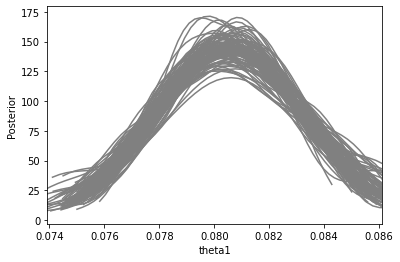

In [20]:
histories=[]
runtimes=np.zeros(iters)
for i in range(iters):
    starttime=time.time()
    abc.new(pyabc.create_sqlite_db_id(), measured_data)
    endtime=time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    histories.append(h)
    runtimes[i]=endtime-starttime
    
    
    
tmax=histories[0].max_t
fig,ax = plt.subplots()
for i in range(iters):
    df,w = histories[i].get_distribution(m=0,t=histories[i].max_t)
    pyabc.visualization.plot_kde_1d(df,w, x='theta1',ax=ax, color='grey')

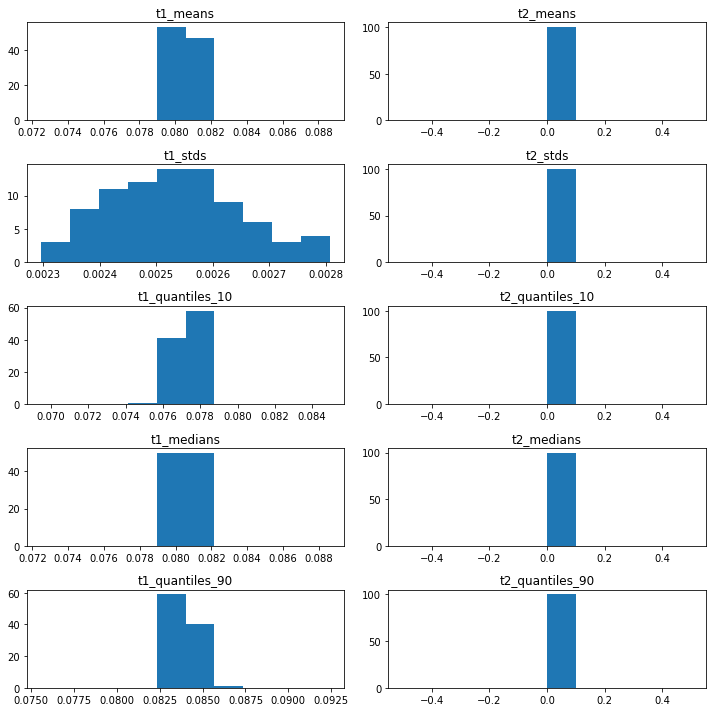

In [21]:
t1_quantiles_10 = np.zeros(iters)
t1_medians = np.zeros(iters)
t1_quantiles_90 = np.zeros(iters)
t1_means = np.zeros(iters)
t1_stds = np.zeros(iters)

t2_quantiles_10 = np.zeros(iters)
t2_medians = np.zeros(iters)
t2_quantiles_90 = np.zeros(iters)
t2_means = np.zeros(iters)
t2_stds = np.zeros(iters)



for i in range(iters):
    df,w= histories[i].get_distribution(m=0,t=histories[i].max_t)
    points = df['theta1'].values
    t1_quantiles_10[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.1)
    t1_medians[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.5)
    t1_quantiles_90[i]=pyabc.weighted_statistics.weighted_quantile(points, w, alpha=0.9)
    t1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    t1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    

allnames=[]
allnames.append("t1_means")
allnames.append("t2_means")
allnames.append("t1_stds")
allnames.append("t2_stds")
allnames.append("t1_quantiles_10")
allnames.append("t2_quantiles_10")
allnames.append("t1_medians")
allnames.append("t2_medians")
allnames.append("t1_quantiles_90")
allnames.append("t2_quantiles_90")

alldata = []
for i in range(len(allnames)):
    alldata.append(eval(allnames[i]))

    
    
fig = plt.figure(figsize=(10,10))
nx, ny=5, 2

for i in range(nx*ny):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata[i], bins = 10, range=(0.9*alldata[i].mean(), 1.1*alldata[i].mean()))
    ax.set_title(allnames[i])
    
fig.tight_layout()


In [22]:
t1_covs = np.zeros((5,5))

for i in range(nx):
    for j in range(nx):
        t1_covs[i,j]=np.cov(np.array(alldata[2*i]),np.array(alldata[2*j]))[0,1]

print(t1_covs)

[[ 5.58530623e-08  1.45447831e-08  5.35564484e-08  3.77783459e-08
   1.06489160e-07]
 [ 1.45447831e-08  4.21969029e-08 -3.84048856e-08  8.05138485e-09
   8.26214176e-08]
 [ 5.35564484e-08 -3.84048856e-08  1.48518627e-07  3.28485747e-08
   2.99365302e-08]
 [ 3.77783459e-08  8.05138485e-09  3.28485747e-08  3.37978527e-08
   6.38047803e-08]
 [ 1.06489160e-07  8.26214176e-08  2.99365302e-08  6.38047803e-08
   3.17317821e-07]]


## Estimate noise parameters

Our formulation of the modified acceptance step allows the noise model to be parameter-dependent (so does in theory also the noisified model output). Thus one can estimate parameters like e.g. the standard deviation of Gaussian noise on-the-fly. A parameter-dependent noise model is specified by passing a function to the kernel, which takes the parameters and returns an array of variances corresponding to the data. This is currently implemented for the `pyabc.IndependentNormalKernel`, `pyabc.IndependentLaplaceKernel`, `pyabc.BinomialKernel`.

Parameters are often estimated on a logarithmic scale if fold changes are of interest. We show this here exemplarily with the example of the standard deviation of a normal noise kernel:

In [24]:
theta_true_var = {'theta1': theta1_true, 'std': np.log10(sigma)}

prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", theta_min, theta_max-theta_min),
    std=pyabc.RV("uniform", -2.5, 2))

def var(p):
    return 10**(2*p['std']) * np.ones(n_time)

acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=var)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, 
                   prior,
                   kernel,
                   sampler=redis_sampler,
                   eps=eps,
                   acceptor=acceptor,
                   population_size=pop_size)

abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor_var = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:History:Start <ABCSMC(id=209, start_time=2020-11-10 14:37:44.865022, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Start Duration:  0.0027484893798828125
Preliminary accepted: 0
Acceptance Duration:  0.15435099601745605
Maybe Next Gen Duration:  4.76837158203125e-07
Wait time:  0.00021529197692871094
Preliminary discarded:  0
Collection Duration:  0.000408172607421875
Rest Duration:  0.0017232894897460938


INFO:ABC:t: 0, eps: 19.234227449645108.


Time passed until sampling starts for generation 0 :  0.007709026336669922
Start Duration:  0.0033392906188964844
Preliminary accepted: 0
Acceptance Duration:  0.46399617195129395
Maybe Next Gen Duration:  0.1981058120727539
Wait time:  0.0004718303680419922
Preliminary discarded:  0
Collection Duration:  0.0011818408966064453
Rest Duration:  0.0033011436462402344
Duration of sampling for generation 0 :  0.6729681491851807


INFO:ABC:Acceptance rate: 500 / 1618 = 3.0902e-01, ESS=5.0000e+02.


History Duration:  0.8378407955169678


INFO:ABC:t: 1, eps: 8.137833703615032.


PrepNext Duration:  4.471223592758179
Time passed until sampling starts for generation 1 :  5.356938362121582
Start Duration:  0.010064363479614258
Preliminary accepted: 500
Acceptance Duration:  0.6990358829498291
Maybe Next Gen Duration:  0.03966784477233887
Wait time:  0.00043654441833496094
Preliminary discarded:  1459
Collection Duration:  3.8109140396118164
Rest Duration:  0.003408193588256836
Duration of sampling for generation 1 :  4.57549524307251


INFO:ABC:Acceptance rate: 500 / 7224 = 6.9214e-02, ESS=4.5065e+02.


History Duration:  0.8221948146820068


INFO:ABC:t: 2, eps: 3.247833471731252.


PrepNext Duration:  1.9800174236297607
Time passed until sampling starts for generation 2 :  2.851738214492798
Start Duration:  0.01041269302368164
Preliminary accepted: 500
Acceptance Duration:  1.2020127773284912
Maybe Next Gen Duration:  0.04296731948852539
Wait time:  0.004893779754638672
Preliminary discarded:  854
Collection Duration:  3.672640562057495
Rest Duration:  0.003378629684448242
Duration of sampling for generation 2 :  4.94566011428833


INFO:ABC:Acceptance rate: 500 / 9730 = 5.1387e-02, ESS=4.6194e+02.


History Duration:  0.8247137069702148


INFO:ABC:t: 3, eps: 1.0.


PrepNext Duration:  1.932931900024414
Time passed until sampling starts for generation 3 :  2.7934327125549316
Start Duration:  0.012004852294921875
Preliminary accepted: 500
Acceptance Duration:  1.0217523574829102
Maybe Next Gen Duration:  0.039002180099487305
Wait time:  0.0005590915679931641
Preliminary discarded:  916
Collection Duration:  3.94032621383667
Rest Duration:  0.003454446792602539
Duration of sampling for generation 3 :  5.026090860366821


INFO:ABC:Acceptance rate: 500 / 9934 = 5.0332e-02, ESS=4.6951e+02.


History Duration:  0.8113043308258057


INFO:ABC:t: 4, eps: 1.0.


PrepNext Duration:  1.9653193950653076
Time passed until sampling starts for generation 4 :  2.8174312114715576
Start Duration:  0.00823354721069336
Preliminary accepted: 500
Acceptance Duration:  0.4817771911621094
Maybe Next Gen Duration:  0.03529977798461914
Wait time:  0.004929304122924805
Preliminary discarded:  3526
Collection Duration:  5.7376439571380615
Rest Duration:  0.00427556037902832
Duration of sampling for generation 4 :  6.2880859375


INFO:ABC:Acceptance rate: 500 / 9423 = 5.3062e-02, ESS=3.2824e+02.


History Duration:  0.9966123104095459


INFO:ABC:t: 5, eps: 1.0.


PrepNext Duration:  1.954385757446289
Time passed until sampling starts for generation 5 :  2.9903430938720703
Start Duration:  0.00761103630065918
Preliminary accepted: 500
Acceptance Duration:  0.47246527671813965
Maybe Next Gen Duration:  0.0366823673248291
Wait time:  0.00040435791015625
Preliminary discarded:  4575
Collection Duration:  7.246510982513428
Rest Duration:  0.004990100860595703
Duration of sampling for generation 5 :  7.7883687019348145


INFO:ABC:Acceptance rate: 500 / 11520 = 4.3403e-02, ESS=3.4501e+02.


History Duration:  0.9753320217132568


INFO:ABC:t: 6, eps: 1.0.


PrepNext Duration:  1.9481635093688965
Time passed until sampling starts for generation 6 :  2.961069107055664
Start Duration:  0.007590055465698242
Preliminary accepted: 500
Acceptance Duration:  0.43010520935058594
Maybe Next Gen Duration:  0.03623008728027344
Wait time:  0.003515958786010742
Preliminary discarded:  5815
Collection Duration:  8.672658920288086
Rest Duration:  0.005864620208740234
Duration of sampling for generation 6 :  9.183345317840576


INFO:ABC:Acceptance rate: 500 / 13673 = 3.6568e-02, ESS=2.7761e+02.


History Duration:  0.974614143371582


INFO:ABC:t: 7, eps: 1.0.


PrepNext Duration:  1.876779556274414
Time passed until sampling starts for generation 7 :  2.8922955989837646
Start Duration:  0.008421659469604492
Preliminary accepted: 500
Acceptance Duration:  0.43254828453063965
Maybe Next Gen Duration:  0.039346933364868164
Wait time:  0.00046539306640625
Preliminary discarded:  6843
Collection Duration:  10.14240550994873
Rest Duration:  0.006209135055541992
Duration of sampling for generation 7 :  10.656006097793579


INFO:ABC:Acceptance rate: 500 / 15785 = 3.1676e-02, ESS=2.8414e+02.


History Duration:  0.9874036312103271


INFO:ABC:t: 8, eps: 1.0.


PrepNext Duration:  1.8856489658355713
Time passed until sampling starts for generation 8 :  2.9095571041107178
Start Duration:  0.008717536926269531
Preliminary accepted: 500
Acceptance Duration:  0.451815128326416
Maybe Next Gen Duration:  0.03801131248474121
Wait time:  0.0008325576782226562
Preliminary discarded:  7723
Collection Duration:  11.54494595527649
Rest Duration:  0.006342411041259766
Duration of sampling for generation 8 :  12.081478834152222


INFO:ABC:Acceptance rate: 500 / 17768 = 2.8140e-02, ESS=3.1446e+01.


History Duration:  0.8026547431945801
PrepNext Duration:  0.1890554428100586


INFO:ABC:t: 9, eps: 1.0.


Time passed until sampling starts for generation 9 :  1.0239536762237549
Start Duration:  0.007834434509277344
Preliminary accepted: 500
Acceptance Duration:  0.5016100406646729
Maybe Next Gen Duration:  0.02747488021850586
Wait time:  0.00045299530029296875
Preliminary discarded:  5570
Collection Duration:  4.735363245010376
Rest Duration:  0.004088401794433594
Duration of sampling for generation 9 :  5.2928595542907715


INFO:ABC:Acceptance rate: 500 / 17332 = 2.8848e-02, ESS=2.6270e+02.
INFO:History:Done <ABCSMC(id=209, start_time=2020-11-10 14:37:44.865022, end_time=2020-11-10 14:39:18.857592)>


History Duration:  0.5047745704650879
PrepNext Duration:  0.11613774299621582


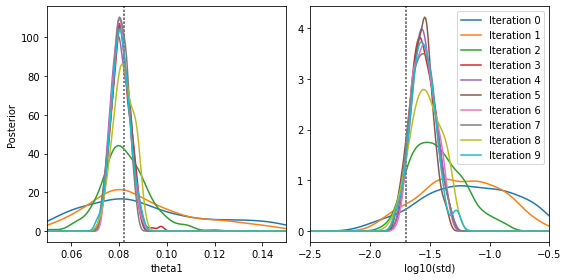

In [26]:
fig, ax = plt.subplots(1, 2)
for t in range(history_acceptor_var.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor_var, x="theta1", t=t,
        refval=theta_true_var, refval_color='grey',
        xmin=theta_min, xmax=theta_max, ax=ax[0], numx=200, label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor_var, x="std", t=t,
        refval=theta_true_var, refval_color='grey',
        xmin=-2.5, xmax=-0.5, ax=ax[1], numx=200, label=f"Iteration {t}")
ax[1].set_xlabel("log10(std)")
ax[1].set_ylabel(None)
ax[1].legend()
fig.set_size_inches((8, 4))
fig.tight_layout()
plt.show()

We see that we are able to estimate both parameters quite reasonably (the exact details of course depending on the data and model). For the present model, one could still derive the analytical posterior distribution, which we here omit for computational reasons. For an example, see [this notebook](https://github.com/yannikschaelte/Study-ABC-Noise/blob/master/study_abc_noise/estimate_noise_parameters/gaussian.ipynb).